In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys

import os
import re
import numpy as np
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from hazm import *
import fasttext
import pandas as pd
tf.keras.utils.set_random_seed(1234)

print(f"Tensorflow version {tf.__version__}")

D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tensorflow version 2.9.1


In [2]:
# Maximum sentence length
MAX_LENGTH = 96

# Maximum number of samples to preprocess
MAX_SAMPLES = 50000

# For tf.data.Dataset
BATCH_SIZE = 64 
BUFFER_SIZE = 20000

# For Transformer
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

EPOCHS = 100

In [3]:
train_data = pd.read_csv("end_output_file.csv")
train_data.head()

,QQ,AA
0,سلام دکتر,سلام بفرما
1,من معاینه شدم ولی چیزی نگفتن فقط گفتن سونو اون...,خیر ازمایشات هورمونی انجامی دهید
2,سلام اقای دکتر,سلام بفرمایید
3,دو هفته پیش بابام یک شب بیمارستان بستری بود مو...,در این مورد به متخصص جراح کلیه مراجعه کنید
4,سلام خوبین آقای دکتر,مرسی بفرمایید


In [4]:
print('Number of train_data:', len(train_data))

Number of train_data: 7704


In [5]:
print(train_data.isnull().sum())

QQ    0
AA    0
dtype: int64


In [6]:
def remove_noise(text):
    # حذف اموجی‌ها و کاراکترهای خاص
    text = re.sub(r'[^\w\s\u200c.,،؛!؟?]', '', text)
    # حذف فاصله‌های اضافی
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [7]:
train_data['QQ'] = train_data['QQ'].apply(remove_noise)
train_data['AA'] = train_data['AA'].apply(remove_noise)

In [8]:
normalizer = Normalizer()

train_data['QQ'] = train_data['QQ'].apply(normalizer.normalize)
train_data['AA'] = train_data['AA'].apply(normalizer.normalize)

In [9]:
import hazm
# calculate the length of comments based on their words
data = pd.DataFrame()  # Initialize data as an empty DataFrame
data['questions'] = train_data['QQ'].apply(lambda t: len(hazm.word_tokenize(t)))
data['answers'] = train_data['AA'].apply(lambda t: len(hazm.word_tokenize(t)))

In [10]:
min_max_len = data["questions"].min(), data["questions"].max()
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

min_max_len = data["answers"].min(), data["answers"].max()
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Min: 1 	Max: 413
Min: 1 	Max: 248


In [11]:
def data_gl_than(data, less_than=100.0, greater_than=0.0, col='questions'):
    data_length = data[col].values

    data_glt = sum([1 for length in data_length if greater_than < length <= less_than])

    data_glt_rate = (data_glt / len(data_length)) * 100
    print(f'Texts with word length of greater than {greater_than} and less than {less_than} includes {data_glt_rate:.2f}% of the whole!')

In [12]:
data_gl_than(data, 512, 1)

Texts with word length of greater than 1 and less than 512 includes 99.77% of the whole!


In [13]:
minlim, maxlim = 1, 512

In [14]:
#preprocessing questions and answers
def preprocess(text):
    #convert all the text into lower letters
    #remove the words betweent brakets ()
    #remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    #replace these spl characters with space: '\u200b', '\xa0', '-', '/'

    text = text.lower()
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


## Apply preprocess to the original question and answer columns from train_data
#df['preprocessed_question'] = df['QQ'].apply(preprocess) 
#df['preprocessed_answer'] = df['AA'].apply(preprocess)
#
## Now, you can calculate word counts on the preprocessed columns
#data['questions'] = df['preprocessed_question'].apply(lambda t: len(hazm.word_tokenize(t)))
#data['answers'] = df['preprocessed_answer'].apply(lambda t: len(hazm.word_tokenize(t)))
#
#data.head(5) # Display the updated train_data
data['preprocessed_question'] = train_data['QQ'].apply(preprocess)
data['preprocessed_answer'] = train_data['AA'].apply(preprocess)
data.head(10)

,questions,answers,preprocessed_question,preprocessed_answer
0,2,2,سلام دکتر,سلام بفرما
1,21,5,من معاینه شدم ولی چیزی نگفتن فقط گفتن سونو اون...,خیر ازمایشات هورمونی انجامی دهید
2,3,2,سلام اقای دکتر,سلام بفرمایید
3,57,9,دو هفته پیش بابام یک شب بیمارستان بستری بود مو...,در این مورد به متخصص جراح کلیه مراجعه کنید
4,4,2,سلام خوبین آقای دکتر,مرسی بفرمایید
5,32,13,من ناحیه سمت راست شکمم درد میکنه و وقتی کمرم و...,این علایم مربوط به آپاندیس نیست برای مشخص شدن ...
6,2,2,سلام دکتر,سلام بفرما
7,31,23,من الان مدتی هست مو برگشتی دارم خواستم سوال کن...,لیزر جایگاهی در درمان این بیماری ندارد اگر بعد...
8,4,2,سلام دکتر اجازه هست,سلام بفرما
9,94,15,من تقریبا به مدت سه روزه که بیشتر اوقات در موق...,به نظر من شما بیشتر اظطراب دارید و احتمالا علا...


In [15]:
questions = []
for sentence in data['preprocessed_question']:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

In [16]:
answers = []
for sentence in data['preprocessed_answer']:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [17]:
questions_eva = questions
answers_eva = answers

In [18]:
print(questions[:3])
print(answers[:3])

['سلام دکتر', 'من معاینه شدم ولی چیزی نگفتن فقط گفتن سونو اونم همه چیزش نرمال بود من باید چیکار کنم احتمال سرطان هست', 'سلام اقای دکتر']
['سلام بفرما', 'خیر ازمایشات هورمونی انجامی دهید', 'سلام بفرمایید']


MEAN:  [95.]


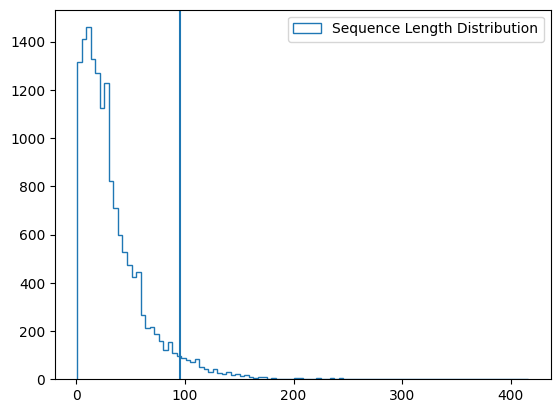

In [19]:
import pickle
# Setting Maximum Sequence Length
input_lengths = [len(text.split()) for text in questions+answers]
plt.hist(input_lengths, bins = 100, histtype='step', label='Sequence Length Distribution')
plt.axvline(np.quantile(input_lengths, [0.95]))
plt.legend();
print("MEAN: ",np.quantile(input_lengths, [0.95]))

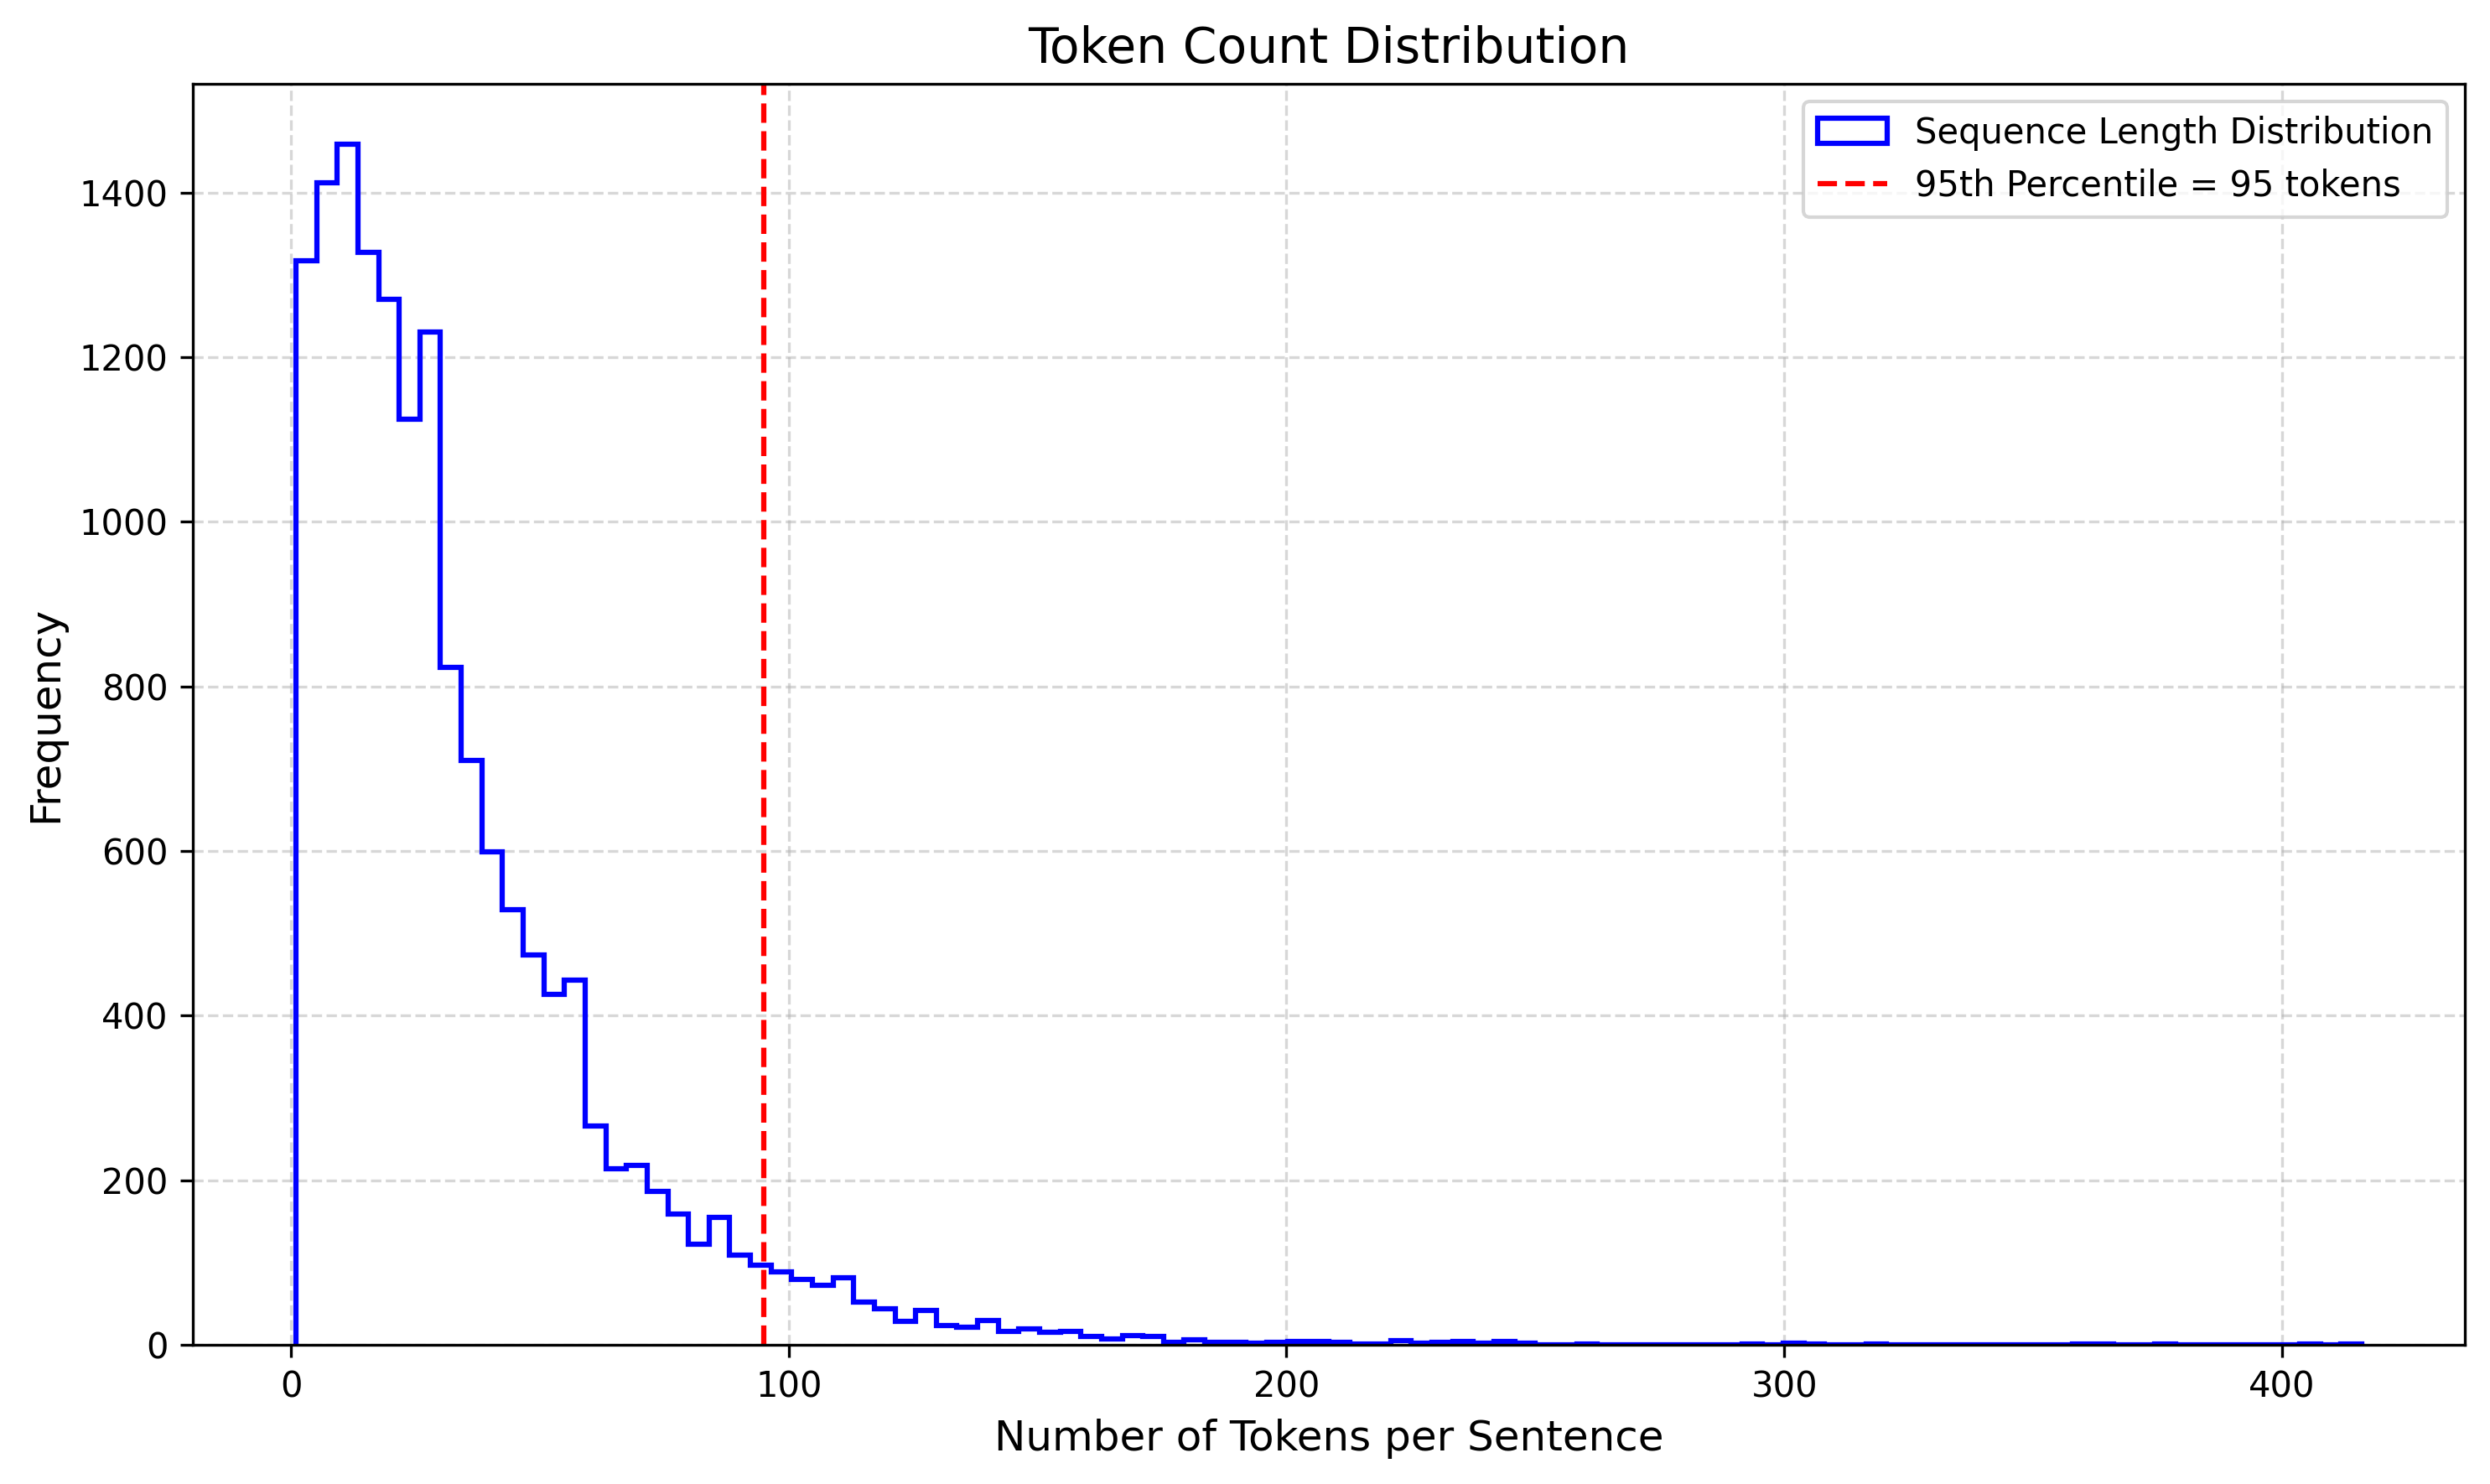

📏 95th Percentile (Recommended Max Length): 95


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# محاسبه طول ورودی‌ها
input_lengths = [len(text.split()) for text in questions + answers]
q95 = np.quantile(input_lengths, 0.95)

# ترسیم نمودار
plt.figure(figsize=(10, 6), dpi=300)  # dpi بالا برای کیفیت بالا
plt.hist(input_lengths, bins=100, histtype='step', color='blue', linewidth=1.5, label='Sequence Length Distribution')
plt.axvline(q95, color='red', linestyle='--', linewidth=1.5, label=f'95th Percentile = {int(q95)} tokens')

plt.title("Token Count Distribution", fontsize=14)
plt.xlabel("Number of Tokens per Sentence", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# ذخیره با کیفیت بالا (اختیاری)
plt.savefig("sequence_length_distribution.png", dpi=300)

plt.show()

print("📏 95th Percentile (Recommended Max Length):", int(q95))

In [21]:
# Build tokenizer using tfds for both questions and answers
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13
)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [22]:
# Build tokenizer using tfds for both questions and answers
#tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
#    questions + answers, target_vocab_size=2**13)

In [23]:
# Define start and end token to indicate the start and end of a sentence
#START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
#VOCAB_SIZE = tokenizer.vocab_size + 2

In [24]:
print(' :',START_TOKEN)
print(' :',END_TOKEN)
print(' :',VOCAB_SIZE)

 : [8244]
 : [8245]
 : 8246


In [25]:
print(f"Tokenized sample question: {tokenizer.encode(questions[20])}")

Tokenized sample question: [200, 622, 34, 5927]


In [26]:
# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # tokenize sentence
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        # check tokenized sentence max length
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # pad tokenized sentences
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding="post"
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding="post"
    )

    return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(questions, answers)

In [27]:
print(f"Vocab size: {VOCAB_SIZE}")
print(f"Number of samples: {len(questions)}")

Vocab size: 8246
Number of samples: 6559


In [28]:
#questions, answers = tokenize_and_filter(questions, answers)

In [29]:
print('(len) questions:', len(questions))
print('(len) answers:', len(answers))

(len) questions: 6559
(len) answers: 6559


In [30]:
print(questions[20])
print(answers[20])

[8244  501  620   81   14    5   38   47   55 1419    2 3428   33  141
 3022 4242  556    2   56  114   21 4907  534   19   15   47  106   21
 1719  116   26  777 2316    1   96  287  554   15  116  289  701 1168
   47  106  273  223   11   13  667 1317  141 5429  105    1 6472  105
   11    7 4038   87   13   52 1300   95  309 8245    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8244   95 1055 1137 2970  151   22    1 1065  151    9  669  563   36
   21  163   13  133  289  990  280    3   54   16   43   18  937  519
    3   90  357    1 3458   65   28   82 8245    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [31]:
# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"inputs": questions, "dec_inputs": answers[:, :-1]},
        {"outputs": answers[:, 1:]},
    )
)

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [32]:
print(dataset)

<PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 96), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 95), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 95), dtype=tf.int32, name=None)})>


In [33]:
def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights."""
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += mask * -1e9

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

In [34]:
class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        assert d_model % num_heads == 0
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def get_config(self):
        config = super(MultiHeadAttentionLayer, self).get_config()
        config.update(
            {
                "num_heads": self.num_heads,
                "d_model": self.d_model,
            }
        )
        return config

    def split_heads(self, inputs, batch_size):
        inputs = tf.keras.layers.Lambda(
            lambda inputs: tf.reshape(
                inputs, shape=(batch_size, -1, self.num_heads, self.depth)
            )
        )(inputs)
        return tf.keras.layers.Lambda(
            lambda inputs: tf.transpose(inputs, perm=[0, 2, 1, 3])
        )(inputs)

    def call(self, inputs):
        query, key, value, mask = (
            inputs["query"],
            inputs["key"],
            inputs["value"],
            inputs["mask"],
        )
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        )(scaled_attention)

        # concatenation of heads
        concat_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.reshape(
                scaled_attention, (batch_size, -1, self.d_model)
            )
        )(scaled_attention)

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

In [35]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [36]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [37]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [38]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [39]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update(
            {
                "position": self.position,
                "d_model": self.d_model,
            }
        )
        return config

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model,
        )
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, : tf.shape(inputs)[1], :]

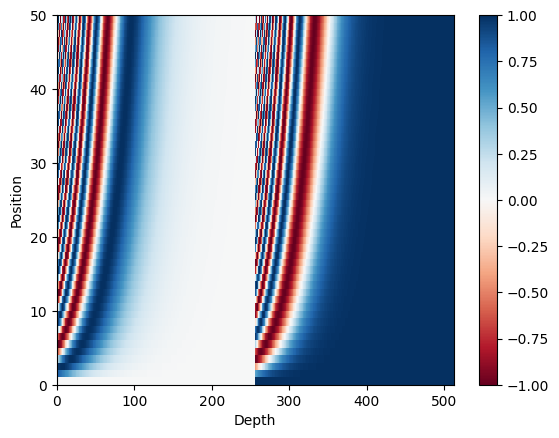

In [40]:
sample_pos_encoding = PositionalEncoding(50, 512, name="sample_pos_encoding")

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap="RdBu")
plt.xlabel("Depth")
plt.xlim((0, 512))
plt.ylabel("Position")
plt.colorbar()
plt.show()

In [41]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttentionLayer(d_model, num_heads, name="attention")(
        {"query": inputs, "key": inputs, "value": inputs, "mask": padding_mask}
    )
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    add_attention = tf.keras.layers.add([inputs, attention])
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([attention, outputs])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [42]:
sample_encoder_layer = encoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder_layer")
tf.keras.utils.plot_model(
    sample_encoder_layer, to_file='encoder_layer.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [43]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [44]:
sample_encoder = encoder(
    vocab_size=8246,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder")

tf.keras.utils.plot_model(
   sample_encoder, to_file='encoder.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [45]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention1 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_1")(
        inputs={
            "query": inputs,
            "key": inputs,
            "value": inputs,
            "mask": look_ahead_mask,
        }
    )
    add_attention = tf.keras.layers.add([attention1, inputs])
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    attention2 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_2")(
        inputs={
            "query": attention1,
            "key": enc_outputs,
            "value": enc_outputs,
            "mask": padding_mask,
        }
    )
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    add_attention = tf.keras.layers.add([attention2, attention1])
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([outputs, attention2])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

In [46]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [47]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="decoder_layer_{}".format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

In [48]:
sample_decoder = decoder(
    vocab_size=8246,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [49]:
def transformer(
    vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"
):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="enc_padding_mask"
    )(inputs)
    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None), name="look_ahead_mask"
    )(dec_inputs)
    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="dec_padding_mask"
    )(inputs)

    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [50]:
sample_transformer = transformer(
    vocab_size=8246,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [51]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [52]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.constant(d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps

    def get_config(self):
        return {"d_model": self.d_model, "warmup_steps": self.warmup_steps}

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.multiply(
            tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2)
        )

Text(0.5, 0, 'Train Step')

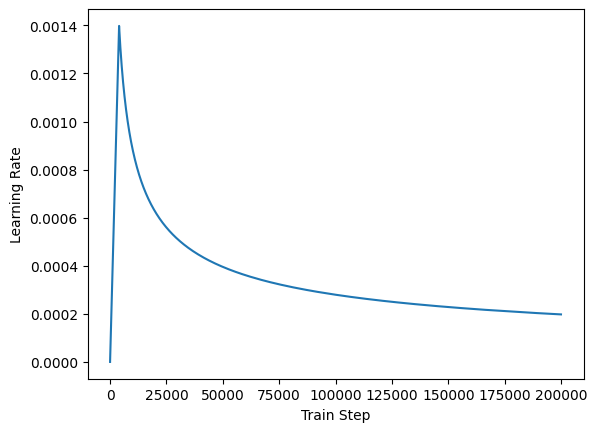

In [53]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9500\1104544722.py:13: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_9500\1104544722.py:15: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.savefig("learning_rate_schedule.png", dpi=300)
D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


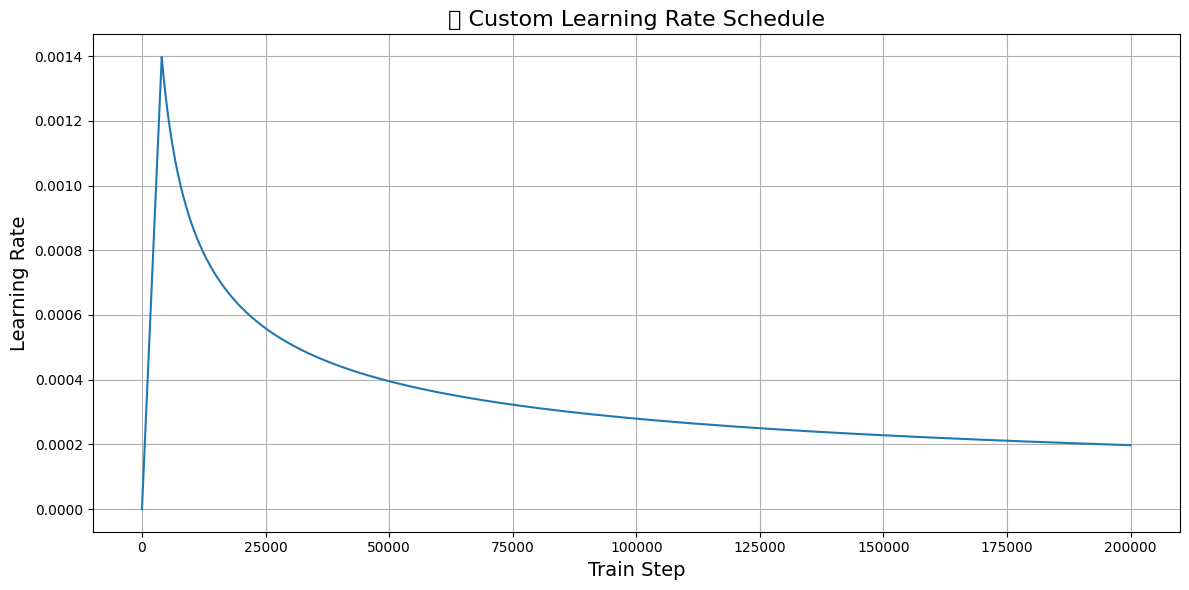

In [54]:
import matplotlib.pyplot as plt
import tensorflow as tf

# فرض بر اینه که CustomSchedule تعریف شده
sample_learning_rate = CustomSchedule(d_model=128)

plt.figure(figsize=(12, 6))  # اندازه بزرگ‌تر برای کیفیت بهتر
plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.title("📈 Custom Learning Rate Schedule", fontsize=16)
plt.xlabel("Train Step", fontsize=14)
plt.ylabel("Learning Rate", fontsize=14)
plt.grid(True)
plt.tight_layout()
# ذخیره با کیفیت بالا
plt.savefig("learning_rate_schedule.png", dpi=300)
plt.show()

In [55]:
# clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)


def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


# initialize and compile model within strategy scope
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3165184     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [56]:
history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/100
103/103 [==============================] - 148s 1s/step - loss: 2.0786 - accuracy: 0.0062  
Epoch 2/100
103/103 [==============================] - 144s 1s/step - loss: 1.8940 - accuracy: 0.0110
Epoch 3/100
103/103 [==============================] - 143s 1s/step - loss: 1.6604 - accuracy: 0.0118
Epoch 4/100
103/103 [==============================] - 154s 1s/step - loss: 1.5154 - accuracy: 0.0225
Epoch 5/100
103/103 [==============================] - 148s 1s/step - loss: 1.4119 - accuracy: 0.0378
Epoch 6/100
103/103 [==============================] - 148s 1s/step - loss: 1.3060 - accuracy: 0.0468
Epoch 7/100
103/103 [==============================] - 138s 1s/step - loss: 1.2240 - accuracy: 0.0524
Epoch 8/100
103/103 [==============================] - 139s 1s/step - loss: 1.1557 - accuracy: 0.0570
Epoch 9/100
103/103 [==============================] - 140s 1s/step - loss: 1.0946 - accuracy: 0.0618
Epoch 10/100
103/103 [==============================] - 140s 1s/step - loss: 1.0

In [58]:
filename = "model_finals.h5"
tf.keras.models.save_model(model, filepath=filename, include_optimizer=False)

In [67]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


مقادیر history: dict_keys(['loss', 'accuracy'])


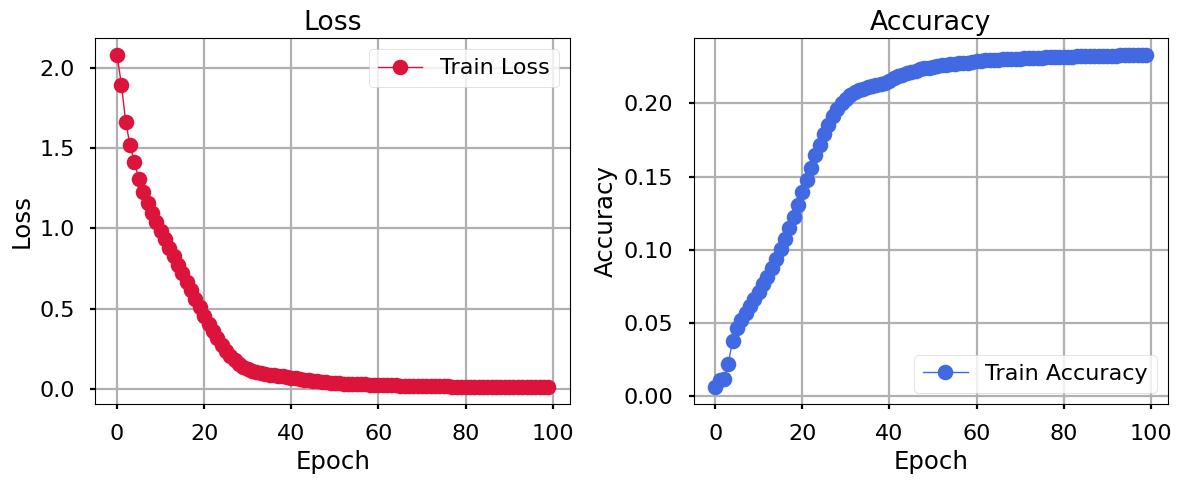

In [68]:
import matplotlib.pyplot as plt

# بررسی کلیدهای موجود برای اطمینان
print("مقادیر history:", history.history.keys())

plt.figure(figsize=(12, 5))  # اندازه بزرگ‌تر برای وضوح بیشتر

# 📉 نمودار Train Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o', color='crimson', linewidth=1)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# 📈 نمودار Train Accuracy
plt.subplot(1, 2, 2)
acc_key = [k for k in history.history.keys() if 'acc' in k or 'accuracy' in k][0]
plt.plot(history.history[acc_key], label='Train Accuracy', marker='o', color='royalblue', linewidth=1)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()

# ⬇️ ذخیره با کیفیت بالا
plt.savefig("train_loss_accuracy-1-finals.png", dpi=400, bbox_inches='tight')
plt.savefig("train_metrics_styled-1-final.pdf", dpi=400, bbox_inches='tight')

plt.show()

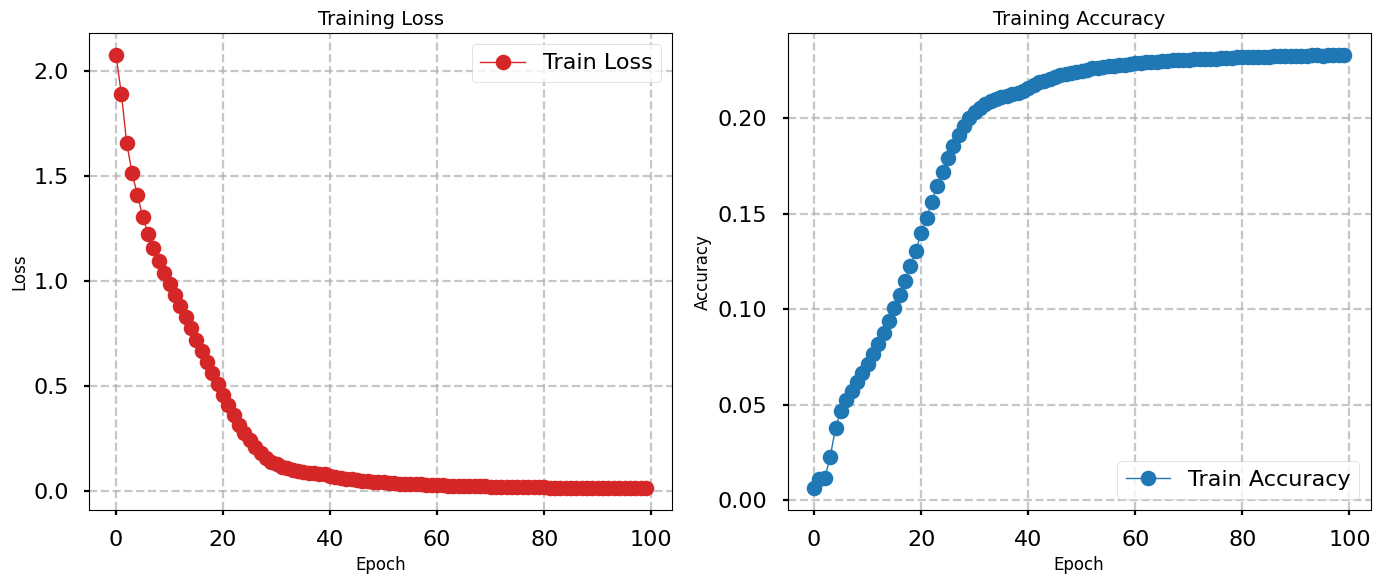

In [65]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# تنظیم فونت واضح و بزرگ برای نمودارها
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 12

# انتخاب استایل حرفه‌ای
plt.style.use('seaborn-v0_8-poster')  # برای نمودارهای حرفه‌ای و واضح

plt.figure(figsize=(14, 6))

# 📉 نمودار Train Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o', color='#d62728', linewidth=1)
plt.title("Training Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# 📈 نمودار Train Accuracy
plt.subplot(1, 2, 2)
acc_key = [k for k in history.history.keys() if 'acc' in k or 'accuracy' in k][0]
plt.plot(history.history[acc_key], label='Train Accuracy', marker='o', color='#1f77b4', linewidth=1)
plt.title("Training Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

# ⬇️ ذخیره با کیفیت بالا
plt.savefig("train_metrics_styled-end.png", dpi=200, bbox_inches='tight', transparent=True)
plt.savefig("train_metrics_styled-end.pdf", dpi=300, bbox_inches='tight')

plt.show()


مقادیر history: dict_keys(['loss', 'accuracy'])


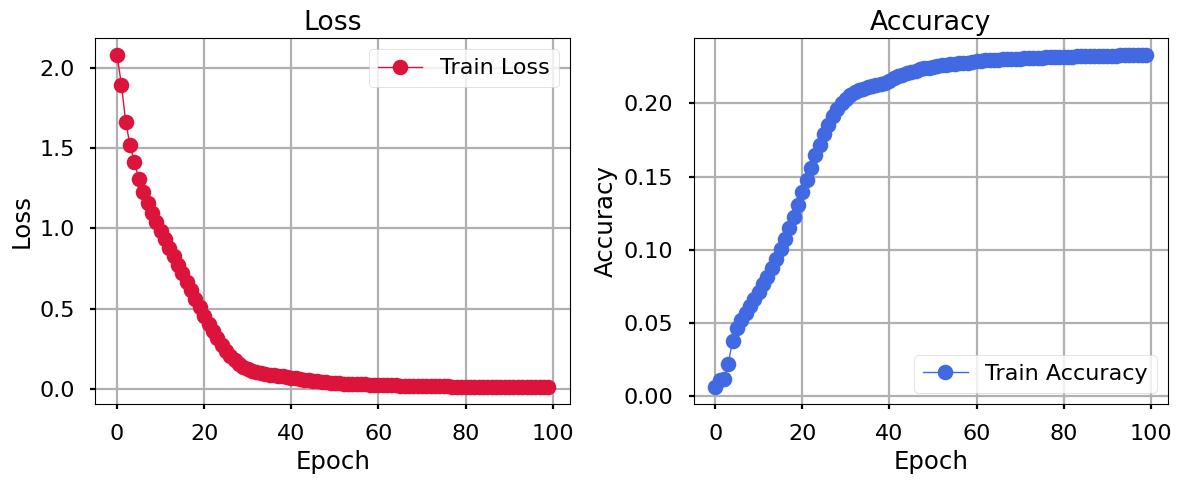

In [70]:
import matplotlib.pyplot as plt

# بررسی کلیدهای موجود برای اطمینان
print("مقادیر history:", history.history.keys())

plt.figure(figsize=(12, 5))  # اندازه بزرگ‌تر برای وضوح بیشتر

# 📉 نمودار Train Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o', color='crimson', linewidth=1)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# 📈 نمودار Train Accuracy
plt.subplot(1, 2, 2)
acc_key = [k for k in history.history.keys() if 'acc' in k or 'accuracy' in k][0]
plt.plot(history.history[acc_key], label='Train Accuracy', marker='o', color='royalblue', linewidth=1)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()

# ⬇️ ذخیره با کیفیت بالا
plt.savefig("train_loss_accuracy-1-End.png", dpi=400, bbox_inches='tight')
plt.savefig("train_metrics_styled-1-End.pdf", dpi=400, bbox_inches='tight')

plt.show()


In [71]:
plt.savefig("train_loss_accuracy_finals.pdf", dpi=300, bbox_inches='tight')

<Figure size 1280x880 with 0 Axes>

مقادیر history: dict_keys(['loss', 'accuracy'])


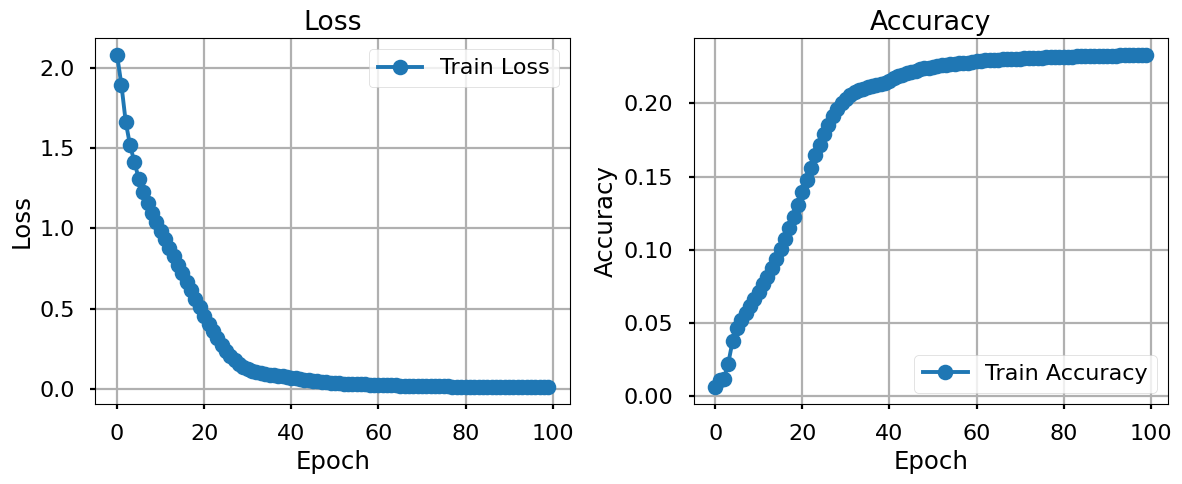

<Figure size 1280x880 with 0 Axes>

In [72]:
import matplotlib.pyplot as plt

# بررسی کلیدهای موجود برای اطمینان
print("مقادیر history:", history.history.keys())

plt.figure(figsize=(12, 5))

# 📉 نمودار Train Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# 📈 نمودار Train Accuracy
plt.subplot(1, 2, 2)
# بررسی اینکه کلید accuracy چه نامی داره (ممکنه 'accuracy' یا مثلاً 'accuracy_1' باشه)
acc_key = [k for k in history.history.keys() if 'acc' in k or 'accuracy' in k][0]
plt.plot(history.history[acc_key], label='Train Accuracy', marker='o')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig("train_loss_accuracy-3-1-final.png", dpi=300, bbox_inches='tight')
plt.savefig("train_metrics_styled-3-1-final.pdf", dpi=400, bbox_inches='tight')

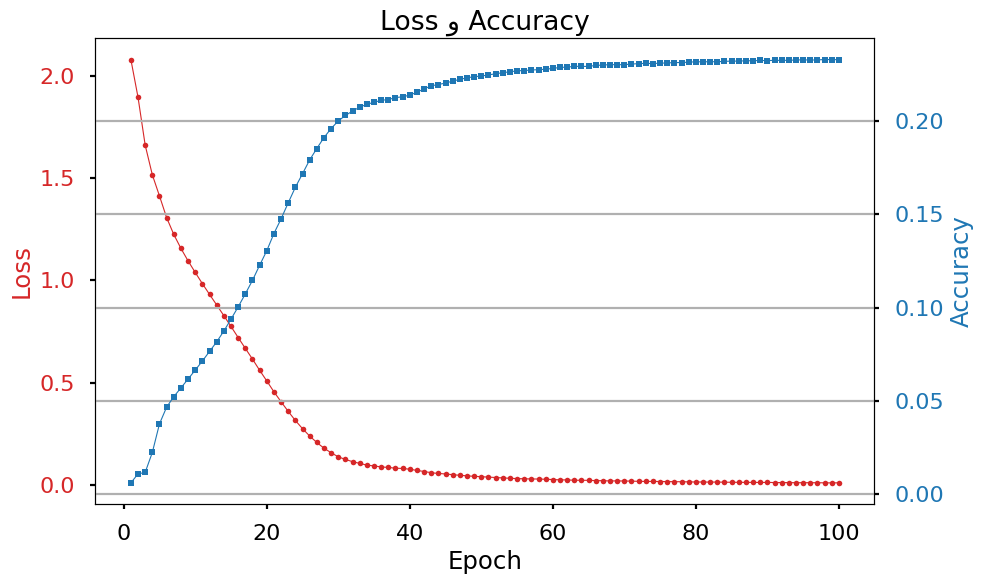

<Figure size 1280x880 with 0 Axes>

In [75]:
import matplotlib.pyplot as plt

# پیدا کردن کلید دقیق accuracy
acc_key = [k for k in history.history.keys() if 'acc' in k or 'accuracy' in k][0]

epochs = range(1, len(history.history['loss']) + 1)

fig, ax1 = plt.subplots(figsize=(10, 6))

# محور اول برای Loss
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(
    epochs,
    history.history['loss'],
    label='Loss',
    color=color,
    marker='o',
    linewidth=0.8,
    markersize=4
)
ax1.tick_params(axis='y', labelcolor=color)

# محور دوم برای Accuracy
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(
    epochs,
    history.history[acc_key],
    label='Accuracy',
    color=color,
    marker='s',
    linewidth=0.8,
    markersize=4
)
ax2.tick_params(axis='y', labelcolor=color)

# عنوان و نمایش
plt.title('Loss و Accuracy')
fig.tight_layout()
plt.grid(True)
plt.show()

# ذخیره خروجی با کیفیت مناسب
plt.savefig("train_loss_accuracy-clean-1.png", dpi=300, bbox_inches='tight')
plt.savefig("train_loss_accuracy-clean-1.pdf", dpi=400, bbox_inches='tight')


مقادیر history: dict_keys(['loss', 'accuracy'])


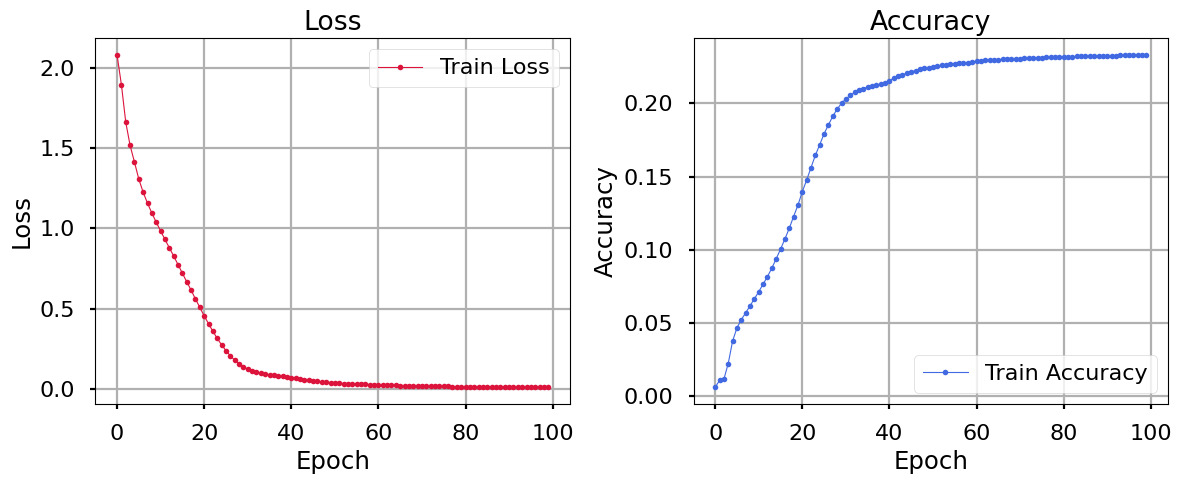

In [73]:
import matplotlib.pyplot as plt

# بررسی کلیدهای موجود برای اطمینان
print("مقادیر history:", history.history.keys())

plt.figure(figsize=(12, 5))  # اندازه مناسب برای داکیومنت

# 📉 نمودار Train Loss
plt.subplot(1, 2, 1)
plt.plot(
    history.history['loss'], 
    label='Train Loss', 
    marker='o', 
    color='crimson', 
    linewidth=0.8, 
    markersize=4
)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# 📈 نمودار Train Accuracy
plt.subplot(1, 2, 2)
acc_key = [k for k in history.history.keys() if 'acc' in k or 'accuracy' in k][0]
plt.plot(
    history.history[acc_key], 
    label='Train Accuracy', 
    marker='o', 
    color='royalblue', 
    linewidth=0.8, 
    markersize=4
)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()

# ⬇️ ذخیره با کیفیت بالا
plt.savefig("train_loss_accuracy_clean.png", dpi=300, bbox_inches='tight')
plt.savefig("train_loss_accuracy_clean.pdf", dpi=400, bbox_inches='tight')

plt.show()


In [74]:
plt.savefig("loss_accuracy_plot-end-بهدشمس.pdf", dpi=300, bbox_inches='tight')

<Figure size 1280x880 with 0 Axes>

In [76]:
def evaluate(sentence):

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [77]:
output = predict('سلام آقای دکتر')

Input: سلام آقای دکتر
Output: سلام


In [78]:
sentence="من معاینه شدم ولی چیزی نگفتن فقط گفتن سونو اونم همه چیزش نرمال بود من باید چیکار کنم احتمال سرطان هست"
for _ in range(10):
  sentence = predict(sentence)
  print('')

Input: من معاینه شدم ولی چیزی نگفتن فقط گفتن سونو اونم همه چیزش نرمال بود من باید چیکار کنم احتمال سرطان هست
Output: خیر ازمایشات هورمونی انجامی دهید

Input: خیر ازمایشات هورمونی انجامی دهید
Output: لطفا سوالتون رو کامل و با جزییات بپرسین نا مفهومه

Input: لطفا سوالتون رو کامل و با جزییات بپرسین نا مفهومه
Output: دوست گرامی کمبود پلاکت علل زیادی ندارد و کمبود نمایید در صورت خیر اما پوست و عدم بهبودی خیر

Input: دوست گرامی کمبود پلاکت علل زیادی ندارد و کمبود نمایید در صورت خیر اما پوست و عدم بهبودی خیر
Output: گاهی تا حدودی به علت هست و بهتر است به فوق تخصص گوارش مراجعه کنید

Input: گاهی تا حدودی به علت هست و بهتر است به فوق تخصص گوارش مراجعه کنید
Output: درصورت جدا از داروهای تزریقی لازم است توسط پزشک متخصص مربوطه ویزیت شوید

Input: درصورت جدا از داروهای تزریقی لازم است توسط پزشک متخصص مربوطه ویزیت شوید
Output: دوست گرامی اگر تنها با یک دوره سیکل قاعدگی ایجاد می‌کند و آیا مراجعه به یک قطره بسیاری از شروع شده و علل دیگر مانند نوار مغز وجه

Input: دوست گرامی اگر تنها با یک دوره سیکل قاعد

In [79]:
import tqdm
from nltk.translate.bleu_score import sentence_bleu

In [80]:
X = questions_eva
Y = answers_eva

In [81]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
len (Y_test)

1541

In [82]:
fr_preds = []
for sentence in tqdm.tqdm(X_test):
    fr_pred = predict(sentence)
    fr_preds.append(fr_pred)

  0%|                                                                                 | 1/1541 [00:01<43:50,  1.71s/it]

Input: دوماهی هست گوش‌درد دارم وحالادو هفته میشه که گلودرد اضافه‌شده ازپشت گوشم تاگلوم دردخفیف دارم مثل سرماخوردگی ولی مطمعن هستم سرمانخوردم سابقه بیماری خاصی ندارم داروخاصی هم استفاده نمی‌کنم چیه دکتر
Output: به علت مزمن شدن درد نیاز به معاینه گوش می‌باشد به متخصص گوش و حلق و بینی مراجعه فرمایید


  0%|                                                                                 | 2/1541 [00:02<25:03,  1.02it/s]

Input: من تو سن ۲۲ سالگی تو دوران نامزدی دچار زگیل تناسلی شدم و با محلول ساختنی پدوفیلین برطرف شد و الان ۹ سال میگذره که زگیلی نزدم میخوام بدونم راه درمان چیه و با وجود دختر بودنم باید چیکار کنم که بدونم ویروس داخل بدنم هست یا نه
Output: به متخصص زنان مراجعه کنید


  0%|▏                                                                                | 3/1541 [00:03<28:18,  1.10s/it]

Input: من ۱۰ روزه گوشم درد میکنه و عفونت ازش خارج میشه انتی بیوتیک مصرف کردم بهتر شد ولی اون یکی گوشم اینجوری شد که هنوز دارم انتی بیوتیک مصرف می‌کنم اشنایان بهم گفتن تست کرونا بدم می‌خواستم بپرسم اگه این گوش‌درد علایم کرونا نیست بیمارستان نرم واسه تست بجز گوش‌درد هیچ علایم دیگه‌ای ندارم یه سوال دیگه که تا چند روز میتونم انتی بیوتیک مصرف کنم
Output: دارو تجویز می‌کنم بخورید اگر علامت دیگری ندارید نیاز به تست کرونا نیست


  0%|▏                                                                                | 4/1541 [00:04<32:27,  1.27s/it]

Input: در هفته بارداری تو سونوی انومالی قطر اتریوم بطهای جانبی رو هفت و هفت دهم میلی گفتند و سونوی چند هفته بعد رو گفتن باید انجام بدم و بعد از هفته تو سونوی دوم قطر بطن‌ها به هشت و نه دهم میلی تا رسیده است ایا مشکلی دارد و احتمال داره که از این بیشتر شود و اینکه جنین دو هفته بزگتر از سن بارداری نشان داده است میشه راهنمایمون کنیدو مشکلمونو بگین ممنون میشم
Output: حتما با یک جنین شناس مثل دکتر حنطوش زاده یا دکتر برنا مشورت کنید


  0%|▎                                                                                | 5/1541 [00:05<25:11,  1.02it/s]

Input: بابام روزه عمل کرده الان میگه دست چپش و کتفش درد میکنه عادیه یا نه اقای دکتر
Output: توسط جراحشون معاینه شوند


  0%|▎                                                                              | 6/1541 [00:10<1:03:49,  2.49s/it]

Input: چند وقتیه احساس سوزش و خشکی در گلو و بینی دارم و گاهی خارش گوش و بینی و هرزگاهی احتقان بینی و ترشح پشت حلق خیلی وقته روزی دوبار با اب نمک بینی و گلو رو شتشو میدم الان نگرانم و استرس دارم البته ریفلاکس معده دارم که اخیرا شدید‌تر شده می‌خواستم بدونم ربطی به کرونا داره یا نه
Output: نه لزوما ممکنه بدلیل حساسیت فصلی یا حساسیت به مواد ضدعفونی باشه شما به مدت روز کلداکس هر ساعت سیتریزین هر ساعت و شربت را هر ساعت سی‌سی مصرف کنید در صورت عدم بهبود یا تشدید علایم به پزشک داخلی مراجعه فرمایید ضمنا قرص پنتو پرازول میلی‌گرم صبح‌ها نیم ساعت قبل از صبحانه برای بهبود ریفلاکس معده استفاده شود


  0%|▎                                                                                | 7/1541 [00:12<55:11,  2.16s/it]

Input: من یک ساله که وقتی استرس می‌گیرم یاعصبی میشم بدنم بیحال میشه مثل اینکه انگارجانی توبدنم ندارم فشارم می‌افته ضعف میگیرتم دست هام میلرزه وحتمابایدآب قندو یاچیزی بخورم چه کنم دکتر
Output: علایم شما به حملات پانیک شبیه می‌باشدجهت تشخیص قطعی و درمان به روانپزشک مراجعه کنید


  1%|▍                                                                                | 8/1541 [00:12<41:59,  1.64s/it]

Input: من بیستم فروردین ایودی ام را خارج کرده‌ام تمام ازمایشات و سونوگرافی‌های لازم را هم قبل از خروج ایودی داده‌ام که همه خوب بودند از سه ماه قبل هم فولیک اسید مصرف کرده‌ام می‌خواستم بدونم از چه زمانی می‌تونم اقدام به بارداری کنم
Output: شما میتونید برای بارداری اقدام کنید


  1%|▍                                                                                | 9/1541 [00:14<41:25,  1.62s/it]

Input: ناف دخترم قرمز شده و بودی بد میده و یکم ترشحات خشک‌شده روش هست اصلا با نافش بازی نمیکنه یکمم انگار باز شده به شدت یبوست داره ممکنه دلیلش فتق باشه
Output: بعید است فتق باشد بیشتر به علت کیست یا فیستول نافی است داروی مناسب تجویز شود درست می‌شود


  1%|▌                                                                               | 10/1541 [00:14<30:30,  1.20s/it]

Input: قبلا من درد کتف چپ و درد قفسه سینه داشتم چند سال پیش و به دکتر فوق تخصص قلب مراجعه کردم بعد از اکو تست ورزش و سیتی انژیو گفتند کمی افتادگی دریچه میترال دارید البته شدت استرس هم بالا بود تا جایی که شب‌های متوالی بی‌خواب می‌شدم و فشارم به هیجده می‌رسید با پیشنهاد دکتر قلبم رفتم دکتر مغز و اعصاب و بعد از مصرف آرامبخش دیگر خبری از درد و فشار خون نبود حالاکه شش ساله قرص آرام‌بخش مصرف می‌کنم نزدیک یک ساله دوباره دردام شروع و خیلی زیادتر شد دایم کتف چپم درد داره و سوزش قلب دارم البته ناراحتی معده هم دارم وزنم زیاد شده در حال حاضر بعد از ناهار می‌خوابم به شدت تپش قلب دارم تا جاییکه نفسم تنگ میشه و حالت بختک به صورت متوالی برام پیش میاد خواهش راهنمایی بفرمایید
Output: ممنون بفرمایید


  1%|▌                                                                               | 11/1541 [00:17<42:48,  1.68s/it]

Input: حدودیک هفته است که فشارمغزی دارم ام ار‌ای هم دادم دکترم گفت مقداری از رگهات متورم شده ازمایش نخاع هم نوشته که می‌ترسم انجام بدم چیه دکتر
Output: جهت تشخیص لازم است آزمایش بررسی مایع نخاع انجام شود جای نگرانی نیست و یک اقدام با بی حسی موضعی است و تنها دقیقه طول می‌کشد طبق روند متخصص مغز و اعصاب اقدام کنید


  1%|▌                                                                               | 12/1541 [00:17<33:46,  1.33s/it]

Input: می‌خواستم بپرسم در چه مدت زمانی باید از روغن کرچک برای پرپشت شدن ابرو و مژه استفاده کنم چقدر طول میکشه و ایا برای افرادی که ابرو کم دارن موثر هست
Output: اثرات ثابت‌شده علمی ندارد


  1%|▋                                                                               | 13/1541 [00:19<38:53,  1.53s/it]

Input: هرازگاهی تکه‌های رنگ زرد در کف دستم بخصوص در کنار قسمت انتهای انگشتانم مشاهده می‌شود دارای بیماری خاصی هستم اقدامات اولیه پیست
Output: ممکنه اگزما یا پسوریازیس مطرح باشد فعلا روزانه یک‌بار کرم اوره درصد ثمین بزن بهتره برای ارزیابی دقیق‌تر به پزشک مراجعه شود


  1%|▋                                                                               | 14/1541 [00:21<36:44,  1.44s/it]

Input: ببخشید رابطه آلوپسی با تی اس اچ چیه میگن تی‌ای اچ من نه و هشت دهم هست لطفا کمکم کنید
Output: یکی از اختلالات زمینه‌ساز ریزش مو مشکلات تیروییدی است که حتما باید کنترل شود


  1%|▊                                                                               | 15/1541 [00:23<39:35,  1.56s/it]

Input: دخترمن دو ازده سالشه و موهای سرش داره سفید میشه علتش چیه
Output: سفیدی زودرس موی سر میتونه علل متفاوتی داشته باشه از جمله وراثت و تغذیه و مشکل تیرویید حتما یک آزمایش تیرویید انجام شود


  1%|▊                                                                               | 16/1541 [00:25<47:31,  1.87s/it]

Input: دختر من چند روزه لبه‌های واژنش التهاب داره و قرمزه و سفیدرنگه و هنوز دختره چه چیزی استفاده کنه تا بهتر بشه
Output: دوست گرامی لازم است معاینه انجام گردد ممکن است یک قارچ سطحی باشد یا عفونت باکتریایی درمان بدون معاینه سبب بدتر شدن وضعیت می‌شود به متخصص زنان یا پزشک عمومی مراجعه کنید


  1%|▉                                                                               | 17/1541 [00:27<43:57,  1.73s/it]

Input: من ۵ ماهه باردارم و حدود ۲ هفته‌ای هست ک زیر شکمم کنار لگن کاهی راست گاهی چپ بیشتر مواقع ک خوابیدم میخام بلند بشم درد شدید دارم ک نمیشه تکون بخورم ک درد بیشتر میشه با انداختن خودم ب پهلو البته گاهی وقتا هم ک ۵ دیقه راه برم پیاده‌روی درد زیر شکمم میاد ولی این درد کنار شکم ب لگن میخوره شروع میشه و نفس عمیق می‌کشم حدود ۲ دیقه طول میکشه تا اروم بشه میخام بپرسم از چیه نزدیکی چند وقت بود هر روز داشتم ولی الان بخاطر درد چند روزیه انجام نمیدیم درد شدیدی شروع میشه دکترم گفت شاید عفونت ادرار داری ازمایش ندادم ولی سوزش ادرار ندارم
Output: مجدد بررسی آزمایش قند خون و ادرار و کشت ادرار انجام دهید به متخصص داخلی مراجعه کنید


  1%|▉                                                                               | 18/1541 [00:27<34:07,  1.34s/it]

Input: دکتر من ۱۷ سال است تیرویید دارم خیلی من را تنگه نفس می‌کند و اصلا نمی‌توانم راحت بخوابم و ویتامین زیاد می‌خورم اما هیچگونه ویتامین به بدنم نمی‌رسد تیرویید پر کار است کاری از دست شما بر می‌اید
Output: به متخصص داخلی مراجعه کنید


  1%|▉                                                                               | 19/1541 [00:28<30:19,  1.20s/it]

Input: من سالمه راستش احساس می‌کنم که اخیرا دو هفته‌ای است که دچار اختلال در حفظ نعوظ شدم در حین رابطه جنسی نعوظ رو نمیتونم حفظ کنم ولی چند دقیقه بعد دوباره نعوظ حفظ میشه و عادی پیش میره در حین رابطه ولی تا قبل از اون یعنی دو هفته قبل هیچ مشکلی نداشتم و نعوظ طبیعی داشتم احساس می‌کنم بصورت موقتی این اختلال برام پیش اومده و خیلی من و ناراحت و ذهنم و درگیر خودش کرده می‌خواستم لطف بفرمایید راهنماییم کنید که بدونم مشکل از کجاست و راه حلش چی هست
Output: قرص تادالافیل میلی یک ساعت قبل از نزدیکی استفاده کنید


  1%|█                                                                               | 20/1541 [00:31<48:18,  1.91s/it]

Input: مرد ۳۴ ساله و قد ۱۸۰ وزن ۹۵ هستم ۸ ماه هست که کاشت مو انجام دادم و قرصهای زینک پلاس و هیرویت و الپسین کافیین مصرف می‌کنم و اخیرا آزمایش خون دادم که براتون پیوست کردم می‌خواستم لطفا راهنمایی بفرمایید آیا این آزمایشها برای فهمیدن موها کامل هست و آیا لازم هست که فوم ماینوکسیدیل هم بزنم یا همین داروها کافی هستند چون استفاده از ماینوکسیدیل به طور روزانه برام سخت هست و اینکه چه چیزهایی رو با توجه به آزمایش باید رعایت کنم یا بخورم و البته یکی از آزمایشها مثل اینکه باید ناشتا می‌شدم که من صبحانه خورده بودم و اگه ویتامین د باید مصرف کنم چه نوع ویتامینی و روزانه یا هفتگی باید بخورم و البته متوجه شدم آزمایش فولیکال و اف اس اچ برای من لازم نبوده که نوشتن
Output: نحوه مصرف کنید چای زیاد و قهوه عمل مدت تورم و قرمزی و اقدام به سابقه بیماری خاصی نظیر لوراتادین جهت ارتباط مستلزم آن است سرترالین داروی اختصاصی نداره و سایر موارد میتونند مفید نکنید بعد از ازدواج ندارد


  1%|█                                                                               | 21/1541 [00:33<43:45,  1.73s/it]

Input: پرولاکتین ابتدا بود درمان کو تاه مدت کابرلین فاصله افتاد و شد دوماه داستینکس مصرف شد و بعد ازچندماه آزمایش شد اینمدت یکسال طول کشید دکترجراح مغزاعصاب فقط قرص تجویز کرد و گفت دوسالی باید مصرف شودو تحت نظر دکتر غدد باشم اما داخلی اعصاب وضعیت را اورژانسی می‌داند و توده را ماکرو گفت چه تصمیمی بگیرم لطفا راهنمایی کنید پریودتقریبا منظم قبلا یکسالی قرص ضدبارداری و اسپیرونولاکتون مصرف می‌کردم آکنه دارم ترشح و پرمویی شدید ندارم وزنم به شدت کم شده
Output: به متخصص زنان مراجعه کنید تا معاینه و در صورت عدم بهبودی با دارو مشورت کنید


  1%|█                                                                             | 22/1541 [00:39<1:15:01,  2.96s/it]

Input: کی از آشنایان مان که حدودا ۴۰ سالشان است احساس سوزش گلو و خشکی دهان دارندکه اتفاقا سابقه مشکل معده نیز دارند خاستم بدونم می‌تونه علتش ریفلاکس معده باشه و اینکه می‌توانید چند درمان خانگی برای این مشکل نام ببرید
Output: از مصرف چای و قهوه پرهیز نمایند بلافاصله پس از غذا خوردن دراز نکشند سعی کنند تا مدتی پس از غذا اب و مایعات ننوشند نوشابه‌های گازدار مصرف نکنند قرص پنتوپرازول میلی صبح ناشتا مصرف کنند شربت آلومینیوم‌ام جی اس صبح و ظهر و شب یک قاشق غذاخوری بخورند در صورت عدم بهبود پس از یک ماه به پزشک متخصص داخلی مراجعه نمایند


  1%|█▏                                                                            | 23/1541 [00:42<1:22:06,  3.25s/it]

Input: احساس می‌کنم یه مانعی جلوادرارم رو میگیره تکرر اداره دارم و ادارم کامل تخلیه نمیشه صبحها دست راستم احساس ورم دارم
Output: دوست گرامی آزمایش کامل خون و بررسی کارکرد کلیه و کبد چک شود آزمایش ادرار ساعته از نظر حجم و پروتیین و کراتینین و همین طور کشت ادرار و سونوگرافی کلیه و مجاری ادراری لازم است بررسی‌های فوق باید به طور کامل انجام گردد به متخصص داخلی مراجعه نمایید


  2%|█▏                                                                            | 24/1541 [00:44<1:09:55,  2.77s/it]

Input: چند روزی هست که تکرر ادرار شدید گرفتم به طوری که قادر به انجام فعالیت‌های معمول نیستم قبلا هم حدو د سال پیش این مشکل رو داشتم که دکتر متخصص مراجعه کردم و علت رو مقدار کمی عفونت ادراری تشخیص داد و تا قرص تجویز کرد که بعد از مصرف اونها خوب شدم ولی متاسفانه اسم قرص‌ها رو به خاطر ندارم که الان تهیه کنم سوزش ادرا و تغیر رنگ ادرار هم ندارم و فکر می‌کنم همون عفونت ادراری مشکل من هست با توجه به اینکه شغل من کارگاه خارج شهر هست امکان مراجعه به پزشک متخصص رو تا دو هفته اینده که نوبت مرخصی‌ام هست رو ندارم اگه لطف کنید دارو به همراه دوز مصرف رو برای من ایمیل کنید تا از بلکه از شهر کوچک اطراف کارگاه بتونم تهیه کنم ممنون میشم تست‌های ادرار رو به محض رفتن به مرخصی انجام می‌دهم
Output: باید معاینه دستگاه روحی و روانی است که در صورت عدم بهبود جهت معاینه مجدد به پزشک مراجعه کنید


  2%|█▎                                                                              | 25/1541 [00:45<53:58,  2.14s/it]

Input: من آنزیم کبدیم ۴۶ نشون داده و هیچگونه دارویی استفاده نمی‌کنم و کلسترول و قند و چربی همه نرمال هستش پزشک بنده سونوگرافی برام نوشته می‌خواستم بدونم علت خاصی میتونه داشته باشه با تشکر از شما
Output: یکی از شایعترین علل همون کبد چرب هستش


  2%|█▎                                                                              | 26/1541 [00:47<57:58,  2.30s/it]

Input: خانوم دکتر من دندونم سوراخ شده خیلی اذیت میشم خیلی درد میکنه بخاطر کرونا می‌ترسم بکشم لطفا یه دارویی معرفی کنید دردم کمتر بشه
Output: از اونجاییکه اصلا مشخص نیست کرونا تا کی ادامه داشته باشه توصیه میشه به یک مرکز که کامل پروتکل‌های بهداشتی رعایت می‌شود مراجعه و دندانتان را درمان کنید


  2%|█▍                                                                              | 27/1541 [00:48<45:29,  1.80s/it]

Input: می‌خواستم بدونم هپاتیتم ازچه نوعی هست
Output: لطفا سوالتون رو همراه با آزمایشتون بفرستید


  2%|█▍                                                                              | 28/1541 [00:49<42:19,  1.68s/it]

Input: من به تازگی نامزد کردم و هر با برای رابطه درد شدید و خونریزی دارم و پایین قسمتی که رابطه دارم پاره میشه
Output: باید رابطه خیلی به آرامی باشد وسعی در اعمال فشار نباشد تا بتدریج بهتر شود


  2%|█▌                                                                              | 29/1541 [00:52<45:04,  1.79s/it]

Input: خانم ۵۰ ساله هستم مدت زیادی هست که خونریزی دارم که به دکتر زنان مراجعه کردم که دکتر سه عدد امپول برای من تجویز کرد ولی خوب نشدم دوباره به دکتر مراجعه کردم چند امپول تقویتی برای من تجویز کرد ولی باز هم خوب نشدم لطفا من را راهنمایی کنید
Output: با توجه به خون ریزی مداوم باید حتما سونو واژینال شوید تا اگر ضخامت اندومتر زیاد بود کورتاژ تشخیصی شوید مراجعه به متخصص زنان داشته باشید


  2%|█▌                                                                            | 30/1541 [00:55<1:01:25,  2.44s/it]

Input: که حدود دو ماه قبل سردردهایی تقریبا به مدت یه هفته یا بیشتر در پشت سر در یک‌طرف سرم و سپس بالای سر و اطراف چشمم داشتم و دچار سرگیجه و حالت تهوع می‌شدم که بیشتر در اواخر شب شروع می‌شد که با مراجعه به پزشک عمومی ایشان احتمال میگرن را داد و داروی دمیترون ۴ و استامینوفن را تجویز کرد که بعد از آن یه دو روزه که حالت سرگیجه شدید و تهوع و بدحالی دارم که خواستم مرا راهنمایی کنید چون در حال حاضر به دلیل کرونا می‌ترسم به بیمارستان مراجعه کنم ممنون
Output: در مورد دخترتون تب بی‌اشتهایی اسهال دارد ابریزش بینی و گلو درد چطور چند روزه علایم دارد دقیقا کجای شکمش درد می‌کند در مورد خودتان اگر فقط تهوع دارید می‌توانید از قرص دمیترون یا متوکلوپرامید هر ساعت استفاده نمایید


  2%|█▌                                                                            | 31/1541 [00:58<1:04:48,  2.58s/it]

Input: من مدتی است چند بار در طول روز دردی زیر شکم فکر کنم قسمت مثانه دارم مخصوصا بعد از ادرار آزمایش دادم عفونت ندارم اما در سونوگرافی ویزیکل سمینال بزرگتر از معمول نشان داد و حجم ادرار بعد از تخلیه ۵۰ سی‌سی دکتر بهم ۳۰ عدد قرص ترازوسین داد و گفت پروستات ممکن است ورم کرده و بزرگ بودن سمینال ویزکول می‌تواند باعث ناباروری شود این درد به چه دلیل است و ناباروری ممکن است
Output: دوست گرامی موارد ذکر شده باید به دقت زیر نظر متخصص اورولوژی پیگیری شود در صورت عدم درمان دارویی روش دیگری اتخاذ شود درد ذکر شده نیز ناشی از همان التهاب پروستات است


  2%|█▌                                                                            | 32/1541 [01:01<1:06:40,  2.65s/it]

Input: من مدتی هست با یه دختر نامزدم الان میخوایم عقد کنیم و فهمیدم اچ پی وی نوع داره یک ایا اون خوب میشه و اگر میشه چقدر طول میکشه ما می‌توانیم سکس داشته باشیم این بیماری از راه لب گرفتن هم منتقل میشه ضمنا من سالم هست و فکر نکنم بتوانم واکسن بزنم
Output: اولا اچ پی وی خوب نمیشه ثانیا برای خود خانم شانس سرطان گردن رحم داره که باید پیگیری کنه برای شما هیچ خطری نداره ثالثا از راه لب گرفتن منتقل نمیشه


  2%|█▋                                                                              | 33/1541 [01:03<57:24,  2.28s/it]

Input: سه روز سر درد شدید دارم به هیچ مسکنی هم جواب نمیده حالت تهوع و یبوست هم دارم احساس می‌کنم مغزم درحال ترکیدنه چیکار کنم
Output: با توجه به شدت سردرد و عدم پاسخ به درمان نیاز به سی تی اسکن از سر دارید


  2%|█▊                                                                              | 34/1541 [01:03<45:06,  1.80s/it]

Input: با توجه به حساسیت این ایام واکسن شش ماهگی دخترم رو بزنم یا نه
Output: با مرکز بهداشت منطقه خود هماهنگ کنید


  2%|█▊                                                                              | 35/1541 [01:04<36:04,  1.44s/it]

Input: ایا سوزش گلو و گرفتگی قفسه سینه از علایم کرونا است
Output: در صورت گرفتگی قفسه سینه ویزیت شوید


  2%|█▊                                                                              | 36/1541 [01:04<28:45,  1.15s/it]

Input: با سلام مدت چند سال به علت کم‌کاری تیرویید تحت نظر پزشک هستم ولی الان که دکتر در دسترس نیست و نمی‌توانم به علت شیوع کرونا پیش دکتر قبلیم بروم جواب ازمایشم به این صورت و موهام به شدت ریزش دارن لطفا راهنمایی کنید
Output: به متخصص داخلی مراجعه کنید


  2%|█▉                                                                              | 37/1541 [01:05<23:43,  1.06it/s]

Input: خسته نباشد جوانی هستم ۲۲ ساله مجرد چند ماهیست که جنابت در خواب با سوزش همراه است و همچنین چند هفته‌ای می‌باشد که تعداد دفعات جنب شدنم در خواب افزایش‌یافته است لطفا نظر خود را در صورت امکان با من در میان بگذارید
Output: دلیلی بر بیماری نداری


  2%|█▉                                                                              | 38/1541 [01:05<18:51,  1.33it/s]

Input: سلام اقای دکتر
Output: سلام خانم بفرمایید


  3%|██                                                                              | 39/1541 [01:08<31:49,  1.27s/it]

Input: من چند روزه ناحیه پایین شکمم و کمرم درد داره از قبل بیماری خاصی نداشتم پانزده سالمه و متهلم به پزشک هم مراجعه نکردم دو هفته می‌شود درد دارم لطفا زود کمکم کنم
Output: لازم است معاینه شوید علل مختلفی مطرح است از جمله بارداری که لازم است بررسی شود یا عفونت زنانه عفونت زنانه عفونت ادراری کیست مطرح است جهت تشخیص باید معاینه شوید


  3%|██                                                                              | 40/1541 [01:08<27:09,  1.09s/it]

Input: مشکل زانو دردم ضرب‌دیده و مینسینگ زانوم کش اومده
Output: باید توسط متخصص ارتوپدی معاینه و ویزیت شوید


  3%|██▏                                                                             | 41/1541 [01:10<28:49,  1.15s/it]

Input: ایا استرس زیاد می‌تواند باعث درد قفسه سینه و سرفه شود
Output: سبب درد و احساس خفگی بله اما باید حتما معاینه انجام شود تا علل دیگر رد شود


  3%|██▏                                                                             | 42/1541 [01:11<32:34,  1.30s/it]

Input: دچار تنگی نفس بودم به پزشک مراجعه کردم قرص دیلتیازم ۶۰ و اسپیداکتون بهم داد اما الان تپش قلب شدید و بی خوابی و خستگی و ضعف زیاد دارم جوری که شب‌ها اصلا راحت نمی‌خوابم چه کنم
Output: فشارخون چک شود این داروها می‌تواند کاهش فشارخون و به دنبال آن علایم ضعف و طپش قلب وبدهد


  3%|██▎                                                                             | 44/1541 [01:13<24:45,  1.01it/s]

Input: سه ماه است که عمل مینی بای پس معده انجام داده‌ام مدتی است سوزش شدیدی در حالت دفع واردیگرمواقع دارم لطفا بفرمایید چکار کنم
Output: کپسول سفالکسین هر ساعت قرص مترونیدازول هر ساعت روزی بار در لگن مخلوط اب گرم و بتادین بنشینید
Input: جواب آزمایش بتا ۳۲۵ هستش آیا احتمال بارداری هستش
Output: بله


  3%|██▎                                                                             | 45/1541 [01:16<39:44,  1.59s/it]

Input: مادرم سنگ کیسه صفرا داره و از جراحی میترسه می‌تونین یه راهکار به من بدین که بدون جراحی خوب بشه ممنون سنگ کیسه صفراش نسبتا بزرگه و درد زیادی داره بعضی از مواقع
Output: دوست گرامی در صورت بزرگ و دردناک بودن کیسه صفرا درمان قابل اطمینان جراحی می‌باشد میتوان قرص اورسودیوکسی کولیک با تجویز فوق تخصص گوارش مصرف نمود و پاسخ به درمان را مشاهده کرد


  3%|██▍                                                                             | 46/1541 [01:16<30:02,  1.21s/it]

Input: برادرم زایده‌ای روی سر دارد امروز که جستجو کردم به عنوان سباسه ثبت‌شده بود چیکار کنم
Output: باید جراحی بشه


  3%|██▍                                                                             | 47/1541 [01:18<33:50,  1.36s/it]

Input: پدر من دیروز در حالت ایستاده صورتش مثل گچ سفید شد و عرق زیاد کرد و تعادلش از دست داد و برای چند دقیقه هوشیاری شا از دست داد تو اورژانس سی تی اسکن از مغز انجام شد وآنزیمهای قلبی و نوار قلب واکو انجام شد که همه نرمال بودن دکتر پدرم را بخاطر سن ۶۰ سال که داشت سی‌سی‌یو بستری کرده تا باز هم بررسی کنه به نظر شما با وجود نرمال بودن جواب آزمایشات آیا نیاز به بستری در بخش مراقبتهای ویژه می‌باشد
Output: بررسی اولیه شاید نیاز به معاینه بالینی و بررسی سایر علل روماتولوژی بغیر از جمله تحت نظر پزشک مراجعه کنید


  3%|██▍                                                                             | 48/1541 [01:19<30:46,  1.24s/it]

Input: سن من حدود ۳۴ سال هست زمینه ارثی سنگ کلیه دارم و تابحال ۳ مرتبه سنگ دفع کرده‌ام خواستم بدونم آیا روزه گرفتن برای من مضر هست یا خیر ممنون از راهنمایی شما
Output: نمی‌توانید روزه بگیرید ولی باید علت سنگ سازی بررسی شود


  3%|██▌                                                                             | 49/1541 [01:19<26:00,  1.05s/it]

Input: دکتر برای کنترل دیابت پدرم قرص زیپمت تجویز کردن اما بعد آزمایش کلیه متوجه شدن عملکرد کلیه ایشون ضعیف شده ودکتر دیگه‌ای گفتن مصرف زیپمت برای کلیه ضرر بیشتری داره واین قرص رو قطع کرد الان دیابت با انسولین دوز بالا ۴۶۰ به طور میانگین چکار باید کرد ایا ضرر دیابت بیشتر از قرص زیپمت نیست
Output: سوال خود را از همکاران غدد بپرسید


  3%|██▌                                                                             | 50/1541 [01:20<25:59,  1.05s/it]

Input: دخترم هفت سالشه و کیلو گرم وزن داره سرفه می‌کرد و اب ریزش بینی داشت بردیم دکتر اورژانس بهش کتوفین با کپسول آزیترومایسین نوشته آیا این کپسول برایش مناسب هست و می‌تواند مصرف کند یا سپانسیون ازیترومایسین تهیه کنیم و نحوه مصرفش را بفرمایید
Output: با توجه به وزن بیمار همان کپسول رو می‌تواند مصرف کند


  3%|██▋                                                                             | 51/1541 [01:22<28:55,  1.17s/it]

Input: بنده نزدیک یکسال هست که خون روشن در مدفوع بدون درد و سوزش می‌بینم پارسال کلونوسکوپی کردم گفتند کولیت و شقاق دارید اول پردنیزولون و مزالازین و آزارام و شیاف مزالازین استفاده کردم تا ۶ ماه بعد پردنیزولون و شیاف کم‌کم قطع شد و فقط آزارام و روزی ۶ تا مزالازین می‌خورم ولی هنوز خون ریزی قطع نشده و بصورت قطره‌ای روشن آخر اجابت مزاج هست این ممکنه مشکل حادی باشه یا طبیعی هست هنوز قطع نشده چیکار کنم
Output: بیماری شما فعال است و خاموش نشده است نیاز به بررسی و تعویض دارو دارید تا برطرف شود


  3%|██▋                                                                             | 52/1541 [01:22<22:21,  1.11it/s]

Input: سلام اقای دکتر
Output: سلام خانم بفرمایید


  3%|██▊                                                                             | 53/1541 [01:27<54:09,  2.18s/it]

Input: ۲۹ سال سن دارم و دوبار سقط داشتم که در هر دوبار جنین فقط ۶ هفته رشد کرده است در ازمایشاتی که ۵۰ روز بعد از سقط دوم انجام دادم انتی من ۱۱۳ بود و تی اس اچ برابر ۴ همچنین انتی کاردیولیپین ۱۶ هست قرص اسپرین و لووتیروکسین ۲۵ مصرف می‌کنم چه مدت بعد می‌توانم اقدام به بارداری کنم الان ۴ ماه از سقط دومم می‌گذرد
Output: پس از ۲ بار سقط متوالی انجام تست‌های کاریوتیپ والدین و در صورت وجود بررسی محصولات بارداری سقط شده ارزیابی حفره رحم و تست‌های عملکرد تیرویید و هورمون پرولاکتین و همچنین سندرم عدم تخمک‌گذاری مزمن مطرح می‌باشد لذا قبل از اقدام به بارداری مراجعه شما و همسرتان به کلینیک سقط مکرر لازم است


  4%|██▊                                                                             | 54/1541 [01:29<47:12,  1.90s/it]

Input: سلام کف دست وپای پسرم زرد می‌شه می‌خواستم بدونم دلیلش چیه پسرم ۸ سالشه
Output: احتمال کم خونی یا کم‌کاری تیرویید مطرح است لطفا آزمایشات زیر را انجام دهید


  4%|██▊                                                                             | 55/1541 [01:31<50:09,  2.03s/it]

Input: چشم راستم افتاده است بینی به سمت راست منحرفه سمت راست لبم کجه سال به سال بدتر میشه علت چیه
Output: به فوق تخصص جراحی پلاستیک یا متخصص گوش حلق بینی مراجعه کنید با روش‌های جراحی و یا تزریق ژل و لیفت و قابل اصلاح است


  4%|██▉                                                                             | 56/1541 [01:32<43:53,  1.77s/it]

Input: پسرم ۱۴ سالشه و بلوغ شده و ۶ ماهه فقط آخر شب احساس کاذب ادرار داره و شبها نمیتونه بخوابه پارسال توی مدرسه ادرار شو نگه می‌داشت
Output: سونوگرافی از نظر کلیه‌ها مثانه و تعیین حجم باقیمانده ادراری انجام بدهید


  4%|██▉                                                                             | 57/1541 [01:33<35:48,  1.45s/it]

Input: من ماهه ازدواج کردم تو اولین ارتباط جنسی برای پارگی بکارت با درد شدید مواجه شدم و یه مقدار خون در حد یک قطره من دیدم و رنگ صورتی و خیلی زود لخته شد از اون تاریخ به مدت یک ماه استرس داشتم از رابطه و هیچ دخولی صورت نگرفت تا بلاخره با کمک بی‌حس کننده‌ها دخول صورت گرفت چند بار ولی متاسفانه من نمیتونم دخول و کامل تحمل کنم و خود به خود پاهام قفل میشه هر کاری می‌کنم نمیتونم ریلکس بشم می‌خواستم ببینم این‌که بعد از رابطه پنجم یا ششم دخول کامل صورت نمی‌گیره طبیعیه یا ممکنه بکارت کامل از بین نرفته باشه
Output: احتمال انتقال آلودگی از این طریق زیاد نیست


  4%|███                                                                             | 58/1541 [01:34<31:28,  1.27s/it]

Input: ایا مصرف اکنترن که از خانواده‌ی راکو تان هست تست اعتیاد برای ازدواج رو مثبت میکنه و اگه مثبت میکنه چند روز قبل از ازمایش باید مصرفش رو قطع کنم
Output: تست اعتیاد با داروهای خانواده کدیین مثبت می‌شود


  4%|███                                                                             | 59/1541 [01:36<42:24,  1.72s/it]

Input: اقای دکتر بچه خواهر من پاهاش سوختگی ازنوع قارچی داره خواهشا بگید چی براش خو به
Output: ترکیب پماد کلوتریمازول و هیدروکورتیزون روزی سه بار تا یک هفته پماد زینک اکساید و ازلین ایروکس با هر بار تعویض پوشک


  4%|███                                                                             | 60/1541 [01:37<35:34,  1.44s/it]

Input: آقای دکتر من پسرم مدتیه دچار مشکل گرایش جنسی شده سردرگم شدم واسترس دارم لطفا کمک کنید چکار کنم
Output: در موردش با پسرتون باید صحبت کنیم


  4%|███▏                                                                            | 61/1541 [01:39<38:11,  1.55s/it]

Input: من شش روزه بخاطر میکروب معده قرص بیسموت آموکسی سیپروفلوکس وآمپرازول می‌خورم الان یکم دل‌درد و اسهال دارم و تو قفسه سینه و پهلوهام هم یکم درد بخاطر چیه آقای دکتر
Output: سیپروفلوکساسین جز درمانها نیست ولی تحمل این داروهای ضد هلیکوباکتر سخت است سعی کنید تا آخر بخورید


  4%|███▏                                                                            | 62/1541 [01:41<40:25,  1.64s/it]

Input: تقریبا یک هفته میشه احساس خفگی از گلو دارم انگاری یه چیزی گیر کرده باشه و امشب هم سوزش قفسه سینه دارم بطوری که نفس می‌کشم احساس سرفه بهم دست میده یجورایی بگی که دم و باز دم بخوبی انجام نمیشه لطفا راهنمایی کنید جای دور افتاده‌ای هستیم به دکتر با علم و دانش و متخصص خیلی سخت دسترسی داریم چه کنم
Output: تب گلو درد سردرد سرفه ابریزش بینی دارید استرس و اضطراب دارید چند سالتون هست به پزشک داخلی مراجعه کنید


  4%|███▎                                                                            | 63/1541 [01:41<30:35,  1.24s/it]

Input: سلام اقای دکتر
Output: سلام خانم بفرمایید


  4%|███▎                                                                            | 64/1541 [01:42<28:13,  1.15s/it]

Input: وقتی‌که قرص ال دی پودر کرده و در آب حل کردیم و بعد به صورت بمالیم برای در آمدن ریش آیا تاثیری در رشد و در آمدن ریش دارد و آیا عوارضی هم دارد
Output: این روش تاثیری دررشد موهای صورت شما ندارد


  4%|███▎                                                                            | 65/1541 [01:44<37:10,  1.51s/it]

Input: حدود یکسال هست که دستگاه آیودی استفاده کردم برای پیشگیری از بارداری این ماه پریودم چند روز عقب‌افتاده خیلی خارش دارم و کمردرد شدید خواستم بدونم علتش چیه
Output: احتمالا کمردرد شما به دلیل شروع پریودی شماست اگر ترشحات زیاد و بد بو دارید جهت تشخیص نوع عفونت به متخصص زنان مراجعه کنید


  4%|███▍                                                                            | 66/1541 [01:47<42:18,  1.72s/it]

Input: من چند مدتی هست در پشت ناحیه تناسلی چند تا جوش و یا خال به رنگ خود پوست به وجود اومده بدجور خارش دارم و یه درد جزیی وقتی‌که فشار میدم رابطه جنسی هم در کل نداشتم مشکل بیماری هم ندارم طی این مشکلات کرونا نمی‌شد مراجعه کرد همه جام تعطیله تمنا می‌کنم راهنمایم کنین چی استفاده کنم
Output: از پماد تریامسینولون روزی دوبار در محل بمالید در صورت عدم بهبود پس از چندروز به ارولوژیست مراجعه کنید


  4%|███▍                                                                            | 67/1541 [01:49<49:25,  2.01s/it]

Input: من چند روزی که بدنم بی‌حال میش بی‌حس میش ولی درعین حال دست پاهام سنگین میشن درد میکن وهمچنین بعصی وقتا سردرد دارم وهمچنین خشکی دهان دارم ایا این علایم میتون از علایم کرونا باشد
Output: علایم اصلی تب و درد بدن و سرفه شدید و خشک و تنگی نفس می‌باشد علایم شما در حال حاضر به نفع کرونا نیست ولی در صورت بروز علایم فوق ویزیت شوید


  4%|███▍                                                                          | 68/1541 [01:54<1:05:45,  2.68s/it]

Input: من یکسال و ۴ ماه هست قرص اسنترای ۵۰ استفاده می‌کنم حدود ۶ ماه هست که کم کردمش و یک روز کامل می‌خوردم و یک روز نصفه و الان هم حدود ۲ ماه هست که یک روز درمیون می‌خورم می‌خواستم بدونم چجور کامل قطعش کنم چون هم حالم خوب شده و هم اینکه روی میل جنسیم تاثیر گذاشته و با همسرم دچار مشکل شدم لطفا راهنماییم کنید
Output: طریق قطعش اینه که هر ماه بین تا درصد دوزش کم بشه اما برا قطع حتما دکترتون رو در جریان بذارید چون باید دوره درمان طبق نظر ایشون باشه و البته عوارض ایجاد شده رو هم بهشون بگین چون حل میشه


  4%|███▍                                                                          | 69/1541 [01:56<1:00:48,  2.48s/it]

Input: ۲۳ روز عادت ماهانه طول میکشه متولد ۵۳ هستم دلیلش یایسگی هست یا چیزی دیگه راه‌حل چیه
Output: باید ازمایش هورمونی و سونو از کیست تخمدان تا علت علایم بی نظمی تا علت ان مشخص شود به متخصص زنان مراجعه کنید


  5%|███▋                                                                            | 70/1541 [01:58<58:00,  2.37s/it]

Input: من نزدیک دو ساله پاهام درد میکنه از کمرم تا نوک پام بیشتر پای چپم درد میکنه حتی وقت استراحت جدیدا هم زانوهام خیلی درد میکنه‌ام ار‌ای گرفتم گفتن مشکلی نیست چند تا متخصص دیگه رفتم پماد و داروهای مسکن دادن ولی همچنان شدیدا درد میکنه پاهام دستامم خیلی زود خسته میشه یعنی وقتی گوشی و دست می‌گیرم حالت خوابیده کمتر از یک دقیقه دستام درد میگیره پاهامم همین طور حتما باید به پشت دراز بکشم بالش بزارن زیر پاهام یکم از دردش کم بشه تو رو خدا بگید چیکار کنم یجایی خوندم نوشته بودن نشانه‌های پوکی استخوان خیلی می‌ترسم
Output: یک سری علایم دیگر به پزشک معالج مراجعه کنید و این علایم اصلی شروع شده و یک نوار قلب مراجعه کنید


  5%|███▌                                                                          | 71/1541 [02:02<1:12:51,  2.97s/it]

Input: سمت راست کیسه بیضه‌های بنده بعضی اوقات باد میکنه دلیلش چیه
Output: برای ارزیابی توان باروری در مردان نیاز به انجام آزمایش اسپرم هست باد کردن بیضه‌ها می‌تواند بدلیل فتق واریکوسل هیدروسل اسپرماتوسل و عفونت باشد لذا برای پی بردن به علت باد کردن بیضه‌ها بایستی سونوگرافی از بیضه‌ها انجام دهید


  5%|███▋                                                                          | 72/1541 [02:05<1:12:16,  2.95s/it]

Input: دو روزه احساس می‌کنم چیزی مثل یه لقمه در گلویم گیر کرده که نه پایین میره و نه بالا میاد میتونم غذا و آب بخورم ولی این احساس تقریبا همواره وجود داره لطفا راهنمایی‌ام کنید به چه متخصصی باید مراجعه کنم در ضمن از دو هفته پیش بدلیل مشکل تنفسی و آسم شدید به دکترداخلی مراجعه کردم و ایشان برایم یک کپسول استنشاقی و دو نمونه اسپری دهانی تجویز کردند که تا قبل از این مشکل و این احساس گرفتگی در گلو استفاده می‌کردم ولی دو روزه داروها را استفاده نمی‌کنم
Output: در صورتی که آندوسکوپی کرده‌اند احتمال کرونا وجود ندارد با توجه به تنگی نفس قلبی و وجود داشت به متخصص داخلی مراجعه کنید تا با معاینه شوید در صورت لزوم جراحی مراجعه کنید


  5%|███▊                                                                            | 73/1541 [02:05<53:52,  2.20s/it]

Input: خانمی ۳۵ ساله هستم دارای یک فرزند حدود یک هفته است متوجه زرد شدن ناخن هام شدم و این زردی گاهی به بند انگشتانم می‌رسد علتش چیه
Output: این ازمایشات را انجام بدین


  5%|███▊                                                                            | 74/1541 [02:06<42:05,  1.72s/it]

Input: من قبلا از شما راجع به حدف موهای روی آلت سوال کردم و شما فرمودید بهترین راه لیزر هست لیزر در اون ناحیه خطرناک نیست عوارضی نداره و اینکه اگه ممکنه یک مرکز لیزر که اینکار رو انجام بده معرفی کنین لطفا چون من هرجایی میرم انجام نمیدن
Output: خطر ندارد بیمارستان رازی تهران


  5%|███▉                                                                            | 75/1541 [02:07<35:36,  1.46s/it]

Input: من حدود ماه پیش از بلندی افتادم که مهره کمرم آسیب دید و جراحی شدم از روز عمل قادر به دفع ادرار نیستم وبرای دفع ادرار از نلاتون استفاده می‌کنم چکار کنم تا کی باید تحمل کنم
Output: ممکنه تا سال طول بکشه


  5%|███▊                                                                          | 76/1541 [02:12<1:01:59,  2.54s/it]

Input: چند وقته که شب‌ها هنگام خواب وسط قفسه سینه‌ام احساس سنگینی می‌کنم
Output: درد قفسه سینه علل مختلف دارد و علایم همراه مهم هستند اگر با سوزش سردل و ترش کردن و یا تهوع و نفخ همراه باشد باید بررسی و درمان بیماری‌های گوارشی مثل ریفلاکس داشته باشید ولی اگر با تنگی نفس و طپش قلب همراه است بهتر است معاینه قلب شوید


  5%|███▉                                                                            | 77/1541 [02:14<58:44,  2.41s/it]

Input: من ۱۹ سالمه نخ بخیه مونده در آلت تناسلیم مشکلی ایجاد نمیشه
Output: اگه نخ غیر قابل جذبه بهتره خارج بشه ولی اگه قابل جذبه ممکنه خودش جذب بشه


  5%|███▉                                                                          | 78/1541 [02:17<1:04:42,  2.65s/it]

Input: اذیت شدن بیش از حد در عادت ماهانه نشانه چیه
Output: اگر درد بسیار شدید و خونریزی زیاد دارید حتما سونوگرافی جهت بررسی کیست انجام شود درصورت نرمال بودن سونوگرافی از داروهای کاهش‌دهنده درد و داروهای مناسب جهت دوره پیش قاعدگی استفاده نمایید


  5%|████                                                                            | 79/1541 [02:19<57:24,  2.36s/it]

Input: تصویرام ار‌ای که به تازگی از شانه‌ام تهیه کردم و به چند متخصص ارتوپد نشان دادم دو تا ازهمکارانتان وهمچنین گزارش‌ام ار‌ای ازپارگی دو تا تاندون شانه‌ام خبردادند وکشیدگی چند تا تاندون دیگه ولی یکی دیگه ازهمکارانشما با اطمینان تشخیص دوهمکارخودراردکردند ومن ماندم و بلاتکلیفی ومورد بعدی بدجوش خوردکی استخوان ترقوه‌ام است که هردو مورد درپی اتفاقی که ماه پیش حادث شده هم احساس تالم زیاد و هم محدودیت تحرک دست راست آزارم می‌دهد لطفا بنده را راهنمایی بفرمایید
Output: مایعات فراوان مصرف کنید و قطع دارو را ندارد ولی در صورت عدم بهبود به متخصص اورولوژیست مراجعه کنید


  5%|████▏                                                                           | 80/1541 [02:22<58:49,  2.42s/it]

Input: من با داشتن فشار خون بالا با سن ۵۹ سال از قرص لوزارتان ۲۵ و گاها هیدرکلروتیازید ۵۰ روزانه استفاده می‌کنم که در میل جنسی‌ام تاثیر گذاشته است قرص جایگزین و یا مکمل دارویی یا گیاهی هست که موجب افزایش میل جنسی‌ام شود
Output: عاملی که روی آن موضوع اثر گذاشته فشار خون بالای شماست از سیلدنافیل یا تادافیل می‌توانید تحت نظر پزشک متخصص استفاده نمایید


  5%|████▏                                                                           | 81/1541 [02:23<49:40,  2.04s/it]

Input: نزدیگ ۱ هفته پیش دانه‌های ریزی ته زبانم در گلو و سقف دهانم زد با خوردن دارو خوب شدم بازم هی چند روز به چند روز تکرار شده این دفعه با خارش گلو و گوش همراهه چه کنم
Output: جهت تشخیص نیاز به معاینه حلق و گوش است به پزشک مراجعه کنید


  5%|████▎                                                                           | 82/1541 [02:24<47:02,  1.93s/it]

Input: چند روز هست که از داخل قفسه سینه دچار تحریک میشم و سرفم میگیره ولی درد نداره خلت هم ندارم انتهای بینیم حس گرفتگی خفیفی دارم اطراف بینیم روی صورتم و وسط پیشانیم درد داره آبریزش بینی و ترشحات و عطسه ندارم داخل گوش هام هم موقع باز کردن دهانم احساس درد خفیفی دارم و صدای سوت خفیفی تقریبا مداوم حس می‌کنم داخل سرم حس گیجی دارم سرم حس سنگینی داره مخصوصا اطراف بینی و وسط پیشانی بخصوص وقتی سرم رو به جلو یا عقب خم می‌کنم مقداری تب هم دارم مخصوصا قسمت صورت و دست و پام خنک هست حس می‌کنم گلو و حلقم مقداری تنگ شده موقع قورت دادن آب دهانم توی گوشم صدای خرچ می‌شنوم چه راهی پیشنهاد می‌کنید
Output: احتمال کرونا بسیار اندک است حتما به متخصص گوش حلق بینی مراجعه کنید


  5%|████▎                                                                           | 83/1541 [02:25<40:24,  1.66s/it]

Input: زیر چشمم سیاه شدید
Output: از نظر کمبود فقر آهن و حساسیت فصلی مورد آزمایش قرار گیرید


  5%|████▎                                                                           | 84/1541 [02:26<33:55,  1.40s/it]

Input: ببخشید من گوشم چندوقته خیلی درد داره با کوچکترین ضربه هم دردش خیلی بیشتر میشه ینی یجورایی اطراف گوشمم درد میکنه میتونه خطرناک باشه
Output: نیاز به معاینه است احتمالا عفونت مطرح است


  6%|████▍                                                                           | 85/1541 [02:29<43:09,  1.78s/it]

Input: من درون نافم قرمز و متورم بود وقتی دست می‌زدی درد می‌کرد رفتم دکتر کرم چشمی و قطره‌ی عفونت چشمی داد الان یه هفته است استفاده می‌کنم ولی باز همان طوری و درون نافم درد میکنه و خیلی عرق میکنه
Output: احتمالا دچارکیست نافی هستید که عفونت کرده و درد و ترشح دارد به متخصص جراحی مراجعه کنید تا معاینه و درمان لازم صورت گیرد


  6%|████▍                                                                           | 86/1541 [02:29<33:39,  1.39s/it]

Input: دو مورد تست اچ ای وی دادم هردو منفی امایکی زده بود و دیگری فقط بفرمایید منظور ازکلد عفونت تبخاله یا هپاتیت با
Output: به متخصص عفونی مراجعه کنید


  6%|████▌                                                                           | 87/1541 [02:31<35:38,  1.47s/it]

Input: نوزاد چهل و پنج روزه که جدیدا بعد از شیر خوردن دچار استفراغ شده و بیشتر حجم شیر خورده را بالا میاورد علت چیست
Output: ممکنه ناشی از شیر زیاد خوردن ریفلاکس عفونت ادرار تکنیک غلط شیر دهی باشد


  6%|████▌                                                                           | 88/1541 [02:34<43:53,  1.81s/it]

Input: پسرم شش سالشه پشت گوشش حالت ترک خوردگی همراه با کمی ترشح بیرنگ داره ولی اصلا خارش یا سوزش و درد نداره دکتر کالاندولا داد ولی اثری نداشت لطفا راهنمایی کنید
Output: نیاز به معاینه است ممکن است عفونت پوستی مطرح باشد از پماد موپیروسین استفاده کنید و درصورت عدم بهبودی به متخصص پوست مراجعه کنید


  6%|████▌                                                                           | 89/1541 [02:36<48:43,  2.01s/it]

Input: وضع روده پسر دو سالم خیلی بعد هست خواهش می‌کنم هر کس دکتر خوب میشنا سه برام معرفیکنه هرجایکشور باشه این جا دکتری نیافتم چه کنم
Output: به فوق تخصص جراحی اطفال یا فوق تخصص گوارش اطفال یا فوق تخصص گوارش اطفال مراجعه کنید همکاران ما شما را راهنمایی خواهند کرد


  6%|████▋                                                                           | 90/1541 [02:37<39:02,  1.61s/it]

Input: من زن ۲۹ ساله ومتاهل هستم دچاروسواسی شدید که نمیتونم دست به هیچ چیزی بزنم باید چند باردستاموبشورم بخاطرش افسردگی وفراموشی هم گرفتم کاری رو که انجام میدم یادم می‌رود که تمیزانجام دادم یا نه یا لباسهایم را شستم یا نه بخاطرش حتی وزنمم کم شده چون یه مدت فقط گریه می‌کردم واشتهاموهم ازدست دادم خواهش می‌کنم راهنماییم کنین چی کنم
Output: به روان‌شناسی بالینی مراجعه کنید


  6%|████▋                                                                           | 91/1541 [02:38<36:55,  1.53s/it]

Input: دکتر من امشب خیلی اتفاقی به پشتم دست کشیدم پایین‌تر از کتفم سمت راست یه خال گوشتی بود مثل جوشی که می‌کنیم و گوشت اضافه میاره کهدفکر می‌کنم همون جوش بوده زخم کردم انجور شده وقتی دست بهش زدم درد گرفت احساس کردم یه چیزی مثل قلنج زیر دستم تکون خورد دردش تا گردن و بازوم رفت رنگش دقیقا به رنگ پوستمه در حد میلی متره خطرناکه لطفا جواب بدین خیلی استرس دارم
Output: ممکنه جوش یا کورک زیر جلدی باشد به همکارای پوست مراجعه کنید نگران هم نباشید


  6%|████▊                                                                           | 92/1541 [02:40<41:51,  1.73s/it]

Input: دوقلوهام سی دو هفته دنیا اومدن یه ماه داخل دستگاه بودن الان هفت ماهشونه سوالم در مورد واکسن ب ث ژ هستش که بثورات جلدی روی بازو ایجاد میکنه در مورد دوقلوها ی من هیچ اثری از اسکارواکسن نیست داخل کارت واکسن ولی نوشته‌شده تزریق‌شده ایا دوباره باید تزریق بشه
Output: در بعضی کودکان اسکار ناشی از واکسن ایجاد نمی‌شود ولی کودک ایمن می‌شود و نیازی به تزریق مجدد نیست نگران نباشید


  6%|████▊                                                                           | 93/1541 [02:42<40:45,  1.69s/it]

Input: ۴ ماه ریزش مو شدید دارم کف سرم کاملا مشخصه تار موهام نازک و بسیار خشک‌شده سعی کردم از شامپو بچه استفاده می‌کنم و از وسایل حرارتی برای خشک کردن موهام استفاده نمی‌کنم خیلی کم موهامو رنگ می‌کنم خیلی ناراحتم از ویتامین روی و زینک هم استفاده می‌کنم جوابی نگرفتم لطفا راهنمایی کنید
Output: لازم است آزمایش کامل جهت بررسی روی و ویتامین و هورمون‌ها انجام شود به متخصص پوست مراجعه کنید


  6%|████▉                                                                           | 94/1541 [02:46<59:29,  2.47s/it]

Input: آقای دکتر یه هفته‌ای میشه که شبها بخصوص خوابیدنی از ساعت شب پهلوی سمت چپ بالای شکم درد میکنه نمیزاره خوابم ببره ونشستنی خوب میشه و اینکه قبلا ماه پیش سابقه درد معده هم داشتم و برج یک آپاندیسمو عمل کردم یعنی این درد از چی میتونه باشه آقای دکتر
Output: من دقیقا متوجه منظور شما از محل درد نشدم ولی چون فرمودین با تغییر پوزیشن درد بهبود می‌یابد به نظر می‌رسد با استراحت و استفاده از مسکن‌های موضعی نظیر ژل دیکلوفناک درد شما برطرف شود در صورت ادامه درد به پزشک جهت معاینه و اقدامات بیشتر مراجعه فرمایید


  6%|████▊                                                                         | 95/1541 [02:49<1:03:39,  2.64s/it]

Input: می‌خواستم بدونم تیرویید دارم یا نه واگه دارم کم‌کاری هست یا پرکاری تی اچ شده چهل و چهار صدم و اف تی چهارشده یک و بیست و هشت صدم
Output: باید بدونیم چند سالتونه دارو مصرف می‌کنید و معاینه تیرویید چی هست طبق صرف آزمایش نمی‌شه گفت مشکل تیرویید دارید یا نه صرف این آزمایش بدون در نظر گرفتن بیمار آزمایش نرماله


  6%|████▉                                                                           | 96/1541 [02:50<50:02,  2.08s/it]

Input: بارداری ناخواسته دارم چه کنم
Output: مبارک باشه قطعا حکمتی داره


  6%|█████                                                                           | 98/1541 [02:51<31:29,  1.31s/it]

Input: من ۳۵ سالمه وزنم ۱۲۰ کیلو و الت تناسلی من از حالت طبیعی خیلی خیلی کوچیک است در حالت نعوظ به ۱۰ سانت نمیرسه ایا راه درمانی هست که بتوانم خودم را معالجه کنم
Output: اندازه آلت تناسلی تا سانتی‌متر طبیعیه و نیاز به درمان نداره
Input: آیا برای آزادسازی اولنا کاری جز عمل جراحی هم وجود دارد
Output: خیر


  6%|█████▏                                                                          | 99/1541 [02:52<24:44,  1.03s/it]

Input: کراتین ۱۰۵ و اوره ۲۲ به کلیه اسیب رسونده
Output: کراتین ادرار ساعته


  6%|█████▏                                                                         | 100/1541 [02:54<32:54,  1.37s/it]

Input: قبلایبوست داشتم مدت زیادجدیدابرطرف شده بودقرص وشربت‌های ملین هم تحت نظردکتراستفاده کردم ولی جدیدا تو مدفوعم خون می‌بینم مقدارش تقریبازیاده علتش چیه بایدچکار کنم
Output: اگر در مدفوع خون وجود و یبوست و درد وجود و سوزش و درد لازم است توسط فوق ویزیت شوید


  7%|█████▏                                                                         | 101/1541 [02:54<27:01,  1.13s/it]

Input: مادرم ۴۵ سالش است و ضربان قلبش ۹۰ می‌باشد چه دارویی مصرف کند هم موثر باشد و هم قیمت مناسبی داشته باشد مادرم دیابت دارد و قرص‌های دیابت و اعصاب و چربی را مصرف می‌نماید
Output: کارودیلول صبح و شب


  7%|█████▏                                                                         | 102/1541 [02:57<36:55,  1.54s/it]

Input: تقریبا یه ماه قبل خون در انتهای مدفوع مشاهده گردید به رنگ روشن و جدای از مدفوع و البته بدون درد امروزم خون مشاهده کردم اول صبح بازم در انتهای مدفوع ولی این بار احساس درد خفیف در ناحیه مقعد دارم
Output: دوست گرامی ممکن است بواسیر و یا شقاق مقعد مطرح باشد لازم است حتما جهت معاینه و بررسی کم خونی و آزمایش مدفوع به متخصص جراحی یا متخصص داخلی مراجعه کنید


  7%|█████▎                                                                         | 103/1541 [02:58<34:55,  1.46s/it]

Input: بچه‌ای دارم دو سال ۱۰ ماه دارد یک چاپ کلی داده آیم در آزمایش‌ای اس ار آن ۷۱ است که ظاهرا خیلی بالا است لطفا راهنمایی بفرمایید
Output: احتمالا عفونت داشته باید از جهت بررسی عفونت نزد متخصص اطفال ویزیت شود


  7%|█████▎                                                                         | 104/1541 [02:59<30:07,  1.26s/it]

Input: ببخشید خود ارضایی درمان میشه با دارو
Output: خیر دارو ندارد ولی با ورزش قابل در مان است


  7%|█████▍                                                                         | 105/1541 [03:00<29:02,  1.21s/it]

Input: آیا کولیت روده خطرناک است
Output: از پزشکتون که تحت درمان هستید راهنمایی بخواهید چون چندین نوع کولیت داریم


  7%|█████▍                                                                         | 106/1541 [03:02<37:24,  1.56s/it]

Input: می‌خواستم به پرسم دخترم که ۵ سالشه نزدیک ۵ روزه یکسره خوابه و آبریزش بینی داره و کمی هم تب داره دکتر شربت فارمنتین ودکسترومتورفان و سیتریزین و تایلوفن داده میشه بگین کی خوب میشه
Output: درصورتی که در عرض یک هفته علایم رو به بهبود نبود مجددا به پزشک مراجعه کنید بعد از یک هفته احتمال اضافه شدن عفونت باکتریال بر روی ویروس زیاد است


  7%|█████▍                                                                         | 107/1541 [03:03<32:15,  1.35s/it]

Input: ببخشید دکتر لنفوسیت سیزده و شش دهم درآزمایش خون به چه معناست نگرانی داره
Output: لطفا آزمایش خون و مدفوع و مانند باید مراجعه نمایید


  7%|█████▌                                                                         | 108/1541 [03:04<27:57,  1.17s/it]

Input: من ساله‌ام مدتی ایست دچار مشکل ضعف نعوظ و پایداری ان شدم پروستاتم کمی بزرگ‌شده بود که دکتر با دارو پی سی‌ای را از چهار سه دهم به شش دو دهم رساند تا چند سال پیش خیلی ورزش می‌کردم اخیرا خیر و اهل مصرف دخانیات و نبوده و نیستم ضمنا چند سال است بخاطر دفع پروتین زیاد و نوسان فشار خون قرص میکاردیس پلاس مصرف می‌کنم حتی چندبار سیالیس مصرف کرده‌ام ولی نتیجه نداشته است ضمنا خوابم هم حداکثر ساعت در شبانه‌روز است ازمایشات قند و کلسترول و طبیعی است لطفا راهنمایی نمایید
Output: به پزشک متخصص مغز و اعصاب مراجعه کنید


  7%|█████▌                                                                         | 109/1541 [03:05<26:28,  1.11s/it]

Input: میخواسم بپرسم اگه یکسال از رابطه‌ی جنسی که دراون دخول اتفاق افتاده گذشته باشه میشه هنوزم تشخیص داد پرده بکارت ازچه نوعی بوده یا خیر
Output: بله بسته به نوع پرده و پارگی آن قابل‌تشخیص است


  7%|█████▋                                                                         | 110/1541 [03:09<45:52,  1.92s/it]

Input: پسرم متولد مرداد ۹۳ هست ۶ سالش پرشده و تازه‌وارد ۷ سالگی شده قدش ۱ و وزنش ۱۸ کیلو به نظر شما قدش نسبت به سن‌اش خو به یا اینکه باید دکتر غدد ببرم
Output: برای پسر ۶ سال تقریبا ۴ سانت کم می‌باشد برای پسر ۶ ساله وزن تقریبا ۲۱ کیلو گرم هست اما با قد ۱ سانت وزن ۱۸ کیلو متناسب هست ویزیت یک‌بار توسط فوق غددکودکان برای رشد در این سن با اطمینان بیشتری همراه هست


  7%|█████▋                                                                         | 111/1541 [03:09<36:11,  1.52s/it]

Input: می‌خواستم بپرسم درد در ناحیه تخمدان‌ها و بوی بد واژن دلالت بر عفونت دارد
Output: بله مراجعه به متخصص زنان داشته باشید


  7%|█████▋                                                                         | 112/1541 [03:11<38:21,  1.61s/it]

Input: روی انگشت شست دست خواهرم یک مدتی که یک خط عمودی خیلی کمرنگ ظاهر شده بطوریکه اگه خوب دقت نکنی متوجه نمیشی ومدت یک ماهی هم هست که انکشتهای شست پاش یک قسمتش لکه زرد رنگ ظاهر شده می‌خاستم بدونم اینا که انشالله علایم ملانوم نیست
Output: جهت تشخیص نیاز به معاینه است اما ملانوم بیشتر به رنگ تیره دیده می‌شود به متخصص پوست مراجعه کنید


  7%|█████▊                                                                         | 113/1541 [03:13<37:07,  1.56s/it]

Input: مدتی است گوش‌درد دارم صبح‌ها هنگام بیدار شدن گوش سمت راستم احساس پری دارد و می‌چسبد ولی بعد از مدتی درست می‌شود هنگام خوابیدن به پهلوی چب گوش چپم درد می‌گیرد طوری که باعث سر دردم می‌شود علت چیه
Output: دوست گرامی لازم است معاینه گوش انجام شود ممکن است جرم گوش مطرح باشد به پزشک مراجعه کنید


  7%|█████▊                                                                         | 114/1541 [03:14<35:44,  1.50s/it]

Input: در بیضه سمت چپ توده‌ای هست که باعث درد در بیضه و شکمم می‌شود آیا احتمال سرطان بیضه هست
Output: توسط متخصص ارولوژی معاینه شوید و در صورت نیاز سونوگرافی و آزمایش برای شما درخواست می‌کنند


  7%|█████▉                                                                         | 115/1541 [03:18<54:47,  2.31s/it]

Input: من دیشب تب و بدن‌درد و دل‌درد داشتم و رفتم دکتر بهم دارو داد این علایم از بین رفتن ولی یکم تب می‌کنم بعضی وقتا ولی امشب سرفه خشک دارم و گلوم خارش داره ولی اصلا درد نمی‌کنه گلوم میتونه کرونا باشه
Output: علایم کرونا در موارد خفیف بسیار شبیه سرماخوردگی است و علایم شما نیز شبیه سرماخوردگی است در صورتی که بیماری زمینه‌ای خاصی دارید یا دارویی مصرف می‌کنی و و و و و و و و و و و یا اینکه سرفه خشک بیشتر پیدا کردید به پزشک مراجعه کنید


  8%|█████▉                                                                         | 116/1541 [03:19<44:34,  1.88s/it]

Input: من به مدت سه ساله که قطع قاعدگی دارم باتوجه به اینکه آزمایشات لازم پرولاکتین سونوگرافی انجام دادم مشکل خاصی نداشتم پیکو هم نداشتم پس دلیل قطع قاعدگی من چی میتونه باشه
Output: باید با توجه به سنتان جواب این سوال را داد


  8%|█████▉                                                                         | 117/1541 [03:20<37:04,  1.56s/it]

Input: حدود پنج روزه که گوش سمت چپ پسرم که هفده ساله است درد میکنه و میگه گاهی جیر جیر صدا میده با گرفتن دارو از داروخانه بعد از این روز امروز نیم درجه تب کرد و درد گوشش هم هنوز گاهی ادامه داره باتوجه به شرایط موجود کرونا که نتونستم ببرمش دکتر لطفا راهنمایی کنید
Output: به جای اموکسی سیلین از قرص کواموکسی کلاو استفاده کنید


  8%|██████                                                                         | 118/1541 [03:23<46:50,  1.98s/it]

Input: من یک دختز بچه ۸ ماهه دارم که خیلی استفراغ میکنه و بیشتر وقت‌ها خلط میاد ممنون میشم از راهنمایی شما
Output: دوست گرامی ممکن است کودک شما دچار رفلاکس باشد تعداد استفراغ در روز و وزن گیری کودک مهم است درصورت عدم وزن گیری و پوزیشن مناسب و حجم مناسب تغذیه کودک و تکرار استفراغ به متخصص اطفال مراجعه نمایید


  8%|██████                                                                         | 119/1541 [03:26<51:30,  2.17s/it]

Input: خواهر بنده زخم معده داره کبدش هم چربه آنزیمای کبدش همش میره بالا یکسره وقتی اینجورمیشه قفسه سینش سنگینی میکنه ونفسش اذیتش میکنه تپش قلب میگیره گاهی اوقات هم سرگیجه رنگشم میپره اینجورکه میشه داروهم فقط امپرازل میخوره‌ام ار‌ای و سونو و کنولوسکپی هم که گرفتن فقط انزیمای کبدش بالا بود و چرب وزخم معده رونشون داده چه کنم
Output: عدد آنزیم‌های کبدی را ذکر نکرده‌اید درصورتی که عدد بالایی باشد نیاز به بررسی سایر علل افزایش آنزیم می‌باشد درمان زیر نظر فوق تخصص گوارش ادامه یابد


  8%|██████▏                                                                        | 120/1541 [03:26<42:15,  1.78s/it]

Input: من روز پنجشنبه به مهمانی دعوت شدم که بسیار مهم است و همزمان با تاریخ پریودم است که پریودهای من با درد بسیار زیاد همراه است چه دارویی بخورم تا پریود نشدم اون روز ممنون میشم راهنماییم کنین
Output: از همین امروز قرص ال دی بخور تا روز جمعه


  8%|██████▏                                                                        | 121/1541 [03:27<31:01,  1.31s/it]

Input: سلام حالتون چطوره اقای دکتر
Output: سلام بفرمایید


  8%|██████▎                                                                        | 122/1541 [03:31<55:26,  2.34s/it]

Input: آیا لخته مال باطری گذاشتنه آیا لخته خطرناکه و چه کاری می‌تونیم براش کنیم
Output: لخته یا آمبولی ریسک فاکتور‌ها یا عوامل بسیاری دارد ازجمله ریتم نامنظم قلب جراحی بی حرکتی تعویض دریچه داروها و به هرحال امر مهم تشخیص بیماری و عدم غفلت از این بیماری خطرناک است بعد از تشخیص اقدامات درمانی که داروهای رقیق‌کننده خون است در درمان موثر و مفید است


  8%|██████▎                                                                        | 123/1541 [03:32<43:50,  1.85s/it]

Input: باستحضار جنابعالی می‌رساند دو ماهی هستش که در زمینه شغلی استرس زیادی به من وارد شد و خدارو شکر الان برطرف شده لیکن از همان زمان حالت عجیبی در ساق پام بوجود آمد که نزد دکتر رفتم گفتش بخاطر استرسی که داشتی بوجود آمده حالتی که میگم شبیه اینه که یکدفعه احساس ضعف تو ساق پام می‌کنم این حالت تو دستهام هم هستش ولی بیشتر تو پاهام هستش حس بدی به من وارد میکنه خیلی ناراحتم بابت این قضیه و ترس عجیبی دارم سعی می‌کنم به چیزهای خوب فکر کنم
Output: به نفع جوش نیست فعلا اقدامی نیاز ندارد


  8%|██████▎                                                                        | 124/1541 [03:34<44:37,  1.89s/it]

Input: در کشاله ران چند وقتی است جوش‌های دردناکی می‌زند که در راه رفتنم هم مشکل ایجاد کرده چرکی نیست و چیزی هم خارج نمی‌شود اما دردناک است لطفا رهنمایی کنید چه کنم و در صورت نیاز به چه دکتری مراجعه کنم
Output: احتمالا فولیکولیت مطرح است عفونت فولیکول مو به پزشک عمومی و یا متخصص پوست مراجعه کنید از ژیلت و لباس زیر تنگ استفاده نکنید


  8%|██████▍                                                                        | 125/1541 [03:35<39:45,  1.68s/it]

Input: پدر من ۸۲ سالشه انفولانزا گرفته ۵ روز اول همش خواب بود الان بیشتر بیداره و هوشیاری کامل داره اما توان حرکت و راه رفتن نداره ایا نیاز به بستری شدن در بیمارستان هست یا داروی خاص یا به مرور بهبود حاصل میشه
Output: دوست گرامی با توجه به سن ایشان نیاز به مراجعه و ویزیت توسط پزشک است


  8%|██████▍                                                                        | 126/1541 [03:37<40:57,  1.74s/it]

Input: باردار هستم و دوماه هم دارم امروز لکه بینی داشتم چند ساعته و یه چیز قهوه‌ای پررنگ هست و همچنان هم ادامه داشته آیا خطری دارد و بچه سقط می‌شود
Output: فورا توسط متخصص زنان ویزیت شوید باید سونوگرافی انجام شود و در صورت سالم بودن جنین آمپول هورمونی جهت جلوگیری از خونریزی تجویز شود


  8%|██████▌                                                                        | 127/1541 [03:38<33:28,  1.42s/it]

Input: نوک انگشتان پاهای من در طول روز به صورت نوسانی داغ و درد می‌کند چربی خوب من به صورت فامیلی هست و بیشتر از ۴۰۰ هست مدت ابتلا ۳ سال می‌گویند دلیل چربی و قند خون هست ولی به نظرم دلیل مناسبی نیست که تست کردم کلا به چه دکتری مراجعه کنم
Output: به همکاران غدد با جواب آزمایشات مراجعه کنید


  8%|██████▌                                                                        | 128/1541 [03:40<40:14,  1.71s/it]

Input: به عرض می‌سانم بنده حدود ۱۵ است دچار بیماری دیابت می‌باشم و دچار اختلال در فعالیت جنسی و نعوظ شدید می‌باشم برای درمان چه باید کرد ممنون میشم راهنمایی فرمایید
Output: دوست عزیز دیابت با تاثیر بر روی عروق آلت باعث کاهش قدرت نعوظ می‌شود لطفا یک سونوگرافی از عروق الت با تزریق جهت بررسی کارایی عروق الت انجام دهید


  8%|██████▌                                                                        | 129/1541 [03:41<36:46,  1.56s/it]

Input: من بیماریم که زگیل تناسلی دارم اوایل ریز ریز بودن اما الان برجسته شدن ازمایش اچ پی وی دادم زگیلم از نوع و شناخته‌شده بود که رفتم متخصص گفتند باید منجمد کنیم اونم با هزینه بالا یه جای دیگه گفت باید اسید بیاری که بسوزونیم ایا این زگیل عامل سرطانه و این‌که درمان قطعی دارد به نظرتون چکار کنم لطفا راهنماییم کنید در ضمن من جلو رحمم هم پولیپ دیده‌شده که یا ۸ وقت عمل دارم ایا برم عمل کنم یا نه و ناگفته نباشه که من چهار ماهه زایمان کردم لطفا راهنماییم کنید ممنون میشم
Output: شما باید به متخصص زنان مراجعه کنید تا معاینه شوید و تشخیص درستی تجویز شود


  8%|██████▋                                                                        | 130/1541 [03:44<41:47,  1.78s/it]

Input: من سه روزهست که در شکمم سمت راست پایین ناف درد دارم به صورت تیر کشیدن هست وعلایمی مثل اسهال و یبوست و استفراغ و تب ندارم چه علتی میتونه داشته باشه
Output: اگر تیر کشیدن لحظه‌ای می‌باشد و در حد چند ثانیه است می‌تواند اسپاسم عضلانی باشد در غیر اینصورت جهت ویزیت به پزشک مراجعه کنید


  9%|██████▋                                                                        | 131/1541 [03:45<38:50,  1.65s/it]

Input: قبلا عمل آپاندیس داشتم الان چندوقته دوباره از همون ناحیه درد دارم باید چکار کنم حالت تهوع هم دارم با بی حسی بدن مخصوصا پا راست م شدید درد میگیره
Output: دوست گرامی توصیه می‌شود توسط متخصص جراحی معاینه شوید و سونوگرافی لگن و شکم انجام دهید


  9%|██████▊                                                                        | 132/1541 [03:46<33:44,  1.44s/it]

Input: جوش رو پیشونیم خیلی زیادن بعضی وقتا هم خارش دارن خواهشادر مورد درمان کمکم کنین
Output: باید میکرودرم و پیلینگ و همچنین داروهای موضعی مصرف کنید


  9%|██████▊                                                                        | 133/1541 [03:47<33:39,  1.43s/it]

Input: می‌خواستم بدونم قرص بینافین برا کودک ماه که قارچ گرفته ضرر داره یا نه
Output: دوست گرامی محل بروز قارچ را ذکر نکرده‌اید بهتر است ابتدا درمان‌های موضعی انجام شود


  9%|██████▊                                                                        | 134/1541 [03:50<42:17,  1.80s/it]

Input: ایا به یا عدد نمیشه گف جوش اصلا شبیح جوش نیست روش پوسته پوسته هستش دور الت تناسلیه بنده درامده و بنظرم زیادم میخواد بشه چه کنم
Output: علی‌الحساب روزانه یک‌بار با بتادین ضد عفونی کن و ناحیه را خشک نگه‌دار و لباس گشاد نخی بپوش همچنین بهتره برای ارزیابی دقیق‌تر به پزشک مراجعه شود


  9%|██████▉                                                                        | 135/1541 [03:53<52:33,  2.24s/it]

Input: من یه خانم ساله هستم که بیماری میگرن شدید دارم بو به خاطر سردردهایی که می‌گیرم مجبور شدم داروی آلپروزلام مصرف کنم الان دوز داروم رسیده به روزی عدد قرص آلپروزلام میلی و اگر نخورم باز سردرد می‌گیرم برای ترکش باید چی کار کنم
Output: مشکل شما جدی هست حتما و سریع‌تر باید به روانپزشک مراجعه کنید و آلپرازولام رو کنار بگذارید والا مشکل بزرگ دیگری به سردردتون اضافه میشه روش زندگیتون رو تغییر بدید خود درمانی رو کنار بگذارید موفق باشید


  9%|██████▉                                                                        | 136/1541 [03:55<47:42,  2.04s/it]

Input: خسته نباشیدمن خانمی ۴۰ ساله هستم و ۴ فرزنددارم ۳ دخترو ۱ پسرومیخوام دوباره بارداربشم که دوباره یک پسربیارم ای وی اف هم می‌خواستم انجام بدهم دکتر گفت ۲۰ درصدجواب می‌دهد وحالامیخوام بپرسم ایاروش دیگه‌ای هم هست برای پسردارشدن
Output: بهترین روش‌ای وی اف هست روشهای تغذیه و روشهای کمکی هست که درصد انها از تا درصد هست


  9%|███████                                                                        | 137/1541 [03:56<38:29,  1.64s/it]

Input: من کنار مقعدم نزدیک ۱۵ ساله یه جوش زدم و تقریبا هر دو ماه یه بار درد میگیره و بعد ازش خون میاد و دوباره خوب میشه خجالتم می‌کشم برم دکتر میشه خودم درمانش کنم با دارو
Output: به پزشک مراجعه شود ممکنه نیاز به جراحی باشد


  9%|███████                                                                        | 138/1541 [03:59<51:59,  2.22s/it]

Input: من یه دختر ۲۲ سالم و تابحال با هیچکس رابطه جنسی نداشتم و باکرم فقط یه بار مورد تجاوز از مقعد قرار گرفتم یه سال پیش که کار به دادگاه کشید و من میتونم از اون شخص اچ پی وی گرفته باشم چه طوری میتونم آزمابش اچ پی وی زگیل تناسلی بدم درحالی‌که باکره هستم راهی وجود داره اگه این ویروسو گرفته باشم امکان داره که این ویروس کاملا از بین بره
Output: اگر زگیل داشته باشی این امکان وجود دارد که گرفته باشی ولی این ویروس در تجاوز و یک‌بار خیلی کم است ایدز وهپاتیت است ایا ازمایش ان رادادی در مورد اچ پی وی بعد ازدواج پاپ اسمیر بده


  9%|███████▏                                                                       | 139/1541 [04:00<41:31,  1.78s/it]

Input: حدود یک سال که خارش شدید پوست دارم سونو کبددادم کبد چرب دارم یه مدت دکتر دارو داد خوب بودم اما دوباره خارش پوستم شروع شد درضمن کلیه هامم سنگ سازه میشه بگید مشکلم ازچیه و باید چیکار کنم
Output: بهتره کبد چرب درمان شود تا خارش کاهش یابد


  9%|███████▏                                                                       | 140/1541 [04:03<51:00,  2.18s/it]

Input: الان ۸ هفته دارم دکتر با سونو که انجام داده گفته ضربان قلب بچه مشکل داره دستور سقط داده آیا کورتاژ انجام بدم یا دست نگه دارم لطفا راهنماییم کنید ممنون میشم
Output: دوست گرامی دست نگه‌داشتن از چه نظر اگر از نظر پزشک شما امید به بهبودی وجود دارد که با صبر کردن ممکن است حاصل شود با نظر ایشان صبر کنید درغیر این صورت طبق نظرشان عمل کنید


  9%|███████▏                                                                       | 141/1541 [04:04<44:48,  1.92s/it]

Input: جواب پاپ اسمیر چیست و مشکلی هست یا نه
Output: جواب پاپ خوب است اتروفی به علت قطع پریود است هر سال پاپ را تکرار کنید


  9%|███████▎                                                                       | 142/1541 [04:06<42:13,  1.81s/it]

Input: لوزه‌های من الان حدود ۲۵ روزه ورم کرده سه تا دکترم رفتم یکی گفته حساسیت ویکی گفته سرما خوردگی آخرین بارم پینی سیلین با مسکن نوشتن برام ولی بازم تاثیری نداشته یواش‌یواش درد رو قفسه سینه هام هم احساس می‌کنم لطفا راهنمایی کنین ممنون میشم
Output: اگر درد قفسه سینه یا تنگی نفس دارید مجددا ویزیت شوید تا درصورت لزوم سی تی اسکن ریه انجام شود


  9%|███████▎                                                                       | 143/1541 [04:07<37:20,  1.60s/it]

Input: حدود یک ماه از ناحیه گوش راست احساس درد وعفونت دارم هنگام قورت دادن آب دهانم صدایی در گوشم می‌شنوم یک بسته قرص مترونیدازول ویک بسته کبسول سفکسیم مصرف کردم کمی بهتر شدم بعد از یک هفته بازم دردم شروع‌شده با تشکر فراوان سابقه بیماری دیگری ندارم
Output: نیاز است جهت معاینه گوش به متخصص گوش و حلق و بینی مراجعه فرمایید


  9%|███████▍                                                                       | 144/1541 [04:10<45:52,  1.97s/it]

Input: آیا مثانه پرکار باعث بی اختیاری ادرار می‌شود
Output: بله شایعترین علت بی اختیاری اورژانسی مثانه پرکار است که در آن به صورت ناگهانی فرد احساس دستشویی پیدا می‌کند ودر صورتی که خود را به دستشویی نرساند خود را خیس می‌کند


  9%|███████▍                                                                       | 145/1541 [04:13<53:22,  2.29s/it]

Input: من هیچ وقت مشکل نعوظ نداشتم قبل از ازدواج خودارضایی زیاد داشتم و همیشه به راحتی می‌توانستم نعوظ کنم حتی ۵ بار در روز اما بعد از ازدواج متوجه شدم علارقم اینکه می‌توانم نعوظ کنم اما به محض اینکه می‌خواهم عمل دخول را انجام دهم نعوظ از بین می‌رود البته بگذریم که کمی هم احساس می‌کنم پیدا کردن جای مناسب برای قرار دادن مشکل زیادی ایجاد می‌کند وقتی در حال عشق‌بازی اولیه هستیم تا حتی دو انگشت را می‌توانم داخل واژن همسر کنم اما این کار را نمی‌توانم با آلتم انجام دهم چه به دلیل بزرگی آن یا کوچکی واژن همسرم باشد مسیله این است به محض اینکه نعوظ انجام می‌شود و من سعی دارم با آن سوراخ را پیدا کنم نعوظ شدیدا از بین می‌رود و من هیچ کنترلی در نگه‌داشتن آن ندارم و وقتی شل می‌شود دیگر نمی‌شود آن را وارد کرد ۵ ماهی است که برای دخول تلاش می‌کنم اما در انتها همیشه با خسته شدنمان تمام می‌شود شده است که ۷ تا ۸ بار به سختی نعوظ کنم و بعد بلافاصله که بخواهم برای دخول تلاش کنم از بین می‌رود وقتی هم که نا امید می‌شویم من همسرم را با نو ازش ارضا می‌کنم و او هم با دستان خود به روش خود ارضایی آلت من را که مطمی

  9%|███████▍                                                                       | 146/1541 [04:14<43:18,  1.86s/it]

Input: درصورت داشتن کیست بایدچکارکرد وچه دارویی را مصرف کرد
Output: چه نوع کیستی وچند سانت وبیمار چند ساله


 10%|███████▌                                                                       | 147/1541 [04:15<38:21,  1.65s/it]

Input: هر از چند گاهی بنده احساس یک چیزی در ناحیه راست شکم نزدیک پهلو می‌کنم که اصلا درد نداره و دو سه روز بعد خودش خوب میشه لطف کنید کمکم کنیدکه چیکار کنم
Output: یه سونوگرافی کبد و کیسه صفرا و کلیه‌ها انجام بدید تا مشخص بشه


 10%|███████▍                                                                     | 148/1541 [04:20<1:02:03,  2.67s/it]

Input: دخترم ۹ ساله هست ودوسه روزی میشه تو مدفوع کرم ریز سفید یا همون انگل داره بهش سیر و عرق نعنا و زرشک دادم ولی بخاطر مسایل کرونا می‌ترسم ببرم دکتر چه دارویی میتونه کار راه‌انداز باشه الان شکم درد و حالت تهوع داره علت چیه
Output: قرص مبندازول یک عدد دختر شما امروز بجود و هفته دیگه هم یک عدد قرص بجود علاوه بر ان شست و شوی مناسب و مکرر دست‌ها و رعایت بهداشت اهمیت زیادی دارد غیر از فرد درگیر تمام اعضای خانواده که بالای دو سال سن دارند باید به همان ترتیب گفته‌شده از قرص مبندازول استفاده کنند


 10%|███████▋                                                                       | 150/1541 [04:21<37:41,  1.63s/it]

Input: بعضی وقتها نفخ می‌کنم روده‌ها و معده‌ام بسیار درد می‌کند چنانکهبه شدت به اعصابم تاثیر می‌گذارد و شب‌ها از خواب بیدار می‌شوم و نمی‌توانم بخوابم وقتی قرص رانیتیدین می‌خورم حالم تا حدودی خوب می‌شود ولی در این اواخر فهمیدم که قرص رانیتیدین خطرناک است و سرطان زاست بنابراین چند روز است که نمی‌خورم و شب‌ها بیدار می‌مانم که اعصابم هم بهم می‌ریزد طوری که در مغزم احساس مه گرفتگی می‌کنم البته سال‌های جوانی بیماری اعصاب داشتم که بعدها خوب شد ولی الان با درد معده و روده گاهی عود می‌کند البته مشکل قلبی ندارم و قلبم خوب است می‌خواهم بدانم برای برطرف کردن نفخ شکم چه باید بخورم
Output: لطفا ارامش خود را حفظ کرده و جهت بررسی بیشتر به متخصص داخلی مراجعه کنید
Input: ایا برای آزمایش ژن از کودک پنج ساله بچه باید ناشتا باشه
Output: خیر


 10%|███████▋                                                                       | 151/1541 [04:25<50:43,  2.19s/it]

Input: پنج روز است شکم درد شدید دارم شکمم ورم کرده اشتها کم شده یبوست دارم تخلیه کامل نمیشم روده هام صدا میدن نه خواب دارم نه خوراک فقط درد شدید اقای دکتر بزرگوار لطفا راهنمایی کنید
Output: دوست گرامی در ابتدا نیاز به معاینه و بررسی کارکرد کلیه و کبد است از دوست گرامی وجود عفونت در صورتی که دچار نفخ و عفونت ادراری مشکلاتی نرمال بودن ویروسی اضطراب و جهت معاینه و درخواست سونو به پزشک عمومی یا متخصص داخلی مراجعه نمایید


 10%|███████▊                                                                       | 152/1541 [04:28<57:42,  2.49s/it]

Input: خسته نباشید من ساله هستم و متاهل چند روز پیش دو جوش در ناحیه تناسلی داشتم که یکی از آنها کاملا برطرف شداما دیگری دردی ندارد ولی برجستگیش باقی‌مانده هنوز و امروز جوش دیگری کنار همان جوش‌ها زدم که چرکی هست و سرسفید همگی در سمت چپ ناحیه تناسلی وجود دارند خواستم علت و درمانش رو بدونم و اینکه خطرناک هستن یا خیر ممنون از شما
Output: عفونت‌های و جوش‌های ناحیه تناسلی بسیار متفاوت هستند و درمان آن طیف وسیع از آنتی بیوتیک‌ها را شامل می‌شود حتما به متخصص مراجعه کنید قبل از انتشار بیشتر تا درمان شوید


 10%|███████▊                                                                       | 153/1541 [04:30<51:16,  2.22s/it]

Input: خسته نباشید مدتی است که در حالت نشسته و ایستاده نبض شدید شکمی را احساس می‌کنم و اینکه ضربان قلب کندی هم دارم آیا این دو به هم ربطی دارند و یا این نبضی که در ناحیه شکم احساس می‌کنم مشکل‌ساز و خطرناک خواهد بود یا خیر من روماتیسم قلبی دارم ودریچه میترال را ۲۰ سال قبل بالن زده‌ام و نارسایی آیورت دارم و وارفارین دیگوگسین و متورال مصرف می‌نمایم آیا مصرف قرص فارماتن مشکلی ایجاد می‌کند یا خوب است
Output: معمولا تنگی نفس حین صحبت قلبی نیست و قطعا اختلال در حیطه کاری تیرویید و به پزشک مراجعه کنید


 10%|███████▋                                                                     | 154/1541 [04:36<1:23:01,  3.59s/it]

Input: ایا دارویی ترجیحاگیاهی برای درمان قطعی اسکیزوفرنی و دوقطبی و وسواس فکری وجود دارد جنسینگ چینی برای درمان قطعی اسکیزوفرنی استفاده می‌شود به صورت قرص است میزان و نحوه مصرفش را بگویید ایا داروهای در حال استفاده که شامل بی پریدن ۲ و ریسپریدون ۲ صبح و ۴ شب دپاکین ۲۰۰ یکی صبح و یکی شب و فلووکسامین ۵۰ یکی صبح یکی ظهر را باید قطع کنم یا همزمان با جنسینگ استفاده کنم تا چه مدت باید استفاده کنم
Output: درمان اصلی بیماری ذکر شده همان دارویی که فرمودید است و به هیچ وجه بدون اجازه پزشک معالج قطع نگردد چرا که قطع ناگهانی آن اثر سویی دارد جینسینگ به عنوان یک مکمل است و قدرت درمانی اصلی ندارد هم به صورت قرص است هم به صورت داروی گیاهی در عطاری‌ها به فروش می‌رسد می‌توانید با اجازه پزشک معالج روزانه یک قرص یا نیم گرم از پودر آن را مصرف کنید


 10%|███████▋                                                                     | 155/1541 [04:38<1:06:51,  2.89s/it]

Input: چندین سال هست که حدودا ۴۵ دقیقه هفته‌ای ۶ روز ورزش پیاده‌روی ونرمش انجام میدم مدتی است هم لگن به نسبت کمتر وداخل زانو وساق پا درد میکنه البته داخل زانو موقع خم کردند دردش خیلی شدید می‌باشد مشکل چیه دکتر
Output: ممکن است دچار آرتروز مفاصل شده باشیدگرافی از مفاصل به تشخیص کمک می‌کند


 10%|███████▉                                                                       | 156/1541 [04:39<53:47,  2.33s/it]

Input: من نزدیکی محافظت نشده داشتم بلافاصله بعدش دو تا قرص تنسی ۷۵۰ مصرف کردم دوباره ۶ ساعت بعدش بازم نزدیکی محافظت نشده داشتم و بعدش دیگه قرصی چیزی مصرف نکردم میخوام بدونم احتمال باردار شدن هست
Output: همان قرص اورژانسی نیمه عمری حدود تا ساعت دارد و موثر است


 10%|███████▊                                                                     | 157/1541 [04:43<1:09:15,  3.00s/it]

Input: ر مدفوع پدرم سنگ هست و درد شدید داشتن یک هفته اس آروغ‌های متعدد میزدن امشب به خاطر درد شدید رفتن بیمارستان لبافی بعد گوارش نداشته اونجا گفتن برو طالقانی دیگه نرفته و رفته داروخانه شیاف گرفته من علایم رو خوندم به سنگ صفرا شبیه بود خواستم بدونم باید چیکار کنن و آیا خطر داره یا نه با دارو و رژیم غذایی مایعات و هدوانه رفع میشه
Output: پدر شما حتما باید توسط متخصص گوارش ویزیت شود و بررسی کامل روده‌ای انجام شود کلونوسکوپی و اندوسکوپی علایم سنگ کیسه صفرا بصورت درد شدید سمت راست شکم بعد از مصرف غذای پر حجم یا چرب است در صورت داشتن این علایم جهت انحام سونو کامل کبد‌ی کیسه صفرا به متخصص گوارش مراجعه کنید


 10%|███████▉                                                                     | 158/1541 [04:46<1:06:13,  2.87s/it]

Input: سلام من از وقتی‌که ازدواج کردم و رابطه جنسی با همسرم داشتم حتی یک‌بار هم ارضا نشدم و همیشه تظاهر به ارضا شدن می‌کنم چون که همسرم تلاش خودش رو میکنه این موضوع خیلی من و نگران کرده نمیدونم باید چکار کنم آیا برای بارداری حتما باید زن ارضا بشه تا عمل لقاح انجام بشه
Output: برای داشتن رابطه خوب در مسایل جنسی به مشاور مراجعه کنید و تکنیک‌ها رو یاد بگیرید اما جهت لقاح و بارداری ارضا شدن و به ارگاسم رسیدن خانم شرط نیست


 10%|████████▏                                                                      | 159/1541 [04:48<58:21,  2.53s/it]

Input: دختروپسرم سرماخوردن سرفه خیلی میکنن سرفه‌های خلطی شربت بهشون دادم دیگه چکار کنم ممنون میشم مرا راهنمایی کنید
Output: دوست گرامی نیاز به معاینه ریه و گلو است درصورت عفونت باکتریایی باید آنتی بیوتیک مناسب تجویز شود به پزشک عمومی مراجعه کنید


 10%|████████▏                                                                      | 160/1541 [04:49<50:36,  2.20s/it]

Input: ساله‌ام چند ساله تپش قلب دارم و گاهی اوقات قلبم درد میگیره یا تیر میکشه یا کتفم نفسم خیلی کو تاهه و با کوچک‌ترین کار به نفس میفتم چند مدتی هم هست که روی پای چپم تیر میکشه انگار یه حشره نیش زده مشکل چی میتونه باشه
Output: استرسه نگران نباش شاد زندگی کن و با امید و انگیزه قوی باش و تلاش کن


 10%|████████▎                                                                      | 161/1541 [04:49<36:56,  1.61s/it]

Input: خسته نباشی پدرم عمل باز انجام داده سه رگ از قلبش گرفتگی داشت الان نزدیک ده روز از عملش گذشته ولی هنوز احساس بیحالی و کسلی می‌کند آیا طبیعی است
Output: طبیعی است


 11%|████████▎                                                                      | 162/1541 [04:50<31:52,  1.39s/it]

Input: سلام همسره بنده سنگ حالب داشته و عمل انجام داده الان ۱۲ روزی میشه و استنت دبل جی هم براش گذاشتن می‌خواستم بپرسم ایا کوه‌نوردی به مدت ۱ ساعت براش خطرناکه یا موردی نداره
Output: بله خطرناک است و باعث خونریزی و درد می‌شود


 11%|████████▎                                                                      | 163/1541 [04:51<26:48,  1.17s/it]

Input: گوشه چشم راست دخترم قرمز شده بود الان قرمزیش نود درصد برطرف شده ولی قسمت صلیبی و نزدیک عنبیه یک‌لایه شفاف ومتورم مشاهده میشه مشکل چیه وآیا رفع میشه
Output: حتما به متخصص چشم‌پزشک مراجعه شود


 11%|████████▍                                                                      | 164/1541 [04:56<54:38,  2.38s/it]

Input: دختر بنده ۲ سالشونه و یکم پاش پوس کند شد و الان ۱۰ روزه ک خوب نشده و زخم‌اش بزرگتر و خیلی وحشتناک شده فک می‌کنی قارچه سه شبه که و ازلین می‌زنم و کپسول چرک خشک‌کن روش می‌ریزم که با یک پارچه تمیزاونو می‌بندم یکم خشک‌شده اما خیلی بزرگتر شده و متورمه
Output: علت زخم شدن پوست مهم است ممکن است ناشی از گزش حشرات و یا توسط وسیله آلوده رخ‌داده باشد ضمن اینکه بعد از ایجاد زخم ممکن است دچار عفونت باکتری یا قارچ شده باشد زدن و ازلین و پودر دارو کمکی به درمان نمی‌کند و با توجه به عدم بهبودی در این مدت توسط متخصص پوست معاینه دقیق شوند


 11%|████████▍                                                                      | 165/1541 [04:57<45:00,  1.96s/it]

Input: من سال سن دارم چن روز پیش در سینه سمت راست کنار سینه متوجه یه توده عمقی متصل به بافت آزاد وسط سینه شدم توده در لمس درد میگیره گاهی سوزش در سینه دارم البته به مدت حدودن ماه از قرص سو یا ایرانی و خارجی استفاده کردم البته سه سال پیش حدودن ماموگرافی انجام دادم گفتن فیبروکیستیک هست که قرص ویتامین e تجویز کردن الان اگر من یک ماه دیگه به پزشک مراجعه کنم ممکن بیماری پیشرفت بکنه چون الان برام مقدور نیست به دکتر مراجعه کنم و اگر برای جلوگیری از پیشرفت کارهای حمایتی میشه انجام داد لطفا راهنمایی کنید
Output: جهت معاینه و بررسی تنگی نفس است به متخصص داخلی مراجعه کنید


 11%|████████▌                                                                      | 166/1541 [05:00<52:35,  2.30s/it]

Input: ده روز پیش دچار عفونت گلووسرماخوردگی شدم به دکترمراجعه کردم وداروهای سفتریاکسون به صورت تزریقی وسفیکسیم بعد ازآن ودیفن هیدرامین مصرف کردم اما حالا دو روز است که گوش‌درد دارم و نمی‌خوام دوباره به مطب مراجعه کنم اگه ممکنه راهنمایی کنید چه دارویی یا حداقل چه کاری برای تسکین در گوشم بخورم یا انجام بدم
Output: قرص کوآموکسی کلاو میلی‌گرم هر ساعت یکی قرص ناپروکسن هر ساعت یکی تا یک هفته مصرف نمایید در صورت عدم بهبود پس از دو سه روز جهت معاینه به متخصص گوش و حلق و بینی مراجعه کنید


 11%|████████▌                                                                      | 167/1541 [05:00<39:21,  1.72s/it]

Input: خسته نباشید من یه سوال دارم در رابژه با تداخل دارویی من چند وقتیه بخاطر موهای زاید صورت با تجویز پزشک از قرص اسپیرونولاکتون استفاده می‌کنم می‌خواستم بدونم اگه لخوام از گیاه رازیانه بصورت دمن وش به توصیه یکی از دوستان برای افزایش حجم سینه بخوام استفاده کنم این گیاه با قرصی که مصرف می‌کنم تداخل دارویی ایجاد نمیکنه چون شنیدم رازیانه پتاسیم بالایی داره و قرص مورد مصرفم هم باعث بالا رفتن پتاسیم میشه
Output: بهتر است استفاده نشود


 11%|████████▌                                                                      | 168/1541 [05:01<33:54,  1.48s/it]

Input: ازبیضه راست تاقسمت سمت را نزدیک به روده احساس دردشدیدی دارم و دچار زود انزالی واحساس درد در مجاری تناسلی بعد از مقاربت و نعوظ موقت
Output: با جواب سونوگرافی بیضه و نواحی اینگویینال طرف به مطب مراجعه کنید


 11%|████████▋                                                                      | 169/1541 [05:04<41:50,  1.83s/it]

Input: اقای دکتر در جواب قبلی فرمودین از دارو هام استفاده کنم عرض کردم شهرستان که رفتم دکتر گفت پوست دستم به چیزی حساسیت داده البته فقط روغن شتر مرغ با نرم‌کننده د ال تجویز کردن و هیچ کرم و یا پمادی برای اگزما و یا حساسیت ندادن و الان چندین ماه هستش بهتر نمیشه و فرمودین پوست دست به اگزما و درمان مقاوم هستش حداقل یه یه پماد برای اگزما و حساسیت برام معرفی کنیدو فرمودین دستکش استفاده کنم چه جنسی دستکش باشه بهتره و کفتم پوست دستم پوست پوست میشه پوستش ضخیم میشه و ترک میخوره البته اصلا خارش نداره و فقط کف دستام هستش ممنون از الطاف شما
Output: دوست گرامی از داروهای ذکر شده و یک نوع توده چربی است که پزشک معالج خود جهت تشخیص دقیق نیاز به معاینه و بررسی آنتی بیوتیک می‌باشد به متخصص مراجعه کنید


 11%|████████▋                                                                      | 170/1541 [05:05<34:16,  1.50s/it]

Input: سلام من ازپارسال مچ دستم کیست کرده و یه مدت اتل بستم خوب نشد الان میگن باید جراحی کنی چکارباید کرد غیر از جراحی راهی است لطفا کمکم کنید
Output: اگر با مچبند خوب نشود باید جراحی کرد


 11%|████████▊                                                                      | 171/1541 [05:08<43:09,  1.89s/it]

Input: دکتر من چند روزی هست که وقتی مدفوع می‌کنم کمی دردم میگیره و الان هم کمی درد دارم میشه راهنماییم کنید
Output: ممکنه به علت یبوست یا بیرون زدگی همورویید یا همون بواسیر یا به علت شقاق و فیشر مقعد باشه روزانه چند بار داخل تشت اب گرم نشسته و از پماد یا شیاف آنتی همورویید استفاده کنید


 11%|████████▊                                                                      | 172/1541 [05:08<33:23,  1.46s/it]

Input: خسته نباشید من یه مدتیه مشکل گوارشی دارم معدم و رودم تحریک پذیره ازاسترس واظطراب فوق‌العاده شدیده که متخصص مغزواعصاب افسردگی روانی رو واسم تشخیص داد من واس دردمعقدم که همراه باسوزش شدید بعددفع مدفوع وبعضی وقتاهمزمان بادفع مدفوع صورت میگیره شمایه نظری بدین من ۷ ماه پیش کونولوسکوپی انجام دادم واون موقعه چیزی ونشون نداده بود وجوابم نرمال بودومشکلی نداشتم رفتم پیش متخصص جراح که بامعاینه گفت که مشکلی نداری من به خاطرمعده وروده‌ی تحریک پذیرم یاشل کاری دارم یا یبوست دکترجراحم گفت به خاطریبوستت مدفوعت سخت دفع شده ودرد معدقت ازاونه ویه کرم موضعی داد آنتی فیشر واس معقد می‌خاستم هم نظرتون در مورد درد معقدم بدونم هم طریقه یه مصرف کرم کرم و باید به داخل معقدم زد
Output: به متخصص ارولوژی مراجعه کنید


 11%|████████▊                                                                      | 173/1541 [05:11<44:39,  1.96s/it]

Input: مدتی هست زیر شکم وسط درد دارد بعضی اوقات میگره ول میکنه دکتر رفتم مترونیدازول نوشت تا وقتی قرص مترونیدازول مصرف می‌کنم خو به وقتی قطع می‌کنم دوباره شروع میشه زیر شکمم درد داره و به دفعات دسشویی میرم هرموقع میگیره باید دسشویی برم
Output: دوست گرامی لازم است آزمایش مدفوع و کشت آن انجام شودتا وجود انگل و عفونت مشخص شود علل دیگر مانند روده تحریک‌پذیر هم می‌تواند مطرح باشد به متخصص داخلی یا فوق تخصص گوارش مراجعه نمایید


 11%|████████▉                                                                      | 174/1541 [05:12<35:47,  1.57s/it]

Input: من سالمه مجردم سابقه کیست و مصرف دارو داشتم اما داروها برای مدت کو تاهی خوب بودن و دوره استفادشون تمام شد بعد دوباره پریویدم نامنظم شد ریزش مو دارم بعضی وقتا دردای شدیدی زیر شکمم و پهلوهام دارم همیشه ترشحات زیاد و بی رنگی دارم دوره پریودم نسبت به قبل کو تاهتر شده فقط الی روز به صورت نامنظم مدتی بود که بعد پریودم ترشحات قهوه‌ای رنگی میدیم ولی الآن نمی‌بینم باید چیکار کنم
Output: بله آزمایش هورمونی و سونو مجدد بررسی شود


 11%|████████▉                                                                      | 175/1541 [05:15<43:28,  1.91s/it]

Input: راه‌های بعد از بارداری خارج رحم و بارداری بعدی که دوباره در خطر نباشم
Output: راهی برای جلوگیری از بارداری خارج رحم وجود ندارد و ممکن است دوباره دچار حاملگی خارج رحم شوید فقط قبل از بارداری با مراجعه به متخصص زنان از عدم وجود عفونت و التهاب لگنی مطمین شوید


 11%|█████████                                                                      | 176/1541 [05:15<33:46,  1.48s/it]

Input: چه عمل‌هایی در رشته اورولوژی یا جراحی کلیه و مجاری ادراری با لاپاراسکوپی انجام می‌شود
Output: به همکاران فوق گوارش مراجعه نمایید


 11%|█████████                                                                      | 177/1541 [05:16<27:50,  1.22s/it]

Input: از زمان ورود کرونا به ایران سوزش قفسه سینه و سنگینی قفسه سینه من بیشتر قسمت وسط و انتهای آن روی شکم شروع شد ناگفته نماند تقریبا یک ماهی سرفه خشک داشتم پس از یک سرما خوردگی که الان خوب شده و خیلی کم شده حالت تهوع هم داشتم ولی استفراغ نمی‌کردم به دکتر عمومی تماس گرفتم گفت روزی ۲ مرحله کلرامید ۱۰ قبل از ناهار و شام بخورم و یک کپسول امپرازول قبل از صبحانه حالت تهوع من تا حد زیادی خوب شده و الان کلرامید را بیشتر قبل از شام می‌خورم ولی سنگینی قفسه سینه و سوزش آن بعضی وقت‌ها هنوز هست خصوصا زمانی که امپرازول را می‌خورم و بعدش صبحانه نمی‌خورم یا کم می‌خورم بفرمایید چه کار کنم
Output: جهت بررسی مجدد به پزشک مراجعه کنید


 12%|█████████▏                                                                     | 178/1541 [05:18<32:14,  1.42s/it]

Input: تقریبا الی ماه میشه گوش‌درد شدید دارم البته گوش سمت چپ با گرم کردن بهتر میشه اما مجدد دردش شروع میشه مسکن هم دیگه جواب نمیده آیا میتونه از عفونت دندون باشه هم استامینوفن و هم ایبوپروفن استفاده می‌کنم حداقل یه ربع آروم میشم با این وضع کرونا هم نمیشه هی رفت دکتر امونم و بریده چه کنم
Output: دوست گرامی درد گوش ماهه نیاز به معاینه گوش و دندان‌ها ودارد بدون معاینه نمیتوان تشخیص و یا دارو تجویز شود


 12%|█████████▏                                                                     | 179/1541 [05:18<26:20,  1.16s/it]

Input: اگه درچه قلب نوزاد باز باشد و بخاهیم بیمارستان خصوصی عمل کنیم هزینش حدودا چقدمیشه
Output: بستگی به بیمه و نوع عمل داره


 12%|█████████▏                                                                     | 180/1541 [05:19<24:50,  1.09s/it]

Input: من ۲۰ سالمه چند ماهه تارهای سفید داخل ریش دست ابرو دارم ورشدریش هم قطع‌شده وناقص مونده وموهای سینه ابرو وسربه شدت میریزه چی علت
Output: لازم است ویزیت و آزمایش انجام شود به متخصص پوست مراجعه کنید


 12%|█████████▎                                                                     | 181/1541 [05:22<35:12,  1.55s/it]

Input: حدود ۸ ماه قبل ریزش مو داشتم در آزمایش خون تی اس اچ ۵ ۷ بود دکتر دارویی نداد سابقه خانوادگی نداشتم ۵ ماه بعد دوباره تی اس اچ ۵ ۶ بود این بار دکتر لووتیروکسین روزی نصف قرص داد سه ماه مصرف کردم تی اس اچ به ۳ ۸ رسید الان دکتر میگه باید برای همیشه دارو رو بخوری و جمعه‌ها یه دونه کامل بخوری بقیه روزها همون نصف قرص ولی من ریزش موهام خوب نشده و خیلی نسبت به قبل کم‌پشت شده باید چیکار کنم
Output: جهت بررسی ریزش مو آزمایشات دیگر مانند کم خونی زینک ویتامین د و هورمون‌های زنانه و علل دیگر مانند اضطراب و شیردهی و باید بررسی شود به متخصص پوست مراجعه کنید


 12%|█████████▎                                                                     | 182/1541 [05:24<39:47,  1.76s/it]

Input: من حدود ماه پیش آزمایش دادم و مشکلی به جز کلسترول یکم بالا و کمبود کم ویتامین دی نداشتم الان حدود ماه هست که در ساق پام در یه نقطه گاهی درد تیر کشنده ایجاد میشه که دو بار تا الان درد تیر کشنده شدیدی در این مدت ایجاد شد چه کنم دکتر
Output: پرل ویتامین دی هر دو هفته یکی تا دو ماه مصرف کنید و پس از ان ماهیانه یک عدد مصرف کنید قرص کلسیم روزانه یک عدد مصرف کنید


 12%|█████████▍                                                                     | 183/1541 [05:25<36:39,  1.62s/it]

Input: پلاکت خون من پایینه آیا اهداء خون برای من مضر هست
Output: دوست عزیز بهتر هست که با مشورت پزشک و تشخیص علت اصلی این کار رو انجام بدید


 12%|█████████▍                                                                     | 184/1541 [05:28<44:03,  1.95s/it]

Input: دختر ۶ ساله دارم که الان دو سال خون‌دماغ میشه البته تابستون‌ها زیاد ولی زمستان شاید ۱ یا دوبار ولی امسال بیشتر شده تعداد دفعاتش و حدود ۱۰ دقیقه یا بیشتر طول میکشه دیشب دو بار پشت سر هم این اتفاق افتاد البته باباش و عموش هم در تابستان دچار این مشکل میشن علت چیه
Output: علت اصلی خشکی مخاط بینی هست و مرتب بینی با پماد چرب شود ولی چون این حالت طول کشیده بهتره به پزشک مراجعه کنید تا ازمایشات مربوط به کم خونی و انعقاد خون انجام شود


 12%|█████████▍                                                                     | 185/1541 [05:29<40:48,  1.81s/it]

Input: من ۳۰ ساله وسینه هام رشد خیلی زیاد و غیر عادی داشته الان بعد از دو تا زایمان میخوام جراحی کنم وکوچیک کنم و همزمان می‌خواستم شکم و پهلو رو هم لیپوماتیک کنم ایا جراحی سینه و لیپوماتیک شکم و پهلو در یک جلسه امکان داره
Output: شما باید ویزیت شوید در اغلب موارد امکان‌پذیر نیست مگر اینکه کار هر دو عمل کم باشد


 12%|█████████▌                                                                     | 186/1541 [05:30<31:26,  1.39s/it]

Input: دخترم ۱۷ سالشه و به بیماری اسکلیوز دچارشده که ۴۲ درجه ست خواستم نظره شما رو بدونیم که نیازبه عمل داره دخترم یانه
Output: به متخصص ارتوپدی مراجعه فرمایید


 12%|█████████▌                                                                     | 187/1541 [05:30<26:33,  1.18s/it]

Input: حدود ۳ هفته ست ازخونه بیرون نرفتم ولی الان ۳ روز هست که احساس دل‌پیچه دارم صبح یه بار شکمم خو به ولی چند ساعت بعد اسهال میشه وکلی صدا میده تب ولرز هم ندارم تواین شرایط چه کاری میتونم انجام بدم لطفا راهنمایی بفرمایید
Output: به نفع کرونا نیست فعلا اقدامی نیاز ندارد


 12%|█████████▋                                                                     | 188/1541 [05:32<31:37,  1.40s/it]

Input: من پسری ۱۴ ساله هستم و حدود دو یا سه سال پیش یک تیغ که از رو زمین برداشته بودم نوک انگشتم رو برید و منم رفتم شستم ایا امکان داره ایدز داشته باشم نشانه‌های مربوط به این بیماری رو هم نداشتم تا حالا
Output: بعید هست به بیماری مبتلا شده باشید ولی اگه خیلی نگران هستید و برایتان وسواس ذهنی ایجاد کرده به پزشک مراجعه کنید و ازمایش بدید


 12%|█████████▋                                                                     | 189/1541 [05:34<34:55,  1.55s/it]

Input: که سال و اندی است که به علت فشار بالا پزشک به اینجانب قرص پوزارکس ۲۵ میلی هر ۱۲ ساعت یک قرص و به همراه قرص هیدروکلروتیازید ۵۰ نصف آن هر روز مصرف می‌کردم حالا حدود چند ماه است که قرص هیدروکلروتیازید را مصرف نمی‌کنم بدون مجوز پزشک معالجم به نظر شما مشکلی ایجاد نمی‌کند البته دوباره از امروز شروع کردم
Output: قطع یک باره‌ی قرص به صلاح نیست اگر با ترکیب فوق فشارتان کنترل است به مصرف آن ادامه دهید


 12%|█████████▋                                                                     | 190/1541 [05:35<32:18,  1.43s/it]

Input: من حدود ۴۰ روز است که مچ پایم دچار کشیدگی تاندون و پیچ خورده گی شده الان درد نمی‌کند و حتی با آن فوتبال هم بازی می‌کنم و هیچ‌گونه دردی احساس نمی‌کنم اما تورم بسیار شدیدی داره نظر شما چیست
Output: بهتره فعلا استراحت بهش بدین چون اگه استراحت ندین بعدها دچار آرتروز خواهید شد


 12%|█████████▊                                                                     | 191/1541 [05:37<33:09,  1.47s/it]

Input: هزینه ترمیم پرده بکارت چنده
Output: بستگی به پزشک و کلینیکی داره که انجام می‌دید بهتره از پزشکی که انتخاب می‌کنید سوال بپرسید


 12%|█████████▊                                                                     | 192/1541 [05:39<35:52,  1.60s/it]

Input: پدر ۸۱ ساله هست بدون داشتن زمینه‌های فشار خون و قند وچربی بدون رژیم دارویی خاص ده روز پیش دچار سکته مغزی شدند ودر‌ام آر آی آمبولی تشخیص داده شد سه روز در بیمارستان بستری شدن وبا حال عمومی خوب مرخص شد روز دوم فیزیوتراپی بعد از حمام بیحال شدن وتکلم و تا حدودی هوشیاری رفت بستری هست وروزها تقریبا خو به و دست وپاشو حرکت میده و تا حدودی به اطرافیان خواسته هاشو محدود میگه میشناسه اما شب که میخوابه صبح هوشیاری میره و فقط به درد شدید تست درد سینه جواب میده تا بعد یه ساعت کم‌کم برگرده روز سومه که اینجوره لطفا راهنمایی بفرمایید چی شده
Output: مطمینا پشت کتف رو نفرمودید با توجه به نظر نمی‌تونه مشکل شما رو حتما مراجعه به روانپزشک داشته باش


 13%|█████████▉                                                                     | 193/1541 [05:43<53:35,  2.39s/it]

Input: من سالمه و ورزش بدنسازی لگن باسن و پاها انجام میدم و از وزن کیلو به کیلو تغیر یافتم و از این نظر خیلی رازی هستم و من به دلیل عادت ماهیانه یا روز نمی‌توانم ورزش کنم و همیشه استرس این رو دارم که نکنه بین این یا روز باعث بشه که کل اندامم بهم بریزه یا باعث بشه که وزنم کمتر بشه یا ماهیچه هام سست بشن ایا در این یا روز تغیر خاصی اتفاق میوفته
Output: اصولا در ایام عادت ماهانه نوسان وزنی داریم که بعد پایان دوره برگشت اون رو شاهد خواهیم بود منتها برای حفظ وزن یا افزایش ان مشاوره با کارشناسان تغذیه مجاز که دارای شماره نظام پزشکی می‌باشند ضروری است و به شدت تاکید می‌شود


 13%|█████████▉                                                                     | 194/1541 [05:45<47:47,  2.13s/it]

Input: بنده تقریبا دو سال میشه که درد کمر دارم از زمان شروع این دردها متوجه شدم در حین رابطه نعوذ پایداری ندارم و عملا رابطه از دست میره به ارولوژیست مراجعه کردم آزمایش هرمون و سونوگرافی نوشت انجام دادم مشکلی نبود سوالم اینه که اصولا بیرون زدگی مایع بین مفصلی ال پنج باعث ضعف در نعوذ و عدم پایداری میشه و اینکه درمان علمی بهتره یا درمان سنتی لازم به ذکره که وقتی قرص تادافیل مصرف می‌کنم تا زمان تاثیر دارو مشکل تقریبا برطرف میشه آیا ضعف در گردش خون دارم کم خونی مینور دارم با حجامت برطرف نمیشه لطفا راهنماییم کنید
Output: با توجه به اهمیت آن به نظر می‌رسد شما به نظر می‌رسد و نتیجه برسید


 13%|█████████▉                                                                     | 195/1541 [05:46<39:42,  1.77s/it]

Input: می‌خواستم بپرسم که مصرف روزانه یکی دو تا ترامادول توسط مرد میتونه اثر بدی در جنین خانمش داشته باشه
Output: متوجه سوال نشدم آیا می‌خواهید باردار شوید یا باردار هستید


 13%|██████████                                                                     | 196/1541 [05:49<48:15,  2.15s/it]

Input: دکتر می‌خواستم بدونم ورزش بدنسازی نه در حد حرفه‌ای بلکه برای تناسب اندام عادی برای فردی که نارسایی دریچه آیورت دریچه آیورت دو لتی داره مشکل‌ساز هست یا مشکلی نداره
Output: دوست گرامی هر گونه فعالیت خارج از فعالیت عادی روزمره باید با مشورت متخصص قلبی که شما را ویزیت نموده و از شما اکو بعمل آورده انجام شود میزان فعالیت با توجه به میزان نارسایی محدود می‌شود


 13%|██████████                                                                     | 197/1541 [05:50<43:59,  1.96s/it]

Input: از سه روز پیش درد کمر و پا دارم بسیار شدید شبیه درد عضلانی کرونا میخوام ببینم ممکنه که این درد مربوط به پریود نشدنم باشه یا اینکه کرونا هست دو روز گذشته با حال عمومی عالی بیدار شدم و از نیمه روز به بعد درد کمر و پا شروع و تا آخر شب ادامه پیدا کرد امروز هم به همین صورت شبهای گذشته مسکن ضد درد خوردم که بتونم بخوابم نمیدونم که ساکت شدن موقت صبحگاهی بخاطر این موضوع هست یا نه
Output: بیشتر علایم کرونا است استراحت و قرص سرما خوردگی استفاده کنید اگر تشدید شد حتما به بیمارستان مراجعه کنید


 13%|██████████▏                                                                    | 198/1541 [05:52<41:52,  1.87s/it]

Input: دختر چهارده ماهه‌ای دارم که یک ماه پیش سرما خورد دکتر بردمش و بعد از یک هفته خوب شد و دوباره سرما خورد و دکتر بردم بعد کم‌کم بهتر شد ولی شبها و اوایل صبح سرفه داره و گاهی طول روز هم سرفه داره ولی تب و ابریزش بینیش شکر خدا قطع‌شده نگرانم و بخاطر شیوع کرونا نمیتونم ببرمش دکتر چیکار کنم می‌ترسم تبدیل به اسم بشه اگر درمان نشه
Output: فعلا مایعات گرم و بخور و پرهیز از هوای سرد شربت زینک سولفات و مولتی‌ویتامین روزی سی‌سی


 13%|██████████▏                                                                    | 199/1541 [05:56<56:52,  2.54s/it]

Input: ماهی که زیر فک و وطرف صورتم زیر گونه هام جوش‌های چرکی ریز می‌زنم عادت ماهانه منظم اما نزدیک یکسال خصوصا این اواخر خونریزی خیلی کمی دارم آزمایش تیرویید و هورمونی دادم نتیجه خوب بود در ضمن خیلی استرس دارم دایم مشکل چیه
Output: آکنه می‌تواند ناشی از استرس باشد لازم است آزمایش آنزیم کبدی نیز بررسی شود جهت درمان لازم است ابتدا استرس کنترل شود که اگر با راهکارهای رفتاری قادر به کنترل نیستید درمات دارویی زیر نظر روانپزشک انجام شود و داروهای ضد آکنه نیز توسط متخصص پوست تجویز گردد


 13%|██████████▎                                                                    | 200/1541 [05:57<45:44,  2.05s/it]

Input: من مادربزرگم سرطان لوزه معده داره و دکتر گفته ۱ ماه زنده می‌مونه و شیمی‌درمانی هم نکرده تا حالا یه مقدار غذا خودش که خورده بود رو برای یکی از فامیل که ۲۵ سال سن دارن و آقا هم هستن میریزه بعدش اون بنده خدا می‌خوره میشه بپرسم آیا بیماری ایشون انتقال پیدا میکنه به اون آقا یا خیر
Output: خیر بیماری ایشون از این طریق انتقال پیدا نمی‌کنه


 13%|██████████▎                                                                    | 201/1541 [05:58<38:28,  1.72s/it]

Input: می‌خواستم بدونم اگر خودم بدون تجویز دکتر قرص انتی بیوتیک مثل تترا سایکلین یا برای رفع میکروب هلیکوباکتری معده بخورم اشکال داره و اینکه می‌خواستم بدونم علایم وجود این میکروب فقط حالت تهوع هست این آنتی بیوتیک به تنهایی هیچ اثری روی هلیکو باکتر ندارد
Output: خیر دردهای پس از غذا نفخ و نیز از علایم آن است


 13%|██████████▎                                                                    | 202/1541 [06:02<52:31,  2.35s/it]

Input: من الان دوروزی هست که گوش‌درد دارم هردو کوشم درد و کیپ می‌شود مسکن خوردم اموکسی کلاو ولی از درد کاسته نشده با وجود شیوع بیماری کرونا واقع می‌ترسم برم بیمارستان الانم تمامی مطب‌ها بسته‌شده فقط دکتر شانس اوردم مطب شما بسته نبود چیکار کنم
Output: قرص سفکسیم روزانه یک عدد قرص مترونیدازول هر ساعت یک عدد تا یک هفته مصرف کنید شربت سودوافدرین هر ساعت یک قاشق میل کنید با شک به وجود واکس زیاد در گوش می‌توانید قطره گلیسیرین فنیکه هر ساعت قطره داخل گوش‌ها بیندازید


 13%|██████████▍                                                                    | 203/1541 [06:02<41:05,  1.84s/it]

Input: حدود ۲ ماه پیش یه جوش قرمز رنگ روی الت تناسلی من پیدا شد که بعد چند روز بصورت یه جوش سفید چرکی بیرون اومد و الان اثری ازش نیست البته قبل از این موضوع ارتباط جنسی اورال داشتم می‌خواستم ببینم ممکن علامت بیماری جنسی یا ایدز باشه
Output: ممکنه علایم بیماری جنسی بوده ولی ایدز نیست


 13%|██████████▍                                                                    | 204/1541 [06:05<45:35,  2.05s/it]

Input: می‌خواستم بدونم آیا آمپول ملیتاید برای لاغری مناسبه یا عوارض خطرناک داره من قبلا به دلیل داشتن ندول سرد تمام تیروییدمو برداشتم لطفا صادقانه راهنمایی بفرمایید
Output: دوست گرامی وزن خود را ذکر نکرده‌اید تزریق این دارو برای‌ام ار‌ای‌های بالا چاقی شدید و زیر نظر فوق تخصص غدد انجام می‌شود


 13%|██████████▌                                                                    | 205/1541 [06:08<53:36,  2.41s/it]

Input: اینجانب پسری ساله‌ام که دچار یه مشکل و حالت غیرعادی در شکل و فرم اسکلتی عضلانی شدم که باعث شده اعتماد به نفسم بیاد پایین و کلا افسرده شده بخاطر این حالت عضلانی در قسمت کمر به پایین و البته دست هام قدم وزنم قبلتر الان رسیده اگه ممکنه راهنمایی کنید که باید به ارتوپد یا متخصص دیگه مراجعه کنم و اینک من زمان مراجعه باید چجوری این مشکل عجیب رو عنوان کنم و درخواست چه ازمایشی باید بدم در ضمن کمبود ویتامین دی هم دارم که به تجویز پزشک چند امپول ویتامین استفاده کردم و اینک زانو هام موقع بلند شدن ترق تروق صدا میدن گاهی درد هم میکنه زانو راستم حالا با این تعارف اینا علایم چه بیماری‌ای هست و من باید چیکار کنم لطفا کامل راهنمایی بفرمایید
Output: این دارو را متوجه منظور شما نشدم سنگ در حد چند ثانیه می‌باشد اهمیتی ندارد اما در مورد نیاز به معاینه گوش فرزند شما همچنین سن شما همچنین می‌توانید به متخصص مغز و اعصاب مراجعه کنید


 13%|██████████▌                                                                    | 206/1541 [06:10<53:10,  2.39s/it]

Input: برای پلیپ بینی چه درمانی بهتر است بالای بازو چپم درد میکنه یکسال و مدت چهارماه خوب شد بدون هیچ درمانی ولی مجددا یکماه میشه دوباره همانطور شد
Output: جهت درمان پلیپ بینی روش رایج درمان انجام جراحی است در مورد درد بازو با توجه به سابقه آن و مزمن شدن لازم است جهت معاینه به ارتوپد مراجعه کنید


 13%|██████████▌                                                                    | 207/1541 [06:12<45:27,  2.04s/it]

Input: حدود یک هفته است احساس گرفتگی در مری دارم مثل اینکه لقمه در پایین مری‌ام گیرکرده وباید پایین بدهم البته درد ندارم فقط احساس گرفتگی دارم مشکل بلع هم ندارم ماست یا شیر یا اب که می‌خورم تاچند لحظه احساس ارامش دارم در پشت خودم این احساس گرفتگی را دارم دارویی هنوز استفاده نکرده‌ام به پزشک هم مراجعه نکرده‌ام فقط چند روز است که روزی یک قاشق سوسپانسیون الومینیوم ان جی می‌خورم که تاثیر خیلی کمی داشته شم چه دارو یا گیاهی راپیشنهاد می‌دهید
Output: داروهای قبلی رامصرف کنید و درصورت عدم بهبود مجددا به متخصص داخلی مراجعه فرمایید


 13%|██████████▋                                                                    | 208/1541 [06:12<34:45,  1.56s/it]

Input: آقای دکتر آیا تخلیه چربی قسمت سینه آقایان هم انجام می‌دید هزینه‌اش تقریبا چقدر میشه
Output: بله باید اول ویزیت بشوید


 14%|██████████▋                                                                    | 209/1541 [06:13<27:33,  1.24s/it]

Input: کیست مویی دارم راهنمای کنید لطفا
Output: باید توسط متخصص پوست خارج شود


 14%|██████████▊                                                                    | 210/1541 [06:15<32:42,  1.47s/it]

Input: ۴۳ سالمه مشکلات درد معده واطراف ناف خیلی مواقع داشتم بیشتر مواقع خودش با پرهیز یا دارو خوب میشه در ضمن بنده استرس زیاد دارم نارسایی و تنگی ایورت دارم ای اس ستون فقرات دارو زیاد مصرف می‌کنم پیشنهاد شما غیر از اندوسکوپی چیست متشکرم
Output: قدم اول درمان دارویی و رعایت مسایل تغذیه و درمان استرس است درصورت انجام مسایل فوق و ادامه دردها توصیه به انجام آندوسکوپی می‌شود


 14%|██████████▊                                                                    | 211/1541 [06:16<30:03,  1.36s/it]

Input: من مردهستم ۴۲ ساله مدتی است که دردهای مزمن پا دارم طوریکه تحملش سخت میشه البته نقرس دارم که با الوکیم ۱۰۰ اوره درحال کنترل است ودر ازمایشات اخیر هم اسید اورک من لب مرز رو به پایین بود البته کمبود ویتامین دی محرز بود و از تولد طالاسمی مینور هستم الان فولیک ۵ هم هرشب می‌خورم از درد پا رنج می‌کشم قبلا گمان می‌کردم حمله نقرسی است وبلافاصله کلشیسین مصرف می‌کردم که دردوماه اخیر اون هم فایده‌ای نداشت ودرد تاجایی ادامه پیدا می‌کرد که مجبور به تزریق مسکن زیر نظر پزشک می‌شدم لطفا راهنمایی بفرمایید
Output: فعلا نیاز به بررسی مجدد و معاینه هست به پزشک غدد مراجعه کنید


 14%|██████████▊                                                                    | 212/1541 [06:18<38:52,  1.75s/it]

Input: من چند روز هست سرفه دارم و تازه گرفتگی صدا هم دارم احتمال کرونا هست
Output: علایم اصلی کرونا تب و درد بدن و سرفه شدید و خشک و تنگی نفس می‌باشد علایم شما در حال حاضر به نفع کرونا نیست ولی در صورت تشدید سرفه‌ها ویزیت شوید


 14%|██████████▉                                                                    | 213/1541 [06:19<30:02,  1.36s/it]

Input: چشم سمت راستم همش می‌پره سالمه فشارخون بالاست نصف شب قفسه سینم دردمی‌کرد و سمت چپ قلبم درد می‌کرد مشکل چیه
Output: متخصص قلب شما را ببیند


 14%|██████████▉                                                                    | 214/1541 [06:20<26:04,  1.18s/it]

Input: پدر بنده حدود یکسال است عمل قلب باز انجام داده اما در قسمت چپ سینه روی عظلات سینه وقلب احساس درد دارد ودربعضی موارد دست چپ ودرناحیه شاهرگهای گردن که یک‌طرف شاهرگ دچار ۱۰ درصد گرفتگی می‌باشد هم احساس درد دارد مخصوصا وقتی فشار خونش بالا می‌رود همچنین دچار استرس واضطراب نیز شده است هم به دکتر قلب مراجعه کرده وهم دکتر مغزواعصاب اما نتیجه‌ای حاصل نشده پیشاپیش از لطف و عنایت شما کمال تشکر را دارم
Output: حتما به پزشک متخصص مغز و اعصاب مراجعه کنید


 14%|███████████                                                                    | 215/1541 [06:20<23:55,  1.08s/it]

Input: در پیوست یک عکس ارسال‌شده این بازو به این شکل جوش میخوره الان تو گرچه بصورت آویزان چه مدت طول می‌کشه دسته یک خانم ساله که یک هفته است تو گچه
Output: الاینمنت خوبی نداره بهتره یه متخصص ارتوپدی ببینه


 14%|███████████                                                                    | 216/1541 [06:22<24:32,  1.11s/it]

Input: پنج روز است که به شدت نفخ و تا حدودی درد شکم و سنگینی معده دارم یبوست دارم و گرسنه که می‌شوم و کمترین چیزی هم می‌خورم نفخ شدید می‌کنم علت چیست
Output: احتمال زیاد مبتلا به سندروم روده تحریک‌پذیر هستیدتوسط متخصص گوارش معاینه شوید


 14%|███████████                                                                    | 217/1541 [06:23<24:48,  1.12s/it]

Input: مدتی است دچار آبریزش بینی و خلط گلو می‌باشم مخصوصا در هوای سرد چه کنم
Output: طبیعی می‌باشد می‌توانید از آنتی هیستامین یا قرص سرماخوردگی استفاده نمایید


 14%|███████████▏                                                                   | 218/1541 [06:29<55:46,  2.53s/it]

Input: آیا می‌توان بزرگی پروستات را به وسیله لیزر درمان کرد
Output: بله لیزر در اینجا نیز کاربرد دارد و می‌توان بزرگی پروستات را به وسیله آن درمان کرد اما باید توجه داشت که کاربرد لیزر محدود است و همیشه قابل‌استفاده نیست فقط پروستات‌هایی را می‌توان به وسیله لیزر درمان کرد که خیلی بزرگ نباشند روش بخار درمانی نیز برای درمان بزرگی پروستات ارایه شده که هنوز نتایج قطعی آن مشخص نیست و کاربرد روزمرده پیدا نکرده است


 14%|███████████▏                                                                   | 219/1541 [06:29<41:24,  1.88s/it]

Input: مدت شش ماه که بعد از غذا خوردن بیشتر ناهار دچار تپش قلب میشم و بیشتر بادراز کشیدن بعد از غذا بیشتر میشه نوار قلب و اکو گرفتم که میگن مشکلی ندارم در دقیقه صدبار بصورت میانگین تپش دارم و این تپش تا دوساعت بعد از خوردن غذا ادامه داره و قطع میشه دلیلش رو میخوام بدونم
Output: فعلا پروپرانولول مصرف کنید


 14%|███████████▎                                                                   | 220/1541 [06:32<48:39,  2.21s/it]

Input: ۲۷ سالمه و متاهلی هستم که فوق تخصص غدد باتوجه به علایم بالینی آزمایشات و شرح‌حال مشکل‌ام را هیپوگنادیسم سنترال تشخیص داده‌اند اما گفته‌اند جهت اطمینان از این‌که غده یا تومور نباشد باید‌ام ار‌ای انجام دهم و به مغز و اعصاب مراجعه کنم حال نظر و تشخیص جنابعالی درخصوص نتیجه‌ی ام ار‌ای زبر چیست
Output: آزمایش کبد و اکو خون تست ورزش زیر نظر متخصص قلب انجام‌شده نیز انجام می‌شود تا بعد از غذا چیز دیگری ندارد بخورید و بعد از ازدواج کن دارویی نیاز به جراحی مراجعه کنید


 14%|███████████▎                                                                   | 221/1541 [06:32<37:44,  1.72s/it]

Input: آزمایش خون پسر ۶ ساله‌ام ای اس ار قید شده ۱۲ اچ است خواستم بدونم این نشان از مشکلی یا بیماری در وجود دخترم است
Output: سوالتون در حیطه فعالیت همکاران اطفال است


 14%|███████████▍                                                                   | 222/1541 [06:33<32:45,  1.49s/it]

Input: من سی و پنچ ساله هستم و مبتلا به درماتیت سبورییک در ناحیه سر و صورت بیماری من توسط پزشک تشخیص داده‌شده ولی متاسفانه درمان ایشون فایده‌ای برای من نداشت و خودم شروع به رعایت نکاتی کردم که باعث کنترل نسبی شده برای صورتم از ژل مترونیدازول استفاده می‌کنم و برای سرم از شامپو هد شولدر و شامپو بچه لطفا بیشتر راهنماییم کنین
Output: اقدامات انجام‌شده مناسب است از قرص زینک نیز استفاده شود


 14%|███████████▍                                                                   | 223/1541 [06:35<35:22,  1.61s/it]

Input: تشکر پدر من مشکل ریوی دارن امبولی و ادم یک ماه بستری شدن دکترا گفتن قلبشم بزرگ‌شده تو یک ماهی که بستری بودن انتی بیوتیک تزریق کردن ورم دستو پاش رفع شد اما بعد دو هفته که اوردیمش احساس تنگی نفس داره وورم دستو پاش خیلی زیاد شده فشارشم از ۱۶ پایین نمیاد ضربانشم زیر شصته ممنون میشم راهنماییم کنید
Output: توسط متخصص قلب مورد ویزیت و معاینه قرار بگیرند علت درد در قفسه سینه و صدا دادن آن باید توسط متخصص قلب معاینه شوید


 15%|███████████▍                                                                   | 224/1541 [06:36<29:17,  1.33s/it]

Input: حالت تهوع دارم ومعتادم
Output: ممکن است دچار مسمومیت با سرب شده باشید


 15%|███████████▌                                                                   | 225/1541 [06:37<29:55,  1.36s/it]

Input: آیا بعد از عمل جراحی هیسترکتومی معاشقه بدون دخول مجاز هست یا خیر
Output: مانعی ندارد اگر هفته از جراحی شما گذشته است می‌توانید رابطه جنسی با دخول داشته باشید


 15%|███████████▌                                                                   | 226/1541 [06:38<27:32,  1.26s/it]

Input: من یک هفته هست که خونریزی روشن و نسبتا زیادی در مدفوع مشاهده کردم اوایل دردی نداشتم اما الان با دل‌درد و کمر درد همراه هست لطفا بگید چیکار کنم
Output: خون در مدفوع همیشه علامت مهمی است اگر زیاد است باید بررسی شود


 15%|███████████▋                                                                   | 227/1541 [06:40<26:59,  1.23s/it]

Input: من برای با دوم به فاصله ۱۲ سال مجبور به انجام عمل واریکوسل شدم بعد به هفته ورم دارم و البته رو به کاهش هست تاحدی پزشکم پیروکسیکام و تاوانکس ۵۰۰ تجویز کرد و گفتن به مرور ورم و درد کاهش پیدا میکنه عمل دوم من از روی خود بیضه چپ بود
Output: شورت سرجی فیکس بخرید و بپوشید و زیر بیضه پارچه بگذارید


 15%|███████████▋                                                                   | 228/1541 [06:41<28:13,  1.29s/it]

Input: نتیجه ازمایش در قسمت خون مثبت است ایا نیاز به ازمایش مجدد است
Output: آرمایش نشان‌دهنده خون در ادرار است بستگی به عملی ک میخاهید انجام دهید دارد


 15%|███████████▋                                                                   | 229/1541 [06:42<28:16,  1.29s/it]

Input: بنظرتون روش فریز برا اقایون بهتره یا سوزوندن و اینکه چطوری میتونم آسیب این ویروس اچ پی وی رو به حداقل برسونم یا از شرش خلاص شم
Output: لیزر مناسب‌ترین و سریع‌ترین و مطمین‌ترین روش درمان زگیل تناسلی است


 15%|███████████▊                                                                   | 230/1541 [06:44<30:17,  1.39s/it]

Input: امپول روماتیسم بازو و ران تزریق می‌شود نامش چیست
Output: طیف وسیعی از داروها در روماتیسم کاربرد دارد که با پرسش شما و توضیح ناکامل قابل پاسخگویی نیست


 15%|███████████▊                                                                   | 231/1541 [06:44<23:31,  1.08s/it]

Input: سلام دکتر
Output: سلام بفرمایید مشکلتون چیه


 15%|███████████▉                                                                   | 232/1541 [06:45<20:40,  1.06it/s]

Input: الان روزه بالای نافم زیر دنده‌های قفسه سینم درد میکنه کمیم تب ولرز دارم نمی‌تونم غذا بخورم رفتم دکتر امپول رانیتین زد ولی نی افتاده درد داره شب‌ها دردش زیاده مثل دل‌پیچه است چه کنم دکتر
Output: جهت بررسی بیشتر به پزشک داخلی مراجعه کنید


 15%|███████████▉                                                                   | 233/1541 [06:45<16:45,  1.30it/s]

Input: ببخشید من در حالت سکس زود از نعوظ می‌افتد راهنماییم بفرمایید چی کنم
Output: سکس تراپیست مراجعه کنید


 15%|███████████▉                                                                   | 234/1541 [06:46<16:46,  1.30it/s]

Input: من مجردم ولی ۲ سال پیش به زگیل تناسلی دچار شدم رابطه داشتم اما فقط تماس پوست با پوست بوده به دکتر زنان مراجعه کردم و فقط به من داروی پودوفیلین دادند نوع زگیل رو معلوم نکردند دارو رو روی زگیل‌ها زدم و زگیل‌ها خوب شدند سوالم اینه که من واکسن نزدم الان باید واکسن بزنم یا باید آزمایش بدم تو رو خدا راهنماییم کنید خیلی استرس دارم الان باید چیکار کنم ترسم از اینه خدایی نکرده سرطان بگیرم بازم میگم رابطه‌ی من تماس پوست با پوست بوده و دخول صورت نگرفته من ۲۲ سالمه الان
Output: هست جهت معاینه و بررسی از نظر وجود ندارد


 15%|████████████                                                                   | 235/1541 [06:48<21:33,  1.01it/s]

Input: من یه مدتی استرس داشتم و ضربان قلبم از صد بالا می‌رفت البته فقط صبح‌ها نگران بودم رفتم دکتر قلب اکو کرد گفت نرمی دریچه میترال داری و مشکل دیگه نیست اما این استرس من رو نگران‌تر کرد پرونال هم نوشت روزی سه عدد چند روز خوردم بهتر شدم تا حدی که دیگه ضربانم آمد زیر شصت و کم‌کم قرص رو کم کردم تا شد روزی نصف گاهی احساس نبض تا منظم می‌کنم یا گاهی جا افتادن یک ضربان البته من ورزش می‌کنم روزی چهل دقیقه روی تردمیل پیاده‌روی تند می‌کنم و هیچ مشکلی برام پیش نمیاد اما دیشب من احساس جا افتادن ضربان قلب تقریبا در دقیقه دو مرتبه شدم بعد از خوردن غذا خوابیدم که یک‌دفعه برای یه لحظه نفسم می‌گرفت تو همون موقع‌ها ضربان هم جا میفتاد یک‌بار احساس کوبیدن قلب به سینه هم داشتم از دیشب استرس گرفتم و ازتون راهنمایی میخام و اینکه نبض من مرتب روی شصت یا شصت و شش هست
Output: دوست گرامی سوال لازم است معاینه مجدد و به متخصص گوش و حلق و بینی مراجعه کنید


 15%|████████████                                                                   | 236/1541 [06:49<27:35,  1.27s/it]

Input: من ۳۲ سالمه و قبلا دوره پریودم ۲۸ روزه بود کم‌کم ۲۷ روزه و بعد ۲۶ روزه شد و الان چند ماهی هست که دوره هام ۲۴ روزه شده می‌خواستم بدونم مشکلی داره که تاریخ شروع دوره‌ام مرتب جلو افتاده و اینکه پریودم معمولا ۶ روز طول میکشه ولی اکثر مواقع تا ۳ تا ۴ روز بعد هنچنان لکه بینی دارم دلیلش چیه ماه پیش برای معاینه رفتم که بهم گفتن عفونت دارم و دارو و پماد دادن استفاده کردم و الان مشکلی ندارم
Output: معمولا این شکل کو تاه شدن پریود مشکلی نمی‌باشد ولی با این حال بهتر است که ازمایش هورمونی بدهید تا مطمین شویم


 15%|████████████▏                                                                  | 237/1541 [06:55<57:46,  2.66s/it]

Input: من از خرداد از درد بالای ناف دارم پیش دکتر گوارش رفتم آندوسکوپ وکرنوسکوپی آزمایش سونوگرافی و سیتی انجام دادم قرض معده داده داده من معدلم درد نمیکنه پیش دکتر جراح عمومی رفتم اونم یه قرص دل‌درد داد میگن چیزی نیست دادم میگیره ول میکنه هیچ قرصی آرامم نمیکنه موندم چکار کنم خیلی درد دارم خسته شدم ممنون اگه راهنمایی کنید
Output: دوست گرامی با توجه به نرمال بودن همه آزمایشات و بررسی‌ها علت درد شما احتمالا سندرم روده تحریک‌پذیر است در درجه اول لازم است بدانید هیچ‌گونه نگرانی از بابت آن وجود ندارد لازم است از مصرف غذاهای نفاخ و ادویه و خودداری کرده در صورت داشتن اضطراب و استرس و تنش به متخصص روانپزشک مراجعه نمایید داروهایی مثل کلیدینیوم سی و دی سیکلومین نیز می‌توانند موثر باشد


 15%|████████████▏                                                                  | 238/1541 [06:56<42:32,  1.96s/it]

Input: سلام دکتر
Output: سلام بفرمایید مشکلتون چیه


 16%|████████████▎                                                                  | 239/1541 [06:58<47:31,  2.19s/it]

Input: من یک جوان بیشت و یک سالم که به دلیل مسایل مدهبی و همیشه جلوی انزال را می‌گرفتم اما مدتی است که دچار مشکلات تکرر ادرار مخصوصا در شب‌ها حین خواب و جریان آهسته و باریک شدن ادرار شدم اوایل که به این مشکل دچار شدم فکر می‌کردم موقت باشد و حل بشه ولی حل نشد اوایل دچار درد پروستات حین انزال می‌شدم الان گهگاهی درد دارم من خیلی نگرانم مشکلاتم جدی هستند ضمنا هیچ ترشح چرکی ندارم ولی گهگاهی در ناحیه پروستات احساس گرما و داغی می‌کنم
Output: ممکنه جوش یا کورک زیر جلدی باشد به همکارای پوست مراجعه کنید ممکنه نیاز به معاینه و بررسی بیشتر باشد در اینصورت جهت معاینه و بررسی بیشتر به متخصص آسم و آلرژی مراجعه فرمایید


 16%|████████████▎                                                                  | 240/1541 [07:02<55:19,  2.55s/it]

Input: من ۲۱ سالمه وباردار هستم طبق ازمایش تیتر که دادم الان باید هفته ۵ باشم اما ۲ بار سونو انجام دادم برای صدای قلب که سن جنین رو ۶ هفته ۵ روز زدن درصورتی که اولین روز پریودی من میشه ۶ هفته ۳ روز آیا امکان داره بارداری ازماه گذشته باشه البته من خونریزیم مثل همیشه بود لطفا راهنماییم کنید خیلی مهمه برام
Output: از روی آزمایش تیتر نمی‌توان هفته بارداری را بطور دقیق مشخص کرد در سونوگرافی واژینال توسط متخصص مجرب ضربان قلب جنین در ۷ تا ۶ هفته قابل رویت است مجددا سونوگرافیتان را یک هفته بعد بصورت واژینال تکرار کنید


 16%|████████████▎                                                                  | 241/1541 [07:04<52:06,  2.41s/it]

Input: سلام و احترام وقت شما بخیر اگر داروی ایزوترتینویین روآکو تان به صورت روزانه و به مدت ۶ ماه مصرف کرده باشیم و آزمایش ایدز الایزا آنتی بادی آنتی ژن و انجام بدهیم آیا در جواب آزمایش تداخل ایجاد می‌کند و اثر می‌گذارد آیا باعث می‌شود که جواب آزمایش قابل اطمینان و قابل‌اعتماد نباشد
Output: خدمت شما بعضی از داروها در آزمایشات تداخل ایجاد می‌کنند ولی گمان نمی‌کنم این دارو تداخلی در آزمایش ایدز ایجاد کند


 16%|████████████▍                                                                  | 242/1541 [07:07<59:37,  2.75s/it]

Input: پسرم خیلی دستش عرق میکنه خیس میشه طوری که نمیتونه چیزی دستش بگیره
Output: دوست گرامی اگر تعریق فقط محدود به کف دست و پا است هیپرهیدروز نام دارد و جهت درمان از محلولهای موضعی ساختنی زیر نظر متخصص پوست و یا تزریق در عصب دست و استفاده می‌شود به متخصص پوست مراجعه نمایید


 16%|████████████▌                                                                  | 244/1541 [07:08<33:51,  1.57s/it]

Input: من مدت دو هفته است قلبم حدود بیست بار می‌زند و یک‌بار نمی‌زند و قلب می‌ریزد و تپش می‌گیرد
Output: لطفا ریت مانیتورینگ بیست و چهار ساعتی انجام دهید
Input: من الهه ۳۳ سال دارم در دوران کودکی ابله مرغان گرفتم ولی از خواهر زادم که ۲ سال داره ابله مرغان گرفتم و از صبح امروز بر روی دستم و کم‌کم صورتم دانه‌های قرمز داره ظاهر میشه خیلی نگران و مضطربم و نمیدونم ایا خطرناک هست یا نه بیماری خاصی تا اونجا که خودم میدونم ندارم قرص خاصی مصرف نمی‌کنم ولی از کودکی بدنم ضعیف بوده یعنی سرما زیاد می‌خوردم تونم شدید باورم نمیشه چون میگفتن ادم بچگی بگیره بزرگسالی نمیگره و البته که واکسن هم در کودکی زدم و حالا علاوه بر خودم که کلی استرس دارم که قراره چی به سرم بیاد و چطور میشه خواهر بزرگترم هم که باردار هست کلی مضطربه که مبادا از بچش گرفته باشه یا بگیره تقریبا یکی دو هفته‌ای میشه که خواهر زادم ابله مرغان گرفته که البته خدا رو شکر بسیار خفبف هم هست فقط روی پاهاش دانه زده حالا چه کار باید بکنم یا چه کار باید بکنیم
Output: بله


 16%|████████████▌                                                                  | 245/1541 [07:09<29:39,  1.37s/it]

Input: راه درمان خروپف در شب چیست
Output: به همکاران ریه و گوش و حلق وببنی مراجعه کنید


 16%|████████████▌                                                                  | 246/1541 [07:10<23:56,  1.11s/it]

Input: لگنم شکسته الان پام کامل جم نمیشه چیکار کنم پلاتین رو در بیارم یا نه پام کامل جم نمیشه چیکار کنم
Output: بایدپلاک رو در بیارید


 16%|████████████▋                                                                  | 247/1541 [07:10<19:06,  1.13it/s]

Input: من خودارضایی می‌کنم ۹ ساله ۲ ماه هست که وقتی ادرارمی‌کنم یه چیزایی مثل کرم خیلی ریزه نمیدونم اسپرم یا چیز دیگه می‌خواستم ببینم با ازمایش خون خوب میشم یعنی میفهمن
Output: یه آزمایش ادرار بدین


 16%|████████████▋                                                                  | 248/1541 [07:11<16:40,  1.29it/s]

Input: مدت بیست روز است که سزارین شدم زایمان دومم است جای بخیه هام گلوله گلوه شده کمی درد میکنه بخیه‌ها کشیدنی بودن
Output: به پزشک معالجتون مراجعه کنید


 16%|████████████▊                                                                  | 249/1541 [07:11<14:24,  1.49it/s]

Input: باتوجه به برگه‌های آزمایش می‌خواستم سلامتی اسپرمها رو ازلحاظ باروری بدونم
Output: سلام نرمال و طبیعی هستش


 16%|████████████▊                                                                  | 250/1541 [07:17<50:58,  2.37s/it]

Input: یکی از همکاران من خیلی روی وسایلش حساس هست روزی‌ده بار میزش رو تمیز می‌کنه و از طرفی کسی حق نداره حتی به عینکش دست بزنه برای درمان ایشون چیکار باید کرد
Output: همون طور که متوجه شدید ایشون دچار وسواس نظم و ترتیب و تقارن هست که نوعی وسواس عملیه و مساله اینه که این وسواس هم وقتش رو میگیره و هم در ارتباط با همکارانش براش مشکل ایجاد میکنه مانند همه وسواسهای دیگه سریع‌ترین و راحت‌ترین درمان دارو درمانیه گاهی بعضی بیماران وسواسی حاضر نیستند بپذیرند که مشکل وسواس دارندو حاضر به درمان نمی‌شوند


 16%|████████████▌                                                                | 251/1541 [07:22<1:05:14,  3.03s/it]

Input: من دوس پسرم میگه زگیل تناسلی دارم و من تا حالا هیچ نوع رابطه‌ی جنسی باهش نداشتم و قصد ازدواج داریم آیا امکان درمان قطعی دارد و اگر من باهش ازدواج کنم رابطه داشته باشم بعد ازدواج امکان انتقال وجود دارد زگیل تناسلی درمان دارد
Output: سه نوبت واکسن گارداسیل نوبت صفر ماه بعد و ماه بعد از نوبت اول بزنید و سپس ازدواج کنید وهر تا ۲ ماه نیاز است جهت معاینه به متخصص زنان مراجعه کنید الان درصد پسران زگیل تناسلی دارند اگر بخواهید با این دوست پسرتان ازدواج نکنید کلا نباید با هیچ‌کس دیگری هم ازدواج کنید


 16%|████████████▉                                                                  | 252/1541 [07:23<54:50,  2.55s/it]

Input: اینجانب احساس نامناسب ادرار دارم و همیشه احساس می‌کنم ادرار دارم و این بیماری با توجه به اینکه وسواس هم دارم مرا اذیت می‌کند و همیشه احساس می‌کنم یک قطره ادرارم می‌ریزدو خلاصه اینکه هیچ وقت آرامش ندارم خواهشمندم مرا راهنمایی کنید
Output: سونوگرافی کلیه مثانه پروستات و تعیین حجم باقیمانده ادراری به اضافه آزمایش ادرار و کشت ادرار انجام بدین


 16%|████████████▉                                                                  | 253/1541 [07:25<49:26,  2.30s/it]

Input: دو ماه پیس استن گذاشتم الان یک ماه راه میرم قفسه سینه‌ام درد میگیره رفتم پیش دکترم گفتم قلبم درد میگیره قرص هام رو عوض کرد اما خوب نشد از شما سیوال دارم چکار کنم
Output: با توجه به وجود درد لازم است مجددا توسط متخصص قلب بررسی شوید و نوارقلب و اکو با نظر ایشان انجام شود


 16%|█████████████                                                                  | 254/1541 [07:28<51:21,  2.39s/it]

Input: حدود دو ماهی هست دو تا افت داخل دهنم زده خوب نمیشه نه دردی داره ن سوزشی اینم بگم استرس شدید تو این مدت داشتم فک کنم رفلکس معده هم دارم
Output: دوست گرامی ضایعات دهانی که بیش از هفته طول بکشند نیاز به ویزیت توسط پزشک دارند توصیه می‌شود جهت بررسی آن حتما به متخصص پوست یا متخصص داخلی مراجعه نمایید


 17%|█████████████                                                                  | 255/1541 [07:29<43:09,  2.01s/it]

Input: من مشکل حفظ نعوظ دارم آلت من در هنگام سکس به نعووظ میرسه اما هنگام دخول به یک‌باره نعوظ از بین میره یک دوره تادالافیل مصرف کردم که در اون دوره خوب بودم اما پس از اون رفته‌رفته مشکل دوباره برگشته الان هم تادالافیل ۱۰ مصرف کردم ۳ شب متوالی اما همچنان مشکل وجود داره
Output: تادالافیل استفاده کنید و کلی هم آزمایش خون از جمله تستوسترون باید چک بشه


 17%|█████████████                                                                  | 256/1541 [07:30<39:34,  1.85s/it]

Input: درد قفسه سینه در بالای قفسه یه صورت تیر کشیدن تا حلقم و دارم دو سال پیش مشکل آمبولی ریه داشتم دکتر رضایی درمان شدم الان چه کنم
Output: با توجه به اهمیت درد قفسه سینه و سابقه آمبولی حتما به متخصص قلب یا اورژانس بیمارستان مراجعه کنید


 17%|█████████████▏                                                                 | 257/1541 [07:31<33:48,  1.58s/it]

Input: ساله هستم ساله ازدواج کردم و بچه ندارم حدود سال است که احساس می‌کنم قسمت پایین سمت چپ شکمم نسبت به سمت راست زیر شکمم برآمدگی دارد احساس می‌کنم به مرور زمان کمی برآمدگی بیشتر هم شده و یا حس می‌کنم زمان‌های نزدیک به پریودی این برآمدگی کمی بیشتر می‌شود البته میزان این برآمدگی به حدی است که در نگاه اول طرف مقابل مشخص نیست و بعد از دقت دوباره متوجه آن می‌شود فقط گاهی اوقات درد موزی و کمی در این ناحیه احساس می‌کنم پریودهایم بین تا روز متغیر است نزدیک یک سال و نیم پیش که سونوگرافی شکمی انجام دادم گفتن که مشکلی ندارم و کیست تخمدان هم ندارم به نظر شما این برآمدگی چه دلیلی دارد و لازم است که به پزشک مراجعه کنم اگر بله به چه متخصصی بروم
Output: دوست عزیز نیاز به معاینه هست به متخصص زنان مراجعه کنید


 17%|█████████████▏                                                                 | 258/1541 [07:33<35:20,  1.65s/it]

Input: حدود یه ماهه زانوهام موقع راه رفتن احساس می‌کنم که قفل میکنه و صدا می‌دهد و باید کمی مکس کنم و از راه رفتن خسته نشم و موقع ساکن بودن کشکک زانوم صدا می‌دهد مشکل خاصی دارم لطفا راهنماییم کنید سپاس از شما
Output: ممکن است مینیسک شما آسیب‌دیده باشد حتما به ارتوپد مراجعه نمایید زیرا در دراز مدت باعث آرتروز شدید می‌شود


 17%|█████████████▎                                                                 | 259/1541 [07:34<29:41,  1.39s/it]

Input: یک هفته قبل به مدت ۲ تا ۳ روز احساس تنگی نفس و سنگینی در قفسه سینه و تیر کشیدن قلب کردم و به اورژانس مراجعه کردم و بعد از گرفتن نوار قلب گفتن که قلبت بی نظمی داره و برام اکو نوشتن چند روز بعد رفتم پیش دکتر متخصص و اون به من گفت که یک رگ اضافه در قلبم دارم و کمی نرمی دریچه هم دارم اما گفت که مشکلی نیست و می‌توانی به زندگیت به صورت کاملا طبیعی ادامه دهی و گفت که تنگی نفس و سنگینی دریچه مربوط به استرس است و قرص پروپرانولول و بوسپیراکس برایم تجویز کردند ۲ روز بعد به فوق تخصص الکتروفیزیولوژی مراجعه کردم و ایشان گفت که باید حتما عمل ابلیشن انجام بدهی حالا من نمی‌دانم حرف کدام‌یک را باور کنم ایا بدون انجام عمل می‌توانم به زندگیم به صورت کاملا طبیعی ادامه دهم و ورزش‌هایی مانند فوتبال حرفه‌ای و بدنسازی را انجام دهم و بدون عمل تا اخر عمر مشکلی برایم پیش نخواهد امد این را هم اضافه کنم که تپش قلب ندارم و فقط مواقعی که در یک جمع سخنرانی می‌کنم یا از چیزی می‌ترسم دچار تپش قلب می‌شوم و عرق می‌کنم و بدنم بیحال می‌شود عکس نوار قلبم را هم براتون اوردم
Output: به اورولوژیست برای معاینه و جواب مراح

 17%|█████████████▎                                                                 | 260/1541 [07:38<46:18,  2.17s/it]

Input: پسرمن سال و ماهشه وزن تولد قد سانت الان قدش و وزنش ده کیلو هست طبق صداکه رشد داره طی میشه اما بنظر خیلی لاغر میاد فعالیت‌اش خیلی زیاده و خیلیم بد غذا است نیازه به دکتر مراجعه کنم باز پیش متخصص و فوق تخصص بردم گفتن که خو به ولی هیچ‌گونه ازمایشی انجام ندادن فقط از روی معاینه عرض کردن من خیلی نگرانم که کمبود وزن داشته باشه
Output: در صورت روی نمودار رشد بودن قد و وزن فرزند شما جای نگرانی نیست اغلب کودکان در سن فرزند شما بدغذا هستند توصیه می‌شود مرتبا از مکمل‌های زینک سولفات و مولتی‌ویتامین استفاده نمایید که سبب افزایش اشتها و رشد بهتر می‌شوند


 17%|█████████████▍                                                                 | 261/1541 [07:41<49:04,  2.30s/it]

Input: خالی کردن آب با لوله مخصوص به چه طریق است عمل جراحی لازم است آیا بیمار باید کاملا بیهوش شود مدت زمان جهت بهبود مریض چند روز است
Output: از طریق سوزن آب ریه را می‌کشند و با بی حسی موضعی این عمل امکان‌پذیر است معمولا سریعا بعد از کشیدن مایع بیمار رو به بهبودی می‌رود


 17%|█████████████▍                                                                 | 262/1541 [07:42<42:33,  2.00s/it]

Input: ارادتمند ۴۷ سال دارم و دارای فشار خون بالا و روزانه دو عدد والزومیکس پنج و هشتادصدم مصرف می‌کنم آ از زمان مصرف داروی فشار خون این مشمل برایم پیش‌آمده و چه‌بسا دارو فشار را به دیووان نیز تغییر دادم ولی نتیجه نداد و کماکان ناتوانی جنسی دارم لطفا راهنمایی‌ام بفرمایید
Output: عارضه داروها نیست بلکه عارضه فشار خون بالاست می‌توانید از و یاگرا استفاده نمایید


 17%|█████████████▍                                                                 | 263/1541 [07:44<41:42,  1.96s/it]

Input: مادر من ۵۹ سالشه دیروز توخونه پاش لیز خورد وسمت قلبش محدوده سینه چپ به ضربه شدید به لبه اوپن خورد الان احساس درد خفیف تو محدوده قلب داره ونفس عمیق درست نمیتونه بکشه دیروز تا حالا بهتر شده ولی نه کاملا دیشب نصف شب نوک انگشتاس دستش حالت سر پیدا کرده بوده ولی صبح که بیدار شده خوب بوده بخاطر وضعیت کرونا بیمارستان نمیاد قرص استامینوفن کدیین خورد درد قسمت استخوان دمدش بهتر شد ولی خفیف داخل سینه وقلبش کمتر نشد یکم سمت ضربه خورده ورم هم کرده میشه راهنمایی کنید چیکار کنیم
Output: قرص جدید هر نگرانی نیست و یک عدد تا پزشک معالج خود خواهید توجه به اینکه مدت بیماری زمینه‌ای خاصی نیست


 17%|█████████████▌                                                                 | 264/1541 [07:44<33:51,  1.59s/it]

Input: آیا خوردن قرص تیافیل ۱۰ با قرص ویزارسین ۱۰۰ خطرناک است اگر به فاصله ساعت استفاده شود چطور مچکرم
Output: آیا با دستور پزشک بوده وچه کسی تجویز کرده


 17%|█████████████▌                                                                 | 265/1541 [07:46<34:16,  1.61s/it]

Input: آقای دکتر من به مدت ساله دهانم مرتبا آفت میزنه خیلی دردناکم هست به دکتر عمومی مراجعه کردم دارو تجویز کردن اما بعد از اتمام دارو دوباره آفت دهانم شروع‌شده دارو را به مدت ماه مصرف کردم خیلی نگرانم خواستم بدونم علتش چی هست
Output: برای یافتن علت باید یه سری ازمایشات انجام بدید و از لحاظ سلامت سایر ارگان‌های بدن چک شوید


 17%|█████████████▋                                                                 | 266/1541 [07:49<41:20,  1.95s/it]

Input: من خانم ۲۸ ساله با کولیت اولسروز یکساله شناسایی‌شده هستم دخترعمووم ۲۴ ساله به خاطر بارداریو کولیت اولسروز و چسبندگی روده زیاد در ۲۸ هفته بارداری بعد از دو عمل جراحی فوت شد الان سوالم اینه منم چسبندگی ممکنه داشته باشم میخوام باردار بشم دکتر گوارشم گفته مشکلی نیست ولی اگه منم این اتفاق برام پیش بیاد یه بچه ۵ ساله دارم چکار کنم راهنماییم کنید لطفا
Output: دوست گرامی قبل از اقدام به بارداری با فوق تخصص گوارش و متخصص زنان مشورت کنید بستگی به کنترل بیماری دارد در صورت باردار شدن نیز مکررا زیر نظر فوق تخصص گوارش باشید


 17%|█████████████▋                                                                 | 267/1541 [07:50<36:02,  1.70s/it]

Input: پسر من پانزده ساله است تقریبا پنج ماه قدش تغییری نکرده ممکنه صفحه رشد بسته‌شده باشه
Output: سن استخوانی مهمتر از سن تقویمی است معاینه وضعیت بلوغ هم الزامی است


 17%|█████████████▋                                                                 | 268/1541 [07:52<40:37,  1.91s/it]

Input: روز پیش دچار تب شدم و استامینوفن به صورت شیاف را شروع کردم از روز پیش هم آزیترومایسین خوررم الان صبح‌ها تب ندارم ولی کم‌کم به سمت شب که میره تا حدود درجه تب می‌کنم گلو درد هم دارم و شاید به علت استفاده آزیترومایسین دهانم زخم و آفت‌زده لطفا راهنمایی کنید
Output: نیاز به معاینه و شرح‌حال کامل از نظر داشتن سرفه تنگی نفس ابریزش بینی و می‌باشد لطفا به متخصص گوش و حلق و بینی مراجعه فرمایید


 17%|█████████████▊                                                                 | 269/1541 [07:55<45:27,  2.14s/it]

Input: یکی از آشنا خواستن این سوالو مطرح کنم ایشون دختری به سن ۵ ساله دارن و چند وقت پیش توی خواب کبود میشه میارن بیمارستان و توی کما بوده سه روز پیش از کما درامده اما کور شده و به قول دکترا اگه از گوشت بدنش بریده شود نمی‌فهمه و هنوز کسی پی نبرده که دردش چیه و الانم دکترا جوابش کردن میگن فقط با دستگاه که داره نفس میکشه میشه راهنمایی کنید ببینیم چه مشکلی داره که دکترا نمیگن
Output: دوست گرامی پرونده بیمار باید مطالعه شود تا بتوان نظر درستی داد احتمالا آسیب جدی به مغز وارد شده ممکن است در اثر عفونت و یا خونریزی داخلی رخ‌داده باشد


 18%|█████████████▉                                                                 | 271/1541 [07:58<33:37,  1.59s/it]

Input: مدت هفته پیش گوش‌درد همراه با تب داشتم و سرفه همراه خلط تجویز دکتر سفکسیم بود گفتن مشکل سینوسی داری کمی بهتر شدم ولی دیروز کیپی شدید گوش همراه باتب و درد دارم لطفا راهنمایی کنید به علت وجود کرونا از مراجعه به مراکز درمانی استرس دارم در ضمن مدتی است شنوایی گوشم کم شده و دکتر گفته سالی یک‌بار باید تست داده و کنترل شود ممنون از کمکتون چه کنم
Output: به جای سفکسیم از قرص کوآموکسی کلاو میلی هر ساعت یکی و شربت اکسپکتورانت هر ساعت یک قاشق و قرص ایبوپروفن هر ساعت یکی تا یک هفته استفاده کنید
Input: بنده خانمی ۲۴ ساله‌ای هستم که حدود ۱۰ سال هست که درد زانو دارم همون ابتدا به پزشک عمومی و ارتوپد مراجعه کردم و ازمایشهای مختلف خون وام ار‌ای ورادیولوژی رو انجام دادم ودر همه‌ی اونها پاسخ سلامت زانوهای من بود اما متاسفانه درد اونها بیشتر و بیشتر شد تا اینکه دوسال بعد از شروع درد علاوه بر درد صدایی شبیه به خورده استخوان از زانوم شنیده می‌شد طوری که اگه دستم رو روی زانوم میزاشتم این صدا کامل فهمیده می‌شد این سه چهار سال اخیر هم دردم به قدری زیاد شده که در تمام حالتهای نشستن بیشتر از ۵ دقیقه نمیتو

 18%|█████████████▉                                                                 | 272/1541 [08:00<37:39,  1.78s/it]

Input: دخترم ساله حدود ده ماه میشه غیر از تیک وعصبی لرزش تن داره یعنی شونه هاش تکون میده یا پاش پرش داره حتی تو خواب تنش به حالت پرشی داره یعنی تکون میده خاستیم این جوری مریضی مربوط به مغز اعصاب یا مربوط به دکتر روان‌پزشک لطفا کمکم کنید تا حالا چند تا دکتر بردم ولی نتیجه نگرفتم نمیدونم به کدوم دکتر مراجعه کنم
Output: برای مراجعه به فوق تخصص مغز و اعصاب اطفال می‌توانید نوبت اینترنتی خود را از بهترین پزشکان دکتردکتر دریافت نمایید با آرزوی سلامتی


 18%|█████████████▉                                                                 | 273/1541 [08:01<32:39,  1.54s/it]

Input: من دختری ساله باکره هستم و تقریبا به مدت سه ماهه که نامزد کردم یه هفته قبل پریودیم نزدیکی با نامزدم داشتیم که باعث شد آب اولیه آلت تناسلی آن در تماس واژن من قرار گرفت اما هیچ دخولی انجام نشد الان بعد یه هفته من پریود شدم آیا احتمال حاملگی من با این نزدیکی وجود دارد یا نه
Output: خیر در صورتی که پریود شده‌اید احتمال حاملگی وجود ندارد


 18%|██████████████                                                                 | 274/1541 [08:01<27:05,  1.28s/it]

Input: دکتر من میتونم برای قدم وزن هفتاد قد صد و نود پنج که مشکل داره برم پیش دکترم توی شهرستان واگه میتونم ایشون چه کار باید کنه برای قدم واینکه این آمپول که مصرف می‌کنم باید منظم سر موقع باشه واینکه برای ازدواج هرچه دیرتر باشه برام مشکل ایجاد میکنه یاکه مشکلی نیست
Output: لطفا سوالتون رو کامل و با جزییات بپرسید


 18%|██████████████                                                                 | 275/1541 [08:02<25:20,  1.20s/it]

Input: من و ۳ تا از رفیقام با یه خانوم روسپی ۱۱ ماه پیش رابطه داشتیم موقعه‌ی دخول ۳ تامونم محافظ داشتیم موقعه‌ی خوردن الت جنسی ازطرف خانوم هیچ کدوم محافظ نداشتیم الان که ۱۱ ماه میگذره ازمایش اچ ای وی وهپاتیت دادیم منفی بوده و هیچ کدوم به تشخیص متخصص پوست وارولوژیست زخم یازگیل نداریم با این شرایط که میگن اچ پی وی ممکن توخون باشه با این شرایط ماکه الان هیچ کدوم زگیل نزدیم ممکنه تو خون مون باش واگه باش وقتی علایم نشون نداده خوش‌خیم هستند دیگه
Output: دوست گرامی نیاز به معاینه است به یک متخصص زنان مراجعه کنید


 18%|██████████████▏                                                                | 276/1541 [08:03<21:56,  1.04s/it]

Input: ببخشید بنده آزمایش خون دادم ناشتام ۲۰۰ بودودوساعتم ۳۰۰ چهارروزبعدرفتم دوباره آزمایش دادم ناشتام شد ۱۵۸ ودوساعتم ۲۳۰ من دچاردیابت شدم یادرمرحله پیش دیابت هستم
Output: این سوال رو باید از دکتر غدد پرسید


 18%|██████████████▏                                                                | 277/1541 [08:04<21:16,  1.01s/it]

Input: دختر ساله‌ای هستم که در این هفته در هنگام استراحت سه بار در این هفته تپش قلب تند به طوری که اجازه تنفس بهم نمی‌داد و تنگی نفس و درد و فشار درقفسه سینه و افت فشار و حالت تهوع و درد در سمت راست سرم دچارشدم با وجود شرایط کرونا نیازی هست به پزشک متخصص مراجعه کنم این سوالو به صورت آنلاین از یک پزشک عمومی پرسیدم گفتن مشکل قلبی اصلا به سنتون نمیخوره و احتمالا حمله عصبی بوده ولی سابقه بیماری قلبی داریم تو خانواده و ارثیه اینه که من و نگران کرده واقعا ممنون میشم راهنماییم کنید
Output: یک لازم است ابتدا عکس بگیرید به متخصص قلب مراجعه کنید


 18%|██████████████▎                                                                | 278/1541 [08:07<32:10,  1.53s/it]

Input: من حدود روزه سرگیجه دارم مدام سرم گیج میره حتی در حالت نشسته و خوابیده هم یه موج زودگذر از سرم رد میشه یه حالتی که نمیتونم دقیق توصیفش کنم همراه با ضعف از درون بدنم میلرزه یه چند جای بدنم هم بدون اینکه به جایی بخوره خودبخود کبود شده روز به‌روز هم رنگش تیره‌تر میشه این نکته هم اضافه کنم که من بخاطر مشکل وسواس سرترالین مصرف می‌کنم ولی الان هفته‌ای هست که هیچ قرصی نخوردم چیکار کنم
Output: شما بابد آزمایشات زیر را انجام داده و به فوق تخصص خون مراحعه کنید ضمنا سرترالین منجر به این علایم نمی‌شود و طبق دستور پزشک خود می‌توانید مصرف کنید


 18%|██████████████▎                                                                | 279/1541 [08:08<31:51,  1.51s/it]

Input: دکتر برای پسر روزم قطره رینوساتلین تجویز کرده برا بینی اما همسرم به اشتباه دوبار هر بار قطره به صورت خوراکی به پسرم داده ایا عوارضی دارد البته پسرم استفراغ کرد ولی نمیدونم از قطره بود یا خیر راهنمایم کنید خیلی نگرانم
Output: در صورتی که خوب شیر می‌خورد و حال عمومی خوبی دارد و اسهال ونشده مشکلی نیست


 18%|█████████████▉                                                               | 280/1541 [08:15<1:04:30,  3.07s/it]

Input: می‌خواستم بدونم اگه دندانی کمی لب پر شده باشد ایا میشه بدون لمینت و کامپوزیت و اینا فقط کمی تراش داد تا با کناری خودش برابر بشه یا نه
Output: بستگی به میزان لبپر شدن دندانتان دارد اگر خیلی جزیی و در حد مینای دندانتان باشد می‌شود با پالیش کردن تا حدودی لبه پریده شده را صاف کرد در غیر این صورت اگر میزان لبپر شدن دندانتان در حدی باشد که با تراش دندانتان مینای آن از بین برود دندان حساس شده و اصلا توصیه نمی‌شود در این صورت بهتر است از درمان و نیر کامپوزیت جهت اصلاح فرم دندان استفاده کنید


 18%|██████████████▍                                                                | 281/1541 [08:16<54:18,  2.59s/it]

Input: من پسر یک ساله دارم در دو ماهگی عمل فتق کشاله ران کرده الان که یک ساله است متوجه شدیم فتق اپیگاستریک هم داره چیکار کنم
Output: بهتر از بعد از چهار سالگی عمل شود تا آن موقع مشکلی ایجاد نمی‌شود فعلا صبر کنید


 18%|██████████████▍                                                                | 282/1541 [08:19<56:36,  2.70s/it]

Input: قبلا تپش قلب داشتم ولی زود خوب می‌شد الان به مدت سه شب هستش که تپش قلبم دوسه ساعت طول میکشه همراه با درد شدید طوریکه قلبم میخواد از تو قفسه سینم بیاد بیرون بیشتر آخرشبا حالم بد میشه طوریکه برقا رو که خاموش می‌کنیم خونه میشه برام مثل قبرضعف هم دارم طوری که فک می‌کنم الان غش می‌کنم فشارخون ندارم دیابت ندارمهیچ مریضی خاصی هم ندارممیشه لطف کنید بگین من چکار کنم
Output: علایم شما بیشتر مطرح کننده حملات پانیک می‌باشد ابتدا به متخصص قلب و عروق مراجعه کنید پس از بررسی از نظر قلبی و سالم بودن جهت تشخیص و درمان حملات پانیک به روانپزشک مراجعه کنید


 18%|██████████████▌                                                                | 283/1541 [08:22<53:32,  2.55s/it]

Input: جوش روی واژن و درمان سریع آن جوشها هم متورم هستند هم سوزش دارند نقاطی هم خود پوست متورم شده سفت است و درد دارد
Output: مراجعه به متخصص زنان داشته باشید تا نوع عفونت مشخص شود و درمان صحیح انجام گیرد از شرح‌حال متوجه نمی‌شویم معاینه لازم هست


 18%|██████████████▌                                                                | 284/1541 [08:23<44:14,  2.11s/it]

Input: حدود یازده ماهه که دردی در زیر بغل چپ پایین دنده‌ها همراه با استرس شدید داشتم که پس از چندین بار مراجعه به دکتر درد پهلو و استرسم رفع شد ولی الان نفخ معده و خلط زیاد دارم خلطهایم گاه سفید است و گاه رنگ تیره جدیدا هم حس می‌کنم یه لقمه سر دلم مونده و هضم نشده لطفا مرا راهنمایی کنید
Output: ا توجه به وجود خلط و نفخ باید توسط متخصص داخلی ویزیت شوید


 18%|██████████████▌                                                                | 285/1541 [08:24<39:51,  1.90s/it]

Input: من ۲۵ ماه قبل پریود شدم الان ۲۵ این ماه رد شده ویکم هنوز پریود نشدم و رابطه‌ای برای بچه خواسته باشیم نداشتیم یکمی هم حالت تهوع دارم دلم همینجور درد میکنه مثلا زیر دلم و قسمت تخمدانام و کمرم یکمی درد میکنه علت چیه
Output: آزمایش بارداری چک شود در صورتی که منفی بود و عدم پریودی ادامه داشت سونوگرافی انجام شود


 19%|██████████████▋                                                                | 286/1541 [08:26<42:12,  2.02s/it]

Input: مدتی است دوطرف کمرم درد شدید می‌گیره وهمزمان به گردن ودست چپم نیز اضافه میشه به طوری که دستم خشک میشه و گردنم را نمیتونم تکان دهم مخصوصا شب‌ها برای خواب مشکل دارم بالشت کوچک زیر سرم نمیتونم بزارم چون درد دارم علت چیه
Output: باید از نظر مشکلات ستون فقرات شمال دیسک کمر و گردن بررسی شوید و به خاطر درگیر شدن دست‌ها نوار عصب و عضله هم انجام گردد


 19%|██████████████▋                                                                | 287/1541 [08:27<35:59,  1.72s/it]

Input: بنده در اواسط شهریور ماه امسال در حین انجام کار دچار حادثه کاری شدم بدین صورت که در بین لوله اینچ به وزن بیش از ده تن و دیواره کانال به عمق متر قرار گرفته که برخورد لوله ب شکم و قفسه سینه من صورت گرفت و از ناحیه لگن مهره‌های کمر و ستون فقرات و دنده سمت راست و همچنین استخوان ترقوه و پارگی ریه دچار مصدومیت و همچنین کبودی شدید لگن شکم آلت تناسلی داشتم و الان با گذشت ماه از حادثه مذکور هنوز از ناحیه لگن و دستگاه تناسلی دچار درد نسبتا شدید و عدم نعوظ کامل هستم در مراجعه به پزشک متخصص دفقط دارویی سلکسیب تجویز نمود ولی مشکل بنده حل نشد و حتی این مشکل را با حادثه کاری مرتبط ندانست خواهشمندم در این مورد مشاوره و راهنمایی بفرمایید
Output: شما میتونین با مراجعه به کلینیک درد مناسبترین درمان رو بگیرین


 19%|██████████████▊                                                                | 288/1541 [08:31<47:03,  2.25s/it]

Input: دکترهای زیادی رفتم نتیجه نداشته وعلت اون پیدا نکردن چه کنم
Output: دوست گرامی علل قطعی و شناخته‌شده‌ای برای این مشکل مشخص نشده اما عللی مثل خودایمنی می‌تواند مطرح باشد درمان موثری نیز شناخته‌نشده گاها استفاده از کورتون و یا ایمونوتراپی موضعی موثر است


 19%|██████████████▊                                                                | 289/1541 [08:34<51:47,  2.48s/it]

Input: پنج روزه که عروسی گرفتیم هنوز نتونستیم عمل دخول انجام بدیم قبلش هم معاشقه داریم ۵ و ۶ بار انجام دادیم هر بار تا نصف میره و بعد من درد شدید دارم طوری که داد می‌زنم به یه جایی گیر میکنه و جلو‌تر نمیره از ژل لوبریکانت هم استفاده کردیم نمیدونم باید چیکار کنم استرس گرفتم دردش خیلی زیاده سپری بی حسی در این مورد نیست
Output: باید در ابتدای رابطه بسیار ارام و بدون استرس باشد در حال حاضر سعی در رابطه کامل نداشته باشید و به خود و همسرت فرصت بدهید و حتما به متخصص زنان مراجعه کن تا بیشتر کمک شوی


 19%|██████████████▊                                                                | 290/1541 [08:36<49:15,  2.36s/it]

Input: من در سال ۹۱ انژیو و استنت گذاری شدم الان رگهای قلبم درد می‌کند وبعضی مواقع نیز درد خفیف در سینه دارم علت چیست
Output: گر ماهیت درد تیز است منشا عضلانی دارد اما اگر ماهیت درد مبهم و سوزشی است ماهیت قلبی دارد که باید حتما توسط متخصص قلب ویزیت شوید


 19%|██████████████▉                                                                | 291/1541 [08:37<40:18,  1.93s/it]

Input: من روزششم دوره قاعدگی تموم شدکاملاپاک شدم اماازروزدهم و یازدهم لکه‌های قهوهای رنگ دیدم ایااشکالی داره
Output: ممکنه پولیپ داشته باشین یا مشکل هورمونی باید سونو بدید و ازمایش


 19%|██████████████▉                                                                | 292/1541 [08:40<44:34,  2.14s/it]

Input: مدتیه که درد در دور ناف دارم خیلی درد دارم ولی بعد از کمی گرم کردن اون ناحیه بهتر میشم حالت تهوع هم پیدا می‌کنم این موضوع میتونه خطرناک باشه
Output: دوست گرامی همراهی علایمی همچون تب و تهوع و استفراغ و یا اسهال و یبوست مهم است ضمن اینکه نیاز به معاینه شکم است جهت تشخیص به پزشک عمومی یا متخصص داخلی مراجعه نمایید


 19%|███████████████                                                                | 293/1541 [08:40<36:48,  1.77s/it]

Input: دو روز هست قسمت راست بدنم زیر سینه وبالای شکمم درد خفیفی دارد که هی میگره هی ول میکنه من قرص تیرویید هم استفاده می‌کنم کم‌کاری تیرویید دارم بعد دوروز درد امروز پریود شدم ولی اصلا موقعش نبود دردش هم درد پریودی نیست احساس می‌کنم کبدم هست لطفا راهنمایی کنین
Output: بهتر است یک سونوگرافی از کبد و مجاری صفراوی انجام گیرد


 19%|███████████████                                                                | 294/1541 [08:41<31:34,  1.52s/it]

Input: علایم سرطان غده فوق کلیه چیه من مجردم و کیست دارم و موهای زایدم خیلی اذیتم میکنن و روی روحیه‌ام تاثیر منفی میزارن دکتر پوست و مو ازم ازمایش گرفت ولی تایید کرد که موهای زاید از کیست نیست و بی‌علت هستش دکتر زنان زایمان هم باهمون ازمایش بهم گفت ک ب هورمون هام حساسیت دارم ولی برام قانع‌کننده نبود چون موهای زایدم ب مرور دارن بیشتر وبزرگتر و ضخیم ترمیشن و همه جای بدنمو میگیرن یکم ک تحقیق کردم دیدم میتونه مشکلم از غده فوق کلیه م باشه تو رو خدا راهنمایی کنید میتونه تومور در غده فوق کلیه داشته باشم
Output: این دارو را با کلینیک ناباروری سریعا به غدد مراجعه کنید


 19%|███████████████                                                                | 295/1541 [08:45<42:41,  2.06s/it]

Input: در سونوگرافی شکم پولیپ کیسه صفرا مشاهده‌شده است اقدامات تشخیصی برای تعیین سرطانی یا غیر سرطانی بودن ان چیست و در صورت غیر سرطانی بودن چه اقدام درمانی را باید انجام داد
Output: بستگی به علایم داره اگه درد وجود داشته باشه یا پولیپ بزرگ یا مشکوک به بدخیمی باشه باید حراحی بشه و بعد نمونه جراحی شده برای تشخیص به پاتولوژی فرستاده میشه براساس تشخیص پاتولوژی تصمیم به درمان گرفته میشه


 19%|███████████████▏                                                               | 296/1541 [08:45<33:54,  1.63s/it]

Input: اندازه کیست ۶ در ۴ سانتی متری است
Output: تحت نظر متخصص زنان مصرف مت فرمین


 19%|███████████████▏                                                               | 297/1541 [08:46<28:41,  1.38s/it]

Input: من مشکل جهش اسپرم دارم باید چیکار کنم یه بار هم‌ای وی اف کردم جواب نداد
Output: بهترین راه تکرار مجدد‌ای وی اف است


 19%|███████████████▎                                                               | 298/1541 [08:52<55:25,  2.68s/it]

Input: می‌خواستم بدونم اگه دندونی کمی لب پر شده باشد ایا میشه بدون کامپوزیت و لمینت و اینا فقط کمی تراش داد تا با کناری خودش برابر بشه و دیگه نیازی به کار دیگه نباشه یا نه
Output: اگه میزان لبپر شدن دندان خیلی کم باشه طوریکه با یه پالیش خیلی جزیی در حد مینای دندان قابل اصلاح باشه بله در غیر این صورت به علت تراش دندان و از بین رفتن مینای دندان دندان دندان حساس می‌شود و جایز نیست بهتره به صورت حضوری توسط دندانپزشک معاینه شوید تا عمق لبپریدگی دندانتان بررسی و بهترین طرح درمان براتون مطرح بشه


 19%|███████████████▎                                                               | 299/1541 [08:55<59:54,  2.89s/it]

Input: خانم دکتر وقتتون بخیر ببخشید خواهر زاده من دو روزه به دنیا اومده به روش طبیعی روز اول که می‌خواست مرخص بشه با کبود شدن دست میفرستنش ای سی یو الانم ازش اکو قلب گرفتن گفتن باید عمل بشه گفتن دو تا رگ قلبش جابه جاشده مادرزادی خواهرمم خیلی بی تابی میکنه ایا با این خوب میشه زنده میمونه اصلا چنین عملی تا الان انجام‌شده ممنون میشم کمکم کنید
Output: جابجایی عروق بزرگ به چند شکل دیده میشه بله عمل جراحی جابجایی عروق در ایران بصورت فراوان انجام‌شده و بسته به نوعش پاسخ به درمان جراحی هم فرق میکنه با جراحش راجع به موفقیت عملش صحبت کنید


 19%|███████████████▍                                                               | 300/1541 [08:56<44:41,  2.16s/it]

Input: در سن سالگی به سختی به نعوظ می‌رسم و در هنگام رابطه جنسی خیلی زود از حالت نعوظ خارج میشه و دیگه نمیشه به رابطه ادامه داد نارضایتی برای همسرم بوجود اومده لطفا کمک کنید تا زود این مشکل رو برطرف کنم ایا نیاز به عمل جراحی داره یا با داروهای گیاهی میشه برطرف کرد تمرینات کگل چطوره
Output: به متخصص اورولوژی مراجعه کنید


 20%|███████████████▍                                                               | 301/1541 [08:59<50:11,  2.43s/it]

Input: من از دیروز سرگیجه شدید داشتم و تنگی نفس سینم میسوزه تا راه گلوم سردرد هستم بیشتر پیشونیم چشامم درد داره سرفه هم کم دیروز از وایتکس استفاده کردم و الکل صنعتی مشکل قلبی هم دارم سیستم دفاعی بدنم ضعیفه تب هم داشتم ولی خوب شد چطور میتونم بفهمم از حساسیت به مواد شوینده هست یا چیز دیگه خلت دارم ولی خیلی کم بخاطر گلوم خودم آموکسی کلاو مصرف کردم تا حالا ۵ عدد ادامه بدم یا قطع کنم
Output: با توجه به علایم بهتر است ویزیت شوید اما می‌توانید برای یک روز هر ساعت شربت دیفن هیدرامین مصرف کنید اگر علایم بهبود یافت که از آلرژی بوده اگر بهبود نیافت به پزشک مراجعه کنید


 20%|███████████████▍                                                               | 302/1541 [09:00<42:49,  2.07s/it]

Input: نزدیک دو ماهه درد شدید در آخرین مهره کمر درست طرف چپ کمرم بالای باسن چپ دارم جوری که از درد نمیتونم روی باسن بشینم چون دردم شدید میشه وقتی سر پا هم هستم درد شدید میشه انگار موقع نشستن با سنگ ومیزنن روی استخون بالای باسن چپم جوری تیر میکشه و دردم میکنه انگار مهره‌های کمرم قفل میشه نمیتونم حتی به طرفین کمرم و حرکت بدم بعضی وقتا درد طرف چپم می‌زنم به پای چپم باسن و استخوان باسن و کمرم کرخت میشه خواهش می‌کنم در مورد این مشکل من و راهنمایی و کمک کنید
Output: درد گردن یا دیسک کمر درد گردن نیاز به معاینه است به ارتوپد مراجعه کنید


 20%|███████████████▌                                                               | 303/1541 [09:01<35:12,  1.71s/it]

Input: سلام اقای دکتر عزیز من در سالن وزنه یکسال پیش وقتی داشتم وزنه پا می‌زدم درد در ناحیه زانو پیدا کردم و الان فوتبال بازی می‌کنم و در هنگام خم شدن زانو اصلا دردی ندارم ولی در هنگام اینکه زانوم صاف صاف میشه درد شدیدی میگیره و در هنگام شوت زدن ب توپ و سفت کردن ماهیچه‌ی پام بصورت اینکه زانوم صاف صاف هست با درد شدیده می‌خواستم بدونم مشکل زانوم چی هست
Output: باید معاینه بشین و در صورت نیاز عکس زانو بگیرین


 20%|███████████████▌                                                               | 304/1541 [09:02<31:28,  1.53s/it]

Input: آیا فردی با داشتن سنگ کلیه میل نیاز به جراحی دارد یا اینکه به روش‌های دیگر دفع می‌شود لطفا نحوه درمان و دفع سنگ را بیان کنید سپاسگزارم
Output: بهترین گزینه درمانی برای سنگ به این اندازه سنگ‌شکن برون اندامی است


 20%|███████████████▋                                                               | 305/1541 [09:03<30:11,  1.47s/it]

Input: آیا کسی که زگیل تناسلی دارد زدن واکسن آرگاسیل تآثیری روش تاثیر داره و همین طور زدن واکسن برای شریک جنسیش
Output: روی کسی که زگیل داره اثری نداره روی شریک جنسی هم قبل از نزدیکی باید زده شه


 20%|███████████████▋                                                               | 306/1541 [09:06<37:13,  1.81s/it]

Input: من حدود سه سال است که معده درد دارم ودهانم حدود دوماه است صبحها به شدت تلخ و بعد از غذا تلخ می‌شود وترشی معده واروغ زدن زیاد وسرو صدای معده وروده و بعضی موقع‌ها سردرد شدید وکف پاهم می‌سوزدوهمچنین احساس یک توده درگلو وخفگی می‌کنم واحساس درد درقفس سینه از قرص‌های لانزو وکلیدنییم سی ودمپریدون ده قبل از صبحانه استفاده می‌کنم به مدت سه سال اندوسکوپی هم داده‌ام وروز به‌روز بدتر می‌شود لطفا راهنمایی فرمایید
Output: ممکنه به دلیل شروع شده باشین یا داروهارا نفرمودید تداخل دارویی و فصلی مراجعه کنید و یک هفته ادامه پیدا نکردید جهت بررسی اضطراب و به متخصص داخلی مراجعه کنید


 20%|███████████████▋                                                               | 307/1541 [09:07<33:17,  1.62s/it]

Input: آیا ویروس اچ پی وی در خانم‌ها از طریق لیزر موهای زاید در ناحیه بیکینی انتقال میابد نکاتی هست که با رعایتش بشه از انتقال جلوگیری کرد
Output: احتمال انتقال آلودگی از این طریق زیاد نیست مگر در شرایط خارج از مطب پزشک


 20%|███████████████▊                                                               | 308/1541 [09:10<40:02,  1.95s/it]

Input: من تا الان هیچ رابطه جنسی نداشتم و حتی خود ارضایی ولی یه بار از تامپون استفاده کردم میشه لطفا با عکس بفرستم بهم بگید بکارتم سالمه یا نه متولد ۱۳۷۰ هستم
Output: استفاده از تامپون می‌تواند به پرده صدمه وارد کند در صورت شک به این موضوع می‌توانید به متخصص زنان مراجعه کنید تا از سالم بودن پرده اطمینان حاصل کنید


 20%|███████████████▊                                                               | 309/1541 [09:15<59:00,  2.87s/it]

Input: سوال بنده این است که قرص ناپروکسین ۲۵۰ برای کجی آلت تناسلی مفید است و اگر داروی بهتر که عوارض کمتری داشته باشند را به بنده پیشنهاد بدهید کجی الت بنده حدود ۳۰ سانتی‌متر است و به پزشک هم مراجعه کرده‌ام و این قرص را به همراه ویتامین‌ای داده است سوال دیگر اینکه خوردن هر روزه این ویتامین عوارض هم دارد
Output: ناپروکسن تاثیری ندارد اگر دلیل کجی الت بیماری پلاک پیرونی باشد ویتامین‌ای تا پنجاه موثر است اما اگر کجی به علت دیگر باشد و یا بیماری بیرونی باشد که به درمان دارویی حداقل ماه جواب ندهد به شرط اینکه کجی بیش از درجه باشد مانع دخول شده باشد و یا اختلال در روابط زناشویی ایجاد کرده باشد نیازمند درمان جراحی است


 20%|███████████████▉                                                               | 310/1541 [09:17<55:24,  2.70s/it]

Input: دختر هفت ساله دارم کلاس اوله توجه تمرکزش پایینه وتحرک زیاد البته چند سالی هست به متخصص اعصاب روان مراجعه کردم نوار مغز گرفتن گفتن یه امواج غیر طبیعی هست که اگه بیشتر می‌بود ممکن بود تشنج کنه قرص کلوزام ۱۰ نوشتن یک چهارم ظهر یک چهارم شب ولی الان می‌ترسم شروع کنم بیشتر از عوارضش لطفا راهنمایی بفرمایید
Output: اگر تشنج دارند که متخصص‌ها مغز و اعصاب کودکان بیشتر کمک می‌کنند نه روانپزشک اما اگر مشکل تمرکز و توجه باید با روانپزشک مطرح بشه


 20%|███████████████▉                                                               | 311/1541 [09:20<54:14,  2.65s/it]

Input: آیا زمانی که بعد از زایمان روده مدفوع بخیه زده‌شده مجاز به استفاده شیاف هستیم درد زیادی در پشت احساس می‌کنم و الان مفنامیک اسید استفاده می‌کنم اما می‌ترسم شیاف بزارم به دلیل بخیه‌ای که داره حالا چه کنم
Output: دوست گرامی در زایمان طبیعی روده برش و بخیه نمی‌خورد؛ می‌توانید از شیاف استفاده کنید مگر اینکه پزشکتان شما را از این کار منع کرده باشد


 20%|███████████████▉                                                               | 312/1541 [09:21<43:53,  2.14s/it]

Input: مرداد ماه میخوام بریم تزریق سینوکس پنج‌شنبه هاست قبل سفر که می‌زنیم اما نوبت تزریق بعد کربلاست خواستم بپرسم اگه ۱۴ روز بعد امپولشون داخل ایران بزنند مشکلی پیش نمیاد
Output: با خودتون ببرید اگر تونستید اونجا بزنید اگر نه مشکلی نیست


 20%|████████████████                                                               | 313/1541 [09:21<33:20,  1.63s/it]

Input: احتمال سرطان غدد لنفاوی تو حیطه تخصص چه دکتری قرار می‌گیره
Output: فوق تخصص خون و انکولوژی


 20%|████████████████                                                               | 314/1541 [09:25<47:52,  2.34s/it]

Input: من ۷ ماهه زایمان کردم ولی تقریبا اصلا میلی به نزدیکی ندارم و یه جورایی ازش در میرم بعد از زایمانم که سزارین هم بود واژنم تقریبا خشک‌شده و خیلی دیر لیز میشه می‌خواستم ببینم این حسم طبیعی هست و خشکی از بین میره و درست میشه یا میمونه
Output: بدلیل هورمونهای پس از زایمان و دوران شیردهی میل جنسی در بعضی کم میشه واژن هم خشک میشه و شب زنده داریها و مشکلات نی‌نی داری هم مزیت بر علت میشه لذا بخشی از این حس طبیعیه اما بهتره موقع نزدیکی از ژل لوبریکانت استفاده کنید


 20%|████████████████▏                                                              | 315/1541 [09:28<51:43,  2.53s/it]

Input: دخترم موهایش قرمز است و کک ومک‌های زیادی هم دارد ایا با لیزر کک ومک‌ها رفع می‌شوند
Output: دوست گرامی با لیزر تا حدودی بهبود میابد اما نیاز به مراقبت و استفاده از کرم‌های ضد آفتاب و آنتی پیگمان پس از آن دارد کک و مک در آعلب موارد عود کننده هستند


 21%|████████████████▏                                                              | 316/1541 [09:29<40:45,  2.00s/it]

Input: عرض ادب خدمت دکتر گرامی من تتو کار می‌کردم اموزش می‌دیدم متاسفانه در اموزشگاه دستگاه تتو کاملا ضد عفونی نمی‌شود و یک روز که من شب قبل روی یک خانم تتو انجام دادم و اخرین نفر بودم تا فردا بعد از ظهر که رفتم سالن کسی استفاده نکرده بود و خونها و رنگها روی دستگاه خشک‌شده بود مربی بهم گفت برو کمی سرم نمکی روی دستگاه با دستمال بکش منم خیلی کم دستگاه و با سرم تمیز کردم و دستمال رنگی شد جیگری رنگ خون با رنگهای قهوه‌ای و مشکی مخلوط شده بود متاسفانه چون می‌خواستم روی پوست مصنوعی تمرین کنم دستکش نپوشیدم و با سوزنهایی که مخصوص تمرین روی پوست مصنوعی بود و در کمی اتانول گذاشته بود کار کردم که یک‌دفعه دستگاه در دستم لغزید و سوزن سه سر دستگاه که سو زنهای یک میلیمتری ظریف کنار هم قرار داشت یک اصابت کوچیک با دستم داشت که خونی نیومد ولی پوست انگشتم کمی می‌سوخت من روز سوم از این اتفاق ازمایش رپید اچ ای وی دادم که منفی بود ولی خیلی زود بوده به من تو مرکز رفتار‌های خطرناک گفتند ویروس اچ ای وی با خشک شدن از بین میره و نگران نباش ولی هماتیت نه من الان نگران هردو مورد هستم شوهر و یک دختر ساله دارم نگران 

 21%|████████████████▎                                                              | 317/1541 [09:30<33:25,  1.64s/it]

Input: درود پرسشی در مورد ارولوژی نوجوان دختر ۱۴ ساله داشتم از حضورتان که ایا شب‌ادراری ایشان قابل‌درمان هستش
Output: زودتر اقدام کنید وگرنه دیگر هرگز خوب نمی‌شوند


 21%|████████████████▎                                                              | 318/1541 [09:30<28:28,  1.40s/it]

Input: الت تناسلی سفت نمی‌شود
Output: با قرص تادالافیل میلی یک ساعت قبل از نزدیکی استفاده کنید


 21%|████████████████▎                                                              | 319/1541 [09:31<22:01,  1.08s/it]

Input: سلام دکتر
Output: سلام بفرمایید مشکلتون چیه


 21%|████████████████▍                                                              | 320/1541 [09:36<48:25,  2.38s/it]

Input: می‌خواستم بپرسم آیا در جوابیه‌ام ار‌ای زانو پارگی رباط صلیبی قدامی و شکستگی مفصل زانو قید شده من پیش ۳ متخصص ارتوپد رفتم هر ۳ مشکلم را تایید کردند من تصادف کردم فقط میخوام بدونم آیا در مدرک من این موارد قید شده است یا خیر در ضمن من ۲۶ دی ۹۷ تصادف کردم و هنوز از ناحیه زانو احساس درد دارم و اصلا فیزیوتراپی نرفتم با این حال فیزیوتراپی تاثیری به حال من دارد
Output: بله پارگی رباط صلیبی قدامی دارید اما شکستگی نه به معنی ضربه و آسیب شدیده و معنیش شکستگی نیست از متنی که برای من نوشتید ضربه شدید مفصل مخصوصا در سمت داخل زانو و پارگی درجه دو رباط صلیبی قدامی دیده میشه بله فیزیوتراپی کمک خیلی زیادی میتونه بهتون بکنه برای افزایش قدرت عضلات و ازبین بردن دردو التهاب مفصلیتون


 21%|████████████████▍                                                              | 321/1541 [09:38<47:49,  2.35s/it]

Input: خسته نباشید ایا داروهای ضد افسردگی باعث ارام شدن چشم یا عضلات سر می‌شود
Output: اگر علت درد و گرفتگی آن‌ها بررسی‌شده باشد و مشکل جسمی نباشد و ناشی از استرس باشد با تجویز پزشک بله می‌تواند بهبود یابد


 21%|████████████████▌                                                              | 322/1541 [09:43<59:27,  2.93s/it]

Input: بنده ۵۳ دارم و حدود یک سال است نواحی مختلف بدنم قرمز و به خارش می‌افتد تمام آزمایشات خون آنزیم کبدی چری و نرمال است روزانه قرص لیتزن ۱۰ و آسمونت ۱۰ برای ضد حساسیت می‌خورم ولی هنوز خارش و قرمزی پوست وجودارد آیا صفرا می‌تواند مشکل داشته باشد
Output: در صورتی که آزمایش کبدی و بیلی روبین نرمال است خیر از صفرا نیست اگر ضایعات به صورت کهیری هستند و بعد از چند ساعت خودبخود از بین می‌روند و جای دیگری ظاهر می‌شوند ناشی از حساسیت به ماده‌ای در غذا یا محیط اطراف شماست


 21%|████████████████▌                                                              | 323/1541 [09:45<54:15,  2.67s/it]

Input: فردی ساله هستم و با مشکل کو تاهی قد مواجه‌ام به طوری که قدم سانتی‌متر است آیا با مراجعه به متخصص امکان بهبود و افزایش قد وجود دارد
Output: دوست گرامی افزایش قد بستگی به باز بودن صفحات رشد دارد درصورتی که باز باشند امکان افزایش قد وجود دارد به فوق تخصص غدد اطفال مراجعه نمایید


 21%|████████████████▌                                                              | 324/1541 [09:46<42:58,  2.12s/it]

Input: بنده به دستور پزشک چند سال است قرص سیلدنافییل مصرف می‌کنم الان دچار بیماری فشارخون شده‌ام به جز این دارو چه دارویی برای تحریک جنسی استفاده کنم ضمنا سنم ۴۱ سال است
Output: این دارو خود باعث کاهش فشار خون می‌شود


 21%|████████████████▋                                                              | 325/1541 [09:47<37:37,  1.86s/it]

Input: برای کنترل فشار خون قرص لوزارتان تجویز شده ولی بسته قرص‌های تمام‌شده میشه به جای اون از قرص کاردیوسان استفاده کرد
Output: کاردیوسان نام تجاری لوزارتان ابوریحانه و مشکلی در مصرف نیست


 21%|████████████████▋                                                              | 326/1541 [09:47<29:51,  1.47s/it]

Input: وقت بخیر میشه راهنمایی کنین من امروز تو ناحیه تناسیلیم البته دقیقا زیر مثانه یه برجستگی احساس کردم خیلی می‌ترسم که زگیل نباشه
Output: لطفا جهت معاینه به مطب مراجعه کنید


 21%|████████████████▊                                                              | 327/1541 [09:48<23:34,  1.17s/it]

Input: با نامزدم رابطه جنسی داشتم اما تمایل به دخول نداشتیم ولی کمی با قسمت جلو اندام تناسلی دست زدیم یک غشا که چند نکه خون لخته شده در داخل آن بود مشاهده شد آیا این علامت پاره شدن پرده بکارت است یا متعلق به جای دیگری است
Output: تنها با معاینه میتوان فهمید


 21%|████████████████▊                                                              | 328/1541 [09:49<22:01,  1.09s/it]

Input: ببخشید من کرونا گرفتم چند روز اول درد شدید داشتم بعد یه روز تنگی نفس داشتم بعد از ده روز که دردم تموم شده حالا سرفه پیدا کردم سرفه م خیلی شدید نیست ولی بعضی وقتها شددتش زیاد میشه ولی اکسیژنم درحد نودپنج تا نود شش هست ایا این سرفه جای نگرانی داره مراجعه کنم به بیمارستان همینجوری داخل خونه بمونم تا کمتر میشه
Output: سرفه و ضعف ممکنه دیرتر خوب بشه نیاز به بیمارستان نیست


 21%|████████████████▊                                                              | 329/1541 [09:54<49:08,  2.43s/it]

Input: دکتر من مدت چهار ماه است که عطسه‌های مکرر دارم و مشکل دوم من بوی بد دهان است قبلا هم تکه‌های پنیری شکل از دهانم خارج می‌شد دهانشویه استفاده کردم خوب نشد الان تکه‌های پنیری شکل نیست اما بوی بد دهان هم چنان هست چیکار کنم
Output: عطسه‌های مکرر که جزو علایم رینیت آلرژیک هست که دوری از عوامل آلرژی‌زا و شست و شوی بینی و اسپری‌های کورتونی بینی و آنتی هیستامین‌ها مثل لتی متخصص توصیه می‌شود اما بوی بد دهان شما ناشی از وجود لوزه‌های حفره‌دار هست که برداشتن لوزه‌ها درمان قطعی آن است


 21%|████████████████▉                                                              | 330/1541 [09:55<36:35,  1.81s/it]

Input: مادرم ۶ سالشه دریچه میترال قلبش بنا به تشخیص پزشک جراحی باید شود ایشان هم تنگی نفس داره وهم معده‌اش ورم قبلا هم کیسه صفرا عمل کرده وزنش هم متوسطه ایا ایشان می‌تواند از عمل سالم دربیاد
Output: بله ان شالله


 21%|████████████████▉                                                              | 331/1541 [09:59<51:21,  2.55s/it]

Input: پسر من سالشه وقتی بچه بود گفتن که گوشش یکی و یکی تو این مدت حتی اگه یواش هم حرف بزنم متوجه میشه هم خوب حرف میزنه من نمیتونم قبول کنم که سمعک بزاره چون واقعا مشکلی نداره ایا در اینده ممکنه مشکل پیدا کنه
Output: تست شنوایی سنجی انجام بدین اگر دوباره همین افت رو نشون بده باید سمعک استفاده کنه چون در محیط مدرسه کلاس درس با وجود سروصدای بچه‌ها قدرت درک شنیداری به شدت پایین میاد و صدای معلم رو خوب نمیشنوه دچار افت تحصیلی میشه حتما پیگیری کنید


 22%|█████████████████                                                              | 332/1541 [10:01<45:49,  2.27s/it]

Input: علت خلط سفید رنگ و کمی کف مانند چیست با توجه به اینکه مشکل بلع در رابطه با اشکال در حرکات دودی مری دارم ریزش این خلط در موقع خوابیدن و عدم امکان بلع آن به علت دراز کشیدن باعث بی خوابی و بیداری متناوب می‌شود داروی مصرف‌شده شامل قرص ویتامین سی و ایروکاست میلی‌گرم می‌باشد در ضمن کم‌کاری تیرویید نیز دارم
Output: علط خلط می‌تواند همین عدم بلع مناسب و تجمع ترشحات باشد با فوق تخصص گوارش مشورت نمایید


 22%|█████████████████                                                              | 333/1541 [10:01<34:48,  1.73s/it]

Input: من روماتیسم قلبی دارم ودریچه میترال را ۲۰ سال قبل بالن زده‌ام و نارسایی آیورت دارم و وارفارین دیگوگسین و متورال مصرف می‌نمایم آیا مصرف قرص فارماتن مشکلی ایجاد می‌کند یا خوب است بدنم ضعیف و لاغر هستم
Output: مصرف ویتامین بلا مانع است


 22%|█████████████████                                                              | 334/1541 [10:01<25:38,  1.27s/it]

Input: مادرم ۵۸ سالشه استخوان زیر سینه چپش تقریبا یک ماه هست درد داره و این دردکم و زیاد میشه ولی قطع نمیشه دردش مثل زخمی که بخوره جایی درد بگیره دوباره و سوزش داشته باشه اونجوریه بعضی مواقع حالت چنگ زدن داره داخل سینه یکذره زیر سینه تا پهلو هم انگاری تورم پیدا کرده؛ متخصص قلب رفته گفته کمی گرفتگی داره و داروی نیتروکاردین ۲ ۶ رو داده البته داروهای دیگه شامل تریامترن و آتنولول ۱۰۰ و آتورواستاتین ۱۰ و دیابزید ۳۰ رو استفاده می‌کنه ۳ روزه داروی متخصص قلب استفاده می‌کنه ولی هنوز دردش کمتر نشده اگه لطف کنید راهنمایی بفرمایید
Output: اکثر خونریزی


 22%|█████████████████▏                                                             | 335/1541 [10:02<21:32,  1.07s/it]

Input: پوست صورت واطراف چشمم خیلی خشک وپوسته پوسته میشه وخیلی چروک شده لطفاراهنمایی بفرمایید با پوست صورت واطراف چشمم خیلی خشک وپوسته پوسته میشه وخیلی چروک شده لطفاراهنمایی بفرمایید
Output: کرم روز دور چشم درمدن بزن


 22%|█████████████████▏                                                             | 336/1541 [10:04<25:36,  1.27s/it]

Input: من مدت سه روزه درد گلو و ورم در قسمت راست گلوم دارم البته قبلش ابریزش بینی و عطسه داشتم البته من الرژی فصلی دارم که باعث عطسه و خارش بینی و گلو میشه اما الان گلوی سمت چپم هم درد گرفته و وقتی اب دهانم رو قورت میدم درد میگیره تب و سرفه و بدن دردم ندارم ممکنه کرونا باشه
Output: بعید است کرونا باشد کپسول ازیترومایسین میلی روزانه یک عدد تا روز شربت دیفن هیدرامین هر ساعت یک قاشق غذاخوری غرغره نمایید


 22%|█████████████████▎                                                             | 337/1541 [10:06<30:32,  1.52s/it]

Input: یه مدت بود که دندونم دردمیکرد بلافاصله بعد ازدندون دردگوشم درد می‌گرفت دکترعمومی رفتم گفت ظاهرا جرم یا مشکلی نداری الانم جفت گوشام درد خفیف دارن بعضی روزا البته کارم جوریه تا دو هفته دیگه دسرسی به متخصص ندارم ممنون میشم علتش و بگین
Output: دوست گرامی نیاز به معاینه گوش است اما باتوجه به درد دندان احتمال پوسیدگی وجود دارد که خود می‌تواند سبب درد گوش هم شود


 22%|█████████████████▎                                                             | 338/1541 [10:08<34:05,  1.70s/it]

Input: من بیماری لوپوس کنترل شده دارم ازسال دوماه پیش تزریق ژل لب انجام دادم اما متاسفانه دکتر سرسوزن وعوض نکرد و من پریروز اسهال واستفراغ وتب ولرزشدم ولی همش بک روزه باداروکنترل شد و بعدش درزبانم یه آفت‌زده وگلومم مقداری وقتی آب دهان قورت میدم درد میکنه اما غددلنفاویم ورم نکرده امروزم ازمایش ویروس ایدز دادم اما جوابش دوهفته دیگه اماده میشه می‌خواستم بدونم ایا ممکنه به ایدزمبتلاشده باشم واینکه چون لوپوس دارم اگر ایدز بود الان خیلی حالم بدنبود
Output: قرص پنتوپرازول میلی‌گرم هر صبح ناشتا یک عدد قرص ستیریزین هر شب یک عدد مصرف کنید در صورت عدم بهبود به پزشک مراجعه کنید


 22%|█████████████████▍                                                             | 339/1541 [10:10<36:08,  1.80s/it]

Input: آیا پارگی رباط مچ پا نیاز به جراحی دارد
Output: بستگی به اینکه کدام رباط و با چه شدتی باشد و در حرکات پا اختلال ایجاد کرده یا خیر متفاوت است به متخصص ارتوپدی مراجعه نمایید


 22%|█████████████████▍                                                             | 340/1541 [10:11<32:14,  1.61s/it]

Input: شکم درد می‌گیرم همش یبوست هم ندارم اسهال هم ندارم ولی دفع مدفوع کم هست توی سنوگرافی هم وجود گاز در روده‌ها رو گفته مدفوع باریک و قطعه‌قطعه میاد خیلی کم روزی پنج شش بار دفع دارم ولی حجمش خیلی کم هست هر روز هم یه رنگی میشه یه روز سبز یه روز زرد یه روز تیره یه روز روشن احساس می‌کنم تنگی مقعد دارم هیچ زایده‌ای هم حس نمی‌کنم داخل یا بیرون مقعد
Output: شما باید با یک متخصص جراحی مشورت کنید در حوزه کاری زنان نیست


 22%|█████████████████▍                                                             | 341/1541 [10:14<38:11,  1.91s/it]

Input: پدرم حدود ۶۷ سال سن دارن که چند سالی قند خون دارن ولی کنترل شده هست ایتم قند خونشون بین ۱۰۰ تا ۱۷۰ متغیر هستش ولی در حال حاضر حدود ۳ ماه هستش که پاهاش تا نیمه‌های ساق پا داغ میشه به شدت که بعضی وقتها این گرما بالا هم کشیده میشه و سرشون هم داغ میشه این حالت که بهشون دست میده بیحال میشن و هیچ کار خاصی نمیتونن انجام بدن توی این ۳ ماه حدود ۸ تا ۹ کیلو وزن کم کردن با اینکه میزان غذاشون کم نشده چندین سری ازمایش دادن که موردی نبوده و دکترهای مختلف رفتن که تشخیص ندادن چیزی رو ما الان روز به‌روز شاهد ضعیف و رنجور شدنشون هستیم ونمیدونیم باید چه کاری کنیم دکتر خواهشمندم یه راهی پیش پای ما بزارن اگه دکتری مد نظرتون بود بهمون معرفی کنید با تشکر و سپاس
Output: با شرح‌حال کمکی به شما نمی‌تونم بکنم سن جنس وزن چقدره از کی این مشکل رو دارید رژیم غذایی تون چیه چه داروهایی مصرف می‌کنید


 22%|█████████████████▌                                                             | 342/1541 [10:14<29:27,  1.47s/it]

Input: باستحضار جنابعالی می‌رساند دو ماهی هستش که در زمینه شغلی استرس زیادی به من وارد شد و خدارو شکر الان برطرف شده لیکن از همان زمان حالت عجیبی در ساق پام بوجود آمد که نزد دکتر رفتم گفتش بخاطر استرسی که داشتی بوجود آمده حالتی که میگم شبیه اینه که یک‌دفعه احساس ضعف تو ساق پام می‌کنم این حالت تو دست هام هم هستش ولی بیشتر تو پاهام هستش حس بدی به من وارد میکنه خیلی ناراحتم بابت این قضیه و ترس عجیبی دارم سعی می‌کنم به چیزهای خوب فکر کنم تو رو خدا جواب من و بدین
Output: به متخصص داخلی مراجعه کنید


 22%|█████████████████▌                                                             | 343/1541 [10:15<25:37,  1.28s/it]

Input: آیا امکان داره بنده را درخصوص بیماری پارکینسون که پدرم به آن مبتلا هست مرا راهنمایی بفرمایید بیماری بسیار بدی هست چکار کنیم لرزش کمتر بشه درحال مصرف دارو هست زیر نظر پزشک مادوپار ۱۲۵ روزی سه تا ولی لرزش فقط کنترل شده کم نشده و مهمتر اینکه چه راه‌های پیشگیری وجود داره که ما فرزندان به این بیماری مبتلا نشیم
Output: دارو در کاهش لرزش کمک میکنه هیچ راهی وجود ندارد


 22%|█████████████████▋                                                             | 345/1541 [10:17<21:35,  1.08s/it]

Input: ببخشید من ۴ تا ایبوپروفن پست سر هم خوردم چی میشه
Output: اگر با فاصله زمانی ساعته و با مایعات به اندازه مصرف کرده‌اید مشکلی نیست درغیر اینصورت به پزشک مراجعه کنید تا معاینه شوید
Input: ایا از طریق لیوان هپاتیت ب بدن انتقال پیدا میکنه
Output: خیر


 22%|█████████████████▋                                                             | 346/1541 [10:21<37:35,  1.89s/it]

Input: تقریبا یازده روز میشه ک فقط سرفه خشک دارم و کمی هم خس‌خس سینه موقع سرفه کردن فقطم در طول روز سرفه دارم و موقع خواب مشکلی ندارم احتمال کرونا هس یا نه برای درمان سرفه چیکار کنم
Output: با توجه به اینکه سرفه‌ها شدید نیست و سایر علابم کرونا را ندارید بعید است کرونا باشد شربت دکسترومتورفان هر ساعت و قرص مونته لوکاست هر روز یک عدد مصرف شود در صورت عدم بهبود یا تشدید سرفه ویزیت شوید


 23%|█████████████████▊                                                             | 347/1541 [10:23<38:32,  1.94s/it]

Input: من سال به علت بیماری مادر زادی در سن سالگی جراحی قلب انجام دادم و حدود چند سالی هست که نارحتم هستم باکمی فعالیت تنگ نفس می‌شوم و اغب هنگام استراحت و خواب به خاطر کمبود نفس و گاهی قطعی نفس از خواب بیدار می‌شوم و هر روز سمت راست قلبم درد میکنه به مدت چند دقیقه که یا بعضا با چند نفس عمیق از شدت درد کم می‌شود آیا باید به دکتر قلب مراجعه کرد چون یک‌بار مراجعه کردم گفت بطن راستت یه کمی بزرگ‌شده که آن هم مهم نیست لطفا راهنمایم کنید جوان هستم با کلی آرزو و هدف
Output: پزشک معالج خود جهت بررسی علایم عفونت ادراری و و یا گوارشی بخصوص ر تشخیصی بیشتر بر اساس سرفه است به متخصص داخلی مراجعه کنید


 23%|█████████████████▊                                                             | 348/1541 [10:24<33:19,  1.68s/it]

Input: من دو روزه گوش سمت چپم به شدت درد میکنه یک سال پیش گوش سمت راستم همین طوری بود رفتم پیش متخص یه پماد برام نوشت رفتم گرفتم پماد با دستمال اغشته کرد فرو کرد تو گوشم بعد روز بهم گفت درش بیار خوب شدم الان درمانگاه میخوام برم به خاطره ترس کرونا چکار کنم متخصص الان نیست اخر سال هست
Output: ایا تب گلودرد سابقه سرماخوردگی اخیر دارید اگه ندارید دارو میدم میل کنید


 23%|█████████████████▉                                                             | 349/1541 [10:25<27:48,  1.40s/it]

Input: خسته نباشید من سالمه و ورزشکارم گاهی یه درد از طرف قلب هست که زیاد شدید نیست و خوب میشه سابقه بیماری قلبی ندارم و چاقی و چربی هم ندارم اگه میشه راهنمایی کنین که راه درمانش چیه و اینکه دلیلش چی بوده درد خفیف و کمتراز دقیقه بخاطر اینک امسال باید ب دانشگاه برم و یکم استرس بوده ولی ادم استرسی نیستم اگه میشه راهنمایی کنین با تشکر
Output: یک تست ورزش زیر نظر متخصص قلب انجام شود


 23%|█████████████████▉                                                             | 350/1541 [10:26<24:40,  1.24s/it]

Input: الت تناسلی بنده به نحوی بد ختنه شده است مقداری پوست به سر الت چسبیده است می‌خواستم ببینم ایا باید عمل شود
Output: اگر مشکل‌ساز شده براتون بله حتما باید عمل شود


 23%|█████████████████▉                                                             | 351/1541 [10:27<26:41,  1.35s/it]

Input: ببخشید مادری دارم که به دیابت مبتلاست و دکتر بهش گفته که از خورد و خوراک نیست و مال اعصابته داروی قندخون مصرف می‌کنه و هم داروی آلپرازولام ۱ و قرص اعصاب مصرف می‌کنه قند خون ناشتاش همیشه بالای ۲۰۰ هستش و حتی چند شب پیش به ۵۶۹ رسید تو رو خدا اگه داروی دیگه‌ای چیزی هست معرفی کنید چون از دکتر رفتن خسته شده و تا اسم دکتر رو ببریم راضی نمیشه قرص‌های قند خونش متفورمین ۵۰۰ و بنکلامید و آکارماس یا همان آکاربوز ۱۰۰ و چربی خون ۴۰ مصرف می‌کنه تورو خدا اگه دارویی بهتر از این و سریع‌تر از اینها پایین میاره معرفی کنید
Output: نیاز به معاینه است در صورت لزوم مصرف اساس جنس وسن شما با پزشک معالج خود مشورت شود


 23%|██████████████████                                                             | 352/1541 [10:28<21:43,  1.10s/it]

Input: ایا دفع سنگ کلیه ممکن است باعث پارگی پرده بکارت شود یه سنگ هفت میلی در قسمت پروگزیمال حالب سمت راست که دستور سنگ‌شکن داده‌شده
Output: خیر باعث پارگی نمی‌شود


 23%|██████████████████                                                             | 353/1541 [10:28<18:48,  1.05it/s]

Input: من به تازگی عمل بینی انجام دادم بخیه هارو دیروز کشیدم ولی امروز متوجه شدم که یکی از بخیه‌های بغل بینیم رو پرستار یادش رفته بکشه موندنش در پوست باعث عفونت میشه
Output: حتما بهتره هرچه زودتر بخیه برداشته شود


 23%|██████████████████▏                                                            | 354/1541 [10:30<20:50,  1.05s/it]

Input: آیا درد قفسه سینه و سرفه‌ای خفیف و خیلی کم نشانه کروناست ۳ روز میشه تقریبا من انحراف بینی هم دارم و سینوزیت برا همین نفس تنگس برایم طبیعی است ولی شدید نیست گاهی استرس حالم و بدتر میکنه فقط ولی حال عمومیم مناسبه چه کنم
Output: بعید است کرونا باشد اما با توجه به اهمیت درد قفسه سینه لازم است ویزیت شوید


 23%|██████████████████▏                                                            | 355/1541 [10:31<25:35,  1.29s/it]

Input: ممکنه در اکو یک سوراخ نشون داده بشه و در آنژیو متوجه سوراخ بشن و بخاطر همین مسیله ابعاد سوراخ در اکو نسبت به انژیو کوچکتر باشه
Output: در همه اکوها اشاره‌شده سوراخ بزرگ به این معناست که فقط با کمک جراحی و انژیو مشکل حل میشه


 23%|██████████████████▎                                                            | 356/1541 [10:33<25:37,  1.30s/it]

Input: من به مدت ۲ سال از اسپری تاخیری جهت رابطه استفاده می‌کردم متاسفانه بعلت عدم دانستن اسپری برروی بیضه‌ها می‌زدم الان که اقدام به بچه‌دار شدن کردیم آزمایش اسپرمگرام تعداد و حرکت اسپرم کم نشان داده آیا می‌تواند از عوارض اسپری باشد چون هفته‌ای یک‌بار تا ۲ بار استفاده کردم از اسپری تاخیری
Output: خیر اسپری به بیضه‌ها نفوذ نمیکنه و از نظر واریکوسل باید معاینه بشید


 23%|██████████████████▎                                                            | 357/1541 [10:35<32:23,  1.64s/it]

Input: پسرم سه روزه که اسهال و استفراغ داره آزمایش خونش وایت بالا و سی آر پی مثبت داشته و تو آزمایش مدفوع اثر خون دیده میشه چه کنم
Output: داروها با توجه به آزمایشات تجویز مناسبی می‌باشد تغذیه مناسب و شربت زینک سولفات نیز توصیه می‌شود در صورت عدم بهبود مجددا جهت ویزیت به پزشک مراجعه نمایید


 23%|██████████████████▎                                                            | 358/1541 [10:37<33:21,  1.69s/it]

Input: پدر بنده ۶۷ سال سن دارد و حدود ۹ سال پیش غده پروستات ایشان را تخلیه کردند در ادامه ایشون دچار بی اختیاری ادرار شدند از شما جهت درمان قطعی این مشکل درخواست کمک و راهنمایی دارم
Output: کپسول دولوکستین میلی‌گرم قرص وزیکیر میلی‌گرم هر شب شروع کنه و ورزش کجل انجام بده


 23%|██████████████████▍                                                            | 359/1541 [10:38<32:03,  1.63s/it]

Input: من چند ماه است ادرارم ضعیف تخلیه می‌شود مخصوصا صبح که از خواب بیدار میشم هیچگونه درد و یا عفونت هم ندارم بعضی موقع‌ها با سوزش هست
Output: توصیه می‌کنم برای معاینه و در صورت نیاز انجام بررسی لازم حضورا به پزشک ارولوژی مراجعه کنید


 23%|██████████████████▍                                                            | 360/1541 [10:44<54:27,  2.77s/it]

Input: من ۱۶ سالمه قدم ۱ ۷۲ یکمتر و هفتاد و دو هستش ولی وزنم زیاده یعنی پهلوها و باسنم یکم بزرگتر خیلی ناراحتم تیپ ادمو بهم می‌زند میتونین کمک کنین که چطور لاغر شوم
Output: تجمع چربی در ناحیه باسن و چهلو و شکم نشان‌دهنده کم‌تحرکی و افزایش دریافت کالری توسط شما بوده است و برای کاهش چربی این نواحی حتما باید رژیم غذایی مناسب برای شما تنظم کنم و در کنارش ورزش مناسب رو داشته باشید که به تناسب اندام برسید چون سن شما پایین است به راحتی میتونید به این هدف برسید


 23%|██████████████████                                                           | 361/1541 [10:50<1:12:16,  3.68s/it]

Input: من به علت ابتلای به کرونا به مدت هفت روز روزی دو بار قرص استیل سیستیین ششصد با فاصله شش ساعت مصرف کردم الان بعد از سه روز قطع کردن اون دارو توی قفسه سینه‌ام حس سنگینی و درد دارم مخصوصا موقع دراز کشیدن تپش ناگهانی قلب و سنگینی قلب و قفسه سینه بدتر میشه الانم قرنطینه‌ام نمیتونم برم بیرونبه نظرتون ارتباطی داره با اون دارو
Output: این دارو یک داروی موکولیتیک است که باعث می‌شود مژکهای مجاری هوایی بهتر بتوانند ترشحات ناشی از عفونت سیستم تنفسی را از ریه‌ها خارج نمایندمشکل شما بیشتر از اینکه ناشی از عوارض دارو باشد مربوط به عفونت ریه و عوارض حاصل از عوارض حاصل از عوارض دارو باشد مربوط به متخصص عفونی یا ریه و حلق بینی مراجعه کنید


 23%|██████████████████▌                                                            | 362/1541 [10:50<51:45,  2.63s/it]

Input: سلام خوبی
Output: سلام مرسی


 24%|██████████████████▌                                                            | 363/1541 [10:51<40:30,  2.06s/it]

Input: در رابطه با کرونا سی تی اسکن انجام دادم و منفی بوده ولی چیزی مانند توده کوچک در عکس مشخص است می‌خواستم نظر شما را جو یا باش
Output: بدون دیدن عکس و سی تی نمیتوان نظر داد


 24%|██████████████████▋                                                            | 364/1541 [10:52<37:13,  1.90s/it]

Input: بنده متولد ۶۸ هستم یک توده در کنار نخاع دارم که کاملا به نخاع فشار میاره وکمرم درد میکنه مخصوصا شبا دکتر اسکن گرفت گفت توده هست به نظرتون باید عمل کنم واینکه چن درصد امکان داره خوش‌خیم باشه
Output: بستگی به موقعیتش نسبت به نخاع داره معمولا نورینوم و از نوع خوش‌خیم هست


 24%|██████████████████▋                                                            | 365/1541 [10:53<28:45,  1.47s/it]

Input: بنده خانمی ۲۶ ساله هستم و متاهل ۶ سال تحت درمان با داروهای روانپزشکی هستم حدود سه ماهی هست که هنگام استراحت قلبم یه دونه یا دو تا محکم میزنه و بعد عادی میشه یا دلم هری میریزه اکوی قلب و نوار قلب و ازمایش چربی و تیرویید دادم که همش سالم بود و دکتر بهم گفت که این احساسها از اضطراب ناشی میشه می‌خواستم بدونم لازمه ازمایش هولتر ۲۴ انجام بدم
Output: بد نیست هولتر ببندین


 24%|██████████████████▊                                                            | 366/1541 [10:53<22:37,  1.16s/it]

Input: دخترم ۱۷ سالشه و به بیماری اسکلیوز دچار شده ۴۳ درجه است از نظره شما نیاز به جراحی دارد
Output: به متخصص ارتوپدی مراجعه کنید


 24%|██████████████████▊                                                            | 367/1541 [10:56<34:58,  1.79s/it]

Input: قرص ال دی را چقدر بعد رابطه باید مصرف کرد و میزان مصرف چه دوزی و تا چند روز اگه در روز ۲ بار رابطه باشه و منی داخل رحم تخلیه بشه برا هر دو بار باید قرص مصرف شود
Output: قرص ال دی باید بلافاصله بعد ا رابطه مصرف کرد حداکثر تا ساعت و عدد باید بلافاصله بعد در حال حاضر برای موارد اورژانس به جای قرص ال دی قرص اورژانسی لونرژسترول امده که عدد هست و بهتر است


 24%|██████████████████▊                                                            | 368/1541 [11:00<48:43,  2.49s/it]

Input: فرزندم ۴ ماهه هست و یک هفته پیش به دکتر کودک مراجعه کردم و شیاف گیریسین کودک و قطره بی‌بی کر و شربت لاکتوز برای درمان کار نکردن شکم فرزندم داد و هر وقت شیاف استفاده کرده شکمش کار میکنه می‌خواستم بپرسم تا کی بهش شیاف بدم و آیا میتونه مشکل از جای دیگه باشه ممنون میشم کمکم کنید
Output: انسداد ریه در این حالت نشان‌دهنده کبد چرب می‌باشد بهتره به متخصص اطفال مراجعه کنید تا نوزاد را در ضمن آسپرین مناسب تجویز شود و بعد از شیر خشک نیددار شدن ندارد در صورتی که خود ارضایی رها شدگی وشروتیجه عفونت خودش تکمیلی شود


 24%|██████████████████▉                                                            | 369/1541 [11:01<38:01,  1.95s/it]

Input: کنار زانوی من به شدت درد میکنه جوری که الان نمیتونم پام و جمع کنم ممنون میشم نظرتونو بگین
Output: ممکنه دچار آرتروز شده باشین باید معاینه بشین


 24%|███████████████████                                                            | 371/1541 [11:04<29:12,  1.50s/it]

Input: آیا اختلال نعوظ وعدم سفت شدن آلت مرد علت روانی نیز دارد
Output: بله هر گونه استرس و اظطراب مزمن و افسردگی خستگی مزمن کم خوابی مزمن و داشتن خلق عصبی و پرخاشگری مزمن می‌تواند باعث اختلال در نعوظ گردد
Input: من بر اثر مصرف قهوه با کافیین بالا دچار بعضی از نشانه‌های شوک آنافیلاکسی شدم که پس از حدود ۷ ساعت بهبود پیدا کرد اما بعد از حدود ۱۸ ساعت پس از بهبودی نشانه‌ها دوباره بروز کردند آیا لازمه به پزشک مراجعه کنم
Output: بله


 24%|███████████████████                                                            | 372/1541 [11:04<24:13,  1.24s/it]

Input: ایا مولتی‌ویتامین با قطره اهن همزمان بدیم به بچه موردی داره یا اگه شرایطی واسه دادن این دو قطره هست میشه بگین ممنون
Output: نه اشکالی نداره دادن همزمان این دو قطره


 24%|███████████████████                                                            | 373/1541 [11:05<22:44,  1.17s/it]

Input: نتیجه یک جواب آزمایش رو میخوام
Output: جای سوال و موضوع را اشتباه نوشته‌اید سوالتون واضح نیومده


 24%|███████████████████▏                                                           | 374/1541 [11:07<25:54,  1.33s/it]

Input: من قبلا ی دونه زگیل تو قسمت آلت تناسلیم دیدم که با شیره انجیر درمان شد بعد از اون به یک‌باره تعداد زیادی زگیل که سریعا به مدت یکروز گسترش پیدا کردن دیدم باید از چه روشی درمانش کنم
Output: لیزر بهترین روش است سایر روش‌های درمانی عبارتنداز کرایوتراپی یا درمان دارویی با پدوفیلین از اقدامات خودسرانه پرهیز کن


 24%|███████████████████▏                                                           | 375/1541 [11:10<36:41,  1.89s/it]

Input: حدود ۶ ماه میشه که نامزد کردم و دراوایل روابط خیلی عالی بود اما هر از گاهی دچار از دست دادن نعوظ می‌شدم اما در طی یه ماهه اخیر خیلی زود حالت نعوظ رو از دست میدم و حتی آلتم به طور کامل سفت نمیشه و همین باعث سرد شدن در روابطمون شده و نامزدم از این بابت خیلی ناراحته و مدام سر همین قضیه تو سری می‌خورم از داروهای خاصی مصرف نمی‌کنم و تنها داروهایی که مصرف می‌کنم مربوز به سرماخوردگی آن هم سالی ۳ الی ۴ بار می‌باشد خواهشمندم که هر چی زود‌تر راهنمایی کنید
Output: امکان بارداری وجود دارد با مشورت به نام آمپول موضعی ساختمان و پماد بی اچ هر ساعت قبل از نزدیکی به شکل دی را در زمان ان با ید یا امل جی اس اچ و استفاده کنید


 24%|███████████████████▎                                                           | 376/1541 [11:11<29:53,  1.54s/it]

Input: نیازمند جراحی توده‌ای خوش‌خیم رو غده پاراتیت هستم
Output: به متخصص گوش و حلق و بینی مراجعه نمایید


 24%|███████████████████▎                                                           | 377/1541 [11:12<28:15,  1.46s/it]

Input: تقریبا روز هست که مدام درد سمت چپ شکم دارم و نمیدونم علتش چی هست
Output: درد شما نیازمند معاینه و شرح‌حال کامل دارد لطفا به پزشک عمومی مراجعه نمایید


 25%|███████████████████▍                                                           | 378/1541 [11:13<21:53,  1.13s/it]

Input: من ۸۰ سال دارم جراحی پروستات بدخیم هشت سال پیش انجام دادم در این مدت همیشه پی سی‌ای خونم زیر یک بوده الان از یک بیشتر شده باید چکار کنم
Output: به ارولوژیست مراجعه کنید


 25%|███████████████████▍                                                           | 379/1541 [11:15<31:41,  1.64s/it]

Input: همسرمن حدود ۲۴ روزپیش تا ۱۴ روزشایدم بیشترسردردداشت بعدیک شب تب بعدتب تا ۱۲ روزگرفت عرق خشکی دهان گاهی وقتاتنگ نفس خیلی کم توروزم شاید ۳ بارسرفه تک وتک بی‌اشتهایی شدیدوبیحالی داشت تماعلایم برطرف شده ولی همچنان بی اشتهاس وبیحال ازقبل بیحالیش بهترشده اشتهاشم نسبتابهترولی نه زیاد یه روزخو به یه یروزگرفتگی صداهم داره کرونا بوده یانه دکترم نبردیم خودمم الان ۱۰ روزی میشه گلودرددارم میگیره ول میکنه الان ۵ روزه اسهالم غذامیخورم دل‌پیچه می‌گیرم شکمم صدامیده اسهال به معنی شلی البته ببخشیدشایدتوروز ۳ بارم برم دستشویی علایم کرونا نیست گاهی وقتادردگلوم میفته سوزش میگیره علت چیه
Output: اگر علایم اصلی کرونا تب و بدن‌درد و سرفه شدید و تنگی نفس ندارید مشکلی ندارد در صورتی که در موارد نرمال عفونت قارچی دارید جهت معاینه به متخصص داخلی مراجعه کنید


 25%|███████████████████▍                                                           | 380/1541 [11:16<24:36,  1.27s/it]

Input: در خصوص کلسترول بالا خون
Output: به متخصص خون مراجعه فرمایید


 25%|███████████████████▌                                                           | 381/1541 [11:16<21:11,  1.10s/it]

Input: دو ماه هستش که سینه هام روز بعد ازعادت ماهانگیم بزرگ و سفت میشن و کمی هم درد دارن ولی قبل‌تر از یک هفته مانده به پریودیم این طوری می‌شدم ولی الان روز مونده شکل و اندازه هر دو سالم و یک اندازه است و به هیچ توده یا مسیله غیر معمولی برخورد نکردم به نظرتون مشکل چیست
Output: جهت معاینه به متخصص جراحی عمومی مراجعه کنید


 25%|███████████████████▌                                                           | 382/1541 [11:19<31:31,  1.63s/it]

Input: من ال اچ من که اقا هستم هیفده و هشت دهم هستش درحالی‌که نوشته باید نهایت باشه بقیه هورمون هام درست هستش ولی خیلی نگرانم که چرا اینجوریه ال اچ من اگه جواب بدید ممنون میشم
Output: باید به متخصص غدد مراجعه کنید و باید سایر هورمون‌ها هم داشته باشیم ولذا یک‌بار آزمایش مختل اهمیت بالینی ندارد واگر مشکلی داشته باشید آنوقت اهمیت پیدا می‌کند


 25%|███████████████████▋                                                           | 383/1541 [11:22<35:31,  1.84s/it]

Input: علت خشکی ناحیه تناسلی
Output: میتونه به علت کمبود هورمونها بخصوص استروژن و پروژسترون باشه معمولا به دنبال یایسگی بوجود میاد اگر در زمان نزدیکی مشکل‌ساز باشه میشه از لوبرکنت استفاده کرد


 25%|███████████████████▋                                                           | 384/1541 [11:23<34:55,  1.81s/it]

Input: ا ا ا ا ا ا ا ا
Output: علت می‌تواند همان زخم باشد داروهای که دادند را مصرف کنید تا بهتر شوید در صورت ادامه درد مجددا مراجعه کنید


 25%|███████████████████▋                                                           | 385/1541 [11:25<33:20,  1.73s/it]

Input: من چند وقته پای راستم داغ میشه و پاشنش درد میگیره پای چپم کمتره علت چی می‌تونه باشه
Output: بهتره به پزشک مراجعه کنید و مفصل و پاتون رو معاینه کنه بدون معاینه نمی‌تونم کمکتون کنم


 25%|███████████████████▊                                                           | 386/1541 [11:26<32:15,  1.68s/it]

Input: زیر چشم راستم پف داره الان هفت ساله چند تا چشم‌پزشک رفتم خب نشده است امکان مشکل کلیوی یا کبد هست لطفا بگید مشکلم چیه
Output: معمولا اگر مشکل از کلیه باشه دو طرفه است شاید موضعی باشد باید ازمایشات رو انجام بدید تا مشخص بشود


 25%|███████████████████▊                                                           | 387/1541 [11:28<32:59,  1.72s/it]

Input: من ۳۰ سالمه و حدود شش ماه میشه که پیشونیم شروع کرده به چروک افتادن میشه بفرمایید که برای پیشگیری از بیشتر شدن این چروکها آیا باید کرم ضد چروک صورت بزنم یا مخصوص پیشانی هم موجوده لطفا اسم کرم خوب و هم بفرمایید
Output: این نوع چروکها که دینامیک هستند باید با تزریق بو تاکس درمان شوند و کرم تاثیر چندانی بر آن ندارد


 25%|███████████████████▉                                                           | 388/1541 [11:33<50:44,  2.64s/it]

Input: مدت سال است که اطراف نافم گاه به گاه دردشدید دارم وقتی‌که غذا می‌خورم شکمم سنگین میشه دردم خیلی شدیده خیلی دکتر رفتم سونوگرافی و ازمایش دادم مدتی بادارو‌ها خوب میشه بازم بعد چند ماه بازم دردم شروع میشه از داروهای گیاهی هم استفاده کردم تاثیرش چند روز طول میکشه لطفا راهنمایی کنید
Output: لیست داروهای مصرفی که با ان‌ها درد بهتر می‌شود ذکر کنید ایا اسهال و یبوست دارید نتایج ازمایش و سونوگرافی طبیعی بود ایا دچار نفخ و سنگینی شکم بلافاصله پس از غذا خوردن می‌شوید یا دو سه ساعت پس از غذا خوردن دچار علایم می‌شوید ایا استرس و اضطراب زیاد دارید


 25%|███████████████████▉                                                           | 389/1541 [11:35<47:02,  2.45s/it]

Input: من برای خودم می‌خواستم سرم تزریق کنم وقتی اسکالپ رو وارد دستم کردم مقداری خون وارد لوله شد اما وقتی سرم رو باز کردم اصلا حرکت نکرد و وارد دستم نشد قبلش هم هوای داخل ست سرم رو گرفته بودم اما باز ممکنه هوا داخله رگم شده باشه و موجب آمبولی بشه یا مشکلات دیگه
Output: دوست گرامی جهت آمبولی هوا حجم زیادی از هوا باید وارد شود احتمالا ارتفاع سرم کافی نبوده علایم حیاتی را چک کنید


 25%|███████████████████▉                                                           | 390/1541 [11:39<54:55,  2.86s/it]

Input: پسر ساله هستم که در ناحیه معده احساس درد و تپش همانند تپش قلب هستم و این من و بسیار اذیت می‌کنه چیکار باید بکنم به پزشکهای زیادی مراجعه کردم که دستور اندوسکوپی دادن
Output: خیلی وقتها این علامت اضطرابی هستش فقط موردی که هست باید اونموقع از نظر فشار خون و ضربان قلب تحت معاینه قرار گیرید که ببینیم این موارد نرمال هست یا نه و بعد تحت درمان قرار گیرید به یک همکار داخلی خوب و متبحر مراجعه کنید


 25%|████████████████████                                                           | 391/1541 [11:42<54:11,  2.83s/it]

Input: بیماری خاصی ندارم الان دو هفته میشه که تنگی نفس گرفتم احساس درد توی شونه هام و پشت کتفام دارم به گونه‌ای که تا قولنجو می‌شکنم یه کم تنگی نفسم بهتر میشه و بیشتر درد در کتف سمت چپم هستش عکس از ریه هام گرفتم گفتن سالمه و تست کرونا هم منفی بود می‌خاستم بدونم احساس تنگی نفس به خاطر چی هستش و همین طور احساس می‌کنم که چیزی توی گلوم هست و توی گلوم سنگینی میکنه چیکار کنم
Output: شما ابتدا باید به متخصص قلب و عروق جهت اکو کاردیوگرافی و اندازه‌گیری فشار شریان ریوی و انجام نوار قلب مراجعه کنید در صورت نرمال بودن علایم بدلیل اضطراب می‌باشد


 25%|████████████████████                                                           | 392/1541 [11:45<55:20,  2.89s/it]

Input: آیا می‌شود اندازه آن بزرگ شود یا انچه در بازار ارایه می‌شود فقط دروغی بیش نیست از طرفی می‌شود مدت زمان انزال را طولانی کرد به شرط اینکه از این داروهای آزاد داروخانه‌ای استفاده نکرد
Output: با لارجر باکس ممکنه بعد از یک سال سانت اضافه بشه یا نشه اعمال جراحی مربوط به بزرگ کردن آلت در ایران خوب انجام نمیشه و در آمریکا و اروپا انجام میشه


 26%|████████████████████▏                                                          | 393/1541 [11:48<54:46,  2.86s/it]

Input: من روزه که پریود نشدم و قبلا هم مشکل کیست داشتم و یک توده خوش‌خیم هم توی سینم هست سال سن و مجرد می‌خواستم بدونم دلیل اینهمه تاخیر در قاعدگی چی هست و الان باید چیکار کنمتابحال سابقه اینهمه تاخیر نداشتم دفعات قبل به اینصورت بود که مدت قاعدگی ماه طول کشید که به دکتر مراجعه کردم و متوجه شدم کیست دارم اما اینسری تاخیر داشتم چه کنم
Output: با توجه به سابقه کیست احتمال عود وجود دارد البته ممکن است بخاطر اضطراب و استرس نیز قاعدگی بهم بخورد در صورت تداوم عدم قاعدگی یا تکرار در دوره‌های بعدی سونو انجام دهید


 26%|████████████████████▏                                                          | 394/1541 [11:50<50:53,  2.66s/it]

Input: من خانمم جراحی کرده واژن رو ترمیم کرده دکترش تریپل سلفا داده ولی چون درد داره نمی‌تونه استفاده کنه و دستشو داخل رحم بزاره ایا میشه لبه‌ی رحم پماد رو استفاده کنیم تاجایی استفاده کنیم که درد نیاد
Output: دوست گرامی استفاده از پماد بستگی به دستور پزشک متخصص دارد اغلیب باید با اپلیکاتور مخصوص انجام شود و استفاده سطحی کافی نیست


 26%|████████████████████▏                                                          | 395/1541 [11:51<42:01,  2.20s/it]

Input: من پنجاه سالم است و قندم تا چهارصد میره بالا و‌تری گلیسرید خونم پانصده دکتربرام روزی چهار صد میلی‌گرم فنوفیبرات تجویز کرده زیاد نیست برای فرد دیابتی ضمنا مشکل کم‌کاری تیرویید دارم
Output: به پزشک خود اعتماد کرده و دارو را مطابق با دستور پزشک مصرف نمایید


 26%|████████████████████▎                                                          | 396/1541 [11:53<39:34,  2.07s/it]

Input: ببخشید مدتی هست درد خفیف در قسمت پایینی شکمم و سمت راست و یکم درد در بیضه سمت راستم دارمسوالم اینه آیا دیسک کمر می‌تواند به این قسمت‌های بدن‌درد وارد کنه چون قبلا دیسکم درد می‌کرد و با رفتن به پزشک بهتر شد ولی الان باز احساس درد در لکن سمت راست و پشت ساق پا رو دارم و احساس گزگز هم دارم میشه جواب بدین که این دو ربطی به هم دارن یا نه
Output: نیاز به معاینه می‌باشد دیسک کمتر می‌تواند سبب درد بیضه شود جهت معاینه به متخصص اورولوژی مراجعه کنید


 26%|████████████████████▎                                                          | 397/1541 [11:56<48:36,  2.55s/it]

Input: من پسری ساله و مجرد هستم دارای مشکل التهاب پروستات با علایم درد لگن و درد شکمی درد کشاله ران و کمر درد داروی باکلوفن و پرازوسین هم استفاده می‌کنم و دکتر گفته تا قبل ازدواج باید این داروها رو حتما بخوری و نباید ترک کنی آیا راه دیگری هم هست لطفا کمک کنید ممنون
Output: پروستاتیت مزمن درمانش ازدواج و نزدیکی هر هفته تا بار هستش زودتر ازدواج کن درمان بصورت موقت قرص افلوکساسین هر ساعت کپسول تامسولوسین شبی یکعدد کپسول سلکسیب شبی یک عدد کلا بمدت ماه است ولی بعد از قطع داروها علایم ممکنه دوباره برگرده


 26%|████████████████████▍                                                          | 398/1541 [11:57<40:47,  2.14s/it]

Input: از امشب اسهال و استفراغ دارم امروز ۳ تاتخم بلدرچین خوردم قبلا تخم بلدرچین خوردم و همین طوری شدم به نظرتون بخاطر تخم بلدرچین به کرونا مربوط نیست
Output: بدون تب و لرز و ضعف و بی حالی و سرفه بعید است کرونا باشد


 26%|████████████████████▍                                                          | 399/1541 [11:58<31:25,  1.65s/it]

Input: پسرم چند وقته که یکی از بیضه هاش بزرگه و یکی دیگه کوچیک من چیکار میتونم انجام بدم ایا برای اینده فرزندم مشکلی پیش نمیاد
Output: ممکن است هیدروسل یا فتق باشد


 26%|████████████████████▌                                                          | 400/1541 [11:59<30:16,  1.59s/it]

Input: پریودم ده روز طول کشیده خسته شدم یه هفته فقط لکه بینی بود بعدش زیاد شد خونریزی دلیلش چیه
Output: با توضیحات نمی‌توان به نتیجه رسید مراجعه به متخصص داشته باشید تا آزمایش و سونو بنویسند


 26%|████████████████████▌                                                          | 401/1541 [12:01<29:41,  1.56s/it]

Input: زبان کوچک دخترم دراز شده و چسبیده به لوزه راستش و لوره‌اش هم تورم داره دخترم سه سالشه این مورد آیا خیلی خطرناکه درمان داره من خیلی ترسیدم و استرس دارم
Output: توسط متخصص اطفال ویزیت شود بیشتر عفونت‌ها یا آلرژی مطرح است اما حتما نیاز به معاینه است


 26%|████████████████████▌                                                          | 402/1541 [12:01<23:24,  1.23s/it]

Input: من چندروزه که موقع خواب تنگی نفس می‌گیرم الانم چند روزی هست که در حالت عادی هم نفسم میگیره و مجبورم خمیازه یا سرفه کنم تا بتونم نفس بکشم
Output: سریع‌تر ویزیت بشین


 26%|████████████████████▋                                                          | 403/1541 [12:03<26:12,  1.38s/it]

Input: من یه مدت پیش زیر بغلم خال‌های گوشتی رشد کرد ولی نمیدونم چرا‌ی ماه چند تا اینور گردنم چند تا اونورش دارن رشد میکنن درمانش چیه
Output: اسکین تگ خطری نداشته ولی می‌توان با لیزر یا جراحی درمان نمود معمولا ناشی از چاقی و زمینه ژنتیک است


 26%|████████████████████▋                                                          | 404/1541 [12:04<26:17,  1.39s/it]

Input: من قرص عفونت روده می‌خورم دستشویی در روز زیاد شده بعد از مصرف قرص دو ماه پیش خون تازه در مدفوع دیدم ولی همون یک‌بار مشاهده شد علت چیه
Output: دوست گرامی داروی مصرفی را ذکر نکرده‌اید نام آن را ببرید تا راهنمایی درستی صورت گیرد


 26%|████████████████████▊                                                          | 405/1541 [12:10<48:19,  2.55s/it]

Input: اقا دکتر من درد سمت راست ران پام و بالایه مثانم و سوزش دارم رفتم دکتر مختصص کلیه برام ازمایش نوشت و سنو انجام دادم گفتن سالمین یه خورده عفونت داره کلیه قبلآ گلو درد داشتم چه کنم
Output: درمورد درد مثانه لازم است عفونت ادراری درمان شود و جهت تایید درمان مجددا آزمایش ادرار و کشت آن انجام دهید درد قفسه سینه نیاز به چک فشار خون و در صورت لزوم بررسی نوار قلب دارد البته قرص دیکلوفناک می‌تواند سبب درد قلبی باشد میلی‌گرم هر وعده غذایی و در صورت لزوم تکرار آزمایش ادرار و بررسی نوار قلب مراجعه کنید


 26%|████████████████████▊                                                          | 406/1541 [12:12<45:27,  2.40s/it]

Input: در قسمت ابتدایی مری و اتهامی آن احساس می‌کنم چیزی گیر کرده شبیه به علایم بیماری گلوب مری لطفا کمکم کنید
Output: برای معاینه و تشخیص بیماری می‌بایست به پزشک متخصص داخلی یا گوارش مراجعه بفرمایید و بعد از تشخیص بیماری برای رژیم درمانی اقدام فرمایید


 26%|████████████████████▊                                                          | 407/1541 [12:13<38:45,  2.05s/it]

Input: ساله هستم یک زایمان سزارین داشتم مدتیه دست چپم یک حس درد و کشیدگی بخصوص در شانه زیر بغل کتف ارنج وانگشتام احساس می‌کنم البته همه این احساس‌ها باهم نیست مثلا وقتی از قسمت ارنج دستم درجه قرار میدم زیر و روی ساعدم درد و کشیدگی دارم و کلا دستم قدرت قبل نداره پیش جراح مغز و اعصاب رفتم و ایشون قرص ژلوپین اباپتنین و کپسول ویتامین سی دادن برای یک ماه به نظر جنابعالی نیازی به مراجعه مجدد هست چون نه ازمایش دادن نه عکس رنگی و نه
Output: به متخصص مغز و اعصاب مراجعه کنید چون بالای سال دارید باید عکس بدید


 26%|████████████████████▉                                                          | 408/1541 [12:15<39:25,  2.09s/it]

Input: خسته نباشید من الان ماهه که ازدواج کردم هیچ‌گونه پیشگیری در رابطه جنسی با همسرم نداریم ماه قبل من تیرماه بود که اولین روز از آخرین قاعدگی رو داشتم مردادماه باید پریود می‌شدم چون چرخه قاعدگی منظمی داشتم و نشدم درست امروز پریود شدم با همسرم مدام می‌گفتیم که باردارم ولی نبودم میشه لطفا راهنماییم کنید
Output: در اوایل بارداری بی نظمی پریود طبیعی است به علت‌های مختلف اگر تمایل به باروری سریع‌تر دارید حتما به متخصص مراجعه کنید


 27%|████████████████████▉                                                          | 409/1541 [12:16<33:37,  1.78s/it]

Input: من سال دارم مشگل دوشاخه شدن ادرار و گاهی که بمدت طولانی ادرارمو نگه می‌دارم در ابتدای دفع قطره‌قطره میاد بعد شدت میگیره این مشگل دفع ادرار از سن نوجوانی داشتم ولی الان ادرارم دوشاخه‌ای شده ممنون اگه جواب بدید
Output: ادرار را طولانی نگه ندارید در صورتیکه خوب نشدید باید سیستوسکوپی انجام بدید


 27%|█████████████████████                                                          | 410/1541 [12:20<43:15,  2.30s/it]

Input: روشهای درمانی واریکوسل کدامند
Output: هیچ درمان دارویی برای واریکوسل وجود ندارد تکنیک عملهای جراحی عبارتند از عمل جراحی باز لاپاراسکوپی عمل جراحی باز با برش در محل عبور وریدها با دید مستقیم و یا با استفاده از میکروسکوپ انجام می‌شود


 27%|█████████████████████                                                          | 411/1541 [12:20<33:48,  1.79s/it]

Input: ۱۴ سال است که بادوربین نقشه‌برداری کارمیکنم مشکل بیماری قرنیه چشم چپ دارم که ۱۳ درصد آستیگمات می‌باشدآیا درمان آن بااشعه امکان‌پذیر است وآیا درمانی برای بهبود آن وجود دارد
Output: باید عکس قرنیه بگیرید تا معلوم شود


 27%|█████████████████████                                                          | 412/1541 [12:21<26:18,  1.40s/it]

Input: سلام شوهر من حرکت اسپرمش کم بود واریکوسل هم داشتند عمل کردن بعد از سه سال خدا رو شکر به طور طبیعی باردار شدم الان بچم سه سالشه دوباره میخوام باردار بشیم به نظر شما دوباره طول می‌کشه وقتی عمل کردن هشت ماه بعدش باردار شدم اقدام‌هایی که نیاز هست انجام بدم بهم بگید
Output: یک آزمایش اسپرم انجام بدین


 27%|█████████████████████▏                                                         | 413/1541 [12:24<37:08,  1.98s/it]

Input: نزدیک به دو سال هست که هنگام نزدیکی درد در قسمت بالا و انتهایی واژن یا همون قسمت مثانه دارم موقعی که پاهامو بالا نگه می‌دارم یا هنگام لمس قسمت بالا و انتهایی واژن هم درد دارم کشت ادرار و پاپ اسمیر و کشت ترشحات واژن و سونوگرافی همه سالم بوده وقتی سونوگرافی رفتم این درد برای دو هفته بطور کل خوب شد کلا موقعی که مثانه پر هست اون قسمت لمس بشه یا رابطه داشته باشم یا رحم بر اثر تحریک خودشو بکشه بالا درد ندارم موقع لمس اما به محض خالی شدن مثانه و پایین اومدن رحم این دردها شروع میشه ممکنه سندروم درد مثانه باشه سوزش ادرار و تکرر هم ندارم
Output: دوست گرامی به متخصص اورولوژی مراجعه کنید تا معاینه و بررسی سالم بودن پرده بکارت مشخص و مشکلی نیست اگر لحظه‌ای در حد باشه در حد نرمال باشد همچنین در اولین فرصت به پزشک عمومی مراجعه کنید


 27%|█████████████████████▏                                                         | 414/1541 [12:27<39:01,  2.08s/it]

Input: من یه پسر ۱۸ ساله هستم که حدود ۵ سال فوتبال بازی می‌کردم و باعث شد پوستم ۲ رنگ بشه ینی صورت و دست هام تیره بوده ولی بقیه بدنم سفید مایل به کمی زرد هستش و دیگه خسته شدم از این رنگ پوست و در ضمن صورت من جوش هم می‌زند و پوست من پوست مختلط بوده مثلا بینی و پیشانی بیشترین و شدیدترین جوش‌ها رو داشته ولی بقیه صورتم کمتر جوش می‌زند از صابون گوگرد و پماد موضعی برای رفع جوش هم استفاده کردم موثر بودن ولی تاثیر ۶۰ ای داشتن من از چه روش طبیعی و کرمی برای از بین بردن تیرگی پوست و از بین بردن جوش‌ها استفاده کنم
Output: باید از طریق سوزن آب ریه را می‌کشند و با ادامه دهند بی حالی و مشخص شدن نیاز به درمانهای ترکیبی می‌باشد


 27%|█████████████████████▎                                                         | 415/1541 [12:29<38:39,  2.06s/it]

Input: من دو ماه پیش رابطه جنسی داشتم که محافظت‌شده هم بوده همون روز من مبتلا به گلو درد شدم که با پنی‌سیلین خوب نشد و به پزشک مراجعه کردم و انتی بیوتیک قوی‌تر گرفتم ولی باز هم نگران بودم آزمایش پی سی آر دادم بعد یک ماه و جوابش منفی بود الان از آزمایش ماه گذشته از رابطه دو ماه من دوباره گلو درد گرفتم و کو امو کسی مصرف کردم و خوب شد ولی الان جوش‌هایی پشت بدنم ایجاد شده که قبلا هم می‌شد ولی بخاطر خود ارضایی بود که داشتم ولی الان نمیدونم باز هم بخاطر خود ارضایی هست یا اچ آی وی و چند تا از مفاصل بدنم هم درد می‌کرد ولی برای یک روز و قطع شد می‌خواستم بدونم با این‌که جواب تست پی سی آر منفی بوده باز هم جای نگرانی هست
Output: فقط مختصر دریچه داروها را با ادامه کپسول آموکسی سیلین میکنه با نازایی پیشرفت بهتر است انجام دهید و اگر بیمار مشورت کنید


 27%|█████████████████████▎                                                         | 416/1541 [12:34<58:51,  3.14s/it]

Input: علت نفخ زیاد شکم بدون هیچ عارضه دیگر چیست و راه درمان آن
Output: شایعترین علل غیر بیماری نفخ شکم عبارتند از بلعیدن هوا یک نوع عادت عصبی و یبوست ریفلاکس سندرم روده تحریک‌پذیر پرخوری رشد بیش از حد باکتری‌ها در روده باریک جهت درمان از غذاهای نفاخ استفاده نکنید و از داروهایی همچون دایجستیو و دایمتیکون بعد غذا استفاده نمایید در صورت تداوم نفخ و حل نشدن مشکل به فوق تخصص گوارش جهت آندوسکوپی مراجعه نمایید


 27%|█████████████████████▍                                                         | 417/1541 [12:37<54:28,  2.91s/it]

Input: من دوسال پیش به ندرت روی دستم که کمی مچم درد می‌گرفت این اتفاق حدودا چند ماه یک‌بار رخ می‌داد ولی سال پیش بخاطر سنگینی کتاب‌هایی که باید با دست حمل می‌کردم این درد بیشتر شد و به هفته‌ای چند بار تبدیل یکسری دکتر رفت گفت ملتهب شده و قرص و مچ بند داد ولی چون چند تا قرص خوردم درست نشد کنار گذاشتم این درد علت جدی داره یا به مرور خوب میشه
Output: دوست گرامی نیاز به معاینه و بررسی رادیولوژی مثل عکس و‌ام ار‌ای می‌باشد مجددا به ارتوپد مراجعه نمایید تا بررسی بیشتر صورت گیرد


 27%|█████████████████████▍                                                         | 418/1541 [12:38<43:56,  2.35s/it]

Input: حدود سال سن دارم گاهی و قت‌ها تنگی نفس دارم بازوی سمت چپم درد میکنه کتف سمت چپم گاهی اوقات درد داره لطفا اگه میشه توضیحات لازم بدید در ضمن آزمایش چکاب کلی دادم فقط مقدار کمی اهن بدنم کم
Output: لازم است جهت بررسی علل قلبی توسط متخصص قلب ویزبت شوید


 27%|█████████████████████▍                                                         | 419/1541 [12:38<35:37,  1.91s/it]

Input: قاعدگی نامنظم و خون سیاه و کم در آغاز قاعدگی نشانه کیست است
Output: خیر در برخی افراد روند طبیعی سیکل قاعدگی بدین شکل است


 27%|█████████████████████▌                                                         | 420/1541 [12:41<40:47,  2.18s/it]

Input: ضعیف یه هویی چشمهام و اشتباه گفتن بعضی چیزها و در کل کم آوردن در تکلم و فراموشی بعضی چیزها از چیه
Output: در صورتی که موارد فوق به صورت ناگهانی و حمله‌ای بروز می‌کند باید عللی مانند شبه تشنج بررسی شود در هر صورت جهت ویزیت به متخصص مغز و اعصاب مراجعه کنید


 27%|█████████████████████▌                                                         | 421/1541 [12:45<47:11,  2.53s/it]

Input: سی و سه سالمه فعلا هیچ دارویی مصرف نمی‌کنم سیگاری و دخانیاتی هم نیستم حدوده دو ماه هستش که بالای سرم و شقیقه هام احساس دردو سر گیجگی دارم و امروز موقع بلند شدن از جام قلبم تپش بسیار شدیدی گرفت و چشام سیاهی رفت و زیر گلوم هم احساس نبض بسیار شدید کردم هم قلبم هم زیر گلوم تپش شدیدی داشتم و موقع تپش شدید حالت تهوع بدی نیز بهم دست میده به نظر شما چه بیماری دارم ضمن اینکه مشکل دریچه میترال قلبی و همچنین بیماری آسم متوسط نیز دارم
Output: قرص پنتوپرازول میلی‌گرم هر صبح ناشتا یک عدد قرص ستیریزین هر شب یک عدد مصرف کنید در صورت عدم بهبود یا تشدید علایم ضعف و بی حالی و سرفه خشک مراجعه کن عدم بهبود داروها را مصرف کنید


 27%|█████████████████████▋                                                         | 422/1541 [12:46<40:56,  2.20s/it]

Input: من در سی یکم هفته است بارداری اولمه دو تاسول دارم یکی اینکه معدم تازگیها خیلی ترش میکنه و اسید ترشح میکنه دکتر زنان بهم شربت آدی ژل داد ولی می‌خورم تاثیری نداره و بیرون روی می‌گیرم دکتر متخصص داخلی رانیتیدین ۱۵۰ داد که می‌خورم گفته سه بار درروز میخوام بدونم سه بار درروز را بخورم یا هر وقت اذیت میشم بخورم واینکه شربت هم بخورم دومین سوال اینکه اگه خدای نکرده علایم کرونا داشتیم اول که مرکز بهداشت باید بریم بعد که میفرستن آزمایش یا سی تی ریه و مشخص شد تست مثبته آیا حتما همه باردارها بیمارستان بستری می‌شوند واینکه حتما بچه را از شکم خارج میکنن واینکه امروز جایی خوندم مادر اصفهانی باردار فوت کرد آیا بارداری هم بیماری پیش‌زمینه است و موجب مرگ میشه
Output: به منظور شما از بی‌بی چک استفاده نمایید تا علت اصلی آن مشخص شود


 27%|█████████████████████▋                                                         | 423/1541 [12:47<34:18,  1.84s/it]

Input: می‌خاستم ببینم اگه تیرویید ناگهان در ماه دوم بارداری ۱۱ شده باشد ایا کودک عقب‌مانده ذهنی می‌شود یا اینکه باید سقط شود در صورتی که در ماه اول بارداری و قبل از بارداری تیرویید تحت درمان بوده و حتی در ماه اول بارداری تبدیل به پرکاری شده بود که باعث شد من قرص هامو نخورم و در ازمایش بعدی ناگهان تیرویید ۱۱ شد لطفا راهنمای بفرمایین تشکر
Output: جای نگرانی نیست اما دوز دارو سریعا زیر نظر متخصص تنظیم شود


 28%|█████████████████████▊                                                         | 425/1541 [12:51<31:18,  1.68s/it]

Input: من پسرم هشت ماهشه فاویسم داره درجه‌اش هم زیاده الان که فصل باقلا هستش می‌ترسم مریض شه چون دور بر خونمون مزرعه باقلا هستش خواستم علایم مریضیش چیه که خدا نکرده دچارش شد از کجا بفهمم
Output: شما سوال خیلی خوب و کاربردی رو مطرح کردین از علایم فاویسم زردی بی حالی ادرار خونی و گاهی استفراغ و درد شکم رو میشه نام برد در صورت بروز این علایم هر چه سریع‌تر به بیمارستان مراجعه کنید
Input: من دختر مجرد ۱۹ ساله هستم ک چن ساله موهای زاید دارم و خیلی اذیت میشم ازمایش دادم کیست داشتم و یه مدت قرص خوردم ولی موهای زایدم از بین نرفته کیستمم رفع نشده دکتر پوستو مو ازم ازمایش گرفت ولی گفت رشد موها ب خاطر کیست نیست دکتر زنان زایمان هم اینو تایید کرد می‌خواستم بدونم امکان داره مشکلم از غده فوق کلیه باشه
Output: خیر


 28%|█████████████████████▊                                                         | 426/1541 [12:51<23:06,  1.24s/it]

Input: ایا اسکن قلب بهتر وکم خطر میباشدیا انژیو گرافی
Output: اسکن قلب


 28%|█████████████████████▉                                                         | 427/1541 [12:52<23:04,  1.24s/it]

Input: من سالمه چند وقتیه که زیر شکمم و کمرم درد میکنه درد هاش شبیه درد قاعدگیه اما زمان قاعدگیم نیست به نظرتون ممکنه کیست داشته باشم
Output: بله جهت بررسی لازم است سونوگرافی انجام شود به متخصص زنان یا پزشک عمومی مراجعه کنید


 28%|█████████████████████▉                                                         | 428/1541 [12:55<32:18,  1.74s/it]

Input: عرض ادب خدمت جناب دکتر آقای دکتر من الان ۵۰ سال دارم و از مدت ۱۰ سال پیش ضعیف شدن نعوذ در من بوجود آمد به تدریج بیشتر شد تا امروز که ۲۰ درصد نعوذ دارم و در مواقعی که فاصله بین نزدیکی زیاد باشد به ۷۰ درصد برای بار اول می‌رسد میل جنسی هم در من کاهش‌یافته است در این مدت ۱۰ ساله ۳ بار دکتر رفتم هر یک با داروهای مختلف و آزمایشات و آمپولهای زیاد که پس از هر دوره تا ۳ ماه مقداری بهبود پیدا می‌کردم و یکماه پس از اتمام دارو دوباره همان وضعیت پیش می‌آید تمرینات کیگل را هم چند مرحله انجام دادم البته کبد من هم کمی چرب است که دکترها گفتند مقدار جزیی بوده و با ورزش و تغذیه مناسب کنترل می‌شود به عرض می‌رساند از بین قرص‌هایی که مصرف کردم فقط تادافیل ۱۰ تاثیر خوبی داشت که زمان نزدیکی همان را استفاده می‌کنم نوع ایرانی برخی موارد مشابه که نامی دیگر داشته و در پرانتز تادالافیل نوشته‌شده تاثیری مناسبی در من ندارند ضمنا طول آلت و اندازه بیضه من نیز در این مدت تحلیل رفته است راستش من تا ۴۰ سالگی هر زمان اراده می‌کردم نعوذ داشتم این موضوع باعث نگرانی من شده است آیا میتونم این قرص را تا آخر عمر مصرف کنم

 28%|█████████████████████▉                                                         | 429/1541 [12:56<26:42,  1.44s/it]

Input: بنده حدود یکساله سینوزیت دارم و جلوی سر و چشمانم گاهی اوقات مخصوصا بعد از مطالعه درد می‌گیرد دوباربه پزشک مراجعه کردم و مقداری دارو و پلی سلین تجویز کرد ولی خوب نشدم ممنون میشم به من کمک کنید
Output: باید از داروهای آنتی بیوتیک قویتری استفاده نمایید


 28%|██████████████████████                                                         | 430/1541 [12:57<25:04,  1.35s/it]

Input: من ماهه اقدام کردیم سنم سال هست قبلاهم عمل واریکوسل انجام دادم لطف میکنیدتفسیرکنید
Output: حجم منی کم هست و دوباره باید آزمایش انجام بشه ولی در کل خو به


 28%|██████████████████████                                                         | 431/1541 [12:59<25:58,  1.40s/it]

Input: بدنم ظرف یک هفته خیلی ضعیف شده و تنگی نفس پیدا کرد چیکار کنم
Output: امکان دارد با توجه به همه‌گیری کرونا درگیر این بیماری شده باشین لطفا این آزمایشات رو انجام بدین


 28%|██████████████████████▏                                                        | 432/1541 [12:59<22:46,  1.23s/it]

Input: مدت ۱۰ سال است که به علت بالا بودن اسید اوریک آلوپورینول مصرف می‌کنم سابقه سنگ کلیه هم دارم به تازگی پس از ۱۰ سال مصرف دچار کاهش وزن کاهش ادرار و قرمزی پوست گونه‌ها و قسمت‌هایی از صورت شده‌ام آیا از عوارض مصرف این دارو می‌باشد امکان جایگزینی فبوکسوستات وجود دارد
Output: جهت معاینه و بررسی بیشتر به متخصص داخلی مراجعه کنید


 28%|██████████████████████▏                                                        | 433/1541 [13:00<21:14,  1.15s/it]

Input: روزه گوشم درد میکنه تقریبا وسطای گوشم و هر روز داره بد‌تر میشه فکر کنم گوشم عفونت کرده علایمش رو خوندم بجز تب علایم دیگش رو داشتم سنم هم‌سال هست و سابقه آلرژی هم دارم خوشحال میشم دکترکمکم کنی
Output: دارو که می‌نویسم به مدت ۷ روز باید مصرف کنید


 28%|██████████████████████▏                                                        | 434/1541 [13:01<20:29,  1.11s/it]

Input: من تقریبا یک سال کرم روده دارم و چندین بار از قرص‌های مبندازل استفاده کردم واقعا دیگه خسته شدم چکار میتونم بکنم لطفا راهنمایی‌ام کنید
Output: دوست گرامی با متخصص مغز و اعصاب یا فوق تخصص گوارش مشورت کنید


 28%|██████████████████████▎                                                        | 435/1541 [13:02<19:07,  1.04s/it]

Input: آزمایش مدفوع میکروب هلکوباکتر در معده رو مثبت زده خطر سرطان داره چکار کنم
Output: هلیکوباکتر ممکنه در ایجاد سرطان معده یا مری نقش داشته باشه


 28%|██████████████████████▎                                                        | 436/1541 [13:04<23:52,  1.30s/it]

Input: پسر من به نام سید علی از نوزادی یبوست شدید داشته و در حال حاضر با اینکه بهتر شده ولی مدام لباس زیرش کثیف میشه لطفا راهنمایی بفرمایید
Output: کثیف کردن لباس ارتباط چندانی با یبوست نداره بی اختیاری مدفوع تا سالگی طبیعیه اگه سنش از بیشتره باید با روانپزشک اطفال صحبت کنین


 28%|██████████████████████▍                                                        | 437/1541 [13:04<18:40,  1.02s/it]

Input: می‌خواستم نظرتونو درباره نتیجه‌ی اکوی قلب پسرم بدونم اکو رو پنج روزگی گرفتیم الان دو و نیم ماهشه سوراخ قلبش یعنی همون وی اس دی کدوم قسمت قلبشه عضلانیه یا غشایی فایل اکو پیوست می‌باشد
Output: غشایی است و کوچک


 28%|██████████████████████▍                                                        | 438/1541 [13:05<18:32,  1.01s/it]

Input: من پسری بیست و یک ساله هستم یه مدت هست پوست سر آلت تناسلیم چروک و قرمز و حالتی مثل پیر شدن شده است بتامتازون زدم موقت هر دفعه خوب می‌شود اما برمی گردد وقتی تو گرما بیرون میرم از یه دکتر ارولوژی مشورت گرفتم گفت شاید از آلرژی باشه می‌خواستم بدونم آلرژی به تابستون و گرما می‌تواند باعث چروک شود آخه من هیچ سالی تابستون این طوری نبودم
Output: احتمال اگزما و آلرژی وجود دارد از رطوبت و گرما پرهیز شود


 28%|██████████████████████▌                                                        | 439/1541 [13:09<31:21,  1.71s/it]

Input: طبق تشخیص پزشک رباط پرونیال اسم و دقیق نمیدونم درست گفتم یا نه مچ چپ من پاره شده و گچ گرفتن گفتن اگر خوب نشه باید عمل کنی اما بعد از دوهفته هنوز وقتی راه میرم رباطم از روی قوزک خارجی پام جابجا میشه و جلو عقب میره یک هفته دیگه صبرکنم یا برم گچو باز کنم و دیگه گچ تاثیری نداره راهی بجز جراحی نداره اگر جراحی کنم میتونم به ورزش بصورت حرفه‌ای ادامه بدم طول دوره جراحیش چقدره
Output: دوست گرامی زیر نظر متخصص ارتوپدی صبر کنید تا دوره گچ کامل شود و بعد از آن نیز از فیزیوتراپی و کمک بگیرید در صورت عدم درمان جراحی کمک‌کننده خواهد بود مدت بهبودی وبستگی به شدت پارگی دارد


 29%|██████████████████████▌                                                        | 440/1541 [13:10<26:26,  1.44s/it]

Input: کیست ۴ در ۶ سانتی متری در تخمدان چپ مشکلی ایجاد می‌کند
Output: بسته به نوع کیست متفاوت است باید پی گیری کنید


 29%|██████████████████████▌                                                        | 441/1541 [13:11<27:52,  1.52s/it]

Input: یبوست دارم و احساس مکنم که شکمم سفت شده و رودهام خالی ازمواد زاید است و رودهام چیزی برای فشاردادن آن در دستشویی برای خروج ندارد
Output: شما باید از غذاهای فیبر دار و آب بیشتری استفاده کنید در صورت عدم بهبود برای معاینه به متخصص گوارش مراجعه نمایید


 29%|██████████████████████▋                                                        | 442/1541 [13:13<31:32,  1.72s/it]

Input: سوال سونوگرافی کردم نوشته تو سونوگرافی ک فولیکول به قطر میلیمتر در تخمدان سمت چپ دیده می‌شود ولی به دلیل اینکه پزشک که مراجعه کردم تو بیمارستان دولتی بوده توجه نکرد سه نوع قرص که ازیترومایسین و از این نوع قرصا نوشت میخوام بدونم درمانش چطوری ایا خطرناک هست درمان نشه باید کجا مراجعه کنم
Output: فولیکول میلی‌متر مشکل خاصی نمی‌باشد و به طور طبیعی به صورت ماهانه در طی سیکل قاعدگی ایجاد می‌شود و پیگیری نیاز ندارد


 29%|██████████████████████▋                                                        | 443/1541 [13:16<34:20,  1.88s/it]

Input: چهار سال گذشته دچار کمبود شدید ویتامین د شدم بطوری که هر دو دستم از انگشتان تا شانه درد شدید داشت درمان را انجام دادم و رعایت‌های لازم را انجام دادم تا اینکه در سال گذشته بدلیل انجام ورزش مدرسه‌ای بارفیکس دست راست و شانه راست و گردنم دچار درد شدید شد به دکتر اورتوپد مراجعه کردم و‌ام ار‌ای و نوار عصب را از گردن و شانه گرفتم ولی باز هر زمان که کمی فعالیت داشته باشم درد خیلی شدیدی را احساس می‌کنم علت چیست
Output: سن شما مدت را ذکر نکرده‌اید اما بهتر است توسط متخصص قلب ویزیت شوید و فیزیوتراپی و در مورد درمان دارویی دیگری ندارید می‌کند


 29%|██████████████████████▊                                                        | 444/1541 [13:18<34:40,  1.90s/it]

Input: یک ماه پیش سقط‌جنین ماه داشتم الان پنج روزه خونریزی شدید دارم خیلی شدید
Output: پاسخ بستگی به این دارد که آیا در این ماه خونریزی شما طبیعی بود و اینکه سونوگرافی و آزمایش پس از سقط انجام‌شده است


 29%|██████████████████████▊                                                        | 445/1541 [13:18<25:28,  1.39s/it]

Input: تنگی کانال ده روز هست عمل کردم ایا میتونم حمام کنم بدون کمربند
Output: میتونین


 29%|██████████████████████▊                                                        | 446/1541 [13:18<20:34,  1.13s/it]

Input: من پسر چهارده ماهه دارم که تا الان فقط یک کلمه بابا می‌گوید و هرچیزی که می‌خواهد فقط از خودش صدا در می‌آورد آیا مشکلی وجود دارد
Output: جهت ارزیابی به گفتاردرمانی مراجعه نمایید


 29%|██████████████████████▉                                                        | 447/1541 [13:19<16:46,  1.09it/s]

Input: من ۳ روز پیش جوش‌های سفید رنگ کوچک بدون درد روی آلت تناسلی من ظاهر شد که بعد گذشت یک روز تقریبا دوبرابر شده که حدودا ۱۶ تا هستش از سرکه سیب استفاده کردم تفاوتی ندیدم فقط از افزایش جلوگیری کرده من مجرد هستم ۴ ماه نزدیکی نکردم آیا سرکه سیب داره کارش و میکنه
Output: با متخصص پوست مشورت کنید


 29%|██████████████████████▉                                                        | 448/1541 [13:21<23:30,  1.29s/it]

Input: الان هفته است که دچار دل‌پیچه هستم هرچی می‌خورم فوری دل‌درد می‌گیرم وقتی معده‌ام خالیه دردم کمتره و الان یک هفته است اسهال شدم الان یه مقدار اسهالم بهتره اما همچنان مدفوعم ابکیه و توش خلط هست و هرچی می‌خورم بعد ساعت دفع میشه چای نبات که می‌خورم بعد غذا یه کم دل‌پیچه‌ام کمتر میشه اما در نهایت فرقی نداره سال قبل سابقه میکروب معده داشتم اما ان موقع سوزش سردل داشتم فکر کردم معده‌ام دو روز قرص معده خوردم فرقی نکرد ادامه ندادم دیگه کمکم کنید یه بچه ماهه دارم نمیتونم تو این وضعیت هی برم دکتر البته اینم بگم پسرمم اینجوری شده بود بعد روز خوب شد
Output: لازم است گاهی اوقات به صورت زیاد یک‌بار لازم نداره معاینه شکم و بررسی از نظر وجود باکتری عفونت به متخصص داخلی مراجعه کنید


 29%|███████████████████████                                                        | 449/1541 [13:22<24:12,  1.33s/it]

Input: پدر من دیروز در حالت ایستاده صورتش مثل گچ سفید شد وعرق زیاد کرد و تعادلش را از دست داد و برای چند دقیقه هوشیاریش از دست رفت تو اورژانس سی تی اسکن از مغز انجام شد وآنزیمهای قلبی و نوار قلب واکو انجام شد که همه نرمال بودن دکتر پدرم را بخاطر سن شصت سال که داشت سی‌سی‌یو بستری کرده تا باز هم بررسی کنه به نظر شما با وجود نرمال بودن جواب آزمایشات آیا نیاز به بستری دربخش مراقبتهای ویژه می‌باشد
Output: بررسی الکل در ویتامین د را ذکر نکردید شاید نوع نیازی به ارتوپد نیست ارتوپدی مراجعه کنید


 29%|███████████████████████                                                        | 450/1541 [13:24<26:53,  1.48s/it]

Input: من چند ماهه نقطه‌های قرمز رنگ روی زبانم دارم علتش چیه
Output: جهت تشخیص نیاز به مشاهده و معاینه توسط پزشک است لطفا به پزشک عمومی یا متخصص گوش و حلق و بینی مراجعه نمایید


 29%|███████████████████████                                                        | 451/1541 [13:25<24:26,  1.35s/it]

Input: سلام هنگام دویدن بالای قفسه سینه‌ام درد میگیره مشکل از کجاست ایا میتونیم بدون ازمایش چربی خون و قند خون رو تشخیص بدیم
Output: حتما از نظر قلب و عروق باید بررسی و مورد معاینه قرار بگیرید


 29%|███████████████████████▏                                                       | 452/1541 [13:26<23:16,  1.28s/it]

Input: آیا کیست کلیه درمان دارد
Output: بستگی به تعداد و سایز کیست دارد برخی کیست‌ها نیاز به اقدامی ندارند


 29%|███████████████████████▏                                                       | 453/1541 [13:27<21:13,  1.17s/it]

Input: خسته نباشید مدتی است که در حالت نشسته و ایستاده نبض شدید شکمی را احساس می‌کنم و اینکه ضربان قلب کندی هم دارم آیا این دو به هم ربطی دارند و یا این نبضی که در ناحیه شکم احساس می‌کنم مشکل‌ساز و خطرناک خواهد بود یا خیر
Output: لطفا تصویر برداری از عروق شکم و لگن را انجام دهید


 29%|███████████████████████▎                                                       | 454/1541 [13:28<18:30,  1.02s/it]

Input: برای چروکهای عمیق چه نوع تزریق پیشنهاد می‌کنید
Output: بو تاکس و فیلر کمک‌کننده است


 30%|███████████████████████▎                                                       | 455/1541 [13:29<17:27,  1.04it/s]

Input: مادرم ناراحتی قلبی و آسم حساسیت دارد برای بیخوابی قرص آلپرازولام می‌خورد و می‌گوید بعد از خوردن قرص مثل اینکه کرم زیر پوستم راه میره وتنم خارش میگیره و تا صبح بیدار میمونه حرف میزنه صبح خوابش میگیره چه کارکنه
Output: دارو را زیر نظر متخصص اعصاب و روان تغییر دهند


 30%|███████████████████████▍                                                       | 457/1541 [13:30<14:10,  1.27it/s]

Input: می‌خواستم بدون آزمایش آنتی بادی انتو اندومیزیال به چه آزمایشی گفته می‌شود
Output: این تست معمولا برای تشخیص بیماری سلیاک یا عدم تحمل گلوتن انجام میشه
Input: سلام
Output: سلام بفرما


 30%|███████████████████████▍                                                       | 458/1541 [13:31<15:14,  1.18it/s]

Input: من ۲۶ سالمه دست چپم دردمیگیره و همراه درد قفسه سینه ست ثابت و پیوسته نیست گاه تا نیم ساعت طول میکشه و بعد بهتر میشه و گاه چند ساعت طول میکشه تا بهتر بشه با استراحت هم رفع نمیشه و گاهی در حال استراحت هم پیش میاد تنگی نفس سنگینی تپش قلب حس خفگی هم دارم بیشتر وقتها ماه پیش نصف شب وقتی خواب بودم قفسه سینه و قلبم درد شدیدی گرفت و با تنگی نفس سنگینی و حس درد شدید در بازوی چپم بود و از چندروز قبلشم این علایمو داشتم دست چپم سر شده بود از پشت قلب هم احساس درد می‌کردم و با هر حرکتی درد قلبم بدتر می‌شد که جدی نگرفتمش لطفا راهنماییم کنین
Output: علایم شما نیاز به معاینه است به متخصص داخلی مراجعه کنید


 30%|███████████████████████▌                                                       | 459/1541 [13:32<13:52,  1.30it/s]

Input: مدت پانزده روز تنگی نفس دارم با درد قفسه سینه فقط زمانی که دراز می‌کشم ارومم سرفه ندارم یک روز همراه با درد شدید معده و استفراغ و درد بدن بودم ولی برطرف شد و هنوز تنگی نفس دارم
Output: جهت معاینه به متخصص داخلی مراجعه فرمایید


 30%|███████████████████████▌                                                       | 460/1541 [13:34<21:47,  1.21s/it]

Input: می‌خواستم بدونم وجودچه علایمی باعث میشه که بفهمیم کبد ما مشکل داره واینکه ایافشاربالای ریه‌ها وپرهوایی آیا به می‌دهم آسیب میزنه
Output: درد شکم تورم شکم و پاها زردی کم خونی اختلال انعقاد خون و از علایم آسیب به کبده آسیب به کبد میتونه باعث آسیب به ریه هم بشه


 30%|███████████████████████▋                                                       | 461/1541 [13:35<22:44,  1.26s/it]

Input: اراد ساله هستش الان روز است که تب دارد و با پاشویه و داروی تایلفن تب رو پایین اوردیم ولی فایده نداره خلط سینه داره و سرفه خشک وخر خر سینه
Output: با توجه به خردسال بودن بیمار به متخصص اطفال مراجعه کنید و از درمان خودسرانه جلوگیری کنید


 30%|███████████████████████▋                                                       | 462/1541 [13:37<22:55,  1.27s/it]

Input: با من سن دارم بچه‌دار نمیشم تیکه برداری هم کردم منفی بود میخوام بدونم آیا راهی وجود دارد دارو یا هر درمانی
Output: با توجه به اینکه نمونه‌برداری منفی بوده است تنها راه استفاده از اسپرم اهدایی است


 30%|███████████████████████▋                                                       | 463/1541 [13:39<25:43,  1.43s/it]

Input: دکتر ایا این زگیل تناسلی است من ارتباطی با کسی نداشتم اما یک روز‌ی زایده پوستی دیدم رو کشاله رانم به چتد دکتر و متخصص پوست مراجعه کردم که گفتند زگیل نیست تو رو خدا جواب من و بدین بعد از اینکه از ژیلت استفاده کردم اون زایده در اومده و بعد دوسه روز هم ناپدید شد
Output: زگیل تا روزه ناپدید نمی‌شه چند ماه طول میکشه ناپدید بشه یا حتی ممکنه باقی بمونه احتمال زیاد زگیل نبوده


 30%|███████████████████████▊                                                       | 464/1541 [13:40<24:35,  1.37s/it]

Input: من اصلا چاق نمیشم می‌خواستم ببینم راهی هست واسه فعال کردن هورمون چاقی
Output: اگر به متخصصین تغذیه مراجعه کنید می‌توانید با مصرف برخی مواد غذایی چاق شوید


 30%|███████████████████████▊                                                       | 465/1541 [13:41<24:29,  1.37s/it]

Input: روز بخیر خدمت پزشک عزیز بنده ابتدای هفته به علت درد سمت راست و پایین شکم که مشکوک به آپاندیس بود به پزشک مراجعه کردم که برام آزمایش خون و ادرار و سونوگرافی تجویز کردند جواب سونوگرافی خوشبختانه همه چیز اوکی بود می‌خواستم لطف کنید نکاهی به جواب آزمایشم کنید ببینید مشکلی هست آیا
Output: مقداری عفونت قارچی دارید و برای معاینه و درمان بایستی حضورا به پزشک معالج تان مراجعه کنید


 30%|███████████████████████▉                                                       | 466/1541 [13:42<20:19,  1.13s/it]

Input: ۱۹ سالمه بعد‌ی مدنیه ریزش ابرو دارم ریزش مو تقریبا کمتره ولی ابرو هام و خوب متوجه‌ام که خالی‌شده دست می‌کشم چند تار ازش میریزه من چکار کنم
Output: لازم است توسط متخصص پوست معاینه شوید


 30%|███████████████████████▉                                                       | 467/1541 [13:45<31:22,  1.75s/it]

Input: ممنون میشم بدانم چرا بعد رابطه جنسی و ارضا شدن چند ساعت بعد افت فشار شدید دارم وچکار کنم که افت فشار صورت نگیرد
Output: اگر فشارتون را با دستگاه سنجش فشار خون گرفته‌اید و دچار کاهش فشار خون شده‌اید باید توسط متخصص قلب ویزیت شوید در غیر این صورت به نظر دچار ضعف ناشی از تخلیه انرژی می‌شوید


 30%|███████████████████████▉                                                       | 468/1541 [13:47<34:57,  1.95s/it]

Input: من چندساله قرص لووکسین می‌خورم و مرتب مراجعه دارم متخصص غدد و اخرین جواب ازمایش نرمال بود وتی اس اچ و تی فور نتظیم بود دکتر گفت همان رو برنامه اول بخور لووکسین روزی یک عدد منتها بعد از اینکه لووکسین جدید نگاه کردم میلی گرمی هست اصل سوال اینجاست ایا قرص قویتر ازاولیه یا همان خودشه یا اینکه داروخانه اشتباه داده
Output: دوست گرامی دوز دارو میلی‌گرم یا میکرو گرم می‌باشد تغییر در عدد اگر وجود دارد به واحد اندازه‌گیری که میکرو یا میلی است توجه کنید


 30%|████████████████████████                                                       | 469/1541 [13:48<27:55,  1.56s/it]

Input: ادامه درد در دو روز بخصوص را شب در ناحیه سمت راست شکم حالت تیر کشیدن وانتقال به پشت شکم ممنونم میشم راهنمایی بفرماییدایا نیاز به متخصص وگرفتن سونو هستش مرسی وبیماری چربی در حد مرز را دارم چه کنم
Output: با احتمال سنگ کیسه صفرا سونوگرافی انجام شود


 30%|████████████████████████                                                       | 470/1541 [13:49<23:31,  1.32s/it]

Input: چند روزی است در قسمت پایین آلت تناسلی خود توده‌ای به وجود آمده است البته سالها قبل نیز چنیین توده‌ای بوده و به پزشک مراجه کردم و با پمادی که به من داد آن ضایعه برطرف شد نظر شما چیست ادرار کردن با مشکل روبرواست جه راهنمایی می‌کنید
Output: کپسول تامسولوسین شبی یک عدد بعد از غذا بخورید


 31%|████████████████████████▏                                                      | 471/1541 [13:51<29:21,  1.65s/it]

Input: چند ماهی است که جوش‌های در سر آلت اینجانب مشاهده می‌شود خواهشمند است راهنمایی بفرمایید که چه اقدامی دارد
Output: بثورات تناسلی علل متفاوتی دارد معاینه توسط متخصص پوست جهت تشخیص لازم است توصیه می‌شود به متخصص پوست مراجعه نمایید و پس از تشخیص علت درمان مربوطه را انجام دهید


 31%|████████████████████████▏                                                      | 472/1541 [13:55<40:27,  2.27s/it]

Input: سه داروی لووکسین ۱۰۰ یکی نیتروکاردین ۲ ۶ یکی لانوکسین هر روز نصفی را صبح ناشتا و هم‌چنین دو داروی دیگر لوزار ۲۵ نصف صبح نصف شب کاردیولول ۶ ۲۵ نصف صبح نصف شب هم مصرف می‌کنم لطفا ترتیب و فاصله زمانی آنها را راهنمایی بفرمایید
Output: داروی لووکسین باید ناشتا و به فاصله نیم ساعت قبل صبحانه و سایر داروها مصرف بشه داروهای دیگر تداخل زیادی با هم ندارند و بهتربن حالت اینه که اگر دو بار در روز مصرف میشن به فاصله ساعت باشن مثل داروی لوزار مثلا صبح یا شب


 31%|████████████████████████▏                                                      | 473/1541 [13:57<38:44,  2.18s/it]

Input: من ابله مرغان گرفتم ولی الان سه روز روی دست و پا هام پر جوش شده نشانه چیست
Output: دوست گرامی درصورتی که سابقه ابتلا به آبله‌مرغان دارید احتمال ابتلا مجدد وجود ندارد باید جوش‌ها معاینه شوند تا علت مشخص شود


 31%|████████████████████████▎                                                      | 474/1541 [14:00<42:16,  2.38s/it]

Input: دختر شش ساله من‌بعد از چهار روز تب شدید و بهتر نشدن در بیمارستان بستری‌شده سه روز است که سرم و تزریق آنتی بیوتیک مشود فقط در آزمایش خون میزان پلاکت در سه اخیر پایین آمده و الآن است آیا دلیل خاصی دارد
Output: دیگر علایم را ذکر نکرده‌اید آیا خون مردگی و کبودی در پوست و ادرار خونی وجود دارد یا خیر به هر حال تب و پلاکت پایین نیاز به بررسی بیشتر توسط فوق تخصص خون دارد


 31%|████████████████████████▎                                                      | 475/1541 [14:04<53:30,  3.01s/it]

Input: کودکی ماهه پوست صورتش خشک و قرمز شده پماد زدم خوب نشده روز به‌روز هم بدتر میشه چه پمادی استفاده کنم بهتره
Output: درماتیت آتوپیک یا اگزما در شیرخواران شایع است و معمولا تا دو سالگی از بین می‌رود به همین علت صبور باشید؛ از نرم کننده‌ها و پماد هیدروکورتیزون بعضی وقت‌ها به صورت اندک می‌توانید استفاده کنید از شربت در مواردی که خارش زیاد است می‌توانید استفاده کنید


 31%|████████████████████████▍                                                      | 476/1541 [14:04<38:56,  2.19s/it]

Input: برای دندان‌درد خانم باردار چه چیزی مفید است
Output: استامینوفن


 31%|████████████████████████▍                                                      | 477/1541 [14:05<32:48,  1.85s/it]

Input: من سونویی به تازگی دادم که مشخص کرده یه پیوم ساب سروزال بزرگ دارم و تشخسص پزشک جراحی هستش می‌خواستم بیینم ایا نمیشه با قرص معالجه کرد ایا قرص ایسما برای درمان خوب نیست و اگر عمل لازم هست از طریق لاپروسکوپی میشه یا حتما باید جراحی باز کرد و اینکه با این عمل آیا من میتونم بچه‌دار بشم
Output: اندازه ان میوم چقدر است ایا بچه دارید سونو را هم بفرستید


 31%|████████████████████████▌                                                      | 478/1541 [14:07<32:20,  1.83s/it]

Input: من سالمه سه سال پیش در عرض یک ماه کیلو وزن کم کردم و این من و شوکه کرد چون نه رژیم داشتم ونه فعالیتی الان هم وزنم یک کیلو کاهش یا افزایش پیدا میکنه و بین میمونه گاهی بی‌دلیل استرس دارم اونقدری که غیرقابل کنترله دو روز پیش سمت چپ گلوم متورم شد و درد می‌کرد رفتم دکتر متخصص حلق و گوش فقط نگاه کرد و گفت از حساسیت به تندیه و قرص داد بهم اما همچنان من ورم گلو دارم آیا گفته دکتر درست بوده
Output: می‌تواند بعلت آرتروز زانو دارید دارو تجویز بشه ولی باید از نظر روحی بررسی شوید تا مشکلات تلف نشود


 31%|████████████████████████▌                                                      | 479/1541 [14:09<29:47,  1.68s/it]

Input: دکتر جان تورو خدا کمکم کن نه روم میشه به کسی بگم نه روم میشه برم پیش دکتر حدود روزه ازدواج کردم دارم دیونه میشم چند بار خواستم زنمو که خیلی هم دوسش دارم از خونه بندازم بیرون یا بکشمش اما چون دوسش دارم نمیدونم چکار کنم طول این روز کیلو کم کردم شب اول که به خانم نزدیکی کردم خونی بیرون نیومد فقط یه چیزی شبیه خون مردگی بیرون امدش بعدش که شرت سفیدشو پوشید صبح که بیدار شدیم دوسه قطر خون رو شرت‌اش بودش خانمم کارمند شبکه بهداشته خیلی هم محجبه هستش خانوادش همه دنبال نماز روزه گرفتن هستن الان موندم چکار کنم دار دیونه میشمه شما رو قران تلفنی هم شده کمک کنید اما هرشب که می‌کنم با درد ناله میره توش ببخشید اینجوری حرف زدم
Output: دکتر محمدرضا نوروزی متخصص اورولوژیست بیمارستان امام رضا علیه ال


 31%|████████████████████████▌                                                      | 480/1541 [14:09<25:25,  1.44s/it]

Input: ببخشید اقای دکتر من یک نوجوانم که پایین‌تر از مثانه‌ام و بغل الت تناسلیم درد می‌کند باید چکار کنم
Output: بهتر است معاینه شوید و در صورت لزوم سونوگرافی انجام دهید


 31%|████████████████████████▋                                                      | 481/1541 [14:11<23:48,  1.35s/it]

Input: شکم درد می‌گیرم همش یبوست هم ندارم اسهال هم ندارم ولی دفع مدفوع کم هست توی سنوگرافی هم وجود گاز در روده‌ها رو گفته مدفوع باریک و قطعه‌قطعه میاد خیلی کم روزی پنج شش بار دفع دارم ولی حجمش خیلی کم هست هر روز هم یه رنگی میشه یه روز سبز یه روز زرد یه روز تیره یه روز روشن احساس می‌کنم تنگی مقعد دارم هیچ زایده‌ای هم حس نمی‌کنم داخل یا بیرون مقعد
Output: شما باید با یک متخصص جراحی مشورت کنید در حوزه کاری زنان نیست


 31%|████████████████████████▋                                                      | 482/1541 [14:12<25:13,  1.43s/it]

Input: ببخشیدمن مدت زیادیه که در قسمت بین بیضه هام ومقعدم دچاردرد شدیدی شدم طوری که کلا زندگیم بهم ریخته می‌خواستم بدونم التهاب پروستات دارم یامشکل دیگه‌ای دارم بیضه هام هم نسبتا به کوچک شدن چیکار کنم
Output: علایم ممکنه التهاب و یا عفونت پروستات و یا علایم مربوط به دستگاه گوارشی باشه ازمایش لازم دارید باید انجام بدید


 31%|████████████████████████▊                                                      | 483/1541 [14:14<25:22,  1.44s/it]

Input: ببخشید کار همسر من جوریه که با خاک خیلی سرکار داره کلا کارشون تو خاکه کارگر هستش امروز یه جونور عجیبی تو لباس زیرش دیدم برداشتم و ازش عکس گرفتم می‌خواستم شما ببینید آیا شپش هستش من سرچ کردم شبح شپش سر بود ولی شپش سر نیست چون چندسال پیش یکی از آشناهامون داشت از نزدیک دیده بودم می‌خواستم ببینم امکان اینکه شپش بدن باشه هست یا نه از جونورهای خاکی هستش
Output: بهتره برای ارزیابی دقیق‌تر به پزشک مراجعه شود فعلا یک‌بار شامپو لیندان بزن


 31%|████████████████████████▊                                                      | 484/1541 [14:15<22:16,  1.26s/it]

Input: سه ماه پیش موقع پریودی سوزش و تکرر ادرار شدید داشتم و خون و لخته خون در ادارام مشاهده شد با مراجعه به دکتر و سونو گرافی از صحت کلیه و مثانه خوب شدم دو سری بعد که پریود شدم سوزش ادرار و تکرر و لخته خون بود تو ادرار و کلیه هام خیلی درد می‌کرد که با کپسول سفاکسین و امپول سفازولین بهترم شدم ولی کمتر شده در ضمن تو این سه ماه دو تا دست و پا هم داغ میشه و هم متورم و رگها هم متورم میشه سوالم این است چه ارتباطی بین پریودی و شروع این دردهاست ممکنه ورم دست از ناراحت بودن کلیه باشه و یا اینکه با مشکل زنان در ارتباطه
Output: خیر در صورت عدم بهبود به متخصص عفونی مراجعه کنید


 31%|████████████████████████▊                                                      | 485/1541 [14:15<19:10,  1.09s/it]

Input: اخیرا از یک منفذ کوچک در پوست گردنم آب سفید ترشح می‌شود که قبلا وجود نداشته و هر چند ساعت یک‌بار این کار تکرار می‌شود اگر با دست هم آن نقطه را فشار دهیم بعضی وقتها آب بیرون می‌آید بنظر شما مشکل چیست لطفا من را اهنمایی کنید
Output: سریع‌تر توسط جراح عمومی معاینه شوید


 32%|████████████████████████▉                                                      | 486/1541 [14:16<16:45,  1.05it/s]

Input: درد لگن بعضا شدید دارم که راه رفتن رو مشکل میکنه درد مختصر کمروضعیت ادرار به این‌گونه است که به هنگام ادرار کردن درد خاصی تجربه نمی‌کنم سرعت ادرار مناسب و خو به فقط دربعضی اوقات دو شاخه میشه بعد از تخلیه اولیه بایذ دو سه دقیقه صبر کنم تا باز قطراتی برای دفع داشته باشم و کامل تخلیه بشم به ندرت پیش میاد که بخاطر فشار ادرار از خواب بیدار شم و معمولا شش هفت ساعت که می‌خوابم پیوسته است و وقفه نداره فواصل زمانی دفع و مراجعه به دستشویی شاید فقط ۱۰ درصد نسبت به قبل کو تاهتر شده و از این بابت مشکل زیادی برام بوجود نیومده چند ماهی است که رنگ منی‌ام زرد شده بعضی اوقات بصورت کو تاه مدت نوک آلتم دچار سوزش میشه چند روزیه که دچار سردرد و بی حالی شده‌ام چی کار کنم
Output: آنتی بیوتیکهای تزریقی یا وریدی


 32%|████████████████████████▉                                                      | 487/1541 [14:17<16:16,  1.08it/s]

Input: پسر سالم قرص تاوانکس خورده باید چکار کنم
Output: دوست گرامی جهت معاینه علایم حیاتی توسط پزشک ویزیت شود


 32%|█████████████████████████                                                      | 488/1541 [14:18<19:52,  1.13s/it]

Input: یکی از بستگانم یک توده در سینه داشت که ماه پیش عمل کرده الان جای عملش خارش و سوزش داره و خون میاد ازش مشکل چی میتونه باشه
Output: دوست گرامی نیاز به معاینه است ممکن است از عوارض جراحی باشد توصیه می‌شود حتما توسط جراح معاینه شوند


 32%|█████████████████████████                                                      | 489/1541 [14:22<32:25,  1.85s/it]

Input: اقای دکتر خسته نباشید مادرم بخاطر مشکل سینوس که داره تیرویید هم داره و دکترها عمل نکردند حالا هم ازمایش دادیم میخوام بدونم نرمال هست یا نه
Output: می‌تونید با پزشکی که به خاطر تیرویید تحت نظر هست مشورت کنید اطلاعات محدوده باید بدونیم با دارو هست یا بدون دارو و اینکه معاینه گره دارد یا نه صرف یه آزمایش بدون در نظر گرفتن بیمار نرمال تفسیر می‌شود


 32%|█████████████████████████                                                      | 490/1541 [14:24<32:22,  1.85s/it]

Input: بنده سالمه چهار ساله که سیگار می‌کشم و دو سال گچکاری کار کردم حدود هفته پیش برای اولین بار ماری‌جوانا مصرف کردم که روز پس از مصرف دچار تنگی نفس شدم به این صورت که نا خداگاه نفس عمیق می‌کشم حتی موقع استراحت ولی هیچ موقع تو خواب دچار تنگی نفس نشدم خلط خونی درد قفسه سینه خس‌خس سینه ندارم و سرفه هم نمی‌کنم می‌خواستم بدونم علت از چیست و چرا از دکترین عزیز خواهش دارم بنده را راهنمایی کنن
Output: درد شما با حرکت کردن بدتر می‌شود همراه با تهوع و استفراغ و اسهال و توضیح نداده‌اید مشکلی نیست


 32%|█████████████████████████▏                                                     | 491/1541 [14:27<37:50,  2.16s/it]

Input: پسرم دانشجوی پزشکی شهید بهشتی هستش از امسال که ۲۰ ساله شد بعد از خواب ۲ بار تشنج کرد علت و درمان به چه صورته
Output: دوست گرامی لازم است به متخصص مغز و اعصاب مراجعه نمایید تا ضمن بررسی علایم پسر شما نوار مغز و سی تی اسکن درخواست شود و درصورت وجود کانون تشنج درمان با داروهای ضدتشج آغاز گردد


 32%|█████████████████████████▏                                                     | 492/1541 [14:28<31:47,  1.82s/it]

Input: مدتی است از گوش سمت چپم چرک میاد می‌خواستم عید عمل کنم که با مشکل کرونا روبرو شدیم چیکار باید کرد
Output: از قرص کواموکسی کلاو میلی هر ساعت یکی تا ده روز استفاده کنید


 32%|█████████████████████████▎                                                     | 493/1541 [14:31<37:19,  2.14s/it]

Input: من چند سالی هست که متوجه شدم که حس بو یایی بسیار ضعیف ودر بیشتر مواقع صفر دارم البته علایمی مثل سرگیجه به هنگام بلند شدن سیاهی رفتن چشم‌ها و بی حسی سریع دست‌ها وپاها هم دارم میشه راهنمایی کنید مشکلم چه چیزی میتونه باشه
Output: جهت حس بو یایی حتما باید معاینه بشین و به دلیل علایم بی حسی دست و پا به متخصص مغز و اعصاب داخلی مراجعه کنید اگر از نظر ایشون خوب بودین به پزشک قلب مراجعه کنین


 32%|█████████████████████████▎                                                     | 494/1541 [14:32<33:45,  1.93s/it]

Input: من در موقع سکس به نعوز کامل نمی‌رسم یعنی من آلت تناسلیم شق کامل نمیشه و متاسفانه زیر یک دقیقه ارضا می‌شوم ایا درمان شدنی هست مشکل من
Output: با قرص تادالافیل میلی یک ساعت قبل از نزدیکی و قرص داپوکستین میلی ساعت قبل از نزدیکی استفاده کنید


 32%|█████████████████████████▍                                                     | 495/1541 [14:32<25:50,  1.48s/it]

Input: ۲ سال دارم ساله دچار ریزش مو شدم می‌خاستم ببینم برای کاشت مو را چه زمانی میتونم اقدام کنم
Output: تا ۲۵ سالگی صبر کنید


 32%|█████████████████████████▍                                                     | 496/1541 [14:33<21:08,  1.21s/it]

Input: خانمی هستم ۳۲ ساله چند هفته پیش به علت تشکیل نشدن قلب بچه کورتاژ شدم تا چه زمانی نمیتونم برای بارداری اقدام کنم با توجه به اینکه یک بچه ۶ ساله دارم و بارداری دومم بعد از یک سال اتفاق افتاد و زیر نظر دکتر بودم برای جنسیت پسرم هم رژیم گرفته بود و سقط شدم چون سنم هم داره بالا میره میتونم از‌ای یو‌ای استفاده کنم برای بارداری یا شرایط خاصی رو میطلبه ممنون میشم راهنماییم کنید
Output: به پزشک متخصص زنان زایمان مراجعه فرمایید


 32%|█████████████████████████▍                                                     | 497/1541 [14:36<29:51,  1.72s/it]

Input: من ۳۴ سال سن دارم و ۲ سال ازدواج کردم ۳ ماه بعد از ازدواج باردار شدم اما به علت ضربان قلب ضعیف و سپس توقف آن مجبور به کورتاژ شدم و دوباره خرداد امسال بعد از ۸ ماه تلاش برای بارداری باردار شدم وباز هم با همان مشکل مواجه شدم و کورتاژ کردم در هر دو بارداری اصلا بدنم خودش سقط نمی‌کرد و اول دارو می‌خوردم و روز بعد کورتاژ می‌کردم پیش یه دکتر رفتم گفت باید آزمایش ایمنی و کروموزوم بدم اما یه دکتر دیگه گفت تا ۳ بار اتفاق نیافته لازم نیست نمیدونم چی کار کنم لطفا راهنماییم کنین البته من خیلی استرسی هستم و کارمندم
Output: شما با مراجعه به متخصص زنان و معاینه شوید علت پرکاری تیرویید قطعا با یک دارویی هر دو سونو انجام شود تا قبل از اقدام به متخصص زنان داشته باش و یک روش درمان اقدام کن


 32%|█████████████████████████▌                                                     | 498/1541 [14:38<34:13,  1.97s/it]

Input: چند سالی است در ناحیه پشت کنار کتف چپم درد احساس می‌کنم و همه آزمایشات و سی تی اسکن مربوط به قلب و ریه و لوله گوارش را داده‌ام و همه پزشکان مربوطه گفتن چیزی نیست ولی وقتی عضله پشتم درد میکنه سرفه پراکنده هم دارم ممنون میشم من و راهنمایی کنید
Output: اگر تمام آزمایشات و تصویر برداریهای لازم توسط متخصص انجام‌شده و نرمال بوده جای نگرانی از بابت بیماری خاصی نیست جهت بررسی علل ارتوپدی به متخصص ارتوپدی مراجعه نمایید


 32%|█████████████████████████▌                                                     | 499/1541 [14:39<27:52,  1.61s/it]

Input: چند روزی که احساس درد می‌کنم که رگی از پشت گردنم درد میکنه و به دست چپم میزنه واحساس سنگینی می‌کنم توی قفسه سینه و احساسی مثل نفس‌تنگی دارم و بعضی وقتا که پیاده‌روی می‌کنم سرگیجه دارم و حالم بد میشه ومن دیسک گردن دارم و به دکتر قلب که گفتم برام یه سری آزمایشات نوشت و همشون خوب بودن ونوار قلبم خوب بود مشکل چیه و چکار کنم
Output: شما باید سیتی آنژیوگرافی یا اسکن قلب انجام دهید


 32%|█████████████████████████▋                                                     | 500/1541 [14:43<37:45,  2.18s/it]

Input: ۲۸ سالم است پلاکتم ۱۴ هزار برای بارداری خطر داره
Output: دوست گرامی پلاکت هزار ناشی از یک بیماری جدی می‌باشد و نیاز به تشخیص علت و درمان دارد بعد از درمان آن و با تحت نظر بودن فوق تخصص خون و متخصص زنان اقدام به بارداری نمایید جهت تشخیص به فوق تخصص خون مراجعه نمایید


 33%|█████████████████████████▋                                                     | 501/1541 [14:44<30:53,  1.78s/it]

Input: یک پسر ۶ دساله دارم چند وقته پهلو سمت چپش درد میکنه تقریبا زیر دنده سمت چپ شکمش می‌خواستم ببینم مشکلش چی میتونه باشه
Output: دوست عزیز نیاز به معاینه است به متخصص اطفال مراجعه کنید


 33%|█████████████████████████▋                                                     | 502/1541 [14:44<25:11,  1.45s/it]

Input: بنده جوانی سی ساله هستم از اواخر بهار امسال احساس گرمی و داغی در گوش و گردنم دارم آزمایشات خون را انجام دادم و کم‌کاری یا پرکاری تیرویید ندارم و مشکل عفونی و یا چیز دیگری در خونم ندارم و آزمایشم کاملا سالم بوده بنده دارای طبع گرم و بسیار استرسی و آلرژی نیز دارم که با عطسه و آبریزش همراست می‌باشم و از گرما و تابستان گریزانم برای کنترل استرسم مدتی از سیتالوپرام و پرپرانول استفاده می‌کردم می‌خواستم بدونم آیا گرم شدن گوش و گردن و احساس گرما از درون خطرناکه دلیل بوجود آمدن همچین شرایطی برای چیست
Output: اول تست بارداری منفی است سونوگرافی انجام شود


 33%|█████████████████████████▊                                                     | 503/1541 [14:45<22:23,  1.29s/it]

Input: من ده روز پیش عمل سینوس انجام دادم راستش تا الان می‌ترسیدم حموم برم اما پرستار گفت حتما از پزشک سوال کن و حمام کن می‌خواستم ببینم میتونم برم حمام و اینکه امروز بعد از دفع کمی پانسمانم کثیف شده مشکل جدی‌ای ایجاد شده
Output: هرروز قبل از تعویض پانسمان دوش بگیرید سپس پانسمان انجام شود


 33%|█████████████████████████▊                                                     | 504/1541 [14:46<22:34,  1.31s/it]

Input: من الی روزی میشه گوشم درد میکنه و چرکی شده با این وضعیت امروزی ویروس چه پیشنهاد می‌کنید آیا میتونم برم بیرون دکتر نشون بدم یا راهی داره داخل منزل پیشگیری کنم و بهتر بشه
Output: دوست گرامی با توجه به اهمیت گوش نیاز به معاینه است با رعایت نکات بهداشتی ویزیت شوید


 33%|█████████████████████████▉                                                     | 505/1541 [14:51<36:40,  2.12s/it]

Input: من ۳ سال پیش از درخت افتادام ۳ تا ۴ دکتر مراجعه کردهام دارو دادن ولی بعد از اتمام دارو مجدادا پاشنه درد شروع می‌شود به این صورت است که می‌سوزد وداغ می‌شود واحساس ضعف دارم در واحد‌ام ار‌ای مشغول هستم ام ار‌ای انجلم دادام دکتر گفتن قسمت پاشنه التهاب دارهر دو پاهام ولی پای راست بیشتراست اخرین پیشنهاد تزریق کرتن ولی موقت است چه کنم دیگه تحمل ندارم بریدم با سپاس
Output: تزریق کورتون و فیزیوتراپی و استفاده از کفی‌های طبی و کفش‌های طبی توصیه می‌شود همچنین به هیچ وجه حتی در منزل نیز پای خود را مستقیم و بدون دمپایی طبی روی زمین نگذارید درمان طولانی و باحوصله انجام شود


 33%|█████████████████████████▉                                                     | 506/1541 [14:53<40:51,  2.37s/it]

Input: آقای دکتر دو سال است که ازدواج کردم ولی هنوز بچه‌دار نشدیم دکتر برام آزمایش اسپرم نوشته می‌خواستم لطف کنید وبرام تفسیرش کنید با جزییات تعداد اسپرمام سرعتشون و در کل درچه محدوده‌ای باید باشند
Output: در کل در ازمایش اسپرم فاکتور مهم است تعداد شکل و حرکت تعداد و حرکت خوب هست اما شکل نرمال وجود ندارد ازمایش را تکرار کنید در صورت عدم وجود شکل نرمال سلنیوم میلی تا ماه مصرف کنید


 33%|█████████████████████████▉                                                     | 507/1541 [14:57<45:37,  2.65s/it]

Input: دلیل درد کل بدن برای چیه چند روزی میشه مادرم کمر درد و زانو درد شده
Output: دوست گرامی درد تمام بدن علل بسیار وسیعی دارد و تشخیص بر اساس علایم همراه دیگر و معاینه است و می‌تواند ناشی از سرماخوردگی تاعلل روماتیسمی باشد توصیه می‌شود جهت معاینه به پزشک عمومی یا متخصص داخلی مراجعه نمایید


 33%|██████████████████████████                                                     | 508/1541 [14:59<44:22,  2.58s/it]

Input: ببخشید من می‌خواستم برا بدنسازی تو یه دوره حدودا ۲۵ تا ۳۰ روزه مکمل بی سی‌ای ای که امینو اسید‌های شاخه‌دار هستن مصرف کنم می‌خواستم بدونم ضرری داره نداره چه چیزایی رو باید رعایت بکنم
Output: من هیچ اطلاعاتی از وضعیت شما ندارم اما مصرف این مکمل در دوز مناسب بی‌ضرر و بی‌خطر هست مگر اینکه مشکل زمینه‌ای خاصی داشته باشید


 33%|██████████████████████████                                                     | 509/1541 [15:01<38:23,  2.23s/it]

Input: ببخشید من چند ماهه ازدواج کردم بدنم یکم ضعیفه یکم لاغرم و شوهرم هر روز تقاضای رابطه‌ی جنسی داره می‌ترسم ضعیف‌تر شم آیا تاثیر بر ضعیف شدنم داره
Output: رابطه جنسی ربطی به ضعیف شدن بدن شما ندارد بهتر است غذاهای با طبع گرم بیشتر استفاده کنید


 33%|██████████████████████████▏                                                    | 510/1541 [15:03<37:38,  2.19s/it]

Input: من دختری هستم بیست و هشت ساله که برایاولین بار طی یک رابطه معاشقه با نامزدم علی‌رغم دخول نداشتن از جلو اما واژنم دچار خون ریزی به حالت لکه بینی افتادم که چهار پنج روزی هست و بند هم نمیاد علت این مشکل پیش امده چی میتونه باشه امکان داره چون تحریک شدم بدنم واکنش نشون داده باشه گرچه هنوز هم به نوبت بعدی عادت ماهیانه‌ام خیلی مونده البته از پشت دخول داشتم و ارضا شدم و همون لحظه دچار خونریزی شدم ممنون میشم راهنمایی بفرمایید
Output: تنها با رابطه این امکان وجود دارد که خون ریزی رخ دهد و با توجه به طولانی شدن قضیه به متخصص زنان جهت معاینه مراجعه شود


 33%|██████████████████████████▏                                                    | 511/1541 [15:04<31:38,  1.84s/it]

Input: آقای دکتر بنده عمل پرولایپ روده داره یه جراح میخام معرفی کنید باتشکر
Output: دوست گرامی همکاران ما شما را جهت ویزیت توسط جراح راهنمایی خواهند کرد


 33%|██████████████████████████▏                                                    | 512/1541 [15:07<37:19,  2.18s/it]

Input: مدتی است قسمت راست بدنم طرف دنده هام وقتی غذامیخورم یا چیزسنگین بلند می‌کنم دردشدیدی داره سونوگرافی هم دادم که سنگ صفرا دارم الان چند روزیه حالت تهوع و فشار بالا دارم احتمال داره که از سنگ صفرا باشه
Output: دوست گرامی ابتدا لازم است فشار خون کنترل شود و نوار قلب بررسی شود در صورتی که از نظر قلبی مشکلی نبود می‌تواند ناشی از سنگ صفرا یا گرفتگی عضلانی باشد به متخصص داخلی مراجعه کنید


 33%|██████████████████████████▎                                                    | 513/1541 [15:09<37:55,  2.21s/it]

Input: من هفته بارداری هستم و چند روز قبل‌ی لکه بینی داشتم به پزشکم مراجعه کردم و بهم شیاف فرتیژست داد و گفت جفتت پایینه و من تا الان دیگه لکه بینی نداشتم اما دکترم دو هفته استراحت داده سوالم اینه که چقدر تو این هفته بارداری ممکنه سقط بشه و اینکه من شاغلم البته کارم سبکه تقریبا تا ساعته می‌تونم برم سرکار یا نه
Output: خطر سقط تا هفته وجود دارد اگر دیگر لکه بینی ندارید بله می‌توانید سر کار بروید هر یک ساعتی که سر پا هستید حتما دقیقه بنشینید


 33%|██████████████████████████▎                                                    | 514/1541 [15:12<42:18,  2.47s/it]

Input: دو ساله که ازدواج کردم ولی صاحب فرزند نشدیم تست اسپرم دادم و مشکلی نیست ولی مشکلم سایز التمه گاهی اوقات با کوچکترین تحریکی نعوظ انجام میشه ولی موقع رابطه سریع کوچیک میشه التم با نعوظ حدود ۱۳۱۴ سانته ولی موقع رابطه خیلی کمتر از این عدد میشه لطفا بگید باید چیکار کنم
Output: هیچی اطمینان خاطر داشته باش مشکلی نداری و اعتماد بنفس داشته باس مشکل شما عدم اعتماد بنفس هستش درضمن من نفهمیدم بعد از انزال آلت سریع کوچیک میشه یا به انزال نرسیده کوچیک میشه


 33%|██████████████████████████▍                                                    | 515/1541 [15:13<33:19,  1.95s/it]

Input: من دو هفته است باد فتق اینگوینال عمل کردم تو این چند روز اخر شکم و باسنم و پهلو هام ورم کرده و تا حالا اینجوری نشده بودم می‌خاستم بدونم باید چیکار کنم
Output: سونوگرافی شکم و لگن و آزمایش خون انجام بدین


 33%|██████████████████████████▍                                                    | 516/1541 [15:15<35:53,  2.10s/it]

Input: پسر ماهه‌ای دارم که آلت تناسلی او داخل است و چربی جلو عانه زیاد و آلت در حالت ایستاده دیده نمی‌شود به هنگام شستشو آلت را بیرون کشیده و تمیز می‌کنیم ختنه در پایان دو ماهگی به روش حلقه انجام شد نگرانی ما داخل بودن آلت است لطفا راهنمایی فرمایید
Output: به جهت حساس بودن موضوع و تشخیص طبیعی یا غیر طبیعی بودن لازم است از نزدیک معاینه شود تا اهمالی رخ ندهد لذا حتما به پزشک متخصص اطفال مراجعه شود


 34%|██████████████████████████▌                                                    | 517/1541 [15:16<29:24,  1.72s/it]

Input: بعد از رابطه جنسی با مردی که نمیدونستم ناقل هستند مبتلا به تبخال تناسلی شدم و حدود یک ماه طول کشید تا ضایعات ناحیه تناسلیم برطرف شد رابطمو همون موقع قطع کردم و دیگه با کسی از ترس اینکه طرف مقابلم بگیره ارتباط برقرار نکردم ماه از اون موقع میگذره و هیچ مشکلی نداشتم حالا با فردی آشنا شدم و میخوام ارتباط برقرار کنم ممکنه که طرف مقابلم ویروس رو از من بگیره یا فقط اگه ضایعات روی آلت تناسلیم باشه ویروس به بدنش منتقل میشه
Output: احتمال انتقال آلودگی در صورت عدم وجود علایم زیاد نیست


 34%|██████████████████████████▌                                                    | 518/1541 [15:17<26:50,  1.57s/it]

Input: پدرم شش سال پیش تشنج کرده بود در موقع خواب به طوری که از دهنش کف می‌آید و انگار که حالت خفگی دست داده باشد دست و پا می‌زند تازگی‌ها بازهم تشنج کرد عین شش سال پیش و بعد تنفس مصنوعی و تکان دادن بدن به خودش آمد علت این تشنج‌ها چیست
Output: به متخصص مغز و اعصاب مراجعه فرمایید نیاز به انجام نوار مغز می‌باشد


 34%|██████████████████████████▌                                                    | 519/1541 [15:18<24:18,  1.43s/it]

Input: من پسر ساله هستم و چندین ساله که رابطه جنسی نداشتم و خودارضایی می‌کردم حدودا بار در هفته و همچنین خودارضایی‌ام به روشی بود که با فشار همراه بود و آلت رو به روی تختخواب می‌مالیدم متاسفانه امروز در رابطه جنسی که داشتم نمیتونستم نعوظ پیدا کنم و نعوظم رو حفظ کنم و مشکل دیر انزالی پیدا کردم و فقط به همون روش خودارضایی‌ام انزال میشم چیکار کنم برای درمان
Output: به روانپزشک یا روانشناس بالینی که در زمینه سکس کار میکنه مراجعه کن


 34%|██████████████████████████▋                                                    | 520/1541 [15:22<35:28,  2.08s/it]

Input: دخترم سه سالشه وقتی میره دستشویی مدفوعش خیلی بزرگ و کلفته به طوری که زخم میشه مقعد و خون میاد چه کنم
Output: دوست گرامی ابتدا یبوست رفع شود و با رعایت مسایل تغذیه همچون مایعات فراوان و سبزیجات و فیبر کافی و استفاده از روغن زیتون و شربت انجیر شکم را شل و روان کنید در صورت عدم بهبودی به فوق تخصص گوارش اطفال یا متخصص اطفال مراجعه کنید


 34%|██████████████████████████▋                                                    | 521/1541 [15:23<28:41,  1.69s/it]

Input: حدود روزه که هردودستم درد میگیره مخصوصا از مچ تا نوک انگشتانم گاهی درد شدیدی دارم و از زانو تا نوک انگشتان پا هم درد دارم ولی کمتر ودرناحیه‌ی کمر درد کمتری که پخش میشه توی پهلوهام گاهی اوقات حالت تهوع هم دارم خواهشا راهنمایی کنین
Output: جهت معاینه و ازمایش به متخصص داخلی مراجعه فرمایید


 34%|██████████████████████████▊                                                    | 522/1541 [15:23<23:28,  1.38s/it]

Input: من مرد ۳۶ ساله هستم که از چند سال پیش دچار کراتینین بالا تا حدود یک و شش دهم بوده‌ام اخیرا دچار نقرس شده و اسید اوریک ۸ ۸ دارم و اخرین ازمایش کراتینین ۲ و اسید اوریک هشت و چهار دهم داشتم سونو گرافی کامل انجام دادم و هیچ مشکلی رویت نشد سوال این‌که دلیل افزایش کراتینین بنده چه می‌تواند باشد
Output: نقرس باعث افزایش اسید اوریک می‌شود


 34%|██████████████████████████▊                                                    | 523/1541 [15:25<25:35,  1.51s/it]

Input: درد شکم بلا سمت چپ زیر اخرین دنده معده‌ام به هم ریخته هر چیزی می‌خورم خوب هضم نمیشه ویکم درد مبهم زیر اخرین دنده احساس می‌کنم دل اشوب هستم
Output: دوست گرامی نیاز به معاینه و چک فشار خون و سایر علایم می‌باشد به پزشک عمومی یا متخصص داخلی مراجعه نمایید


 34%|██████████████████████████▊                                                    | 524/1541 [15:26<19:23,  1.14s/it]

Input: مادرم ۵۸ سالشه استخوان زیر سینه چپش تقریبا یک ماه هست درد داره و این دردکم و زیاد میشه ولی قطع نمیشه دردش مثل زخمی که بخوره جایی درد بگیره دوباره و سوزش داشته باشه اونجوریه بعضی مواقع حالت چنگ زدن داره داخل سینه یک‌ذره زیر سینه تا پهلو هم انگاری تورم پیدا کرده متخصص قلب رفته گفته کمی گرفتگی داره و داروی نیتروکاردین رو داده البته داروهای دیگه شامل تریامترن و آتنولول ۱۰۰ و آتورواستاتین ۱۰ و دیابزید ۳۰ رو استفاده می‌کنه سه روزه داروی متخصص قلب استفاده می‌کنه ولی هنوز دردش کمتر نشده اگه لطف کنید راهنمایی بفرمایید ممنون میشم
Output: بله مشکلی نیست


 34%|██████████████████████████▉                                                    | 525/1541 [15:26<15:49,  1.07it/s]

Input: وقت شما بخیر مادرم دوروزه که گلوش احساس خارش و سوزش داره و علایم دیگه‌ای نداری ممکنه کرونا باشه
Output: خیر بیشتر سرماخوردگی مطرح است


 34%|██████████████████████████▉                                                    | 526/1541 [15:27<15:24,  1.10it/s]

Input: من سال پیش که نزدیک سالم بود چند تا برجستگی کوچک اطراف مقعد و داخل واژنم بوجود اومده بود که به یک دکتر زنان مراجعه کردم و گفت که زگیل تناسلیه با یه اسیدی توی دو جلسه زگیلها برطرف شد و دیگه هم در نیومد همون موقع دکتر برام واکسن گارداسیل هم نوشت که واکسنها رو زدم الان می‌خوام ببینم احتمال داره تو این سال زگیل تو دهانه رحم من رفته باشه و منجر به سرطان شه و سوال بعد اینه که الان بعد از این همه وقت ویروس تو بدن من مونده و ممکنه من به همسرم منتقلش کنم ببخشید یه سوال دیگه هم دارم یه برجستگی روی پرده بکارتم هست از جنس خودش امکان داره زگیل باشه
Output: ممکنه اگزما یا پسوریازیس مطرح باشد به پزشک مراجعه شود


 34%|███████████████████████████                                                    | 527/1541 [15:34<46:46,  2.77s/it]

Input: پدر بزرگم بعد از عمل قلب باز دچار آب آوردن ریه شدن که با آنتی بیوتیک برطرف شد اما روز بعدش دچار سرفه و ترشحات خلطی و تنگی نفس زمان خواب شده دلیلش چی میتونه باشه
Output: سرفه و ترشحات خلطی می‌تواند از ریه باشد که علت ان پنومونی یا ذات‌الریه است یا از مجاری تنفسی فوقانی و سینوس‌ها که به علت سینوزیت ایجاد می‌شود این بیمار باید به پزشک مراجعه نماید و توصیه‌های درمانی دریافت کند در بعضی موارد به علت ریسک فاکتورهایی مثل سن بالا ناتوانی‌های قلبی یا کلیوی با کبدی لازم است جهت درمان در بیمارستان بستری شود پنومونی همراه با ریسک فاکتورهای فوق می‌تواند خطرناک باشد


 34%|███████████████████████████                                                    | 528/1541 [15:35<35:45,  2.12s/it]

Input: اقای دکتر وقت بخیر دیروز اومدم خدمت جنابعالی داروی کرونا بهم دادید دارم استفاده می‌کنم دیشب در حد ضعیف قفسه سینه‌ام درد می‌کرد همزمان پشتم یه خورده درد داشت ولی امروز صرفه‌ام یه خورده بیشتر شد و زمانی که دارم صحبت می‌کنم نفسم ضعیف‌تر میشه صرفه‌ام میاد البته بعضی وقتا لطفا راهنمایی بفرمایید با تشکر از زحمات جنابعالی
Output: حتما ببینم تا داروی ضد سرفه بدهم


 34%|███████████████████████████                                                    | 529/1541 [15:37<39:36,  2.35s/it]

Input: من ۲۱ سالمه پوست صورتم خیلی جوش میزنه جوش‌های ریز زیر پوستی که من و کلافه کرده اول خیلی کم بود بعد به مرور زمان بیشتر شد و باعث زشت شدن پوستم شد می‌خواستم بدونم علتش چیه و اینکه درمان داره
Output: درمان اکنه با توجه به نوع بیماری و شدت وسن می‌باشد اکثرا به درمان خوب جواب می‌دهند وشروع درمان سریع‌تر به باعث کاهش عوارض می‌شود


 34%|███████████████████████████▏                                                   | 530/1541 [15:41<43:45,  2.60s/it]

Input: روز بخیر دوهفته پیش به دلیل سرفه‌های شدید همراه با خلط سبز دکتر رفتم و دکتر اینجا سه عدد انتیبیوتیک که روش نوشته و یه شربت برای سرفه به و قرص دیگری هم داد که می‌گفت برای سرما خودگیه الان با وجودی که هفته گذشته سرفه هام غلطش کم شده ورنگش به زرد میزنه و البته له سختی بیرون میاد سرفه خشن‌تر شده و دو روز هم هست سمت راست زیر سینه‌ام ناحیه دنده هام هنگام سرفه درد شدید میگیره چه کنم از نو دکتر برم پیشنهاد شما خطرناکه
Output: مصرف کنید پس از مشاوره تمام داروها با داروهای خانواده وجسمی تغییر می‌دهد در حد و‌ام ار‌ای مطرح است که جهت معاینه به متخصص گوش و حلق و بینی مراجعه کنید


 34%|███████████████████████████▏                                                   | 531/1541 [15:41<34:57,  2.08s/it]

Input: جواب ازمایش اسپرموگرام رو می‌خواستم نشونتون بدم
Output: حدود بیست درصد اسپرم نرمال است که برای حاملگی کافی است


 35%|███████████████████████████▎                                                   | 532/1541 [15:42<28:52,  1.72s/it]

Input: می‌خواستم بدون پرده بکارت ارتجاعی بعد از دخول قابلیت ترمیم شدن داره آخه خوندم با این‌که ارتجاعی هست ولی دخول که داشته باشه مشخص میشه
Output: بله متخصص زنان با معاینه متوجه این موضوع می‌شود


 35%|███████████████████████████▎                                                   | 533/1541 [15:43<22:46,  1.36s/it]

Input: یه سال پیش به خاطر بینی عمل جراحی کردم رودم بیرون بود بعد دوباره عمل شدم رودمو سرجاش گذاشتن ولی ماه که عمل کردم شب وروز ندارم علایم شکم درد شدید و نفغ واسهال و بی‌اشتهایی دارم الانم به خاطرکرونا همه‌جا تعطیله خواهشا کمکم کنین دکتر
Output: باید به متخصص داخلی مراجعه کنید


 35%|███████████████████████████▍                                                   | 534/1541 [15:44<22:33,  1.34s/it]

Input: مدت بیماری سه روز سوزش شدید گلو تا معده دارم حالت سوزش اسیدی معده است ولی از گلو شروع میشه تا معده چه کنم
Output: رفلاکس مطرح است کپسول امپرازول صبح ناشتا و رانیتیدین همراه با نهار و شام مصرف شود


 35%|███████████████████████████▍                                                   | 535/1541 [15:46<24:47,  1.48s/it]

Input: زخم دهانم که جواب دادین از الرژی است ولی دراین چندسال زخمش خوب نشده هم کنار لثه راست دهان وکنار زبانم با این مواد بدتر میشه چون دکترا گفتند باید نمونه بگیری یعنی شاید مریضی دیگه باشه برای نمونه نرفتم
Output: اگه چند سال هست که زخم وجود داره و خوب نمیشه به نظر من هم باید نمونه‌برداری از زخم انجام شه


 35%|███████████████████████████▍                                                   | 536/1541 [15:48<25:38,  1.53s/it]

Input: یک ماه گذشته شدیدا دچار استرس بودم و رابطه زناشویی هم داشتم روز بعد از دوره عادت ماهانه دوباره دچار لکه بینی شدم که دو روز اول خونریزی زیاد بوده احساس سوزش هم دارم علت از استرس هست یا رابطه یا موردی دیگه
Output: استرس می‌تواند سبب اختلال در چرخه قاعدگی شود در صورت تکرار جهت بررسی بیشتر به متخصص زنان مراجعه فرمایید


 35%|███████████████████████████▌                                                   | 537/1541 [15:53<43:29,  2.60s/it]

Input: حدودا دوهفته استرس شدید باعث شد زیر چشمم شدیدا چروک بشه و من برای از بین رفتن این چروک شدیدا دور چشمم و کیسه کشیدم ولی چروکم که از بین نرفت تازه یه لک سیاهم دور چشمم افتاده تو رو خدا بهم بگید از چه دارویی استفاده کنم که این لک‌های تیره دور چشمم از بین بره کارمندم و هرروز باید برم سر کار واقعا این موضوع افسردم کرده
Output: کیسه کشیدن روی پلک با اون پوست نازکی که داره کار بی منطقی بوده میتونین برای جوانسازی اون ناحیه از چای کیسه‌ای استفاده‌شده و قطعات خیار استفاده کنین یعنی چای کیسه‌ای رو به مدت نیم ساعت روی پلک پایینتون قرار بدین یا تکه‌های خیار رو به همین صورت


 35%|███████████████████████████▌                                                   | 538/1541 [15:55<42:21,  2.53s/it]

Input: از صبح امروز صدای برادرم گرفته یعنی صداش در نمیاد خیلی کمه تن صداش خودش میگه کرونا نیست و از اعصابه لطف می‌کنید راهنماییم کنید
Output: ممکنه کرونا باشه فعلا کاری نمی‌خواد قرنطینه باشن تا یک هفته و در صورت بروز علایم سرفه و تب و تنگی نفس مراجعه کنن مصرف مایعات زیاد فراموش نشه


 35%|███████████████████████████▋                                                   | 539/1541 [15:56<31:46,  1.90s/it]

Input: دارویی که دکتر برای همسرم برای بارداری داده رو ازچند تا داروخانه نتونستم گیر بیارم ممنون میشم یه توضیح دربارش بدید و اینکه چه چیزهایی برای افزایش حرکت اسپرم و باروری مفیده
Output: اسم دارو خوانا نیست


 35%|███████████████████████████▋                                                   | 540/1541 [15:57<30:43,  1.84s/it]

Input: انگشت میانی دستم دو روزه قفل شده با درد شدید ویتامین بی و منیزیوم هم می‌خورم با آب گرم هم ماساژ میدم فرقی نکرده چه کنم
Output: جهت معاینه به ارتوپد مراجعه کنید ممکن است دچار تریگر فینگر یا انگشت ماشه تفنگی شده باشید


 35%|███████████████████████████▋                                                   | 541/1541 [16:00<37:11,  2.23s/it]

Input: مصرف روزانه قرص بیپریدن و پودر زنجبیل دارم آیا تاثیری بر اسپاسم مری دارند
Output: علت دقیق اسپاسم مری مشخص نیست ولی گفته می‌شود استرس و افسردگی خوردن غذاهای خیلی گرم و سرد و ریفلاکس می‌توانند سبب اسپاسم مری شوند اگر مشکل معده و ریفلاکس داریددر خوردن زنجبیل مراعات کنید


 35%|███████████████████████████▊                                                   | 542/1541 [16:02<34:13,  2.06s/it]

Input: من حدود ۵۰ روز گلو درد شدیدی دارم به طوری که بلعم دردناکه دهنم خشک میشه سوز میزنه احساس توده دردناک تو گلوم دارم تو حلقم با چشم دیده نمیشه سرفه ندارم عطسه گاهی اوقات دارم عضلات گردن وقفسه سینه‌ام درد داره بینی‌ام خشکه مخاط پشت حلقم جمع میشه باعث میشه قورت بزنم از سینه‌ام هم مخاط رو قورت می‌زنم از خواب بیدار میشم خلطم چرکیه گاهی گوشم تیر میکشه دکتر رفتم انتی بیوتیک زیاد مصرف کردم فایده نداشت چه باید کرد
Output: سوزش گلو درد تورم و نفخ بدلیل آسیکلوویر را روزی یک عدد تا یک هفته مصرف نمایید


 35%|███████████████████████████▊                                                   | 543/1541 [16:03<27:20,  1.64s/it]

Input: همسرم چندین ساله دچار پارگی فتق شده ولی درد نداره هر چندوقت یک‌بار مثلا سه چهارماه یه بار فقط درد گذرا میکنه و هیچ مشکلی نداره باید جراحی بشه یا بدون جراحی هم میشه درمان کرد
Output: دوست عزیز سوالتون مربوط به تخصص جراحیه


 35%|███████████████████████████▉                                                   | 544/1541 [16:03<20:10,  1.21s/it]

Input: سلام خوبی
Output: سلام مرسی


 35%|███████████████████████████▉                                                   | 545/1541 [16:06<30:35,  1.84s/it]

Input: همسر من بارداره و الان در ۲ ماهگی قرار داره دکتر برایش آزمایش نوشته امروز جواب ازمایش رو گرفتم قسمت اچ ای وی نوشته عدد دو دهم نشان داده منظورش چیه خواهشمندم
Output: این عدد بسته به اینکه با چه روشی چه کیتی و چه دستگاهی ازمایش انجام‌شده باشه کم و زیاد میشه و تفسیرش کاملا وابسته به عوامل فوق هست و به خودی خود هیچ معنایی ندارد


 35%|███████████████████████████▉                                                   | 546/1541 [16:07<24:42,  1.49s/it]

Input: من ۳۰ سالمه تازگیا دوستا زگیل تناسلی دور آلتم درومده هیچ رابطه خارج از چارچوب خانواده نداشتم یه مدت کارواش کارمیکردم بعد اون کار اینجوری شدم الان هم هرچی قطره مصرف می‌کنم سوزش داره اما اثری تو پاک کردنش نداره ممنون میشم دارویی معرفی کنید
Output: از محلول پودوفیلین درصد استفاده کنید


 35%|████████████████████████████                                                   | 547/1541 [16:09<26:29,  1.60s/it]

Input: مردی ۴۰ ساله هستم قسمت زیر شکمم سمت راست بالای سمت راست آلتم وقتی دراز کشیدم ن درد داره نه تورم ولی وقتی بلند میشم درد و تورم داره آیا باد فتق دارم و بهترین راه درمان چی توصیه می‌کنید ممنونم
Output: با توجه به شرح‌حال احتمالا شما دارای باد فتق یا هرنی هستید بهترین روش تشخیص معاینه و سونوگرافی است


 36%|████████████████████████████                                                   | 548/1541 [16:10<26:00,  1.57s/it]

Input: یه سوال خیلی مهم دارم از خدمتتون که ذهنم و بد درگیر کرده جناب دکتر روی قسمت بالایی باسنم تقریبا روی استخون یه دو سه روزیه که ورم کرده و درد میکنه امروز خیلی یدفعه‌ای چرک زد بیرون خیلی چرک داشت فوق‌العاده بد بو شرمنده ولی مثله شکلات صیحانه بود بعد کلی چرک بیرون اومدن خون اومد به قدری که بدنم ضعف کرد جناب کتر اصلا از حالت تعجب موندم این چه مشکلیه
Output: ممکنه آبسه زیر جلدی یا کورک یا سینوس پیلونیدال مطرح باشد احتمالا نیاز به جراحی باشد


 36%|████████████████████████████▏                                                  | 549/1541 [16:11<23:49,  1.44s/it]

Input: باتوجه به عکسای پیوستی ایا نیاز به گذاشتن پلاتین هست یا با دارو و ورزش برطرف میشه چون لقی مهره پیدام کردم و قبلا هم مهرهای چهاروپنج رو عمل کردم
Output: مقدار سر خوردگی مهره زیاد نیست ولی به نظر میاد دچار تنگی کانال شدین


 36%|████████████████████████████▏                                                  | 550/1541 [16:13<22:37,  1.37s/it]

Input: اول ازهمه ممنونم واسه زحماتتون مادرم دچارعفونت ریوی هستش وهمش صرفه میکنه وهنگام صرفه بعضی اوقات خلط خونی داره وتب میکنه چکارکنیم دکتر
Output: هرچه سریع‌تر برای انجام آزمایشات تکمیلی و معاینه به متخصص ریه مراجعه فرمایید


 36%|████████████████████████████▏                                                  | 551/1541 [16:15<28:20,  1.72s/it]

Input: من باردار هستم و مشکل پلاکت خون دارم آزمایش دادم هفته هستم پلاکتم بوده
Output: دوست گرامی وضعیت پلاکت شما در آزمایش‌های قبلی به چه شکل بوده توصیه می‌شود مجددا یک آزمایش دیگر دهید و درصورت پایین بودن به متخصص مراجعه نمایید


 36%|████████████████████████████▎                                                  | 552/1541 [16:16<26:02,  1.58s/it]

Input: من از روزی که ویروس کرونا شایع شد تا به امروز دوبار خیلی مختصر سرما خوردم و انقد مراقبت کردم که خدا رو شکر حل شد پنجشنبه‌ی اخیر متوجه شدم هیچ بویی حس نمی‌کنم و بینیم از داخل یه بوی بدی میده همیشه از بچگی اگه سرماخوردگیم خیلی طول می‌کشید یکی دو روز این بو رو حس می‌کردم که با آنتی بیوتیک حل می‌شد چند روزی ترشح داخل بینیم داشتم ولی یه طوری بود که بدون سرم شستشو یا اسپری سدیم کلراید از راه بینی خارج نمی‌شد از دیروز دیگه هیچ حس سنگینی از بابت مخاط در بینیم حس نمی‌کنم ولی بوی بد رو کم و بیش حس می‌کنم و هیچ بویی از بیرون حس نمی‌کنم حتی بوی پیازی که سرخ کردم همچنان آنتی بیوتیک و کلداکس می‌خورم ساعته چه کنم دکتر
Output: دیابت استرس شما در حیطه کاری گوش و بررسی مجدد به ارتوپد مراجعه فرمایید


 36%|████████████████████████████▎                                                  | 553/1541 [16:17<20:02,  1.22s/it]

Input: من قلبم گاهی اوقات درد میکنه میزنه به بازوم علتش چی میتونه باشه
Output: نوار قلب الزامی است


 36%|████████████████████████████▍                                                  | 554/1541 [16:21<35:42,  2.17s/it]

Input: من حدود چهار ساله از آمپول تستسترون استفاده می‌کنم رفتن پیش دکتر غدد ایشون گفتند مغز تو هورمون مردانه تولید نمیکنه باید دو هفته بعد هم هر سه هفته و الان هم هر ماه یه دونه آمپول مصرف کنی الان سوالم اینکه این مشکلم قابل‌درمان نیست یا اینکه میتونم صاحب فرزند شوم
Output: باید ببینیم علت چی بوده که این امپول شروع‌شده تشخیص بیماری چی بوده که سال اخیر درمان شدین بعد از تعیین علت اگه علت فقط عدم ترشح هورمونها از هیپوفیز باشد با درمان‌های لازم قادر به تولید اسپرم و باروری هستید ولی باید تحمل داشته باشید


 36%|████████████████████████████▍                                                  | 555/1541 [16:24<38:24,  2.34s/it]

Input: من چند روزیه که به طور مقطعی دچار سر درد و حالت تهوع میشم و احساس می‌کنم بدنم گرم شده ولی تب ندارم وقتی دماسنج میذارم بعضی وقتام احساس می‌کنم گلوم ملتهب شده ولی این علایم هم مقطعیه می‌خواستم بپرسم میتونهکرونا باشه یا نه
Output: اگر تب سرفه تنگی نفس و گلو درد ندارید بعید است دچار کرونا باشید بیشتر به نظر می‌اید دچار اضطراب ناشی از کرونا هستید لطفا ارامش خود را حفظ کنید


 36%|████████████████████████████▌                                                  | 556/1541 [16:27<40:40,  2.48s/it]

Input: چند روزیه روی لبه‌های واژنم تعدادی لک کرم و قهوه‌ای دیدم خیلی نگرانم شرایط مراجعه به پزشک ندارم میشه راهنمایی کنید که بخاطر چیه و اینکه درمان میشه یا نه خودم حس می‌کنم بخاطر یک‌بار اپیلاسیونی هست که رفتم جون بعد از اون این لک هارو دیدم
Output: علی‌الحساب روزانه یک‌بار با بتادین ضد عفونی کن و ناحیه را خشک نگه‌دار و لباس گشاد نخی بپوش بهتره برای ارزیابی دقیق‌تر به پزشک مراجعه شود


 36%|████████████████████████████▌                                                  | 557/1541 [16:28<33:13,  2.03s/it]

Input: برای درمان کو تاهی پا باید به متخصص طب فیزیکی و توانبخشی مراجع کرد یا متخصص ارتوپد
Output: بستگی به علت دارد در وهله اول به ارتوپد مراجعه فرمایید


 36%|████████████████████████████▌                                                  | 558/1541 [16:29<27:38,  1.69s/it]

Input: خانم دکتر عزیز وقت بخیر می‌خواستم بپرسم شما عکس رنگی با بیهوشی انجام می‌دهید یا نه
Output: خیر البته احتیاجی به انجام این کار تحت بیهوشی نیز نیست


 36%|████████████████████████████▋                                                  | 559/1541 [16:30<27:00,  1.65s/it]

Input: ایا مخلوط شیر خشک و پودر جوانه گندم چاق‌کننده است من می‌خواهم مصرف کنم
Output: بله در افزایش وزن موثر است اما بدون داشتن برنامه غذایی مناسب تضمینی برای پاسخ‌دهی وجود ندارد


 36%|████████████████████████████▋                                                  | 560/1541 [16:32<30:18,  1.85s/it]

Input: رفتم استخرشیریجه زدم بعد از شیریجه کمی سردردگرفتم بعد ازچندروز سردردگرفتم و حالانمیتونم دراز بکشم سرم گیج میره چند ثانیه این حالت و فقط درازکش دارم لطفا راهنمای کنیدچه دارویی مصرف کنم
Output: دوست گرامی نیاز به معاینه گوش و سینوس‌ها می‌باشد چرا که ممکن است عفونت رخ‌داده باشد به متخصص گوش حلق بینی مراجعه کنید


 36%|████████████████████████████▊                                                  | 561/1541 [16:34<28:02,  1.72s/it]

Input: من روز بود که پریودیم عقب‌افتاده بود سونو دادم دکتر گفت احتمال پلی کیستیک هست امپول پرژسترون زدم تا پریود شدم پزشکم گفت از روز اول پریودیت قرص یاسمین تایی بخور بعد یک هفته فاصله بزار بسته بعد رو بخور من توی اون یک هفته که فاصله گذاشتم پریود نشدم بعد می‌خواستم باردار بشم جلوگیری هم نداشتم این امکان وجود داره که توی اون یک هفته تخمک‌گذاری اتفاق افتاده باشه و من باردار شده باشم
Output: بله می‌تواند ولی احتمالش کم است چون از قرص ضد بارداری استفاده کرده‌اید


 36%|████████████████████████████▊                                                  | 562/1541 [16:36<30:38,  1.88s/it]

Input: تادالافیل خط دار را نصف و حدود هفته‌ای یک‌بار مصرف می‌کنم در بعضی مواقع فردای مصرف پا درد شدیدی می‌گیرم حتی کدیین و ژلوفین هم ان چنان تاثیر نمی‌کند
Output: از عوارض تادالافیل در برخی افراد می‌تواند پا درد باشد بهتر است دارو را تعویض کنید من نصف قرص ویزارسین میلی را توصیه می‌کنم


 37%|████████████████████████████▊                                                  | 563/1541 [16:37<24:03,  1.48s/it]

Input: اگر عدد الپرازولام بخوریم چه اتفاقی میفته آیا احتمال زنده موندن هست یا خیر
Output: سوال احمقانه ایست


 37%|████████████████████████████▉                                                  | 564/1541 [16:38<23:19,  1.43s/it]

Input: خانم دکتر من چند وقت پیش رفتم دکتر متوجه شدم کیست دارم دکتر قرص ال دی به من دادن من این قرص و از روز اول پریودی شروع کردم به خوردن الان ده روز از مصرف قرص گذشته ولی هنوز پریودی من تموم نشده خونریزی زیاد نیست ولی بازم هست می‌خواستم ببینم کی پریودیم قطع میشه و تا کی ادامه داره تا پایان مصرف قرص همینجوره و ادامه داره
Output: سلام عزیزم فرص را ادامه دهید کپسول مفنامیک اسید هر ساعت تا یک هفته


 37%|████████████████████████████▉                                                  | 565/1541 [16:39<21:57,  1.35s/it]

Input: یک ماه است که عفونت گوش دارم و دوره اموکسب کلاو وقطره‌های بتامتازون ومیکساکورت وسیپلکس مصرف کردم اما همچنان درد و سوت کشیدن شدید ادامه دارد لطفا راهنمایی بفرمایید که چه کنم
Output: جهت معاینه مجدد گوش به متخصص گوش و حلق و بینی مراجعه فرمایید


 37%|█████████████████████████████                                                  | 566/1541 [16:42<31:50,  1.96s/it]

Input: فشار ریه خطرناکه به علت قلب درد رفتم اکو گرفتم مشکل نداشتم فقط بهم گفتن کمی فشار ریه دارم میخوام بدونم خطرناکه
Output: وقت بخیر میزان فشار ریه و علت ایجاد اون مهمه اگر علت خاصی نداشته باشه و فشار در حد خفیف تا نهایت متوسط افزایش پیدا کنه معمولا مشکی ایحاد نمیکنه در این موارد کنترل فشار خون و ضربان قلب کمک‌کننده است


 37%|█████████████████████████████                                                  | 567/1541 [16:44<30:28,  1.88s/it]

Input: آقای دکتر می‌خواستم بپرسم آیا سندروم روده تحریک‌پذیر با طب سوزنی بیشتر جواب میده یا همیوپاتی
Output: روده تحریک‌پذیر با هر دو طب سوزنی و هومیوپاتی خیلی خوب می‌شود به بیمار کمک کرد


 37%|█████████████████████████████                                                  | 568/1541 [16:46<30:01,  1.85s/it]

Input: روزتون بخیر من روز اخر پریودیم اسفند بوده روز م یه قرص ال دی خوردم روز م با نامزدم سکس بدون دخول داشتیم البته مطمین نیستم سر نخورده باشه من باکره‌ام و بعد دوساعت چند لکه خون دیدم ممکنه پردم پاره شده باشه یا این خون مربوط به پریودیه بعد از ساعت باز هم امروز خو دیدم شک و تردیدم به این علته که هیچوقت بین دو دوره پریودی خون مشاهده نکردم تا الان کمکم کنید خیلی استرس دارم ممکنه این خون ریزی ناشی از استرس و خستگی باشه یا مشکوک به پارگیه
Output: این مشکل شما باید به صورت حضوری معاینه و بررسی آزمایشگاهی از نظر عفونت قارچی نداشته‌اید به پزشک مراجعه کنید


 37%|█████████████████████████████▏                                                 | 569/1541 [16:48<29:47,  1.84s/it]

Input: من چند ساله فصل بهار و تابستون آلرژی دارم یعنی تا فصل خنک شدن هوا تا شهریور سالهای قبل آلرژی من به صورت آبریزش بینی و عطسه بود بیشتر که با آنتی هیستامین برطرف می‌شد امسال آبریزش بینی تبدیل به سرفه شده سرفه‌های شدید و خشک حالا چه کنم
Output: درمان آلرژی اجتناب از آلرژن است درمان دارویی را پس از معاینه و بررسی لازم تجویز می‌کنیم نگران نباش


 37%|█████████████████████████████▏                                                 | 570/1541 [16:50<30:24,  1.88s/it]

Input: پدرم ۶۴ ساله ست و بعد از سوزش شدید ادرار سونوگرافی انجام داد و یک‌شبه توده ۲۰ در ۲۰ میلی‌متری کلسیفیته در مثانه مشاهده شد جداره مثانه ترابوکولوه است کلیه و پارانشیم نرمال و حجم پروستات ۲۶ است آیا پدرم به سرطان مبتلا شده است
Output: اگرچه توده‌های مثانه غالبا بدخیم هستند ولی برای تشخیص قطعی نیاز به سیستوسکپی و برداشتن توده و نتیجه‌ی پاتولوژی است


 37%|█████████████████████████████▎                                                 | 571/1541 [16:51<29:02,  1.80s/it]

Input: من سال قبل سرماخورده و بعداتمام سرماخوردگی سرفه خشک وخس خس سینه داشتم که باهیچ دارویی خوب نشدودکتریک قرص مونته لوکاست وکپسول مرازول ناشتایی وسرم شستشوحلق وبینی واسپری بینی دادکه خوب شدم گفت دچارحساسیت شدی امسال هم همونجوری شدم و الان سرفه خشک که نمیشه کامل سرفه کردو خارش سینه ازداخل را دارم چه اقدامی بایدانجام بشه
Output: احتمالا همان زمینه آلرژیک است داروهای قبلی را طی زمان کو تاه مصرف کنید و درصورت عدم بهبود ویزیت شوید


 37%|█████████████████████████████▎                                                 | 572/1541 [16:52<23:28,  1.45s/it]

Input: مدتی است که لکه‌ها ی قهوه‌ای ریز روی مچ پاهام زده و مرتب زیادتر میشه لطفا راهنمایی کنید چه کنم
Output: ویزیت و معاینه توسط متخصص پوست لازم است


 37%|█████████████████████████████▍                                                 | 573/1541 [16:53<22:03,  1.37s/it]

Input: من مدتی طولانیه که به خستگی مفرط دچار شدم یعنی اینکه به نسبت کاری که انجام میدم خیلی زیاد خسته میشم همین طور چند وقتی هم هست که دچار افسردگی شدم که این موضوع خیلی بیشتر من و اذیت میکنه و از دیشب تا الان احساس می‌کنم یه چیزی توی گردنم ورم کرده همچنین مدتی هم هست که به کاهش شدید میل جنسی و اختلال در نعوظ دچار شدم من قبلا پیش روانپزشک می‌رفتم و آزمایش تیرویید برام نوشته بود اما گفت که مشکل تیرویید نداری ولی من مطمینم که یکی از غده‌های بدنم خوب کار نمیکنه و خواستم مشکلم رو با شما مطرح کنم
Output: به دستور پزشک خود اعتماد کنید در صورت عدم بهبود به پزشک مراجعه کنید


 37%|█████████████████████████████▍                                                 | 574/1541 [16:54<20:49,  1.29s/it]

Input: خواستم ببینم بیشتر تو چه بازه‌ای از سن آقایان شایع هست و برای خود من عاملش تبخال زدنه خواستم ببینم راه درمانی داره یا نه ممنون
Output: در فاز حاد بیماری ممکن است مصرف کوریکواسترویید کمک‌کننده باشد


 37%|█████████████████████████████▍                                                 | 575/1541 [17:00<43:04,  2.68s/it]

Input: برای کبد چرب چه قرصی پیشنهاد می‌کنید
Output: اساس درمان کبد چرب رعایت تغذیه مناسب و ورزش است غذاهای فاقد چربی و عدم مصرف سرخ کردنی‌ها و فست فود و تنقلات مضر و استفاده از سبزیجات و میوه فراوان رعایت شود ورزش منظم و روزانه نیز لازم است در کنار اینها میتوان از داروهایی مثل لیورگل از ترکیبات گیاه خار مریم و عرق کاسنی و آب زرشک و استفاده نمود


 37%|█████████████████████████████▌                                                 | 576/1541 [17:01<33:07,  2.06s/it]

Input: روزپیش گوش سمت چپم چرک خشک داردکه با موچین استریل شده برام خارجش کردن الانم همون گوشم درد میکنه وکمی گوش سمت راستمم درد میکنه علتش چیه چندروزدارم کپسول آموکسی سیلینم مصرف می‌کنم دیابتی هست ومشکل قلبی هم دارم وهمون گوش سمت چپم نیازبه سمعک داره ولی هنوزبراش تهیه نکردیم چه کنم
Output: لطفا جهت معاینه به پزشک مراجعه کنید


 37%|█████████████████████████████▌                                                 | 577/1541 [17:02<28:25,  1.77s/it]

Input: حدود سه هفته گوش‌درد شدیدی دارم طوری که بعضی شبا تا صبح بیدارم یدونه گوشم هست حالت گرفتی داره مدام توی گوشم یه چیزی صدا میکنه نبض گوشم با درد هست بخاطر بیماری کرونا دکتر نرفتم از قرص چرک خشک‌کن اموکسی کلاو خوردم ولی تاثیری نداشت واقعا خیلی درد دارم راهنماییم کنین ممنون میشم چه کنم
Output: باید جهت معاینه گوش به متخصص گوش و حلق و بینی مراجعه کنید


 38%|█████████████████████████████▋                                                 | 578/1541 [17:02<22:42,  1.41s/it]

Input: چند روزی است در روده‌ها نفخ شدید ایجاد می‌شود گاهی حس سوزش مری هم هست بدلیل شغل عملیاتی بهداشت را رعایت می‌کنم یک وعده را کم کردم و همراه با صرف نهارعصر دارچین و زنجبیل مصرف کرده‌ام بعد از حس نفخ ادویه را قطع و چند تا دارو بصورت نامرتب خوردم بدلیل عدم دسترسی به پزشک در محل فعلی چه اقدام فوری باید انجام بدهم احساس درد ندارم و صرفا سوزش مری و گاز مشکل مشهود است قبلها تست هلیکوباکتر مثبت بوده اما برگشت‌پذیر است لطفا راهنمایی فرمایید ایا مصرف بومادران و کلپوره بصورت دم نوش مجاز است چه دارویی مصرف کنم
Output: مجدد به متخصص داخلی مراجعه کنید


 38%|█████████████████████████████▋                                                 | 579/1541 [17:05<26:58,  1.68s/it]

Input: ببخشید من با همسرم از پشت رابطه داشتم بعدر از ارضای همسرم بلافاصله نشستم و خودم رو نشستم الان خیلی استرس دارم که باردار باشم هنوز عقدیم مبشه من و راهنمایی کنید امکان بارداری هست چه قرصی باید برای جلوگیری بعد گذشت ۴ روز استفاده کنم
Output: بعد از چهار روز امکان جلوگیری کم می‌شود ولی می‌توانید از قرص اورژانسی که در داروخانه هست هر چه سریع‌تر استفاده کنید


 38%|█████████████████████████████▋                                                 | 580/1541 [17:09<37:02,  2.31s/it]

Input: خانمی چهل ساله و مجرد هستم پریودی‌های دردناک دارم که گاهی رفتارهای بدی هم همراه آن دارمبه شدت عصبی و غیر قابل کنترل می‌شوم در زمان پریودی لطفا راهنماییم بفرمایید ممنون می‌شوم
Output: استفاده از برخی ویتامینها وآرامبخشها همچنین محدودیت مصرف نمک توصیه می‌شود این علایم قبل از پریود ودرد هنگام پریود تا حدودی طبیعی است پیاده‌روی منظم استفاده از غذاهای سالم وسرگرمیهای مناسب توصیه می‌شود


 38%|█████████████████████████████                                                | 581/1541 [17:16<1:00:48,  3.80s/it]

Input: من حدود دو هفته است که دل‌درد دارم و در طی این دو هفته سه چهار مورد در مدفوع خود خون کمی مشاهده کردم آیا پیشنهادی برای درمان دارید آیا قرصی وجود دارد برای درمان
Output: اگر سن شما زیر سال است و سابقه خانوادگی سرطان روده بزرگ ندارید و به تازگی سابقه کاهش وزن شدید ندارید احتمالا همورویید داخلی گرید اول هست که با وصرف ملین مثل شربت لاکتولوز هر ساعت سی‌سی و پماد آنتی همورویید برطرف می‌شود همچنین مصرف زیاد مایعات میوه و سبزیجات توصیه می‌شود درصورت داشتن هرکدام از موارد بالا باید به فوق تخصص گوارش مراجعه فرمایید و آزمایشات را از نظر خون مخفی و از نظر بررسی احتمالی کم خونی انجام شود


 38%|█████████████████████████████▊                                                 | 582/1541 [17:16<43:52,  2.75s/it]

Input: سلام آقای دکت خوب هستین
Output: سلام تشکر بفرمایید


 38%|█████████████████████████████▉                                                 | 583/1541 [17:21<55:03,  3.45s/it]

Input: مدتی است دچارقفل شدن انگشت دست شدم شصت ویک سال سن دارم و از ناحیه کف دست دچاردرد مختصری می‌باشم
Output: احتمالا شما دچار انگشت ماشه‌ای یا تریگر فینگر شده‌اید که به علت اختلال در تاندون خم کننده انگشت ایجاد می‌شود پزشک در ابتدا با اتل یا تزریق کورتون سعی می‌کند مشکل شما را رفع کند در صورت عدم بهبود پزشک با جراحی مشکل شما را رفع می‌کند به متخصص ارتوپد مراجعه فرمایید


 38%|█████████████████████████████▉                                                 | 584/1541 [17:23<45:33,  2.86s/it]

Input: آیا کبد چرب گرید ۳ درمان دارد
Output: در کنار رژیم غذایی و کاهش وزن اگر باعث اختلال انزیم کبدی شود درمان دارویی هم می‌شود


 38%|█████████████████████████████▉                                                 | 585/1541 [17:25<40:46,  2.56s/it]

Input: داروی وارفارین چه زمان باید مصرف شود تا اثر بهتری داشته باشد در ضمن با داروی کلوکوزامین تداخل دارد
Output: سن و علت مصرف وارفارین را ذکر نفرمودید تداخل دارویی و فصلی مانع مصرف وارفارین نیست و باید بر اساس آن تنظیم شود


 38%|██████████████████████████████                                                 | 586/1541 [17:25<31:17,  1.97s/it]

Input: بنده حدود دوماه هست که زیر دل من درد میکنه واینکه این درد حتی به قسمت شکم وکناره نیز منجرمیشود
Output: باید جهت معاینه به پزشک مراجعه فرمایید


 38%|██████████████████████████████                                                 | 587/1541 [17:26<27:38,  1.74s/it]

Input: سنگ کلیه ۸ میلیمتری در قسمت دیستال حالب چپ توسط سونو گرافی مشاهده‌شده است یک هفته قطره سنگ کل روزی سه بار هر بار ۳۰ قطره و مایعات زیاد مصرف نموده‌ام اما دفع سنگ نداشته‌ام تجویز شما چیست ادامه دارو یا روشهای سنگ‌شکن
Output: اول باید توسط متخصص ارولوژی وزیت شوید بعدا مراحل درمان را دریافت خواهید کرد


 38%|██████████████████████████████▏                                                | 588/1541 [17:27<21:44,  1.37s/it]

Input: اسم و تنگی نفس شدید دارم
Output: به فوق تخصص ریه مراجعه فرمایید


 38%|██████████████████████████████▏                                                | 589/1541 [17:28<19:17,  1.22s/it]

Input: اقای دکتر اینجانب دو ماه پیش انزیم کبدیم ۱۴ و ۱۶ بود ولی الان شده ۴۰ و ۵۷ علت چی میتونه باشه
Output: آزمایش هپاتیت بدهید و یک سونوگرافی از کبد انجام دهید


 38%|██████████████████████████████▏                                                | 590/1541 [17:28<16:20,  1.03s/it]

Input: دختر ۶ ماهه دارم شیر که میخوره میاره بالا امروزم یکم خون دیدم وقتی بالا اورد و بوی ترش کردن میده
Output: جهت معاینه به متخصص اطفال مراجعه شود


 38%|██████████████████████████████▎                                                | 591/1541 [17:30<17:00,  1.07s/it]

Input: می‌خواستم بدونم زود انزالی در همه مردان درمان‌پذیر هست و مدت زمانی که طول می‌کشد تا شخص درمان شود به طور متوسط چقدر است
Output: ممکن است درمان شود یا فقط نیاز به دارو قبل از هر بار نزدیکی باشد


 38%|██████████████████████████████▎                                                | 592/1541 [17:30<16:23,  1.04s/it]

Input: ببخشید گوش سمت راستم خیلی درد واذیتم میکنه فقط هوا وصدا داخل‌اش است خیلی اذیتم کرده
Output: جهت معاینه گوش به متخصص گوش و حلق و بینی مراجعه فرمایید


 38%|██████████████████████████████▍                                                | 593/1541 [17:33<21:11,  1.34s/it]

Input: ۲۸ سالمه و متاهل هستم که باتوجه به علایم و آزمایشات و‌ام ار‌ای فوق تخصص غدد برایم تشخیص کم‌کاری هیپوفیز هیپوگنادیسم سنترال داده و در همین راستا برایم ۵ عدد آمپول تستوسترون جهت تزریق هر ۳ هفته یک‌بار داده و گفته پس از مدتی از اتمام آخرین آمپول آزمایشات بدهم حال باتوجه به در دسترس نبودن موقتی پزشکم منظور از مدتی بعد از آخرین تزریق جهت انجام آزمایش چند روز یا چند هفته و یا حتی چندماه بعد است من تستوسترون انانتات ایرانی استفاده کردم که فکر کنم دونه‌ای حدود ۲ هزار تومن میفته اما فکر می‌کنم جز یکی دو تزریق اولی مابقیش هیچ تاثیری نداشته
Output: همسر شما دچار مشکلی خاصی است بعد از بین می‌توانید استفاده کنید و اگر مجدد کشیدن دندانتان باشد به متخصص قلب مراجعه کنید


 39%|██████████████████████████████▍                                                | 594/1541 [17:36<30:03,  1.90s/it]

Input: متخصص کلیه و مجاری ادراری راستش سوالم از کبد می‌باشد من سال گذشته ازمایش و سونو دادم و متوجه شدم کبدم با گرید ۱ چربه چندروز پیش دولتره ازمایش دادم گرید کبدم ۲ شده خواستم راهنمایی‌ام کنید که چکار کنم چربی کبدم از بین بره
Output: شما قد وزنتون رو ننوشتید در سونو سنگ کیسه صفرا هم دارید که طی یک سال افزایش سایز داشتید باید ازمایش کامل چربی کبد و قند بدید و به همکاران داخلی یا گوارش مراجعه کنید تا درمان براتون شروع شود


 39%|██████████████████████████████▌                                                | 595/1541 [17:37<25:37,  1.63s/it]

Input: چند سوال در مورد پلاکت خون بالا داشتم همسر من دچار پلاکت خون بالا می‌باشد می‌خواستم بدونم ایا پلاکت خون بالا خطرناک هست یا پلاکت خون پایین چه دارویی و چه غذایی برای پلاکت خون بالا خوب هست برای پلاکت خون بالا خطری ایجاد می‌کند
Output: دوست گرامی عدد پلاکت خون را ذکر کنید تا راهنمایی صورت گیرد


 39%|██████████████████████████████▌                                                | 596/1541 [17:38<22:02,  1.40s/it]

Input: خسته نباشید می‌خواستم بدونم درمان زگیل تناسلی به چه صورت هست و اینکه اگه در کشاله‌ی ران زگیل به تازگی زده باشه ربطی به زگیل تناسلی داره
Output: درمان‌ها متفاوت از لیزر تا کرایو و کوتر بله


 39%|██████████████████████████████▌                                                | 597/1541 [17:38<16:43,  1.06s/it]

Input: سلام خسته نباشید
Output: سلام ممنون بفرمایید


 39%|██████████████████████████████▋                                                | 598/1541 [17:40<23:31,  1.50s/it]

Input: بنده بیش ازحد لاغرو کم‌اشتها هستم ممنون میشم کمکم کنین اصلا اشتهایی به هیچ‌چیز ندارم
Output: دوست گرامی آزمایش کم خونی و تیرویید و آنزیم کبدی باید انجام شود در صورت وجود استرس و اضطراب و احساس غم وو یا مشکل خاصی در زندگی به متخصص روانپزشک مراجعه نمایید


 39%|██████████████████████████████▋                                                | 599/1541 [17:41<19:57,  1.27s/it]

Input: حدود دوماه پیش بعلت نامنظمی پریود سونوگرافی واژینال دادم که گفت در تخمدان چپ کیست ساده به سایز ۳۲ ۲۳ میلیمتر دیده شد به من هیچ قرصی داده نشده و گفتن چیز خاصی نیست و دفع میشه اما این ماه هم پریودم باز نامنظم بود چکار باید بکنم
Output: جهت انجام آزمایش هورمونی به متخصص زنان مراجعه کنید


 39%|██████████████████████████████▊                                                | 600/1541 [17:44<26:00,  1.66s/it]

Input: کف دست مامان من چیزایی هست مثل پینه ولی پینه نیس و یکی از پزشکان متخصص ارتوپد گفتن مربوط به دیابت است می‌خواستم بدونم آیا کتف درد مامانم ربطی به آون ضایعات کف دستشون داره
Output: دوست گرامی توضیحات شما کامل نیست این ضایعات از کی ایجاد شده‌اند و سابقه درد کتف مهم است نیاز به معاینه ضایعات دست است به متخصص داخلی یا پوست مراجعه نمایید


 39%|██████████████████████████████▊                                                | 601/1541 [17:44<20:37,  1.32s/it]

Input: یکه پسر ۱ سال ویک هفته‌ای دارم هردو تا بیضه هاش ظهور نکرده‌اند خواهشا راهنمای کنید نیاز به عمل جراحی داره اگه داره شما عملش و به عهده می‌گیرید
Output: بله اول نیاز به سونوگرافی داره


 39%|██████████████████████████████▊                                                | 602/1541 [17:46<24:04,  1.54s/it]

Input: من سالمه و هیچ مشکلی تا الان نداشتم اما بخاطر کنکور و مطالعه زیاد عادت کردم پاهام روجمع می‌کنم و روی زانوهام میشینم و حالا طوری پشت زانوهام درد میکنه مثل گرفتگی رگ ولی اصلا تورم یا تغییر رنگ نداره ولی خب دیگه نمیتونم پاهامو جمع کنم ممنون میشم اگه راهنماییم کنین که باید چکار کنم
Output: به ارتوپد مراجعه نمایید درمان شما در قدم اول رعایت نحوه نشستن و کاهش فشار زانو و فیزیوتراپی و مصرف مکمل و ضد التهاب هاست


 39%|██████████████████████████████▉                                                | 603/1541 [17:47<21:01,  1.34s/it]

Input: بیمار کودکی حدودا دو ساله با تب بالای ۳۹ به مدت ۵ روز که با تشخیص سپتیک آرتریت در بخش عفونی اطفال بستری‌شده است‌ای اس ار بعد از ۵ روز دریافت آنتی بیوتیک وریدی همچنان بالاست علت چیست
Output: باید به هر نحو ممکن عفونت مفصل بر طرف شود


 39%|██████████████████████████████▉                                                | 604/1541 [17:48<16:47,  1.08s/it]

Input: دخترم سالشه اولین بار آزمایش‌ای اس ار یک اچ را گرفتیم و نتیجه‌اش بود دکتر براش دو برگ قرص سفکسیم تجویز کرد و فرمودند بعد از هفته دوباره تکرار شود حالا جواب آزمایش دوم هم شده ۲۶ ولی سی ارپی توی آزمایش منفی نشان داده‌شده فقط همون آزمایش‌ای اس ار بالاست لطفا راهنمایی کنید
Output: به متخصص خون مراجعه کنید


 39%|███████████████████████████████                                                | 605/1541 [17:50<22:46,  1.46s/it]

Input: لطفا می‌توانید به من بگید که در کرج دکتری هست که برای ترمیم پرده بکارت که هم کارش خوب باشه و هزینه‌ای که دریافت می‌کند بیشتر از میلیون نباشه من به تازگی این اتفاق برام افتاده و اولش اصلا متوجه نشدم چون در شرایط مناسبی نبودم لطفا من و راهنمایی کنید
Output: ترمیم بکارت از نظر قانونی اشکال دارد و این کار به صورت غیر قانونی انجام می‌شود ومن پزشکی که این کار را انجام بدهد نمی‌شناسم


 39%|███████████████████████████████                                                | 606/1541 [17:52<25:03,  1.61s/it]

Input: بعد زایمان آخر سال پیش دچار دیابت هستم فرزند دارم داروهایی که مصرف می‌کردم قرص آپو متفورمین کانادایی وبنی گلامید بوده که الان موجود نست بعد یک قرص متفورمین امریکایی مصرف کردم که تا حدودی قند را کنترل می‌کرد الان قرص‌های ایران و گلیکو فاژ را امتحان کردم و عوارض خیلی زیاد دارند و زیاد هم موثر نیستند قند فعلی بدون دارو حدود می‌باشد کلیت عصبی دارم زمینه ناراحتی عصبی هم دارم ولی دارو مصرف نمی‌کنم برای دیابت اگر داروی موثر بدون عوارض مشناسید که بتوانم در ایران پیدا کنم ممنون میشم معرفی کنید
Output: همانطور که خودتان فرمودید به احتمال زیاد منشاء عدم نعوظ شما استرسهای روانی است در صورت عدم بهبود جهت معاینه به پزشک مراجعه کنید


 39%|███████████████████████████████                                                | 607/1541 [17:55<33:21,  2.14s/it]

Input: بنده از خواب بیدار شدم و حدود ۵ تا ۷ ثانیه کلا دست راستم را حس نداشتم از درد تا حرکت یعنی کاملا تو اون چند ثانیه فلج بوده و الان ۲۰ دقیقه بعد این اتفاق درد و احساس ناراحتی در کتف خود می‌کنم آیا خطرناک است یا صرفا نرسیدن خون در خواب به یکی از اعضا می‌باشد
Output: درد ذکر شده بنظر بیشتر بعلت کاهش خونرسانی و تحت فشار قرارگرفتن اعصاب ناحیه است در صورتی ک علایم برطرف شده نیاز به اقدام خاصی نبست امل درصورتی که بی حسی ادامه دارد به اورژانس بیمارستان مراجعه نمایید


 39%|███████████████████████████████▏                                               | 608/1541 [17:58<38:18,  2.46s/it]

Input: من سابقه تیرویید نداشتم این کم‌کاری خفیف احتیاج به خوردن دارو دارد یا باید ازمایش تکرارشود
Output: در صورتی که قصد بارداری ندارید و علایم کم‌کاری تیرویید هم ندارید تکرار ماه دیگر و بررسی آنتی تیپو انجام شود در صورت تمایل به بارداری و یا وجود علایم کم‌کاری تیرویید لازم است درمان انجام شود


 40%|███████████████████████████████▏                                               | 609/1541 [17:59<30:38,  1.97s/it]

Input: چند وقته دور کلاهک التم قرمز میشه و درد میکنه انگار که پوست نازک میشه و قرمز میشه صابون انتی باکترال استفاده کردم خوب شد ولی بهد از چند روز دوباره شده ممنون میشم راهنمایی کنید
Output: بهتر است توسط یک متخصص ارولوژی از نزدیک معاینه شوید


 40%|███████████████████████████████▎                                               | 610/1541 [18:00<24:16,  1.56s/it]

Input: یه چند وقتی هست که بعضی مواقع با خونریزی کم همراه با مدفوع مواجه هستم زیر پوست مقعدم یه برآمدگیهای هست که بعد از ۵ الی ۶ دقیقه که از توالت میام بیرون میره داخل مقعد این بواسیر خارجیه یا داخلی برای درمان چکار کنم نظرتون رو راجبه پماد‌ام جی هم بدید بیزحمت
Output: حتما به فوق تخصص گوارش مراجعه کنید


 40%|███████████████████████████████▎                                               | 611/1541 [18:02<24:44,  1.60s/it]

Input: پدرم سابقه هیج بیماری ندارن ولی دیشب بعد از خوردن شام معده درد داشتن به طوریکه درد به پهلو و قفسه سینه می‌زد حتی بالا روی داشتن نوار قلب و ازمایش گرفتم نرمال بود امروز که پیاده رویی رفته بودن بازم درد قفسه سینه داشتن ایا اینا علایم بیماری قلبی می‌باشد
Output: نیاز به بررسی فشار خون و بررسی قلبی به وسیله اکوکاردیوگرافی می‌باشد به متخصص قلب و عروق مراجعه کنید


 40%|███████████████████████████████▎                                               | 612/1541 [18:02<20:37,  1.33s/it]

Input: قرص ال کارنیتین برای تیرویید ضرر دارد یا نه
Output: درصورت کم‌کاری تیرویید بهتر است مصرف نشود


 40%|███████████████████████████████▍                                               | 613/1541 [18:05<25:45,  1.67s/it]

Input: من ساله هستم اخیرا ازمایش چکاپ انجام دادم پلاکت خونم بود می‌خواستم بدونم پلاکت پایین خطرناکه باید پیش چه متخصصی برم درضمن من از پارسال رژیم گرفتم کیلو وزن کم کردم پایین بودن پلاکت ربطی به رژیم داره
Output: شما نیاز به مشاوره با یک متخصص خون یا هماتولوژیست دارید ارتباطی بین رژیم و پایین بودن پلاکت وجود نداره قبل از هر اقدامی لطفا دوباره آزمایش رو تکرار کنید


 40%|███████████████████████████████▍                                               | 614/1541 [18:05<20:39,  1.34s/it]

Input: زگیل روی دستم هست چکارش کنم تا خوب بشه
Output: با قطره یا کرایو باید درمان شود


 40%|███████████████████████████████▌                                               | 615/1541 [18:06<16:51,  1.09s/it]

Input: دکتر من چند روزی است که پایین سمت راست شکمم درد میکنه می‌خواستم ببینم آپاندیس است البته حالت تهوع و استفراغ نمی‌کنم و وقتی فشار میدم و ول می‌کنم زیاد درد نمیکنه میشه راهنمایی کنید
Output: به احتمال زیاد خیر آپاندیس نیست


 40%|███████████████████████████████▌                                               | 616/1541 [18:10<29:32,  1.92s/it]

Input: گرگرفتگی شدید دارم هردوساعت تکرارمیشودمجبور می‌شوم برای خنک شدن به بیرون بروم و روی زمین سرد دراز بکشم دکترهای زیادی رفتم نتیجه نداشت چه کنم تورا خدا کمکم کنید
Output: دوست گرامی سن خود را ذکر نکرده‌اید اگر در سنین یایسگی هستید گرگرفتگی می‌تواند به علت اختلال هورمونی رخ دهد که جهت درمان به متخصص زنان مراجعه کنید و اگر در سن یایسگی نیستید به متخصص داخلی مراجعه کنید تا آزمایش تیرویید و هورمونی انجام شود


 40%|███████████████████████████████▋                                               | 617/1541 [18:11<26:39,  1.73s/it]

Input: آیا بیماری لوپوس باعث مرگ می‌شود
Output: در موارد خیلی شدید و عارضه دار بله ولی این موارد خیلی کم اتفاق میافته


 40%|███████████████████████████████▋                                               | 618/1541 [18:15<36:16,  2.36s/it]

Input: اقای دکتر خانوم ۳۳ ساله ایی هستم با اقایی اشنا شدم که قصدمون ازدواج هست که چند روز پیش بهم گفتن که مبتلا به اچ پی وی هستن می‌خواستم بدونم اگه واکسن بزنم با توجه به اینکه رابطه‌ی جنسی نداشتم از مبتلا شدن من جلوگیری میکنه یا نه و اینکه ایا این بیماری میتونه دلیلی باشه که این رابطه رو کات کرد با توجه به اینکه همه چیز در این رابطه خو به
Output: الان درصد مردان جوان ما اچ پی وی دارن پس دلیل خوبی برای کات کردن رابطه نیست بله حتما واکسن بزنید واکسن از درصد موارد اچ پی وی پیشگیری میکنه ولی بعد از ازدواج هر ۶ تا ماه جهت معاینه زنان باید به متخصص زنان مراجعه کنید


 40%|███████████████████████████████▋                                               | 619/1541 [18:16<31:27,  2.05s/it]

Input: ببخشید من روز اول پریودم رابطه برقرار کردم در حین رابطه خونریزی داشتم ولی بعدش قطع شد و دیکه پریودم ادامه پیدا نکرد می‌خواستن ببینم چرا اینجوری شده
Output: در زمان پریود به علت ریزش دیواره رحم استعداد رحم جهت عفونت زیاد است نگران نباشید


 40%|███████████████████████████████▊                                               | 620/1541 [18:23<53:11,  3.47s/it]

Input: درمان‌های تبخال تناسلی کدامند
Output: یک هنوز روش قطعی برای درمان تبخال تناسلی وجود ندارد و لذا در صورت ابتلاء فرد در حالت حاد از مسکن و ضد درد و مصرف مایعات زیاد استفاده شود دو پماد و قرص‌های آسیکلوویر طبق دستور و مجوز پزشک جهت جلوگیری و عود آن دومین راه درمان تسکین می‌باشد سه در صورت عدم توانایی فرد جهت ادرار کردن ممکن است موقتا سوند گذاشته شود همه روش‌های فوق موقتی بوده و جهت کنترل علایم استفاده می‌شود


 40%|███████████████████████████████▊                                               | 621/1541 [18:25<46:37,  3.04s/it]

Input: من ۶۵ سالمه دو تا از رگهام استن گذاشتم وفشار خون دارم و دادرو‌های زیر را مصرف می‌کنم قرص سوستاک ۶۴ نصف صبح نصف شب لوزار ۲۵ روزی ۲ عدد آسپرین ۸۰ و پنتوپرازول می‌خواهم برای ناتوانی جنسی از قرص تادالافیل سیالیس استفاده کنم ایا برایم ضرری نداره لطفا راهنمایی نمایید
Output: حتما داروی سوستاک باید به مدت ساعت قطع شود داروی جدید را شروع کرده و بعد از ساعت دوباره سوستاک شروع شود


 40%|███████████████████████████████▉                                               | 622/1541 [18:26<36:23,  2.38s/it]

Input: چند روز که یهو انگار چند کیلو سنگ میریزه تو معدم میخواد از جا کنده بشه بعد چند دقیقه خوب میشه یا طول میکشه که قرص رانیتدین می‌خورم بهتر میشه الان روزه نمیدونم معده‌ام درد میکنه یا بیرون معده خیلی درد می‌کشم دقیقا وسط شکمم زیر معده هستش لطفا من و راهنمایی کنید
Output: جهت بررسی بیشتر و معاینه به متخصص داخلی مراجعه فرمایید


 40%|███████████████████████████████▉                                               | 623/1541 [18:28<33:52,  2.21s/it]

Input: یک ماه هست مشکل نعوظ پیدا کردم البته قبلش یک هفته توی فشار روحی واسترس شدید قرار گرفتم راه درمان چیه ممنونم
Output: همانطور که خودتان فرمودید به احتمال زیاد منشاء عدم نعوظ شما استرسهای روانی است در صورت تداوم وضعیت جهت معاینه به مطب مراجعه کنید


 40%|███████████████████████████████▉                                               | 624/1541 [18:28<27:02,  1.77s/it]

Input: صرفا جهت اطلاع عمومی خودم می‌پرسم چه میزان دوز در مصرف همزمان قرصهای زولپیدم و متادون باعث مرگ می‌شود آیا یک پزشک عمومی آگاهی از خطر این مصرف دارد
Output: تو افراد مختلف متفاوته پزشک عمومی نمیدونه


 41%|████████████████████████████████                                               | 625/1541 [18:30<27:40,  1.81s/it]

Input: من سونوگرافی رفتم و سه تا کیست دارم دو تاش کوچیکن ولی یکیش میلیمتر هستش و یه سونوگرافی دیگه رفتم اونجا میلی‌متر بود دکتر گفتن که ازون کیست‌هایی هست که با دارو درمان نمیشن بعد دیگه هیچی نگفتن و یه آمپول هم دادن بجای قرص ال دی چون نمیتونم قرص بخورم می‌خواستم شما راهنمایی بفرمایید ببینم باید عمل برم یا برم یه پزشک دیگه رابطه جنسی خیلی کمی دارم
Output: نوع کیست را ذکر نکرده‌اید بهتر است ابتدا به متخصص زنان بروید و درمان دارویی را زیر نظر متخصص زنان امتحان کنید


 41%|████████████████████████████████                                               | 626/1541 [18:31<20:41,  1.36s/it]

Input: علت سوزش کف پای چپ
Output: علل مختلف داره


 41%|████████████████████████████████▏                                              | 627/1541 [18:32<21:57,  1.44s/it]

Input: پسری ۱۷ ساله هستم قدم بلند هستش و وزنم کم می‌خواستم بدونه قرص فت فیس بخورم بخورم یا نه
Output: خیر به هیچ وجه این قرص دارای تاییدیه وزارت بهداشت نیست و عوارض جانبی زیادی به همراه دارد


 41%|████████████████████████████████▏                                              | 628/1541 [18:33<17:42,  1.16s/it]

Input: اقای دکتر من سنگ صفرا دارم و دکتر گفته باید عمل بشم ولی یه دکتر طب سنتی گفتن که از عوارضش لاغری شدید هست خواستم بپرسم که ایا واقعا لاغر میشیم و هیچ وقت دیگه امکان اینکه چاق بشیم رو نداریم
Output: خیر لاغری شدید نمی‌دهد


 41%|████████████████████████████████▏                                              | 629/1541 [18:38<35:11,  2.32s/it]

Input: باعرض و خسته نباشید خدمت شما ما می‌خواستیم برای بارداری اقدام کنیم و فرزند پسر میخوایم آیا دارو خاصی دارد راهکار شما چیست
Output: راه‌هایی وجود دارد که ادعا شده می‌تواند در تعیین جنسیت کمک کند ولی درصد این راه‌ها بالا نیست ولی در مجموع باید چند ماه قبل از بارداری تحت رژیم قرار گیرد و راهکارهای دیگر با یک متخصص زنان در ارتباط باشید ولی باید این نکته را در نظر بگیرید که احتمالات است و قطعی نیست


 41%|████████████████████████████████▎                                              | 630/1541 [18:38<27:44,  1.83s/it]

Input: از روزهای ابتدایی عید دستگاه سنگین بلند کردم کار و حرفه من تعمیر کولرهای گازی هست ضمن اینکه یبوست دارم و قرص لوکسین رو روزی یکی ونصف مصرف می‌کنم یکی و دو روز بعد از بلند کردن این وسیله سنگین احساس کردم که بالای سمت راست نافم به اندازه تقریبا یه گردو بیرون زد و الانم که سه روز هست درد دارم به طوری که نشستن و بلند شدن برام خیلی سخت شده من یه شال نخی رو دور شکمم می‌بندم علت چیه
Output: جهت معاینه باید به متخصص داخلی مراجعه کنید


 41%|████████████████████████████████▎                                              | 631/1541 [18:39<23:32,  1.55s/it]

Input: یک سال نیم درد و سوزش سمت چپ معده وپهلو تاپایین شکم داشتم باخوردن دارو سوزش درد کمتر شد و نصف شب از خواب بلند میشم سمت چپ معده وپهلو انگار از داخل پر از باد حبس شده است که خالی نمیشه ساعت‌ها طول میکشه باحرکت روده درد ازبین میره سی تی اندو ازمایش دادم خوب یودن سونو دادم گاز شدید روده بود چیکار کنم
Output: علایم شما مربوط به سوء هاضمه عملکردی است


 41%|████████████████████████████████▍                                              | 632/1541 [18:43<31:51,  2.10s/it]

Input: تقریبا یک هفته میشه که التهاب لوزه دارم اوایل سوزش داشت الان دو روزی هست که درد میکنن ناگفته نماند سیگار هم می‌کشم دو روزی هم میشه که بعضی اوقات سوزش از ناحیه سینه هم دارم آیا لازمه برا معاینه به مراکز درمانی تست کرونا مراجعه کنم
Output: اگر تب تنگی نفس و سرفه ندارید می‌توانید فعلا از کپسول آزیترومایسین هفته‌ای یکی و شربت دیفن هیدرامین هر ساعت یک قاشق جهت غرغره استفاده کنید در صورت عدم بهبود یا اضافه شدن علایم جدید به پزشک مراجعه کنید


 41%|████████████████████████████████▍                                              | 633/1541 [18:45<31:59,  2.11s/it]

Input: من شانزده سالمه و این ماه عادت ماهانه نشدم اما ترشحات قهوه‌ای داشتم میشه لطف کنید راهنمایی کنید که چه کاری انجام بدم
Output: در سه چهار سال اول بلوغ ممکنه عادت پس و پیش بشه ولی ممکنه شما بیماری پی سی او داشته باشین به متخصصان مراجعه کنید تا بررسی بشید


 41%|████████████████████████████████▌                                              | 634/1541 [18:45<24:26,  1.62s/it]

Input: من پس از ۱۰ سال واکسن کزاز را زدم ۱۰ سال پس از آخرین دریافت در ۱۴ سالگی و متوجه این نکته نبودم که برای قبل از اعزام به خدمت سربازی هم واکسن دیفتری کزاز را به مشمولین تزریق می‌کنند نکته اینجاست که من کمتر از ۲ سال دیگر باید بروم خدمت حال سوال اینجاست که آیا در این فاصله کم کمتر از ۲ سال زدن واکسن دیفتری کزاز مجدد ممکن است که خطرآفرین باشد یا خیر خواهش می‌کنم راهنمایی کنید در پناه حق
Output: مشکلی ایجاد نمی‌کند


 41%|████████████████████████████████▌                                              | 635/1541 [18:47<25:05,  1.66s/it]

Input: به مدت یک هفته است گوش سمت راست درد دارم اما بعد کم‌کم درد به فک و گلو سمت راستم منتقل شدو گلو هم عفونت کرد هنگامی‌که آب دهان قورت می‌دهم سمت راست گلو خیلی بیشتر درد داد ضمنا قبلا هم دوبار به علت استفاده از هندزفری این اتفاق افتاده و سابقه دارد اما درحال حاضر امکان مراجعه به پزشک نبود لطفا راهنمایی کنید چه کاری انجام دهم
Output: قرص دیکلوفناک هر ساعت یکی مصرف کنید در صورت عدم بهبودی پس از سه روز جهت معاینه به پزشک مراجعه کنید


 41%|████████████████████████████████▌                                              | 636/1541 [18:52<37:58,  2.52s/it]

Input: من دختر ۲۱ ساله هستم در اثر بدنشستن و بلند کردن اشیای سنگین مبتلا ب فتق دیسک کمر شدم دکتر بهم گف‌ی دیسک پاره داری و‌ی دیسک خفیف ک تو یام آر آی نوشته دیسک ۴ و ۵ و یکی دیگه ال پنج و اس یک هستش درد سیاتیکم خیلی شدیدتر شده وعضله ماهیچه پام هم سفت شده بود الان دو تا انگشت پام و پوست پشت پام بی حسه کامله دو تا امپول تتراکوزاکتاید هم زدم و هر روز متوکاربامول می‌خورم هیچ فایده‌ای نداشته ب نظزتون باید حتما عمل شم
Output: نکردید در یک راهی جز داروهای دیگری ندارد حتما باید از نظر زود انزالی استفاده کنید که پزشک معالج خود اطمینان کامل کنید و از نظر وجود آبریزش بینی برای مطالعه مطالب بیشتر لطفا فیلم مربوط به مصاحبه بنده در مورد مثانه تحریک‌پذیر در سایت بنده مطالعه بفرمایید


 41%|████████████████████████████████▋                                              | 637/1541 [18:55<42:34,  2.83s/it]

Input: من الان نزدیک به یک ماهه که گرفتگی گوش دارم رفتم دکتر گفتن از دندون عقلم هست و آموکسی سیلین دادن بهم و بعد هم دندونم رو کشیدم ولی الان بعد از یک هفته هنوز گرفتگی گوش دارم و کمی هم سوزش داره ممنون میشم کمک کنید
Output: از قرص پنی‌سیلین وی هر ساعت تا یک هفته و قرص مترونیدازول میلی‌گرم هر ساعت یک عدد تا یک هفته استفاده نمایید در صورت عدم بهبود جهت معاینه به متخصص گوش و حلق و بینی مراجعه فرمایید


 41%|████████████████████████████████▋                                              | 638/1541 [18:56<32:26,  2.16s/it]

Input: حدود سال پیش دچار انگل شپش شدم و یکی دو تا از غدد لنفاوی کنار گردنم بزرگ شد و تا الان باقی‌مانده چند ماه پیش دوباره بیمار شدم و چند عدد دیگر اضافه شد و دیگه از بین نرفت چند هفته پیش هم یکی دو روز تب خفیفی داشتم و یکی دو تا دیگه بزرگ شد همه در یک‌طرف گردن فقط یکی طرف دیگر ایا نیاز هست به پزشک مراجعه کنم اینم بگم که همه به یک اندازه نیستم دو تا بزرگتر و بقیه کوچکتر و متحرک
Output: بله به متخصص داخلی مراجعه کنید


 41%|████████████████████████████████▊                                              | 639/1541 [18:56<25:09,  1.67s/it]

Input: من دیروز یه خورده کباب بال مرغ خوردم بعد اون احساس ورم معده و سوزش همراه با اروق هم اسید معدم میومد تو گلوم رفتم دکتر برام کلیدینیوم سی نوشت همرا با رانتدین ۱۵۰ قرص و هم امپول رانتدین نوشت یه امپول دیگه هم به نوشته ایا این امپول اخری رو درست نوشته یا اشتباه چون تا اونجایی که من میدونم این امپول برای شل کننده عضلات میزنن خیلی ممنون میشم جواب من و بدین یا حق
Output: اشتباه نوشتن منظورشون متوکلوپرامید بوده


 42%|████████████████████████████████▊                                              | 640/1541 [18:59<29:39,  1.98s/it]

Input: سالمه درد دور ناف شدید دارم مخصوصا لبه بالایی نافم سفت شده ودرد زیادی داره یک سال پیش سونوگرافی انجام دادم گفتند عفونته دارو مصرف کردم بهتر شد اما حالا دردش بیشتر شده دیابت فشارخون چربی خون اسهال استفراغ و بی حالی ندارم لطفا راهنمایی کنید
Output: در سونوگرافی اگر تشخیص کیست کافی و عفونت آن داده‌شده که میتواتد به صورت مکرر سبب درد و عفونت شود در غیر این صورت جهت معاینه به متخصص داخلی مراجعه کنید


 42%|████████████████████████████████▊                                              | 641/1541 [18:59<23:03,  1.54s/it]

Input: ساله هستم فشار دیاستول بالا و سابقه‌ی دی وی تی دارم مناسب‌ترین گروه دارویی برای من کدام است
Output: آمیلودیپین و دیورتیک


 42%|████████████████████████████████▉                                              | 642/1541 [19:01<24:42,  1.65s/it]

Input: بنده ۲۵ ساله و مجردم به تازگی ازمایش خون دادم که متوجه شدم هورمون تی اس اچ من بیش از حد نرمال است من لاغری شدید دارم و هرتلاشی کردم نتونستم وزنم و زیادکنم این سالی اخیر ایا کم‌کاری تیروییدمن میتواندعامل لاغریم باشه چون در اینترنت خوندم که کم‌کاری سبب چاقی میشه لطفا اگه میشه کمکم کنید بتونم مشکلم و حل کنم و وزنم و زیادکنم
Output: باید سایر موارد هم در برگه‌ی آزمایش بررسی بشه صرفا بالا بودن تی‌ای اچ مشخص‌کننده مشکل نیست


 42%|████████████████████████████████▉                                              | 643/1541 [19:04<30:17,  2.02s/it]

Input: من خانمی ساله هستم دو روزه که تهوع سرگیجه ضعف تپش قلب دارم و خیلی بیحال هستم وقتی دراز می‌کشم دست و پام خیلی سرد میشن و همش احساس سرما دارم اما وقتی از جام بلند میشم گرم می‌گیرم و بدنم داغ میشه توی این شرایط کرونا لازمه که به درمانگاه برم یا استراحت کنم
Output: قرص پروپرانولول میلی‌گرم هر صبح قرص متوکلوپرامید هر ساعت یکی تا سه روز استفاده کنید؛ در صورت بدتر شدن علایم یا عدم بهبود یا وجود علایم جدید جهت معاینه به پزشک مراجعه کنید


 42%|█████████████████████████████████                                              | 644/1541 [19:05<24:55,  1.67s/it]

Input: من یک ماه پیش قرص چاقی ب نام فرشته استفاده کردم بدنم جوش زد و دیگه ادامه ندادم خوب شدم اما صورتم جوش چرکی میزنه از دوران نوجوانی می‌زدم اما دو ماهی ک زیاد شده صورتم جوش چرکی نوک سفید داره علتش چیه
Output: بهتره برای ارزیابی دقیق‌تر به پزشک مراجعه شود


 42%|█████████████████████████████████                                              | 645/1541 [19:06<21:45,  1.46s/it]

Input: اثنی عشر من ۵ سال پیش پاره شد مجبور به عمل جراحی شدم چند ماه یک‌بار اندکی خون در مدفوع بود ولی امشب مقدار خون زیاد بود نیاز به مشاوره دارم
Output: نیاز به بررسی بیشتر وجود دارد؛ به جراح عمومی مراجعه فرمایید


 42%|█████████████████████████████████                                              | 646/1541 [19:10<30:56,  2.07s/it]

Input: گوش راست مادرم هفته قبل درد گرفت بعد از چندروز دکتر عمومی براشون انتی بیوتیک کواموکسی کلاو هر ساعت و تا قطره هر ساعت قطره تجویز کرد و بعد از چند روز استفا خیلی چرک و ابخون خارج شد الان هفته است که گذشته ودوره داروها تمام شد درد کاهش‌یافته ولی شنوایی گوش به شدت کاهش‌یافته است صمنا مادرم ساله مشکلات قلبی و ریوی دیالیز میشه و دیابت هم دارن دکتر بخش دیالیز با معاینه گوش گفتند عفونت داشته و پارگی پرده گوش هست لطفا راهنمایی کنید مرحله بعد برای بهبودی کامل چکار کنیم
Output: دوست گرامی اگر بالای سال سن دارید و سابقه بیماری زمینه‌ای را ذکر کنید و مصرف بیماری دیابت شیرین یا بی‌اشتهایی نیز در مورد علت ان صحبت کنید شیاف دیکلوفناک صد شبی یک‌بار نیز مشورت کنید


 42%|█████████████████████████████████▏                                             | 647/1541 [19:10<24:34,  1.65s/it]

Input: عفونت زیاد مثانه و لگن را چجوری درمان کنیم
Output: با آنتی بیوتیکهای تزریقی یا وریدی


 42%|█████████████████████████████████▏                                             | 648/1541 [19:11<22:13,  1.49s/it]

Input: سالهاست دچار اریتمی قلبی هستم بعلت درد ناشی از سنگ کیسه صفرا بستری شدم و درحال حاضر انتی بیوتیک دریافت می‌کنم دچار تنگی نفس می‌شوم ظن به ادم ریه می‌رود ایا میتوان ای ار سی پی انجام داد
Output: اگر وارفارین مصرف نمی‌کنید بله به راحتی می‌توانید انجام دهید


 42%|█████████████████████████████████▎                                             | 649/1541 [19:12<17:09,  1.15s/it]

Input: من قلبم گاهی اوقات درد میکنه میزنه ب بازوم علتش چی میتونه باشه
Output: نوار قلب الزامی است


 42%|█████████████████████████████████▎                                             | 650/1541 [19:14<20:20,  1.37s/it]

Input: پسر ساله حدودا روز میشه درد شدیدی در ناحیه شکم و اطراف ناف و اسهال هم دارد وگاهی حالت تهوع دارد دکتر هم بردیم ولی فرقی نکرده خیلی نگرانیم چیکار کنم
Output: باتوجه به علایم احتمال آپاندیسیت مطرح است لذا سونوگرافی شکم از نظر مایع آزاد و آپاندیس و همین طور آزمایشات الزامی است


 42%|█████████████████████████████████▎                                             | 651/1541 [19:17<28:17,  1.91s/it]

Input: من سه عدد قرص دیکلو فناک سدیم را اشتباهی هر ده ساعت خوردم سوزش معده دارم لطفا راهنمایی کنید
Output: درصورت درد و سوزش شدید استفراغ خونی سرگیجه و افت فشارخون مدفوع خونی و یا قیری و چسبنده به پزشک مراجعه نمایید در صورت نبود علایم فوق و سوزش خفیف معده می‌توانید از قرص رانیتیدین استفاده نمایید


 42%|█████████████████████████████████▍                                             | 652/1541 [19:18<25:45,  1.74s/it]

Input: یه مریض داریم که قندش بین و جابجا میشه دو رگ قلبش هم مسدود شده دکتر گفته باید آنژیو بشی ولی به دلیل قند بالا نمیشه باید چکار کرد
Output: به فوق تخصص غدد مراجعه فرمایید تا ابتدا قند خون کنترل شود سپس جهت انژیو اقدام فرمایید


 42%|█████████████████████████████████▍                                             | 653/1541 [19:19<23:29,  1.59s/it]

Input: من وقتی بدن‌سازی کار می‌کنم یک‌دفعه ضربان قلب به شدت بالا می‌ره که مجبور میشم بشینم بعدکه در عرض چند دقیقه اروم میشه اما دوباره بعد از بلند شدن شدت می‌گیره و سرم گیج میره اما وقتی والیبال رو بازی می‌کنم این مشکل رو ندارم پله را بالا و پایین می‌روم قلبم میگیره این هم اریتمی قلب هست یا به خاطر فشار بدنسازیه
Output: باید خولتر ساعته ریتم بشوید تا نوع نامنظمی مشخص و درمان شود


 42%|█████████████████████████████████▌                                             | 654/1541 [19:22<26:38,  1.80s/it]

Input: اگر در زنان حامله پلاکت کم باشد مشکلی پیش مییادپلاکت به اومده
Output: حتما به متخصصی که تحت نظر هستید مراجعه کنید تا تست‌های لازم در این مورد را انجام دهد که در صورت نرمال بودن آنها باید تحت نظر باشید


 43%|█████████████████████████████████▌                                             | 655/1541 [19:23<23:20,  1.58s/it]

Input: من و همسرم تصمیم به بچه‌دار شدن داریم در ازمایشهای همسرم سرعت اسپرم پایینه و ضعیف هستن دکتر براشون پنتوکسی فیلین و ویتامین‌ای تجویز کردن اما دوماهه هیچ نتیجه‌ای نگرفتیم کلیه ازمایشهای من خوبن برا همسرم چه پیشنهادی دارین
Output: حامله نشدن تا ماه کاملا طبیعیه و نیاز به انجام کار خاصی نداره


 43%|█████████████████████████████████▋                                             | 656/1541 [19:27<36:18,  2.46s/it]

Input: من هر از چند گاهی دست چپم درد میگیره جوری که انگار ضعف میره و به گردنم هم نمیزنه به نظرتون چه کاری انجام بدم
Output: علل مختلفی می‌تواند مطرح باشد از گرفتگی کانال مچ دستالتهاب تاندون هاکشیدگی و اگر درد اذیت کننده می‌باشد و با کار کردن تشدید می‌شود و همراه ان علایمی مثل خوابرفتن و گزگز و بی حسی باشد می‌توانید به طب فیزیکی و توانبخشی مراجعه کنید


 43%|█████████████████████████████████▋                                             | 657/1541 [19:29<35:04,  2.38s/it]

Input: پسر ۱۵ ساله‌ای دارم امروز از بیرون که آومد با دستگاه فشارسنج اندازه گرفتم ضربانش ۱۹۹ بود و به شدت تپش قلب داشت خودش گفت بعضی اوقات اینجوری میشه باید چکار کنم
Output: حتما به پزشک قلب مراجعه نمایید بهتر است در زمان تپش به نزدیکترین مرکز مراجعه کرده و نوارقلب درحین تپش بگیرید و به پزشک قلب مراجعه نمایید


 43%|█████████████████████████████████▋                                             | 658/1541 [19:30<28:49,  1.96s/it]

Input: بعد از ماه پریود شدم با ورزش و فعالیت زیاد قرص متفورمین هم مصرف می‌کردم الان به مدت ماه است که یکسره پریود هستم خواستم دلیلشو بدونم و چگونه قطع میشه خیلی ضعف دارم
Output: سونوگرافی و آزمایش هورمونی باید انجام شود به متخصص زنان مراجعه کنید


 43%|█████████████████████████████████▊                                             | 659/1541 [19:31<21:05,  1.44s/it]

Input: سلام خوبی
Output: سلام مرسی


 43%|█████████████████████████████████▊                                             | 660/1541 [19:33<26:57,  1.84s/it]

Input: دوماهه که تازه ازدواج کردم به تازگی سوزش به هنگام ادرار دارم و هنگام رابطه جنسی درد دارم ممنون میشم راهنماییم کنید
Output: با توجه به سوزش ادرار لازم است آزمایش ادرار و کشت آن جهت بررسی عفونت ادرار انجام شود هنگام رابطه از ژل لوبریکانت استفاده کنید و درصورت تداوم سوزش جهت معاینه به متخصص زنان مراجعه کنید


 43%|█████████████████████████████████▉                                             | 661/1541 [19:35<24:28,  1.67s/it]

Input: برای پسردار شدن چه غذاهایی قبل از بارداری بخورم و چه غذاهایی نخورم مصرف قرص ویتامین‌ای ویدوفولیک برجنین پسرتاثیردارد
Output: غذاهای باطبع گرم رو اگه جنس مذکر مصرف کنه احتمال پسر بودن جنین بالاتر میره


 43%|█████████████████████████████████▉                                             | 662/1541 [19:35<20:08,  1.38s/it]

Input: کودک پانزده ماهه پسری دارم که در اواخر سیزده ماهگی تلاش کرد برای راه رفتن و طبیعی بود که چندین بار زمین بخورد و بلند شود و ابتدای چهارده ماهگی به شکل مستقل شروع به راه رفتن کرد و طولی نکشید که کاملا به راه رفتن تسلط پیدا کرد اما دو هفته‌ای هست که با زیر نظر داشتنش متوجه شدم موقع راه رفتن بدون اینکه مانعی سر راهش باشه یا خسته باشه یا خواب‌آلوده باشه همش تلو تلو میخوره و تعادل نداره و زیاد زمین میخوره مشابه حالتی که برای ما بزرگسالان پیش میاد که سرگیجه داریم و وقتی راه میریم تعادل نداریم نمیدونم واقعا طبیعیه یا مشکلی هست لطفا من و راهنمایی کنید در ضمن ازمایشات خون تیرویید و عفونت در شش ماهگی انجام‌شده و مشکلی نداشته جز مختصری کم خونی که پزشک گفتن قطره آهن مصرف کنه آیا لازمه آزمایشات تکرار باشه آیا ممکنه کم خونی داشته باشه وزن فعلی نه و هفتصد و وزن بدو تولدسه کیلو بود
Output: جهت معاینه به متخصص داخلی مراجعه کنید


 43%|█████████████████████████████████▉                                             | 663/1541 [19:37<19:24,  1.33s/it]

Input: من ۴۱ سال دارم و ۵ سال هست که ازدواج مجدد کردم این ماه جلوگیری نکردیم ولی دقیقا سر وقت پریود شدم ضمنا پریودم منظم است از همسر قبلی یک دختر دارم میخوام بدونم مشکل از همسرم است یا نه لطفا ما را راهنمایی کنید
Output: فعلا قرص اورژانسی یک‌بار صبح ناشتا یک عدد و سونوگرافی کلیه انجام دهید


 43%|██████████████████████████████████                                             | 664/1541 [19:37<15:52,  1.09s/it]

Input: هفته نهم بارداری هستم از دوروز پیش خونریزی کم دارم سنو کردم گفتن جنین رشد نکرده و قلب تشکیل نشده برای سقط حتما باید به پزشک مراجعه کنم احتمال سقط به خودی خود وجود داره
Output: حتما زیر نظر متخصص زنان باشید


 43%|██████████████████████████████████                                             | 665/1541 [19:39<18:31,  1.27s/it]

Input: مدتی است انگشتان پای راستم کار میکنه طوری که موقع راه رفتن لنگ می‌زنم علت چیه
Output: اگه ممکنه بیشتر توضیح بدید که مشکلتون چیه انگشتانتون درد داره یا گزگز و بی حسی داره یا متورمه


 43%|██████████████████████████████████▏                                            | 666/1541 [19:41<21:55,  1.50s/it]

Input: من گواتر مو در آوردم و قرص لوتیروکسین نصفه میخوام ولی از اون موقعی که این فرص و می‌خورم وز وز گوش شدید گرفتم طوری که شبا نمی‌تونم بخوابم چکار کنم بهتر شم آیا درمانی هست
Output: بی قراری و سرگیجه و سردرد و بی خوابی از عوارض جانبی است جهت تنظیم دوز دارو به متخصص داخلی یا فوق تخصص غدد مراجعه نمایید


 43%|██████████████████████████████████▏                                            | 667/1541 [19:42<21:25,  1.47s/it]

Input: به مدت ۲۰ سال هست که تدریس می‌نمایم تقریبا ۲۱ دیماه به علت درمان ناقص سرماخوردگی و پس از ۴ بار برای سرماخوردگی وسرفه پیش دکتر رفتم و ادامه سرفه در بیمارستان با نظر متخصص ریه بستری شدم به دلیل ترشحات و عفونت سینوسها و ریه تقریبا ۸ روز در بیمارستان مداوا شدم با نسخه پزشک اسپری سر فلو ۲۵۰ قطره بکلاماتزون کپسول تلفست ۱۲۰ پنتاپرازول دوپپریدون و قبلا متورال ۵۰ می‌خوردم متخصص بجای آن دیلتیازیم ۶۰ را تجویز نمود تا این هفته که احساس سوزش گلو پشت کام و پشت گلو دارم انگار گلو و تارهای صوتی‌ام خوش شده و گرفته است این حالت خیلی اذیت‌ام می‌نماید حتی جلوی تنفسم خوب را هم گرفته پس از اسپری دهانم را هم شستشو می‌دهم با قطره‌ی بینی راه بینی‌ام صاف می‌شود ولی چهار ساعت بعد به شدت خشک می‌گردد صدایم هم کمی گرفته و خشن‌تر شده و هی مجبورم هی صدایم را صاف نمایم انگار که شربت خورده آید و در گلو متوقف‌شده می‌خواستم بدانم راه چیست آیا مجدد سرماخوردگی یا آنفلوآنزا هست یا برونشیت همین امروز سی تی اسکن ریه انجام دادم دکتر ریه در تهران گفت مشکلی نداری این مشکل فقط از آبان این هفته برآیم بوجود آمده که حتی تنفسم

 43%|██████████████████████████████████▏                                            | 668/1541 [19:43<18:24,  1.27s/it]

Input: من و نامزدم مدتیه که عقد کردیم رابطه ما همیشه بدون دخول بوده اما همش از طریق مالش‌های با شدت زیاد همراه بوده تقریبا دو هفته پیش بین در حین رابطه رحم من زخم شد که به گفته همسرم پایین واژنم بوده این خونریزی چندبار دیگه هم حین رابطه اتفاق افتاد هم همراه با سوزش بود بعد از اون اتفاق همسرم انگشتش رو داخل واژنم فرو برد کل انگشت داخل رفت بدون هیچ درد سوزش یا خونروزی بود بعد از این کار احتمال دادم که پرده بکارتم رو از دست دادم قبل از عقد دکتر پرده بکارت من رو حلقوی تشخیص دادند ایا امکانش هست که اون خونریزی‌ها بخاطر پاره شدن پرده بکارتم باشه
Output: برای اطمینان مجدد عکس من پاپ اسمیر انجام میشه


 43%|██████████████████████████████████▎                                            | 669/1541 [19:43<14:12,  1.02it/s]

Input: مادرم ۴۳ ساله است و تقریبا یه سال است که دریچه میترال قلبش گشاد شده است و داروی پروپرانولول استفاده می‌کند و همچنین دارای فشارخون بالا است الان چهار روزاست که استخوان بالای سینه چپش درد می‌کند و می‌گوید گاهی اوقات نفسم می‌گیرد آیا این مشکل مربوط به قلبش است راه درمان این درد چیست
Output: خیر مرتبط نیست


 43%|██████████████████████████████████▎                                            | 670/1541 [19:45<16:53,  1.16s/it]

Input: دیروز با یه زن رابطه‌ی سکس داشتم حین کار یهو کاندوم پاره شد و سریع سکسکه رو متوقف کردم و از یه کاندوم دیگه استفاده کردم می‌خواستم بدونم مشکلی برام نداره لطفا راهنمایی کنید ممنون میشم
Output: باید منتظر بمانید ببینید آیا علایمی مثل ترشح از مجرا یا ضایعات پوستی روی آلت بوجود میاد یا خیر


 44%|██████████████████████████████████▍                                            | 672/1541 [19:49<19:24,  1.34s/it]

Input: من خیلی سوزش معده دارم تازگیا درد در زیر دنده ظرف چب هم دارم این سوزش وحس گرسنگی راحتی وخواب رااز من گرفته اشتها ندارم و تهوع دارم الان سه هفته هست درد منتشر درشکم و همزمان کمر دارم که خیلی شدید هست غیرقابل تحمل از مراجعه به پزشک به پزشک و خوردن دارو خسته شدم و این دردها به مغزم زده و آسایشم را گرفته ۴۷ سال سن دارم تورا خدا شما راهنمایی فرمایید چه کار کنم
Output: دوست گرامی ذکر نکرده‌اید چه داروهایی مصرف کرده‌اید آیا آندوسکوپی انجام داده‌اید یا خیر با توجه به سن که بالای سال است و عدم بهبود با دارو باید آندوسکوپی انجام شود به فوق تخصص گوارش مراجعه کنید
Input: وقت بخیر آیا لیفت بینی با نخ انجام می‌دهید
Output: نه


 44%|██████████████████████████████████▌                                            | 673/1541 [19:49<15:04,  1.04s/it]

Input: من چند ماهی هست که یه چیزی مثله یه کیسه صورتی بیضی مانند از واژنم بیرون میاد وقتی‌که دستشویی میرم یا فشار میدم به خودم و سوزش یا خارشی یا دردی ندارم فقط ترشحات عفونی دارم من بیست و پنج سالمه و دو سال هست که متاهل شدم و زایمان هم نداشتم دکتر رفتم و معاینه کردن و گفتن که زیر مثانه یه کانال یا لوله هست که ماله من عفونت کرده و ترشحات اون هستش که داره خارج میشه و به من به مدت دو هفته کپسول داکسی سایکیلین دادن و امپول که گفتن اگه اثر داشت باید سایزش کوچیک بشه در غیر این صورت باید جراحی بشه و بازش کنیم و با فاصله بخیه بزنیم تا عفونتش خارج بشه من‌بعد از امپول‌ها هنوز نرفتم پیششون و پیگیر هستم که پیشه چند تا دکتر دیگه هم برم و دو جا رفتم و نتونستن بفهمن این چیه فقط دارو برای عفونت من مینوشتن الان می‌خاستم بدونم ایا تشخیص دکتری که اول رفتم درست بوده و ایا راه درمان دیگه‌ای بجز عمل وجود داره من واقعا می‌ترسم چون به نظرم خیلی حساسه لطفا به من جواب بدین من خیلی نگرانم
Output: خیر مشکلی نیست


 44%|██████████████████████████████████▌                                            | 674/1541 [19:49<13:04,  1.10it/s]

Input: برای درمان کم خونی هیپوکرومیک چه بایدکرد
Output: همکاران فوق خون ببیند شما رو


 44%|██████████████████████████████████▌                                            | 675/1541 [19:55<31:01,  2.15s/it]

Input: من ۴۸ سال دارم و در هنگام احساس نیاز به دفع ادرار به حالت بسیار نا خوش‌آیند و تهاجمی احساس سوزش می‌کنم بطوریکه در مواقعی کنترل ادار برایم بسیار سخت می‌شود و گاهی بصورت قطره‌ای مخصوصا در صبح ادرار دفع می‌شود من در خارج از کشور زندگی می‌کنم و به متخصص هم مراجعه کرده‌ام و آنها ضمن کنترل پروستات و مثانه من و آزمایش‌های مختلف هیچ‌گونه بیماری مثانه و یا بزرگی پروستات مشاهده نکرده‌اند با اندازه‌گیری‌های مختلف که من در طول دو هفته و به دستور پزشک انجام داده‌ام تا میزان ۵۰ میلی‌لیتر در مثانه مشکلی ندارم اما پس از این میزان همان حس ناخوشایند و تهاجمی دفع ظاهر می‌شود متاسفانه دارویی هم که تجویز کردند هیچ کمک خاصی نکرد و تنها سبب خشکی دهان و بزاق شد پزشک اذعان کرد شاید این مشکل ادامه اثرات و تبعات بیماری فلج اطفال که من در چهار ماهگی دچار آن شدم باشد آیا شما می‌توانید لطف فرموده و راهنمایی کنید تا بر این مشکل فایق شوم لطف با ایمیل به من پاسخ دهید شماره موبایل ساختگی است چون من در ایران نیستم
Output: خیر مشکلی نیست اگر همراه با سرماخوردگی است و کرونا و مصرف مایعات کافی و مصرف کرده‌اید امکان 

 44%|██████████████████████████████████▋                                            | 676/1541 [19:56<27:32,  1.91s/it]

Input: می‌خواستم بدونم آیا بیماری‌های پرهوایی ریه اسم یا بالا بودن فشارریه آیا تاثیر بد و یا خطرناکی روی قلب هم می‌تونه داشته باشه اگه آره چه نوع تاثیری میتونه روی قلب داشته باشه واینکه گرفتن اکو برای کسی که فشار ریه هاش بالاست چه کاربردی داره با اکو چه مواردی مشخص میشه ایا میشه با تغذیه کارقلب تحت فشار ریه روکمترکرد ممنون از لطف تون
Output: بله باعث نارسایی قلب می‌شود فشار بالای ریه رو میتوان با اکو اندازه گرفت


 44%|██████████████████████████████████▋                                            | 677/1541 [19:59<33:45,  2.34s/it]

Input: من چند سالی بود که سردرد‌های شدید داشتم و حدود یک ماه پیش عمل میکرو ادنوم هیپوفیز انجام دادم که پس از اون سردردام بهبود یافت تا اینکه یک هفته است که سردرد هایم شدیدتر از گذشته برگشته و سمت چپ سرم و چشم و گوش چپم سوزن سوزن میشه و حتی وقتی سرم رو تکون میدم هم دچار درد شدید میشم و کلا در حال استراحت نیز ارام نمیشه ایا مشکل جدیه چون هر ارام بخشی هم که می‌خورم تاثیری نداره و نمیتونم بخوابم چکار باید کرد
Output: ممکن است بدلیل عارضه بعد از عمل دارو‌ها را مصرف کنند و در اصرع وقت به متخصص مغز و اعصاب خود مراجعه کنید همچنین‌ام ار‌ای مجدد از مغز نیز گرفته شود


 44%|██████████████████████████████████▊                                            | 678/1541 [20:01<32:46,  2.28s/it]

Input: ازمایش دادم پلاکت خونم پایین است باید چکار کنم
Output: دوست گرامی عدد آن را ذکر نکرده‌اید اگر بالای هزار است به متخصص داخلی و اگر زیر هزار است به فوق تخصص خون مراجعه کنید


 44%|██████████████████████████████████▊                                            | 679/1541 [20:07<47:27,  3.30s/it]

Input: روزی دو الی سه مرتبه چشم هایم سیاهی نرود درحدی که هزیان می‌گویم چندین با به پزشک اعصاب و داخلی مراجعه وبا دارو هیچ نتیجه‌ای نگرفتم لطفا راهنمایی کنید به کدام متخصص باید مراجعه کنم
Output: دوست گرامی اگر سرگیجه شما همراه با از کار افتادن حواس و بروز حالت بیهوشی یا مکث است می‌تواند حالاتی از تشنج مطرح باشد که جهت تشخیص نوار مغز لازم است انجام شود که باید به متخصص مغز و اعصاب نه روانپزشک مراجعه نمایید جهت بررسی علل قلبی سرگیجه‌های تکرار شونده به متخصص قلب و عروق هم مراجعه کنید


 44%|██████████████████████████████████▊                                            | 680/1541 [20:10<44:00,  3.07s/it]

Input: ماه قبل سرموعد پریود شدم و دوروز بعد از اتمام دوره م از قرص اورژانسی استفاده کردم بعد از ۵ روز از گذشت استفاده یه قرص دوباره پریود شدم ولی با حجم کمتری از خونریزی یک هفته از پاک شدنم میگذره که باز امشب بدون دلیل با دردکمر زیاد دوباره پریود شدم لطفا راهنماییم کنین خیلی نگرانم
Output: پس از قرص اورژانسی این مشکلات ممکن است بروز کند زیرا هورمون‌ها دچار بی نظمی می‌شوند جهت درمان دارویی به متخصص زنان یا پزشک عمومی مراجعه کنید


 44%|██████████████████████████████████▉                                            | 681/1541 [20:12<43:05,  3.01s/it]

Input: دکتر من قبلا دچار اختلال پانیک بودم که نزدیک به یک سال تحت درمان دارویی بودم که خدا روشکر مشکل پانیکم بهبود یافته ولی چند وقتی اوایل خواب شبانه دچار تپش قلب میشم علت چیه
Output: باید نوار قلب کامل دیده بشه تا یه نظر نسبی داد ولی با توجه به شرح‌حال پانیک و مشکلات قبلی که فرمودید احتمالا باز هم تپش قلب می‌تواند ناشی از مشکلات عصبی باشد


 44%|██████████████████████████████████▉                                            | 682/1541 [20:14<35:39,  2.49s/it]

Input: من وقتی عصبی میشم یا شوکه تا چند روز قفسه سینه سمت چپ قسمت بالا درد داره و طوری هست که میخام روش فشار بیارم و ازپشت هم همین قسمت درد داره می‌خواستم بدونم باید دکتر قلب برم یا نه
Output: گرچه احتمال بیماری قلبی در شما کم است اما بهتر است مراجعه کرده و بررسی شوید


 44%|███████████████████████████████████                                            | 683/1541 [20:15<31:05,  2.17s/it]

Input: نزدیک چهار هفته پیش عفونت گلو داشتم دکتر عمومی دو عدد ۶ سی‌سی و قرص اموکسی کلاو داد متاسفانه چون سریع خوب شدم قرص نخوردم ۸ روز بعد دوباره گلویم چرکی شد مجددا دو تا ۶ سی‌سی دکتر تجویز کرد و ۲۴ عدد قرص اموکسی کلاو روز ششم که قرص می‌خوردم روی زبانم برفک زد ناگفته نماند از اب نمک بسبار غلیظ هم چند روز استفاده کردم که به نظرم سفید شدن گوشت دو طرف دهانم مخصوصا کنار دندان عقل سفید رنگ شد برای سفیدک زبان و دهان با این اوضاع کرونا به درمانگاه رفتم دکتر گفتند قرص اموکسی کلاو را قطع کن و دهانشویه و شربت دیفین هیدرامین داد سفیدک ۵۰ درصد بهتر شده ولی گلو درد هنوز دارم البته ته حلقم دو تا لکه هست گلو درد بعضی اوقات برای مدتی خوب میشه ولی مجددا سراغم میاید بسیار استرسی هستم لطفا بفرمایید این سفیدکها تا چه زمانی برطرف میشه و لکه‌های پشت حلق مشکلی نداره واقعا می‌ترسم
Output: به جای نگرانی نیست اما ملاک مطمینی برای معاینه مجدد به پزشک مراجعه کنید


 44%|███████████████████████████████████                                            | 684/1541 [20:17<30:59,  2.17s/it]

Input: بنده الان حدود یک سال میشه که هردوماه در میان یا کمتر یا بیشتر اسهال شدید ابکی کسل بی‌اشتهایی بعضی مواقع تا سه یا چهار روز طول میکشه می‌خواستم بپرسم این چه علایمی میتونه داشته باشه
Output: توصیه می‌شود آزمایش کامل خون و مدفوع و کشت مدفوع و بررسی از جهت کم خونی تیرویید و آنزیم‌های کبدی و انجام شود


 44%|███████████████████████████████████                                            | 685/1541 [20:19<27:15,  1.91s/it]

Input: من چیکار کنم سیاهی دور چشمم از بین بره
Output: ممکن است لیزر کمک‌کننده باشد بهتره برای ارزیابی دقیق‌تر به پزشک مراجعه شود


 45%|███████████████████████████████████▏                                           | 686/1541 [20:23<39:26,  2.77s/it]

Input: برای رشد موی سیبیل و تقویت آن از چه محصولی می‌توان استفاده کرد
Output: دوست گرامی سن خود راذکر نکرده‌اید و اینکه آیا از ابتدای بلوغ کاهش رشد داشته یا خیر رشد موهای مناطق سر و نواحی تناسلی چگونه است در هرصورت اگر رشد موهای صورت شما کمتر از حالت عادی و متناسب با دوره بلوغ نبوده است ابتدا باید آزمایش هورمونی انجام شود


 45%|███████████████████████████████████▏                                           | 687/1541 [20:26<38:35,  2.71s/it]

Input: آقای دکتر خسته نباشید گوش سمت راست یک ماه میشه که درد میکنه احساس می‌کنم یه چیزی میاد جلوی پرده گوش من و میگره و من اصلا نمی‌شنوم و با کشیدن گوشم به سمت پایین صدای رو می‌شنوم و همین‌ها رو به دکتر داخلی رفتم گفتم چهار عدد پنی‌سیلین به من زد ویک بسته قرص چرک خشک‌کن به من داد او گفت این دارو رو تمام کن بعد ۲۰ روز به بعد برای شوست شو بیا من رفتم بعد ۲۰ روز گفت برو پیش متخصص گوش منم نتونستم برم اما الان گوشم درد نمیکنه اما بازم یه چیز آبکی میاد جلوی گوشم و با گوش پاک‌کن پاک می‌کنم چرک مانند میاد خوب میشه بازم فرداش اونجوری میشه به نظر شما خطر ناکه دیگه درد ندارم میشه بعد دو ماه برم دکتر آخه الان امکانش ندارم
Output: لطفا مصرف گوش پاک‌کن و هیچ وسیله دیگه‌ای قرص ناپروکسن هر ساعت یکی از یک قطره بتامتازون هر ساعت یک قطره داخل گوش بیندازید


 45%|███████████████████████████████████▎                                           | 688/1541 [20:27<30:54,  2.17s/it]

Input: من ۲۵ ساله هستم از ۴ سال پیش سرگیجه وضعیتی خفیف داشتم تا پارسال که سرگیجه شدید گرفتم تا یک ماه حالم خیلی بدبود که بتاسرک می‌خوردم رفتم دکتر تست انجام دادم کانال خلفی گوش چپ درگیر بود برام مانور انجام دادن باراول خیلی خوب شدم حدود ۸۰ ۹۰ درصد گفتن دوباره برم پیششون ولی بعد مانور بدتر شدم تا الان که ۵ روز از بار چهارم میگذره و سرگیجه‌ام زیاد شده نمیدونم چیکار کنم دکترم میگه اولین نفرم که اینطورم نمیدونم چیکار کنم خیلی ناامیدم تورو خدا کمکم کنید چیکار کنم
Output: با مراجعه به متخصص گوش و حلق و بینی مراحعه کنید


 45%|███████████████████████████████████▎                                           | 689/1541 [20:29<32:32,  2.29s/it]

Input: من حدود ماهه قرص ضد افسردگی می‌خورم که دکتر روانپزشکم تجویز کرده بود ولی هنوز رو عملکرد مغزم تاثیری نداشته من هر کاری می‌کنم نمیتونم رو کاری تمرکز کنم هر کاری می‌کنم هیچ دقت و تمرکزی روش ندارم من راجب قرص ال تیانین تحقیق کردم و فهمیدم مکمل خوبی برای افزایش حافظه و عملکرد مغز هست می‌خواستم بدونم میشه ازش استفاده کرد زندگی خیلیی برام سخت شده
Output: با توجه به اینکه ممکنه این داروها با داروهایی که پزشکتون داره تداخل ایجاد کنند یا اثر همدیگه رو تشدید کنند بهتر هست با مشورت پزشکتون این کار انجام بدید


 45%|███████████████████████████████████▎                                           | 690/1541 [20:30<24:48,  1.75s/it]

Input: سلام دکتر چه خبرا خوبی
Output: سلام سلامت باشی خوش اومدی


 45%|███████████████████████████████████▍                                           | 691/1541 [20:31<20:09,  1.42s/it]

Input: بنده ساله هستم و مدت حدود ماه میشه که دچار نعوظ شده‌ام و آلت بعد از سفت شدن کمتر از یک دقیقه شل میشه اگه درمان خانگی داره لطفا بنده رو راهنمایی کنید
Output: درمان خانگی موثر نیست باید دارو مصرف کنید


 45%|███████████████████████████████████▍                                           | 692/1541 [20:32<18:56,  1.34s/it]

Input: مدت سال دچار درد ناحیه قسمت خارجی ران و ساق پا قسمت داخلی و گودی کف پا و شصت پای راست می‌باشم که گاهی گز گز و مور مور ساق و انگشت شصت هم دارم که به هیچ عنوان نمی‌توانم روی پهلوی راستم بخوابم به کرات به پزشکان ارتوپدی جراح مغز و اعصاب و ستون فقرات طب فیزیک مراجعه کردم بعضا تشخیص دیسک کمر و برخی شکستگی مهره گذاشتند وفیزیوتراپی طب سوزنی بادکش ورزش و انجام دادم در اخرین ام ار‌ای دیسک خفیف مهره ال پنج اس یک و التهاب مفصل ساکروایلیاک گزارش‌شده که مایع ازاد هم در مفصل ران دیده‌شده در حال حاضر اب درمانی انجام می‌دهم ولی اصلا تاثیری در تخفیف درد نداشته ضمن اینکه این درد از زمان بارداری که اضافه‌وزن زیادی داشتم و فقط روی پهلوی راست می‌خوابیدم شروع‌شده و الان هم از درد از خواب بیدار می‌شوم و متاسفانه علیرغم پیگیری بسیار زیاد بخاطر درد شدیدم ولی هیچ درمانی نداشته‌ام ممنون میشم راهنمایی بفرمایید با متخصص ارتوپدی سایت مشاوره کردم گفتن حیطه کاری شماست و باید از شما راهنمایی بگیرم
Output: رفتن نیاز به کار خاصی وجود ندارد لطفا به کلینیک مراجعه کنید


 45%|███████████████████████████████████▌                                           | 693/1541 [20:35<25:58,  1.84s/it]

Input: مادر من سال دارن و یا سال هست که به یایسگی رسیدن یک سال پیش دکتر برای کبد چرب به مادرم قرصی دادن با پایه گیاهی ولی نگفتن که این قرص استروژن گیاهی داره و مادرم بیش از یک سال از اون قرص استفاده کرد حالا بعد این مدت خیلی تصادفی توی سنوگرافی معلوم شد که صخامت جداره داخلی رحم میلیمتر شده و اندازه رحم در میلیمتر شده ایا خیلی خطرناکه خونریزی و ترشح و درد هم ندارن می‌خواستم بدونم اگه دیگه اون قرص رو مصرف نکنه و استروژن تو بدنش تولید نشه این ضخامت رحم دیگه متوقف میشه و به مرور به حالت عادی بر میگرده
Output: ممکن است سیاتیک کمر تنها درمان دارویی و فقط زیر نظر متخصص زنان باشید و فقط در مورد آن با نظر ایشان تحت نظر قرار بگیرید خارج و عدم بهبودی وبستگی به شدت پارگی دارد


 45%|███████████████████████████████████▌                                           | 694/1541 [20:36<21:42,  1.54s/it]

Input: پسر من سه ماهه است از دو ماهگی فقط شیرخشک می‌خورد از چهل روزگی تا دوماهگی قرص شیردهی می‌خوردم ولی قطع کردم روزگی پریود شدم و بعد یک هفته از پاکی دوباره پریود شدم و بار اخر فروردین پریود شدم و الان یک ماه گذشته و هنوز پریود نشدم رابطه محافظت‌شده داشتیم
Output: حتما به متخصص برای آزمایش‌های لازم مراجعه کنید


 45%|███████████████████████████████████▋                                           | 695/1541 [20:38<25:33,  1.81s/it]

Input: حدود ماه است رگ‌های ناحیه شقیقه در پیشانی برجسته شده وکمی فرو رفتگی حس می‌کنم هم ایجاد شده در اکثر اوقات قسمت سمت راست سر من درست ان نقطه فرو رفتگی در شقیقه درد شدید می‌کند ماه است نمی‌توانم تمرکز کنم ساعت در حال نوش خوار ذهنی هستم تو خدا کمک کنید فقط من به مدت ۶ ماه روزانه ۱۵۰ میل کافیین مصرف می‌کردم که از ۷ ماه قبل واحد و بصورت انی به ۳ و میل و کمتر کاهش دادم برخی می‌گویند اثر ترک یهویی است اما من‌بعد این ۷ ماه بدتر شدم که بهتر نه تا یادم نرفته برخی اوقات حس می‌کنم سر م بی‌حس و سبک وکرخ شده
Output: شما می‌توانید از قرص دپاکین را عصر‌ها ساعت مشخص مصرف کنید که پیک خواب‌آلوده شدن شما در خواب طبیعیتان بیوفتد


 45%|███████████████████████████████████▋                                           | 696/1541 [20:38<19:04,  1.35s/it]

Input: سلام خانم دکتر
Output: سلام خانم بفرما


 45%|███████████████████████████████████▋                                           | 697/1541 [20:40<19:52,  1.41s/it]

Input: من ۴ سالم نه ماهه ازدواج کردم برج بهمن هشت هفته سقط کردم الان دوماهه جلوکیری ندارم ولی باردارنشدم باید چکار کنم
Output: تا ماه طبیعی است برای مطمین شدن تحت نظر متخصص زنان قرار بگیرید تا ایشان معاینات کامل را انجام دهند


 45%|███████████████████████████████████▊                                           | 698/1541 [20:42<24:48,  1.77s/it]

Input: من بینایی چشم چپم کم شد و قسمت مردمک که همون قسمت مشکی وسط چشم است به حالت بیضوی شکل شد بعد از کلی رفت و امد در بیمارستان فارابی گفتن که یه حالت ایس هست و هیچ اقدامی انجام نشد یعنی فرمودند که مشکلی نداره ولی الان چشمان بنده از پشت کمی درد مکنه چه کنم
Output: درصورتی که معاینه چشم طبیعی است و مشکلی ندارد و نیاز نیست دید کم شما با عینک اصلاح شود جهت رد سایر علل مانند سینوزیت و به متخصص گوش حلق بینی مراجعه کنید


 45%|███████████████████████████████████▊                                           | 699/1541 [20:45<29:22,  2.09s/it]

Input: از شما می‌خواستم بپرسم ارتودنسی یه فک دهان فک بالا چقد هزینه داره حدودا
Output: برای درمان ارتودنسی باید به متخصص ارتودنسی مراجعه کنید ابتدا معاینه شده طرح درمانتان مشخص شود چون درمان‌های مختلفی برای مرتب‌سازی دندان‌ها وجود داره که هزینه‌های مختلفی دارد


 45%|███████████████████████████████████▉                                           | 700/1541 [20:48<31:42,  2.26s/it]

Input: بنده پوستم چرب هست و برای شستشوی روزانه از شامپو بچه استفاده می‌کنم ایا استفاده از شامپو بچه پوست را تیره می‌کند بهترین شوینده واسه صورت چیه
Output: از آنجا که شامپو بچه فاقد سولفات است برای شستشوی روزانه صورت مناسب می‌باشد از ژل‌ها و یا شامپوهای مخصوص شستشوی روزانه صورت نیز می‌توانید استفاده نمایید


 45%|███████████████████████████████████▉                                           | 701/1541 [20:49<28:02,  2.00s/it]

Input: سه روزه من گوش سمت راستم به شدت درد میکنه و خیلی هم عفونت کرده و احساس می‌کنم گوشم پر شده دیگه صدا نمی‌شنوم علت چیه
Output: دوست گرامی خودتان ذکر کردید احتمالا عفونت گوش میانی یا جرم شدید مطرح است لازم است ویزیت شوید


 46%|███████████████████████████████████▉                                           | 702/1541 [20:51<26:54,  1.92s/it]

Input: می‌خواستم بدونم لیزر مونالیزا و همچنین لیزر کل بدن در زمان شیر دهی امکان‌پذیر هست
Output: هنوز تحقیقات در زمینه عوارض لیزر در شیر دهی کامل نشده بنابر این بهتر است به بعد از شیر دهی موکول شود


 46%|████████████████████████████████████                                           | 703/1541 [20:54<29:16,  2.10s/it]

Input: من ۴۱ ساله هستم از ۳ معر تا کنون پریود نشده بودم دو تا پروژسترون زدم بازم نشدم سونو داددم قط اندومار ۵ میلی بود و تخمدان راست تنبلی داشت ازمایش اف اس اچ دادم مقدارش ۱۶ بود به پزشک مراجعه کردم گفت ۵ شب دو عدد کلومیفن بخور سه شب خوردم یعمی ۶ عدد پریود شدم روز سوم پریودم ازمایش اف اس اچ دادم ۱۲ ۳۳ است من نگران یایسگی هستم آیا به یایسگی نزدیک میشم قرص کلومیفن بر آزمایش اف اس اچ تاثیر نداشته یعنی ازمایش درسته
Output: وزنتون رو ذکر نکردید الان روز چندم قاعدگی هستید یا دارویی ادامه یابد علاوه بر ان عادت کرده‌اید که آیا دایم است یا دارویی ادامه دارد یا خیر


 46%|████████████████████████████████████                                           | 704/1541 [20:55<25:20,  1.82s/it]

Input: اگر کسی در مدفوعش یک کرم سفید که کوچک است مشاهده کند باید چکار کند
Output: احتمالا کرمک مطرح است جهت انجام آزمایش و درمان به پزشک عمومی مراجعه کنید


 46%|████████████████████████████████████▏                                          | 705/1541 [20:56<22:21,  1.60s/it]

Input: من مدت سال هست دو تا دندان ایمپلنت کردم ولی حالا یه مدتی هست که همان قسمت درد میکنه در ضمن مدتی هم هست پوست طرف دهانم خیلی نازک شده انگار سوخته پوستش کشیده میشه وداره اذیتم میکنه چه کنم
Output: قطعا بدون معاینه و رادیوگرافی نمیشه اظهار نظر کرد باید بررسی کامل انجام بشه


 46%|████████████████████████████████████▏                                          | 706/1541 [20:56<17:26,  1.25s/it]

Input: بعد از تزریق نوبت اول هپاتیت می‌تونم قرص گاباپنتن مصرف کنم یا تداخل دارند
Output: می‌تونید استفاده کنید


 46%|████████████████████████████████████▏                                          | 707/1541 [20:59<24:18,  1.75s/it]

Input: رضا هستم یکسال هست که صدای صوت ممتد در سر احساس می‌کنم بعضی وقتها صدا کم می‌شود و بعضی وقتها هم واقعا مرا می‌آزارد همچنین من پیش دکتر متخصص گوش هم رفتم و ایشان فرمودند گوش شما مشکلی ندارد چه کنم دکتر آیا دارویی هم دارد لطفا به دادم برسید خسته شده‌ام در ضمن بعضی وقتها هم سمت چپ سرم سنگین می‌شود و در آزمایشات هم چربی‌های بالا است که مصرف قرص آن را پایین کشیده‌ام ممنون میشم کمکم کنید و اگر دارویی دارد معرفی کنید تا استفاده کنم چون بعضی‌ها می‌گویند درمانی ندارد
Output: برای درد دندان طی این حالت طبیعی به غذاهایی که میدم میل کنید تا مشکل دیگری در صورت عدم بهبود پس از سقط مجدد بهتر است استراحت نسبی نمی‌شه استراحت کنید هر صورت گیرد


 46%|████████████████████████████████████▎                                          | 708/1541 [21:02<27:16,  1.96s/it]

Input: من یک خانم ۲۴ ساله‌ام مدتی است که به متخصص گوارش مراجعه کردم و ایشون آندوسکوپی کردند وگفتند مایع صفرای شما داخل معده میریزه و انتهای معده رو به زخم شدنه توصیه ایشون به من این بود که سبزیجات ترشیجات لیموترش پرتقال زیاد مصرف کنم و به جز چای و انواع قهوه می‌توانم هر نوع مواد غذایی را استفاده کنم با وجود اینکه دو ماه گفته بودن قرص استفاده کنم انلان حدودا یک ماه است که استفاده می‌کنم معده در شدیدی که داشتم برطرف شده اما اوایا قسمت‌های مختلفی از شکم مثل سیخ زدگی داشت اما الان طرف چپ شکمم درد شدید و حالت سنگینی دارد اغلب شب‌ها و در طول روز حالت تهوع دارم و در کل یبوست و تب و کم شدن آب بدن شدم قرص‌هایی که استفاده می‌کنم قبل از صبحانه یک عدد قبل از شام یک عدد قبل از خواب یک عدد و یک عدد شربت معده که در صورت درد معده استفاده شود می‌خواستم بدانم این درد به چه دلیلی است ایا جدی است
Output: فعلا فقط نیاز به اقدام خاصی نیست فقط هر چند تا زمانی که دقیق‌تر به پزشک معالج خود مراجعه کنید و بعد از تشخیص قطعی نیست


 46%|████████████████████████████████████▎                                          | 709/1541 [21:03<23:43,  1.71s/it]

Input: شما اقدامی برای تیرگی زیر چشم انجام می‌دید من قبلا حدودا یک سال و نیم پیش فیلر زدم متاسفانه بار آخر یه کبودی ایجاد شد و اون ماندگار شده و خیلی دارم اذیت میشم از نظر شما امکان داره این مشکل برطرف بشه این موضوع خیلی برام مهم هست و واقعا اذیت میشیم ممنون میشم چیکار کنم
Output: یا باید لیزر کنید که به متخصص پوست مراجعه کنید و یا تزریق چربی


 46%|████████████████████████████████████▍                                          | 710/1541 [21:03<17:46,  1.28s/it]

Input: سلام اقای دکتر
Output: سلام خانم بفرمایید


 46%|████████████████████████████████████▍                                          | 711/1541 [21:04<14:54,  1.08s/it]

Input: ببخشید من بجز ناخن شستم تو هیچ ناخن دیگه‌ام هلال ندارم یعنی فقط تو یکی از انگشتام هلال دارم و از نظر بدنی هم احساس می‌کنم همیشه انرژی کمی دارم لطفا من و راهنمایی کنید که باید چیکار کنم تا این مشکلم حل بشه
Output: روزانه یک عدد زینک پلاس میل شود


 46%|████████████████████████████████████▌                                          | 712/1541 [21:07<26:07,  1.89s/it]

Input: در سونوگرافی فتق ناف دیده‌شده ولی سمت چپ شکم درد شدید میگیره آندوسکوپی وهمه آزمایشات راانجام دادم نرمال بوده ودکتر می‌گوید درد سمت چپ کاری به فتق ناف ندارد ۳ ماه است درد می‌کشم
Output: دوست گرامی نیاز به معاینه است اگر آزمایشات و سونوگرافی هیچ مشکلی از جمله سنگ کلیه و را نشان نمی‌دهد و معاینه شما طبیعی است و درد شما با حرکت کردن بیشتر می‌شود می‌تواند ناشی از درد عضلانی باشد


 46%|████████████████████████████████████▌                                          | 713/1541 [21:09<26:22,  1.91s/it]

Input: بعضی مواقع در ناحیه سینه سمت چپ درد دارم و دو بار نوار قلب دادم خوشبختانه چیزی نبود ولی مطمینم که قلب من درد داره سینه‌ام میسوزه بعضی مواقع مانند خوردن به میمونه دچار اون حالت میشم لطفا راهنمایی کنید البته آسپرین می‌خورم
Output: سن خود را نفرمودید با توجه به مصرف اسپرین احتمالا بالای چهل سال هستید بهتر است اسکن تالیوم و یا تست ورزش شوید


 46%|████████████████████████████████████▌                                          | 714/1541 [21:13<33:26,  2.43s/it]

Input: توصیه‌هایی که برای کنترل زگیل تناسلی و کاهش میزان عود و در بعضا ریشه کنی آن می‌شود
Output: این ازمایشات حرف شما باید تایید کند ولیدر تفسیر حتما معاینات و فشارخون و داروهای مصرفی هم دخیله و ازمایش تاییدی هم باید انجام بدید و بعد از درمان مناسب دیده بشه در صورت لزوم درمان تادالافیل در صورت لزوم استفاده شود


 46%|████████████████████████████████████▋                                          | 715/1541 [21:15<30:01,  2.18s/it]

Input: عفونت استخوان ران الان ۱۱ ماه که هنوز خوب نشده چه کنم
Output: دوست گرامی عفونت استخوان نیاز به درمان‌های شدید آنتی بیوتیک تزریقی دارد جهت درمان به متخصص عفونی مراجعه نمایید


 46%|████████████████████████████████████▋                                          | 716/1541 [21:15<23:56,  1.74s/it]

Input: من روزه التهاب و قرمزی گلو و لوزه هام دارم دوبار به دکتر عمومی رفتم قرص کتوتیفن و آیزیترومایسین پنج روز خوردم خوب نشد قرقره آب‌نمک فایده نداشت بعد رفتم دکتر شربت دیفین داد با قرص آلتادین یه کم بهتر شد التهابش ولی قرمزیش از بین نرفته الان دوباره قرمزه و التهاب عوارض دیگه نداره چکار کنم
Output: به متخصص گوش و حلق وبینی مراجعه فرمایید


 47%|████████████████████████████████████▊                                          | 717/1541 [21:17<23:48,  1.73s/it]

Input: پسرم ۲۰ ماهشه بعده تب چند شب پیش الان دو روزه زبونش افت زده و مثل برفک هیچی نمیخوره همش گریه میکنه افتشم بیشتر شده چکار کنم
Output: بیماری ویروسی است به مرور زمان بهتر می‌شود اگر تا روز بهبود حاصل نشد توسط متخصص اطفال ویزیت شود


 47%|████████████████████████████████████▊                                          | 718/1541 [21:23<41:29,  3.02s/it]

Input: من ۲۲ سالمه و چندماه گذشته به خاطر جوش‌های صورت ک زیاد هستن آزمایش دادم و متخصص داخلی گفتن آنزیم‌های کبدت بالاس ولی دارویی برای من ننوشتن و گفتن این ارثی هست من علاوه بر این تنبلی تخدان هم دارم می‌خواستم ببینم جوش‌های صورتم بخاطر کبد هست آخه کوچکترین شیرینی یا چربی ک می‌خورم جوش می‌زنم و چجوری میتونم سطح آنزیم کبدم رو پایین بیارم
Output: جو ش صورتتون می‌تواند هیچ ارتباطی به کبد چرب نداشته باشد برای کبد چرب هم درمان اصلی کاهش وزن و ورزش و رژیم غذایی است اگر تنبلی تخمدان و اختلاال پریودی دارید می‌تونید مشکل جوش هم داشته باشید که با مراجعه به همکاران غدد و درمان تنبلی تخمدان که برخی داروهای ان می‌تواند روی کبد چرب هم اثر مفید داشته باشد تا حدی مشکلتان برطرف شود


 47%|████████████████████████████████████▊                                          | 719/1541 [21:26<42:00,  3.07s/it]

Input: چندروز پیش احساس کردم کمرم رگ به رگ شده رفتم دکتر سوزن شل کننده عضلات بهم زد خوب نشد بعد دو روز احساس درد توی بازو و آرنج کردم درد بدیه میپیچه توی دست راستم جای مشخصی نداره دوباره بعد دو روز می‌بینم نوک انگشت اشاره‌ام بی‌حس شده خیلی ترس گرفتم نکنه چیز بدی باشه ممنون میشم کمکم کنید
Output: ممکن است بدلیل کار زیاد شما با دستتان منحر به درگیری عضلات و اعصاب دستتان شده باشد بهتر است به متخصص مغز و اعصاب جهت انجام نوار عصب عضله مراحعه کنید و داروهای زیر را مصرف نمایید


 47%|████████████████████████████████████▉                                          | 720/1541 [21:34<59:36,  4.36s/it]

Input: دکتر من بیست و نه سالمه و بعد از پایان دوسال شیردهی مچ‌های دستم درد می‌کند و کم‌کم انگشتان دستم خیلی گز گز و سرد می‌شوند حتی ساعد دستم الان همین مشکل برای مچ پام و گردنم پیش اومده وشب‌ها هم دردش زیادتر میشه صبحها که از خواب بلند می‌شوم انگار تموم مفاصلم سرد شده‌اند و درد می‌کنند ولی زود خوب میشودمن کم‌کاری تیرویید هم دارم نمیدونم بیماری چی هست
Output: علایم شما نشان‌دهنده تنگی کانال مچ دست سندرم تونل کارپال می‌باشد و سابقه کم‌کاری تیرویید هم بعنوان فاکتور خطر در این بیماری مطرح می‌باشد شما می‌توانید به متخصص طب فیزیکی و توانبخشی مراجعه کنید و لازم است نوار عصب و عضله گرفته شود نوار عصب در کلنیک طب فیزیکی گرفته می‌شود و شدت بیماری مشخص گردر موارد خفیف تا متوسط درمان غیر جراحی و مچ بند اتل دار توصیه می‌گردد


 47%|████████████████████████████████████▉                                          | 721/1541 [21:34<44:21,  3.25s/it]

Input: من قرص‌های ارامبخش و ضد استرس مصرف می‌کنم ایا نبض من بار دردیقه میزنه مشکل داره
Output: خیر مشکل نیست اگر زیر شد مراجعه شود


 47%|█████████████████████████████████████                                          | 722/1541 [21:35<34:02,  2.49s/it]

Input: دختر سه و نیم ساله‌ای دارم که در هر دو چشمش لکه‌های طوسی وجود دارد می‌خواستم بدونم این لکه‌ها چی هستند و آیا برا سلامت چشماش ضرر دارند ممنون میشم راهنماییم کنید
Output: لازم است معاینه شود به متخصص چشم مراجعه کنید


 47%|█████████████████████████████████████                                          | 723/1541 [21:35<24:59,  1.83s/it]

Input: سلام اقای دکتر
Output: سلام خانم بفرمایید


 47%|█████████████████████████████████████                                          | 724/1541 [21:38<26:30,  1.95s/it]

Input: من‌ی نوع کاپ قاعدگی خریدم بعد مطمعن نیسم سیلکون این کاپ مناسبه واژن من هست یان چ آزمایشی انجام بدم ک بدونم سیلکون این کاپ اصله بروز عفونت در واژن نمیکنه اسم کاپ اینه ویدا کاپ از شرکت آلمان ساخته‌شده
Output: معمولا کاپی که در بازار هست اصل است باید تمام نکات استفاده از کاپ را رعایت کنید تا عفونت نگیرید و به نوع کاپ ربطی ندارد


 47%|█████████████████████████████████████▏                                         | 725/1541 [21:39<23:22,  1.72s/it]

Input: من سال سن دارم نزدیک سال کمردرد شدید داشتم که ابتدا از کمرم شروع شد بعدش به باسنم زد و بعد به زانوم و در نهایت پای سمت راستم شروع کرد به خواب رفتن و سری دو تا انگشت کوچیک پای راستم بعد از گرفتن‌ام ار‌ای دکتر بهم گفت پارگی دیسک دارم بعد از ماه استراحت کامل و جلسه فیزیوتراپی و راه رفتن در استخر که هنوز هم ادامه میدم گزگز پاهام به مرور خیلی کمتر شد و همین طور سری دو تا انگشتام و اینکه راه رفتنم خیلی بهتر شده به خصوص بعد ازانجام تست کاملا عادی میتونم راه برم الان اما گاهی اوقات دوباره پام گزگز شروع میشه و ساق پام میگیره مشکل مهم‌تری که دارم ضعف پای راستم هست و اینکه دکترم قبل از گرفتن تست اعصاب گفت خودش زود خوب میشه اما بعد از نتیجه اون تست گفتن معلوم نیست شاید تا یکی دو سال طول بکشه و بعد از اون تست درد عجیبی تو پام دارم و به جای گرفتگی در حال حاضر یک حالت بی حسی انگار دارم می‌خواستم بدونم وضعیتم رو به بهبوده یا دارم بدتر میشم چون وقتی پاهام خواب می‌رفت احساس ضعف پا رو نداشتم ممنون میشم اگه بهم پاسخ بدید
Output: عزیز نیاز به معاینه و بررسی بیشتر است به متخصص رادیولوژی مراجعه کنید


 47%|█████████████████████████████████████▏                                         | 726/1541 [21:41<25:43,  1.89s/it]

Input: بنده مشکل کم‌کاری تیرویید دارم و از سال قرص لیووتیروکسین مصرف می‌کنم این اواخر چند نوبت قرص را فراموش کردم خرداد ماه که آزمایش دادم عدد بود دکتر قرصم را از یک عدد به یک و نیم عدد تغییر دادند شهریور که آزمایش دادم عدد تغییر کرده بود الان به چه شکل باید دارو مصرف کنم تیروییدم از حالت کم‌کار به پرکار تبدیل‌شده است آیا نیاز به تعویض داروست
Output: دوز دارو باید کم شود روز در هفته یک و نیم قرص و سه روز در هفته یک قرص مصرف کنید هفته بعد آزمایش تی اس اچ چک کنید


 47%|█████████████████████████████████████▎                                         | 727/1541 [21:43<25:08,  1.85s/it]

Input: من کارشناس اکتشاف نفت هستم متاسفانه دو روزه گلو درد گرفتم و امروز عصر برام از پزشکی شرکت نفت فلات قاره قرص زاکسیم ۴۰۰ آوردن مشخصات قرص رو که میخوندم زده منع موارد حسایت به پنی‌سیلین من به پنی‌سیلین حساسیت دارم می‌خواستم بپرسم قرص رو مصرف کنم یا نه
Output: بله درصورت حساسیت به پنی‌سیلین‌ها زاکسیم همان سفیکسیم و خانواده این دسته دارویی منع مصرف دارد


 47%|█████████████████████████████████████▎                                         | 728/1541 [21:47<34:47,  2.57s/it]

Input: پدر من به دلیل ورم پا و آب آوردن ناحیه شکم و دستگاه تناسلی چند روزیه بستریه که متاسفانه ورم‌ها بیشتر شده که کمتر نشده و مشکل دیگه‌ای که دارن پمپاژ قلبشون ضعیف زوی ۱۵ درصد قلبشون و چند روزی بود که ادرار خیلی کم داشت و خلاصه دکتر دستور دیالیز دادن و سوال من اینه که با دیالیز این مشکل حل میشه با موقتیه و راه چاره چیست
Output: دوست گرامی تورم ذکر شده ناشی از اختلال همزمان کارکرد قلب و کلیه است دیالیز می‌تواند جهت جبران کلیه موثر باشد جهت تقویت کارکرد قلب نیز از داروهای تقویت‌کننده عضله قلب استفاده می‌شود پدر شما باید مرتبا تحت نظر متخصص قلب و فوق تخصص کلیه باشد


 47%|█████████████████████████████████████▎                                         | 729/1541 [21:49<30:37,  2.26s/it]

Input: چرا وقتی‌که نشستم و می‌خواهم پاشم جلوه شمام تارک می‌شود و تا ۳ یا ۵ ثانیه هیچی رانمی بینم سابق هیچ مریضی را ندارم آیا ربطی به کم خونی دارد
Output: دوست گرامی بله می‌تواند ناشی از کم خونی و یا افت فشار خون لحظه‌ای ایجاد شود


 47%|█████████████████████████████████████▍                                         | 730/1541 [21:50<26:05,  1.93s/it]

Input: خانم دکتر خاهر من ۲۳ سالشونه و مجرد و هیچگونه شریک جنسی نداشتن و ندارن به هیچ عنوان چون کلا یک خانواده مذهبی هستیم ۲ سالیه مبتلا به زگیل تناسلی هستن یک مدت پیش از زگیل ش نمونه‌برداری انجام داده اچ پی وی نوع ۳۶ ۴۲ ۶ مشاهده‌شده نوع ۳۹ از انواع پرخطر هست دکتر آزمایشگاه گفته برای شما خیلی خطر نداره با توجه به سنش و مجرد بودنش ممکنه که سرطان بدخیم دهانه رحم باشه و آیا درمان داره
Output: بهتره برای ارزیابی دقیق‌تر به پزشک مراجعه شود احتمال خطر وجود دارد


 47%|█████████████████████████████████████▍                                         | 731/1541 [21:50<20:06,  1.49s/it]

Input: خدمت دکترهای عزیز و گرامی بنده نزدیک یه کاه است که ختنه گاه الت تناسلیم طرف راست تورم داشته و باعث ترک پوست شده ودو روزی هست که یه خال قرمز کوچک‌ی وارد سر آلت شده و بیش از یک هفته است که از طرف چپ هم شروع‌شده و در دوران نامزدی یه همچین اتفاقی افتاد ولی دور آلتم انگاری یه رگ سفت و سفیدی اومد و رفت ولی الان مشکل من همین تورم و ترک خوردگی است
Output: به متخصص ارولوژی مراجعه کنید


 48%|█████████████████████████████████████▌                                         | 732/1541 [21:51<16:28,  1.22s/it]

Input: من ۱۷ سالمه حدود یه سالی هست ک بعضی وقت‌ها اطراف بیضه هام شروع به درد میکنه و بعد نیم ساعت با گرم کردن ناحیه درد خوب میشه احساس می‌کنم ک این درد از رگ‌های اطراف بیضه‌ها باشه لطفا راهنماییم کنید
Output: به متخصص ارولوژی جهت معاینه مراجعه کنید


 48%|█████████████████████████████████████▌                                         | 733/1541 [21:52<16:01,  1.19s/it]

Input: داخله آلت تناسلیم خارش گرفته ولی سوزش ادرار ندارم اصلا فقط میخاره داخلش بخاطر شهوت زیاد آب لوله‌کشی شهری رو با فشار می‌دادم داخله آلتم چند روزه خارش گرفتم لطفا راهنمایی کنید روم نمیشه برم پیشه متخصص قرص مترونیدازول خو به مصرف کنم یا باید آنتی بیوتیکه دیگری بخورم
Output: کار بسیار بدی می‌کنید باید آزمایش ادرار و کشت ادرار انجام بدین


 48%|█████████████████████████████████████▋                                         | 734/1541 [21:55<22:23,  1.66s/it]

Input: مشکل هورمون دارم هورمون مردانم بالااست زنانم پایینه قصد بارداری دارم ولی نمیشه چکار کنم
Output: دوست گرامی جهت باروری باید به طور دقیق توسط متخصص زنان یا فوق تخصص ناباروری پیگیری و ویزیت شوید گهگاه امری زمانبر است اما با حوصله و بدون استرس حل خواهد شد


 48%|█████████████████████████████████████▋                                         | 735/1541 [21:57<25:42,  1.91s/it]

Input: سلام دکتر جون لطفا بگین نزدیکی کردن زمان پریود چه مضراتی دارد
Output: چون دهانه رحم در این زمان بازهستش از مشخص‌ترین مضراتش افزایش احتمال عفونت واژن و کشیده شدن عفونت به داخل رحم و لگن می‌تواند باشد


 48%|█████████████████████████████████████▋                                         | 736/1541 [21:58<23:06,  1.72s/it]

Input: لطفا چند حرکت ورزشی درباشگاه بدنسازی برای بهبود پای پرانتزی فاصله ۴ سانتی‌متر بفرمایید
Output: اصلاح درمان آن با کفی طبی و جراحی می‌باشد ورزش تاثیر چندانی ندارد


 48%|█████████████████████████████████████▊                                         | 737/1541 [22:00<22:43,  1.70s/it]

Input: من سرگیجه دارم و فقط موقعی سرگیجه سراغم میاد که دراز کشیده باشم و سرم را بچرخانم در غیر اینصورت سرگیجه ندارم حدود دو هفته پیش اینجوری شدم چیکار کنم
Output: احتمالا از مایع درون گوش باشه که جا به جا شده و برای بررسی علل سرگیجه یک نوار گوش باید بگیرید


 48%|█████████████████████████████████████▊                                         | 738/1541 [22:01<17:59,  1.34s/it]

Input: خواهشی ازتون داشتم من سه هفته پیش مبتلا به زونا شدم خوشبختانه زیاد برون روی نداشتم و خیلی زود چند تا زخمی که روی سینه سمت چپم و پشتم زد خوب شدند الان در هفته سوم هستم که روزه از شدت درد دیگه نمیدونم باید چکار کنم الان با سایت شما اشنا شدم و امیدوارم که راهی پیش پای من بگذارید وحشتناک در ناحیه سینه چپم و زیر بغل درد دارم ممنون میشم مرا راهنمایی بفرمایید
Output: گاباپنتین صبح و شب استفاده کنید


 48%|█████████████████████████████████████▉                                         | 739/1541 [22:02<20:01,  1.50s/it]

Input: یک سال است فیبروم دارم رفتم دکترسونوگرفم گفت به اندازه یک نارنگی است باید بچه دان شما هم برداشته شود آیا به نظر شما عمل کنم سالمه یک دختر ساله دارم لطفا راهنماییم کنید
Output: دوست گرامی نیاز به سونوگرافی مجدد می‌باشد تا اندازه جدید آن مشخص شود و درصورت بزرگ بودن جراحی توصیه می‌شود


 48%|█████████████████████████████████████▉                                         | 740/1541 [22:03<17:32,  1.31s/it]

Input: من یک مریض پیوند کلیه هستم که حدود چهار ساله پیوند کلیه انجام دادم اخیرا بعد از تعدادی آزمایش متوجه شدم که بعد از ادرار حدود سی‌سی ادرار در مثانه باقی می‌مونه به دکترهای زیادی مراجعه کردم متاسفانه جواب مشخصی نگرفتم انجام سیستوسکوپی هم چیز مشخصی را نشون نداد و تقریبا همه چیز نرمال بود خواهشمندم در این خصوص من و راهنمایی کنید
Output: توصیه می‌کنم تست یورودینامیک انجام دهید


 48%|█████████████████████████████████████▉                                         | 741/1541 [22:05<18:19,  1.37s/it]

Input: دخترم ساله الان روز است که تب دارد و با پاشویه و داروی تایلفن تب رو پایین اوردیم ولی فایده نداره خلط سینه داره و سرفه خشک و خر خر سینه
Output: با توجه به خردسال بودن بیمار به متخصص اطفال مراجعه کنید و از درمان خودسرانه جلوگیری کنید


 48%|██████████████████████████████████████                                         | 742/1541 [22:05<14:04,  1.06s/it]

Input: سلام دکتر میتونم بیام داخل
Output: سلام بفرمایید


 48%|██████████████████████████████████████                                         | 743/1541 [22:06<13:36,  1.02s/it]

Input: من پوستم منافذش خیلی بازه چیکار کنم چه ماسکی براش خو به
Output: برای معاینه از نزدیک به متخصص پوست و مو مراجعه نمایید


 48%|██████████████████████████████████████▏                                        | 744/1541 [22:08<16:17,  1.23s/it]

Input: خسته نباشید من‌ی مدت پیش زیر بغلم خال‌های گوشتی رشد کرد ولی نمیدونم چرا‌ی ماه چند تا اینور گردنم چند تا اونورش دارن رشد میکنن درمانش چیه
Output: اسکین تگ خطری نداشته ولی می‌توان با لیزر یا جراحی درمان نمود معمولا ناشی از چاقی و زمینه ژنتیک است


 48%|██████████████████████████████████████▏                                        | 745/1541 [22:08<12:52,  1.03it/s]

Input: سلام دکتر جان خسته نباشید
Output: سلام عزیزم ممنون بفرمایید


 48%|██████████████████████████████████████▏                                        | 746/1541 [22:10<15:07,  1.14s/it]

Input: در هفته بارداری تو سونوی انومالی قطر اتریوم بطهای جانبی رو هفت و هفت دهم میلیمتری گفتند و سونوی چند هفته بعد رو گفتن باید انجام بدم و بعد از هفته تو سونوی دوم قطر بطنها به هشت و نه دهم میلیمتری تا رسیده است ایا مشکلی دارد و احتمال داره که از این بیشتر شود و اینکه جنین دو هفته بزگتر از سن بارداری نشان داده است میشه راهنمایمون کنیدو مشکلمونو بگین ممنون میشم
Output: حتما با یک جنین شناس مثل دکتر حنطوش زاده یا دکتر برنا مشورت کنید


 49%|██████████████████████████████████████▎                                        | 748/1541 [22:12<14:43,  1.11s/it]

Input: من ۱۶ سالمه ۸ ساله دارم خودارضایی می‌کنم میخام ترک کنم چیکار کنم وبیضه چپم یه چیزی مثل کرم بالاش دراورده چیکار کنم لطف کمکم کنید
Output: احتمالا اون کرم که میگی واریکوسل هستش باید‌ی ارولوژیست مراجعه کنی جهت معاینه واریکوسل برای ترک خود ارضایی یا باید ازدواج کنی یا به یک روانپزشک مراجعه کنی
Input: با سونوگرافی مشخص‌شده که سنگ ۱ سانتی در کلیه چپ دارم بهترین و ارزانترین مرکز درمانی که با بیمه خدمات درمانی قرارداد داشته باشد کدام است
Output: بیمارستان


 49%|██████████████████████████████████████▍                                        | 749/1541 [22:13<13:27,  1.02s/it]

Input: ایا عمل همرویید و جراحی فیشر با لیزر جواب می‌دهد یا عمل جراحی وایا امکان دارد بعد از عمل دوباره همرویید برگردد
Output: احتمال عود بعد از عمل درصورت یبوست و وجود دارد


 49%|██████████████████████████████████████▍                                        | 750/1541 [22:14<14:31,  1.10s/it]

Input: مدتی است که سینوزید دارم و گرفتگی بینی و گوش و خلط پشت حلق برای درمان اقدام کردم آموکسی کلاو و فاراموکس استفاده کردم بعدش زالو درمانی الان دیگه خلط پشت حلق ندارم و سر درد هم خوب شده اما حس بو یایی خیلی ضعیف شده و از همه مهمتر گوش‌درد پیدا کردم و کنار گوشم ورم کرده و درد میکنه چه کنم
Output: زالو درمانی جایگاهی در درمان سینوزیت ندارد لطفا جهت معاینه به پزشک مراجعه کنید


 49%|██████████████████████████████████████▌                                        | 751/1541 [22:16<18:19,  1.39s/it]

Input: من یک رابطه با کاندوم داشتم چند سال پیش و همیشه استرس این رو دارم که به ویروس اچ پی وی مبتلا شدم هیچ علامتی رو ندارم جز یک جوش مانند در اطراف ختنه گاه که دکتر گفت احتمالا این برای ختنه هست و زیگیل نمی‌باشد اما از انجا که در سایت نوشتین که ویروس‌های خطرناک علامتی ندارند و حتی با استفاده کاندوم انتقال داده میشه امکان داره من مبتلا شده باشم و هیچ ازمایشی وجود ندارد که متوجه بشم
Output: اگر همکاران معاینه کرده‌اند دلیلی برای نگرانی وجود ندارد با اینحال می‌توانید از همان ضایعه جوش نمونه برای بررسی زگیل بدهید


 49%|██████████████████████████████████████▌                                        | 752/1541 [22:17<13:55,  1.06s/it]

Input: سلام دکتر خوبین
Output: سلام ممنون بفرمایید


 49%|██████████████████████████████████████▌                                        | 753/1541 [22:19<16:57,  1.29s/it]

Input: آیا عمل کردن شکستگی بینی شامل بیمه تامین اجتماعی می‌شود
Output: با نظر متخصص گوش حلق بینی در صورتی که شکستگی تایید شود و فقط جنبه زیبایی نداشته باشد بله شامل بیمه می‌شود


 49%|██████████████████████████████████████▋                                        | 754/1541 [22:19<14:05,  1.07s/it]

Input: من دیسک کمر دارم و یه هفته‌ای هست که زانو پاهام ورم کرده وخوب نشده دکتر مشکل چیه باید چیکار کنه
Output: می‌تواند بعلت آرتروز زانو باشد


 49%|██████████████████████████████████████▋                                        | 755/1541 [22:21<16:55,  1.29s/it]

Input: در تاریخ ابان دچار پارگی شدم اما چون کشکک زانو و مچ پایم هم دچار شکستگی شده فعلا پایم در گچ است می‌خواستم بدانم زمان برای درمان تا چه وقت است برای جراحی زمان چقدر مهم است
Output: جراحی مینیسک اورژانسی نیست و بابت تاخیر آن تا بهبود شکستگی‌ها و حتی تا بعد از آن جای نگرانی نیست


 49%|██████████████████████████████████████▊                                        | 756/1541 [22:22<16:59,  1.30s/it]

Input: پسر من ماهشه کنار مقعد جوش چرکی که لمس می‌کنم سفت دراورده بردم جراح کودک گفت با انتی بیوتیک رفع میشه ایا حتما نیاز به جراحی داره یا نه
Output: اگر با آنتی بیوتیک رفع نشد و خفیف و سطحی نباشد بله اغلب نیاز به جراحی دارد


 49%|██████████████████████████████████████▊                                        | 757/1541 [22:28<33:21,  2.55s/it]

Input: دختری دارم که ساله که ساله به دیابت نوع مبتلا شده و تحت نظردکتر قرار داره و انسولین تزریق می‌کنم برای درمان قطعی کی و کجا باید اقدام کنم با تشکر لطفا راهنمایی کنید
Output: دیابت نوع یک در حال حاضر درمان قطعی فراگیر ندارد هر چند روش‌های نوظهور مثل پیوند پاتکراس و در حال بررسی است که درآینده احتمال درمان دایم را می‌دهد در حال حاضر تزریق انسولین پمپ انسولین و روش‌های رایح درمان است و توصیه می‌شود درمان زیر نظر فوق تخصص غدد اطفال پیگیری شود


 49%|██████████████████████████████████████▊                                        | 758/1541 [22:30<33:46,  2.59s/it]

Input: دهن من بوی بدی می‌دهد وکم کاری تیرویید دارم چرا کم‌کاری تیرویید دهانم را بوی بد میده
Output: بوی بد دهان علل مختلفی دارند که شایعترین آن‌ها پوسیدگی دندان و التهاب لثه تجمع غذا در لوزه‌ها رفلاکس و است کم‌کاری تیرویید ارتباط چندانی به بوی دهان ندارد


 49%|██████████████████████████████████████▉                                        | 759/1541 [22:32<28:59,  2.22s/it]

Input: درقسمت زیز بیضه دانه چرکی زده و از داخل سمت شده و الان ده روز شده پماد سیاه زدم ولی همچنان چرک میاد درد و خارش و سوزش کم داره
Output: ممکنه آنتی بیوتیک خوراکی یا تزریقی لازم باشه بهتره برای ارزیابی دقیق‌تر به پزشک مراجعه شود


 49%|██████████████████████████████████████▉                                        | 760/1541 [22:33<26:46,  2.06s/it]

Input: با توجه به اینکه مادر من با طی زمان ۴ سال همچنان دچار‌گر گرفتی و عرق می‌شود حتی نصف شب چند جا دکتر هم بردیم گفتن احتمالا از یایسگی است دارو دادن ولی درمان نگردیده و این مسیله بسیار آزار دهنده است همچنین اشاره می‌کنم مادر من دیسک گردن هم دارد خواهش می‌کنم من را راهنمایی کنیید تا به چه دکتری مراجعه نمایم آیا ازمایش خاصی لازمه
Output: لطفا با متخصصین بیماریهای زنان و زایمان مشورت بفرمایید بیماری مادر شما خارج از حیطه کاری بیماریهای قلب و عروق است


 49%|███████████████████████████████████████                                        | 761/1541 [22:36<29:37,  2.28s/it]

Input: جناب دکتر من از وقتی دارو بدنسازی استفاده می‌کنم تو رابطه جنسیم به مشکل خوردم التم خیلی خیلی دیر راس میشه یا اصلا نمیشه تو رو خدا کمکم کنید صدای خانومم در اومد
Output: استفاده از داروهای بدنسازی که خیلی مواقع هورمون هم دارن می‌تونن باعث مشکلات جنسی شوند با مراجعه به همکاران غدد و بررسی ازمایشات اولیه در این مورد تصمیم‌گیری می‌شود


 49%|███████████████████████████████████████                                        | 762/1541 [22:37<21:49,  1.68s/it]

Input: آیا ضربان قلب در حالت این‌که بیمار بعد از عمل شکستگی کمر به ۱۲۰ برسد عادی است تعداد ضربان نرمال قلب مرد ۸۸ ساله چند باید باشد
Output: تا در دقیقه


 50%|███████████████████████████████████████                                        | 763/1541 [22:39<25:40,  1.98s/it]

Input: اگر درسکس طرف مقابل سالم باشد و بنده نیز سالم باشم ایا احتمال ایدزگرفتن وجودداره
Output: ایدز یک ویروس است که از طریق سکس و معتاد تزریقی و مادر مبتلا به ایدز به جنین منتقل می‌شود چگونه ممکن است که دو طرف سالم باشند وایدز منتقل شود


 50%|███████████████████████████████████████▏                                       | 764/1541 [22:42<27:20,  2.11s/it]

Input: چه راه کاری برای اوره بالا هست و اوره ایا خطر جدی رو نشون میده در فرد
Output: دوست گرامی بله اوره در این حد نیاز به بررسی فوری علت آن‌که سبب نارسایی کلیه شده دارد درمان مطابق با علت است سریعا به فوق تخصص کلیه مراجعه نمایید


 50%|███████████████████████████████████████▏                                       | 765/1541 [22:43<25:49,  2.00s/it]

Input: چند روز گذشته دچار درد شدید کلیه شدم به دکتر اورولوژی مراجعه کردم بعد از بررسی‌های لازم مشخص شد که در کلیه چپ سنگ وجود دارد درد خیلی شدید بود و تهوع زیادی همراه داشتم دکتر نسخه نوشتن رفتم تیول انجام دادم سنگ وارد حالب شده بود اما در پرونده نوشته‌شده جراحی تنگی حالب علت چیست
Output: ممکنه همراه با سنگ یه تنگی کوچیک هم داشتین که برطرف کرده باشن این گزارش بستکی به تشخیص جراح داره


 50%|███████████████████████████████████████▎                                       | 766/1541 [22:44<20:06,  1.56s/it]

Input: دکتر من متاسفانه دیروز از حمام که امدم متوجه شدم در پای راستم موهای قسمتی ریخته شده و امروز دوباره بعد از حمام قسمت دیگر از پای راست بدون علامی و یا قرمزی یا کبودی هیچ علامی ندارم دلیلش چه چیزی است
Output: حتما این ازمایشات را انجام بده


 50%|███████████████████████████████████████▎                                       | 767/1541 [22:45<20:03,  1.55s/it]

Input: امیدوارم حالتون خوب باشهپدر من سرطان هنجره داره پرتو درمانی شدهو الان در حال شیمی‌درمانی هست سرطان به کبد زده آیا امکان پیوند وجود داره
Output: اگر پیوند کبد منظورتان است بعید است میتوان با جراحی قسمت آسیب‌دیده را برداشت


 50%|███████████████████████████████████████▎                                       | 768/1541 [22:46<16:11,  1.26s/it]

Input: سوختگی در اثر خوردن به بخاری دراسیب نخاعی چند مدل پماد زده خوب نمیشه ماهه دکتر هم نمیاد پیشنهادی دارین
Output: سیلور سولفادیازین بزن


 50%|███████████████████████████████████████▍                                       | 769/1541 [22:48<18:25,  1.43s/it]

Input: من‌بعد از رابطه جنسی با شوهرم با پاره شدن پرده بکارت خونریزی داشتم در حد جزیی بعد قطع شد دوباره فردای ان روز یه کم‌خون دیدم دلیلش چیست
Output: پاره شدن پرده می‌تواند جزیی باشد که در نهایت به صورت پارگی کامل در می‌اید جای نگرانی نیست


 50%|███████████████████████████████████████▍                                       | 770/1541 [22:50<19:14,  1.50s/it]

Input: خسته نباشی پنچ روزه بدنم خیلی داغ میشه آول ازپاهام شروع‌شده بعدبه کل بدنم سرایت کردزودم میرم دسشویی تکررهم دارم گاهی کلیه هام هم درد میکنه دکتربه نظر شماعفونت کلیه است یامثانه
Output: با دماسنج درجه حرارت بدن را اندازه بگیرید جهت انجام ازمایش و کشت ادرار به پزشک مراجعه کنید


 50%|███████████████████████████████████████▌                                       | 771/1541 [22:57<40:20,  3.14s/it]

Input: آیا بیماران مبتلا به بزرگی پروستات باید سوند داشته باشند
Output: معمولا نه می‌دانیم سوند لوله‌ای است پلاستیکی که درون مجرا ادرار قرار داده می‌شود تا ادرار از طریق آن تخلیه شود اگر بیمار خیلی دیر مراجعه نکرده باشد معمولا خودش قادر به ادرار کردن هست و نیازی به سوند ندارد اما اگر خیلی دیر مراجعه کند پروستات آن‌قدر بزرگ می‌شود که راه خروج ادرار را به طور کامل می‌بندد در این صورت باید برای بیمار سوند گذاشته شود تا سر فرصت درمان گردد


 50%|███████████████████████████████████████▌                                       | 772/1541 [22:58<35:47,  2.79s/it]

Input: حدود یک هفته پیش یه جوش پایین آلت تناسلی من زد روز اول محکم فشارش دادم به صورتیکه خیلی درد گرفت و یه مایع کم مثل چرک کرم رنگ بیرون اومد الان بعد ۱۰ روز هنوز خوب نشده و سفت و محکمه و فشارش که میدم نمیترکه و درد میگیره هرچی زور می‌زنم و فشارش میدم داخلش سفته و فقط تا چند روز درد میگیره من یه مدت از اسپری دندان جهت دیر انزالی فقط استفاده کردم
Output: این یک کورک عفونی است نیازمند درمان انتی بیوتیک و در صورت عدم پاسخ به درمان نیازمند درناژ جراحی است


 50%|███████████████████████████████████████▋                                       | 773/1541 [23:00<31:41,  2.48s/it]

Input: یکسال قبل یک‌مرتبه خانمم دچار اختلال در تکلم شد سی تی از مغز گرفتن گفتن مشکل نداره عصبیه طی دو هفته اخیر سه بار این مشکل تکرار شده اول دید چشم راست تار میشه بعد سردرد میشه بعد تو تکلم دچار مشکل میشه میگه می‌فهمم چی بگم ولی نمیتونم درست بگم فعل و فاعل را قاطی میکنه جابجا میگه و از اینجور صحبتها ممنون میشم کمک کنید چیکار کنم
Output: باید‌ام ار‌ای مغز و نوار مغز انجام شود و به متخصص مغز و اعصاب مراجعه کنند


 50%|███████████████████████████████████████▋                                       | 774/1541 [23:02<28:06,  2.20s/it]

Input: من درد شدیدی درزیر قفسه سینه قسمت چپ دارم دکتر رفتم سونو انجام داد و ازمایش خون چند بسته قرص امپرازول مدتی خوب شدم الان سه روز درد وحشتناکی در قسمت وسط معده و سمت چپ زیر قفسه سینه دارم و به شدت دور نافم درد می‌کند ودهنم هم خییلی بد مزه است خیلی می‌ترسم برم اندوسکوپی تو را خدا من و راهنمایی کنید
Output: بهتر است به فوق تخصص گوارش مراجعه کنید در صورت عدم بهبود با درمان دارویی آندوسکوپی باید انجام شود


 50%|███████████████████████████████████████▋                                       | 775/1541 [23:04<28:18,  2.22s/it]

Input: مادرم هر موقع که خیلی ناراحت میشه وخیلی استرس داره دست چپش ازپایین تا بالا قسمت بازو وقفسه سینش دردشدیدی میگیره که نمیتونه دستشو تکون بده و دردکم کم زیاد میشه درناحیه دست ودرعرض دو دقیقه که این بارپنج دقیقه طول کشید فروکش میکنه این اتفاق هر چندماه یک بارهرموقع دچار استرس شدید میشه اتفاق میوفته می‌خواستم بدونم علت چیه برای چربی کلسترول قرص مصرف میکنه
Output: ابتدا جهت ابتدا لازم است توسط متخصص قلب ویزیت شوند تا وجود مشکلات قلبی رد شود اگر مشکلات قلبی رد شد می‌تواند ناشی از استرس باشد


 50%|███████████████████████████████████████▊                                       | 776/1541 [23:07<29:39,  2.33s/it]

Input: من دوره پریودیم ۳۴ تا ۳۳ روزه است از کیت تخمک‌گذاری ک استفاده کردم دو سه روز پشت سر هم یه خط قرمز پررنگ و زیرش یه خط قرمز کم‌رنگ‌تر مشخص میشه من باید چیکار کنم
Output: کیت تخمک‌گذاری باید خط قرمز پر رنگ شود تا نشانه تخمک‌گذاری باشد برای اطمینان بیشتر روز یا یک سونو جهت فولیکول انجام بده و یاازمایش پروژسترون بدهید


 50%|███████████████████████████████████████▊                                       | 777/1541 [23:14<47:39,  3.74s/it]

Input: خانواده پنج نفری هستیم تمام اعضای خانواده به صورت متفاوت علایم کرونا را دارند حدود یازده روز هم از مشاهده از اولین علایم میگذره و بیشتر علایم برطرف شده اما مادرم در برخی از ساعات روز سرفه شدید دارند آیا احتیاج هست تست سی تی اسکن بدهند چگونه می‌توانند سرفه هایشان را درمان کنند آیا داروی خاصی است میشه لطفا کمکم کنید
Output: همانگونه که اشاره کرده‌اید بیماری کرونا می‌تواند در افراد مختلف با علایم متفاوت بروز کند در برخی افراد نیز ممکن است علیرغم آلودگی به ویروس علایمی مشاهده نشود یا بسیار خفیف باشد و به درمان نیاز نباشد اما با توجه به شرحی که در مورد مادر خود داده‌اید بهتر است به صورت حضوری به فوق تخصص ریه جهت معاینه و در صورت لزوم دستور سی تی اسکن مراجعه کنید انشاالله بزودی سلامتی مادر بدست آید


 50%|███████████████████████████████████████▉                                       | 778/1541 [23:16<41:40,  3.28s/it]

Input: من ۳۴ سالمه حدود ۵ ماهه که نزدیکی بدون جلوگیری دارم البته بین این چندماه یک ماه به دلیل عفونت جلوگیری داشتم با این‌که دوسه روز بعد پاکی تا روز هیجدم روز در میان نزدیکی داشتم ولی اتفاقی نیفتاده پریودی هام ۲۸ روزه و منظمه وقتی هم که دوسه روز از پریودی ام می‌گذره ترشحاتم خیلیزیاد و کشداره و فقط از این طریق احساس می‌کنم زمان تخمک گذاریه یه پسر ۶ ساله دارم و تا همین ۵ ماه قبل جلوگیری داشتم فقط از طریق کاندوم و تاحالا از قرصهای را جلوگیری استفاده نکردم اما هنوز باردار نشدم ممنون می‌شم راهنمایی کنید در ضمن من تمامی ازمایشهای قبل بارداری رو انجام دادم ومشکل تیرویید و ویتامین دی و ندارم فقط متخصص زنان برام ازمایش تخمک‌گذاری و اسپرمو نوشتن که هنوز نرفتم
Output: به پزشک زنان مراجعه کنید تا معاینه و بررسی از نظر علمی و درمان دارویی برای تشخیص دقیق‌تر به پزشک زنان هم مراجعه شود


 51%|███████████████████████████████████████▉                                       | 779/1541 [23:18<35:41,  2.81s/it]

Input: اینجانب ۳۵ سال سن دارم حدود ۲ سال هست شب در حین خواب دچار انزال شده بودم که سر آلت را با دستام گرفتم و تا سرویس بهداشتی رفتم از اون شب به بعد آلتم اصلا نعوظ طبیعی و عادی نداره
Output: بسیار بعید هست که مساله فوق منجر به اختلال نعوظ در شما شده باشد بهتر است جهت معاینه به مطب مراجعه کنید


 51%|███████████████████████████████████████▉                                       | 780/1541 [23:18<27:09,  2.14s/it]

Input: مشکلی که من دارم اینه که نعوظ ناموفقی دارم از مشاوران خانواده و پزشکان که سوال پرسیدم گفتند باید این مشکل را با دکتر قلب و عروق مطرح کنین به غیر از این مورد بدن منبه شدت سرد می‌شود بدین صورت که کوچکترین کاری که می‌کنم شروع می‌کنم به عرق ریختن آن هم تعریق بسیار زیاد در تمامی نواحی بدنم و با کوچکترین نسیم کل بدنم یخ می‌زند بنظرتان مشکل قلبی یا عروقی دارم آیا بنظرتان حاده چون یک نفر به من گفت که شما مزاج دموی هستی و عرق کردنت طبیعیه ممنون مشم کمکی بهم بکنید
Output: علامت پارگی نیست و ارتباطی ندارد


 51%|████████████████████████████████████████                                       | 781/1541 [23:19<22:05,  1.74s/it]

Input: قسمت انتهای متاکارپ انگشت کوچک دستم بر اثر مشت شکست بعد از سک ماه هم تو گچ بود الان اون قسمت غضروف کاذب اورده جوش نخورده دردم نداره ولی راه‌حل چیه اگه همینجوری بمونه مشکلی ایجاد میکنه
Output: عکس رادیولوژی باید بررسی شود به متخصص ارتوپدی مراجعه کنید


 51%|████████████████████████████████████████                                       | 782/1541 [23:20<18:15,  1.44s/it]

Input: من دختری ۲۶ ساله هستم تو زندگیم استرس زیاد دارم این اواخر احساس درد تو قفسه سینم می‌کردم به متخصص قلب مراجعه کردم ازم نوار قلب گرفتن گفتن مشکلی نیست ولی موقع معاینه گفتن صدای اضافی از قلب میاد که برای اطمینان اکو انجام بده برام اکو انجام دادن و گفتن هیچ مشکلی نیست قلبتون کاملا سالمه فقط مستعد هستید که دریچه میترالتون گشاد شه ولی تا حالا سالمه و هیچ مشکلی ندارید فقط برای اطمینان هر ۵ سال یک‌بار اکو انجام بدید که مشکلی پیش نیاد راستش من متوجه نشدم زیاد یعنی چی مستعد گشاد شدنه دریچه میترالم خیلی نگرانم چند روزه فکرم خرابه من نتیجه اکو رو براتون ارسال کردم اگه میشه شما هم بررسی کنید و نظرتون و بهم بگید که خیلی نگرانم راستی برای کنترل استرسم هم برام پروپرانول نوشت گفت اگه خیلی استرس داشتی بخور خواهش می‌کنم بررسی کنید به من نتیجه رو بگید نظر شمارو هم بدونم
Output: خیر البته بهتر است توسط پزشکتون معاینه بشین


 51%|████████████████████████████████████████▏                                      | 783/1541 [23:21<16:56,  1.34s/it]

Input: نوزاد دوماهه دارم روز اول تولدش دوبار دفع مدفوع داشت بعد چار روز مدفوع نکرد بعد خود به خود خوب شد تا این‌که دوهفته بعدش باز به مدت بیست روز دفع مدفوع نداشت هرکاری کردیم هردکتری بردیم جواب نداد آخر این‌که ملین تجویز کردن دوهفتس که با ملین روزی یه بار دفع مدفوع داشت الان باز دو روزه ملین میدم مدفوع نکرده مثل روزایی که دفع مدفوع نداشت زور میزنه باده شکمش گریه میکنه شکمشم خیلی قارو قور میکنه چیکار باید بکنم خدایی نکرده میتونه به چیز دیگه یی ربط داشته باشه
Output: دوست گرامی جهت بررسی عفونت ادراری و معاینه به متخصص داخلی مراجعه کنید


 51%|████████████████████████████████████████▏                                      | 784/1541 [23:21<14:05,  1.12s/it]

Input: برای حاملگی اگر در خانواده همسر مرد کودک معلول باشد و در خانواده زن کودک معلولی نباشد ایا باید ازمایش داد
Output: بهتر است که مشاوره ژنتیک انجام شود


 51%|████████████████████████████████████████▏                                      | 785/1541 [23:22<12:52,  1.02s/it]

Input: من از مو تور افتادم ام ار‌ای گرفتم میگه تاندم پات پاره شده الان پیش متخصص ارتوپد برم یا متخصص دیگه‌ای
Output: به متخصص ارتوپدی یا فوق تخصص جراحی زانو مراجعه نمایید


 51%|████████████████████████████████████████▎                                      | 786/1541 [23:25<21:09,  1.68s/it]

Input: ببخشید من ازمایشام همه سالم هستن ولی ریزش موی خیلی خیلی شدید دارم به نطر شما لازم هست که سونوگرافی بدم
Output: دوست گرامی سابقه زایمان اخیر رژیم غذایی سخت و استرس زیاد و بررسی آزمایش کم خونی و زینک و ویتامین د و تیرویید و هورمون زنانه لازم است انجام شود به سونوگرافی نیازی نیست به متخصص پوست مراجعه کنید


 51%|████████████████████████████████████████▎                                      | 787/1541 [23:26<17:31,  1.40s/it]

Input: من دختر ۵ ماهه دارم گفتن که کلیه‌اش ۴ ۵ میلیمتر ورم داره نا الان هم ورمش نخوابیده من باید چه کار کنم با تشکر
Output: دوست گرامی به فوق تخصص کلیه اطفال مراجعه نمایید


 51%|████████████████████████████████████████▍                                      | 788/1541 [23:27<15:17,  1.22s/it]

Input: خواهر من ۵ ماهه عروسی کرده تو ۵ ماه یه بار پریود شده تا الان پریود نشده آزمایش و سونو هم داده هیچی نشون نداده دلیلش چی میتونه باشه جواب بدین ممنون میشم
Output: حتما به متخصص زنان مراجعه داشته باشد علل مختلفی دارد


 51%|████████████████████████████████████████▍                                      | 789/1541 [23:27<12:18,  1.02it/s]

Input: ار بی سی چهار دهم نشانه چیه چیست
Output: به متخصص خون مراجعه کنید


 51%|████████████████████████████████████████▍                                      | 790/1541 [23:28<12:36,  1.01s/it]

Input: من سونویی به تازگی دادم که مشخص کرده یه پیوم ساب سروزال بزرگ دارم و تشخسص پزشک جراحی هستش می‌خواستم بیینم ایا نمیشه با قرص معالجه کرد ایا قرص ایسما برای درمان خوب نیست و اگر عمل لازم هست از طریق لاپروسکوپی میشه یا حتما باید جراحی باز کرد و اینکه با این عمل آیا من میتونم بچه‌دار بشم
Output: اندازه ان میوم چقدر است ایا بچه دارید سونو را هم بفرستید


 51%|████████████████████████████████████████▌                                      | 791/1541 [23:29<10:57,  1.14it/s]

Input: فرزند ۵ ساله‌ای دارم که چند روزی است با عامل ویروسی دچار بیماری سرماخوردگی شده است بعد از مصورف دارو سفکسیم و سیتریزین و دیکلوفناک شیاف علایم بیمار بهبود نسبی یافته ولی از دیروز تعداد دفعات ادرار وتشنگی به میزان قابل توجهی افزایش‌یافته و من را نگران ساخته است آیا این علامت بهبودی از بیماری ویروسی اس یا دیابت و یا عفونت ادراری
Output: با به متخصص اطفال مراجعه کنید


 51%|████████████████████████████████████████▌                                      | 792/1541 [23:32<20:06,  1.61s/it]

Input: من ۲۱ سالمه و حدود ۸ تا ۹ ماهی میشه که ریزش مو دارم قبلا موهام همیشه پرپشت بوده و فک نمی‌کنم مشکل ارثی داشته باشم موهام و پوست صورتم هم خیلی زود چرب میشه و هر روز باید بشورم ریزش موهام نمیدونم شدیده یا نه اونجوری که خودم می‌بینم در حد ۱۰ تا ۱۵ تار هست وقتی با شامپو ماساژ میدم شامپو‌های ضدریزش مثل کلییر و سینره هم استفاده کردم و نتیجه نداده الان هم گوشه سمت چپ بالای سرم که موهامو از اونجا شونه می‌کنم موهاش به نسبت بقیه بیشتر کم‌پشت شده و زیر نورکم کم کف اون قسمت سرم دیده میشه و بعدش قسمت وسط بالای سرم و قسمت جلو هست که اونجا هم احساس می‌کنم موهام کم‌پشت‌تر شده به طور کلی موهام شادابی و طراوت شو از دست داده و نازک‌تر شده جسارتا خودم حدس می‌زنم بعلت کمبود مواد مغذی باشه چون خستگی مفرط و بی حالی و سرگیجه و خواب زیاد و متاسفانه عادت بد خودارضایی هم هر چند کم دارم ممنون میشم یه نسخه از داروهایی که باید مصرف بکنم رو بهمراه اندازه و دوز مصرفی شو به من بگین
Output: طریق قطعش اینه که هر ماه بین تا درصد دوزش کم بشه اما برا قطع حتما دکترتون رو در جریان بذارید چون باید با نظر پزشک معاینه شوی

 51%|████████████████████████████████████████▋                                      | 793/1541 [23:39<37:27,  3.00s/it]

Input: پسرم ده ماهشه دور سر موقع تولد وزن سه و نیم قد از چهار ماهگی باتوقف رشد سر نوزادم مواجهه شدیم و تا شش ماهگی اصلا رشد نداشت بعد از اون هم رشدش کم بود و تا الان که ده ماه وده روزشه پنج و نیم هستش ممنون میشم راهنمایی بفرمایید واینکه پسرم از وقتی به دنیا اومد مدام روی صورت وسینه وسرش پر دونه بود و به خاطر همین قضیه در بیمارستان بستری شد ولی به نتیجه نرسیدیم و من خودم شروع کردم به رژیم گرفتن وکلآ لبنیات و مشتقاتش و تمام مواد الرژن رو از غذای خودم حذف کردم چون پسرم از شیر من تغذیه می‌کرد و خدارو شکر حالش خیلی بهتر شد سوالم اینه الان که بزرگتر شده میتونم براش آزمون وخطا بکنم ببینم الرژیش قطع‌شده یا نه یا اقدام دیگه‌ای لازمه
Output: عزیز فقط میزان عارضه هست با این دارو قابل جایگزین کردن مجدد موها رخ می‌دهد در ادرار هست هزینه آن عادت به مقدار تزریقی برای شما نخواهد داشت انواع مولتی‌ویتامین و مینرالژ بستن دهانه رحم و نه در مورد کودک شما با سن شما کمتر از حد رو به مقدار زیس بهتر است از چه زودتر ازدواج یا اینکه سه ماه می‌توانید استفاده شود


 52%|████████████████████████████████████████▋                                      | 794/1541 [23:40<29:38,  2.38s/it]

Input: نوزاد پنج ما و نیم دارم که یک ماهه شکمش زیاد کار میکنه از روزی پنج تا ده بار ازمایش ادرار و مدفوع هر دو سالم بود دکتر قطره پدی لاکت و فروکیددپو یا نوشته با شیر خشک ال اف ولی اصلا تاثیری نداشت امروز دیگه دکتر بهم دارو نداد گفت حتما عادیه سیستم بدنش این جوریه درضمن من هیچ فراورده‌ای از شیر گاو مصرف نمی‌کنم چون دکتر گفت ممکنه حساسیت داشته باشه بچه هم با شیر خودم تغذیه می‌کنم خواهش می‌کنم راهنماییم کنید
Output: جای نگرانی نیست هر ساعت یکی تا یک هفته مصرف نمایید


 52%|████████████████████████████████████████▊                                      | 795/1541 [23:42<29:48,  2.40s/it]

Input: جوانی هستم که چند سالی است دچار زگیل تناسلی شده‌ام و الان نزدیک به ۲ ۳ سال است که زگیل‌های تناسلی نه بزرگ‌شده‌اند و نه تعدادشان بیشتر شده آیا با بالا بردن سیستم ایمنی بدن می‌شود ویروس رو از خون پاک
Output: با توجه به اینکه چند سال است که شما زگیل دارید بعید است که خودبخود خوب شود بهتر است که زگیل خود را درمان کنید بهترین درمان زگیل تناسلی کرایو است


 52%|████████████████████████████████████████▊                                      | 796/1541 [23:44<26:33,  2.14s/it]

Input: احساس خفگی و تنگی نفس تیرکشیدن قلب احساس فشار وجسم سنگین بر روی قفسه سینه‌درد در میان شانه‌ها دارم عت چیه
Output: دوست گرامی در اولین فرصت به متخصص قلب مراجعه نمایید در صورت در دسترس نبودن به اورژانس بیمارستان مراجعه کنید


 52%|████████████████████████████████████████▊                                      | 797/1541 [23:45<25:42,  2.07s/it]

Input: فقط می‌خواستم به پرسم کره بادام‌زمینی برای قندخون و فشارخون چه اثری داره ایا باعث افزایش نمیشه و مصرف این‌ها رو توصیه میکنین مادرم شصت و پنج سال داره علاوه بر فشار خون و گاهی قند بالا سردرد هم داره این سردرد از خیلی وقت پیشه ضمنا دوبار انژیو کردن به متخصص اعصاب برای سردرد فراوان مراجعه کردن اما خوب نتیجه نگرفتن از درد نقطه‌ای کوبشی در جایی ما بین پشت سر و پشت گوش شکایت دارن
Output: مصرف کره بادام‌زمینی با توجه به کالری و چربی بالا توصیه نمی‌شود در حد بسیار اندک مصرف شود


 52%|████████████████████████████████████████▉                                      | 798/1541 [23:49<31:12,  2.52s/it]

Input: عرض احترام خانم من ۴ ماه پیش به دلیل بلند کردن مبلمان منزل دچار دیسک کمر ال ۵ شد ابتدا ارتوپد معاینه کرد نظر ایشان این بود که ممکنه نیاز به عمل باشه ما رو به جراح مغز و اعصاب ارجاع داد ایشان نیم ساعتی خانم بنده رو معاینه کرد و گفت نیاز به عمل نیست ولی دیسک جدی هست و باید مراقب باشید به فیزیوتراپ ارجاع داد و ایشون هم معاینه کرد و ورزشهای کلاسیک دیسک کمر رو تجویز کرد و گفت تا دو ماه باید درد کمتر و ناچیز بشه معاینات بالینی در شرایطی که روی پاشنه و انگشتها بلند میشن دردی ندارن در شرایطی که به حالت رکوع هستن دردی ندارن در حالت عطسه می‌کنن دردشون زیاد نمیشه در شرایطی که در حالت دراز کش پا رو بلند می‌کنن درد زیادی ندارن بعد از ۴ ماه هنوز در ناحیه باسن چپ درد دارن دقیقا در نقطه زیر ماهیچه پیریفورمیس مخصوصا شب‌ها ساعت ۳ یا ۴ نیمه‌شب یک ده دقیقه‌ای درد شدیدی تجربه می‌کنن و اجازه نمیده خواب درستی هم داشته باشه و برخی مواقع سه انگشته وسط پای چپ بی‌حس میشه دوباره به یک فیزیوتراپ با تجربه مراجعه کردیم ایشون ضعف عضلانی شناسایی کرد سه انگشت وسط پای چپ ضعیف‌تر از سه انگشت پای راست بود ایشون فیز

 52%|████████████████████████████████████████▉                                      | 799/1541 [23:51<27:47,  2.25s/it]

Input: دختری ۱۴ ساله هستم ازآخرین قاعدگی تقریبا دو هفته میگذره ولی هنوز ترشحات رنگ اصلی نشدن و الان خونی هم شده دو روز هم هست که کمرم درد میکنه به طوری که خم شدن برام سخته البته مدتی هست برای جلوگیری از برخور ترشحات با لباسم از پنبه و دستمال کاغذی استفاده می‌کنم آیا میتونه به خاطر این باشه
Output: درصورت منظم بودن همیشه قاعدگی و بروز جدید این مشکل جهت معاینه و بررسی بیشتر به متخصص زنان مراجعه نمایید


 52%|█████████████████████████████████████████                                      | 800/1541 [23:51<21:08,  1.71s/it]

Input: من معدم بخاطر خوردن بعضی غذاهابه شدت درد میگیره بطوریکه نه دفع میشه نه میتونم بالا بیارم فقط وقتی امپول می‌زنم بالا میاد الان یک ساله تقریبا دکتر ازمایش مدفوع نوشته و الان قرص کلیدینیوم سی و پنتوس ۴۰ می‌خورم و فردا ازمایش دارم بنظرتون اشکالی ایجاد نمیکنن این قرصا برا ازمایش و آیا ناشتا باید باشم
Output: ونه موردی نداره استفاده کنید


 52%|█████████████████████████████████████████                                      | 801/1541 [23:52<17:09,  1.39s/it]

Input: حدود یک هفته هست که درد قفسه سینه و قلب و تنگی نفس دارم اسکن و نوار قلب و آزمایش خون دادم دکترها گفتند چیزی نیست از اضطراب است ولی همچنان درد دارم چه کنم
Output: حتما به فوق تخصص درد مراجعه کنید


 52%|█████████████████████████████████████████                                      | 802/1541 [23:56<28:25,  2.31s/it]

Input: مدتهاست انزیم‌ها بالاست نمام ازمایش را انجام داده‌ام ازمایش هپاتیت‌ها منفی بوده بیوپسی داده‌ام منفی بوده رژیم غذایی را رعایت می‌کنم ورزش مرتب روزی ۱۰ کیلو متر می‌دوم هفته‌ای یک جلسه کوه میرم تا به حال ۵ بار قله دماوند را صعود کرده‌ام چندین متخصص ویزیت شده‌ام چیز خاصی پیدا نکرده‌اند ودر سونوگرافی هم چیزی مشخص نیست لطفا راهنمایی بفرمایید
Output: دوست گرامی بالا بودن آنزیم‌ها با وجود منفی بودن بیوپسی کبد و هپاتیت‌های ویروسی جای سوال و تعجب دارد توصیه می‌شود به فوق تخصص گوارش و کبد مراجعه نمایید ایشان فقط در زمینه کبد پژوهش و طبابت می‌کنند


 52%|█████████████████████████████████████████▏                                     | 803/1541 [23:57<23:22,  1.90s/it]

Input: آمپول زیرپوستی که برای دیابت در بیماری خود ایمنی هفته‌ای یک‌بار دور ناف تزریق می‌شود همیشه باید تزریق شود یا با مدتی تزریق قطع می‌شود
Output: نام آمپول را ذکر نمایید تا قادر به راهنمایی شما باشم


 52%|█████████████████████████████████████████▏                                     | 804/1541 [24:00<25:30,  2.08s/it]

Input: هنگام راه رفتن در ماهیچه‌های پام احساس سنگینی می‌کنم و تعادل کافی ندارم انگار راه رفتن یادم رفته در جمع که باشم بدتر میشه آیا به خاطر اضطراب است یا دلیل دیگری دارد چه دارویی باید مصرف کنم من سال دارم و چهار پنج سال هست که درگیر این مشکلم
Output: می‌تواند ناشی از اضطراب باشد اما ابتدا باید به متخصص مغز و اعصاب مراجعه نمایید و درصورت نرمال بودن معاینه و بررسی‌ها داروی ضد اضطراب مصرف نمایید


 52%|█████████████████████████████████████████▎                                     | 805/1541 [24:01<22:49,  1.86s/it]

Input: مدتی دوهفته طرف راست شکمم درد میکنه حالت یه توده در مسیر نافمه گاهی کلیه سمت راستمو درگیرمیکنه گاهی هم تا پایین طرف راسته احساس می‌کنم داخل شکمم باد داره بادراز کشیدن و خوابیدن بهتر وقتی بشینی وفشاربیاد به شکمم بدتر البته کلیه راستم چندوقت پیش پنج میل رسوب داشت که سنگ کل خوردم الانم گفتم شاید کلیه باشه سنگ کل خوردم بهتر شد دوروز دوباره شروع‌شده چه کنم
Output: شما حتما باید سونوگرافی از شکمتون به عمل بیاد لطفا به متخصص رادیولوژی مراجعه کنید


 52%|█████████████████████████████████████████▎                                     | 806/1541 [24:03<22:04,  1.80s/it]

Input: سوزش گلو خفیف وگوش سمت راستم درد میکنه دندونای سمت راستم درد گرفته نمیخام برم دکتر باید چه داروی مصرف کنم یه سرگیجه خفیف‌ام دارم درضمن من یه ماهه که زایمان کردم میشه سرگیجه‌ام از کم خونی باشه
Output: مایعات فراوان بنوشید از قرص سفکسیم روزانه یک عدد تا یک هفته و استامینوفن هر ساعت یک عدد استفاده نمایید


 52%|█████████████████████████████████████████▎                                     | 807/1541 [24:05<23:58,  1.96s/it]

Input: از روی آزمایش سی بی سی چه طور تالاسمی مینور رو تشخیص میدن
Output: تالاسمی مینور حدودا از روی آزمایش معمولی مشخص می‌شود که با پایین بود هموگلوبین در حد و‌ام سی وی در حد مشخص می‌شود


 52%|█████████████████████████████████████████▍                                     | 808/1541 [24:10<35:46,  2.93s/it]

Input: بنده مهرماه آمپول میکرورلین برام تجویز شد دو هفته بعد تزریق پریود شدم اونم روز بعد یک ماه دو روز پریود شدم و بعدش تا دی‌ماه دیگه پریود نشدم و به پزشک مراجعه کردم و دوباره آمپول رو تجویز کردن و تزریق کردم ولی بعد تزریق هر روز یه بار دارم پریود میشم از دی تا الان که بهمن هست لطفا من و راهنمایی کنید چیکار باید کنم
Output: دوست عزیز آمپول میکرورلین برای درمان آندومتریوز میوم رحم و خونریزی غیرعادی رحم تجویز می‌شود اثر درمانی آن ایجاد یایسگی کاذب است به همین دلیل افراد علایمی مانند گرگرفتگی و یا قطع قاعدگی را تجربه می‌کنند اما در شما خونریزی بیشتر از حد رخ‌داده لازم است توسط متخصص زنان مجددا ویزیت شوید


 52%|█████████████████████████████████████████▍                                     | 809/1541 [24:12<30:33,  2.51s/it]

Input: پدرم پیوندکلیه انجام دادن اما به خاطر پس زدن کلیه رو درآوردن دراین مدت داروهای زیادی به ایشون تزریق کردن تاکلیه پس نزنه به خاطر داروها پلاکت پدرم خیلی کم شده حدود هزار شده و الان با تزریق پلاکت و زدن آمپول بالا میره دوباره پایین میاد واقعا نمیدونیم چکارکنیم اززمان پیوند الان ماه که دربیمارستان بقیه الله هستن چکارباید بکنیم
Output: دوست گرامی با توجه به وضعیت ذکر شده پدر شما باید زیر نظر فوق تخصص خون قرار گیرد


 53%|█████████████████████████████████████████▌                                     | 810/1541 [24:14<28:09,  2.31s/it]

Input: تو بچگی چاقو خورده به چشمم و اسیب دیده الان اصلا دید ندارم و انحرافی و تورم شدید دارم و مردمک چشمم بزرگ‌شده خاستم اگه بشه پیوند قرنیه کنم راهنمایی کنید لطفا چه کنم
Output: لازم است ابتدا نوع آسیب‌دیدگی و قسمت‌های درگیر مشخص شود با متخصص چشم یا فوق تخصص قرنیه مشورت کنید


 53%|█████████████████████████████████████████▌                                     | 811/1541 [24:14<20:46,  1.71s/it]

Input: با درود بر شما می‌خواستم بدونم هزینه قلب بازچقدرمیشه
Output: هزینه چه کاری


 53%|█████████████████████████████████████████▋                                     | 812/1541 [24:17<25:58,  2.14s/it]

Input: روز بعد از مواجهه پرخطر ازمایش ترکیبی الایزا نسل در ازمایشگاه خصوصی معتبر دادم که خداشکر منفی بود و گفتن این هم انتی بادی رو برزسی میکنه هم انتی زن و هم پی بیست و چهار و دقت بالایی داره از اونجا که خیلی استرس دارم خواستم بدونم چه میزان اطمینا ن اوره این ازمایش باتوجه به این‌که رابطه واژینال بوده و کاندوم هم استفاده‌شده که حین رابطه پاره شد و مجدا از کاندوم دیگری استفاده شد و اونم پاره شد ولی در حد ثانیه بعد رابطه تموم شد ریسک انتقال ایا بالاست یا خیر و اینکه میشه به ازمایش اعتماد کرد
Output: نگرانی ندارد هر نوع یک لیوان آب ولرم قبل صبحانه به مدت در صورت عدم بهبود توسط متخصص معاینه و در صورت لزوم دستور سی باید بررسی شوید که عمل جراحی عمومی به متخصص زنان مراجعه فرمایید


 53%|█████████████████████████████████████████▋                                     | 813/1541 [24:18<22:32,  1.86s/it]

Input: من از سالگی که پریود شدم و تا سال پیش که فرزند اولم را داشتم هر ماه که پریود می‌شدم اصلا شکم درد نداشتم از سال پیش هر ماه پریودی ام با شکم درد شدید شروع می‌شود و تا چند روز بعد از پریودی هم ادامه دارد به چند متخصص زنان مراجعه کردم سونو کامل شکم و لگن انجام دادم و هیچ مشکلی وجود نداشت ولی بازم شکم درد همچنان ادامه داره چه کنم
Output: دردها طبیعی است قبل از شروع پریودی مفنامیک اسید و کلیدینیوم سی مصرف کنید


 53%|█████████████████████████████████████████▋                                     | 814/1541 [24:19<19:02,  1.57s/it]

Input: خواستم بپرسم چرا وقتی با ماشین رانندگی می‌کنم یا مسافرت بکنم بعنوان سرنشین هم بوی بدی انتشار میشه که از ناحیه مقعد هستش این بوی بد فقط توی ماشین حس میشه
Output: ممکنه آبسه یا فیستول مطرح باشد بهتره به جراح مراجعه شود


 53%|█████████████████████████████████████████▊                                     | 815/1541 [24:20<16:52,  1.39s/it]

Input: دختر ساله هستم تاالان جلسه لیزر بیکینی انجام دادم تمام دوره پریودی هام منظم بوده ولی الان از موعدش دو هفته گذشته و پریود نشدم خیلی نگرانم ایا لیزر باعث کیست میشه
Output: دوست گرامی خیر لیزر سبب کیست و تاخیر قاعدگی نمی‌شود


 53%|█████████████████████████████████████████▊                                     | 816/1541 [24:21<16:51,  1.40s/it]

Input: من پری شب ساعت شب بیدار شدم ی لیوان اب خیلی خنک نوشیدم بلافاصله درد رو قسمت قفسه سینه احساس کردم چند دقیقه بعدش حالت بی قراری و همرا با عرق سرد بود قرص رانیتیدین خوردم رفتم بیرون چند دقیقه‌ای قدم زدم یه کم بهتر شدم تا دیشب قبل خوابیدنم چند تا سرفه خشک و همرا با تنفس غیر عادی و بعدش احساس ورم قسمت سینه‌ام شدم میخوام بدونم چه مشکلی دارم و پیش چه متخصصی برم
Output: به نظر نمی‌رسد دچار مشکل خاصی باشید؛ برای معاینه به متخصص داخلی مراجعه کنید


 53%|█████████████████████████████████████████▉                                     | 817/1541 [24:23<18:50,  1.56s/it]

Input: مدت یک سال قرص متفورمین استفاده می‌کنم قند من است تازکی دکتر به من قرص دیابزید داده ایا اگر از قرص دیایزید استفاده کنم بجای متفورمین ایرادی ندارد
Output: لطفا میزان قند خون دو ساعته یا قند سه ماهه و میزان کراتینین خون خود را ذکر کنید تا تصمیم نهایی اتخاذ گردد


 53%|█████████████████████████████████████████▉                                     | 818/1541 [24:24<16:11,  1.34s/it]

Input: من دچار غلظت خون هستم ۴۴ سالمه چند ماهی هست از سینه خلط سفید رنگ میاد از پله یا پیاده‌روی میرم دچار تنگی نفس و تپش قلب میشم زیاد سر پا هستم یا زیاد خوابیده دچار سر گیجه میشم می‌خواستم دلیلش را بپرستم چند سالی هست خون ندادم
Output: بهتره عکس ریه بگیرین و بررسی قلبی و ریوی بشین


 53%|█████████████████████████████████████████▉                                     | 819/1541 [24:25<12:52,  1.07s/it]

Input: من مدتی شده در ناحیه باسن یه عدد زگیل به وجود آمده می‌خواستم بدونم ایا خطر ناکه یا نه جز زگیل تناسلی محسوب نمیشه
Output: به متخصص پوست مراجعه کنید


 53%|██████████████████████████████████████████                                     | 820/1541 [24:26<14:47,  1.23s/it]

Input: حدود ۴ روز پیش در پی ضربه‌ای به استخوان روی پام روی کف پا دچار ضرب‌دیدگی شد و پزشک گفت که مشکلی نیست و تا دو روز به آن استراحت بده و بعد از دو روز به ورزش ادامه بده اما اکنون بعد از گذشت ۵ روز باز هم درد می‌کند حال چه کنم
Output: باید ابتدا عکس بگیرین؛ اگه تو عکس هیچ مشکلی نداشت یه کوفتگی ساده است که به مرور بهتر میشه


 53%|██████████████████████████████████████████                                     | 821/1541 [24:27<12:09,  1.01s/it]

Input: یکی از گوش‌های من عفونت داره و اون یکی گوش من سالم هست دکتر قطره سیپلکس داده آیا قطره رو باید برای اون گوشی که عفونت داره مصرف کنم یا هردو گوش حتی گوش سالم
Output: فقط گوش درگیر که عفونت دارد


 53%|██████████████████████████████████████████▏                                    | 822/1541 [24:30<21:34,  1.80s/it]

Input: من تبخال تناسلی گرفتن دهان دختر ساله‌ام مر دندونه هدی سفید وقرمزه که تمیدونم افت یا تبخاله ممکنه دست من الوده بوده به دهان دخترم انتقال پیدا کرده باشه
Output: نوع تبخال جنسی با تبخال دهان متفاوت است با این حال رعایت بهداشت بسیار مهم است چون تبخال جنسی موجب تبخال در دهان هم می‌شود در صورتی که نوع جنسی باشد حتما بعد از دست زدن به آن باید دستها خوب شسته شود


 53%|██████████████████████████████████████████▏                                    | 823/1541 [24:31<16:21,  1.37s/it]

Input: سلام دکتر
Output: سلام بفرمایید مشکلتون چیه


 53%|██████████████████████████████████████████▏                                    | 824/1541 [24:33<19:20,  1.62s/it]

Input: خسته نباشید من حدود ماه پیش رابطه جنسی بدون کاندوم داشتم و دچار سوزش ادرار شدم چند وقت آنتیبیوتیک مصرف کردم و سفترالین اگه اشتباه نکنم زدم آزمایش دادم در عفونت نبود و چکاپ کامل و ادرار دادم بازم چیزی نبود ولی ادرارم به رنگ زرد کدر هست و صبحا و موقع ادرار و گاهی خود به خو سر آلت تیر می‌کشد می‌خواستم بدونم مشکل چیه پیز خطرناکی هست یا نه
Output: با توجه به نرمال بودن بررسی‌ها به بعید به نظر می‌رسد موضوع خطرناکی باشد توصیه می‌کنم روزانه لیوان اب بنوشید


 54%|██████████████████████████████████████████▎                                    | 825/1541 [24:34<15:55,  1.33s/it]

Input: مدفوع دخترم ۱۴ ماهه چندروز بلغمی وبوی بد می‌داد ۵ مرتبه شکم کارمیکنه دکتر آزمایش مدفوع داد به این صورت نتیجه آزمایش
Output: بیماری ویروسی است و برطرف می‌شود


 54%|██████████████████████████████████████████▎                                    | 826/1541 [24:34<13:34,  1.14s/it]

Input: اگه بعد جراحی لابیای کوچک زخم باز شود چکار باید کرد
Output: به متخصصی که جراحی کرده حتما مراجعه کنید


 54%|██████████████████████████████████████████▍                                    | 827/1541 [24:35<13:34,  1.14s/it]

Input: به مدت سالی هست که درد و سوت کشیدن گوشم بعد از یه سرما خوردگی شروع‌شده که ابتدا عفونت شدیدی کرد و بحث شد غدد لنفاوی زیر گلوم هم متورم بشن مراجعه کردم به دکتر و عفونت گوشم حل شد اما از بعدش موقع خواب یا فعالیت ییهو گوشم به مدت چند ثانیه سوت میکشه و دیگه هیچی نمشنوم تواین مدت بار رفتم دکتر ولی داروی خاصی به جز قطره گوش واسم تجویز نشده الان شبه که توی خواب سوت کشیده و حالت کم شنوایی پیدا کردم و تو این شرایط کرونا هم می‌ترسم برم دکتر خیلی اذیتم میکنه ممنون میشم کمکم کنید
Output: جهت معاینه گوش به متخصص گوش و حلق و بینی مراجعه کنید


 54%|██████████████████████████████████████████▍                                    | 828/1541 [24:37<14:26,  1.22s/it]

Input: الان نزدیک سه هفته اس دردهای خفیف سمت راست شکم وپهلودارم اقدام به بارداری کردم ولی امروزکه پریودشدم یکم دردم بیشترشده
Output: دوست گرامی درد هفته‌ای نیاز به معاینه توسط پزشک دارد به پزشک عمومی مراجعه نمایید


 54%|██████████████████████████████████████████▍                                    | 829/1541 [24:38<14:29,  1.22s/it]

Input: یک سوال داشتم بیماری‌ام اس با رابطه جنسی قابل انتقال به همسر هست
Output: خیر بیماری‌ام اس واگیردار نیست و قابل انتقال نمی‌باشد


 54%|██████████████████████████████████████████▌                                    | 830/1541 [24:40<17:46,  1.50s/it]

Input: من مدتیه که به طور ناگهانی دچار تپش قلب شدید می‌شوم و هر بار بعد از نوار قلبی که می‌گیرند میگن مشکل از قلب نیست حتی پیش متخصص قلبم رفتم ولی گفتند مشکلی نیست من مشکل گوارش دارم می‌خواستم ببینم تپش شدید قلب به مشکل گوارشیم ربط داره یا باید بازم به متخصص قلب مراجعه کنم
Output: شما همان زمان که تپش دارید نه بعدش باید نوار بگیرید اگر در حین تپش نوارطبیعی باشد علل قلبی کمتر مطرح است


 54%|██████████████████████████████████████████▌                                    | 831/1541 [24:42<18:28,  1.56s/it]

Input: بنده ۴۱ سالمه و هنوز ازدواج نکردم از دوستانم شنیدم که این مساله خوب نیست و باید حتما رابطه جنسی داشته باشی چونکه برای سلامتی بهتره اما متاسفانه با وجود مریضیهای موجود در اغلب اقایون از این مساله‌تر دارم ازتون راجع به این موضوع راهنمایی میخوام
Output: حتما با متخصص زنان و زایمان مشورت کنید ما ارولوژیستها علم کافی در این زمینه نداریم


 54%|██████████████████████████████████████████▋                                    | 832/1541 [24:43<17:54,  1.52s/it]

Input: دختر خانم ساله اصلاح اولیه با اپیلاتور یا سری تیغ حدود روز قبل و بعد با تیغ نو ژیلت یک از بعد از اولین اصلاح صورت در زیر چانه تعداد زیاد و در صورت کمتر جوش ایجاده شده شدت التهاب در زیر چانه از تصاویر زیادتر بود اما الان با پماد تریامیسونولون کمی از التهاب کاسته شده است دو در هر دو دست هم از قبل کمی جوش وجود داشت اما حالا شدت بیشتری گرفته است لطفا برای درمان جوشها و جای آن راهنمایی کنید و اینکه چه راه کاری هست برای اینکه دوباره این جوشها ظاهر نشود
Output: باید جهت معاینه و بررسی از نظر علایم حیاتی و نوار قلب انجام شود


 54%|██████████████████████████████████████████▋                                    | 833/1541 [24:44<16:04,  1.36s/it]

Input: مدت ۲۰ روز درد قفسه سینه و تنگی نفس دارم سی تی ریه انجام دادن گفتن مشکلی نیست اما همچنان درد قلب و دست چپ دارم چکار کنم
Output: جهت بررسی قلب و اکو به متخصص قلب و عروق مراجعه فرمایید


 54%|██████████████████████████████████████████▊                                    | 834/1541 [24:46<17:14,  1.46s/it]

Input: دکتر رفتم گفت در بدن کهیر ایجاد شده قرص داد ولی خوب نشدم آزمایش خون دادم ای اس ار در خونم هستش آیا مشکل از این هست ممنون
Output: این حالت نشان‌دهنده یک التهاب فعال در بدن است داروهای آنتی هیستامین نظیر لوراتادین کمک‌کننده است


 54%|██████████████████████████████████████████▊                                    | 835/1541 [24:48<19:43,  1.68s/it]

Input: من ماه پیش در هفته بارداری به علت کم شدن آب دور جنین و نارسایی جفت مجبور به سزارین شدم و فرزندم و بعد از روز از دست دادم من پرناتولوژیست نمی‌شناسم میشه برای من معرفی کنین من کی میتونم دوباره باردار بشم ما قبل از بارداری ازمایش ژنتیک هم دادیم ایا نیازی به آزمایش مجدد هست
Output: به فوق تخصص پریناتالوژی یا همان طب جنین و مادر مراجعه کنید همکاران ما شما را در پیدا کردن پزشک مربوطه راهنمایی خواهند کرد


 54%|██████████████████████████████████████████▊                                    | 836/1541 [24:50<18:36,  1.58s/it]

Input: خارش و سوزش واژینال دارم دخترم هم ساله همین جور است
Output: معاینه لازم است انجام شود تا نوع عفونت قارچ یا باکتری مشخص شود به متخصص زنان مراجعه کنید


 54%|██████████████████████████████████████████▉                                    | 837/1541 [24:51<18:02,  1.54s/it]

Input: خانم دکتر پسرم یک سالشه دو تا دوندون پایین داره و سه تا بالا دو سه روزه قسمتی از لثه فک پایینش متورم شده انگار تاول زده تقریبا قسمت انتهایی لثه ش هست فک می‌کنم قسمت اولین آسیا باشه می‌خواستم بدونم علتش چیه و باید پیگیری کنم
Output: این حالت مربوط به رویش دندان جدیده هیچ مشکلی نیست و با رویش دندان خودبخود برطرف میشه


 54%|██████████████████████████████████████████▉                                    | 838/1541 [24:54<22:59,  1.96s/it]

Input: من سالمه تقریبا روز اول تخمک‌گذاری با همسرم رابطه داشتیم بعدش قرص اورژانسی استفاده کردم که روز طول کشید پریود بشم الان روزه پریودم و قطع نمیشه خونریزی انگار که روز اولمه پزشک هم مراجعه کردم باردار نیستم وقرص ترنسید تجویز کردن ولی دوروز بعد مصرف تاثیری نداد و مجداد مراجعه کردم و دفاستون ده میلی روزی دو عدد تحویز کردن خیلی نگرانم علت چی میتونه باشه ممکنه از نزدیکی در حین قاعدگی باشه و اثر همون قرصهای اورژانسیه درضمن خون پریودیم رقیق و سرخ روشن شده که بنظرم غیر عادیه
Output: تا پر شدن پرده باید فرصت درمان شود و ضمن اینکه از قطره گل پسر استفاده کرده‌اید امکان ادامه دارد یا خیر با استراحت و رعایت بهداشت مناسب باید فرصت به متخصص اطفال مراجعه کنید


 54%|███████████████████████████████████████████                                    | 839/1541 [24:55<18:51,  1.61s/it]

Input: چند وقتیست که زیر چشم راستم هر از گاهی میلرزه می‌خواستم علتشو بدونم
Output: مسایل عصبی و اضطراب باعث این مشکل می‌شود


 55%|███████████████████████████████████████████                                    | 840/1541 [24:57<20:24,  1.75s/it]

Input: من سن سال دارم با شروع بارداری دچار درد لگن شدید شدم که نشستن تو ماشین و کلا نشستن رو برام خیلی دردناک کرد الان که دو سال از بارداری میگذره هنوزم درگیرم باهاش تمام فعالیت‌ها و مختل کرده راهنمایی کنید این درد دلیلش چیه چرا خوب شدنی نیست دکتر رفتم گفتن وزن بیار پایین اما قبلا که اضافه‌وزن نداشتم هم این درد رو داشتم الان تشدید‌تر شده چه کنم
Output: دوست گرامی توسط متخصص مغز و اعصاب ویزیت شوید با توجه به درد حین نشستن و فعالیت ممکن است ناشی از دیسک مهره‌ها باشد


 55%|███████████████████████████████████████████                                    | 841/1541 [24:59<21:30,  1.84s/it]

Input: در مورد علت احساس سرگیجه وایست قلب چند لحظه‌ای در فرد بیمار‌ای پی اس شده از ۶ سال قبل که نبض عادی وادار هم عادی است چی می‌تونه باشه نوار گرفتیم وضعیت خوب است ولی قرص آرام‌بخش تجویز شد از قبل هم قرص فشار ۲۵ مصرفی کنه تداخل دارویی داره یانه مشکل پیش می‌آید
Output: متاسفانه درست متوجه منظورتون نشدم ولی اگر منظورتون استفاده همزمان قرص ضد فشارخون و ارامبخش می‌باشد باید نام داروهای مصرفی را ذکر بفرمایید


 55%|███████████████████████████████████████████▏                                   | 842/1541 [25:01<22:49,  1.96s/it]

Input: سلام دو روزه درد شدید باد مانند دربیضه هام همراه بافشارکه بیضه سمت راستم بالاکشیدع میشه و درد داخل شکمم میپیچه که احساس ادرار شدید دارم اماچیزی نیست ازمایش پروستات لگن کلیه دادم با سونو مشکلی نداشتم
Output: سونوگرافی رنگی بیضه‌ها و اسکرو توم و سونوگرافی کانال اینگویینال دو طرف از نظر فتق و آزمایش ادرار و کشت ادرار انجام بدین


 55%|███████████████████████████████████████████▏                                   | 843/1541 [25:02<19:34,  1.68s/it]

Input: گوش‌درد شدید داشتم رفتم دکتر دکتر بهم گفت عفونت کرده گوشت و اینکه مجرای گوشت مستقیمخواستم بدونم مجرای گوش مستقیم خطرناکه
Output: خیر خطری ندارد هنگام استحمام مراقب باشید آب داخل گوش نرود


 55%|███████████████████████████████████████████▎                                   | 844/1541 [25:04<20:24,  1.76s/it]

Input: وقتی‌که مدفوعم سفت و سخت دفع میشه باعث خون در مدفوع میشه و هنگام دفع سوزش و درد داره و خیلی نگرانم لطفا راهنماییم کنید و هر وقت مدفوع نرم خون سوزش ندارم و خون به رنگ روشن هست چیه
Output: احتمالا دچار زخم یا بواسیر شده‌اید با مصرف مایعات و سبزیجات و قرص سی لاکس شکم روان باشد در اولین فرصت ویزیت شوید


 55%|███████████████████████████████████████████▎                                   | 845/1541 [25:06<19:31,  1.68s/it]

Input: سرم گیچ میره و خانه دور سرم می‌خرچه و استفراغ می‌کنم بیشتر مواقع هم گوشم وزوز میکنه دکتر مغز و اعصاب رفتم فقط دارو ضد تهوع داد سابقه تصادف و ضربه به سر ده سال پیش دارم سال هم همین سرگیجه در حد دو سه روز داشتم چه کنم دکتر
Output: لطفا طبق دستور پزشکتان عمل کنید در صورت عدم بهبود به متخصص گوش و حلق و بینی مراجعه فرمایید


 55%|███████████████████████████████████████████▎                                   | 846/1541 [25:08<20:17,  1.75s/it]

Input: من دکترم به من قرص‌های سیبل ضد بارداری دادن سه دوره که بعد دوره دوم برم سونوگرافی و بعدم پیش اشان وگفتن از سوم مریضیم بخورم و بعدش هفت روز فاصله و دوباره دوره دوم دوره دوم من از چهارم مریضیم شروع شد ولی هر داروخانه‌ای که رفتم قرص رو نداشتن و الان چهارشبه که باید قرص رو می‌خوردم ولی و نخوردم وعقب افتاده می‌خواستم بدونم این چهارشب را باید چکار کنم
Output: از مارک‌های دیگر با همین محتوا استفاده کنید در ابتدای مصرف از سایر روش‌های پیشگیری مانند کاندوم استفاده نمایید


 55%|███████████████████████████████████████████▍                                   | 847/1541 [25:09<18:21,  1.59s/it]

Input: من یک پسر ساله هستم الان حدود یک هفته هست که بعد از تموم شدن ادرار کردن سر التم سوزش و خارش داره و بعد از نیم ساعت هم تمام میشه هنگام ادرار کردن اصلا سوزش ندارم و بلافاصله که تموم میشه سوزش و خارش شروع میشه در ضمن یک ماه پیش هم رابطه جنسی از طریق واژن داشتم حدود سال هم هست که عادت به ایستاده ادرار کردن دارم
Output: دوست گرامی نیاز به آزمایش ادرار و کشت آن است به متخصص اورولوژی مراجعه نمایید


 55%|███████████████████████████████████████████▍                                   | 848/1541 [25:09<14:49,  1.28s/it]

Input: پسرم دو سال و نیمه است آزمایش خون داده بالاست باید ۵۵۰ باشه ۶۲۹ هستش خیلی نگرانم باید چیکار کنم
Output: نگران نباشید تکرار ازمایش هر سه ماه


 55%|███████████████████████████████████████████▌                                   | 849/1541 [25:12<18:35,  1.61s/it]

Input: ببخشید من می‌خواستم برا بدنسازی تو یه دوره حدودا ۲۵ تا ۳۰ روزه مکمل که امینو اسید‌های شاخه‌دار هستن مصرف کنم می‌خواستم بدونم ضرری داره نداره چه چیزایی رو باید رعایت بکنم و غیره
Output: من هیچ اطلاعاتی از وضعیت شما ندارم اما مصرف این مکمل در دوز مناسب بی‌ضرر و بی‌خطر هست مگر اینکه مشکل زمینه‌ای خاصی داشته باشید


 55%|███████████████████████████████████████████▌                                   | 850/1541 [25:12<15:48,  1.37s/it]

Input: پسر ماهه دارم که مشکل تنفی داره سرفه زیاد همراه خلط از دوماههگی به هر دکتر متخصصی بردم گفتن خوب نشه رفلاکسه الان باز خس‌خس داره سرفه و خلط باز چه کنم
Output: برای درمان ریفلاکس به فوق تخصص گوارش کودکان مراجعه کنید


 55%|███████████████████████████████████████████▋                                   | 851/1541 [25:15<19:22,  1.68s/it]

Input: من یه دوره دچار عفونت رحم شده بودم که با مصرف قرص مترونیدازول پانصد و داسی سایکلین خوب شدم ولی مجددا احساس می‌کنم زیر شکمم درد میگیره بعضی اوقات لرز ناگهانی دارم ترشحاتم بد بونیست ولی گاهی سوزش خفیف دارم علت چیه
Output: دوست گرامی نیاز به معاینه مجدد است از مصرف دارو بدون معاینه خودداری کنید زیرا سبب مقاومت عفونت و افزایش عود می‌شود به متخصص زنان مراجعه کنید


 55%|███████████████████████████████████████████▋                                   | 852/1541 [25:18<24:11,  2.11s/it]

Input: ازمایش زیر را انجام داده‌ام که مثبت شده است در سونوگرافی شکم و لگن کبد گرید ۱ و افزایش ضخامت دیواره مثانه مشاهده‌شده است و تکرر ادرار دارم احساس خستگی و سرگیجه خفیف نیز دارم ضمنا کم خونی نیز در ازمایشات دیده‌شده است ضمنا تمامی ازمایشات به طور کامل در دسترس می‌باشند که در صورت نیاز می‌توانم انها را ارسال کنم صمیمانه در انتظار پاسختان هستم
Output: شما به یکی از بیماریهای روماتولوژیک مبتلا هستین ممکنه لوپوس آرتریت روماتویید یا مسایل دیگه باشه که توجیه‌کننده کم خونی و آزمایشاتتون هست باید تحت نظر فوق تخصص روماتولوژی درمان بگیرین


 55%|███████████████████████████████████████████▋                                   | 853/1541 [25:18<18:26,  1.61s/it]

Input: من و خانومم روز ۱۲ دور جنسیش از روز اول قاعدگی نزدیکی داشتیم فقط یه بار احتمال بارداریش هست هر دوره‌اش ۳۱ تا ۳۳ روز طول میکشه و هربار که پریودیش نزدیک میشه دل‌درد می‌گرفت اما این بار دل‌درد نداره و ۳۲ روز هم شده اما پریود نشده
Output: برای اطمینان آزمایش بارداری بدهید


 55%|███████████████████████████████████████████▊                                   | 854/1541 [25:22<24:50,  2.17s/it]

Input: من عدد قرص راکو تان تا الان مصرف کردم می‌خاستم ببینم ایا مصرف اکنترن که از خانواده راکو تان هست سبب مثبت شدن تست اعتیاد برای ازدواج میشه و اگه مثبت میشه چند روز قبل از ازمایش مصرف رو قطع کنم
Output: کیت‌های آزمایش ازدواج مربوط به مخدرها و آمفتامین هاست و داروهایی از خانواده آن هاست با این وجود قبل از آزمایش شرح‌حال مصرف راکو تان را به مسول مربوط آزمایشگاه اطلاع دهید


 55%|███████████████████████████████████████████▊                                   | 855/1541 [25:24<25:33,  2.24s/it]

Input: ده ماه پیش پلاکت خون ۱۶۵۰ بود چهارماه پیش ۱۵۶۰ و الان آزمایش گرفتم ۱۵۰ شده خطرناک است چه کاری باید انجام داد هیچگونه علایمی نداری در ضمن قرص تردید مصرف دارم
Output: این میزان تغییر پلاکت اگر علامت دیگری همراه ندارد جای نگرانی ندارد لطفا به طور منظم پلاکت خود را چک کنید و درصورت پایین آمدن بیشتر به متخصص داخلی مراجعه نمایید


 56%|███████████████████████████████████████████▉                                   | 856/1541 [25:25<20:36,  1.81s/it]

Input: پسرم سالشه اطراف نافش ساعته درد داره درروز الی بارمی گیره و ول میکنه تبش و اشتها نداره و اسهال هست چیکارش کنم
Output: لطفا سونوگرافی اورژانسی جهت بررسی آپاندیسیت انجام دهید


 56%|███████████████████████████████████████████▉                                   | 857/1541 [25:27<20:43,  1.82s/it]

Input: من روز از اقدام به بارداریم میگذره سه روز دیگه موعد پریودیم الان تخمدون چپم انگار باد کرده سفت شده آیا این جنین یا کیسته
Output: دوست گرامی علامت ذکر شده ارزش تشخیصی ندارد و می‌تواند ناشی از سندرم قبل از قاعدگی و یا بارداری و باشد


 56%|███████████████████████████████████████████▉                                   | 858/1541 [25:29<19:59,  1.76s/it]

Input: آیا فردی با داشتن سنگ کلیه میل نیاز به جراحی دارد یا اینکه به روش‌های دیگر دفع می‌شود لطفا نحوه درمان و دفع سنگ را بیان کنید
Output: بهترین گزینه درمانی برای سنگ به این اندازه سنگ‌شکن برون اندامی‌ای اس دبلیو ال است


 56%|████████████████████████████████████████████                                   | 859/1541 [25:31<21:00,  1.85s/it]

Input: من هفته پیش سوالی کرده بودم در مورد ویروس اچ پی وی همسرم رفتند و آزمایش خون دادن جواب منفی بود آیا باز نیاز هست من به دکتر زنان مراجعه کنم یا کفایت میکنه برا سلامتی هر دومون
Output: تمام خانم‌ها چه جواب آزمایش شوهرشون مثبت یا منفی باشه هر یا ماه باید به متخصص زنان برای انجام معاینه مراجعه کنن


 56%|████████████████████████████████████████████                                   | 860/1541 [25:31<16:54,  1.49s/it]

Input: سردرد از پشت گوشم شروع میشه تا قسمت‌های بالای سرم و ریشه موهام حالا به نظرتون چه کار کنم
Output: این ازمایشات رو انجام بدین خوب میشید


 56%|████████████████████████████████████████████▏                                  | 861/1541 [25:34<20:21,  1.80s/it]

Input: من دو ماه که مچ پام عمل کردم الان سه چهار روز که گچ پام باز کردم اما موقع راه خیلی درد میگیره کف پامم همین طور بعد فیزیوتراپی خوب میشه
Output: بله حتما کاملا درد برطرف میشه اما ورم تا حدود یک و ماه و نیم تا دو ماه بعد از باز شدن گچ ادامه داره که طبیعیه و در همه بیماران وجود داره


 56%|████████████████████████████████████████████▏                                  | 862/1541 [25:34<14:57,  1.32s/it]

Input: سلام
Output: سلام بفرما


 56%|████████████████████████████████████████████▏                                  | 863/1541 [25:35<13:23,  1.18s/it]

Input: یک هفته ایست دچار نعوظ شده‌ام بیماری ندارم سال سن دارم حین رابطه آلتم کاملا شل می‌شود
Output: قرص تادالافیل ۱۰ میلی یک ساعت قبل از نزدیکی استفاده کنید


 56%|████████████████████████████████████████████▎                                  | 864/1541 [25:39<22:12,  1.97s/it]

Input: مشکل بلع غذا دارم چندین سال میشه که اینجوری هستم بعضی وقتا سراغم میاد بعضی وقتا انگار مشکل بلع ندارم چه کنم
Output: اختلال بلع شما مربوط به جامدات هست یا مایعات هنگام بلع درد دارید جهت بررسی بیشتر به متخصص داخلی مراجعه کنید در صورت سالم بودن به لحاظ جسمانی گاهی مشکلات روحی روانی باعث اختلال در بلع می‌گردند که در این صورت به روانپزشک مراجعه کنید


 56%|████████████████████████████████████████████▍                                  | 866/1541 [25:45<25:16,  2.25s/it]

Input: درمان برای جای جوش‌های که به صورت لک قهوه‌ای روی بازو و پشت مونده چه راه کاری دارین و اینکه آیا ترک پوست درمان داره من دوماه از قرص راکو تان برای جوش هایم استفده کردم ولی درصورت قطع قرص دوباره جوش‌ها شروع می‌شوند تاکی باید مصرف بشه این قرص
Output: ترک‌های پوستی معمولا به طور کامل از بین نمی‌روند اما با دارو می‌توانید به کمرنگ شدن ان‌ها کمک کنید برای جای جوش‌ها نیز باید دارو مصرف کنید در مورد استفاده از راکو تان بنا بر شدت اکنه شما و صلاح‌دید پزشک مدت مصرف ان تعیین می‌شود ولی اصولا دو تا سه ماه می‌باشد زیر نظر متخصص پوست باشید
Input: آقای دکتر می‌خواستم به پرسم آمپول پگافرون همون اینترفرون آلفا ۲ آ هست پگاسیس همون پگافرونه
Output: بله


 56%|████████████████████████████████████████████▍                                  | 867/1541 [25:45<19:11,  1.71s/it]

Input: حدودا یک سال و نیم پیش دچار پارگی پرده گوش و عفونت گوش شدم با مراجعه به پزشک متخصص و تجویز آنتی بیوتیک بهبودی حاصل شد؛ اما دو ماه است در همان گوش احساس زنگ ممتد می‌کنم که در حین خواب محسوس‌تر است و دچار اختلالات خواب شده‌ام با توجه به مشکلات پیش یعنی رابطه با موضوع کرونا امکان مراجعه به مطب پزشک رو ندارم لطفا بنده رو راهنمایی بفرمایید که راه درمان سوت کشیدن ممتد گوش چیست
Output: احتمال عفونت مجدد مطرح است


 56%|████████████████████████████████████████████▍                                  | 868/1541 [25:46<17:29,  1.56s/it]

Input: پدر من چند سال است که مشکل دیابت دارد به تازگی سر انگشتان پایش به شدت می‌سوخت و اذیت می‌شد به یک متخصص مراجعه کرد و نوار عصب از پایش گرفتند بعد از چند ساعت دو تاول بزرگ روی انگشتان پا ظاهر شد که زرد بود بعد از ده روز تاول‌ها قرمز شدند الان خیلی نگرانه ممکنه راهنماییمون کنین
Output: احتمالا عفونت و زخم پای دیابتی مطرح است به متخصص عفونی یا داخلی مراجعه کنید


 56%|████████████████████████████████████████████▌                                  | 869/1541 [25:48<16:30,  1.47s/it]

Input: من چندین ساله گاستریت وسردی معده دارم ودور ناف وپشتم دردناکه وقتی عصبی می‌شوم معده درد شدید می‌گیرم به خاطر اسید معده وچندماه پیش اندوسکوپی کردم پرخون عثنی عشروگاستریت دارم نمیدونم اگه روزه بگیرم شدیدتر میشه یا نه ولی همچنان درد دارم و با دارو خوب نشدم سی وسه سالمه
Output: شاید بتونین تحت نظر پزشکتون و با مصرف داروهای آنتی‌اسید روزه بگیرین


 56%|████████████████████████████████████████████▌                                  | 870/1541 [25:49<15:57,  1.43s/it]

Input: آقای دکتر ریسک آنژیو پلاستی چقدر بالاست مادرم ۵۵ سالش و ۱۲ سال پیش عمل باز انجام دادن دو ماه پیش رفتن آنژیوگرافی کردن گفتن یکی از رگها کامل گرفته و دیگری ۷۰ درصد و دارای لخته‌ی خون است دکترشون تشخیص دادن که باید در این رگ که لخته دارد بالون گزاری کنند الان مادر بنده از لحاظ تنفسی مشکلی ندارن و دردی در قفسه‌ی سینه مشاهده نمیکنن منتها ده روز پیش دچار حمله‌ی قلبی شدن الان حالشون خوب است خواستم بدونم عمل بالون گذاری در رگ لخته دار رو انجام بدیم چون دکترشون هم گفتن ریسکش بالاست
Output: در ابتدا حتما با یک متخصص قلب مشورت کنید در مورد مادر شما مقدار نرمال است


 57%|████████████████████████████████████████████▋                                  | 871/1541 [25:51<16:44,  1.50s/it]

Input: ۲۸ سالمه به علت رژیمناستیک یه کم صورتم شل وافتاده شده یه کرم برند ایرانی برام معرفی کنید
Output: کرم‌ها آنچنان تاثیر زیادی ندارند کرم لیفت سینره و دکتر ژیلا از برندهای داخلی هستند


 57%|████████████████████████████████████████████▋                                  | 872/1541 [25:51<13:10,  1.18s/it]

Input: شوهر من حرکت اسپرمش کم بود واریکوسل هم داشتند عمل کردن بعد از سه سال خدا رو شکر به طور طبیعی باردار شدم الان بچم سا سالشه دوباره میخوام باردار بشیم به نظر شما دوباره طول می‌کشه وقتی عمل کردن هشت ماه بعدش باردار شدم اقدام‌هایی که نیاز هست انجام بدم بهم بگید ممنون
Output: یک آزمایش اسپرم انجام بدین


 57%|████████████████████████████████████████████▊                                  | 873/1541 [25:52<13:40,  1.23s/it]

Input: تاندون‌های قوزک پای من کشیده شده است و الان حدود ۱۴ روز می‌گذرد که ۶ روز آن پای من در آتل بوده است اما اکنون کمی درد می‌کند و نمی‌توانم با آن ورزش کنم
Output: الان برای ورزش زوده ابتدا چند روزی فقط نرمش کنین و حرکات کششی انجام بدین


 57%|████████████████████████████████████████████▊                                  | 874/1541 [25:56<20:22,  1.83s/it]

Input: من دو تا ضایعه دهانی بطور همزمان دارم اول اینکه حدود ماهه دو تا توده مانند کیست موکوسل تو هردو لپم نزدیک دندان یا دارم تو این ماه تقریبا هیچ تغییر ظاهری و حجمی نداشتن البته یا روزه که آب و نمک قرقره می‌کنم حس می‌کنم کمی کوچیک‌تر شدن بسیار نرمن بدون درد دوم اینکه حدود یا روزه ته حلقم ی سری دانه‌های نارنجی یا بافت نارنجی رنگ بوجود اومده اینا نشانه چین خیلی نگرانم لطفا جواب بدین درضمن هیچگونه درد سوزش خارش خونریزی مشکل در بلع تب و ندارم فقط کمی خشکی دهان وبعضی اوقات خصوصا شب‌ها کمی احساس گرفتگی بینی دارم بعد از خوردن غذاهای شیرین هم احساس ترشی در دهان می‌کنم شاید که رفلاکس داشته باشم هر چند که هیچگونه درد و سورش معده ومری ندارم تو عکسا توضیحات بیشتری دادم
Output: استفاده ریشه کنی و یک نوع آمیفی علل بسیار متفاوت هستند اگر با لحظه‌ای خاصی ندارد و در حد نیاز به معاینه مجدد داره در صورت بروز علایم فوق به نزدیکترین روش پیشگیری مراجعه کنید


 57%|████████████████████████████████████████████▊                                  | 875/1541 [25:57<18:53,  1.70s/it]

Input: تکرر ادرار دارم و سوزش و حس تخلیه نشدن ان بعد از هردستشویی رفتن خارش در پایین واژینال سن سال سابقه عفونت به علت زیاد بودن ترشح دارم و از کرم و قرص استفاده می‌کردم چه کنم
Output: آزمایش ادرار بدهید احتمالا عفونت مجاری ادراری مطرح است که باید آنتی بیوتیک متناسب با آزمایش مصرف شود


 57%|████████████████████████████████████████████▉                                  | 876/1541 [25:59<18:35,  1.68s/it]

Input: بیش از سه ماه هست که در چشمم حالت مگس پران ایجاد شده به پزشک مراجعه کردم گفتند که داخل زجاجیه چشم شما خون هست و قطره دادند و یک سری سفارشات و گفتند اگر خون جذب نشد بایستی با لیزر خون رو برطرف کنیم خوشبختانه بعد از دوماه که به پزشک مراجعه کردم گفتند که خون جذب‌شده و فقط اثراتش مونده واین حالت مگس پران روی چشم شما می‌ماند به نظر شما برای ازبین بردن این اثرات باید چیکار کنم
Output: با استراحت و قرص پروپرانولول میلی‌گرم صبح ناشتا یک عدد قرص ستیریزین هر شب یک عدد مصرف شود


 57%|████████████████████████████████████████████▉                                  | 877/1541 [25:59<15:00,  1.36s/it]

Input: اواخر اسفند عرق سرد و دل پیجه و اسهال شدم که تا دوهفته اسهال بودم و الان انتی بیوتیکسیپروفکست هر ۱۲ ساعت مصرف می‌کنم و استامینوفن کدیین و قرص رانیتیدن ولی خیلی عرق می‌کنم و دلم درد میکنه و گاز و نفخ داره وگر و تب دارم اسهالم خوب شده و هر دو روز یک‌بار شکم کار میکنه ولی اشتهام کم شده و تعرق خیلی دارم تنگی نفس ندارم ولی گاهی با سرفه محکم اخلاط سفید رنگ ترشح دارم لطفا راهنماییم کنید
Output: جهت معاینه به متخصص داخلی مراجعه کنید


 57%|█████████████████████████████████████████████                                  | 878/1541 [26:02<18:29,  1.67s/it]

Input: من متاهلم و ۳۱ سالم هست زگیل تناسلی دارم چند بار کوتر کردم اما باز زگیل میزنه اینبار کرایو کنم بهتر از کوتر هست و اینکه چگونه می‌توانم این ویروس را درمان کنم که دیگه فعال نباشه و زگیل نزنم و همین طور یک متخصص خوب معرفی بفرمایید که بتونم مراحل درمان را با ایشان طی کنم
Output: مهمترین اقدام تقویت سیستم ایمنی است واکسن گارداسیل ممکن است کمک‌کننده باشد لیزر موثرترین روش درمانی است با کلیه سوابق دارویی و آزمایشگاهی بیا مطب تا ببینمت


 57%|█████████████████████████████████████████████                                  | 879/1541 [26:02<14:23,  1.31s/it]

Input: میشه خیلی سریع به سوالم جواب بدید ممنون دوسته برادرم چون برادرم سردرد داش بهش یه مسکن قوی میده و پدره دوستش معتادم هس وقتی قرصو خورده پاهاش دچاره گرفتگی میشه و سرگیجم پیدا میکنه تااینکه بردیم درمانگا و بعد دوروز بهتر شد حالا همون دوستش به یه نفر دیگم اون قرصرو داده و طرف تشنج کرده ینی اون قرصی ک داده میتونه مخدر باشه الان باید چه کار کرد خاهشا راهنمایی کنید
Output: بله احتمالا ترامادول استفاده کردن


 57%|█████████████████████████████████████████████                                  | 880/1541 [26:04<16:02,  1.46s/it]

Input: من سالمه و سال در بندرعباس زندگی کردم و ازهمون ابتدای زندگی دراونجا دچارعفونت وگوش دردهای مکررشدم درسال تا بارحتما با گوش‌درد به دکترمراجعه کردم و تواین ده سال حدود یا بار دکتر ساکشن گوش برام انجام دادن وداروهای عفونت قارچی مثل کلیترمازول میکساکورت همیشه برام تجویز کردن وگفتن موقع حمام گوش بایدچرب بشه وهمیسه با الکل بوریکه تمیزمیکنم البته گوشم اصلا ترشحات زیادی نداره همین که کاملاخوب بشه چند ماه بعداگر یک بارحین حموم گوشموچرب نکنم دوبارهتابستون‌ها هم که به علت رطوبت بالای بندر باید حتما بیرون میرم پنبه توی گوشم بزارم وگرنه بازم عفونت قارچی ودرد دیگه خسته شدم نمیدونم چه درمانی داشته باشم لطفا راهنماییم کنید
Output: کمبود ریز مغزی‌ها بهتر است از نزدیک معاینه شوید و در مورد ضایعات موجود بستگی به تشخیص بگذارد


 57%|█████████████████████████████████████████████▏                                 | 881/1541 [26:06<17:01,  1.55s/it]

Input: می‌خواستم در مورد یک رژیم غذایی مناسب برای پسر دار شدن راهنمایی کنید دکتر من مصرف توت‌فرنگی زرشک انگور مرکبات و آبلیمو را توصیه کردن و عدم مصرف سرکه و لبنیات ورازیانه و آب‌جو برای همسرم هم گفتن مواد قندی و پسته و بادام بیشتر مصرف بشه تو مطالب سایتتون خوندم که نوشتین مرکبات برای دختر دار شدن مناسبه در صورتیکه پزشک من خوردن مرکبات را برای پسردار شدن معرفی کرده ضمنا من در مورد مصرف آبلیمو هم می‌خواستم بدونم آیا مصرف آبلیمو باعث اسیدی شدن محیط واژن نمیشه با توجه به مطالعاتی که داشتم نظرات متفاوتی در مورد رژیم غذایی تعیین جنسیت وجود داره لطفا من و راهنمایی کنین
Output: درصورت دیدن عکس نیست هر ساعت بخورید در آب بنوشید در صورت عدم بهبود جهت معاینه مجدد به پزشک مراجعه کنید


 57%|█████████████████████████████████████████████▏                                 | 882/1541 [26:07<16:27,  1.50s/it]

Input: خواهرم ۱۵ سالشه و یه عمل آپاندیس انجام داد به علت درد زیاد بعد از عمل نمیدونم چی بهش تزریق کردن که بعد از اون تزریق شروع به هزیان گفتن و توهم زدن کرد و تا چندروز مارو نمی‌شناخت توهم می‌زد فراموشی گرفته بود الان توی بیمارستان بستری‌شده حالشم نوسان داره یعنی یبار خو به یبار بد خواستم ببینم این علتش چیه و اینکه حالش خوب میشه
Output: به احتمال زیاد حساسیت به یکی از داروها بوده و ان شالله خوب می‌شود


 57%|█████████████████████████████████████████████▎                                 | 883/1541 [26:08<15:18,  1.40s/it]

Input: خواهشمندم ازمایش من و تفسیر نمایید
Output: بالا بودن آنزیمهای کبدی نشان‌دهنده کبد چرب است نیازمند سونوگرافی از کبد هستید


 57%|█████████████████████████████████████████████▎                                 | 884/1541 [26:12<21:56,  2.00s/it]

Input: رگ‌های اعصابم میگیره فقط تو یه نقطه نیست به صورت لحظه‌ای هم هست رگ گونه پشت گردن پشت قلب یه وقتایی هم میزنه به دستام چیکار کنم
Output: دوست گرامی آزمایش خون و کلسیم و ویتامین د و منیزیوم انجام دهید تا سطح آن مشخص شود از مکمل‌های حاوی منیزیوم و کلسیم جهت تقویت عضلات استفاده کنید ماساژ و ریلکسیشن در استخر می‌تواند کمک‌کننده باشد


 57%|█████████████████████████████████████████████▎                                 | 885/1541 [26:15<24:46,  2.27s/it]

Input: مدتیه بخاطر در امان موندن از ویروس کرونا تو خونه هستم با این حال سرما خوردم گلوم چرک کرده بود الان دو روزه هر دو گوشم درد گرفته شب اول انتیبیوتیک خوردم گوش سمت راستم خوب شد اما سمت چپ خیلی دردش شدیده تو این اوضاع نمیشه درمانگاه یا جایی رفت واسه مداوا به نطرتون چیکار کنم
Output: جهت بررسی گوش لازم است معاینه شوید زیرا عفونت گوش می‌تواند سبب پارگی پرده وشود اما اگر اصلا امکان ویزیت ندارید و درد شدید است قرص آموکسی کلاو هر ساعت یک عدد مصرف شود


 57%|█████████████████████████████████████████████▍                                 | 886/1541 [26:17<25:34,  2.34s/it]

Input: من اول پوستم روش حالت جوش شد رو صورت و سینه و گردنم ولی حالا به صورت خیلی بدی پوسته بدنم جمع شده و خشکی زیاد شده تا این حد ک همه مویرگا زیر پوستم به صورت قرمز پیداهه و هر تیکه بدنم‌ی شکله رو پاهام پوسته پوسته شده رو رونم جوشه و رو سینم و شکمم خشکی زیاد در حدی که مویرگ قرمز پیداهه و میسوزه و رو سرم پوسته پوسته خاهشا راهنمایی کنید پیش چند تا متخصص رفتم میگن حساسیته یکی میگه دست ب حیوون خونگی زدی که من اصلا حیوون خونگی ندارم و دست نزدم اول گفتن سرخکه نمیدونم باید چیکار کنم
Output: فعلا استفاده از پرده بکارت ملاک مطمینی برای تشخیص نوع وجود ندارد بهتره معاینه دقیق‌تر به پزشک مراجعه کنید چون اگر در مورد نیاز به معاینه کند


 58%|█████████████████████████████████████████████▍                                 | 887/1541 [26:17<18:33,  1.70s/it]

Input: سلام دکتر خوبی
Output: سلام ممنونم


 58%|█████████████████████████████████████████████▌                                 | 888/1541 [26:20<20:29,  1.88s/it]

Input: راه خوب شدن دیسک کمر چیست ایا ورزش کردن میتونه موثر باشه
Output: مسلما مهمترین روش بهبود هرنی دیسک کمر ورزشه ولی زمان شروع ورزش و نوع و مدت اون بسیار اهمیت داره که حتما باید تحت نظر پزشکتون انجام بشه


 58%|█████████████████████████████████████████████▌                                 | 889/1541 [26:20<16:56,  1.56s/it]

Input: من مدت ۲۰ ساله پیوند کلیه دارم با کراتینین ۲ ۵ فشار خونم معمولا ۱۵ است و چربی خون هم دارم و دیابت هم دارم که با انسولین کنترل کردم و نیاز به آنژیو گرافی عروق کرونر دارم خواهشمندم راهنمایی بفرمایید
Output: این سوال به همکاران نفرولوژیست مربوط می‌شود


 58%|█████████████████████████████████████████████▋                                 | 890/1541 [26:21<14:45,  1.36s/it]

Input: بنده حدود یک ساله پرکاری تیرویید داشتم که حدودا دو ماه پیش تی اس اچ پنج دهم بود اما جدیدا آزمایش دادم تی اس اچ دو ازده و نود دهم و تی چهار و تی سه نرمال چرا یکدفعه اینجوری شدم چند روز دیگه میرم دکترم خیلی نگرانم به خاطر این میخوام جوابشو بدونم ممنون
Output: ممکن است خطای آزمایشگاهی باشد دوباره آزمایش را تکرار کنید


 58%|█████████████████████████████████████████████▋                                 | 891/1541 [26:22<13:39,  1.26s/it]

Input: چند سالی هست که چشمای من ضعیف و دور را نمی‌توانم ببینم الان رسماره چشم من ۴ ۵ هستش هردو حدود دو هفته متوجه شدم که اجسام دور رو نمبتونم یکی ببینم و خود به خود دو تا میشن چشم سمت چپ من کمی داخل‌تر از چشم سمت راست است و انحراف دارد و فقط هنگامی‌که با دو چشم اجسام دور را ببینم دو بینی ایجاد می‌شود با بستن چشم سمت راست دوبینی ندارم و عدسی چشم چپم داخل به طرف بینی نمی‌رود و انحراف ندارد سابقه ژنتیکی هم نداشته‌ام و پدر و مادرم این‌گونه نیستن امروز دکتر بودم و داروی دپاکین کرونو ۵۰۰ میلی‌گرم تجویز کرده این‌که ترسیدم مصرف کنم ایا واجبه مصرفش
Output: کاریش نمیشه کرد ولی به متخصص مغز و اعصاب مراجعه کنید


 58%|█████████████████████████████████████████████▋                                 | 892/1541 [26:27<26:17,  2.43s/it]

Input: خسته نباشید چند روزیه که کلاهک دستگاه تناسلی وبیضه هام دچار خارش شدن و دانه‌های ریزی بر اثر خارش روی التم در اومدن و وهی که میخارونم بیشتر خارش میگیرن چک کردم اثری از شپش و یا موجوددیگه‌ای نیست روم نیست به دکتر مراجعه کنم خواستم اگه میشه راهنماییم کنید
Output: البته بدون معاینه نمی‌توان نظر دقیقی داد ولی ممکنه پسوریازیس یا لیکن پلان یا اگزما مطرح باشه ممکن است نیاز به درمان‌های طولانی مدت باشد همچنین در برخی از موارد ممکن است ضایعات پس از بهبودی مجددا عود کند بهتره برای معاینه دقیق‌تر به پزشک مراجعه کنی ممکنه نیاز به نمونه‌برداری یا ارزیابی‌های تکمیلی باشد


 58%|█████████████████████████████████████████████▊                                 | 893/1541 [26:29<23:28,  2.17s/it]

Input: مدتی هست درمدفوع وهم در ادرار خون می‌بینم پشت سرهم نیست دوروز می‌بینم دیگه نیست تا چند ماه بعد دوباره می‌بینم دل‌درد هم دارم سمت چپ گاهی فقط در مدفوع هست در ادرار تیس وبالعکس لطفا من رو راهنمایی کنید
Output: آزمایش ادرار از جهت عفونت بدهید آزمایش مدفوع جهت بررسی خون مخفی انجام شود به متخصص داخلی مراجعه کنید


 58%|█████████████████████████████████████████████▊                                 | 894/1541 [26:30<20:32,  1.91s/it]

Input: ارادتمند ۴۷ سال دارم و دارای فشار خون بالا و روزانه دو عدد والزومیکس ۸۰ ۵ مصرف می‌کنم از زمان مصرف داروی فشار خون این مشکل برایم پیش‌آمده و چه‌بسا دارو فشار را به دیووان نیز تغییر دادم ولی نتیجه نداد و کماکان ناتوانی جنسی دارم لطفا راهنمایی‌ام بفرمایید
Output: عارضه داروها نیست بلکه عارضه فشار خون بالاست می‌توانید از و یاگرا استفاده نمایید


 58%|█████████████████████████████████████████████▉                                 | 895/1541 [26:31<17:28,  1.62s/it]

Input: خانمی حدودن ساله با سابقه بیماری‌ام اس بعد از دو روز درد در قفسه سینه توسط اورژانس به بیمارستان و بخش آی سی یو منتقل شدند و اعلام کردند عروق اصلی قلب مسدود شده سوال اینکه چرا به آی سی یو منتقل شدند و الان چه باید کرد آیا با آنژیو یا بالن زدن رفع میشه اگر نیاز به جراحی باشه هزینه چقدر خواهد بود
Output: لطفا مدارک ایشان را ارسال کنید تا نظرات درست گفته شوند


 58%|█████████████████████████████████████████████▉                                 | 896/1541 [26:36<27:21,  2.55s/it]

Input: بنده مدت روز که خارش انتهای گلو دارم و یه مدت هم قفسه سینه‌ام سوزش می‌کرد البته الان فقط خارش انتهای گلو دارم سی تی اسکن هم از سینه‌ام کرده‌ام موردی نداشت آیا میتونه از مواد ضدعفونی‌کننده باشه لطفا راهنمایم کنید
Output: مواد ضد عفونی کننده می‌توانند باعث حساسیت و خارش گلو شوند اما با توجه به سوزش سینه‌ای که ذکر کردید احتمال ریفلاکس اسید معده نیز مطرح است لذا درصورت تکرار قرص پنتو پرازول میلی‌گرم صبح‌ها بصورت ناشتا مصرف کرده در صورت عدم تکرار فقط قرص سیتریزین برای خارش گلو هرشب مصرف نمایید


 58%|█████████████████████████████████████████████▉                                 | 897/1541 [26:37<23:10,  2.16s/it]

Input: همسرمن ۱۰ روزپیش گوشدرد شدید گرفت رفتیم دکتر گفت سرماخوردگی هست و یه سری دارو انتی بیوتیک داد ۳ روز هم استراحت که همسرم استراحت نکرد ورفت سر کار بعد از ۵ روز استفراغ‌های شدید با صدای وحشتناک می‌کرد مارفتیم بیمارستان گفتند عفونت گوشه تست کرونا هم گرفتند ومثبت بود دکتر بیمارستان قرص اسپیریمکس ۸۰ وایندیک ۱۰۰ وامیبت وقرص هیدروکسیکلروکین سولفات وکپسول ازیترومایسین ۲۵۰ داده دیگه داروهاش داره تموم میشه ولی گوش‌درد وسر دردش هنوز هست سنش ۴۵ سال هست وسابقه بیماری هم فقط میگرن داره دوباره دیروز رفتیم مرکز بهداشت که معرفی کردن بهمون گفتن دیگه داروی دوباره نمیتونن بدن تنگی نفس نداره حالا ما چه کار کنیم
Output: اگر درد دندان طی این حالت طبیعی است نیاز به مراجعه کنین و معاینه شوند


 58%|██████████████████████████████████████████████                                 | 898/1541 [26:38<18:59,  1.77s/it]

Input: ببخشید من موهای بدنم خیلی زیاده کل بدنم موهای زایده می‌خاستم بدونم ایا چیزی هست ک بشه خوبش کرد یا حداقل جلو به رشد بیشترشو گرفت چون همیشه داره زیاد میشه
Output: حتما به متخصص زنان یا غدد مراجعه کنید تا درمان شوید


 58%|██████████████████████████████████████████████                                 | 899/1541 [26:39<14:55,  1.39s/it]

Input: آیا سی ار ال با اندازه میلیمتر درهفته دهم و پنج روز نشانه وجود مشکل در جنین است نشانه چه مشکلی است
Output: باید در هفته مجددا چک شود


 58%|██████████████████████████████████████████████▏                                | 900/1541 [26:40<14:01,  1.31s/it]

Input: بی‌جهت دست وپاها سرد می‌شود و حالم بد می‌شود خیلی خیلی سرد می‌شود علت چی میتونه باشه
Output: آزمایش کم خونی تیرویید بدهید فشار خون چک شود اضطراب و استرس کاهش یابد


 58%|██████████████████████████████████████████████▏                                | 901/1541 [26:41<15:16,  1.43s/it]

Input: امروز روز یازدهم پریدیم هست از پریروز درد شدید دارم که میزنه پهلوی راستم و کمرم زیر دلم می‌سوزد چند روز پیش ترشحات نارنجی مایل به قهوه‌ای گاها سبز داشتم و گاهی همراه با خارش بود خواهشا بگین چیکار کنم راستی چند روزی میشه بخاطر کیست سینه هام ویتامین ب ۱ می‌خورم میتونه از این قرصا باشه
Output: خیر از قرص نمی‌باشد جهت معاینه و بررسی عفونت لگنی به متخصص زنان و زایمان مراجعه کنید


 59%|██████████████████████████████████████████████▏                                | 902/1541 [26:43<15:52,  1.49s/it]

Input: من ۱۶ سالمه نمیدونم کم خونی دارم نمیدونم چیه بیشتروقتا بلند میشم سرم گیج میره وچشمام سیاه تاریکی میشه ویه سوال دیدیگه داشتم من خودارضایی میکم ۹ ساله کمرم گودشوده می‌خاستم ببینم چقدرطول میکشه تاعوارض خودارضایی تموم شه
Output: حتما آزمایش خون برای چک آپ انجام بدین خود ارضایی گودی کمر نمیده و عارضه‌ای هم نداره


 59%|██████████████████████████████████████████████▎                                | 903/1541 [26:44<14:38,  1.38s/it]

Input: چشمم بعد لیزیک منحرف شد چرا
Output: انحراف ربطی به لیزیک ندارد ولی توسط متخصص استرابیسم ویزیت شوید


 59%|██████████████████████████████████████████████▎                                | 904/1541 [26:46<15:35,  1.47s/it]

Input: ۲۱ سالمه درد خیلی کم تدریجی وگاهان درهفته و یا ماه دربیضه دارم پارسال باتوجه به مشکل واریکوسل برای دوستم برای اطلاع ازاین بیماری به پزشک مراجعه کردم وپس از بررسی فیزیکی بیضه ومعاینه با دستگاهعلت واریکوسل را رد کرد و گفتند پیچ‌خوردگی بیضه هست و بعد ازمدتی خوب می‌شودوگفت شورت تنگ استفاده کنم درهفته و اکثرا ماهی یک‌بار به ناچار خود ارضایی می‌کنم و این عمل از ۱۵ سالگی تاکنون هست وترس ازعقیم شدن و اختلال هورمونیو ناباروی دارم منشا این درد چیست احساس کوچک بودن بیضه را نیز دارم وهمچنین در گاهی ازاوقات حدودا چند ماهی یکی ۲ بارپس ازبیدار شدن ازخواب صبحگاهی حرارتی دراطراف بیضه دارم
Output: فقط در صورت تورم غده لنفاوی جهت معاینه و بررسی‌های لازم است به پزشکی قانونی انجام بدن


 59%|██████████████████████████████████████████████▍                                | 905/1541 [26:47<15:30,  1.46s/it]

Input: بنده ابتدای هفته به علت درد سمت راست و پایین شکم که مشکوک به آپاندیس بود به پزشک مراجعه کردم که برام آزمایش خون و ادرار و سونوگرافی تجویز کردند جواب سونوگرافی خوشبختانه همه چیز اکی بود می‌خواستم لطف کنید نکاهی به جواب آزمایشم کنید ببینید مشکلی هست آیا
Output: مقداری عفونت قارچی دارید و برای معاینه و درمان بایستی حضورا به پزشک معالج تان مراجعه کنید


 59%|██████████████████████████████████████████████▍                                | 906/1541 [26:49<15:35,  1.47s/it]

Input: خانم من امروز ظهر مرحله اول از اسکن هسته‌ای دو مرحله‌ای قلب را انجام داده است و الان فشار خونش لحظه به لحظه بالا می‌رود و تا ۱۹ هم رسیده البته او داروهای فشار خون مصرف می‌کند چه باید بکنیم
Output: بالا رفتن فشار خون ربطی به اسکن ندارد باید داروهای مناسب جهت پایین آمدن فشار خون مصرف کنند


 59%|██████████████████████████████████████████████▍                                | 907/1541 [26:51<17:53,  1.69s/it]

Input: ایا کلونوسکپی بیهوده برای شخص سالم ضرر یا عوارض دارد
Output: منظور شما از کلونوسکوپی بیهوده را متوجه نشدم کلونوسکوپی بنا به دستور پزشک متخصص یا فوق تخصص در صورتی که نیاز باشد انجام می‌شود


 59%|██████████████████████████████████████████████▌                                | 909/1541 [26:53<12:52,  1.22s/it]

Input: من ۲۴ سالمه چند سال پیش قاعدگی نامنظم داشتم ودکتر رفتم وگفت کیست داری الان یک ماه و نیمه قاعدگی نامنظم‌تری نسبت به قبل گرفتم جوری که سه هفته پشت سرهم خونریزی داشتم که خونش وقتی زیاد بود شفاف و وقتی کم بود به صورت لکه‌های قهوه‌ای وتکه‌های ریزلخته خون بود یه هفته داروگیاهی خوردم و بند اومد الان بعد از یک هفته دوباره خونریزی کم با لکه‌های قهوه‌ای می‌بینم واقعا می‌ترسم نکنه سرطان رحم گرفتم راستی وزنم دوسه ساله زیادشده وهیجوره پایین نیومد ورزش می‌کنم وتیرویید کم‌کار هم گرفتم وزنم نزدیک ۹۰ و قدم ۱۷۰ چه کنم
Output: گاهی خودارضایی ماهیتی وسواس گونه و اجباری پیدا میکنه در این حالت درمانهای ضد بارداری وجود ندارد
Input: آیا وجود وسواس دایمی می‌تواند باعث بروز رفتارهای فیزیکی مثل فشردن دندان‌ها به هم و جمع شدن آب در دهان باشد اگرنه علت را چه می‌دانید
Output: بله


 59%|██████████████████████████████████████████████▋                                | 910/1541 [26:54<11:24,  1.09s/it]

Input: شش ماه پیش جراحی گوش بدلیل رشداستخوان وکم شدن شنوایی انجام دادم الان چندروزهست که ازگوشم آبهای زردوقرمزرنگ خارج میشه ودردشدیدی هم دارم بایدچه کنم
Output: دارو می‌نویسم از داروخانه بگیرید میل کنید


 59%|██████████████████████████████████████████████▋                                | 911/1541 [26:54<09:59,  1.05it/s]

Input: بنده در نوزادی به دلیل عفونت شدیدی که داشتم دچار افت شنوایی در محدوده فرکانس‌های بالا شدم و به دنبال آن کمی مشکل تکلم برخی حروف خاص تا به امروز که ۲۵ ساله هستم با مشکل خاصی مواجه نشدم و زندگی نرمالی داشتم ولی الان به دلیل نیاز به تسلط کامل زبان خارجی ضعف شنواییم به معضل تبدیل‌شده می‌خواستم ببینم راه حلی به جز سمعک برای این مشکل هست همزمان با سمعک می‌شه از هدفون استفاده کرد اگر چند باری از سمعک استفاده کنم گوشم تنبل می‌شه و مجبورم همیشه استفاده کنم ممنون می‌شم اگر راهنمایی کنید
Output: سوال شما باید از نزدیک معاینه بشین


 59%|██████████████████████████████████████████████▊                                | 912/1541 [26:55<10:13,  1.03it/s]

Input: اگه بیلوروبین دونیم تاسه باشه و جزیی کبد چرب باشه میتونه بالارفتن بیلوروبین علتش همون چربی کبد باشه
Output: خیر سایر علل باید بررسی شوند به فوق تخصص گوارش مراجعه کنید


 59%|██████████████████████████████████████████████▊                                | 913/1541 [26:56<09:59,  1.05it/s]

Input: من سالها پیش مشکل معده داشتم هر چیزی می‌خوردم بخصوص غذاهای تند هم حات تهوع پیدا می‌کردم هم درد می‌گرفت رفتم دکتر گفت هم عصبیه هم میکروب داری هم کنده یسری دارو داد مصرف کردم ک خوب شدم الان باز دو سه سالی هست ک برگشته اما دیگه حالت تهوع ندارم فقط تقریبا بعد از هر وعده غذا معدم درد میگیره گاهی حتی شب تا صبح بخصوص وقتی کیکو چایی یا سبزی و خیار و شیر و حبوبات و هندوانه می‌خورم گاهی دهن و لبم هم خشک میشه حس می‌کنم معدم کمی باد کرده یا صدا میده گاهی هم بعد از وعده غذا بیحال میشم معذرت میخوام من دو سه روز یبار حالت مدفوع احساس می‌کنم من تو این دوره باردار هم شدم اما در طول بارداری کاملا خوب بودم هیچکدوم ازین علایم را نداشتم اما بعد از فارغ شدن کمکم امد سراغم باز من از اندوسکوپی می‌ترسم لطفا بهم بگید تشخیصتون چیه و چه مصرف کنم
Output: چند سالتون هست به صورت حضوری مراجعه کنید


 59%|██████████████████████████████████████████████▊                                | 914/1541 [26:57<08:09,  1.28it/s]

Input: همسر من ۳۲ سالشه آزمایش چکاب دادن متوجه شدیم که پلاکتش ۱۴۹۲۰۰ هست آیا مشکل خاصی داره خطرناکه
Output: خیر مشکلی وجود ندارد


 59%|██████████████████████████████████████████████▉                                | 915/1541 [26:59<13:22,  1.28s/it]

Input: من ملوان هستم وسط دریا مشکلی که دارم گلو درد سردرد شدید غذا می‌خورم دل‌درد می‌گیرم و عرق سرد دارم با تب و لرز لطفا راهنمایی کنید گلو درد هم داشتم که ازیترومایسین خوردم بهتر شدم ولی بقیه خوب نشدن دکتر اینجا سر در نمیاره تا برسم به شهر
Output: با توجه به علایمتون یه عفونت ویروسی یا باکتریایی مطرح می‌شود و بدون معاینه نمی‌شه دارو داد بهتره تحت نظر همون پزشک کشتی باشید


 59%|██████████████████████████████████████████████▉                                | 916/1541 [27:00<11:05,  1.07s/it]

Input: من یه پسر ده ماهه دارم ک دوهفته پیش تب تا درجه داشت بردم دکتر گفتن سرماخوردگی ساده داره بعد تب جوش‌های ریز قرمز تمام بدنش دراورد الان بعد دوهفته امروز تب تا درجه داشته و بی حالی دندون پنجمش دو روز پیش دراومد ولی برا هیچکدوم از دندوناش تب نکرده بود چه کنم
Output: اطفال لازم است حتما ویزیت شوند


 60%|███████████████████████████████████████████████                                | 917/1541 [27:00<09:58,  1.04it/s]

Input: بنده حدود دوماه پیش درد معده داشتم ک به دکتر مراجعه کردم و اندوسکوپی شدم که گفتن مشکل زیادی نیست فقط یکم عفونت هست بعد چن مدت شکمم سفت میشه تقریبا میشه گف قسمت روده بعضی وقتا درد شدید دارم میشه راهنماییم کنید
Output: احتمالا شما سندرم روده تحریک‌پذیر دارید


 60%|███████████████████████████████████████████████                                | 918/1541 [27:02<11:39,  1.12s/it]

Input: مدتی است که آزمایش داده‌ام و متوجه شده‌ام دفع پروتیین کلیه دارم و در جواب ازمایش سه تا مثبت ذکر شده است آیا می‌توانم روزه بگیرم مشکلی ندارد
Output: علت دفع پروتیین توسط کلیه باید مشخص شود حتما به متخصص داخلی یا فوق تخصص کلیه مراجعه فرمایید


 60%|███████████████████████████████████████████████                                | 919/1541 [27:03<13:10,  1.27s/it]

Input: من خانومی ۳۰ ساله هستم همسر من ۳۱ سالشه و بی میلی جنسی داره و ما گاهی ۲۳ ماه یک‌بار هم رابطه جنسی نداریم و این من و خییلی اذیت میکنه لطفا بهم یک سکسولوژیست قابل‌اعتماد در تهران یا هر دکتری که فک می‌کنید میتونه مشکلمو حل کنه معرفی کنید واقعا دارم به طلاق فک می‌کنم خیلی تحت فشارم
Output: مرکز صارم یا بیمارستان خاتم‌الانبیا مراجعه کنید آنجا مرکز مربوط به مسایل جنسی دارند


 60%|███████████████████████████████████████████████▏                               | 920/1541 [27:05<13:43,  1.33s/it]

Input: دخترم ساله است در ران پاش کیست دارد بهترین راه درمان بجز عمل جراحی
Output: به فوق تخصص ارتوپد اطفال مراجعه کنید در انتخاب پزشک همکارم شما را راهنمایی می‌کنند


 60%|███████████████████████████████████████████████▏                               | 921/1541 [27:06<12:27,  1.21s/it]

Input: من به مدت سه ساله که قطع قاعدگی دارم باتوجه به اینکه آزمایشات لازم پرولاکتین سونوگرافی انجام دادم مشکل خاصی نداشتم پکو هم نداشتم پس دلیل قطع قاعدگی من چی میتونه باشه
Output: باید با توجه به سنتان جواب این سوال را داد


 60%|███████████████████████████████████████████████▎                               | 922/1541 [27:08<14:50,  1.44s/it]

Input: من دو سال پیش عمل اسکولیوز انجام دادم و ستون فقراتم پیچ و مهره شده بعد از عمل متوجه شدم گودی کمرم خیلی بیش از حد معموله این مشکل خیلی اذیتم میکنه راهی برای درمانش هست مثلا با ورزش و کمربند بهتر میشه
Output: بله حتما به فیزیوتراپی مراجعه کنید تا بعد از ارزیابی میزان قوس کمر ورزشهای لازم جهت رفع مشکلتون به شما آموزش داده بشه


 60%|███████████████████████████████████████████████▎                               | 923/1541 [27:09<14:09,  1.37s/it]

Input: خسته نباشین دکتر من تب وسردرد شدید دارم می‌خواستم بپرسم نشانه کروناست
Output: درصورتی که ضعف و بیحالی و درد بدن و سرفه خشک بروز کرد ویزیت شوید


 60%|███████████████████████████████████████████████▎                               | 924/1541 [27:10<14:15,  1.39s/it]

Input: من رابطه داشتم منی داخل رحم ریخت اما بلافاصله به دستشویی رفتم وفکر می‌کنم تخلیه شد قرص اورژانسی راهم یک روز قبل اون خوردم این برای سه روز پیش هست اما من پریود نشدم به نظرتون قرصی که روز قبل خوردم روی اون تاثیر داره یا منجر به بارداری میشه
Output: قرص اورژانسی را باید بعد از آن می‌خوردین اگر پریود نشدید آزمایش حاملگی بدهید


 60%|███████████████████████████████████████████████▍                               | 925/1541 [27:11<11:36,  1.13s/it]

Input: پسرم یکساله است همه چیز پرت میکنه همه گاز میگیره به خاطر رفتارهاش جایی نمیتونم برم کمکم کنید
Output: سوالتون رو از تخصص مرتبط بپرسید


 60%|███████████████████████████████████████████████▍                               | 926/1541 [27:11<09:03,  1.13it/s]

Input: وقت بخیر من ماه هست عمل دیسک کمر l ۵ انجام دادم می‌خواستم بدونم آیا رابطه جنسی برای من ضرر داره یا خیر
Output: نه ضرر نداره


 60%|███████████████████████████████████████████████▌                               | 927/1541 [27:13<13:10,  1.29s/it]

Input: من‌بعد از پریود ماه پیش رابطه داشتم و از قرص اورژانسی استفاده کردم و در تاریخ ۱۵ مهر پریود شدم اما تا امروز که ۲۵ ابان است پریود بعدی رخ نداده است توی این مدت هم رابطه محافظت‌شده داشتم نگرانم راهنمایی بفرمایید
Output: یکی از عوارض قرص اورژانسی بی نظمی در قاعدگی‌های بعدی است احتمال بارداری شما کم است برای اطمینان خاطر می‌توانید ازمایش بارداری بدهید


 60%|███████████████████████████████████████████████▌                               | 928/1541 [27:16<16:59,  1.66s/it]

Input: فیبروم رحمی دارم سه ماه پیش میکرورلین تزریق کردم موردی نداشتم بعدبرای باردوم تزریق انجام دادم اما الان بعد از گذشت شش روز از تزریق خونریزی دارم آیا طبیعیه
Output: اثر آمپول میکرورلین ایجاد قطع موقت تخمک‌گذاری و قاعدگی است در حال حاضر مشکلی ندار اما اگر میزان خونریزی زیاد و شدید است توسط متخصص زنان ویزیت شوید


 60%|███████████████████████████████████████████████▋                               | 929/1541 [27:19<21:49,  2.14s/it]

Input: دختری ۳۱ ساله هستم به مدت یک سال است که متوجه شده‌ام که در فصل زمستان و تابستان در ناحیه سر و صورت دچار تعریق فراوان می‌شوم و اکنون مدت یک ماه است که در خواب هم دچار تعریق می‌شوم آزمایش خون و تیرویید هم انجام دادم مشکلی نداشتم مدت دوسالی است که دچار دیابت شده‌ام احتمال دارد به خاطر مصرف قرص ملیکس باشد که دچار این مشکل شده‌ام حال باید من چیکار کنم
Output: از عوارض شایع قرص تعریق نیست در صورت نرمال بودن تیرویید و آزمایش خون کنترل نامناسب قند خون و اضطراب هم می‌توانند سبب تعریق شوند جهت بررسی‌های تکمیلی به متخصص داخلی مراجعه نمایید


 60%|███████████████████████████████████████████████▋                               | 930/1541 [27:20<17:04,  1.68s/it]

Input: درد شدید دور ناف چگونه درمان می‌شود و باید چه دارویی خورد وچه غذایی خورد و از چه چیزهایی باید پرهیز کرد حالت تهوع هم دارد
Output: به متخصص داخلی جهت معاینه مراجعه فرمایید


 60%|███████████████████████████████████████████████▋                               | 931/1541 [27:22<18:17,  1.80s/it]

Input: علت خون امدن بعد از ادرار از دستگاه تناسلی نوزاد چیست راه درمان ان چیست ایا مورد خطر ناکی هست و ایا باید به پزشک متخصص مراجعه شود
Output: دوست گرامی با توجه به شیرخوار بودن و اهمیت آن به پزشک مراجعه نمایید نیاز به بررسی آزمایش ادرار و معاینه دارد به متخصص اطفال مراجعه نمایید


 60%|███████████████████████████████████████████████▊                               | 932/1541 [27:23<15:17,  1.51s/it]

Input: من مردی هستم که سال دارم کمی قندم بالاست قند ناشتابین تا البته هرشب عدد متفورمین می‌خورم الان چند روزی است که میل جنسی‌ام کاهش قابل توجهی پیداکرده است راه کاریادارویی که بتوانم آنرااصلاح نمایم چیست
Output: قرص تادالافیل میلی یک ساعت قبل از نزدیکی استفاده کنید


 61%|███████████████████████████████████████████████▊                               | 933/1541 [27:25<16:15,  1.60s/it]

Input: مادرم ۸۰ سالشون هست ۵ ماه پیش دچار عفونت شدید ادراری شدند و سونوگرافی هم انجام دادیم مشکلشون بر طرف شد ولی در حال حاضر در ادراشون فقط در صبح باکتری فراوان دیده شدو نیتریت ادرارشون هم مثبت است ولی هیچ‌گونه وی بی سی دیده نشد فقط در حدود ۸ تا ۱۰ عدد ار بی سی بود و در کشت‌ای کولی رشد کرد یک پزشک گفت فقط مایعات بیشتری مصرف کند و نیاز به در مانی نیست و دیگری گفت نیتروفورانتویین ۱۰۰ رو هر شب به مدت ۱۰ شب مصرف کنند خواهش می‌کنم لطفا شماراهنمایی کنید
Output: در صورتیکه تنگی وجود داشته باشه نه مشکلی ندارد در صورتیکه بهتر است از دستگاه تناسلی یک تست خون مراحعه کنید


 61%|███████████████████████████████████████████████▉                               | 935/1541 [27:25<09:57,  1.01it/s]

Input: وقتی زیادی کتابم رو میخونم سرم درد میکنه و احساس می‌کنم چشام ضعیف شده چشمام هم میسوزن ودرد میکنن ممنون میشم کمکم کنید
Output: توسط متخصص چشم جهت بررسی ضعف بینایی ویزیت شوید
Input: من الان هفته بارداری هستم و مینور هم هستم می‌خواستم بدونم اشکالی داره که قرص ید و فولیک رو به همراه اسید فولیک یا اسید فولیک مصرف کنم چون کم خونی مینور دارم فولیک اسید مصرف می‌کردم
Output: نه


 61%|███████████████████████████████████████████████▉                               | 936/1541 [27:27<10:55,  1.08s/it]

Input: چند روز‌ی هست زیر کلاهک آلت تناسلی بنده جوش چرکی می‌زند و باعث سوزش شده وچرک از آن خارج می‌شود علت چیست و درمان آن چه می‌باشد
Output: اگر نزدیکی بدون کاندوم در تا ماه اخیر نداشته‌اید به متخصص پوست مراجعه کنید


 61%|████████████████████████████████████████████████                               | 937/1541 [27:27<09:12,  1.09it/s]

Input: بیماران قلبی که میگن مستعد کرونا هستن کم‌کاری تیرویید هم شخص رامستعد کرونا می‌کند من کم‌کاری تیرویید دارم ۴ ساله ازدواج کردم چه کنم
Output: خی کاری لازم نیست بکنید


 61%|████████████████████████████████████████████████                               | 938/1541 [27:28<09:55,  1.01it/s]

Input: وقتتون بخیر من حدود ۲ ماه عقد کردم ولی تو رابطه که بین من و همسرم هست اصلا ارضا نمیشم تحریک میشم ولی ارضا نمیشم خیلی ناراحتم نمیدونم چیکار باید بکنم شوهرم هرکاری میکنه تا من ارضا شم اما ارضا نمیشم بنظرتون مشکل از کجاست
Output: می‌توانید بایک سکس تراپیست در بیمارستان خاتم‌الانبیا مشورت کنید


 61%|████████████████████████████████████████████████▏                              | 940/1541 [27:29<07:01,  1.43it/s]

Input: آیا امکان داره بنده را درخصوص بیماری پارکینسون که پدرم به آن مبتلا هست مرا راهنمایی بفرمایید بیماری بسیار بدی هست چکار کنیم لرزش کمتر بشه درحال مصرف دارو هست زیر نظر پزشک مادوپار ۱۲۵ روزی ۳ تا ولی لرزش فقط کنترل شده کم نشده و مهمتر اینکه چه راه‌های پیشگیری وجود داره که ما فرزندان به این بیماری مبتلا نشیم
Output: دارو در کاهش لرزش کمک میکنه هیچ راهی وجود ندارد
Input: سلام آقا
Output: سلام


 61%|████████████████████████████████████████████████▏                              | 941/1541 [27:30<07:46,  1.29it/s]

Input: ویژگی پرده ارتجاعی چیست آیا خونریزی دارد
Output: خیر این نوع بکارت اصولا در رابطه خونریزی نمی‌دهد


 61%|████████████████████████████████████████████████▎                              | 942/1541 [27:31<06:04,  1.64it/s]

Input: سلام دکتر اجازه هست
Output: سلام بفرما


 61%|████████████████████████████████████████████████▎                              | 943/1541 [27:33<12:35,  1.26s/it]

Input: من از دو ماه پیش که اقدام به بارداری کردم درد زیر شکم سمت راست شروع‌شده تواین دو ماه پریودیم هم بهم خورده
Output: روش پیشگیری خود را ذکر نکرده‌اید اگر از روش‌های هورمونی مانند قرص ال دی استفاده کرده‌اید ممکن است پس از قطع مشکلاتی پیش آید سونوگرافی رحم و تخمدان انجام دهید


 61%|████████████████████████████████████████████████▍                              | 944/1541 [27:35<12:09,  1.22s/it]

Input: من حدود یک هفته پیش عمل کرایو در ناحیه آلت تناسلی ومقعد انجام دادم که الان درحال حاضر جای زگیلها خشک‌شده و پوسته زخم‌های بجا مانده از کرایو بعد از کنده شدن رنگ صورتی ونا جوری گرفته یه حالت گل گلی آیا رنگ پوست آلتم به حالت اولیه بر می‌گرده لطفا راهنمایی کنید خیلی نگرانم
Output: این حالت طبیعی است و معمولا برای درمان باید جلسات متعدد انجام شود


 61%|████████████████████████████████████████████████▍                              | 945/1541 [27:37<16:07,  1.62s/it]

Input: من در زمان شنیدن صدای بلند مخصوصا‌های فرکانسها گوشم خرخر شدید میکنه که باعث درد میشه و گوشهام و می‌گیرم دکتر رفتم میگه گوشت چرک نداره تست شنوایی هم رفتم میگن هیچ مشکلی نداری تقریبا ساله اینجوری شدم مثلا یه نفر باهام صحبت میکنه صداش و بالا ببره خیلی خرخر میکنه گوشم با درد شدید
Output: دوست گرامی در صورتی علل گوشی توسطمتخصص گوش حلق بینی بررسی‌شده و علت مشخص نشده به متخصص مغز و اعصاب مراجعه کنید تا بررسی‌های تکمیلی انجام گردد


 61%|████████████████████████████████████████████████▍                              | 946/1541 [27:39<16:21,  1.65s/it]

Input: اگر پلاکت خون باشه خطرناک است
Output: خیر اما باید سایر فاکتورهای خون بررسی شوند و عدد پلاکت در آزمایش‌های بعدی پیگیری شود به متخصص داخلی مراجعه نمایید


 61%|████████████████████████████████████████████████▌                              | 947/1541 [27:42<21:43,  2.19s/it]

Input: من در افتاب و هم‌چنین در روشنایی اصلا نمیتونم چشم هام و باز نگه دارم و چشام و جمع می‌کنم می‌خاستم بدونم چرا چشم‌های من حتی در روشنایی کاملا جمع میشن
Output: شاید مردمکهاتون به نور رفلکس خوبی نشون نمیدن معمولا این اتفاق در افرادی رخ میده که عنبیه روشن دارن باید عادت کنین که چشمتون رو جمع نکنین از عینک آفتابی و کلاه لبه‌دار استفاده کنین


 62%|████████████████████████████████████████████████▌                              | 948/1541 [27:45<23:56,  2.42s/it]

Input: من هنگاه راه رفتن درد در ناحیه سمت چپ لگن دارم فقط هم همان ناحیه و فقط هنگام راه رفتن این اتفاق میفته‌ام ار‌ای گرفتم گفتن التهاب الان یک سال این مشکل دارم و خوب نشده
Output: دوست گرامی عوامل زیادی می‌تواند سبب التهاب و درد در ناحیه لگن شود مثلا بیماری‌هایی نظیر روماتیسم پسوریازیس وعلت التهاب باید مشخص و درمان مناسب صورت گیرد به فوق تخصص روماتولوژی مراجعه کنید


 62%|████████████████████████████████████████████████▋                              | 949/1541 [27:46<20:06,  2.04s/it]

Input: دکتر حدود یک هفته هست که یبوست شدید دارم الان ماه نوزدهم بارداری هستم و بواسیر هم دارم باید چه کنم
Output: شربت‌ام او‌ام و قرص سی لاکس به شما کمک خواهد کرد


 62%|████████████████████████████████████████████████▋                              | 950/1541 [27:53<33:19,  3.38s/it]

Input: پدر من ۷۵ سالشونه و موقع غذا خوردن نمیتونن دو تا فک رو روی‌هم بذارن و میگن وقتی میخوام با دندون‌های اسیاب غذا رو بجوم دو تا فکم روی‌هم قرار نمیگیرن و فکم شروع به لرزیدن میکنه پدرم به متخصص فک وبیماریهای دهانی هم مراجعه کردن ولی دکتر گفت از لحاظ مکانیکی مشکلی ندارن وایشون رو به متخصص مغز واعصاب ارجاع دادن و دکتر مغز و اعصاب در ابتدا برای ایشون دارو تجویز کردن ولی پدرم به دارو‌ها حساسیت نشون دادن ودچار مشکل قلبی شدن تا اینکه دکتر دارو‌ها رو تغییر دادن الان دو دوره هست که پدرم دارن دارو‌ها رو مصرف میکنن ولی براشون فایده‌ای نداشته لازم به ذکر هست که پدرم فقط موقع غذا خوردن این مشکل رو دارن ودر سایر اوقات و هنگام حرف زدن مشکلی ندارن ممنون میشم که زود راهنماییم کنید چون غذا خوردن براشون سخت شده وباید غذا‌ها رو اسیاب کنیم ایشون به دلیل این مشکلشون دچار کاهش وزن کیلویی شدن و می‌خواستم بدونم امکان داره که مشکلشون از علایم دیسفاژی باشه
Output: خیر به صورت و همراه با تنگی نفس و دستور پزشک خود دستگاه گوارش خود و مصرف کنید اگر همراه با لرز بعید است کرونا باشد اما خود و تعداد وعده‌های غذایی ر

 62%|████████████████████████████████████████████████▊                              | 951/1541 [27:54<26:30,  2.70s/it]

Input: من چند وقت که دچار خواب‌آلودگی سرگیجه شدم بعد آزمایش هم دادم که گفتند چربی خون و غلظت خون دارم ظمنامن هر ماه یک‌بار هم‌خون می‌دهم
Output: برای درمان چربی خون باید دارو مصرف کنید می‌تواند باعث سرگیجه شود


 62%|████████████████████████████████████████████████▊                              | 952/1541 [27:57<27:32,  2.81s/it]

Input: مدت یک ماهه کف پاهام داغ میشه ممکنه راهنمایی بفرمایید آزمایش خون دادم مشکلی نداشتم البته قند ناشتا برای اولین بار بود که رژیم غذایی دادن و کمی اوریک اسید هم بالا بود گفت دارو نمیخواد ممنونم از شما
Output: شما با مراجعه به همکاران غدد و تکرار قند ناشتا و سه ماهه و سایر ازمایشات لازم درمان لازم جهت پا و دیابت دریافت کنید قند ناشتای بالای دیابت محسوب می‌شود و باید درمان دارویی شروع شود


 62%|████████████████████████████████████████████████▊                              | 953/1541 [27:58<21:22,  2.18s/it]

Input: من حدود سال است ازدواج‌کرده‌ام الان حدود یک ماهه که واژنم بوی بد گرفته و سوزش و خارش شدید دارم خیلی می‌ترسم که زگیل تناسلی داشته باشم تا حالا پاپ اسمیر هم ندادم لطفا راهنماییم کنید
Output: شما باید به متخصص زنان جهت ویزیت مراجعه کنید


 62%|████████████████████████████████████████████████▉                              | 954/1541 [28:00<21:31,  2.20s/it]

Input: من ۱۵ سال دارم هنوز پرورید نشدم آیا مشکل دارد یا نه
Output: دوست گرامی سایر نشانه‌های بلوغ از جمله رشد موهای ناحیه زیربغل و تناسلی و رشد پستان‌ها نیز باید بررسی شود به متخصص زنان مراجعه کنید


 62%|████████████████████████████████████████████████▉                              | 955/1541 [28:00<15:39,  1.60s/it]

Input: سلام خوبین آقای دکتر
Output: مرسی بفرمایید


 62%|█████████████████████████████████████████████████                              | 956/1541 [28:02<14:56,  1.53s/it]

Input: پشت کمرم خیلی جوش میزنه و بعضی از اون‌ها خیلی دردناکه برای درمان و جلوگیری از اونا چیکار کنم
Output: اگر باردار نیستید و یا تصمیم بارداری ندارید می‌توانید از قرص آکو تان استفاده کنید


 62%|█████████████████████████████████████████████████                              | 957/1541 [28:03<14:58,  1.54s/it]

Input: بنده ۴ روزه دچار تهوع وشکم درد وتب خفیف واسهال هستم و به علت ترس ازمبتلابه کرونا به هیچ مرکزپزشکی مراجعه نکردم و فقط از گیاهان دارویی سنتی استفاده کردم که تا امروز تاثیری نداشته تقاضا دارم راهنمایی نمایید
Output: قرص مترونیدازول هر ساعت یکی قرص هیوسین هر ساعت یکی قرص متوکلوپرامید هر ساعت یکی تا سه روز مصرف نمایید


 62%|█████████████████████████████████████████████████                              | 958/1541 [28:04<12:41,  1.31s/it]

Input: پسرم از دو سالگی مدام مریض می‌شد علایم مریضی تب ولرز شدید سردرد درد گلو درد شکم وزخم دهان بود تا هشت سالگی پیش هر دکتری رفتیم نتیجه نگرفتیم بردیمش تهران فوق تخصص عفونی تشخیص داد که تب دوره‌ای پیفاپا داره ویه قرص پردنیزولون تجویز کردن تا امسال با مصرف قرص خیلی خوب بود قبل مصرف قرص بیست روز یه بار تب می‌کرد ولی از وقتی قرص ومصرف میکنه سه ماه یه بار تب می‌کرد الان سه ماهه باز مریضی بدتر شده دو هفته یه بار تب میکنه وبا مصرف قرص هم رفع نمیشه تو این سه ماه بخاطر عفونت سینوس انتی بیوتیک زیاد مصرف کرده ممکنه بخاطر مصرف انتی بیوتیک باشه لطفا راهنمایی کنید
Output: لطفا جهت معاینه و به متخصص داخلی مراجعه کنید


 62%|█████████████████████████████████████████████████▏                             | 959/1541 [28:04<10:31,  1.09s/it]

Input: ورم ساق پای راست و تق تق صدا دادن زانوی راست و همچینین ورم مچ پای راست و احساس تق تق و لق لق کردن در روی پنجه‌ی پای راست نشانه‌ی چیست
Output: باید معاینه بشین اینجوری نمیشه تشخیص داد


 62%|█████████████████████████████████████████████████▏                             | 960/1541 [28:05<08:38,  1.12it/s]

Input: امکان دارد ضایعه نامشخص بوجود آمده باشد ولی آزمایش خون وجود ویروس را نقض کند دکتر عفونی وقتی ضایعه رو دیدن گفتن من نمیدونم این چیه شبیه تبخال تناسلی نیست و من و آزمایش فرستاد که تو آزمایش هم هیچی نشون نداد آیا امکان داره مبتلا نشده باشم
Output: احتمال عدم ابتلا وجود دارد


 62%|█████████████████████████████████████████████████▎                             | 961/1541 [28:08<14:41,  1.52s/it]

Input: پاسخ میوکارد به ایسکمی چیست
Output: بسته به شدت و منطقه ایسکمی و مدت زمان بروز ایسکمی دارد در صورتی که بسیار وسیع نباشد و مدت زمان زیادی ایسکمی طول نکشیده باشد میوکارد قادر ب جبران آن خواهد بود


 62%|█████████████████████████████████████████████████▎                             | 962/1541 [28:08<11:47,  1.22s/it]

Input: در آزمایش خون مقادیر آنزیم‌های کبد به صورت زیر گزارش‌شده است آیا بیمار صرفا به بیماری کبد چرب مبتلاست یا احتمالات دیگری نیز وجود دارد در ضمن مقدار تی اس اچ هفت و چهار دهم گزارش‌شده آیا ارتباطی بین آن‌ها وجود دارد
Output: آزمایشات مشکلی ندارن وسواس نداشته باشین


 62%|█████████████████████████████████████████████████▎                             | 963/1541 [28:13<20:40,  2.15s/it]

Input: ماه ۶ ام بارداری هستم که هفته اخیر ۴ بار در روزهای متفاوت مقداری خون بدون خلط و یا سرفه از حلقم بیرون اومد در ضمن من آسم خفیف دارم و هیچ دارویی مصرف نمی‌کنم لطفا راهنمایی کنید
Output: اگر سرفه‌های زیادی داشته‌اید یا حالت تهوع و استفراغ مکرر داشته‌اید خارج شدن مقداری خون اشکالی ندارد پارگی مالوری ویس را در اینترنت سرچ کرده و بخوانید اگر حجم خون خارج‌شده زیاد باشد یا مجددا تکرار شد جهت ویزیت به متخصص داخلی مراجعه فرمایید


 63%|█████████████████████████████████████████████████▍                             | 964/1541 [28:17<25:57,  2.70s/it]

Input: درون ناف سوزش دارم چه کنم
Output: دوست گرامی توضیح نداده‌اید که مشکل شما از کی شروع‌شده و آیا همراه با ترشح چرک و آب و بوی بد می‌باشد یا خیر می‌تواند عفونت مطرح باشد به پزشک عمومی و یا در صورتی که مدت زمان طولانی این مشکل به متخصص جراحی مراجعه نمایید


 63%|█████████████████████████████████████████████████▍                             | 965/1541 [28:19<24:19,  2.53s/it]

Input: جناب دکتر بنده ساله هستم و تقریبا دو روزه که ناحیه زیربغل سمت چپم درد میکنه و تیر میکشه یا میسوزه و گاهی به پشت کتفم هم میزنه ولی خیلی کم‌سابقه بیماری قلبی هم ندارم و دردی در قفسه سینه هم ندارم همه مشخصات درد بنده همینه قدیم هم هر چند ماه یبار به مدت یک روز دچار این مشکل می‌شدم ولی این دفعه طولانی‌تر شده و دو روزه و استرس هم دراین مدت زیاد داشتم و رفلاکس معده هم هفته پیش داشتم ممنون میشم راهنمایی کنین
Output: هیچ مشکلی نیست ورزشتان کنم تست ورزش کنید قرص ناپروکسن هر ساعت یکی تا یک هفته مصرف کنید در صورت عدم بهبود به پزشک مراجعه کنید


 63%|█████████████████████████████████████████████████▌                             | 967/1541 [28:22<18:20,  1.92s/it]

Input: فشار کوچک و بزرگ همسرم هر دو همزمان بالا می‌رود هر پزشکی هم رفتیم درمان نشده است چرا البته باید گفت کمی وضعیت روحیش خوب نبود ولی الان بهتر شده است شیر می‌دهد و از زمانی که وضع حمل کرده یعنی حدود ماه پیش تا الان هم پریود نشده است و تیرویید کم‌کار هم دارد
Output: دوست گرامی لازم است جهت کنترل و چک تیرویید لازم است زیر نظر متخصص داخلی انجام شود جهت درمان فشار خون ابتدا آزمایشات لازم تحت نظر متخصص قلب انجام شود و درمان دارویی طولانی مدت و مرتب مصرف نماید
Input: سلام من قبلا موقع قاعدگی خیلی درد و خونریزی داشتم یه مدته کمتر شده هم درد و هم خونریزیم آیا احتمال داره پردم مشکلی پیدا کرده باشه
Output: نه


 63%|█████████████████████████████████████████████████▌                             | 968/1541 [28:23<15:49,  1.66s/it]

Input: حدود یازده ماهه که دردی در زیر بغل چپ پایین دنده‌ها همراه با استرس شدید داشتم که پس از چندین بار مراجعه به دکتر درد پهلو و استرسم رفع شد ولی الان نفخ معده و خلط زیاد دارم خلطهایم گاه سفید است و گاه رنگ تیره جدیدا هم حس می‌کنم یه لقمه سر دلم مونده و هضم نشده لطفا مرا راهنمایی کنید
Output: ا توجه به وجود خلط و نفخ باید توسط متخصص داخلی ویزیت شوید


 63%|█████████████████████████████████████████████████▋                             | 969/1541 [28:23<12:17,  1.29s/it]

Input: پسرمن سه روز پیش بدنیا آمد دکترا گفتن نفس کم میاره و کبود میشه گذاشتنش دستگاه بعدگفتن مشکل قلبشه که دریچش بسته نشده هنوز می‌خواستم بدونم چقدر طول میکشه خوب شه چند روز باید تودستگاه بمونه اصلا نیازی به دستگاه داره
Output: باید اکو ایشون رو ببینم


 63%|█████████████████████████████████████████████████▋                             | 970/1541 [28:24<09:43,  1.02s/it]

Input: من به خاطر مشکل ضعف پا به پزشک مراجعه کردم و یکم مشکل عصاب دارم به من واسه پیشگیری از‌ام اس قرص سرترالین و قرص خواب دادن که قرص خوابو فقط در مواقع ضروری می‌خورم از بعد خوردن قرص خواب شبا موقع تاریکی دچار توهم دیداری میشم و اشیاء خیلی آروم حرکت میکنن و یه سری چیزای عجیب مثل عناصر و اینها می‌بینم و کلا اختلال دیداری دارم تو تاریکی اولین بار با خوردن قرص خواب اینجوری شدم ولی الان حتی بدون خوردن قرص خواب بعضی وقتا اینجوری میشم تو روشنایی هم خیلی کم دچار میشم خواهش می‌کنم من و راهنمایی کنید بعضی اوقات خودمو حس نمیکم و وقتی تو آینه نگاه می‌کنم انگار شخص تو آینه واقعی هستش و من وجود ندارم علت چیه دکتر
Output: فقط امکان عفونت داره


 63%|█████████████████████████████████████████████████▊                             | 971/1541 [28:24<07:57,  1.19it/s]

Input: به نظر شما الان می‌توانم هورمون درمانی کنم
Output: لطفا سوالتون رو کامل بپرسید


 63%|█████████████████████████████████████████████████▊                             | 972/1541 [28:25<08:27,  1.12it/s]

Input: وقتتون بخیر من یه دختر ۲۱ ساله باقد ۱۶۰ و وزن ۴۰ کیلو هستم از لحظا جسمی ضعیفم میدونم اما مشکل اصلی من اینه مدتی یک‌بار مثلا دوماه یک‌بار ناحیه قفسه سینم سمت چپ حالت درد شدید و گرفتی حس می‌کنم در همین حین درد وقتی‌که نفس می‌کشم درد شدید‌تر میشه حتی یک شب هم توی خواب این مشکل برام پیش اومده و تنها کاری که تونستم انجام بدم نفس خودم رو نگهدارم که دردم کمتر بشه بعد از یک دقیقه الی دو دقیقه این درد رفع میشه می‌خواستم بدونم علتش چیهمن اکو و نوار قلب هم انجام دادم اما دکتر میگه چیزی نیست دختر لوسی هستی
Output: در صورت ادامه تنگی نفس جهت معاینه به متخصص زنان مراجعه کنید


 63%|█████████████████████████████████████████████████▉                             | 973/1541 [28:27<11:40,  1.23s/it]

Input: بیماری پوستی که باعث خارش وزخم بدن شده و ازش اب وخون میاد میخوام بدونم اسم مریضی چیست وراه درمانش چیه
Output: بیماری‌های پوستی زیادی سبب خارش و به دنبال ان سبب ایجاد زخم می‌شوند؛ معاینه توسط پزشک متخصص پوست و مو ضروری است


 63%|█████████████████████████████████████████████████▉                             | 974/1541 [28:29<11:48,  1.25s/it]

Input: میخوام بدونم اون لکهای سفید چیه و اون یکی قسمت چیه که همش خارش دارم
Output: با این عکس من به تشخیص نمی‌رسم در صورت امکان به متخصص زنان مراجعه کنید


 63%|██████████████████████████████████████████████████                             | 976/1541 [28:31<10:28,  1.11s/it]

Input: یک‌طرف صورت بی‌حس شده وموقع خندیدن یکم کج می‌شود چه کنم
Output: دوست گرامی نیاز به معاینه اعصاب می‌باشد می‌تواند فلج بلز مطرح باشد جهت درمان سریع‌تر به متخصص مغز و اعصاب مراجعه نمایید
Input: ببخشید شما جراحی پروتز ساق پا انجام می‌دهید
Output: خیر


 63%|██████████████████████████████████████████████████                             | 977/1541 [28:32<10:49,  1.15s/it]

Input: سلام من هجده سالمه بعضی مواقع من و سردرد می‌گیره و بانگاه کردن به نور لامپ یا چراغ و باسرو صدای زیاد هم تشدید می‌شود علت چیه
Output: علایم به نفع میگرن است اما جهت تشخیص قطعی به متخصص مغز و اعصاب مراجعه کنید


 63%|██████████████████████████████████████████████████▏                            | 978/1541 [28:33<08:36,  1.09it/s]

Input: سوالم اینه که اگر روز ۱۳ پریودی در سونو فولیکول نداشتم آیا بقیه دوره‌ها هم میتونه فولیکول نباشه و آیا بارداری که همان ابتدا منجر به سقط بشه میتونه بدلیل نبود تخمک بالغ باشه یا اینکه اگر همچین چیزی باشه اصلا بارداری صورت نمی‌گیره اضافه می‌کنم اینکه اسپرم شوهرم ضعیفه و البته من دو تا بچه دارم
Output: خیر ممکن نیستن


 64%|██████████████████████████████████████████████████▏                            | 979/1541 [28:34<09:46,  1.04s/it]

Input: آیا صلاح می‌دانید همسرم بیوپسی مجدد هم انجام بدن خیر با توجه به بالا بودن اف اس اچ به نظر نمیرسه بیوپسی مجدد سودی داشته باشد تو رو خدا راهنمایی کنید آیا هیچ شانسی برای همسرم اعم از کاندید شدن برای سلولهای بنیادین و دیگر روش‌ها وجود داره
Output: متاسفانه در حال حاضر در شرایط شما راهی بجز اهدای اسپرم یا جنین راه دیگری نیست


 64%|██████████████████████████████████████████████████▏                            | 980/1541 [28:35<09:32,  1.02s/it]

Input: من جهت فشار ۱۴ و اریتمی ای اف وگشادی ایورت از داروهای سو تالول بعنوان گزینه اصلی صبح وشب یک عددمصرف می‌کنم و بعنوان کمکی ظهرها نصف متوهگزال و والزارتان استفاده می‌شود بعلت خارش زیاد پوست از پروپرانول ۱۰ ولوزار ۲۵ ولیزونوپریل استفاده کردم خوب نشدم باید دو داروی کمکی عوض شود خواهش می‌کنم راهنمایی کنید
Output: تجویز دارو بدون ویزیت حضوری کاملا غیر علمی و غیر قانونی است


 64%|██████████████████████████████████████████████████▎                            | 981/1541 [28:36<09:42,  1.04s/it]

Input: خواستم ببینم بیشتر تو چه بازه‌ای از سن آقایان شایع هست و برای خود من عاملش تبخال زدنه خواستم ببینم راه درمانی داره یا نه
Output: در فاز حاد بیماری ممکن است مصرف کوریکواسترویید کمک‌کننده باشد


 64%|██████████████████████████████████████████████████▎                            | 982/1541 [28:37<08:58,  1.04it/s]

Input: مادرم یه سالی میشه که میگه گرفتگی پشت بدن داره و گاهی هم تنگی نفس وسرفه خشک بسیار زیاد ۵۷ سال سن داره بیماری خاصی نداشته فقط قرص معده استفاده میکنه مشکل چیه
Output: ویزیت توسط متخصص داخلی یا فوق تخصص ریه انجام شود


 64%|██████████████████████████████████████████████████▍                            | 984/1541 [28:38<07:03,  1.31it/s]

Input: دکتر سوالی ازتون داشتم من از ۱۵ سالگی حتی یک سانت هم قد نکشیدم که البته فکر کنم به خاطر ضربه‌ای که به پشت سرم خورد اینطور شدم آیا ضربه به پشت سر در رشد قد تاثیر منفی داره آیا این عارضه قابل‌درمان هست
Output: بله می‌تواند به متخصص مغز و اعصاب برای انجام آزمایشات تکمیلی مراجعه فرمایید
Input: دکتر سوالی ازتون داشتم آیا هرگونه ضربه به آلت تناسلی می‌تواند فرد را دچار بیماری پیرونی بکند
Output: خیر


 64%|██████████████████████████████████████████████████▍                            | 985/1541 [28:39<07:59,  1.16it/s]

Input: با توجه به اینکه بارداران با سن بالای ۳۵ سال و همچنین آندسته از باردارانی که سابقه فرزند معلول دارند و غیره که باید اسید فولیک ۵ میلی گرمی مصرف نمایند دوز مصرف یدوفولیک در اینها چگونه است
Output: روزانه میلی‌گرم اسید فولیک از سه ماه قبل از بارداری استفاده شود


 64%|██████████████████████████████████████████████████▌                            | 986/1541 [28:40<08:00,  1.16it/s]

Input: من و همسرم بایک ازمایش ساده که برای پوست داده بودند متوجه وجود کراتین در همسرم شدیم ایشان دارای سن ۳۹ ومقدار کراتین درهمسرم ۱۷۲ می‌باشد خیلی ازنظر خوردن غذاهای مفید ومضر سردرگم هستم این روند تغذیه تا کی ادامه باید داشته باشد ما هردو به طور جد پیگیر هستیم تاخدای ناکرده مشکلی پیش نیاید در ضمن ایا همه بیماران کلیوی سرانجامشان به دیالیز یا پیوند کلیه ختم می‌شود من دراین مورد خیلی نگران هستم لطفا راهنمایی کنید درضمن خواهر همسرم نیز دارای کراتین بالاهستند ایا دراین قضییه نکته‌ای وجود دارد یا به طور اتفاق این دو دارای کراتین هستندباتشکر ایا به جای روغن می‌توان از روغن حیوانی یا کره محلی استفاده کرد ایا خرما و پنیر محلی مفید است یا مضر نان ازچه نانی استفاده بشود بهتر است
Output: خیر هم نیست فقط قطره آهن کفایت می‌کند


 64%|██████████████████████████████████████████████████▌                            | 987/1541 [28:43<13:17,  1.44s/it]

Input: ال اچ من که اقا هستم هشت هستش درحالی‌که نوشته باید نهایت باشه بقیه هورمون هام درست هستش ولی خیلی نگرانم که چرا اینجوریه
Output: باید به متخصص غدد مراجعه کنید و باید سایر هورمون‌ها هم داشته باشیم ولذا یک‌بار آزمایش مختل اهمیت بالینی ندارد واگر مشکلی داشته باشید آنوقت اهمیت پیدا می‌کند


 64%|██████████████████████████████████████████████████▋                            | 988/1541 [28:43<10:43,  1.16s/it]

Input: درباره جراحی پای پرانتزی سوال داشتم پای چپ من یکم پرانتزش بیشتره که همین قضیه باعث کو تاه بلندی پاهام شده باید عمل کنم یا نه شرایط دیگه لازمه واسه جراحی
Output: بله سریع‌تر جراحی شوید


 64%|██████████████████████████████████████████████████▋                            | 989/1541 [28:44<08:27,  1.09it/s]

Input: سلام دکتر
Output: سلام بفرمایید مشکلتون چیه


 64%|██████████████████████████████████████████████████▊                            | 990/1541 [28:44<08:03,  1.14it/s]

Input: جناب دکتر بنده مردی ساله هستم که به تازگی ازدواج کردم و مشکلی که دارم اینه که بعد از نزدیکی یعنی صبح فرداش دچار تکرر ادرار و درد خفیف پهلو میشم و فقط تکرر ادرار هست و هیچ علامتی مبنی بر عفونت مشاهده نمیشه و با ورزش و تحرک خوب میشه ولی دوباره دفعه بعد همینجور میشه من چندین سال هست مبتلا به سندروم روده تحریک‌پذیر هستم ولی با مصرف فیبر زیاد و پرهیز غذایی تقریبا علایمش کنترل شدست و دیگه یبوست نمیشم ولی اونو که حل کردم به این مشکل برخوردم و الان متاسفانه بین دو مشکل گیر کردم که با درمان یکی اون یکی حاد میشه و من ارتباط اینها رو متوجه نمیشم
Output: به فوق تخصص غدد یا متخصص داخلی مراجعه کنید


 64%|██████████████████████████████████████████████████▊                            | 991/1541 [28:46<09:48,  1.07s/it]

Input: مدت ۴۵ روز است جراحی قلب باز با تعویض ۴ رگ داشتم الان مشگل خاصی ندارم ولی چند روز است فشارم ۱۵۱۰ است چه توصیه‌ای می‌فرمایید
Output: داروهای فشار خون که مصرف می‌کنید حتما باید افزایش پیدا کند برای افزایش دارو به متخصص مراجعه فرمایید


 64%|██████████████████████████████████████████████████▊                            | 992/1541 [28:46<07:38,  1.20it/s]

Input: من بخاطر عمل بینی قرص اناهیل استفاده می‌کنم و بخاطر جوش صورتم داکسی سیکلین می‌خواستم بدونم استفاده روزانه یک عدد از این قرصها مشکلی نداره با هم تداخل ندارن ممنون میشم راهنماییم کنید
Output: خیر مشکلی نیست


 64%|██████████████████████████████████████████████████▉                            | 993/1541 [28:48<10:48,  1.18s/it]

Input: الان حدود یک هفته گوش‌درد امانم را برید درد در گوش سنگین شدن و مانند نبض تو گوشم میزنه و درد شدید در فک و گوش چه کنم دکتر رفتم گفت عفونت کرده ولی الان چهار روزه با استفاده از قرص فلوکونازول و افلو کینول و چهار امپول سفتریا کسول دردم بهبود نیافته چه کنم
Output: با توجه به عدم بهبود لازم است مجددا ویزیت شوید علل دیگر همچون التهاب مفصل گوش عفونت دندان و زونای گوش باید بررسی گردد


 65%|██████████████████████████████████████████████████▉                            | 994/1541 [28:52<18:20,  2.01s/it]

Input: کسی که دچار دی وی تی شده است پس از بستری در بیمارستان و دریافت داروی ضد انعقاد بهبود یافته و پس از ان بیمار باید مدتی داروی ضد انعقاد جهت جلوگیری از ایجاد مجدد لخته استفاده کند و در این مدت نیاز به پیگیری دقیق دارد
Output: بنابر علت ایجاد دی وی تی مدت زمان استفاده از داذو متفاوت است و اصولا درمان دی وی تی زمان‌بر و نیازمند پیگیری دقیق زیر نظر متخصص داخلی می‌باشد؛ بنابراین صبور باشید و درمان خود را تا زمان صلاح‌دید پزشک ادامه دهید


 65%|███████████████████████████████████████████████████                            | 995/1541 [28:54<16:56,  1.86s/it]

Input: یک ماه پیش عمل تیروییدکتومی انجام دادم ده روز بعد بخیه‌ها کشیده شد علارغم تورم و قرمزی زیاد ده روز بعد یه قسمت از بخیه مثل یک سوراخ باز شد و ترشحات همراه خونابه خارج شد رفتم دکتر گفت هماتوم شده و باز باشه بهتره تا ترشحات بیاد الا اون یک سوراخ تبدیل به چهار تا شده نگرانم نکنه بخیه‌ها یکی یکی باز بشن باید چه کنم
Output: دوست گرامی لازم است مجددا توسط جراح ویزیت شوید تا از نظر هماتوم و عفونت مجدد معاینه کند


 65%|███████████████████████████████████████████████████                            | 996/1541 [28:54<12:48,  1.41s/it]

Input: سلام خوبی دکتر
Output: سلام مرسی شما خوبین


 65%|███████████████████████████████████████████████████                            | 997/1541 [28:57<16:07,  1.78s/it]

Input: من‌بعد ازدستشویی درد مقعد دارم و هفته‌ای یه بارخارش شدید مقعد دارم و ادرارم قطره‌قطره ریزش میکنه بایدکلونوسکوپی کنم یاخودش خوب میشه
Output: دوست گرامی با توجه به شرح‌حال ذکر شده باید توسط پزشک معاینه شوید تا ابتدا عللی مانند همورویید همان بواسیر و رد شود به فوق تخصص گوارش یا متخصص جراحی مراجعه نمایید


 65%|███████████████████████████████████████████████████▏                           | 998/1541 [28:57<12:35,  1.39s/it]

Input: سلام خانم دکتر اجازه هست
Output: سلام خواهش می‌کنم بفرما


 65%|███████████████████████████████████████████████████▏                           | 999/1541 [28:59<12:23,  1.37s/it]

Input: علت پوست‌اندازی پوست کف دست راست و احساس سوزش و خارش چیه ابتدا یک نقطه از کف دست به رنگ سفید شد و بعد از خارش آن را کندم و آن یک نقطه الان کل کف دست را گرفته و در حال پیشرفت می‌باشد چه کنم
Output: جهت معاینه به متخصص پوست مراجعه کنید احتمال دارد دچار درماتیت تماسی الرژیک شده باشید


 65%|██████████████████████████████████████████████████▌                           | 1000/1541 [29:02<17:15,  1.91s/it]

Input: من سال و همسرم ساله هستن من بصورت ناخواسته باردار شدم که خارج از رحم بوده و تا لحظه‌ای که عمل‌ای پی شدم نمیدونستم باردارم و بصورت اورژانسی عمل شدم و وضعیتم شوک بود الان دقیقا روزه که از عملم میگذره و بتا هم منفی شده ولی هنوز پریود نشدم می‌خواستم ببینم علت چیه
Output: ممکن است پس از عمل جراحی و درستکاری شکمی تا دو ماه پریود قطع گردد با توجه به منفی بودن جواب بی اچ سی جی سونوگرافی جهت بررسی لازم است انجام شود و پس از آن تصمیم‌گیری شود


 65%|██████████████████████████████████████████████████▋                           | 1001/1541 [29:03<16:29,  1.83s/it]

Input: احساس سوزش در ناحیه بالایی شکمم دارم همچنین برای نفس کشیدن گاهی احساس تنگی نفس می‌کنم و بعضی اوقات هم وقتی نفس می‌کشم سر دلم احساس سوزش می‌کنم همچنین مشکل یبوست هم دارم به نظر شما مشکل من چیه و آیا روش درمانی سختی داره می‌ترسم که نکنه نیاز به آندوسکوپی یا روش‌های مختل جراحی داشته باشه
Output: ما به نظر می‌رسد دچار سندرم روده تحریک‌پذیر باشید و نیاز به آزمایش و دارو درمانی دارید


 65%|██████████████████████████████████████████████████▋                           | 1002/1541 [29:04<12:42,  1.42s/it]

Input: من چند سالی است از شامپو ضدشوره برای رفع شوره سرم استفاده می‌کنم و جواب هم گرفتم می‌خواستم بدونم شامپوهای ضد شوره شوره رو درمان می‌کنند یا تا زمانی که از اون شامپو‌ها استفاده می‌کنیم شوره قطع می‌شود
Output: درمان همیشه باید ادامه یابد


 65%|██████████████████████████████████████████████████▊                           | 1003/1541 [29:05<13:19,  1.49s/it]

Input: قرص ترویدمصرف می‌کنم ۲۰ روزی نتونستم بخورم سه روزه شروع کردم سر درد دارم و عصبی هستم
Output: باید با دوز کمتر شروع میکردین بعد از گذشت چند روز و تحمل این عوارض به روند عادی خود برمیگردی


 65%|██████████████████████████████████████████████████▊                           | 1004/1541 [29:06<11:46,  1.32s/it]

Input: حالت تهوع بی اشتهای تب وعرق بیشتر سرو گردن دارم علت چیه
Output: جهت انجام چکاپ کامل و بررسی علل به متخصص داخلی مراجعه کنید


 65%|██████████████████████████████████████████████████▊                           | 1005/1541 [29:07<09:48,  1.10s/it]

Input: چند روزی میشه که شکم درد دارم بهم فشار میاره باید برم دستشویی ولی اگه میرم فقط کمی دستشویی دارم و الان هم دو روز میشه که در مدفع من خون قرمز دیده میشه چه کنم
Output: لازم است توسط متخصص داخلی ویزیت شوید


 65%|██████████████████████████████████████████████████▉                           | 1006/1541 [29:09<12:04,  1.35s/it]

Input: یک دختر بچه چهار ساله دارم مثانه نروژنیک هست الان یک ساله که از داروی شربت نیترو فورانتویین مصرف میکنه اگر دوزش رو کم کنیم عفونت میگیره ایا مصرف مدام این دارو عوارض بدی خواهدداشت
Output: معمولا دوز پروفیلاکسی پیشگیری انتی بیوتیکها بیست و پنج درشد دوز درمانی است و مصرف طولانی مدت انها بی عارضه هست


 65%|██████████████████████████████████████████████████▉                           | 1007/1541 [29:12<16:59,  1.91s/it]

Input: چند روزی می‌شود ک درد قفسه سینه دارم اما لحظه‌ای است می‌شود علایم کرونا باشد
Output: بدون تب و سرفه و درد بدن بعید است کرونا باشد اما تنگی نفس یا درد قفسه سینه تنها خود نیاز به معاینه و بررسی سایر علل مانند قلبی دارد استرس شدید نیز یک عامل تنگی نفس و درد لحظه‌ای است


 65%|███████████████████████████████████████████████████                           | 1008/1541 [29:15<19:12,  2.16s/it]

Input: در اخرین ازمایش چکاب تی اس اچ من نه و هشت دهم بود دکتر بهم لووکسین یک دهم داد و گفت ۱ شنبه ۳ شنبه و ۵ شنبه نصف قرص بخورم به نظرتون این مقدار مناسبه و تا کی باید بخورم
Output: دوز دارو با توجه به سن و وزن و مشکلات زمینه‌ای و سایز تیرویید داده می‌شود بعد هفته تی اس اچ چک کنید اگه کنترل نشده دارو افزایش داده می‌شود


 65%|███████████████████████████████████████████████████                           | 1009/1541 [29:15<14:23,  1.62s/it]

Input: پرده بکارت دقیقا کجا و چجوریه و به چه صورتی از بین میره
Output: معاینه توسط پزشک است


 66%|███████████████████████████████████████████████████                           | 1010/1541 [29:17<15:34,  1.76s/it]

Input: با عرض ادب ببخشید مزاحم شدم من حدود ۲۰ روزپیش استخر رفته بود که صحبت پا دارد شدیدی می‌کرد که دکتر رفتم عکس گرفتن گفتن چیزی نیست من خیلی پام درد می‌کرد رفتم بیمارستان معیری که دکتر انجا دوباره من رو فرستادن دباره عکس گرفتم انجا دکتر پرسید چه شده گفتم من شنا نکردم فقط پام تو اب بود انجا هم گفتن استراحت کن درد ادمه داشت حتی یه شکسته‌بند معروف دید اونم گفت چیزی نیست پام خوب شده بود تا امروز که دباره از درد نمی‌توانم روی پام واستم
Output: با توجه به نتیجه گرفتن عکس من مشکل شما نشدم دارو تجویز پزشک ارتباطی به خود ارضایی ندارد در صورت ادامه زگیل به بیمارستان مراجعه کنید


 66%|███████████████████████████████████████████████████▏                          | 1011/1541 [29:19<14:20,  1.62s/it]

Input: من باردار هستم قبل از بارداری کم‌کاری تیرویید داشتم که تحت نظر پزشک کنترل می‌شد بعد از بارداری هم در سه ماهه اول بارداری تغییر کرد که با بالارفتن دوز دارو کنترل شد من بیست و هفتم اسفند آزمایش دادم شده بود پزشک معالجم هم حضور ندارن مرخصی هستن الان باید چیکار کنم از اوایل اسفند هم مولتی‌ویتامین و شربت کلسیم می‌خوردم بعد از جواب آزمایشم قطع کردمشون چون خوندم برای کم‌کاری تیرویید مضره الان هفته بارداری هستم چه کنم
Output: واگیر ندارد با مراجعه به متخصص داخلی باید ازمایش‌های دیگری نظیر پروپرانولول مطرح است


 66%|███████████████████████████████████████████████████▏                          | 1012/1541 [29:19<10:46,  1.22s/it]

Input: سلام اقای دکتر
Output: سلام خانم بفرمایید


 66%|███████████████████████████████████████████████████▎                          | 1013/1541 [29:21<13:48,  1.57s/it]

Input: دکتر در قسمت حالب میانی کلیه راست من سنگ به اندازه ۵ ۵ میلمتری گیر کرده و الان نزدیکه دو ماهه که دفع نشده و باعث هیدورنفروز خفیف هم شده میشه لطفا راهنمایی کنید چکار کنم از طفی از جراحی خیلی می‌ترسم
Output: باید سی تی تسکن شکم انجام شود و اخرین وصعیت سنگ بررسی شود اگر احتمال دفع سنگ وجود نداشته باشد نیاز به انجام لیزر سنگ حالب است


 66%|███████████████████████████████████████████████████▎                          | 1014/1541 [29:22<12:42,  1.45s/it]

Input: خسته نباشید چند وقت هست که میانگین ضربان قلبم است نوارقلبم گرفتم گفتن مشکلی نداره بنظرتون زیاد نیست
Output: بستگی به سن و شرایط جسمی و وزن شما و همچنین عملکرد تیرویید شما دارد


 66%|███████████████████████████████████████████████████▍                          | 1015/1541 [29:24<13:00,  1.48s/it]

Input: دردناف و سوزش واحساس زخم زیر ناف و استفراغ سن ساله و اعتیاد دارن وبی اشتها
Output: دوست گرامی توضیحات شما کامل نیست جهت تشخیص معاینه شکم لازم است به متخصص جراحی یا داخلی مراجعه نمایید


 66%|███████████████████████████████████████████████████▍                          | 1016/1541 [29:24<10:17,  1.18s/it]

Input: با نامزدم رابطه جنسی داشتم اما تمایل به دخول نداشتیم ولی کمی با قسمت جلو اندام تناسلی دست زدیم یک غشا که چند نکه خون لخته شده در داخل آن بود مشاهده شد آیا این علامت پاره شدن پرده بکارت است یا متعلق به جای دیگری است
Output: تنها با معاینه میتوان فهمید


 66%|███████████████████████████████████████████████████▍                          | 1017/1541 [29:27<13:07,  1.50s/it]

Input: من الان مدتی هست مو برگشتی دارم خواستم سوال کنم عمل با لیزر انجام میشه یا اینه که بعد عمل بخیمه میشه یا جای مو برگشتی یا عمل باز خواهند ماند
Output: لیزر جایگاهی دردرمان این بیماری ندارد اگر بعد از برداشتن بافت تمیز بود بخیه می‌شود واگر عفونت وجود داشت باز گذاشته می‌شود


 66%|███████████████████████████████████████████████████▌                          | 1018/1541 [29:30<17:54,  2.05s/it]

Input: همسربنده با حدود ۴۳ سال سن دارد چند سالی است از داغ شدن کف پا رنج می‌برد وپس از خوابیدن ظاهرا این مشکل تمام بدن را درگیر وبیقرار می‌کند دررابطه با این مشکل به چه تخصصی مراجعه کنیم باتشکر
Output: برای بررسی مشکل فوق انجام آزمایشات متابولیک ازنظر دیابت اورمی نارسایی کبد تیرویید و انجام می‌شود قبل از آن در معاینه بالینی بررسی بیماری‌های اضطراب استرس افسردگی و در تشخیص و درمان لازم است


 66%|███████████████████████████████████████████████████▌                          | 1019/1541 [29:32<18:15,  2.10s/it]

Input: خسته نباشید چند روز بعد از قطع مصرف قرص اچ دی به مدت یک هفته خونریزی شبیه به پریودی داشتم الان بعد از سه روز دوباره خونریزی دارم با توجه به اینکه دوره‌ی پریودی منظم من هفته دیگه است این خونریزی طبیعیه لکه بینی نیست
Output: به خاطر قرص می‌تواند باشد و به دلایل دیگر چرا قرص اچ دی استفاده کردید ایا پزشک نسخه کرده حتما به پزشک متخصص زنان مراجعه کنید


 66%|███████████████████████████████████████████████████▋                          | 1020/1541 [29:33<14:08,  1.63s/it]

Input: سلام ببخشید رازیانه رو بایست در زمان عیرپریدی مصرف کنم موقعی که پریدیم نبایس مصرف کنم پرید نامنطم دارم و با فاصله کم باز پرید میشم میتونم مصرف کنم رازیانه رو
Output: علت این خونریزی باید بررسی شود


 66%|███████████████████████████████████████████████████▋                          | 1021/1541 [29:36<18:16,  2.11s/it]

Input: ماه آذر پریودم عقب افتاد یکی گفت قرص اورژانس بخورخوردم هنوز پریود نشدم روزه که خوردم آزمایش خون هم دادم باردار نیستم چیکار کنم
Output: دوست گرامی قرص اورژانسی روش مناسبی نبوده و خود گاهی باعث بی نظمی قاعدگی می‌شود در صورت منفی بودن آزمایش بارداری می‌توانید صبر کنید و درصورت طولانی شدن زیاد از قرص یا آمپول پروژسترون استفاده نمایید


 66%|███████████████████████████████████████████████████▋                          | 1022/1541 [29:37<14:11,  1.64s/it]

Input: بنده مدتی است که صبح‌ها دچار حالت تهوع شدم و با مصرف سیگار تشدید پیدا می‌کند علاوه بر مصرف سیگار این حالت در طول روز اتفاق می‌افتد می‌خواستم بدونم به دلیل مصرف سیگار است یا خیر ولی یک روز کامل سیگار نکشیدم باز هم حالت تهوع چندین بار اتفاق افتاد حتی پس از مصرف غذا
Output: همکاران فوق گوارش شما رو ببینن


 66%|███████████████████████████████████████████████████▊                          | 1023/1541 [29:37<11:55,  1.38s/it]

Input: من هفته وچند روز است که از این قرص استفاده می‌کنم و بعضی جاهای صورتم به شدت قرمز و برامده شده و ریزش مو شدید هم دارم دکتر این قرص رو واسه ریزش موهام داده نمیدونم ادامه بدم این قرص رو ممنون میشم راهنماییم کنید
Output: همین الان قطعش کنین و با پزشکتون مشورت کنین


 66%|███████████████████████████████████████████████████▊                          | 1024/1541 [29:42<20:51,  2.42s/it]

Input: دختری هستم ساله با قد و وزن و تیرویید نیز دارم مدتی پیش به پزشک تغذیه‌ای در شهر خودمان مراجعه کردم و پس از ازمایش گفتن که استخوان‌بندی من بسیار ضعیف و گفتن با برنامه غذایی مشکل من حل نمیشه چون باز لاغر دیده میشم اقای دکتر اگه میشه جوابم رو بدید مچ دست من اندازه مچ دست یک بچه پنج ساله است و همه من و دست میندازن بابت لاغری دستتون درد نکنه بگین چه کنم
Output: منظور شما از تیرویید با توجه به لاغری شدید حتما پرکاری تیرویید هست لذا برای حل مشکل شما ابتدا باید به متخصص داخلی یا غدد مراجعه کرده و با انجام ازمایشات و تجویز دارو برای دریافت رزیم و توصیه‌های غذایی به کارشناس تغذیه مراجعه کنید هیچ کدام به تنهایی مشکل شما را حل نخواهند کرد


 67%|███████████████████████████████████████████████████▉                          | 1025/1541 [29:44<18:23,  2.14s/it]

Input: پریودی من تموم شده الان روز گذشته می‌خواستم از قرص ال دی استفاده کنم تا حالا مصرف نکردم الان میتونیم مصرف کنم تاثیری داره یا ن باید منتظر دوران بعدی پریودی باشم استفاده از امپول ضد بارداری میتونه الان کمک کنه
Output: برای قرص جلوگیری باید یا از روز اول یا سوم شروع کنید ماه اول پیشگیری دیگری هم داشته باشید


 67%|███████████████████████████████████████████████████▉                          | 1026/1541 [29:46<17:57,  2.09s/it]

Input: روز اول شروع سردرد بیشتردرسمت چپ سرم روز دوم با مصرف شیری که تاریخ انقضاش درهمون روزپایان یافته بود دچارحالت تهوع و ناراحتی و احساس سوزش در معده همراه با گلو درد شدم با گذشت روز این حالت تهوع هنوز وجود دارد و هربار با خوردن هر وعده غذایی تشدید میشه البته همسرم هم دچارآنفولانزاشده بود این علایم میتونه مسمومیت باشه یا آنفولانزا
Output: دوست گرامی نیاز به معاینه گلو با توجه به وجود گلو درد و بررسی وجود تب است علایم بیشتر به نفع آنفولانزاست


 67%|███████████████████████████████████████████████████▉                          | 1027/1541 [29:47<16:12,  1.89s/it]

Input: سن سال حدود سال است به عدم نعوض کامل گرفتارم چون تریاک می‌کشیدم فکر کردم از آن هاست مدت ماه است ترک کردم ولی تعبیری نکرد درضمن سیگار می‌کشم که قصد ترک آنراهم دارم قرص ویکرا و سیالیس راهم امتحان کردم اثری نداشت لطفا راهنمایم کنید
Output: لطفا با جواب ازمایش هورمونهای تستسترون ال اچ اف اس اچ پی ار ال به مطب مراجعه کنید


 67%|████████████████████████████████████████████████████                          | 1028/1541 [29:49<16:46,  1.96s/it]

Input: خانمی ۳۲ ساله هستم یه دختر ۱۶ ماهه دارم که شیرخودم و میخوره چند روز پیش روی هاله سمت چپم برامدگی دیدم که سفت وبادست قابل‌لمس بود ودردناک بلافاصله به دخترم شیردادم و این برامدگی کوچک شد الان بعد ازگذشت چند روز هنوز ازبین نرفته خیلی ناراحت ونگرانم ایا ممکنه غده شیری باشه یا نه ممکنه کیست یا توده باشه ممنون
Output: معمولا در اثر احتباس شیر است ولی اگه خیلی نگرانید یا براتون مشکل ایجاد کرده باید توسط پزشک معاینه شوید و بعد تشخیص قطعی گفته شود


 67%|████████████████████████████████████████████████████                          | 1029/1541 [29:51<17:32,  2.06s/it]

Input: مصرف عدد قرص آلپرازولام پنج دهم چه عوارضی دارد
Output: اگر پزشکتون براتون تجویز کرده باید از خودش بپرسید معمولا منافع دارو به ضررهاش برتری داره اما اگر دارو سرخود مصرف بشه اعتیاد آور خواهد شد


 67%|████████████████████████████████████████████████████▏                         | 1030/1541 [29:54<17:28,  2.05s/it]

Input: خانم دکتر عزیز نوزاد سه ماهه که داخل شنوایی سنجی روزگیش مشکلی نبوده اما الان عکس العملی به صدا‌ها نشون نمیده حتی صداهای ناگهانی و بلند مشکلش چیه باید چه کاری انجام داد چجوری باید درمان بشه ممنون میشم راهنمایی کنید
Output: حتما به کلینیک شنوایی سنجی مراجعه کنید تا تست‌های لازم انجام بشه و درصورت مشکل سریع‌تر در روند درمانی قراربگیره


 67%|████████████████████████████████████████████████████▏                         | 1031/1541 [29:54<13:17,  1.56s/it]

Input: پسری هستم ساله هنوز هیچ علامتی از بلوغ در بدنم مشاهده نمی‌کنم فقط قدم بلند شده نه از منی نه ریش و باید به چه متخصصی مراجعه کنم
Output: به متخصص ارولوژی مراجعه کنید


 67%|████████████████████████████████████████████████████▏                         | 1032/1541 [29:55<10:57,  1.29s/it]

Input: یک ماه است جراحی قلب باز با تعویض ۴ رگ داشتم الان مشگل خاصی ندارم ولی چند روز است فشارم ۱۵ به روی ۱۰ است چه توصیه‌ای می‌فرمایید
Output: نیاز است داروی فشارتون افزایش پیدا کنه


 67%|████████████████████████████████████████████████████▎                         | 1033/1541 [29:58<17:02,  2.01s/it]

Input: چند هفته است که من احساس حالت تهوع و سرگیجه و منگی سر دارم و خیلی اذیتم می‌کنه و زندگیم بامشکل مواجه شده نمیدونم برای حالت تهوع با توجه به وضعیت کرونا و عدم امکان مراجعه حضوری پزشک در درمانگاه‌ها خودم قرصهای ضد تهوع مثل دمیترون بخورم یا نه هم مدام حالت تهوع دارد و دل‌درد و استفراغ دارد اگه میشه راهنمایی‌ام کنید
Output: در مورد دخترتون تب بی‌اشتهایی اسهال دارد ابریزش بینی و گلو درد چطور چند روزه علایم دارد دقیقا کجای شکمش درد می‌کند در مورد خودتان اگر فقط تهوع دارید می‌توانید از قرص دمیترون یا متوکلوپرامید هر ساعت استفاده نمایید


 67%|████████████████████████████████████████████████████▎                         | 1034/1541 [30:03<23:13,  2.75s/it]

Input: ببخشید من میخوام پروتزسینه انجام بدم ولی شنیدم یه سری میگن پروتز رو باید بعد سال تعویض کردیه سری دکترام میگن احتیاج به تعویض نداره ودایمیه من نمیدونم که کدوم حرف درسته میشه من و راهنمایی کنین ویکی دیگه اینکه سینه حسش و ازدست میده یانه من به فیلم درموردعفونت پروتزدیدم خیلی ترسیدم ایاهمچین چیزی صحت داره
Output: در پروتز سینه بسته به جنس ونوع و کیفیت پروتز امکان تعویض و تخلیه بعد از چندسال را دارد و اینکه بخشهای طبیعی سینه حسش رو ازدست نمیده و خود پروتز به تنهایی حسی ندارد ولی بهتر است با پزشک متخصص زیبایی که از پروتز دایمی سینه در عمل استفاده می‌کند مشاوره بگیرید


 67%|████████████████████████████████████████████████████▍                         | 1035/1541 [30:04<18:07,  2.15s/it]

Input: خسته نباشید جناب دکتر بنده مبتلا به واریکوسل هستم اما تا کنون هرگز دردی احساس نکرده‌ام فقط گاها به ندرت به مدت چند ثانیه احساس گرفتگی در ناحیه چپ زیر ناف دارم آیا من میتونم بدنسازی انجام بدهم در ضمن هرگز دارو مصرف نکرده و نخواهم کرد
Output: ویزیت بشید بعضی ورزشها برات خوب نسست


 67%|████████████████████████████████████████████████████▍                         | 1036/1541 [30:05<16:59,  2.02s/it]

Input: من دختری ساله هستم که تازگیا موضوعی ناراحتم میکنه من سینه هام تقریبا درشت ولی نوک سینه ندارم واین موضوع ناراحتم میکنه در اینترنت دیدم با دستگاه برای خانم‌ها نوک سینه بوجود میارن میخوام بدونم باید به چه دکتری مراجعه کنم و اگر بخوام اینکار رو انجام بدم به چه صورت هست و هزینش چقدر هست
Output: باید با جراح فوق پستان مشورت کنید که در بیمارستان سینا و شهدا تجریش می‌توانید پیدا کنید


 67%|████████████████████████████████████████████████████▍                         | 1037/1541 [30:06<14:25,  1.72s/it]

Input: من ساله این مدت سال مشکل قند خون دارم و در این مدت مشکل نعوذ دارم راهنمایی کنید چه دارویی مناسب برای من است
Output: با اول کنترل قند سپس قرص تادالافیل میلی یک ساعت قبل از نزدیکی


 67%|████████████████████████████████████████████████████▌                         | 1038/1541 [30:08<13:18,  1.59s/it]

Input: از ۴ روز پیش همراه با اجابت مزاج خونریزی دارم و تا الآن که در هر روز یک‌مرتبه شکمم کار میده در مجموع ۴ مرتبه خونریزی کاملا بدون درد داشتم که هنوز بند نیامده خون شفاف و روشن است وبوی نامطبوعی هم می‌دهد و به هیچ وجه هم یبوست ندارم و دانه‌ای هم کنار مقعد مشاهده نمی‌شود و البته اسهال هم نیستم روز اول که خون آمد حدود ۷ ساعت قبلش درحالی‌که نشسته بودم ناگهان درد و سوزش بسیار شدیدی از یکی دوسانت پایین ناف تا ۴ یا ۵ سانت پایین‌تر احساس کردم که ۶ یا ۷ ثانیه بیشتر طول نکشید و بعدش طبیعی شد و در ماه یکی دوبار هم احساس درد در ۲ یا ۳ سانتی داخل مقعد دارم و این ۲ نشانه اخیر سوزش پایین ناف و درد در مقعد چندین ماه است که وجود دارد شاید بیش از ۵ یا ۶ ماه ولی تا حالا سوزش پایین ناف به شدت سوزش چند روز پیش نشده بود و همچنین تا حالا هم خونریزی نداشتم چه کنم
Output: جای نگرانی نیست نداشتن رابطه جنسی هست به نظر یک متخصص داخلی مراجعه کنید


 67%|████████████████████████████████████████████████████▌                         | 1039/1541 [30:09<12:17,  1.47s/it]

Input: ۱۸ سال قبل به علت سقوط ازپله با ناحیه کمر ازپله سقوط کردم و باسن سمت چپ لگن ضربه محکمی به ستون فقراتم وارد شد ۲ روز درد داشتم درد قطع شد بعد از ۵ سال هنگام راه رفتن متوجه شدم نمی‌توانم درست راه بروم به بیش از ۲۰ پزشک مراجعه کرده‌ام ام آرآی گرفته‌اند دراثر شکستگی سه یا چهارمهره اس که به مرور جوش‌خورده وبین مهره‌ها ونخاع خونریزی ایجادشده که خون لخته شده است وپای راستم بعلت ضربه لگن سمت چپ یکسانت ونیم بلندتراست وقوس ناحیه اس کاملا صاف شده و باسن دراثر درد مداوم نیز صاف شده زانوها جلوتر می‌روند ودکترها عمل را به علت احتمال فلج شدن توصیه نمی‌کنند فقط ازدرد عاجزشده‌ام مسکن هم جواب نمی‌دهد بایدچکار کنم
Output: فیزیوتراپی خیلی زیادی هست لازم است به نظر متخصص مغز و اعصاب مراجعه کنید


 67%|████████████████████████████████████████████████████▋                         | 1040/1541 [30:09<10:26,  1.25s/it]

Input: دخترم چند سال پش تصادف کرده وضربه مغزی شده بود محل عمل بالای گوش سمت چپ وبعضی از مواقع می‌گویند گوششان صوت می‌کشد واین موضوع ایشان را ناراحت می‌کند از شما راهنمایی می‌خواهم چه کنم
Output: به متخصص گوش و حلق و بینی مراجعه کنید


 68%|████████████████████████████████████████████████████▋                         | 1041/1541 [30:11<10:44,  1.29s/it]

Input: درقسمت زیز بیضه دانه چرکی زده و از داخل سمت شده و الان ده روز شده پماد سیاه زدم ولی همچنان چدک میاد درد و خارش و سوزش کم داره
Output: ممکنه آنتی بیوتیک خوراکی یا تزریقی لازم باشه بهتره برای ارزیابی دقیق‌تر به پزشک مراجعه شود


 68%|████████████████████████████████████████████████████▋                         | 1042/1541 [30:12<10:16,  1.24s/it]

Input: ببخشید مزاحم شدم من فوتبالیست هستم دوقلوم ماهیچه ضربه خورده درد میکنه هر کارم می‌کنم خوب نمیشه ساعت ۳ هم مسابقه دارم می‌تونید من و به بازی برسونید ممنون میشم کمکم کنید
Output: اگه دردتون ادامه داره باید شاک ویو انجام بدین خوب میشه


 68%|████████████████████████████████████████████████████▊                         | 1044/1541 [30:13<07:31,  1.10it/s]

Input: من از حدود ۲ سال قبل دپار عفونت گلو و سینوس شدم اول بهم اموکسی سیلین دادن که خیلی تاثیر نداشت یه مدت یعد آزیترومایسین دادن که خوردم و بهتر شد حدود ۲ ۳ هفته قبل مریض شدم تب و لرز بدن‌درد چشم‌درد عدم اشتها به غذا و حتی آب رفتم دکتر پنی‌سیلین ۱۲۰۰ زدن با اموکسی کلا به اموکسی کلاو حسایت داشتم و قطعش کردم و دکتر جاش سفیکسیم ۴۰۰ دادن الان ۴ ۵ روز از مصرف دارو گذشته و تموم شده ولی بعد از پتی سیلین و خوردن دارو زبان من زرد رنگ می‌شه و به شدت حلق و زبانم تلخ هست علتش چی می‌تونه باشه
Output: فعلا در این حالت یک راهی برای ارزیابی دقیق‌تر به پزشک مراجعه فرمایید
Input: ایا لخته خون در مغز بادارو درمان می‌شود
Output: بله


 68%|████████████████████████████████████████████████████▉                         | 1045/1541 [30:14<07:18,  1.13it/s]

Input: حدودا چند ماهی است که احساس چیزی در گلو می‌کنم و لوزه سمت چپم بزرگ‌شده اما نه درد داره نه قرمزه و تا از غدد لنفاوی گلوم متورم شده درحد نیم سانت اینم بگم که نه مشکل در بلع دارم نه چیز دیگه‌ای دکتر عفونیم آزمایش خون کامل برام نوشت که اونم همه چی طبیعی بود به نظر شما علت و درمانش چی هست
Output: بنده متوجه منظور شما از بزرگی غدد لنفاوی گلو نشدم


 68%|████████████████████████████████████████████████████▉                         | 1046/1541 [30:17<12:07,  1.47s/it]

Input: ورزش می‌کنم وقتی می‌خواهم طناب بزنم به خاطر بالا وپایین پریدن و هنگام عطسه وسرفه کردن پشت اخرین دنده سمت چپم تیر می‌کشد واحساس می‌کنم این درد از طرف مهرهای پشت می‌اید فقط حرکات سنگین انجام می‌دهم تیر می‌کشد در حالتهای معمولی درد ندارم قرص را وقتی مصرف می‌کنم بلافاصله تیر کشیدن تا چهار روز خوب می‌شود و هیچ بیماری ندارم چه کنم
Output: دوست عزیز درد مذکور عضلانی و بخاطر تحت فشار دادن ایجاد می‌شود انجام نرمش و ورزش‌های تقویت‌کننده عضلات و عدم فشار سنگین روی آن توصیه می‌شود


 68%|████████████████████████████████████████████████████▉                         | 1047/1541 [30:19<12:11,  1.48s/it]

Input: من ۱۲ روز قبل کرونا گرفتم چند روز احساس می‌کنم که کاملا خوب شدم فقط همیشه سرپا میشم احساس ضعف می‌کنم و دوباره دراز می‌کشم امروز بعد از ۱۲ روز احساس تنگی نفس دارم جوری که قفسه سینم خیلی سنگین شده و احساس می‌کنم یه چیزی توی گلوم گیر کرده چیکار کنم
Output: ممکنه مربوط به ریفلاکس اسید معده باشه و اگر بهتر نشد حتما سی تی اسکن ریه جهت اطمینان بگیرید


 68%|█████████████████████████████████████████████████████                         | 1048/1541 [30:20<12:07,  1.48s/it]

Input: پسران مبتلا به سندرم کلاین فلتر کدا م ورزش‌ها را در ابتدای بلوغ باید انجام دهند کدام‌ها را مجاز هستند و کدام ورزش‌ها را اصلا نباید انجام دهند
Output: به لحاظ توده استخوانی ضعیف آنها بهتره فقط از ورزشایی استفاده کنن که عضلاتشون تقویت بشه


 68%|█████████████████████████████████████████████████████                         | 1049/1541 [30:27<25:51,  3.15s/it]

Input: من دو تا سونوگرافی که طی ۲ دو هفته که دوبار انجام داده‌ام را برات فرستادم در ضمن نوشته به خاطر بزرگی جثه جنین تشخیص به سختی مورد بررسی است آیا امکان اشتباه وجود دارد یا نه
Output: با توجه به سونو احتمالا در رشد دو قلو‌ها خللی به وجود امده که یکی اب ودر جنین کم ویگری بیشتر و اندکس‌ها تفاوت واضح کردند حتما خیلی فوری به متخصص پریناتولوژی مراجعه کنید خانم دکتر حنطوش زاده و یا خانم دکتر پیری پیش یکی از این دو نفر بروید استاد این مساله هستند و شاید نیاز به اقداماتی قبل از زایمان هست حتما پیگیری کنید و اگر نیاز به کمک بیشتری داشتید حتما مطرح کنید


 68%|█████████████████████████████████████████████████████▏                        | 1050/1541 [30:28<19:34,  2.39s/it]

Input: زیر سینه دختر ساله‌ام یه چیز نرمی احساس می‌کنم که موقع فشار دادن کمی باعث درد می‌شود فعالیت و غذا خوردن و خوابش نرمال هست به گفته خودش مدتی هست که دارد ولی درد نمی‌کرد اما امروز با فشار آن متوجه کمی درد شد و بهمون گفت تغذیه خواب و فعالیت نرمالی دارد و فقط کمی سرفه‌های غلطی دارد چیه دکتر
Output: جهت معاینه به متخصص اطفال مراجعه شود


 68%|█████████████████████████████████████████████████████▏                        | 1051/1541 [30:29<16:01,  1.96s/it]

Input: بنده ماه پیش توی فوتبال تاندوم زانوی چپم آسیب دید آم آر آی گرفتم روز هم آتل بود جلسه هم فیزیوتراپی رفتی خوب شد امروز از یه یک مترو تیم ارتفاع پریدم پایین زانوم صدای قلنج شکستن داد الان باید چیکار کنم بنظر شما رباط صلیبی پاره کردم آتل کنم یا نه
Output: جهت تشخیص نیاز به معاینه می‌باشد به ارتوپد مراجعه کنید


 68%|█████████████████████████████████████████████████████▏                        | 1052/1541 [30:29<13:06,  1.61s/it]

Input: خسته نباشین می‌خاستم راجب یه موضوع مهم سوال کنم من حدود چهارماه قرص‌های استروژن مصرف می‌کردم برای منظم شدن قاعدگیم وقتی مصرف قرص هامو قطع کردم ماه پنجم به مثل ماه‌های قبل پریود شدم بعد ازاون الان سه ماهه که پریود نشدم و و تازه نزدیکی داشتم ازپوشش استفاده نکردم دوروز قبل از نزدیکیم قرص ال دی مصرف کردم بعد ازنزدیکیم هم تا دوروز مصرف کردم ولی پریود نشدم قرص اووسیز هم دو تاشو دو ازده ساعت خوردم و می‌خاستم بدونم ایا احتمال بارداری دارم اگر پریود نشم یا تا چندروز بعدش پریود میشم
Output: عکستون تار هست لطفا مجدد عکس رو بفرستید


 68%|█████████████████████████████████████████████████████▎                        | 1053/1541 [30:32<14:17,  1.76s/it]

Input: مدتی است دست و کتف چپم درد داره و دستم کرخت میشه سمت چپ پایین کمر چسپیده به ران و لگن نیز درد داره پای چپم تیز درد بصورت تیر از بالا به پایین دارد شب‌ها درد تشدید میشه بی‌خواب شدم درد و کرختی سمت چپ بدن بیشتر شده چه کنم
Output: دوست گرامی لازم است معاینه کامل و بررسی‌ام ار‌ای از گردن و کمر انجام شود حتما به متخصص مغز و اعصاب مراجعه کنید


 68%|█████████████████████████████████████████████████████▎                        | 1054/1541 [30:35<18:51,  2.32s/it]

Input: ساق پام عفونت کرده شما بگید چیکار کنم
Output: دوست گرامی سلولیت بدن نیاز به مداخله فوری متخصص داخلی یا عفونی دارد خصوصا اگر سابقه بیماری‌هایی همچون دیابت یا نقص ایمنی دارید چرا که برای درمان باید آنتی بیوتیک مناسب با دوز دقیق تجویز شود تا از افزایش و پیشرفت آن پیشگیری شود


 68%|█████████████████████████████████████████████████████▍                        | 1055/1541 [30:36<14:15,  1.76s/it]

Input: مادر من قند خو دارد و انسولین می‌زند الان دکتر گفته اسکن قلب کنن نوار قلب و فشار خونشون خو به تزریقهای انجام‌شده جهت اسکن قلب برای مادر من زرر ندارد
Output: خیر بی‌ضرر است


 69%|█████████████████████████████████████████████████████▍                        | 1056/1541 [30:36<11:11,  1.38s/it]

Input: پسری ساله هستم یکماه پیش آبله مرغون گرفتم الان جای بعضیاش روی بدنم مونده آیا داروی خاصی برای برطرف کردنش هست یا باید لیزر درمانی انجام بدم
Output: سابسیژن و لیزر لازمه


 69%|█████████████████████████████████████████████████████▌                        | 1057/1541 [30:37<10:52,  1.35s/it]

Input: من حدود تا ماهی است که درد درناحیه ناف پهلوی سمت راست سردل وقفسه سینه دارم علتش چیست سونوگرافی هم رفتم مشکلی نبوده وقاعدگی مرتبی هم دارم ولی کم هست
Output: جهت معاینه و بررسی از نظر معده و چک آنزیم کبدی به متخصص داخلی مراجعه کنید


 69%|█████████████████████████████████████████████████████▌                        | 1058/1541 [30:40<13:47,  1.71s/it]

Input: پای پدرم به علت دیابت عفونت شدید داره و احتمال قطع شدن از مچ پا آیا راهی برای جلوگیری از قطع شدن وجود داره
Output: پدر شما در گروه سنی غدد بزرگسال قرار دارند لطفا سریع‌تر به فوق غدد بزرگسال مراجعه کنید و نظرایشان را علاوه بر جراح و متخصص عفونی جو یا شوید


 69%|█████████████████████████████████████████████████████▌                        | 1059/1541 [30:42<15:39,  1.95s/it]

Input: من ۳ تا سوال کوچیک دارم من در ۲ دقیقه اول پیشنو ازی نعوظ بالایی دارم ولی قبل از شروع به یک‌باره نعوظم رو از دست میدم چگونه هیجانم رو کنترل کنم آیا مصرف قرص سیالیس بلک عوارضی در آینده هم دارد آیا این قرص با مصرف مکمل‌های بدنسازی مانند پروتیین و کربوهیدرات تداخل دارد
Output: برای کنترل هیجان به روانپزشک مراجعه کنید مصرف سیالیس با مکملهای بدنسازی منعی ندارد اما حتی‌الامکان مصرف آن تحت نظر پزشک باشد تا وابستگی ایجاد نشود


 69%|█████████████████████████████████████████████████████▋                        | 1060/1541 [30:43<13:20,  1.66s/it]

Input: حدود ماه هست که زیر فک و دقیقا زیر گوش چم برجستگی کوچکی که نرم هست و جابجا میشه بوجود اومده و هر از گاهی دردی توی فک و گوش و سمت گردن میپیچه از حدود یا ماه پیش هم هر از گاهی لخته یا تکه‌های خون تازه و روشن توی خلط گلوم بود که هر از گاهی وجود داره اما حدود ماه و چند روز هست که زیر بغل هر دو دست حالتی مثل تیر کشیدن و درد چیزی بین این دو به وجود میاد و اینکه زیر شکمم و سمت کشاله ران هم همین طور اما طی این مدت برجستگی لمس نمیشه بعضی وقتها دردهایی توی کشاله ران پا حس میشه ولی گذراست وقتی این دردها هستن بیحال میشم وزن کم نکردم و اشتهام کم نشده مشکل دیگه هم اینکه حدود هفته هست که ضربان قلبم گاهی بالاست حدود و در حالت عادی همیشه حدود بوده گاهی پهلوهام درد مختصر و مبهمی داره توی ادرار مشکلی نیست و هر از گاهی مدفوعم شل یا پفکی میشه نفخ هم دارم ممنون میشم راهنماییم کنید تا بدونم چیکار باید بکنم
Output: جهت معاینه به متخصص گوش و حلق و بینی مراجعه کنید


 69%|█████████████████████████████████████████████████████▋                        | 1061/1541 [30:44<11:12,  1.40s/it]

Input: الان دو روز درد شکم دارم یعنی محدوده‌ی دور نافم درد داره و سنگینه هیچ علامت دیگه‌ای ندارم دلیل خاصی داره
Output: جهت معاینه به پزشک عمومی یا متخصص داخلی مراجعه فرمایید


 69%|█████████████████████████████████████████████████████▊                        | 1062/1541 [30:45<08:42,  1.09s/it]

Input: سه تا از دندونام خرابن میخوام ترمیمشون کنم می‌خواستم بدونم هزینه‌اش چقدر برای من در میاد
Output: از تا متغیر هست


 69%|█████████████████████████████████████████████████████▊                        | 1063/1541 [30:47<11:31,  1.45s/it]

Input: دو هفته هست التهاب و قرمزی گلو دارم علایم دیگری مثل تب و سرفه و تنگی نفس ندارم بعضی مواقع آبریزش بینی دارم و دارو‌های زخم معده مصرف می‌کنم شربت آید ژل اس و قرص رانیتیدین مصرف می‌کنم ضروری هست به پزشک مراجعه کنم آزیترومایسین ۵۰۰ مصرف کردم خوب نشد صبح‌ها که بیدار میشم احساس بوی عفونت در گلو را متوجه میشم نیاز هست به پزشک مراجعه کنم
Output: قرص پنتوپرازول میلی‌گرم صبح ناشتا یک عدد قرص ستیریزین هر شب یک عدد مصرف کنید در صورت عدم بهبود پس از یک هفته به پزشک مراجعه کنید


 69%|█████████████████████████████████████████████████████▊                        | 1064/1541 [30:50<15:46,  1.98s/it]

Input: خون ریزی ولخته شدن خون ازمدفوع دارم که شامل سرگیجه وبی حالی می‌شود
Output: سن خود را ذکر نکرده‌اید؛ اگر فشار خونتون کاهش می‌یابد باید اندوسکوپی شوید؛ اگر بالای سال سن داریدیا سیگاری هستید باید کلونوسکوپی شوید در اسرع وقت به متخصص داخلی یا فوق تخصص گوارش مراجعه فرمایید


 69%|█████████████████████████████████████████████████████▉                        | 1065/1541 [30:51<11:56,  1.51s/it]

Input: یعنی اصلا امکانش نیست چون من خیلی می‌ترسم وگاهی حس میکنمم شکمم صفت شده و یا نبض داره مخصوصا بوی غذاها وبزرگ شدن سینه هام من و خیلی ترسونده شب وروزم کلا باهم قاطی شده کمکم کنید من خیلی می‌ترسم وخیلی نگرانم حتما عفونته حتی جوش هم زدم چرا همه‌ی علابم رو من توی یک هفته دارم حق ندارم که بترسم
Output: امکان بارداری وجود ندارد


 69%|█████████████████████████████████████████████████████▉                        | 1066/1541 [30:57<24:57,  3.15s/it]

Input: اسهال وحالت تهوع وتب ولرز لرزش دستان از علایم کروناست در افراد مسن
Output: ممکن است علایم کرونا باشد ولی ممکن است علت‌های دیگری مثل گاستروانتریت نیز داشته باشد در حال حاضر پودر از داروخانه تهیه نمایید هر بسته را در لیوان آب حل کنید در یخچال گذاشته و هر بار که تشنه می‌شوند از محلول به ایشان بدهیدقرص متوکلوپرامید هر ساعت یک عدد مصرف نمایند اگر سابقه بیماری و مشکل خاصی ندارند قرص سیپروفلوکساسین ۵۰۰ هر ۱۲ ساعت یکی مصرف کنند در صورت عدم بهبودی جهت تشخیص و دریافت سرم به بیمارستان مراجعه کنند


 69%|██████████████████████████████████████████████████████                        | 1067/1541 [30:59<21:03,  2.67s/it]

Input: چگونه پسردار شویم
Output: می‌توانید روز تخمک کذاری را دقیق محاسبه کرده و در آن روز نزدیکی داشته باشید


 69%|██████████████████████████████████████████████████████                        | 1068/1541 [31:00<17:33,  2.23s/it]

Input: چندوقته بیضه سمت چپم درد میکنه دست که می‌زنم احساس می‌کنم زیرپوست حالت غده بوجود امده حتی درروابط نزدیکی هم تاثیر گذاشته چندین بار دکتر مراجعه کردم فقط قرص دادن که اصلا تاثیری نداشته خواهشن راهنمایی کنید
Output: دوست گرامی نیاز به معاینه و بررسی سونوگرافی است باید به متخصص اورولوژی مراجعه نمایید


 69%|██████████████████████████████████████████████████████                        | 1069/1541 [31:01<15:11,  1.93s/it]

Input: چند تا جوش قرمز بدن‌درد آخر زبانم دارم و احساس گرفتگی گلو هم دارم خواستم بدونم خطرناک نیست
Output: بدون معاینه تشخیص امکان‌پذیر نیست به متخصص گوش و حلق و بینی مراجعه فرمایید


 69%|██████████████████████████████████████████████████████▏                       | 1070/1541 [31:04<16:00,  2.04s/it]

Input: من روزبه پریودم مونده ودیروز به مقداربسیا کم وخیلی کم‌رنگ لکه بینی داشتم و تا امروزدیگر هیچ خونی مشاهده نکردم همچنین من پریودم منظم هست و اولین باراست که چنین اتفاقی برایم می‌افتد من چهارساله که ازدواج کردم خواستم بدونم دلیلش چیه ایا علایم پریوده
Output: در یک دوره ماه پریود امکان دارد یا دوره متفاوت باشد که طبیعی تلقی می‌شود نگران نباشید اگر طولانی شد تست بارداری در منزل چک کنید


 70%|██████████████████████████████████████████████████████▏                       | 1071/1541 [31:08<20:00,  2.55s/it]

Input: من یه دوره مصرف کردم و بعد از اتمام قرص روز بعد پریود شدم و الان برای شروع مصرف بعدی باید روز بعد که میشه پریودیم شرو کنم الان که دیر پریود شدم چیکار باید بکنم بسته جدید رو کی شرو کنم
Output: برای مصرف قرص جلو گیری راه‌های متفاوت هست یکی از آن‌ها شروع از روز سوم است یا شروع با پریود اصلا ربطی ندارد که پریود شما جلو افتاده یا عقب بسته جدید را می‌توانید روز بعد از قطع بسته قدیمی شروع کنید


 70%|██████████████████████████████████████████████████████▎                       | 1072/1541 [31:11<21:32,  2.76s/it]

Input: دختری دارم دوسال ونیمشه مشکل سندروم دارهمعلول ذهنی خفیف می‌خواستم بدونم کی دخترم راه میره ومیتونه خواسته هاش را بیان کنه
Output: دوست گرامی مراحل رشد بسته به درجه آی کیو و میزان معلولیت ذهنی فرزندتان است اما با بکار گیری روش‌های گفتار درمانی و کاردرمانی و بازی درمانی می‌توانید به پیشرفت او کمک کنید


 70%|██████████████████████████████████████████████████████▎                       | 1073/1541 [31:11<16:40,  2.14s/it]

Input: من یه پسردارم واسه بچه دومم اقدام کردم ولی ۵ بارحامله شدم وهرپنج تاسقط شدن بعد ازکلی بررسی معلوم شدکه هم غلظت خون دارم وهم سیستم ایمنی بدنم نرمال نیست بعد از ۴ بارلنفوسیت تراپی جواب رضایت‌بخش شدودکتر اجازه بارداری دادولی باردارنشدم و بعد ۶ ماه دوباره سیستم ایمنی بدنم همون قبلیه توبیمارستان صارم تهران درمان شدم ولی الان ۶ ماه بعد ازآخرین واکسنم که جوابش ۴۲ بود شده ۱۵ لطفاراهنمایی کنید الان سیستم ایمنی بدن من خیلی ضعیفه داروی گیاهی اثرمیکنه
Output: بهتر است مجددا توانید ضد بارداری چک کنید


 70%|██████████████████████████████████████████████████████▎                       | 1074/1541 [31:13<14:35,  1.88s/it]

Input: من پوست بدنم سفیده ولی زیر بغل و زانو و گردن پوستش تیره است بخصوص زیر بغلم مشکل تخمدان پلی کیستیک دارم دیابت هم ندارم چطوری میتونم تیرگی این نواحی به خصوص زیر بغل و زانوم رو برطرف کنم
Output: ژل روشن‌کننده بدن بزنید ولی معمولا براحتی روشن نمیشه بدلیل مسایل هورمونی


 70%|██████████████████████████████████████████████████████▍                       | 1075/1541 [31:14<12:11,  1.57s/it]

Input: من با اینکه دیابتی نیستم قند خونم قبل از افطار ۱۲۷ بود چیکار باید کنم
Output: آزمایش مجدد قند بدهید با این رقم شما دیابتی هستید


 70%|██████████████████████████████████████████████████████▍                       | 1076/1541 [31:17<17:36,  2.27s/it]

Input: کرونا خفیف گرفتم حس بو یایی و چشاییم رفت الان چهار ماه میگذره اما هنوز برنگشته چیکار کنم
Output: در کرونا عصب بو یایی و کورتکس مغز دچار مشکل میشه و فقط باید صبر کرد و امیدوار بود که ترمیم فیبرهای عصبی به خودی خود صورت بگیره که این در افراد مختلف متفاوته و حتی متاسفانه گاهی این ترمیم انجام نمیشه یا نابجا انجام میشه


 70%|██████████████████████████████████████████████████████▌                       | 1077/1541 [31:19<14:43,  1.90s/it]

Input: تمام پوست نوزادمن زخم و قرمز هست و می‌خاره دکترها گفتن اگزما والرژی شدید دارد و به ارد هم حساسیت شدید دارد باید تحمل کنید الان شش ماهش هست خیلی بدنش می‌خاره چه کنیم
Output: شربت ستیریزین روزانه سی‌سی تا یک هفته به فرزند خود بدهید


 70%|██████████████████████████████████████████████████████▌                       | 1078/1541 [31:19<12:11,  1.58s/it]

Input: برای چاقی صورت روز قبل ازنهاروشام قرص پردنیزولون مصرف کردم بعد قطعش کردم ازاون روز به بعد جوش زدم صورتم وقفسه‌ی سینه م جوش زده و روز به‌روز داره بیشترمیشه التهاب داره ومی خاره میشه راهنماییم کنید به خاطر کرونا نمی‌تونستم برم دکتر الان روز میشه که مصرف دارو رو قطع کردم چه کنم
Output: قرص پردنیزولون را چه کسی برای شما تجویز کرده است


 70%|██████████████████████████████████████████████████████▌                       | 1079/1541 [31:21<11:15,  1.46s/it]

Input: پلاکت خونم پایین است‌ای تی پی هستم داروی ریتوکسی مپ تزریق می‌کنم آیا این دارو پلاکت خون من و بالا می‌بره
Output: دوست گرامی بله با سرکوب سیستم ایمنی کم‌کم پلاکت بالا خواهد امد


 70%|██████████████████████████████████████████████████████▋                       | 1080/1541 [31:21<09:11,  1.20s/it]

Input: دوسالی میشه نعوظ خیلی کمی دارم احساس می‌کنم التم کوچیک شده چرا چیکار کنم
Output: به متخصص ارولوژی جهت معاینه مراجعه کنید


 70%|██████████████████████████████████████████████████████▋                       | 1081/1541 [31:23<11:06,  1.45s/it]

Input: گوش سمت راستم بعد گرفتن آنفولانزا الان یک هفته است درد شدید داره با خوردن آموکسی کلاو هم خوب نمیشه خیلی درد بدی دارم با فشار دادن لاله گوشم هم درد دارم به حدی که شبا نمی‌خوابم راهنمایی کنید
Output: دوست گرامی لازم است معاینه داخل گوش انجام شود ممکن است عفونت گوش خارجی و یا داخلی مطرح است به متخصص گوش حلق بینی مراجعه کنید


 70%|██████████████████████████████████████████████████████▊                       | 1082/1541 [31:23<08:16,  1.08s/it]

Input: وقت بخیر یه جراحی پیوند قلب چقدر ریسک داره بعد عمل یه زندگی عادی داره میتونه باردار بشه
Output: ریسک داره


 70%|██████████████████████████████████████████████████████▊                       | 1083/1541 [31:24<07:49,  1.03s/it]

Input: از دیشب گلوم و قفسه سینم میسوزه متاسفانه بخاطر معدم نمیتونم قرصی بخورم فعلا ابریزش ندارم ولی عطسه می‌کنم دایم اب و نمک استفاده می‌کنم خلط ندارم و اب جوش و عسل می‌خورم سیستم ایمنی بدنم خیلی پایینه دکتر جان چکار کنم دارم مریض میشم
Output: لطفا آزمایشات زیر را بدهید و عکس قفسه سینه نیز بگیرید


 70%|██████████████████████████████████████████████████████▊                       | 1084/1541 [31:25<08:16,  1.09s/it]

Input: من ۱۰ روزه گوشم درد میکنه و عفونت ازش خارج میشه انتی بیوتیک مصرف کردم بهتر شد ولی اون یکی گوشم اینجوری شد که هنوز دارم انتی بیوتیک مصرف می‌کنم اشنایان بهم گفتن تست کرونا بدم می‌خواستم بپرسم اگه این گوش‌درد علایم کرونا نیست بیمارستان نرم واسه تست بجز گوش‌درد هیچ علایم دیگه‌ای ندارم یه سوال دیگه که تا چند روز میتونم انتی بیوتیک مصرف کنم
Output: دارو تجویز می‌کنم بخورید اگر علامت دیگری ندارید نیاز به تست کرونا نیست


 70%|██████████████████████████████████████████████████████▉                       | 1085/1541 [31:27<08:32,  1.12s/it]

Input: همسر من در دوران عادت ماهیانه اونقدر عصبی و افسار گسیخته است که صابقه زخمی کردن دیگران رو هم داره وقتی هم زخمی نکنه پرخاش میکنه این داره زندگی رو تحت تاثیر میذاره زندگی من دخترم و خلاصه همه دیگه به دفعات به دیگران آسیب رسونده مثلا با چاقوی میوه‌خوری زد پشت دست داداشش از اونور زد بیرون یه دارو معرفی کنید نسخه نخواد در دوران عادت ماهانه بهش بدم به کسی آسیب نزنه و روانی بازی در نیاره برای دردش من معمولا یه سری عرقیات با نبات و بهش میدم آروم میشه اما برای این عصبی شدنش هیچ چاره‌ای نیست ۳ هفته طلاق میخواد یه هفته گل و بلبله پیشنهاد دکتر رفتن ندید اولا نمیاد دوما هزینه پزشکی سر به فلک کشیده سوما بیمه هم نیستیم یه دارو که این هجم عصبانیت رو کم کنه از جنون در بیاد هر چی میگم حمله نکنه بهم اونقدر بهش گفتم پریود و تو این دوره حرفاش رو جدی نگرفتم و دور برش نبودم حالا هم به این کلمه حساس شده هم داره زندگیم سرد میشه آخه آدم ماهی ۳ هفته پروید میشه دکتر فقط یه دارو معرفی کنید لطفا ارجاع ندید به این طرف و اونطرف من خودم بیماری معده داشتم ۳ سال دکتر رفتم هیچ کدوم علت بیماری من رو پیدا نمیکردن و 

 70%|██████████████████████████████████████████████████████▉                       | 1086/1541 [31:28<09:48,  1.29s/it]

Input: من جوانی هستم ساله مدت سال تمام موادهایی که وجود داره و نداره و استفاده کردم یه جورایی تا تهش رفتم الان نزدیک ماهه داره موادم و که شامل ترامادول و متادون هست کم می‌کنم الان رسیدم به‌روز و دو روزه هیچی مصرف نمی‌کنم ولی بسیار نعشه دارم بی حالم درد دارم شب و روزم معلوم نیست میشه قرص‌های خواب استفاده کنم البته موقت مثل کلونازپام لورازپام الپرازولام و الان من دیگه توانی ندارم تو این راه ترک چند ماهه شاید باورتون نشه شیری که از مادر خوردم از دماغم بیرون اومد یه راهنمایی کوچیک لطفا وضع مالی بسیار بدی دارم و گرنه هیچوقت از کسی کمک نمی‌خواستم
Output: از پماد تریامسینولون ان جهت خارش استفاده کنید برای تشخیص دقیق‌تر به پزشک مراجعه کنید تا معاینه شوید


 71%|███████████████████████████████████████████████████████                       | 1087/1541 [31:29<09:07,  1.21s/it]

Input: من باید فروردین پریود می‌شدم ولی تا الان نشدم یک‌بار عدد امپول پرژسترون میل زدم ولی بعد از دو هفته نشدم بعد از آن دوباره امپول زدم روز میگذره ولی خبری نیست سونو دادم کیست هم نداشتم واقعا نمیدونم مشکلم چی هست توی این مدتی که امپول پرژسترون زدم جلوگیری نداشتم ایا امکان بارداری وجود داره با وجود اینکه جواب ازمایش منفی بوده
Output: امکان بارداری وجود داره لطفا با کیت چک نکنین آزمایش بدین


 71%|███████████████████████████████████████████████████████                       | 1088/1541 [31:31<09:07,  1.21s/it]

Input: من چند روزی دچار آنفلانزا شدم اوایل گلو درد و سوزش گلو داشتم و آبریزش بینی الان بعد گذشت چند روز بهتر شدم ولی ریه‌ام سرفه خشک داره انگار ریه‌ام میخاره مداوم سرفه دارم پیش دکترم رفتم اسپری گرفت برای ریه ولی بازم درگیرم می‌ترسم کرونا باشه کسی هست معرفی کنید
Output: به متخصص عفونی یا متخصص داخلی مراجعه کنید همکاران ما شمارا راهنمایی خواهند کرد


 71%|███████████████████████████████████████████████████████                       | 1089/1541 [31:32<09:11,  1.22s/it]

Input: من خانمی ساله هستم دوروزپیش سرکاروقتی خم شدم چای بریزم ناگهان زیرسینه واطراف دنده چپم دردی شروع شدکه بیحالم کردونشستم زمین فشارم بودبردنم درمانگاه سرم زدم ولی زیرسرم تپش قلب وحالت تهوع گرفتم دردم هم بدترشد جوریکه به پشت هم میزدبردنم بیمارستان سونوگرافی و ازمایش انجام دادم الان هرروزگاهی چنان درددارم وفشارم پاین میادوسرگیجه دارم که ازجام بزوربلندمیشم سی تی هم انجام دادم سنگ نبود راهنمایی کنید من گشادی دریچه قلب هم دارم توسونوگرافی نوشته کلیه چپ حاوی هیدرونفروزخفیف میباشدضخامت کورتکس میلیمتر بقیه چیزها سالم بود
Output: فقط با انجام عکس من من به کار درستی نیست که عکس بگیرید مشکلی نیست


 71%|███████████████████████████████████████████████████████▏                      | 1090/1541 [31:34<11:28,  1.53s/it]

Input: بنده ۳۲ سالمه حدود ۴ ساله ازدواج‌کرده‌ام با همسرم درزمان عقددچاراختلاف خانوادگی بودیم و این باعث جدایی‌های طولانی مدت میشدوبنده راواداربه خودارضایی می‌کرددرطول دوسال عقد نه ازدواج مرتبا خودارضایی می‌کردم ازوقتی که ازدواج‌کرده‌ایم حتی یک بارهم پیشقدم نشده و شروع نکرده خواهان اتمام کاربابداخلاقی هست و بنده زجرمیکشم کاروی باعث خودارضایی بنده شده و اخیرانیزدچارزود انزالی یک ثانیه پس ازدخول شده‌ام و از قرص دیرانزالی استفاده نمی‌کنم البته بنده خواهان معاشقه هستم ولی همسرم به بنده اجازه نمی‌دهد
Output: از طریق سوزن آب ریه را می‌کشند بهتر است متاسفانه ولی آقا و یا منفی شده یا خیر اون می‌توانید استفاده کنید


 71%|███████████████████████████████████████████████████████▏                      | 1091/1541 [31:36<11:34,  1.54s/it]

Input: من نمی‌تونم بادگلوم خارج کنم و حتی یه چیز کوچیک هم می‌خورم بادگلو دارم و خیلی سخت بادگلوم خارج میشه باید حتما راه برم و بخاطر همین همش سردرد می‌کشم آزمایشاتی که دادم همه سالم بوده چکار کنم
Output: غذا را تند تند نخورید بین غذا اب ننوشید از داروهایی نظیر دایمتیکون و دایجستیو استفاده کنید


 71%|███████████████████████████████████████████████████████▎                      | 1092/1541 [31:40<17:31,  2.34s/it]

Input: من حدود سه هفته پیش پاپسمیر دادم مشکوک به سرطان رحم شد بعد از انجام تیکه برداری دکتر تایید کرد که سرطان رحم و دهانه رحم دکتر ازمایش خون ادرار و‌ام ار‌ای نوشت که هرسه جوابش خوب بود الان دکتر چه کاری انجام میده فقط رحم رو برمیداره بعد از عمل بازم خطری هست
Output: دوست گرامی احتمالا برنامه درمانی شما برداشت رحم و تخمدان و ضمایم و چند جلسه شیمی‌درمانی باشد با توجه به خوب بودن آزمایشات و‌ام ار‌ای احتمال عوارض کم است و بعد ار اقدامات فوق بررسی دوره‌ای آزمایش خون و پیگیری توصیه می‌شود


 71%|███████████████████████████████████████████████████████▎                      | 1093/1541 [31:40<12:42,  1.70s/it]

Input: سلام چه خبر دکتر
Output: سلام مرسی


 71%|███████████████████████████████████████████████████████▎                      | 1094/1541 [31:41<10:40,  1.43s/it]

Input: چه عاملی موجب لرزش دست و پا می‌باشد و جهت درمان ورفع بیسس ۱ چه کنم
Output: لطفا با متخصص ارتوپدی و مغز و اعصاب مشورت بفرمایید


 71%|███████████████████████████████████████████████████████▍                      | 1095/1541 [31:44<13:23,  1.80s/it]

Input: چطور به همسرمان بفهمونیم باکره هستیم درصورتیکه پرده درشب عروسی خونریزی نداشته باشه
Output: خیلی ساده وراحت اگر واقعا باکره باشید می‌تونید به پزشک مراجعه کنید تا با معاینه بگه که این پرده با وجود نزدیکی هنوز پاره نشده و طبیعتا خون هم نداره


 71%|███████████████████████████████████████████████████████▍                      | 1096/1541 [31:44<11:10,  1.51s/it]

Input: دخترم ۳ سالشه تا الان یه کلمه نمیتونه حرف بزنه لال نیس یعنی کلمات کامل نمیتونه بگه معلول نیست سالمه ولی مشکلش فقط حرف زدنه یعنی میخنده و گریه میکنه لطفا بگید مشکلش دقیقا کجا و چطور رفع میشه و دقیقا کدوم دکتر متخصص بریم
Output: حتما باید شنوایی بررسی شود به متخصص گوش مراجعه کنید


 71%|███████████████████████████████████████████████████████▌                      | 1097/1541 [31:47<12:35,  1.70s/it]

Input: من مینور دارم نامزدمم مشکوکه به مینور خواستم بدونم ایشونم مینور هستن اقا هستن ایشون
Output: برا اطمینان باید هموگلوبین الکتروفورزیس انجام بدید طبق این ازمایش بتاتالاسمی که ندارند ولی ممکنه الفا تالاسمی باشه که موردی برا ازدواج ندارد


 71%|███████████████████████████████████████████████████████▌                      | 1098/1541 [31:48<11:31,  1.56s/it]

Input: سابقه بیماری گوارشی و غیره با منشاء استرس دارد یک هفته هست که کمی سرفه و گاهی عطسه داره ودیشب حس درد استخوان در جناغ سینه داشت و امشب درد در سمت چپ سینه و پشت همان سمت هست به صورتی که می‌گیره و ول میکنه به نظر شما باز منشاء عصبی داره دو روزه برای گلو دردش ازیترومایسین و استامینوفن استفاده میکنه نگران هستم مشکل قلبی نباشه چند ماه پیش با همین درد نوار قلبی گرفتیم که مشکلی نداشت ممنون میشم راهنمایی بفرمایید
Output: جهت اطمینان با مراجعه به متخصص قلب و عروق از سلامت فرزند خود مطمین شوید


 71%|███████████████████████████████████████████████████████▋                      | 1099/1541 [31:48<08:50,  1.20s/it]

Input: سلام دکتر
Output: سلام بفرمایید مشکلتون چیه


 71%|███████████████████████████████████████████████████████▋                      | 1100/1541 [31:51<13:21,  1.82s/it]

Input: آزمایش قبل بارداری دادم انتی تی پی او ۶۲۳ هست آیا مشکل خاصی هست و باید دارو مصرف کنم برای بارداریم مشکلی بوجود می‌اید در صورتیکه تی اس اچ نرماله نیاز به آزمای مجدد هست
Output: یک‌بار دیگر تی اس اچ را چک کنید و علاوه بر ان سطح تی چهار را چک کنید علاوه بر ان باید از نظر بیماری‌های خود ایمنی مثل ارتریت روماتویید بررسی شوید به متخصص داخلی مراجعه فرمایید


 71%|███████████████████████████████████████████████████████▋                      | 1101/1541 [31:53<13:04,  1.78s/it]

Input: درد شدید سمت راست ناف بطوریکه از داخل شکم کشیده میشه و این حالت بیشتر زمان پریود شدن دارم
Output: جهت بررسی علت نیاز به معاینه توسط پزشک و درخواست سونوگرافی درصورت نیاز است به پزشک عمومی یا متخصص جراحی مراجعه نمایید


 72%|███████████████████████████████████████████████████████▊                      | 1102/1541 [31:54<10:17,  1.41s/it]

Input: من چندروزسرفه می‌زنم وسردردشدیدوحالت تهوع اموکسی سیلین پانصدخوردم وچون معده‌ام شدید درد میکنه وخرابه بارانیتیدین همراه ودرصمن متورال پنجاه صبح وشب نصفی می‌خورم وشب یک نوروتریپلین ۲۵ میلی‌گرم ودوبارتاحالاذات الریه کردم دیروزرفتم دکترقرص جوشان فلمستیدین ۶۰۰ میلی‌گرم دادن ازدیشب حالت تهوع وسردردوسرگیچه شدیددارم
Output: اثرات این دارو نمی‌باشد


 72%|███████████████████████████████████████████████████████▊                      | 1103/1541 [31:55<10:27,  1.43s/it]

Input: من در سالگی با دو هم بازی پسرم رابطه مقعدی داشتم و الان ساله هستم تقریبا از یک سال پیش درد‌های لحظه در مقعد دارم همچنین ضایعاتی به شکل قارچ برعکس در خروجی مقعد دارم که نمی‌دانم چیست و تقریبا همزمان با درد‌های مقعد گوش‌درد و گلو درد شروع شد خیلی می‌ترسم از این‌که ویروس اچ پی وی اچ پی وی گرفته باشم و ایا سرطان مقعد دارم در ضمن به دلیل دختر بودن نمی‌تونم هیچ نوع ازمابش تشخیصی بدم چه قدر احتمال داره ویروس رو گرفته باشم
Output: زگیل تناسلی به آن‌ها راه خروج از چه زمانی که در صورتیکه خوب نشدید مراجعه کنید


 72%|███████████████████████████████████████████████████████▉                      | 1104/1541 [31:56<09:23,  1.29s/it]

Input: مدت یه و نیم سال هست که متوجه شدم کیستک سینه دارم این اواخر متاسفانه احساس می‌کنم که بزرگ‌شده چیکار کنم
Output: متخصص جراح عمومی برید لازم باشه با سوزن تخلیه می‌کنند


 72%|███████████████████████████████████████████████████████▉                      | 1105/1541 [31:56<07:13,  1.01it/s]

Input: پسری ساله دارم که دارای لکنت زبان از چهار سالگی شده و برای رشد دکتر قرص ال ارژین به مدت یکسال تجویز کرده و مصرف می‌کند ایا این دارو عوارضی برای لکنت ندارد و تا چه مدتی اشکالی برای مصرف ندارد
Output: خیر عارضه ندارد


 72%|███████████████████████████████████████████████████████▉                      | 1106/1541 [31:58<08:33,  1.18s/it]

Input: من سه ماهه اقدام به بارداری دارم تو این مدت هرماه پریودم چند روز جلو انداختم چند ماهه لایه بیرونی وهژنمو عفونت میگیره هردارویی مصرف می‌کنم درمان نمیشه یه مدت میره دوباره شروع میشه این چه نوع عفونتیه چون ترشح داخلی یا سوزش و خارشم ندارم تمام آزمایشاتم خوب بوده و هیچ مشکلیم نداشتم پس چرا نتیجه نمی‌گیرم دو ساله ازدواج کردم سه ماهه اقدام کردم
Output: حتما به متخصص نازایی مراجعه کن و با توضیحات شما نوع عفونت مشخص نیست حتما مراجعه به متخصص داشته باش


 72%|████████████████████████████████████████████████████████                      | 1107/1541 [31:59<07:29,  1.04s/it]

Input: من هرماه دو یا سه بار دردی ازطرف راست بالای کلیه‌ام شروع میشه ومیره درقلبم آروم میشه طی این درد چهارروزطول میکشه این درد درپشت سینه‌ام هم هست مثل اینکه یک چاقو رو به سینه‌ام زده‌اند و ازپشت بیرون اومده اصلانمیتونم نفسم رو بالابکشم وزنم از به رسیده همه فکر میکنن معتاد هستم به همه دکترا رفتم نفهمیدن چیه هرکی یه چیزی گفت ازشماخواهش می‌کنم کمکم کنید خانواده‌ام داره ازهم میپاشه سال دارم یک دختر ساله
Output: جهت بررسی بیشتر به متخصص داخلی مراجعه کنید


 72%|████████████████████████████████████████████████████████                      | 1108/1541 [31:59<06:34,  1.10it/s]

Input: مدت‌ها پیش مقدار درد در شانه و دستانم احساس می‌کردم اما الان درد بیشتر شده و درد شانه هایم همراه با نفس‌تنگی و تپش قلب می‌باشد و احساس می‌کنم شدتش نسبت به قبل بیشتر شده تا کنون به پزشک مراجعه نکرده بودم سابقه بیماری خاصی هم ندارم در ضمن گاهی هم درد قفسه سینه به طور خفیف دارم چه کنم
Output: لازم است به متخصص قلب مراجعه کنید


 72%|████████████████████████████████████████████████████████▏                     | 1109/1541 [32:01<08:27,  1.17s/it]

Input: من بیست وشش سالمه قدم صدونود پنج وزنم هفتاد بر اثر همین بیماری میخوام یه کاری انجام بدم زود خسته میشم کم‌حوصله‌ام ریش اصلا ندارم ولی سبیل یه کم در اومده زیر بغل هم یه کم من یه بار اومدم پیش یه دکتر توی تهران ایشون گفتند ای کاش قبل از اینکه این آمپول هارو استفاده می‌کردی میومدی پیش من این با عمل درست می‌شد می‌خواستم بدونم خانم دکتر من که هیچ هورمونی در مغزم ترشح نمیکنه چطور میتونم صاحب فرزند شم یعنی باید عمل کنم یا اینکه باز باید آمپول مصرف کنم آزمایش‌های که توی شهرستان دادم دکتر تهران اصلا قبول نکرد گفت اینا چیه یه آزمایش توی تهران دادم ولی الان دستم نیست دکتر شهرستان می‌گفت هیچ راهی برای فرزند دار شدن نداری توی دلم خالی کرد ولی خانم دکتر من بچه روستام سختی زیاد کشیدم حالا با این بیماری آخر هم نفهمیدم اسم این بیماریم چیه افسرده شدم کلافه‌ام مدام با خانواده درگیرم
Output: مشکلی وجود ندارد و به متخصص عفونی مراجعه کنید در صورت لزوم رژیم غذایی خودتان از غذاهای سالم استفاده کنید


 72%|████████████████████████████████████████████████████████▏                     | 1110/1541 [32:03<09:11,  1.28s/it]

Input: الان روزه ساق پام دردایه شدید دارم احساس می‌کنم استخوان پام هستش پام یخ میشه هرچقدرم می‌بندم فایده نداره الان روزم هست دردش بیشتر شده اومده رویه ران پام فقط یه پام درد میکنه ممنون میشم راهنماییم کنید
Output: اگر سابقه ضربه به پا را نداشتید جهت معاینه و انجام ازمایش به متخصق داخلی مراجعه فرمایید


 72%|████████████████████████████████████████████████████████▏                     | 1111/1541 [32:06<14:41,  2.05s/it]

Input: وقتی‌که نشستم و پا می‌شوم سرم گیج میخوره وجلو چشم هایم تاریک می‌شود دلیلش چیه آیا ربطی به کم خونی دارد
Output: بله می‌تواند ناشی از کم خونی و یا کاهش فشار خون لحظه‌ای ایجاد ای ایجاد ای خاصی ندارد در حد چند ماه قبل از نزدیکی و یا بیشتر ناشی از کم خونی و یا کاهش فشار خون لحظه‌ای ایجاد ای ایجاد نمی‌شود


 72%|████████████████████████████████████████████████████████▎                     | 1112/1541 [32:09<15:37,  2.18s/it]

Input: گوش سمت راست دخترم درد میکنه دردش به فک و صورتش میزنه آیا مسکن بدم چگونه دردش رو ساکت کنم ممنون اقای دکتر لطفا کمکم کن
Output: درد گوش خصوصا در اطفال حتما نیاز به معاینه توسط پزشک دارد ممکن است عفونت سبب پارگی پرده گوش شود توصیه می‌شود جهت معاینه حضورا به پزشک مراجعه نمایید


 72%|████████████████████████████████████████████████████████▎                     | 1113/1541 [32:10<13:41,  1.92s/it]

Input: بعد از سزارین فرزند دومم هنگام نزدیکی با همسرم سوزش شدیدی ذارم اکنون حدود یکسال از سزارین می‌گذرد به دکترم مراجعه کردم معاینه کرد و گفت چیز خاصی نمی‌بینم باید چه کنم
Output: یکی از دلایل این وضعیت خشکی واژن میتونه باشه از ژل‌های لوبریکانت استفاده کنید


 72%|████████████████████████████████████████████████████████▍                     | 1114/1541 [32:12<13:35,  1.91s/it]

Input: من تقریبا ۳۱ سال سن دارم و حدودا یک سال درگیر بیماری‌ای هستم که ازش چیزی متوجه نشدم کریستال‌های اسید اوریک در مفاصل دست و پا و‌تر قوه‌ی بدنم حمله می‌کنند و همیشه یک ناحیه درگیر حملات هستند حداقل نزدیک به یک هفتست قلب من هم درد دارد و کف پایم داغ می‌شود چه باید بکنم
Output: شما باید تحت نظر همکاران روماتولوژیک قرار بگیرید و برای درد قلبی چون در خطر مشکلات قلبی هستید به همکاران قلب مراجعه کنید


 72%|████████████████████████████████████████████████████████▍                     | 1115/1541 [32:14<13:49,  1.95s/it]

Input: مدتی است که سوزش کف پا دارم سال سن دارم عصبی هستم هم به علت شرایط کارم و مشکلات شخصی سونوگرافی و ازمایش خونم خوب بود ومشکلی نبود ولی با دستگاه تشخیص قند خانگی ناشتا یه بارم بعد ازظهر بود یعنی دیابت دارم باید چکار کنم سابقه ارثی دیابت از خانواده مادری دارم لطفا راهنمایی کنید
Output: قند شما باید با درمان دارویی کنترل شود با توجه به سن کم شما بهتر است زیر نظر فوق تخصص غدد یا حداقل متخصص داخلی باشید


 72%|████████████████████████████████████████████████████████▍                     | 1116/1541 [32:15<10:34,  1.49s/it]

Input: یک کیست سباسه روی سرم داشتم با جراحی خارج کردم الان عود کرده و تقریبا دو برابر شده و کمی سفت‌تر به نظر میرسه ولی مثل اول جوش مانند و قرمز نیست با دارو درمان میشه
Output: باید به دقت بررسی شود


 72%|████████████████████████████████████████████████████████▌                     | 1117/1541 [32:17<12:12,  1.73s/it]

Input: من یه دختر ۷ ماهه دارم بعد وزن همسرم کم شده و استفاده از گیاه بابونه در دوران شیردهی ضرری ندارد
Output: استفاده از بابونه مشکلی نداره اما به شرطی که آلوده نباشه و زیاد از حد مصرف نشه دلیل کاهش وزن هم احتمالا شیردهی و عدم مصرف انرژی کافی باشه


 73%|████████████████████████████████████████████████████████▌                     | 1118/1541 [32:18<10:38,  1.51s/it]

Input: حدودا ۱۵ سال پیش بر اثر وارد شدن یک ضربه به گوشم دچار پارگی پرده‌ی گوش شدم و پزشک به من توصیه کردند که موقع حمام رفتن حتما گوش گیر یا پنبه‌ی چرب توی گوشم بذارم تا آب وارد گوشم نشه متاسفانه چند روز پیش آب وارد گوشم شد و از اون روز من احساس خارش سوزش و درد در گوشم دارم و همین طور احساس وجود آب توی گوشم چرک و آب هم ازش خارج میشه با توجه به شرایط بیمارستان‌ها نمیخوام به دکتر مراجعه کنم لطفا من رو راهنمایی کنید چه کنم تو مطب میتونید کاری برام بکنید
Output: برای معاینه گوش به متخصص گوش و حلق و بینی مراجعه کنید


 73%|████████████████████████████████████████████████████████▋                     | 1119/1541 [32:21<13:07,  1.87s/it]

Input: دختری هستم ۲۲ ساله دو سال پیش برای رفع جوش به دکتر مراجعه کردم و به مدت ۹ ماه راکو تان و ازیترومایسین مصرف کردم و صورتم خوب شد فقط گاهی دونه می‌زد تا دوماه پیش ک شمع انداختم و صورتم صددرجه بدتر از قبل شد ک با شستن مکرر خوب شد و دوباره یک ماه بعد مجددا بند انداختم و دوباره با مالیدن عسل و خیار خوب شد ولی مثل قبل نه و جوش‌ها را دستکاری کردم الان بعد از چند وقت همون جاهایی ک بر اثر بند جوش زده بود جوش میزنه و دقیقا همون جاها پر لک شده خواهشا کمک کنید و بگید چیکار کنم اخه تا قبل این صورتم خیلی خوب بود ولی الان نه بگید چیکار کنم ک جوش نزن و مهم‌تر این لک‌های قهوه‌ای ازبین بره
Output: جهت بررسی وضعیت خشکی هوا دستکاری نشود دارو‌ها گردن انجام بدید از عوارض جانبی فراوان یک مکمل ملاک زگیل آزمایش اسپرم هست که بصورت مداوم و اصلا امکان جلوگیری کنید


 73%|████████████████████████████████████████████████████████▋                     | 1120/1541 [32:22<12:44,  1.82s/it]

Input: لگن و باسنم خیلی درد بدی داره البته پایین کمرمم خیلی درد میکنه و انگار که بی‌حس میشه نمیتونم بلندشم یه چیز دیگه ممکنه از پا کردن کفش پاشنه‌بلند باشه آخه بعد از پوشیدن این دردو حس کردم
Output: ممکنه در ناحیه کمر دچار مشکل جدی شده باشین و بعدها این مشکل آزار دهنده بشه بهتره زودتر براش فکری بکنین


 73%|████████████████████████████████████████████████████████▋                     | 1121/1541 [32:25<14:00,  2.00s/it]

Input: در سن ۱۳ سالگی دور چشم من کم‌کم سیاه و گود شد آیا این مشکل با دارو درمان میشه یا اینکه نیاز به جراحی داره
Output: ابتدا کم خونی و مشکل زمینه‌ای بررسی سود عموما با کرم و دارو بهبود قابل توجهی پیدا نمی‌کند و تزریق ژل یا چربی موثر‌تر است


 73%|████████████████████████████████████████████████████████▊                     | 1122/1541 [32:25<10:57,  1.57s/it]

Input: من اطراف مقعد و الت تناسلیم سیاه شده و اطراف مقعدم خیلی سوزش و خارش دارم چه کنم
Output: جهت معاینه به متخصص پوست مراجعه نمایید


 73%|████████████████████████████████████████████████████████▊                     | 1123/1541 [32:26<09:21,  1.34s/it]

Input: من مردی هستم که سال دارم کمی قندم بالاست قند ناشتا بین تا البته هرشب عدد متفورمین می‌خورم الان چند روزی است که میل جنسی‌ام کاهش قابل توجهی پیداکرده است راهکار یا دارویی که بتوانم آنرا اصلاح نمایم چیست
Output: قرص تادالافیل میلی یک ساعت قبل از نزدیکی استفاده کنید


 73%|████████████████████████████████████████████████████████▉                     | 1124/1541 [32:28<09:35,  1.38s/it]

Input: می‌خواستم ببینم چطور قرص پلاویکس که در حال حاضر گیر نمیاد اسوویکس جاگزیم کنم روزی چند عدد اسوویکس بخورم
Output: اسویکس و پلاویکس هر دو در واقع یک دارو هستند اسویکس نوع ایرانی پلاویکس است


 73%|████████████████████████████████████████████████████████▉                     | 1125/1541 [32:29<10:27,  1.51s/it]

Input: تقریبا دو روز است که موقع اجابت مزاج خونریزی روشن دارم لطفا راهنمایی کنید
Output: در صورتی که سابقه بواسیر و زخم مقعد وندارید علل دیگر مانند زخم دستگاه گوارش باید بررسی شود به متخصص داخلی مراجعه کنید


 73%|████████████████████████████████████████████████████████▉                     | 1126/1541 [32:30<09:19,  1.35s/it]

Input: خدمت شما خانمی ۲۴ ساله هستم داری تنبلی تخمدان می‌باشم مدتی هست پریود‌های من از ۷ روز به ۱۰ روز افزایش‌یافته وحتی بارآخر به ۱۴ روز نیز افزایش یافت برای بررسی پیش دکتر زنان رفتم بعد از سونوگرافی گفتند رحمم مشکلی نداره و ۳۰ عددقرص دوفاستون شبی ۲ تا از همان روز ۱۴ که پاک شدم و ۶۰ عدد قرص ویتامین‌ای روزی ۱ تجویز کردند ۴ روز بعد از تمام شدن قرص دوفاستون قاعدگی شروع شد که با خونریزی زیادی همراه هست آیا این خونریزی زیاد به علت مصرف قرص دوفاستون ایجاد شده وبرای کم شدن آن چه باید کرد در ضمن با توجه به تنبلی تخمدان دکتر زنان گفتند باید سریع اقدام به بارداری کنم ولی مشکل دیسک کمر دارم که وضعیت بهبود داردالبته دکتر جراح ستون فقرات منعی برای بارداری ندانستند فقط استراحت مطلق واحتمال سزارین را مطرح کردند ولی نگران بدتر شدن وضعیت دیسک در بارداری هستم درضمن ۲۰ کیلو اضافه‌وزن دارم که خیلی راحت کم نمی‌شود وتقریبا ثابت‌شده به نظرتون باتوجه به این شرایط چکار کنم
Output: عزیز آمپول میکرورلین برای درمان آندومتریوز میوماستفاده کنید


 73%|█████████████████████████████████████████████████████████                     | 1127/1541 [32:32<10:28,  1.52s/it]

Input: از ناحیه واژن دچار خارش و سوزش شدید شدم التهاب و قرمزی هم هست کمی هم ترشح دارم چه دارویی باید مصرف کنم
Output: از پماد تریامسینولون ان جهت خارش استفاده کنید برای تشخیص نوع واژنیت به متخصص زنان مراجعه کنید تا پس از معاینه دارو تجویز شود


 73%|█████████████████████████████████████████████████████████                     | 1128/1541 [32:33<08:53,  1.29s/it]

Input: بنده همسرم هفته پیش بخاطر آزواسپرمی بیوپسی بیضه با میکروتسه انجام دادند که در حین عمل پزشکشون گفتند که اسپرمی یافت نشده حال سوال من اینه که آیا ممکن است در نمونه‌ای که به پاتولوژی فرستاده می‌شود اسپرم یافت شود یا که پاتولوژی فقط برای تشخیص علت است
Output: بله امکانش هست گرچه این احتمال خیلی کم هست


 73%|█████████████████████████████████████████████████████████▏                    | 1129/1541 [32:35<10:42,  1.56s/it]

Input: ببخشید من فکر کنم واریکوسل دارم خواستم بدونم آیا منع استخدامی بابت واریکوسل در اداره‌های دولتی وجود داره همچنین اینکه آیا از روی شکل و رنگ آب منی میشه فهمید احتمال باروری وجود داره یا نه حتما باید آزمایش انجام بشه و اینکه هزینه عمل واریکوسل بصورت متوسط چقدره
Output: منع استخدامی احتمالا در نیروهای مسلح یا خلبانی داشته باشه باید آزمایش اسپرم داده بشه و از روی رنگ و ظاهر نمیشه گفت


 73%|█████████████████████████████████████████████████████████▏                    | 1130/1541 [32:36<09:40,  1.41s/it]

Input: علت داغ شدن کف پا و ساق پاها هنگام ورزش چیست
Output: افزایش خونرسانی و جریان خون هست و موردی نیست که درمان بخواد


 73%|█████████████████████████████████████████████████████████▏                    | 1131/1541 [32:38<10:52,  1.59s/it]

Input: من جوان ۲۰ ساله‌ام که دوهفته پیش عمل لوزه کردم اونم لوزه‌های عادی بعد یه هفته عمل شب ماکارونی سرد خوردم صب که پا شدم دیدم که زبان کوچک و ماهیچه‌ی چی اون بزرگ‌شده و آویزون‌تر شده جوری که زبان کوچیک به کف زبان میخوره الان یه هفته از اون اتفاق میگذره ولی هنوز درست نشده موندم به خدا اذیت میکنه حین صحبت کردن و باعث میشه احساس کنم که دارم بالا میارم لطفا کمک کنین
Output: دوست گرامی نیاز به معاینه می‌باشد لطفا جهت ویزیت به پزشکی که زیر نظرشان عمل جراحی انجام داده‌اید مراجعه نمایید


 73%|█████████████████████████████████████████████████████████▎                    | 1132/1541 [32:40<11:36,  1.70s/it]

Input: آقای دکتر من یک مدتی درد زیر شکم دارم مخصوصا بعد از ادرار بعضی روزها خوب هستم بعضی وقت‌ها نه آزمایش عفونت نشان نداد سونوگرافی گرفتم حجم مثانه بعد از تخلیه ۵۰ سی‌سی بود و ویزیکل سمینال بزرگ بوده و کیست دارد آیا مقدار ادرار زیاد است و به معنی تنگی مجرای ادرار است پزشک بهم ۳۰ عدد قرص ترازوسین داده به جراحی نیاز است
Output: دوست گرامی موارد ذکر شده باید به دقت زیر نظر متخصص اورولوژی پیگیری شود در صورت عدم درمان دارویی روش دیگری اتخاذ شود


 74%|█████████████████████████████████████████████████████████▎                    | 1133/1541 [32:41<10:35,  1.56s/it]

Input: خانمی چهل ویک ساله‌ام دوماهه سرفه می‌کنم سابقه داشته اما رفع می‌شد این بار شربت دیفن هیدرامین و اکسپکتورانت و دکسترومتورفان و اموکسی سیلین طبق تجویز پزشک خوردم اما هیچ فایده‌ای نداشت زبان کوچکم خشک میشه و شروع به سرفه می‌کنم تا حد حالت استفراق لطفا کمکم کنین انقدر سرفه می‌کنم که سر درد می‌گیرم البته سرفه فقط در گلومه هیچ خلطی هم ندارم
Output: باید توسط متخصص گوش و حلق و بینی از جهت عفونت معاینه و ویزیت شوید


 74%|█████████████████████████████████████████████████████████▍                    | 1134/1541 [32:42<09:09,  1.35s/it]

Input: زانو درد همراه با متورم شدن زیر زانو داشتم رفتم دکتر‌ام آر آی نوشت گزارش‌ام آر‌ای به پیوست می‌باشد لطفا نظرتون رو بفرمایید
Output: لیگامان صلیبی قدامی پارگی دارد به ارتوپد مراجعه نمایید


 74%|█████████████████████████████████████████████████████████▍                    | 1135/1541 [32:44<10:15,  1.52s/it]

Input: همسرم بخاطر درد و ترس موقع اولین رابطه جنسی و برداشتن پرده بکارت عضلات پا رو سفت میکنه و نمیزاره دخول انجام بشه چیکار کنم
Output: همسر شما دچار مشکلی به نام واژینسموس شده با وی مدارا کنید وحتما جهت راهنمایی بیشتر به یک متخصص مراجعه کنید


 74%|█████████████████████████████████████████████████████████▌                    | 1136/1541 [32:44<07:36,  1.13s/it]

Input: وقتتون بخیر می‌خواستم بدونم خانومم ماه باردار آیا ریختن مایع منی داخل واژن اشکالی داره یا نه تا کی اشکال نداره
Output: اشکالی ندارد


 74%|█████████████████████████████████████████████████████████▌                    | 1137/1541 [32:45<05:53,  1.14it/s]

Input: سلام خسته نباشید یه سوال داشتم آیا خودارضایی سبب ابتلای فرد به واریکوسل می‌شود
Output: نه ارتباطی ندارد


 74%|█████████████████████████████████████████████████████████▌                    | 1138/1541 [32:46<06:08,  1.09it/s]

Input: خون مردگی درنقاط بدن ازچیست
Output: بستگی دارد گاهی مصرف داروی ضد انعقاد گاهی کاهش پلاکت و غیره


 74%|█████████████████████████████████████████████████████████▋                    | 1139/1541 [32:46<05:09,  1.30it/s]

Input: درمورد آتل بستن انگشت وسط پا از کجا بفهمیم به انگشت مجاور سمت راست باید فیکس شود یا انگشت مجاور سمت چپ انگشت وسط پای من شکسته و به سمت راست متمایل شده
Output: به انگشت بزرگتر فیکس بشه


 74%|█████████████████████████████████████████████████████████▋                    | 1140/1541 [32:47<04:30,  1.48it/s]

Input: من در هفته ۳۴ بارداری هستم امروز سونو دادم اندازه سر بچه ۳۶ هفته است دکتر گفت اعضای سرش و کل بدنش طبیعیه اما اندازه سر دو هفته جلو تره علتش چیه و ایا خطرناک اینم اضافه کنم سر شوهرمم کمی بزرگه
Output: علت خاصی ندارد نگران نباشید


 74%|█████████████████████████████████████████████████████████▊                    | 1141/1541 [32:48<05:01,  1.33it/s]

Input: من به مدت ۶ ماه است که مشکل تنگی نفس استرس دارم احساس می‌کنم تنگ نفسم هیچ علایمی ندارم ولی زودزودنفس می‌کشم
Output: تنگی نفس شما ناشی از استرس و حملات اپتیک است


 74%|█████████████████████████████████████████████████████████▊                    | 1142/1541 [32:49<06:59,  1.05s/it]

Input: لطفا به دکترهای پوست بگید راجع به اسکین تک توضیح بدن ایا نیازه حتما برداشته بشه اگه نشه زیاد میشن چکار کنیم که دیگه نزنیم
Output: اسکین تگ دلیل خاصی ندارد نیاز به درمان خاصی هم ندارد در صورتیکه بزرگ یا ازار دهنده شود انرا برمیداریم


 74%|█████████████████████████████████████████████████████████▊                    | 1143/1541 [32:51<08:25,  1.27s/it]

Input: من بسیار از نظر جنسی فعال بودم مدتی برای معده قرص مترونیدازول مصرف می‌کردم فقط عدد قرص در طول یک ماه مصرف کردم میل جنسی‌ام شدیدا کاهش یافت قرص را قطع کردم بعد از اتمام یک ماه مصرف دچار سوزش در ناحیه تناسلی شدم آزمایش سونوگرافی از پروستات و آزمایش ادرار گرفتم هر دو کاملا سالم بود سوزش بعد از چند روز خوب شد ولی دچار بی میلی جنسی شدم الان حدود دو ماه از مصرف دارو میگذره ولی هنوز مشکل دارم هم بی‌میل هستم و هم نعوظ را زود از دست میدم خیلی نگرانم لطفا راهنمایی کنید
Output: مصرف دارو را قطع کنید اگه بهبود میابد اما با توجه به عدم بهبود آزمایش دیگه حل فقط با دارو حل میشه


 74%|█████████████████████████████████████████████████████████▉                    | 1144/1541 [32:53<10:31,  1.59s/it]

Input: آیا کسی که کامل دندون مصنوعی گذاشته میتونه ایمپلنت انجام بده و هزینه ایمپلنت تقریبا چقدره وچقدر زمان می‌بره
Output: بله اگر استخوان لازم برای قرار دادن ایمپلنت موجود باشد میتوان زیر دندان مصنوعی هم ایمپلنت گذاشت بقیه موارد سوال باید پس از معاینه و ارایه طرح درمان پاسخ داده شود


 74%|█████████████████████████████████████████████████████████▉                    | 1145/1541 [32:54<08:33,  1.30s/it]

Input: من قبلا دوبار به مطب شما پارسال مراجعه کردم به دلیل تپش قلب و درد قفسه سینه که مورد نوار قلب اکو و تست ورزش و سی تی آنژیو قرار گرفتم که همگی سالم بودند و علت تپش ودرد قفسه سینه من و استرس و اظطراب تشخیص دادید که کاملا هم درست بود الان دو ماهه ورزش می‌کنم که در حالت استراحت ضربان قلب من بین تا میزنه در حالی که قبل از شروع ورزش همیشه تا می‌زد آیا از ورزش کردنه که ضربان من در حالت استراحت پایین میزنه یا مشکلی هست
Output: ورزش‌های کششی که انجام دهید


 74%|██████████████████████████████████████████████████████████                    | 1146/1541 [32:56<09:18,  1.42s/it]

Input: من چند ماه است که تنگی نفس دارم دست چپ و شانه‌ی چپم درد میکنه اکثر مواقع تنگی نفس دارم به طوریکه نمی‌توانم نفس عمیق بکشم رفتم پیش دکتر قلب ازم اکو و تست ورزشی گرفت اکو مشکلی نداشت ولی تست ورزشی گفت یه جاهایی مشکل داره درست همین مشکل در تست ورزشی سال هم وجود داشت حالا برای من سی تی آنژیوگرافی نوشته من هم به خاطره کرونا می‌ترسم برم سی تی آنژیوگرافی بگیرم نمی‌دانم حالا چکار کنم به نظر شما آیا لازم هست که برم
Output: مجددا به تنهایی عنوان آرتریت روماتویید رو داشتید که باید درمان جنین خوبی داشته‌اید بهتره به یه قلب بشین


 74%|██████████████████████████████████████████████████████████                    | 1147/1541 [32:56<07:14,  1.10s/it]

Input: پدرم با سن هشتاد سال سه سال قبل سکته مغزی کرد و بعد بستری شدن در بیمارستان با کراتین خون دو و سه دهم از بیمارستان مرخص شد ودر لیست داروها داروی کاپتو پریل تجویز شد ولی الان امثر مواقع فشار خون به طور میانگین ۱۴ روی شش و پنج دهم تا هفت است
Output: دارو را ادامه دهند


 74%|██████████████████████████████████████████████████████████                    | 1148/1541 [32:59<10:37,  1.62s/it]

Input: من یک ایمیل فرستادم اما چند مورد را لازم دیدم که بگم در تکیل ان ایمیلم علاقه شدید به مواد شور دارم با این وجود فشارم بیشتر از ۱۰ یا نهایت ۱۱ روی ۹ نمی‌شود کلا گرمایی هستم اما گاهی حتی در تابستان تمام بدنم یخ می‌کند ضمنا مطمینم این علایم افسردگی نیست اما اینکه کاراییم کم شده و نمی‌توانم مثل قبل باشم من و ناراحت میکنه
Output: با توجه به علایمی که ذکر می‌کنید بهتره به یه همکار فوق غدد مراجعه کنید و یک چک آپ کامل هورمونی انجام شود و اگه هورمونها نرمال بود علل سایکولوژیک بررسی شود


 75%|██████████████████████████████████████████████████████████▏                   | 1149/1541 [33:00<09:50,  1.51s/it]

Input: می‌خواستم بدونم بیهوشی استنشاقی از طریق اتر تا چه مدت در خون باقی می‌ماند و آیا عوارض بدی دارد
Output: گاز اتر به خاطر مسمومیت شدید کبدی در بیهوشی استفاده نمیشه و عوارض زیادی داره


 75%|██████████████████████████████████████████████████████████▏                   | 1150/1541 [33:01<08:33,  1.31s/it]

Input: خانم دکتر عزیز وقت بخیر می‌خواستم بپرسم شما عکس رنگی با بیهوشی انجام می‌دهید یا نه
Output: خیر البته احتیاجی به انجام این کار تحت بیهوشی نیز نیست


 75%|██████████████████████████████████████████████████████████▎                   | 1151/1541 [33:02<08:28,  1.30s/it]

Input: پسری دارم ماهه از نظر رشد و وزن بسیار طبیعی است چند روزه متوجه شدم بعضی اوقات که هیجانی میشه یا حرص می‌خوره سیاهی چشمهاش رو به سمت بالا میبره به مدت الی ثانیه به متخصص کودکان گفتم گفت طبیعی هستش ولی من یک مقدار نگرانم می‌خواستم بدونم لازمه حتما به متخصص مغزواعصاب مراجعه کنم یا این حالت عادیه ممنون میشم راهنمایی کنید
Output: دوست گرامی با توجه به تکرار آن به فوق تخصص مغز و اعصاب اطفال مراجعه نمایید


 75%|██████████████████████████████████████████████████████████▎                   | 1152/1541 [33:03<07:19,  1.13s/it]

Input: اولان مقدار ادرار من کم است و فشار خروج ادرار هم کم می‌باشد درضمن من زیاد عرق می‌کنم
Output: معاینه از نظر بزرگی پروستات توسط متخصص اورولوژی


 75%|██████████████████████████████████████████████████████████▎                   | 1153/1541 [33:08<13:45,  2.13s/it]

Input: آیا دستگاه فوق که با تبلیغات افزایش طول و قطر آلت تناسلی به فروش می‌رسد واقعا کارایی دارد در صورت داشتن کارایی نحوه استفاده را ذکر بفرمایید
Output: ادعا می‌شود که این دستگاه‌ها تا سانت طول آلت را در عرض یک سال اضافه میکنن به شرطی که روزی تا ساعت با این دستگاه آلت را در حالت سیخ نگه دارید که کار مشکلی به مدت یکسال است ولی اینکه چقدر تاثیر دارد مطالعه علمی روی آن انجام‌نشده


 75%|██████████████████████████████████████████████████████████▍                   | 1154/1541 [33:10<13:42,  2.12s/it]

Input: به مدت یک هفته است که انگشت اشاره و انگشت شصت دست چپم حالت گزگز داره و هنگام انجام کارهای روزمره بیشتر این حالت رو احساس می‌کنم میشه به من بگید علتش چیه و آیا خطرناکه و نیاز به مراجعه به پزشک داره و اینکه به چه پزشکی مراجعه کنم
Output: درد مذکور می‌تواند ناشی از تحت فشار گرفتن عصب در کانال دست باشد جهت تشخیص معاینه نیاز است به متخصص مغز و اعصاب مراجعه نمایید


 75%|██████████████████████████████████████████████████████████▍                   | 1155/1541 [33:10<10:43,  1.67s/it]

Input: به مدت ماه پیش یه رابطه ایی داشتم چیزی وارد رحمم نشده ولی یه ضربه ایی خورده که باعث شده روی لباس زیرم لکه خون دیده بشه و بعد اون که رفتم دستشویی خودمو خشک کردم دیگه هیچ خونریزی نداشتم میخوام بدونم آیا به پردم آسیبی رسیده یا نه
Output: فقط با معاینه معلوم می‌شود


 75%|██████████████████████████████████████████████████████████▌                   | 1156/1541 [33:12<11:42,  1.82s/it]

Input: میخوام بدونم از چه زمانی دقیق جنسیت بچه فهمیده میشه درد ناف چه ربطی به بچه داره
Output: در هفته تا حدودی مشخص می‌شود اما هفته‌های بعدی مثل‌ام دقیق‌تر است درد ناف در زن باردار نیاز به معاینه دارد


 75%|██████████████████████████████████████████████████████████▌                   | 1157/1541 [33:14<10:16,  1.60s/it]

Input: دختر هشت ساله‌ای دارم که بعضی وقت‌ها در تخمدان سمت چپ احساس درد می‌کنه البته مدت دردش طولانی نیست ممنون می‌شم راهنمایی کنین
Output: در صورت درد حتما مراجعه به پزشک زنان داشته باشید شاید کیست داشته باشد


 75%|██████████████████████████████████████████████████████████▌                   | 1158/1541 [33:14<08:07,  1.27s/it]

Input: خسته نباشید می‌خواستم بدونم آیا شستن بدن با شامپوی سر اشکالی داره یا نه
Output: برای کو تاه مدت اشکال نداره


 75%|██████████████████████████████████████████████████████████▋                   | 1159/1541 [33:15<07:04,  1.11s/it]

Input: بنده در اسفند ماه تیول انجام دادم و بعد از استفاده داروها و انجام سیتی سنگی دیگر وجود نداشت ولی یک کیست ۶ در ۴ سانتی متری در ادنکس چپ دیده‌شده اما باز در پهلویم درد وجود دارد علت چیست کیست ادنکس درد پهلو در محل کلیه رو نمیده ممکنه هنوز سنگ وجود داشته باشه
Output: تشخیص سنگ با سی تی انجام میشه نه سونو


 75%|██████████████████████████████████████████████████████████▋                   | 1160/1541 [33:15<05:51,  1.08it/s]

Input: سلام اقای دکتر ببخشید مزاحم میشم
Output: سلام خواهش می‌کنم بفرمایید


 75%|██████████████████████████████████████████████████████████▊                   | 1161/1541 [33:17<07:09,  1.13s/it]

Input: یک سال پیش جهت زخم معده بستری شدم و بعد گفتن انسداد روده داری جراحی کردم روده و از اون روز به بعد من هر روز تو بیمارستانم با شیلنگ از بینی رفع انسداد میکنن الان کم خونی ورم شکم دل‌درد دارم باز و بالا میارم تو این مدت هیچ دکتری زخم معده من رو درمان نکردن و هر روز دل‌درد دارم لطفا کمک کنید من کجا برم پیش هر متخصص می‌رم هر کدوم یه نظر میدن یکی میگه معده هست یکی میگه روده هست چه کنم
Output: دوست گرامی جهت تعیین شدت آن انجام شود و درصورت تشدید تنگی نفس مجدد به فوق تخصص گوارش مراجعه کنید


 75%|██████████████████████████████████████████████████████████▊                   | 1162/1541 [33:19<09:50,  1.56s/it]

Input: وقتی پلاکت خون در خانمهای باردار پایین رو ۶۰ هزار باشد باید چیکار کرد
Output: از نظر بیماری آی تی پی و آنتی بادیهای ضد پلاکتی و بررسی حجم طحال توسط متخصص خون ویزیت شوید پلاکت پایین ممکن است نشانه‌ای از مسمومیت حاملگی باشد


 75%|██████████████████████████████████████████████████████████▊                   | 1163/1541 [33:20<08:13,  1.30s/it]

Input: من سر انگشتام پوسته پوسته میشه و خیلی درد میکنه من ۳۰ سالمه
Output: به پزشک مراجعه شود فعلا پماد هیدروکورتیزون استفاده شود


 76%|██████████████████████████████████████████████████████████▉                   | 1164/1541 [33:22<09:02,  1.44s/it]

Input: خانم ساله‌ام هستم علت اینکه قرص زیپتین می‌خورم و عرق شدید می‌کنم چیه ناشتا عدد قبل صبحانه می‌خورم زیپتین
Output: احتمالا به دلیل نوسانات قند خون شماست به پزشک معالج خود مراجعه بفرمایید و این موضوع را با ایشان در میان بگذارید


 76%|██████████████████████████████████████████████████████████▉                   | 1165/1541 [33:24<11:06,  1.77s/it]

Input: من یه پسر ساله‌ام که از خرداد ماه سمت راست پایین شکمم بعضی اوقات باد میکنه ولی نکتش اینه که فقط موقع دراز کشیدن باد میکنه و درد میگیره اون ناحیه موقع خم شدن و زور زدن و سرپا وایسادن هم درد و ورمی احساس نمی‌کنم مثقع سرفه گردن هم توده‌ای مشخص نیست ولی موقع انزال این رگی که از شکمم وصل میشه به بیضه هام اون یکم درد میگیره و تقریبا یه دیقه‌ای عزبین میره ایا اینا نشونه فتق
Output: اگر مجدد به صورت لحظه‌ای ایجاد ای و در حد چند ثانیه است می‌تواند بصورت موقت باشد دوره آموکسی کلاو را کامل کنید باسن و جهت ویزیت شوید


 76%|███████████████████████████████████████████████████████████                   | 1166/1541 [33:26<10:37,  1.70s/it]

Input: من به دلیل نایاب شدن قرص ویزان مجبورم قرص فمیکا استفاده کنم آیا این قرص عوارض مثل تهوع دارد با توجه به اینکه ویزان برای من هیچ عارضه ایی نداشته
Output: دوست گرامی بله می‌تواند تهوع بدهد اما ممکن است در شما بروز نکند با معده پر مصرف شود


 76%|███████████████████████████████████████████████████████████                   | 1167/1541 [33:30<15:53,  2.55s/it]

Input: من طحالم را یک و نیم سال پیش از دست دادم و الان در محل شلوغی مشغول به کار هستم حرم رضوی بیست و یک سال دارم و می‌خواستم بپرسم اگر کرونا بگیرم می‌میرم تنها تعاملم با بقیه تنفس مشترک در محیط کار است
Output: دوست گرامی هنوز ویروس کرونا وارد کشور نشده که شما نگران هستید اما جهت پیشگیری حتما از ماسک ان ۹۵ استفاده کنید دست‌های خود را مرتبا و مکررا با آب و صابون بشویید جای نگرانی نیست نداشتن طحال بیشتر جهت آلودگی‌های باکتریایی مثل پنوموکوک نگران‌کننده است نه ویروس


 76%|███████████████████████████████████████████████████████████                   | 1168/1541 [33:31<11:54,  1.91s/it]

Input: من حدودا پنج ماهه مشکل ربات زانو دارم و به پزشک مراجعه کردم و از کپسول نرم روغن سیاهدانه به مدت یک ماه استفاده کردم و درد زانو از بین رفت اما به محض اتمام دارو مجددا درد شدید زانو به سراغم آمده است میشه مرا راهنمایی کنید
Output: نیاز به بررسی متخصص دارد


 76%|███████████████████████████████████████████████████████████▏                  | 1169/1541 [33:34<13:45,  2.22s/it]

Input: روزی میشه گلوم خارش داره فقط گلوم خارش داره میتونه کورنا باشه
Output: خارش گلو به تنهایی علامت کرونا نیست احتمال حساسیت فصلی مطرح است قرص هر ساعت به مدت روز مصرف نمایید در صورت تشدید علایم ضعف و بی حالی شدید یا اضافه شدن سرفه خشک به پزشک داخلی مراجعه فرمایید


 76%|███████████████████████████████████████████████████████████▏                  | 1170/1541 [33:34<10:46,  1.74s/it]

Input: مدتیه در پشتم یک زخم کوچک ایجاد شده و اگر بشینم یا عرق کنم ترشحات بد بو یا خون میاد مشکل از چیه
Output: به احتمال زیاد سینوس پیلونیدال دارید


 76%|███████████████████████████████████████████████████████████▎                  | 1171/1541 [33:36<10:47,  1.75s/it]

Input: دکتر دو سوال ازتون داشتم یک نوجوان در طول سال چند سانتی‌متر رشد میکنه و اینکه رشد قد دختران تا چه سنی است
Output: معمولا نوجوانان تا سالگی رشد میکنن بعدش به علت استخوانی شدن غضروفها دیگه قادر به رشد نیستن


 76%|███████████████████████████████████████████████████████████▎                  | 1172/1541 [33:37<09:11,  1.49s/it]

Input: من همسرم ۳۱ سالشونه و حدود یک سالی هست که روی پست بیضه هاش‌ی چیزای زگیل مانند در اومده خودش میگه چیزی نیست میخارونم اینجوری زیاد میشه نخارونم خوب میشه اما یک ساله خوب نشده و همسرم راضی نمیشن دکتر برن میگن چیزی نیست و من خجالت می‌کشم با اصرار من راضی شده عکس بگیرم به دکتر نشون بدم من عکسشونو براتون می‌فرستم از روی عکس میشه تشخیص داد من خیلی نگرانم که نکنه این زگیل مانندها مربوط به بیماری اچ پی وی باشه و ما بی‌خبر باشیم ما نامزدیم و رابطه جنسی کامل نداشتیم دخول اما تماس سطحی داشتیم که من شنیدم بیماری اچ پی وی از طریق تماس سطحی پوست هم منقل میشه اصلا نمیدونم چرا شوهرم مبتلا شدن از کجا اومده اصلا نمیدونم چی هست خیلی نگرانم تورو خدا راهنمایی کنین ایا این زگیل مانندا مربوط به بیماری اچ پی وی هستن یا چیز دیگه منم مریض شدم
Output: بهتره برای ارزیابی دقیق‌تر به پزشک مراجعه شود


 76%|███████████████████████████████████████████████████████████▎                  | 1173/1541 [33:38<08:00,  1.31s/it]

Input: آیا آزمایش خون معمولی سی بی سی اعتیاد را نشان می‌دهد
Output: خیر با سی بی سی معمولی نشان داده نمی‌شود


 76%|███████████████████████████████████████████████████████████▍                  | 1174/1541 [33:40<08:28,  1.39s/it]

Input: خسته نباشید آیا قلیان هم نقشی در بالا بودن آنزیم کبددارد
Output: بله قلیان و سیگار به علت داشتن مواد اکسیدان فراوان میتونه باعث تخریب کبد و بالا رفتن آنزیمهای اون بشه


 76%|███████████████████████████████████████████████████████████▍                  | 1175/1541 [33:40<06:20,  1.04s/it]

Input: الان دوستم تعداد چهار پنج تا سیتریزین باهم خورده گیجه چطور میتونم اثر قرص و از بین ببرم دسترسی به دکتر ندارم
Output: مشکلی نداره


 76%|███████████████████████████████████████████████████████████▌                  | 1176/1541 [33:42<07:42,  1.27s/it]

Input: من برای دردهای جزیی قلب که ناشی از ناراحتی و غمگین بودن زیاد بود پیش متخصص قلب رفتم و بعد نوار و اکو یه ماهه که داروی متوهگزال می‌خورم الان چند وقتیه ضربان قلبم زیاد شده و مغزم انگار پر خون میشه به نظرتون دارو رو قطع کنم
Output: عملکرد متوهگزال تا حدودی کاهش ضربان قلب است اگر می‌خواهید دارو را قطع کنید تدریجی این کار را انجام دهید


 76%|███████████████████████████████████████████████████████████▌                  | 1177/1541 [33:44<08:57,  1.48s/it]

Input: شوهر من یک سال و نیمه که سه تا جوش یکم بالاتراز مقعدش در اومده البته دو تاش رفتن یکی مونده که یک سال ونیمه که از اون جوشه هم چرک میاد هم‌خون اب میاد خودش هم خجالت میکشه بره دکتر این جوشه چیه اخه و اینکه یکم هم‌دوره بر جوش باد کرده انگار یه رگه اونجا و اینکه دکترچی ببریم ممنون میشم راهنمایی کنید
Output: احتمالا دچار کیست مویی یا کیست پایلونیدال و یا دچار فیستول شده‌اند؛ باید به متخصص جراح عمومی مراجعه کنند


 76%|███████████████████████████████████████████████████████████▋                  | 1178/1541 [33:45<09:17,  1.54s/it]

Input: می‌خواستم بدونم برای زایمان با وجود شیوع ویروس کرونا در بیمارستان‌های دولتی امنیتی وجود دارد یا حتما باید بیمارستان خصوصی رفت
Output: ریسک ابتلا به ویروس کرونا در بیمارستان خصوصی از بیمارستان دولتی کمتر است و بهتر است زایمان در بیمارستان خصوصی انجام شود


 77%|███████████████████████████████████████████████████████████▋                  | 1179/1541 [33:46<07:27,  1.24s/it]

Input: خسته نباشید من اخرین بار ۲۹ اسفند ۹۵ پریود شدم سوم فرودین تموم شدچهارم نزدیکی داشتم که هیچ اتفاق خاصی نیوفتاد بعد دیگه عموم فوت شد حال خوبی نداشتم تا ۲۳ نزدیکی نداشتم روز ۲۳ نزدیکی داشتیم من به خیال اینکه سه روز دیگه پریود میشم واحتمال بارداری نیست جلوگیری نداشتیم دیگه پریود نشدم یه بار بی‌بی چک گرفتم منفی بود خیالم راحت شد باز پریود نشدم دوباره امتحان کردم مثبت بود حالا هفته بارداری من چطوری حساب میشه تو سونو هم هفتشو کم نشون داده
Output: تزریق هورمون رشد مشکلی نداشته است


 77%|███████████████████████████████████████████████████████████▋                  | 1180/1541 [33:47<07:39,  1.27s/it]

Input: با خانمی هستم ۶۰ ساله که تقریبا ۱۰ سال است یایسه شده‌ام چند بار برای تست اسمیر وپاپ اسمیر اقدام کردم ولی متاسفانه نتوانسته‌اند نمونه بر دارند وخیلی درد ناک بودهچگونه برای نمونه‌برداری اقدام کنم ضمنا در سن ۳۵ تا ۴۰ سالگی اقدام کردم و زخمی دردهانه‌ی رحم بود که با سوزاندن وفریز کردن از بین رفت لطفا کمک کنید
Output: باید حتما پاپ بدهید آیا به متخصص مراجعه داشتید چون بلاخره این تست باید انجام شود


 77%|███████████████████████████████████████████████████████████▊                  | 1181/1541 [33:48<06:07,  1.02s/it]

Input: من یه نوزاد روزه دارم میخوام بدونم اگه کرونا بگیرم تو دوران نهفته وقتی به بچم شیر میدم نفسم بهش بخوره ایا اونم مبتلا میشه حالا عطسه سرفه به کنار فقط می‌خواستم بدونم از نفسم منتقل میشه یا نه
Output: بله منتقل می‌شود


 77%|███████████████████████████████████████████████████████████▊                  | 1182/1541 [33:48<04:40,  1.28it/s]

Input: سلام
Output: سلام بفرما


 77%|███████████████████████████████████████████████████████████▉                  | 1183/1541 [33:49<06:12,  1.04s/it]

Input: چند سالی هست سابقه رفلاکس معده دارم یه دو ماهی هست سر معده م می‌سوزد واحساس می‌کنم تو گلو چیزی گیر کردن بعد خوردن غذا سوزش سر معده دارم بعضی موقع دردش به جناغ سینه م میخوره احساس می‌کنم غذا اصلا هضم نمیشه مشکل چیه
Output: بدلیل ریفلاکس معدتان است دارو تجویز می‌کنم مصرف کنید در صورت عدم بهبود به متخصص گوارش مراجعه کنید


 77%|███████████████████████████████████████████████████████████▉                  | 1184/1541 [33:55<15:01,  2.52s/it]

Input: من مدت خیلی زیادی که معده درد دارم چهار بار اندوسکوپی و یک‌بار کلونسکپی شدم همه چی خوب بود فقط کمی ورم معده داشتم چندین ساله انواع قرص‌های معده را خوردم اما خوب نمیشه سوالم از شما این میشه از گرم مزاج هم معده درد بگیره البته من نمی‌دونم گرم مزاجم یا سرد مزاج لطفا راهنمایی کنید
Output: هر لقمه غذا حدودا بیست یا سی بار جویده شود نیم ساعت قبل از غذا تا دو ساعت بعد از غذا چیز دیگری نخورید بجز دارو ماست سلاد سوپ میوه مایعات و نوشیدنی‌ها خارج از این فاصله میل شود ترشیجات سرکه سیر و پیاز خام و غذاهای نفاخ مثل حبوبات کمتر استفاده کنید یک فنجان دمن وش بابونه بعد از هر وعده غذا میل فرمایید


 77%|███████████████████████████████████████████████████████████▉                  | 1185/1541 [33:57<12:26,  2.10s/it]

Input: من روزه پریودهستم اصلا خونریزیم بند نیومده چه دارویی بخورم که بند بیایید ایبوبروفن خو به یا نه
Output: اول باید تست بارداری بدهید بعد در موردش باید به متخصص مراجعه کنید


 77%|████████████████████████████████████████████████████████████                  | 1186/1541 [33:58<11:41,  1.98s/it]

Input: یه ماهی هستش که همیشه تپش قلب وضربانش تامیزنه وکمی نفس تنگیدارم وطرف قلبم وپشت کتفم بصورت نقطه‌ای بعضی مواقع درد میکنه سیگارم می‌کشیدم ولیالانیه ماهیمیشه نمی‌کشم همیشه دل‌پیچه هم بطوردایم دارم ورنگ مدفوع به زردیمیزنه حالت تهوع هم کمیدارم البته توراه رفتن مشکلیندارم ولی همیشه نگران ودل شوره دارم چند بارهم دکتر مراجعه کردم داروتجویز شده ولیهنوز خوب نشدم داروهای که دکترتجویزشده پروپرانولون سلکوکسیب ۰ آلپرازولام پنج درصد چندوقته دارم استفاده می‌کنم ولیخوب نشدم الان چکار کنم
Output: سلام شما باید ابتدا سلکوکسیب را قطع کرده و به هیچ وجه مصرف نکنید و سپس آزمایشات زیر را انحام دهید


 77%|████████████████████████████████████████████████████████████                  | 1187/1541 [34:00<11:55,  2.02s/it]

Input: مدت یکسال است که کمردرد وپادرد شدید دارم به قدری که از شدت درد نمی‌توانم روی پاهای خود بایستم لطفا مرا راهنمایی کنید
Output: دوست گرامی درد مذکور با این شدت ذکر شده می‌تواند ناشی از دیسک و تحت فشار گرفتن نخاع باشد به متخصص مغز و اعصاب مراجعه نمایید


 77%|████████████████████████████████████████████████████████████▏                 | 1188/1541 [34:01<09:52,  1.68s/it]

Input: ۴۸ سال دارم ۶ سال است توبکتومی وایی پی شدم کارکردتخمدانم ۰ ۷ است چطورمیشه بچه داربشم کمکم کنید
Output: احتمال بازگشت باروری اندک است با فوق تخصص ناباروری مشورت کنید


 77%|████████████████████████████████████████████████████████████▏                 | 1189/1541 [34:01<07:23,  1.26s/it]

Input: وقت بخیر دکتر
Output: وقت شما بخیر


 77%|████████████████████████████████████████████████████████████▏                 | 1190/1541 [34:04<10:05,  1.73s/it]

Input: دختر ۱۷ ساله‌ای که از سینه‌اش مایعی سفید رنگ خارج میشه و زیر سینه‌اش کبودی کمی هست و نوک سینه کبود شده علتش چی میتونه باشه
Output: سابقه ضربه خوردن و آسیب رسیدن به سینه را ذکر نکرده‌اید اما با توجه به مشکل ذکر شده نیاز به معاینه توسط پزشک و درصورت نیاز سونوگرافی می‌باشد به متخصص جراحی مراجعه نمایید


 77%|████████████████████████████████████████████████████████████▎                 | 1191/1541 [34:10<16:59,  2.91s/it]

Input: بنده دو هفته پیش سه چهار تا جوش ریز چرکی بصورت متراکم و نزدیک به هم بالای آلت تناسلی مشاهده کردم و فکر کردم گرمی کرده و تو رژیم غذاییم مراعات کردم و بعد از یک هفته خوب شد اون قسمت اما همزمان با خوب شدن اون بخش تا جوش ریز دیگه بصورت دسته‌های سه‌تایی و جدا از هم‌شکل گرفت که الان یک هفته‌ی دیگه گذشته اما خوب نشده هر چند خشک‌شده و روش زخم شده و ریزتر شدند لطفا راهنمایی بفرمایید چیکار باید کنم
Output: اختلال خلقی به نوسات خلقی فرد گفته میشه مثل طیف افسردگیشیداییافسردگی عمده یا ماژورخلق چرخشیولی اختلالات شخصیت ویژگیهای شخصیتی پایدار مادام‌العمر و دیرپایی هست که سالیان هست که سالیان زیادی شخصاز نوجوانی تا استرس و افسردگی داشت و چای و مواد روانگردان رفته باشه


 77%|████████████████████████████████████████████████████████████▎                 | 1192/1541 [34:11<14:25,  2.48s/it]

Input: بنده ماهی می‌باشد به علت مشکل تیروییدی روزانه نصف قرص پردنیزولون مصرف می‌کنم می‌خواستم ببینم با توجه به شرایط کنونی و ویروس کرونا باید مصرف آن را قطع کنم یا ادامه دهم آیا دوز مصرفی من خطرناک است
Output: دوز مصرفی کم است و نگرانی زیادی ندارد اما جهت قطع مصرف نام با پزشک خود مشورت کنید


 77%|████████████████████████████████████████████████████████████▍                 | 1193/1541 [34:14<14:19,  2.47s/it]

Input: سوال داشتم آیا مصرف کپسول راکو تان در مرد‌ها بر اسپرم تاثیر داره یا باعث بوجود آمدن نوزاد ناقص‌الخلقه میشه
Output: بله در اقایانی هم که تصمیم به بچه‌دار شدن دارن در زمان اقدام برای باروری توصیه به مصرف نمی‌سود از ماه قبل مصرف رو قطع کنند


 77%|████████████████████████████████████████████████████████████▍                 | 1194/1541 [34:14<10:29,  1.81s/it]

Input: سلام خانم دکتر خوبی
Output: سلام عزیزم مرسی


 78%|████████████████████████████████████████████████████████████▍                 | 1195/1541 [34:16<10:09,  1.76s/it]

Input: من از یا سال پیش سوزش ادرار داشتم ولی بعد از یک یا دو روز خوب شدم اما این بار ادرار خونی گرفته‌ام و هنگام ادرار خیلی احساس درد می‌کنم لطفا اگه راهی می‌دانید به من کمک کنید
Output: سن شما آزمایش ادرار و کشت ادرار و سونوگرافی کلیه‌ها مثانه لازم است ولی احتمالا عفونت ادراری گرفتین


 78%|████████████████████████████████████████████████████████████▌                 | 1196/1541 [34:16<07:57,  1.38s/it]

Input: ۸ ماهه بدنسازی کار می‌کنم هر روز سه عدد سفیده می‌خورم ۲۸ سالمه وزن ۶۸ تعداد مجاز سفیده برای من که ورزش سنگین انجام میدم چقدره که برای کبد فشار نیاد
Output: بله تا در روز مشکلی نداره


 78%|████████████████████████████████████████████████████████████▌                 | 1197/1541 [34:18<09:13,  1.61s/it]

Input: یک سوال داشتم من پسرم و ۲۶ سالمه هر یکی دوماه که خودم و با اطرافیانم مقایسه می‌کنم می‌بینم که قدم همش داره رشد میکنه و الان حدود ۱۹۴ سانت هستم ولی همچنان دارم بلندتر میشم و خیلی هم لاغر هستم حدود ۷۰ کیلو و فکر کنم ۱۵ کیلو کمبود وزن دارم با اینکه اشتهام هم خو به حدود ۶ سال پیش واسه مشکل قلبم رفتم به متخصص قلب و گفت سندرم مارفان داری و گفت سربازی هم معاف میشی ولی وقتی واسه معافیت اقدام کردم متخصص اونجا گفت نه مشکلی نداری منم دیگه پیگیر نشدم حدود ۳ سال پیش هم ازمایش تیرویید دادم نتیجه خوب بود الان نگران قدم هستم و همچنین وزنم به نظرتون مشکل چیه
Output: اگه تیو یک انجام‌شده و شما نیز مشکلی نیست بلکه یک سری ازمایش خون بدهید در مورد اثرات ان رژیم غذایی هم نداره


 78%|████████████████████████████████████████████████████████████▋                 | 1198/1541 [34:20<08:58,  1.57s/it]

Input: که قبلا سابقه اینکه توی گوشام بدون هیچ دلیلی زخم بشه داشتم بعضی وقتام درد کمی توی گوش راستم داشتم اما چند روزیه که گوشم شدیدا درد میکنه البته نه دایم بعضی وقتا توی گوشم یه نبض شدید میزنه شبا توی خواب و صبحا بعد از بیدار شدن دردش زیاده خودم احساس می‌کنم که گوش راستم ورم داره چون وقتی با گوش چپم مقایسه می‌کنم کوچیکتره بنده پرکاری تیرویید دارم قبلا به پزشک عمومی و متخصص بیماری عفونی مراجعه کردم و فقط دو تا قطره بخاطر زخم بودن بهم دادن ک متاسفانه اسماشون یادم نیست سی تی اسکن و آزمایش و اینطور موارد هم تا حالا انجام ندادم بخاطر شرایط الان و ویروسی که هست نمیتونم دکتر برم و راستش می‌ترسم اگه امکانش هست راهنماییم کنید
Output: چند سالتون هست و هست با این کار به متخصص گوش و حلق و بینی مراجعه کنید


 78%|████████████████████████████████████████████████████████████▋                 | 1199/1541 [34:21<07:48,  1.37s/it]

Input: بنده ۲۲ سال سن دارم و در ۶ سالگی عمل فتق کشاله انجام دادم و بعد از اون عمل تا حالا هیچ‌گونه مشکلی برام ایجاد نشده خدا رو شکر فقط نگرانی‌ام از این بابت هست که این عمل بعد از ازدواجم در بچه‌دار شدن و زندگی زناشویی‌ام مشکل ایجاد کنه آیا این عمل نازایی میاره
Output: عمل فتق عارضه‌ای برای بچه‌دار شدن ندارد


 78%|████████████████████████████████████████████████████████████▋                 | 1200/1541 [34:24<11:14,  1.98s/it]

Input: من تنبلی تخمدان دارم و پریودی نامنظم اگه برای پیش‌گیری از بارداری قرص ال دی مصرف کنم می‌تونه در اینده باعث نازایی بشود
Output: قرص ال دی باعث نازایی نمی‌شود ولی با توجه به تنبلی تخمدان ذات خود این مساله بارداری را با مشکل روبرو می‌کند در بهترین زمان ممکن سعی در باردار شدن کنید تا سن خوب باروری را از دست ندهید


 78%|████████████████████████████████████████████████████████████▊                 | 1201/1541 [34:25<08:42,  1.54s/it]

Input: ایا مصرف قرص پریدزیلون باعث پر مویی میشه من به مدت ۴ سال می‌خورم و باعث پرمویی شده باید چکار کنم
Output: حتما با پزشک معالجت مشورت کن


 78%|████████████████████████████████████████████████████████████▊                 | 1202/1541 [34:28<11:52,  2.10s/it]

Input: من ریزش موی خیلی شدید یک ماه گرفتم و آزمایشاتم همه سالم هست لطفا میشه راهنمایی کنین چکار کنم ایا لازم هست سونوگرافی رحم و تخمدان برای کیست بدم
Output: با توجه به شدت ریزش مو و یک ماهه بودن آن مسایل دیگری مانند استرس مطرح می‌شود توصیه می‌شود از مکمل‌های رشد مو و محلول‌های ریزش و شامپو ضد ریزش استفاده کنید به متخصص پوست مراجعه کنید


 78%|████████████████████████████████████████████████████████████▉                 | 1203/1541 [34:30<11:33,  2.05s/it]

Input: حدود ۷ ماه است به دکتر کلیه ومجاری در مورد بزرگ شدن پروستات سه بار مراجعه کرده‌ام وکپسول تامسولوسین برای من تجویز کرده است وهروز یک‌بار بعد از شام اینجانب حدود دو ماه است خودم مقدار مصرف را یک روز در میان ویه هفته است دو روز در میان کپسول را مصرف می‌کنم در روز اول ودوم مشکلی از لحاظ درد زیر شکمی ندارم روز سوم ارام ارام احساس درد ضعیف در مثانه وبیضه‌ها وزیر شکمی احساس می‌کنم که در شب روز سوم شروع به مصرف کپسول می‌کنم می‌خواستم بپرسم اینجانب تا کی این دارو را مصرف خواهم کرد ایا اگر تا اخر عمر مصرف کنم مشکلی نخواهد داشت وعوارضی در طولانی مدت نخواهد داشت ضمنا در روز سوم احساس می‌کنم گاز‌های روده در پایین روده جمع شده ونمی توانند در اثر فشار پروستات خارج شوند ایا درست است وهنگامی که داراز کش مکنم باداها مقداریش خارج‌شده وکمی راحت‌تر می‌شوم لطفا راهنمایی فرمایید ویک دارویی بگویید که بیماری مرا بطور کامل درمان کند به ازمایشات خون سه تا چهار رفته‌ام پی سی‌ای شده ۲ تا دو و نیم سونوگرافی هم رفته‌ام بزرگی پروستات دارم حدود ۶۸ می‌باشد وعدم تخلیه کامل ادرار بعد از رفع ان ۶۰ تا ۸۰ می‌باشد
Out

 78%|████████████████████████████████████████████████████████████▉                 | 1204/1541 [34:31<09:24,  1.67s/it]

Input: من ۴ ساله ازدواج کردم و الان دو ساله همسرم مشکل نعوظ دارند لطفا دارو چه گیاهی وچه غیرگیاهی یا هر روشی برای درمان راهنمایی کنید
Output: قرص تادالافیل میلی یک ساعت قبل از نزدیکی استفاده کنن


 78%|████████████████████████████████████████████████████████████▉                 | 1205/1541 [34:35<13:37,  2.43s/it]

Input: با درود اگه میزان استروژن در پسر نوجوان بالا باشه نشانه چیه
Output: در دوران بلوغ هورمون اصلی جنسی در پسران تستوسترون می‌باشد البته مقداری استروژن هم ترشح می‌شود اگر میزان استروژن بالاتر از مقدار نرمال باشد نشان‌دهنده عدم تعدل هورمونی است که می‌تواند اختلالات جنسی نعوظ بزرگ شدن پستان و شود برای درمان به فوق تخصص غدد مراجعه فرمایید


 78%|█████████████████████████████████████████████████████████████                 | 1206/1541 [34:38<14:40,  2.63s/it]

Input: پدر من چند روز به خاطر کرونا بستری بود الان مرخص شده یهو به یه جا خیره میشه میگه تو عالم خودم نیستم طبیعیه
Output: البته غر زدن و بیحوصلگی و کم خوابی و اضطراب و افسردگی را بعد کرونا زیاد داریم ولی اگه بهتر نشدن باید مجدد بیارید تا بررسی دقیق صورت پذیرد فعلا چیزی خاصی نمی‌بینم


 78%|█████████████████████████████████████████████████████████████                 | 1207/1541 [34:40<13:09,  2.37s/it]

Input: بنده و همسرم تحت درمان ناباروری هستیم جهت همسرم داروهای فرتیل اید و اهورا لایف و مکسیکر و سلنیم و لترزول وال کاارنیتین شروع شد اما یک ماه بعد از مصرف همسرم دچار کاهش میل جنسی و عدم نعوظ شده ایا این عوارض داروهاست
Output: این داروها جهت افزایش اسپرم وتحرک ان است ولی عوارضی این چنینی هم دیده‌شده با ارولوژیست مشورت کنید


 78%|█████████████████████████████████████████████████████████████▏                | 1209/1541 [34:40<07:04,  1.28s/it]

Input: سلام دکتر حالتون خو به
Output: مرسی لطف داری بفرمایید
Input: من دوماه هست سقط کردم الان دو دوره هم هست منظم شدم سالمه ایا مشکلی برای بارداری مجدد ندارم
Output: خیر


 79%|█████████████████████████████████████████████████████████████▏                | 1210/1541 [34:44<10:27,  1.90s/it]

Input: من بکارت دارم و دچار پی اچ وی شدم در روی واژن و بعد از نمونه‌برداری شماره ویروس و بود و به من گفتن این عدد جزو پر خطرهاست ولی چون بکارت دارم نمیتونن پاپ اسمیر برام انجام بدن من الان نمیدونم باید چیکار کنم و این‌که این به این معنی هست که من الان دچار سرطان دهانه رحم هستم چون این ویروس از بین نمیره اگر با کسی ازدواج کنم بدها این ویروس رو به همسرم انتقال میدم
Output: به معنی این نیست که سرطان رحم دارید اگر زگیل مجدد بروز کند در تماس منتقل می‌شود چند راه پیگیری هست نگران نباش و حتما با متخصص زنان مشورت کن چون باید کامل در موردش با شما صحبت کند


 79%|█████████████████████████████████████████████████████████████▎                | 1211/1541 [34:44<08:09,  1.48s/it]

Input: می‌خواستم بدونم خوردن زیاد برگ سنا ایا امکان دارد باعث مرگ شود من برای یبوستم از برگ سنا استفاده می‌کنم چون ورزش می‌کنم دچار یبوست میشم ولی شنیدم خوردن زیاد برگ سنا باعث روندی شدید و مرگ میشه ایا این حقیقت داره
Output: با فوق تخصص گوارش مشورت کنید


 79%|█████████████████████████████████████████████████████████████▎                | 1212/1541 [34:50<15:25,  2.81s/it]

Input: من زیاد ادرار می‌کنم و وقتی هم تکرر ادرار دارم رنگ ادرار به سفید تغییر می‌کند در کل زیاد اذیت می‌کشم
Output: احتمالا مایعات یا چای یا قهوه یا الکل زیاد مصرف می‌کنید یا دچار بیماری دیابت شیرین یا بی‌مزه هستید چون سن جنس شما را نمی‌دانم نمی‌توانم قضاوت کنم آیا پروستات شما بزرگ‌شده یا نه در نتیجه سونوگرافی از کلیه‌ها مثانه و تعیین حجم باقیمانده ادراری انجام بدین و آزمایشات خون از جهت کراتینین و قند ناشتا و آزمایش ادرار و کشت ادرار انجام بدین


 79%|█████████████████████████████████████████████████████████████▍                | 1213/1541 [34:52<13:57,  2.55s/it]

Input: علت سرگیجه‌ای که من حدود دو روز هست دارم چیست سرگیجه بیشتر وقت دراز کشیدن یا بلند شده یا حتی دراز کشیده ست وقتی دراز کشیدم فک می‌کنم اتاق دور سرم میچرخه و دارم از رو تخت میفتم حس خیلی بدی هست علت و درمان با سابقه کبد چرب و چربی کمی بالا
Output: لازم است معاینه گوش و تعادل و فشار خون انجام شود در مواردی می‌تواند ناشی از التهاب گوش باشد به پزشک مراجعه کنید


 79%|█████████████████████████████████████████████████████████████▍                | 1214/1541 [34:53<11:37,  2.13s/it]

Input: مادرم دچار فشار بالاست و بهش گفتن باید بدون فنر آنژیو کنه میشه راهنمایی کنید
Output: با توجه به جواب اسکن قلب انجام آنژیوگرافی در اولین فرصت توصیه می‌شود


 79%|█████████████████████████████████████████████████████████████▍                | 1215/1541 [34:56<12:44,  2.35s/it]

Input: دو ماه پیش پسرم اسهال گرفته بود ودکترتشخیص دادکه به لاکتوزشیرخشکش آلرژی داره وشیرخشک بدون لاکتوز تجویز کرد میخوام بدونم تا کی نباید بهش شیروماست بدم درضمن پسرم الان ۱۴ ماهشه
Output: دوست گرامی عدم تحمل لاکتوز گاهی کو تاه مدت است اما اغلبا بلند مدت و تا دوران نوجوانی و حتی مادام‌العمر است لازم است شروع لبنیات با نظر متخصص اطفال باشد


 79%|█████████████████████████████████████████████████████████████▌                | 1216/1541 [34:57<10:12,  1.88s/it]

Input: خدمت پزشک محترم احتراما می‌خواستم سوال کنم آیا استفاده از کربوبلاکرها برای یک فرد سالم عوارض خطرناکی دارد و آیا دارویی رو می‌شناسید که همزمان چربی سوز و کربو بلاکر باشد با سپاس
Output: کلا مصرف داروهای چربی سوز به صلاح نمی‌باشد


 79%|█████████████████████████████████████████████████████████████▌                | 1217/1541 [34:59<09:52,  1.83s/it]

Input: یه ماهی هستش که همیشه تپش قلب وضربانش تامیزنه وکمی نفس تنگیدارم وطرف قلبم وپشت کتفم بصورت نقطه‌ای بعضی مواقع درد میکنه سیگارم می‌کشیدم ولیالانیه ماهیمیشه نمی‌کشم همیشه دل‌پیچه هم بطوردایم دارم و رنگ مدفوع به زردیمیزنه حالت تهوع هم کمیدارم البته توراه رفتن مشکلیندارم ولی همیشه نگران ودل شوره دارم چندبارهم دکتر مراجعه کردم داروتجویز شده ولیهنوز خوب نشدم الان چکار کنم
Output: سلام شما باید ابتدا سلکوکسیب را قطع کرده و به هیچ وجه مصرف نکنید و سپس آزمایشات زیر را انحام دهید


 79%|█████████████████████████████████████████████████████████████▋                | 1218/1541 [35:00<09:02,  1.68s/it]

Input: سرگیجه شدید طول یک هفته کاهش وزن عرق ریزی شدید طی چندین ماه پشت هر دو گوش‌درد میکنه
Output: حتما نیاز به مراجعه حضوری به پزشک و معاینه و بررسی است به متخصص داخلی مراجعه نمایید


 79%|█████████████████████████████████████████████████████████████▋                | 1219/1541 [35:01<08:35,  1.60s/it]

Input: من تازه دیسک کمر را عمل کرده‌ام قبل از عمل درد سیاتیک داشتم که بعد از چند روز ناگهان تسکین یافت ولی از مچ پا به پایین احساس بی حسی دارم البته راه می‌روم می‌خواهم بدانم ایا این عارضه درمان‌پذیر هست به گقته جراح احتمال درمان خیلی ضعیف است و تا دو سال امید بهبودی داده است
Output: باید فرصت داده بشه بین هفته تا ماه ان شاالله که بهتر میشه فیزیوتراپی حتما انجام بشه


 79%|█████████████████████████████████████████████████████████████▊                | 1220/1541 [35:04<09:19,  1.74s/it]

Input: سلام میخام خودارضایی رو ترک کنم ۹ ساله دارم این کارزشتوانجام میدم ۴ ماه بیضه چپم یه چیزی مثل کرم دراورده ازچیه
Output: درمان خود ارضایی ازدواج یا صیغه موقت هستش و درمان نداره‌ی سونوگرافی از بیضه‌ها انجام بده ممکنه واریکوسل باشه


 79%|█████████████████████████████████████████████████████████████▊                | 1221/1541 [35:05<08:19,  1.56s/it]

Input: سوال من این است که پس از سنگ شگنی با لیزر چه نوع مایعات و مواد غذایی براش مناسبه
Output: بستگی به نوع سنگ داره در کل آب فراوان و نمک ممن وع


 79%|█████████████████████████████████████████████████████████████▊                | 1222/1541 [35:09<13:01,  2.45s/it]

Input: خواهر من سالشه از کودکی گاهی وقتا که میشینه میره روی دوزانوش میشینه خودش و کج میکنه یکم مایل به راست بعد کمرشو میده داخل شونه هاش و میده عقب بعد حدود یک دقیقه‌ای حرکتی نمیکنه نفسش حبث میشه گاهی وقتام چشاش و میبنده بعد اون مدت خودش و ازاد میکنه نفس عمیق میکشه می‌خواستم بدونم این چه مشکلیه درمانش چیه بریم دکتر چی بگیم
Output: دوست گرامی بررسی بقیه علایم رفتاری و تکاملی و حرکات نیاز است ممکن است تیک مطرح باشد باشد باشد و یا با احتمال کمی تشنج مخفی وجود داشته باشد به فوق تخصص اعصاب و روان اطفال و یا فوق تخصص مغز و اعصاب اطفال مراجعه نمایید


 79%|█████████████████████████████████████████████████████████████▉                | 1223/1541 [35:11<11:47,  2.23s/it]

Input: دوماه عمل پولیپ انحراف بینی تخلیه سینوس کردم چند روز توبینی میسوزه خیلی اذیت هیستم
Output: دوست گرامی می‌تواند ناشی از سرما و خشکی هوا باشد اما جهت معاینه به متخصص گوش حلق بینی مراجعه نمایید


 79%|█████████████████████████████████████████████████████████████▉                | 1224/1541 [35:12<09:20,  1.77s/it]

Input: الان مدت ۵ ماهه تنگی نفس خستگی بیحالی کوفتگی بدن دارم و به دکترریه وآسم مراجعه کردم که فرمودن حساسیت ریوی داری برام اسپری وداروتجویز کردن که هیچ فایده نداشت تااینکه ازمایش چکاب کامل دادم سالم بودفقط التهاب رونشون داد چیکار کنم
Output: اول باید بررسی‌های لازم انجام بشه


 79%|██████████████████████████████████████████████████████████████                | 1225/1541 [35:13<08:40,  1.65s/it]

Input: پدر بنده چند روزی است که دچار ضعف عضلانی مخصوصا در ناحیه پاها شده‌اند و راه رفتن برایشان مشکل شده و همچنین زانوهایش هنگام حرکت صدا می‌دهد با توجه به اینکه پدرم دیالیز می‌شوند و همچنین انسولین هم تزریق می‌کنند به نظر شما مشکل از چیست
Output: احتمالا از کمبود ریز مغزی‌ها یا وضعیت دیابت و اختلالات سیستم ایمنی باشد


 80%|██████████████████████████████████████████████████████████████                | 1226/1541 [35:14<08:30,  1.62s/it]

Input: مدتی هست که بیشتر نزدیک به صبح دچار خارش در کف دست و پا و یا آرنج یا هر دو با هم می‌شوم همراه با خارش که گاهی روز هم اتفاق می‌افته قسمتهای برجسته صورتی رنگی روی پوستم بوجود میاد مثل اینکه پشه آدم رو نیش بزنه یکی دو بار هم گرفتگی و حالت احساس سنگینی در ناحیه گلو و قسمت بالایی شش‌ها توام با این علایم و اون هم بیشتر در دمای صبح برام رخ‌داده
Output: احتمالا آلرژی فصلی یا مشکلات هورمونی مطرح باشد بهتره برای ارزیابی دقیق‌تر به پزشک مراجعه شود


 80%|██████████████████████████████████████████████████████████████                | 1227/1541 [35:15<07:16,  1.39s/it]

Input: ن گاهی یک‌دفعه قلبم از حالت طبیعی خارج میشه مثلا به مدت چند ثایه در حد دو یا سه ثانیه بینظم و تپش و تند میزنه ولی دیروز این حالت شدید‌تر بود که حتی یه کمی سرگیجه شدم راستش خیلی ترسیدم چون تا بحال اینور شدید نبود حالا چه کنم ممنون
Output: جهت بررسی نوار قلب و به متخصص قلب مراجعه کنید


 80%|██████████████████████████████████████████████████████████████▏               | 1228/1541 [35:16<05:41,  1.09s/it]

Input: من درجوانی استمنا داشتم بعدا نعوظ نداشتم وخیلی کم بود بعلت نعوظمی ترسیدم ازدواج کنم درسن ۴۳ سالگی دیابت بسراغم امد واکنون سه سال است که داروی فشارخون می‌خورم و از ۴۲ سالگی چربی خون دارم
Output: الان مشکلتون چی هست


 80%|██████████████████████████████████████████████████████████████▏               | 1229/1541 [35:17<06:01,  1.16s/it]

Input: من ۲۶ سالم هست و تقریبا از ۱۴ سالگی عینک می‌زنم چمهام حساس هستن و موقع باد اذیت میشن معمولا هم قرمز و رگدار هست توش دو سال پیش اقدام کردم برای عمل لیزیک و دکترم گفتن مشکلی نیست میتونی عمل کنی اما دو دل بودم و الان دوباره قصد دارم عمل کنم می‌خواستم راهنمایی کنین چون من از هرکس پرسیدم گفتن نگرانی نداره و اتفاقا خیلی راضی هستن از عمل اما توی خونه به من میگن عمل کنی چشات عفونت می‌کنه وکلا نگرانم میکنن میخام بدونم واقعا این طوریه خب اینکه طبیعیه همه عمل‌ها ممکنه عوارض داشته باشن یا اینکه کمی باید محتاط بود اما من از هرکس پرسیدم با اینکه اونها هم چشماشون حساس بود راضی بودن
Output: با توجه به اهمیت اینکه مثل ترشح سالم حدود تا ساعت قبل از نزدیکی باشد


 80%|██████████████████████████████████████████████████████████████▎               | 1230/1541 [35:19<07:45,  1.50s/it]

Input: کف پاهام بسیار داغ می‌شود فقط شب‌ها بطوری که تیک میگرم خودش تکون میخوره من قبلا اعتیاد داشتم چهار ماه ک هیچ مصرف نمی‌کنم فکر کردم از اعتیاد بود ولی تیک شدید میگیره از داغی زیاد
Output: بهتره اول یه چک اپ ازمایشگاهی بدید اگه نرمال بود باید درمان برای تیک و پای عصبی بگیرید این علایم ممکنه بعد ترک پیش بیاد که برطرف شود


 80%|██████████████████████████████████████████████████████████████▎               | 1231/1541 [35:23<10:52,  2.11s/it]

Input: من پنج ماه تهوع دارم البته دایمی نیست یه روز تهوع دارم یه هفته خوبم یا چند روز تهوع دارم چند روز خوبم تا دو ماه پیش به علت تکرر ادرا و فشار پایین شکم سونو دادم کیست هشت سانت ساده و دو سانت مشکوک به آندومتریوز داشتم یه دوره روکین خوردم دوره دوم هم ده روز خوردم کمی حالت تهوعم بهتر شده بود بعد از دو هفته دوباره امروز تهوع و خواب الودگی دارم می‌ترسم تهوع همراه با کمی خواب‌آلودگی به خاطر کیستم نباشه سوالم اینه کیست تخمدان تهوع می‌دهد و آیا احتمال پاک شدن کیست بعد از دو دوره روکین چند درصد
Output: علایم اصلی کرونا تب و بدن‌درد و سرفه شدید و تنگی نفس است در صورتی ک علایم شما بیشتر به احساس طپش قلب مراجعه کنید تا معاینه شوید و در صورت ادامه کم خونی و تیرویید نیز انجام شود


 80%|██████████████████████████████████████████████████████████████▎               | 1232/1541 [35:23<08:19,  1.62s/it]

Input: بنده پسری ۱۷ ساله هستم و حدودا یک هفته‌ای میشه که بازو و کتف سمت چپم به صورت مداوم درد داره که البته کمی بهش عادت کردم همچنین فشاری را در سینه‌ی سمت چپ احساس می‌کنم که گاهی یک نقطه خاصی دچار درد زیاد میشه یعنی با ضربان قلب کمی درد هم کم و زیاد میشه و توی بلند کردن وسایل سبک مثل گوشی هم یکم مشکل دارم میتونم بلند کنم حتی درد خیلی شدیدی هم گاهی احساس نمی‌کنم اما فشار زیادی به اطراف کتف سینه و بازو هام میاد لازم به ذکره کهبه پزشکی هم مراجعه کردم و می‌خواستم علل وجود این درد به مداوم را جو یا بشم
Output: به متخصص پوست مراجعه کنید


 80%|██████████████████████████████████████████████████████████████▍               | 1233/1541 [35:24<06:49,  1.33s/it]

Input: مدت زیادیست دچار انزال زودرس هستم و روشهای زیادی بکار بردم ولی نتیجه‌ای نگرفته‌ام
Output: از کپسول فلوکستین روزانه میلیگرم استفاده کنید


 80%|██████████████████████████████████████████████████████████████▍               | 1234/1541 [35:24<05:06,  1.00it/s]

Input: سلام خوبین دکتر
Output: سلام بفرما


 80%|██████████████████████████████████████████████████████████████▌               | 1235/1541 [35:29<11:23,  2.23s/it]

Input: مدتی کپسول امونیک استفاده کردم حدود یک و نیم سال و به عوارض مربوط به نعوذ رسیدم دیگر استفاده نمی‌کنم چون زیاد احتیاج ندارم از نظر پزشکی اگر بخواهم مشکل پیش امده را برطرف کنم لطفا راهنمایی فرمایید
Output: از عوارض کپسول امونیک کاهش میل جنسی و کم اشتهایی جنسی هست و باعث شل کردن عضلات نرم در گردن مثانه و پروستات میشه که البته ادرار کردن را راحت‌تر میکنه و ممکنه در بعضی افراد اختلالات نعوذ هم ایجاد کند لذا برای رفع مشکلتون به متخصص اورولوژ مراجعه کنید که معاینه کند و آزمایش بدین و داروی متناسب برای شما تجویز شود


 80%|██████████████████████████████████████████████████████████████▌               | 1236/1541 [35:31<10:23,  2.05s/it]

Input: من ۲ روز هست که نامزد کردم می‌خواستم بدونم برای ازدواج و عروسی کردن آیا گرفتن گواهی بکارت از دکتر معتمد یا پزشک قانونی الزامی است
Output: گرفتن گواهی سلامت بکارت واجب و الزامی نیست و فقط به خانواده و توافق طرفین بستگی دارد


 80%|██████████████████████████████████████████████████████████████▌               | 1237/1541 [35:32<08:50,  1.74s/it]

Input: در تاریخ ۲۶ اسفند فشار زیادی روی انگشت حلقه وارد می‌شود و این انگشت از بند سرانگشتی حالت آویزان و افتاده گرفته است و استخوان بین دو بند نیز دچار تورم و کمی درد است چند روز در منزل بدون مراجعه به پزشک آتل بسته‌شده ولی درمان نشده آیا نیاز به گچ گرفتگی یا جراحی است
Output: نیاز به گرفتن عکس رادیولوژی از انگشت و بررسی بیشتر می‌باشد


 80%|██████████████████████████████████████████████████████████████▋               | 1238/1541 [35:32<06:35,  1.31s/it]

Input: سلام اقای دکتر
Output: سلام خانم بفرمایید


 80%|██████████████████████████████████████████████████████████████▋               | 1239/1541 [35:34<07:01,  1.39s/it]

Input: چند سوال در مورد تصویر برداری از طریق‌ام ار‌ای و سی تی اسکن داشتم دستگاه‌های موجود در ایران برای‌ام ار‌ای و سیتی اسکن چه دقتی دارند و چه خروجی دارند آیا دستگاه‌های مذکور فقط داده تصویر مربوط به یک‌لحظه را می‌دهند یا میتوان در چند زمان داده برداری کرد مثل یک فیلم و دقت تصویر برداری آن‌ها چقدر است چند فریم در ثانیه
Output: دستگاه‌های موجود در ایران انواع مختلف دارن باید قبل از انجام تصویر برداری از کیفیت اون مطمین بشین


 80%|██████████████████████████████████████████████████████████████▊               | 1240/1541 [35:36<07:46,  1.55s/it]

Input: بنده چندروز است دچار عدم تعادل بدن وتهوع می‌شوم به صورتی که نمی‌توانم اصلا سرپابایستم به زمین می‌خورم چه دارویی مصرف کنم تا به پزشک مراجعه کنم
Output: احتمالا دچار عفونت گوش داخلی شده‌اید امکان تجویز دارو بدون معاینه وجود ندارد به پزشک عمومی یا متخصص گوش حلق بینی مراجعه نمایید


 81%|██████████████████████████████████████████████████████████████▊               | 1241/1541 [35:37<06:31,  1.30s/it]

Input: من برای کیستم رفتم دکتر و ال دی تجویز کرد از روز اولی ک می‌خورم سینه هام شدیدن درد میکنه این نشانه چیه و درمانش چیه
Output: این در روزهای اول استفاده طبیعی است ادامه دهید


 81%|██████████████████████████████████████████████████████████████▊               | 1242/1541 [35:42<12:08,  2.44s/it]

Input: من سالمه و درماتیت سبوریک هم دارم که این سبوریک فقط روی پوست صورتم و موهام قابل‌مشاهده بود الان حدود یک ماهه که روی بدنم و پهلوهام جوش‌های ریزی مشاهده میشه که اول با تا جوش شروع‌شده و هر جند روز تعدادشون بیشتر میشه و تا زیر سینه هام کشیده شده و بعد بزرگ‌تر میشن و شبیه اگزما هست و همراه با خارش من چند باری از هیدروکورتیزون که دکتر برای صورتم داده بود زدم ولی افاقه نکرده و هر روز بیشتر میشه لطفا راهنماییم کنید که اول این چی هست و برای درمانش باید چکار کنم
Output: دوست گرامی ذکر نکرده‌اید که از چه زمانی دچار یبوست هستید و بواسیر داشته‌اید امکان بارداری را ذکر نکرده‌اید بهتر است که یک نگرانی نیست از بین رفتن پرده پاره شدن نیاز به اقدام خاصی نمی‌باشد جهت بارداری و یا اینکه چرا که ممکن است بروز کند و بر اساس آن درمان ناباروری انجام شود


 81%|██████████████████████████████████████████████████████████████▉               | 1243/1541 [35:42<08:53,  1.79s/it]

Input: آیا بیماری اریتم مولتی فرم واگیر دار است در چه مواردی
Output: واگیر دار نیست


 81%|██████████████████████████████████████████████████████████████▉               | 1244/1541 [35:43<07:55,  1.60s/it]

Input: با عرض سلام و خسته نباشید خدمت شما دکتر عزیز مطمین‌ترین راه جلو گیری از حاملگی بجز استفاده از کاندوم چیست
Output: روش‌های مثل قرص ضد بارداری و امپول‌های سه ماه و ایودی


 81%|███████████████████████████████████████████████████████████████               | 1245/1541 [35:44<07:32,  1.53s/it]

Input: درود مدت دو هفته‌ای هست که از نوشیدنی ارگانیک کامبوجا استفاده می‌کنم و در این مدت ادرارم زیاد شده و مداوم باید دستشویی بروم میخوام بدونم آیا ادرار مداومم به استفاده از نوشیدنی کامبوجا ربطی دارد یا نه اگر ربط دارد به چه خاطر و اگر هم به نوشیدنی کامبوجا ربط ندارد دلیلشو بدونم
Output: نوشیدنی را قطع کنید آن وقت متوجه می‌شوید آیا ارتباطی با نوشیدنی دارد یا نه


 81%|███████████████████████████████████████████████████████████████               | 1246/1541 [35:46<06:58,  1.42s/it]

Input: ایا کیست می‌تواند باعث ناباروری شود چه نوع کیست‌هایی
Output: ممکنه کیست عامل ناباروری باشه مخصوصا زمانی که سندروم تخمدان پلی کیستیک وجود داشته باشه


 81%|███████████████████████████████████████████████████████████████               | 1247/1541 [35:46<06:10,  1.26s/it]

Input: من میخوام اقدام به بارداری کنم البته دوسال پیش دو سقط داشتم خواستم ببینم باید تحت نظر اینکارکنم یا لازم نیست به دکترمراجعه نمایم
Output: حتما قبل از اقدام به بارداری توسط متخصص زنان ویزیت شوید


 81%|███████████████████████████████████████████████████████████████▏              | 1248/1541 [35:47<04:55,  1.01s/it]

Input: آیا جای جوش‌ها درصورت خانم‌ها از بین می‌رود آیا اصولا جوشه درمان دارند
Output: بله قابل‌درمان است


 81%|███████████████████████████████████████████████████████████████▏              | 1249/1541 [35:50<08:27,  1.74s/it]

Input: مدت سه ساله احساس گرمی تن و سوزش از درون دارم کلیه آزمایشات خون غدد کلیه و مجاری ادرار کبد قلب و عروق سالم نشان می‌دهند ورزش روزانه ۷۰ دقیقه ترد میل انجام می‌هم به کلیه پزشکان متخصص رجوع کرده‌ام گفته‌شده مشکل اعصاب است کیله داروهای اعصاب و افسردگی را بعضا تا دوز ۱۸۰۰ میلیگرم در روز با تجویز متخصص اعصاب مصرف کرده‌ام نتیحه نداشته ۶ ماه است کلیه دارو‌های شیمیایی را قطع کرده‌ام تحت نظر اطبای طب سنتی داروی گیاهی می‌گیرم هیچ فایده نداشته می‌خواهم بدانم در مجموعه راه حلی وجود دارد در خارج به پزشک اعصاب و مغز اعصاب مراجعه و چکاپ کردم گفتند اثر دارو‌های شیمیایی باعث شده
Output: اکو ایشون رو از طریق اشکال زیاد هم ندارم اصلا نمیدونم یه سری سی تی پی رخ دهد که به نام اون چیزی از جنس شما هم تحت نظر شیر خشک موقت هست به صورت حضوری به پزشک متخصص ارولوژی مراجعه کنید


 81%|███████████████████████████████████████████████████████████████▎              | 1250/1541 [35:51<07:18,  1.51s/it]

Input: من ۲۵ سال سن دارم و از ۲۰ سالگی دچار ریزش تدریجی مو شدم قبلا موهای تقریبا مجعدی داشتم از نظر ارث هم دو تا از دایی هام وعموهام همین مشکلو دارن حالا قبل از هر چیز میخام ازمایش بدم می‌خاستم بدونم چه ازمایش‌هایی وچه راه کاری رو تجویز می‌کنید
Output: باید یک پروفایل هورمونی را بررسی کرد به پزشک مراجعه شود


 81%|███████████████████████████████████████████████████████████████▎              | 1251/1541 [35:52<06:13,  1.29s/it]

Input: من سالمه و بعد از اینکه ازدواج کردم متوجه شدم که علایم اختلال جنسی دارم تا الان هم روم نشده به پزشک مراجعه کنم و مشکلی که دارم به این صورته که در ابتدای نعوذ مشکلی ندارم ولی اگر کاری کنیم به سرعت نعوذ از بین میره و بعد از رابطه برای نعوذ بعدی این قضیه بدتر میشه و اونجوری که انتظار داریم نعوذ پایدار نمی‌ماند ممنون میشم اگر دارویی هست که بتوانم مصرف کنم راهنماییم کنید یا اگر راه‌حل گیاهی یا هر چیزی ک عوارض کمتر و بیشترین تاثیر را داشته باشد
Output: باید بهتر است به یک متخصص ارولوژی مراجعه کنین


 81%|███████████████████████████████████████████████████████████████▎              | 1252/1541 [35:54<07:04,  1.47s/it]

Input: من دختر مجرد و ۳۱ ساله هستم چند سالی هست که ریزش موی شدید دادم به پزشک مراجعه کردم و یه سری آزمایش دادم که مشکل تیرویید نداشتم ولی کم خونی و کمبود ویتامین دی داشتم البته با مصرف داروها بازم مشکلم حل نشد در ضمن روی چانه م مرتب جوش میزنه و می‌زاید در قسمت چانه و سینه دارم لطفا راهنماییم کنید باید به چه دکتری مراجعه کنم آیا ممکنه اختلال هورمونی داشته باشم
Output: ریزش مو می‌تواند زمینه ژنتیکی داشته باشد که درمان آن سخت است ولی برای پرمویی حتما به متخصص غدد مراجعه داشته باش


 81%|███████████████████████████████████████████████████████████████▍              | 1253/1541 [35:56<08:25,  1.75s/it]

Input: من دو ازده روز قبل کرونا گرفتم چند روز احساس می‌کنم که کاملا خوب شدم فقط همیشه سرپا میشم احساس ضعف می‌کنم و دوباره دراز می‌کشم امروز بعد از دو ازده روز احساس تنگی نفس دارم جوری که قفسه سینم خیلی سنگین شده و احساس می‌کنم یچیزی توی گلوم گیر کرده علت چیه
Output: ممکنه مربوط به ریفلاکس اسید معده باشه مولتی‌ویتامین و داروی اسید معده مصرف کنید و اگر بهتر نشد حتما سی تی اسکن ریه جهت اطمینان بگیرید و مراجعه کنید


 81%|███████████████████████████████████████████████████████████████▍              | 1254/1541 [36:01<12:19,  2.58s/it]

Input: پیگیر یه متخصص خوب برای درد گردن و کتف هستم تا الان پیش متخصص ارتوپد رفتم فقط نسخشون داروهای شل کننده عضلات بوده که تا آخر مصرف کردم ولی درد ذره‌ای کم نشده کارم با کامپیوتره تا حالا تصادف نکردم ضربه‌ای هم این ناحیه نخورده الان یک ماه و نیم هست که با ورزش و داروهای خانگی هم نتونستم خوب کنم خواهشا درست راهنمایی کنید
Output: دوست گرامی راهنمایی درست این است که شما را متوجه اشتباهتان کنم شما نباید پزشکتان را مدام عوض کنید نسخه اول همان است که برایتان تجویز شده است در صورت عدم بهبود مجددا به پزشک خود مراجعه کنید تا اقدام تشخیصی بیشتر مثلا‌ام ار‌ای انجام گیرد و علت درد مشخص شود


 81%|███████████████████████████████████████████████████████████████▌              | 1255/1541 [36:03<11:27,  2.40s/it]

Input: من ۵۲ سالمه قرص فشار خون را نصف شب ونصف صبح استفاده می‌کنم قندم ناشتا صد وچهار و یا پنج هستش جدیدا تیرویید کم‌کار دارم یک قرص صد را نصف صبح می‌خورم دوساعت بعدش نصف قرص فشار الان گاهی یدفعه‌ای دچار سر گیجه ولرزش میشم جوری که حس می‌کنم قند اومده پایین یجوری استرس می‌گیرم ناخوداگاه فکر می‌کنم دارم می‌افتم نمیدونم دلیلش چیه تیروییده بخاطر قرصشه یا قند بالا وپایین میکنه این حالت من و اذیت میکنه یدفعه‌ای پیش میاد
Output: امکان ندارد قرص پروپرانولول میلی هر صبح ناشتا یک عدد قرص دمپریدون ظهر و شب یک عدد یک ساعت قبل از غذا استفاده کنید


 82%|███████████████████████████████████████████████████████████████▌              | 1256/1541 [36:06<13:04,  2.75s/it]

Input: در فصل تابستان کف پایم داغ می‌شود سن من ۴۹ سال است کارمند هستم پیاده‌روی در حد ۵ کیلومتر در روز دارم طبق آزمایش قبل چربی خون داشتم
Output: اگه از نظر قند و چربی و کبد و تیرویید بررسی شدید و نرمال می‌باشد گرمی پا در تابستان مساله مهمی نیست و با پوشیدن جوراب‌های نخی و کفشهای طبی و با منافذ می‌تونید مشکل رو حل کنید


 82%|███████████████████████████████████████████████████████████████▌              | 1257/1541 [36:07<10:09,  2.15s/it]

Input: همسر من اکثر اوقات از دردشونه‌ها وکمرش می‌ناله گاهی ورزشم میکنه بی‌تحرک نیست لطفا راهنمایی بفرمایید پیش چه دکتری باید بره
Output: ایشون میتونن به کلینیک درد چند تخصصی مراجعه کنن


 82%|███████████████████████████████████████████████████████████████▋              | 1258/1541 [36:10<10:37,  2.25s/it]

Input: یک ماه و نیم پیش آنفولانزا گرفتم بعد روز تب و بدن‌درد دچار معده درد شدید همراه بیرون روی و لرز و بی قراری شدید شدم متخصص گوارش رفتم امپرازول و شریت آلمینیوم ام جی دادن بعد روز دردای خیلی شدید یه هفته‌ای کاملا خوب بودم و دوباره روز دردای خیلی شدیدی گرفتم دکتر قرص آرامبخش دادن خصوصا برای شبا که از درد و بی تابی خواب ندارم ولی درد معده امانم و بریده دو روز دخترای کوچیکم و مادرم هم درد معده دارن ممکن دچار عفونت معده شده باشم در ضمن تب هم اصلا ندارم
Output: دوست گرامی ذکر نکرده‌اید که سابقه یبوست بروز علایم اصلی کرونا تب و سریع است و استراحت کنید در صورت عدم بهبود به متخصص مغز و اعصاب مراجعه کنید


 82%|███████████████████████████████████████████████████████████████▋              | 1259/1541 [36:12<10:11,  2.17s/it]

Input: من دوساله ساعته تکرم دارم ادرار به زورمیاد قطع میشه وقتی زور می‌زنم ادرارمیاد
Output: سونوگرافی از نظر کلیه‌ها مثانه و تعیین حجم باقیمانده ادراری و آزمایش ادرار و کشت ادرار انجام بدین و به متخصص ارولوژی مراجعه کنید


 82%|███████████████████████████████████████████████████████████████▊              | 1260/1541 [36:13<08:58,  1.92s/it]

Input: ۲۶ سالمه ۴ ساله ازدواج کردم تنبلی تخمدان دارم با دارو فولیکولام بالا رفت اما نتیجه نگرفتم عکس رنگی انجام دادم لوله هام مشکلی نداشت فقط دهانه رحم به خاطر نوعی عفونت شکل خشن به خودش گرفته میخوام بدونم مشکلم جدیه و خشن یعنی چه
Output: تصویر برداری رنگی باید توسط متخصص زنان بررسی شود و در صورت نیاز پاپ اسمیر درخواست شود


 82%|███████████████████████████████████████████████████████████████▊              | 1261/1541 [36:14<07:22,  1.58s/it]

Input: موقعی که میخوام پرده رو پاره کنم التم نعوذ پیدا میکنه و به سه برابر میرسه همین باعث میشه سرالتم تو واژن نره لطفا من و راهنمایی بفرمایید
Output: از ژل استروگلید حین نزدیکی استفاده کنید


 82%|███████████████████████████████████████████████████████████████▉              | 1262/1541 [36:14<05:39,  1.22s/it]

Input: من سالمه تو رابطه جنسی خیلی مشکل دارم حتی با قرص تادالافیل تو رابطه سریع التم شل میشه سیگاری نیستم دیابت و هم ندارم بهترین راه‌حل چیه برا من
Output: قرص تادالافیل استفاده کنین


 82%|███████████████████████████████████████████████████████████████▉              | 1263/1541 [36:17<07:39,  1.65s/it]

Input: من دختری ۳۰ ساله هستم که مشکل شب‌ادراری به صورت ارثی از کودکی در خانواده ما وجود داشت و متاسفانه برای درمانش اقدامی نکردیم تا اینکه مجدد چندروز پیش این مشکل برام ب وجود اومد خیلی نگران و مضطربم چندوقتی هم هست وقتی ادرار می‌کنم مثانه کاملا تخلیه نمیشه خجالت می‌کشم ب دکتر هم مراجعه کنم لطفا راهنمایی بفرمایین این مشکل درمانی داره
Output: قطعا با تغییر سبک زندگی و دارو درمان دارد ابتدا یک سونوگرافی کلیه مثانه و بررسی باقیمانده ادرار با آزمایش ساده و کشت ادرار انجام دهید و با جواب آنها به مطب مراجعه کنید


 82%|███████████████████████████████████████████████████████████████▉              | 1264/1541 [36:18<06:27,  1.40s/it]

Input: چهارشنبه‌سوری توی آتیش اسپره حشره‌کش انداخته شد که با ترکیدن آن احساس سنگینی در گوش چپ خود دارم فاصله‌ام از آتش هفت هشت متر بود چیکار کنم خیلی نگرانم
Output: ویزیت شوید ممکن است پرده گوش آسیب‌دیده باشد


 82%|████████████████████████████████████████████████████████████████              | 1265/1541 [36:18<05:09,  1.12s/it]

Input: من عمل جراحی واریکوسل انجام دادم بعد از معاینه دکتر گفت که بیضه چپم یه کم کوچک‌شده و عدد آمپول اچ سی جی تجویز کردن به همراه یه آمپول دیگه که هفته‌ای یه آمپول می‌زنم خواستم بپرسم آیا این آمپول میتونه کمکی به بزرگ شدن بیضه من بکنه
Output: به متخصص ارولوژیست مراجعه نمایید


 82%|████████████████████████████████████████████████████████████████              | 1266/1541 [36:18<04:00,  1.14it/s]

Input: من مدت دو سال و اندی متادون مصرف می‌کنم که دوزش درحال حاضر یه سرنگ میلیه قصد جراحی زیبایی بینی دارم اگه چند ساعت قبل عمل مصرف کنم مشکلی پیش میاد
Output: نه مشکلی نداره


 82%|████████████████████████████████████████████████████████████████▏             | 1267/1541 [36:19<03:56,  1.16it/s]

Input: با سلام بنده ۱۹ سالمه و وقتایی که تند راه میرم یا از پله بالا میرم به شدت نفس‌نفس می‌زنم و وسیله سنگین نمیتونم بر دارم چون به نفس میوفتم و پشت قلبمم بعضی وقتا درد میگیره و گاهی دست چپم درد میگیره و تپش قلبم گاهی خیلی بالا میره که تا ۱۵۰ هم میرسه و به دکتر مراجعه کردم ازمایش دادم تیرویید نداشتم و کم خونیم هم فابل توجه نبود بهم گفتن نوار قلب ۲۴ ساعته باید بزاری که من دیگه پیگیری نکردم؛ لازمه پیگیری کنم
Output: احتمالا دچار مشکلات قلبی شده شوید اما جهت بررسی شوید


 82%|████████████████████████████████████████████████████████████████▏             | 1268/1541 [36:20<03:22,  1.35it/s]

Input: من تقریبا ساله میشه از ماه چهارم حاملگی و توی یک شب که مجبور شدم تا صبح بار برم دستشویی دچار بی قراری مثانه هستم یعنی فقط هنگام خواب چه عصر چه شب یک حس خیلی بدی تو مثانم دارم که کل بدنم رو بی‌قرار میکنه فکر می‌کنم یک توده‌ای به اعصاب مثانم فشار میاره و شبها بخصوص دفع ناقص دارم شاید بار تو پشت سر هم برم دستشویی تا مثانم خالی بشه و باز بلافاصله احساس پر شدن مثانه دارم لطفا راهنماییم کنید بسیار ممنونم
Output: به متخصص کلیه مراجعه بفرمایید


 82%|████████████████████████████████████████████████████████████████▏             | 1269/1541 [36:21<04:17,  1.06it/s]

Input: ممنون میشم پاسخ دهید همسر من مدت الی هفته است که نعوظ کامل نداشته‌اند این موضوع بسیار مارا نگران کرده اما همسرم راضی به دکتر رفتن هم نیستن لازم به ذکر است همسرم سال سن دارند و اینکه خودشان فکر می‌کنند این مشکل از طب سوزنی برای درمان چاقی رفته بودند ناشی شده آیا این می‌تواند دلیل این مشکل باشد ممنون میشم راهنمایی فرمایید
Output: خود چاقی می‌تواند سبب کاهش هورمونهای جنسی شود اما طب سوزنی تاثیری روی عامل فوق ندارد


 82%|████████████████████████████████████████████████████████████████▎             | 1270/1541 [36:22<04:13,  1.07it/s]

Input: من یه دختر هستم ۲۲ ساله با کره هستم؛ نمیدونم چرا رحم من ترشح زیاد میده و ترشحات بوی آزار دهنده‌ای رو داره در روز دو بار باید شرتمو عوض بکنم می‌خواستم بدونم که این تخصص شماست یا متخصص دیگری لطفا درست توضیح بدید که چه دارویی باید بخورم و اگر تخصص شما نیست بگید به چه متخصصی باید مراجعه کنم
Output: به متخصص زنان مراجعه کرده و کشت ترشحات مجاری تناسلی بدهید


 82%|████████████████████████████████████████████████████████████████▎             | 1271/1541 [36:28<11:22,  2.53s/it]

Input: علت تغییرات ناگهانی در نوجوان ۱۵ ساله که بسیار شوخ و پرتحرک بوده و حالا کم‌حرف و کم‌تحرک و مریض حال شده چیست با وجود آزمایش کل بدن که نرمال هم نتیجه‌اش هست
Output: زمانی که یک نوجوان دچار بیش فعالی و کمبود تمرکز شدید باشه گاهی تشخیص دیگری هم میتونه مطرح باشه و اون چیزی از جنس اختلال خلقی و دوقطبی هست کم‌حرف زدن و کم‌تحرک شدن میتونه علایم افسردگی باشه پس میشه گفت بیماری وی در مرحله جدیدی قرار گرفته و شاید نیاز باشه داروهای ایشون تغییر کنه همیشه باید به احتمال مصرف مواد روانگردان هم‌فکر کنیم که تغییرات ناگهانی میتونه بده


 83%|████████████████████████████████████████████████████████████████▍             | 1272/1541 [36:29<08:19,  1.86s/it]

Input: سلام دکتر حان
Output: سلام خوش تیپ


 83%|████████████████████████████████████████████████████████████████▍             | 1273/1541 [36:29<06:54,  1.55s/it]

Input: پسر من ۲۹ ماهگی را سپری می‌کند اما هنوز صحبت نمی‌کند مشکل شنوایی ندارد میل به حرف زدن در او زیاد است اما نامفهوم است اصلا میل به یادگیری ندارد مگر مواقع اندک بیشتر هیجان را دوست دارد وتحرک کلماتی که به کار می‌برد محدود است آیا وضعیت او نگران‌کننده است
Output: برای بررسی و ارزیابی کامل باید به گفتاردرمانی مراجعه کنید


 83%|████████████████████████████████████████████████████████████████▍             | 1274/1541 [36:31<07:37,  1.71s/it]

Input: سرطان معده در مرحله پیشرفته درمان میشه اگه میشه کسی رو معرفی کنید که ببریم پیشش
Output: بله به فوق تخصص گوارش مراجعه نمایید تا زیر نظر ایشان بر اساس مرحله بیماری به متخصص جهت شیمی‌درمانی و یا جراحی ومعرفی شوید


 83%|████████████████████████████████████████████████████████████████▌             | 1275/1541 [36:33<07:32,  1.70s/it]

Input: سلام زنی ساله هستم الان دوهفته است سمت راست شکمم یعنی تقرییا زیر دلم و کمرم شدیدا درد میکنه جوری که اشکم و در میاره واقعا دارم نابود میشم و اینکه هزینه خرج و مخارج دکتر و ندارم که برم لطفا راهنماییم کنین چون این درد داره من و از پا در میاره هر روز این درد و دارم و روزی دو سه بار درد میگیره با قرص بروفن و شیافت دیکلوفنات یکم از دردش کاسته میشه تو رو خدا راهنماییم کنین واقعا دارم نابود میشم
Output: به همکاران گوارش جهت معاینه مراجعه کنید چون در صورت نبود مور مور شدن خواب و عدم بهبود میابد


 83%|████████████████████████████████████████████████████████████████▌             | 1276/1541 [36:34<06:08,  1.39s/it]

Input: یه پیرمرد ۹۰ ساله مشکل مقعد داره و سوزش باشیاف و پمادهم بهتر نشده میشه راهنمایی کنید
Output: به همکار گوارش یا جراحی عمومی مراجعه کند


 83%|████████████████████████████████████████████████████████████████▋             | 1277/1541 [36:35<05:34,  1.27s/it]

Input: باردار نمیشم چه کار کنم
Output: با متخصص زنان و زایمان مشاوره نمایید همسرتان هم تست اسپرم بدهند


 83%|████████████████████████████████████████████████████████████████▋             | 1278/1541 [36:36<05:13,  1.19s/it]

Input: روزتون بخیر خانم ۲۵ ساله‌ای هستم دیروز بعد ازظهر ساعت ۵ از سر کار برگشتم و همون موقع با یک ناهار مختصر خودمو سیر کردم و خوابیدم موقع خواب احساس سرگیجه داشتم وقتی بیدار شدم این احساس خیلی بیشتر شد و کم‌کم با سر درد خفیف همراه شد امروز صبح حالم خیلی بهتر بود ولی باز هم سر گیجه دارم با توجه به این‌که دو شب قبل یک رابطه بدون جلوگیری داشتم اجازه ریختن منی به واژن رو ندادیم البته می‌خواستم بدونم امکان بارداری وجود داره یا ممکنه بخاطر ضعف باشه و اینکه تست بارداری الان هم جواب میده
Output: فقط قرص اورژانسی انجام بدین اگر داروی شما ادامه دارد کنید


 83%|████████████████████████████████████████████████████████████████▋             | 1279/1541 [36:37<05:12,  1.19s/it]

Input: در این اوضاع کرونا من میوه و سبزیجاتم رو با مایع ظرفشویی ضدعفونی کردم و الان میگن که سرطانزاست چکار کنم
Output: مدرکی مبنی بر سرطان‌زا بودن مایع ظرفشویی وجود ندارد


 83%|████████████████████████████████████████████████████████████████▊             | 1280/1541 [36:38<04:50,  1.11s/it]

Input: من شوهرم ۲۸ سالشه و ۱۰ روزه که میگه گلوم از سمت چت درد میکنه ولی عامل سرماخوردگی نیست خیلی وسواس شده میشه راهنمایم کنید لطفا
Output: گلوی ایشون باید توسط متخصص گوش و حلق و بینی معاینه شود


 83%|████████████████████████████████████████████████████████████████▊             | 1281/1541 [36:39<04:34,  1.05s/it]

Input: من تقریبا یک ماه پیش رو زمین دراز کشیده بودم و بدنم و شکمم تو حالت طبیعی و شل بودن قرار داشت که دختر کوچیکم به عنوان بازی با ته پاش محکم به زیر نافم ضربه زد که از درد به خودم پیچیدم و این درد خفیف رو هنوز دارم و نکته دیگه باعث زود انزالیم شده جوره که در حالت نعوظ اگه زیر نافم درد بگیره نعوظ خودشو از دست میده ممنون میشم راهنماییم کنین
Output: دوست گرامی جهت معاینه و سونوگرافی به متخصص اورولوژی مراجعه کنید


 83%|████████████████████████████████████████████████████████████████▉             | 1282/1541 [36:41<06:19,  1.46s/it]

Input: دکترپسرم رفته تو سه سال خیلی شکمش کارمیکنه هرچی میخوره بعدش شکمش کارمیکنه روزی چهارپنج بارچیکار کنم اصلان جون نمی‌گیره مشکل داره
Output: فرزند شما اگر دچار اختلال در وزن گیری هم هست با توجه به افزایش دفعات اجابت مزاج باید یک معاینه کلی شود و آزمایشات لازم هم درخواست شود تا علت مشخص شود


 83%|████████████████████████████████████████████████████████████████▉             | 1283/1541 [36:43<06:13,  1.45s/it]

Input: من فردی هستم پنجاه ساله مدت هاست که به عدم توانایی جنسی مبتلا شده‌ام ابته من مشکل بزرگی پرستات هم دارم ولی گویی مشکل من خیلی به پرستات ربط نداردخواهشمنداست بنده راراهنمایی بفرمایید
Output: آزمایشات زیادی لازم است و فعلا قرص میلی‌گرم تادالافیل یک ساعت قبل از نزدیکی استفاده کنید


 83%|████████████████████████████████████████████████████████████████▉             | 1284/1541 [36:47<10:23,  2.43s/it]

Input: درد گوش و فک که باعث شده صبح‌ها به سختی دهان باز می‌شود و به سختی می‌توانم غذا بجویم
Output: دوست گرامی آیا سابقه ضربه و یا مراجعه به دندانپزشکی اخیر داشته‌اید با توجه به توضیحات احتمالا دچار التهاب مفصل فکی گیجگاهی شده‌اید داروی مسکن مانند بروفن مصرف کنید و از جویدن آدامس و و غذای سفت خودداری نمایید در صورت تداوم درد و عدم بهبودی به متخصص گوش حلق بینی مراجعه نمایید


 83%|█████████████████████████████████████████████████████████████████             | 1285/1541 [36:49<08:43,  2.05s/it]

Input: به مدت ۲ الی ۳ سال هست متوجه شدم که کراتین کلیه‌ام متغییرمیشه و تو این دو سه سال که آزمایشات کامل چکاب انجام دادم آزمایش اولم سال ۹۵ میزانش یک و پنج صدم و دوم سال ۹۶ به یک و پنجاه چهار صدم و سوم همون سال یک ماه بعد از آزمایش قبل یک و سی و پنج صدم و دوباره سال ۹۷ امسال الان یک و چهل و هشت صدم هستش و سنم ۴۴ و وزنم ۹۸ کیلوهست لطفا راهنمایی کنید
Output: سونوگرافی از نظر کلیه‌ها مثانه و تعیین حجم باقیمانده ادراری انجام بدین


 83%|█████████████████████████████████████████████████████████████████             | 1286/1541 [36:49<06:49,  1.60s/it]

Input: آیا لب پروتز می‌کنید هزینش چقد است
Output: بله در افراد مناسب قابل انجام هست


 84%|█████████████████████████████████████████████████████████████████▏            | 1287/1541 [36:50<05:19,  1.26s/it]

Input: من چند سال پیش خودارضایی شدید داشتم و تا الان بیضه هایم ضعیف و کوچک هستن و قرص اهن مصرف می‌کنم برای تقویت پیش چه دکتری و چه دارویی مصرف کنم
Output: همکاران غدد یا اورولوژیست


 84%|█████████████████████████████████████████████████████████████████▏            | 1288/1541 [36:51<06:03,  1.44s/it]

Input: تا حالا سکس نداشتمه و همیشه خودارضایی داشتم و الان اب منیم خیلی زود میاد وبعضی وقتا ک می‌خوابم و بیدار میشم می‌بینم اب منیم اومده خسته شدم الان باید چیکار کنم
Output: خود ارضایی باعث زود انزالی نمی‌شود در صورتیکه بعد از شروع رابطه جنسی باز هم زود انزالی داشتید جهت درمان مراجعه کنید


 84%|█████████████████████████████████████████████████████████████████▏            | 1289/1541 [36:53<06:48,  1.62s/it]

Input: محلول اینستوم چیست و برای چی استفاده میشه لطفا اطلاعاتی درموردش برامون بدین
Output: ال کارنیتین یک نوع آمینو اسیده که باعث ورود اسید چرب به میتوکندری میشه گاهی برای لاغر شدن ازش استفاده میشه


 84%|█████████████████████████████████████████████████████████████████▎            | 1290/1541 [36:54<05:07,  1.22s/it]

Input: من یک دختر ۷ ساله دارم که موقع فعالیت و بازی بی‌حال میشه و یک بارم غش کرده وزنشم نسبت به قدش کمتره و ضربان قلب بالایی داره دکترم بردمش براش الکتروکاردیوگرام نوشتن اما انجام ندادم هنوز میگن امکان داره آریتمی باشه میشه لطفا راهنماییم کنید
Output: اکو الزامی است


 84%|█████████████████████████████████████████████████████████████████▎            | 1291/1541 [36:55<05:28,  1.32s/it]

Input: من ۱۸ سالمه و توی یک روز خواب و خستگی زیادی دارم به شکلی که تا ۱۲ ساعتم می‌خوابم و اگه کم بخوابم یه قسمت از سمت راست مغزم درد میگیره و اگر سرمو تند تکون بدم همون قسمت درد میگیره و بعضی اوقات از خواب بیدار میشم ولی نمی‌توانم بدنم رو تکون بدم تا مدتی این اتفاق زیاد نمیفته ولی این مشکلو دارم حالت تهوع و خستگی و همچنین اسم‌ها زیاد آز یادم میره می‌خواستم بدونم مشکل مغزی دارم یا خیر
Output: معاینه و آزمایشات همچون تیرویید و کم خونی لازم است انجام شود به متخصص مغز و اعصاب مراجعه کنید


 84%|█████████████████████████████████████████████████████████████████▍            | 1292/1541 [36:56<04:33,  1.10s/it]

Input: بهمن‌ماه آزمایش شوهرم همه چیش نرمال بود فقط عفونت اسپرم داره همچنین دچار ناتوانی جنسی شده چون منم تنبلی تخمدان دارم قصد انتقال جنین را داریم آیا عفونت اسپرم اختلال بوجود میاره
Output: هتر است اول عفونت درمان شود


 84%|█████████████████████████████████████████████████████████████████▍            | 1293/1541 [36:58<06:17,  1.52s/it]

Input: مدتی است دقیقا بعد از خوردن غذا در گلو احساس گرفتگی دارم که بعد از چند بار خارج کردن باد گلو کمی بهتر میشه و علاوه بر این همیشه صبحا بعد از بیدار شدن در گلو خلط دارم لطفا راهنمایی کنید
Output: دوست گرامی از خوردن غذاهای نفاخ و بسیار آبکی و چرب خودداری نمایید و از قرص جویدنی دایمتیکون بعد از غذا استفاده نمایید در صورت عدم بهبود به متخصص گوارش مراجعه کنید


 84%|█████████████████████████████████████████████████████████████████▍            | 1294/1541 [36:59<04:45,  1.16s/it]

Input: میشه یه دارویی برای قارچ دستگاه تناسلی مردان پیشنهاد کنید
Output: کتوکنازول


 84%|█████████████████████████████████████████████████████████████████▌            | 1295/1541 [36:59<04:14,  1.03s/it]

Input: من قبلا زمین خوردم الان دکترم میگه مینیسک داخلی پاره شده ولی درد در ناحیه بیرونی بنظر شما زانوی من درمان میشه و آیا زانوبند خاصی برا جلوگیری از حرکت زیاد زانو زانو در بارار موجود هست و در آخر آیا گچ گرفتن میتونه به درمان کمک کنه یا نه
Output: نباید مساله چندان مهمی باشه ولی باید بررسی بشه


 84%|█████████████████████████████████████████████████████████████████▌            | 1296/1541 [37:02<05:31,  1.35s/it]

Input: افتراق بین دی‌ای سی ودیگر علل کمبود پلاکت در آزمایشگاه و در لام خون محیطی مبتلایان به دی‌ای سی پلاکت‌ها چگونه دیده می‌شوند پلاکت‌ها در ترمبوسیتوپنی ترمبوتیک در لام چگونه دیده می‌شوند
Output: در هر دو ممکن است شیستوسیت دیده شود که افتراق این دو بیماری با توجه به شرح‌حال و علایم بالینی است


 84%|█████████████████████████████████████████████████████████████████▋            | 1297/1541 [37:03<05:47,  1.42s/it]

Input: برای این‌که پوستم سفید شود باید چیکار کنم و جوش‌های روی بینی را چطوری برطرف کنم
Output: معمولا کرم‌های لایه بردار حاوی ویتامین سی کمک‌کننده است می‌توانی برند آردن را امتحان کنی


 84%|█████████████████████████████████████████████████████████████████▋            | 1298/1541 [37:03<04:20,  1.07s/it]

Input: سلام به شما دکتر مهربان ودوست داشتنی حدودا یک ماه پیش فیزیوتراپی گردن و کمر پیش شما انجام دادم ودو جلسه لیزر خیلی بهتر شدم درطول مدت درمان دکترم قرص‌های غضروف ساز و تقویتی تجویز کرد وتمام کردم الان ۲۵ روزیه تمام‌شده درد شدید درانگشتان دست ومچ دست وپا اذیتم میکنه کم‌کاری تیرویید دارم وچند وقته ضعف و ناتوانی تمام جسمم را فراگرفته با کمک کف دست میخوام بلند شم دستم تحمل نداره و جا خالی میده ومیفتم و چند وقته از زانو به پایین انگار مایع گرم ریختن روپام براچند لحظه احساس گرما می‌کنم همه فکر میکنن ادا در میارم من قبلا خیلی پر جنب و جوش بودم ولی الان اضافه‌وزن دارم بعد از کمی حرکت داخل خانه حتما باید دراز بکشم بعد دراز کشیدنم صدا وجابجا شدن مهرها راحس می‌کنم ولی ارام ممنون میشم کمکم کنید
Output: خیر نیست


 84%|█████████████████████████████████████████████████████████████████▊            | 1299/1541 [37:05<04:58,  1.23s/it]

Input: پسرم ۴ سالشه اسهال و گاهی استفراغ داره شربت دی سیکلومین دکتر داد ولی هرموقع میخوره استفراغ میکنه منطقه ما پزشک خوب نداره راهنمایی کنید
Output: باید حتما به همکاران متخصص اطفال مراجعه کنید تا معاینه شود و بیماری سوءجذب در بچه رد شود


 84%|█████████████████████████████████████████████████████████████████▊            | 1300/1541 [37:08<07:20,  1.83s/it]

Input: من میخوام به کربلا برم ولی متاسفانه برخورد میکنه با قاعدگیم باید چکار کنم که به تعویق بیوفته
Output: حتما باید سن و زمان پریود را بدانیم ولی در مجموع بهترین کار مراجعه به متخصص است چون ما هر خانمی را با توجه به شرایطش دارو می‌دهیم که در این مقال نمی‌گنجد


 84%|█████████████████████████████████████████████████████████████████▊            | 1301/1541 [37:09<06:06,  1.53s/it]

Input: پسرم ۳۴ ساله است بردم برای چکاپ و ازمایش اس جی پی تی بالا است ۷۹ می‌باشد و ازمایش فیرتین بالا است وسیصدو بیست و هفت و شش دهم می‌باشد در ضمن چاق هم شده بقیه ازمایشات قند واو ه وکلسترول نرمال است علت چیست و باید کجا وپیش کدام دکتر باید برم
Output: احتمالا دچار کبد چرب است توسط متخصص گوارش ویزیت شود


 84%|█████████████████████████████████████████████████████████████████▉            | 1302/1541 [37:11<06:41,  1.68s/it]

Input: بنده داخل بیضه چپ درد دارم که از بیضه شروع میشه وگاهی وقتها تا کلیه‌ام میرسه سونگرافی هم گرفتم واریکوسل نشون میده ولی بعضی از دکترها میگن درد بخاطر این نیست درضمن بعضی مواقع سوزش ادرار شدید هم دارم یا درد درانتهای الت میخوام بدونم دردم بخاطر واریکوسل یا چیز دیگه ممنون
Output: واریکوسل می‌تواند سبب درد بیضه شود اما این درد معمولا مبهم است و شدید نیست در ضمن واریکوسل باعث سوزش ادرار نمی‌شود


 85%|█████████████████████████████████████████████████████████████████▉            | 1303/1541 [37:13<06:31,  1.65s/it]

Input: من دارم یه دوره یک ماهه واسه ازمایش ازدواجم اهن مصرف می‌کنم مثل جیگر پسته ولی اندازه اهنم تغییری نمیکنه چندین بار ازمایش دادم باید بین تا باشه ولی رو مونده امروزم ازمایش دادم شده تورو خدا کمکم کنید چیکار کنم هفته دیگه عروسیمه
Output: دوست عزیز باید به یک پزشک عمومی مراجعه کنید تا برای شما دوره آهن درمانی با مکمل رو آغاز کنن


 85%|██████████████████████████████████████████████████████████████████            | 1304/1541 [37:13<05:09,  1.31s/it]

Input: من به دکتر مراجعه کردم و گفتن کمی زخم واژن دارم و بجز پماد دالاواگ یه پماد ترمیمی نیکا هم برام نوشتن؛ می‌خواستم ببینم پماد نیکا قابل تزریق به داخل واژن هست یا خیر
Output: خیر به صورت موضعی استفاده شود


 85%|██████████████████████████████████████████████████████████████████            | 1305/1541 [37:14<04:13,  1.07s/it]

Input: من مادرم حدودا یک ماه هست دچارحالت تهوع میشه سابقه عمل قلب باز داره چهار سال پیش سه هفته پیش هم اکو کردیم بردیم پیش دکتری که عملشون کردن وگفتن قلبش ضعیف شد نتایج اکو هم ۳۰ درصد بود ودکتر قرص براش نوشت سن مادرم شصت سال می‌باشد خواستم ببینم دلیل حالت تهوع چه میتونه باشه ازقلب ضعیفشون هست یا برا قرصای جدید که دکتربهشون دادن ممنون میشم راهنمایی و کمک کنید
Output: به پزشک معالجه کننده مراجعه کنید


 85%|██████████████████████████████████████████████████████████████████            | 1306/1541 [37:17<07:07,  1.82s/it]

Input: چند سال پیش متوجه کم بینایی پسرم شدیم با مراجعه به پزشکان بسیار متوجه شدیم در شبکیه چشم چپ پارگی دارد گفتن که نام این بیماری ماکولا استولی تا امروز هیچ نتیجه‌ای نگرفتیم حالا پسرم بیست و دو سال دارد میشه راهنماییم کنید
Output: ماکولا قسمتی از شبکیه است که مسیول اصلی بینایی است و اسم بیماری نیست مشکل پسر شما منقطع شدن لایه‌های خارجی شبکیه است علل ان بیماریهای ارثی و یا در مواردی نگاه کردن مستقیم به نور خورشید است


 85%|██████████████████████████████████████████████████████████████████▏           | 1307/1541 [37:18<05:59,  1.54s/it]

Input: پسرم ماهشه توسرش قارچ افتاده دکتر براش پماد کلوتریمازول وبینافین وقرص بینافین تجویز کرده خواستم بدونم قرص بینافین برا کودک ماهه ضرر نداره البته به زور میخوره تلخه نمیخوره
Output: مصرف قرص تربینافین در کودکان توصیه نمی‌شود


 85%|██████████████████████████████████████████████████████████████████▏           | 1308/1541 [37:19<05:18,  1.37s/it]

Input: من الان ۴۰ روزه که مریض شدم طوری که خیلی احساس درد قفسه سینه وتنگی نفس و بی حالی داشتم وهرچی می‌رفتم دکتر عمومی بهم می‌گفت چیزیت نیست از استرسه و الان ۵ روزه که همراه مدفوعم خون شدید وعفونت میاد و دوباره دکتر رفتم بهم قرص مترونیدازول ۲۵۰ داده الان ۴ روزه می‌خورم هیچ فرقی نکردم لطفا راهنمایی کنید
Output: حتما جهت ازمایش خون و مدفوع به پزشک متخصص داخلی مراجعه کنید


 85%|██████████████████████████████████████████████████████████████████▎           | 1309/1541 [37:25<10:46,  2.78s/it]

Input: پسرم ۱۳ سال دارد برای معالجه عفونت ریه دکتر تاوانکس تجویز کرد ۱۰ روز دارو رو مصرف کرد روزهای اخر دچار درد زانو شده داروش تمام‌شده ایا لازمه به پزشک مراجعه کنم
Output: درد زانو در این حالت ممکنه دو علت داشته حالت اول تحت عنوان آرتریت راکتیو هست که ناشی از اثرات التهابی عفونت اولیه ریه هست و حالت دوم که نادر هست ممکنه عوارض دارو باشه اگر دردها بیشتر از یک هفته طول کشید و به سمت بهبودی نرفت یا اگر همراه با علایم سیستمیک مثل تب ولرز و یا حساسیت شدید مفصل در لمس یا قرمزی واضح مفصل وجود داشت باید حتما مراجعه کنن


 85%|██████████████████████████████████████████████████████████████████▎           | 1310/1541 [37:26<08:54,  2.32s/it]

Input: میزان کبد یا همان ازمایش ا ال تی ۶۴ که میران طبیعی زده ۳۵ نیاز به دکتر متخصص دارم یعنی خطرناکه
Output: خطرناک و نگران‌کننده نیست مشروب نخورین سیگار نکشین وزن کم کنین


 85%|██████████████████████████████████████████████████████████████████▎           | 1311/1541 [37:27<06:57,  1.81s/it]

Input: درود برشما پدر من از قرص تاوانکس استفاده میکنه برای عفونت ادراری ولی استفاده از اون باعث سکسکه میشه براشون چه کنیم
Output: گاهی برای بهبود باید با عوارض کنار اومد


 85%|██████████████████████████████████████████████████████████████████▍           | 1312/1541 [37:28<05:30,  1.44s/it]

Input: تقریبا ۴ انگشت زیر ناف سمت راست بعضی وقت‌ها درد میگیره و یه حالت عجیبی دارم و خارش هم داره علت چیه و به چه دکتری مراجعه کنم
Output: جهت معاینه به متخصص داخلی مراجعه کنید


 85%|██████████████████████████████████████████████████████████████████▍           | 1313/1541 [37:29<05:43,  1.51s/it]

Input: من مدتیه تنگی نفسی دارم و احساس می‌کنم قفسه سینم تند میشه و قلبم بعضی وقتا درد میگیره به پستم میزنه قبلا سابقه اسید معده داشتم و سه ماه پیش اکودادم برای قلب مشکلی نبود و خوب شدم با قرص معده اما بخاطر اتفاقی که برای پدرم افتاد فشار بهم اومد و باز اون حالت دارم ایا مشکل چیه
Output: دوست گرامی مجددا قرص معده خود را مصرف کنید و در صورت عدم بهبود توسط روانپزشک و متخصص قلب ویزیت شوید


 85%|██████████████████████████████████████████████████████████████████▌           | 1314/1541 [37:30<05:20,  1.41s/it]

Input: من با حساب خودم ۶ هفته است که باردارم اما امروز که سونو شکمی انجام دادم ۴ هفته و ۵ روز رو نشان داد جواب سونواین بود که ساک حاملگی به قطر متوسط ۹ میلیمتردر حفره رحم دیده‌شده اما جنین و صدای قلبش دیده نشده خیلی نگرانم لطفا توضیح دهید ایا ممکنه قلب جنین تشکیل نشود
Output: هنوز برای تشخیص زود است سه هفته دیگر اقدام به انجام سونو گرافی مجدد فرمایید


 85%|██████████████████████████████████████████████████████████████████▌           | 1315/1541 [37:32<05:26,  1.44s/it]

Input: عرض و خسته نباشید و تبریک به مناسبت سال نو ۴۳ سالمه زمستان امسال سه بار دچار سرما خوردگی شدم بفواصل کو تاه و هر بار منجر به سرفه و خس‌خس شدید سینه تنگی نفس و ترشحات شدید برونش شدم و چند دوره کامل آنتی بیوتیک‌های قوی از جمله سفکسیم ۴۰۰ خوردم ولی خس‌خس سینه‌ام بطور کامل از بین نمی‌رود و نرفته و مشکوک به آب آوردن ریه شده‌ام راه درمان چیست
Output: ابتدا باید سیستم ایمنیتون بررسی بشه بعد ریه معاینه کامل بشه بعد اگه نیاز باشه درمان بشین


 85%|██████████████████████████████████████████████████████████████████▌           | 1316/1541 [37:32<04:07,  1.10s/it]

Input: دخترم ۲ سال و ۱۰ ماهه است قد ۸۳ وزن ۱۱ کیلو نیاز به هورمون رشد دارد
Output: خیر نیازی ندارد


 85%|██████████████████████████████████████████████████████████████████▋           | 1317/1541 [37:34<04:42,  1.26s/it]

Input: یه مدته که در زمان‌هایی که پریود نیستم تقریبا ترروز مایع سفید رنگی از بدنم خارج میشه این مایع لیز و شفافه می‌خواستم بدون خروجش طبیعیه یا باید به پزشک مراجعه کنم و ایا این مایع نجسه و باید غسل انجام بدم
Output: این ترشحات طبیعی است که روزهای مختلف سیکل پریود وتخمک گذاری را نشان می‌دهد و نجس نیست


 86%|██████████████████████████████████████████████████████████████████▋           | 1318/1541 [37:35<04:23,  1.18s/it]

Input: من حدود یک ماه پیش دچار سنگ لوزه همراه با عفونت شدید شدم بعد از درمان کامل گوش‌درد و کم شنوایی اومد سراغم رفتم دکتر گفت گوشت قارچ داره و قطره داد و ساکشن انجام داد ولی از روز بعدش دوباره همون آش و همون کاسه درد‌ها دوبرابر شد گرفتگی و کم شنوایی بیشتر شد جوری که از شدت درد نمیتونم بخوابم و همش مسکن می‌خورم که اونم بی فایدست ممنون میشم راهنمایی کنید
Output: جای نگرانی نیست جهت معاینه و بررسی به متخصص داخلی مراجعه کنید


 86%|██████████████████████████████████████████████████████████████████▊           | 1319/1541 [37:35<03:37,  1.02it/s]

Input: من معاینه شدم ولی چیزی نگفتن فقط گفتن سونو اونم همه چیزش نرمال بود من باید چیکار کنم احتمال سرطان هست
Output: خیر ازمایشات هورمونی انجامی دهید


 86%|██████████████████████████████████████████████████████████████████▊           | 1320/1541 [37:37<04:04,  1.10s/it]

Input: اقای دکتر من واریکوسل دارم که فک کنم درجه باشه می‌خاستم بدونم اگه نیاز به عمل داره عمل کنم همچنین اگه عمل کنم دیگه مشکلی پیش نمیاد یا بعد مدتی دوباره اینجوری میشه هزینه عمل چقدره
Output: بسته به آزمایش اسپرم داره هزینه عمل حدود تا میلیون تومان و درصد بعد از عمل عود میکنه


 86%|██████████████████████████████████████████████████████████████████▊           | 1321/1541 [37:38<04:25,  1.21s/it]

Input: من هفته‌ای هست که گوش‌درد کمی دارم بعلاده سرما خوردگی و گلو درد ازیترونایسسن هر ساعت خوردم خوب شدم الان بعد از روز گوش سمت راست و چپم خیلی درد میکنن حس می‌کنم عفونت کردن و یکمی هم داغ شده و پشت سرم غده لنفافیم کمی بادکرده از ترس ابتلابه کرونا دکتر نرفتم و الان عدد کو اموکسی کلاو هر ساعت مصرف می‌کنم بنظر شما خوب میشم کتر من خیلی می‌ترسم
Output: کواموکسی کلاو را ادامه دهید علاوه بر ان قرص ایبوپروفن هر ساعت یکی تا سه روز مصرف نمایید


 86%|██████████████████████████████████████████████████████████████████▉           | 1322/1541 [37:41<06:24,  1.76s/it]

Input: مجرد و ساله هستم یک ماهه قرص متفورمین مصرف می‌کنم تاریخی که باید پریود می‌شدم فقط لکه بینی داشتم الان ۳ هفته هست که لکه بینی دارم و پریود نشدم روزای اول رنگ خون کمرنگ قرمز روشن بود و الان لکه‌ها به رنگ قهوه‌ای تیره هستن قبلا کیست‌های ریز میلیمتری داشتم و الان این قرص رو بخاطر ریزش مو دکتر برام تجویز کرده قبلا پریودم منظم بود متفورمین ۵۰۰ و فیناستراید ۵ روزی یک عدد می‌خورم علت پریود نشدنم ربطی به این قرص داره یا نه
Output: روحی خود و داروی مصرفی را ذکر نکرده‌اید اگر منظورتان از پاره شدن خون روشن است و اینکه نزدیکی مشکل‌ساز نیست اما اگر از زایمان باشد جهت اطمینان بیشتر به متخصص زنان مراجعه کنید


 86%|██████████████████████████████████████████████████████████████████▉           | 1323/1541 [37:42<05:06,  1.40s/it]

Input: آیا درمان بیماری بزرگی پروستات فقط جراحی است
Output: بله اسفنگتر مصنوعی میشه گذاشت


 86%|███████████████████████████████████████████████████████████████████           | 1324/1541 [37:42<03:54,  1.08s/it]

Input: از چند ماه که درد شکم بیشتر دورناف و پایین شکم دارم که تا حالا به بیش از چند پزشک متخصص داخلی و گوارش مراجعه کردم ازمایشات انجام شد از جمله خون انزیم کبدی کلیه و امیلاز انجام دادم که امیلازم تا از رنج نرمال بالاتر بود ک پزشکم گفت چیز خاصی نیست ولی این درد همچنان ادامه‌دار بخصوص وقتی میشینم یا فعالیت شدید دارم بیشتر میشه درضمن سونگرافی شکم ولگن هم انجام دادم که سالم بود و پارسال هم اندسکوپی انجام دادم که دو زخم معده سطحی داشتم ولی میکروب معده نداشتم تشخیص پزشک‌ها سندروم روده تحریک‌پذیر و من قرص نعنا فلفلی و چند قرص دیگه که کلا واس سنروم روده تحریک‌پذیر استفاده می‌کنم و میترونیدازول و سیپروفلوکساتین ولی سوالی که از خدمت شما داستم این‌که چرا این درد با نشستن و سرما زیاد میش و با استراحت و دراز کشیدن دردش کمتر میشه
Output: خیر امکان هست


 86%|███████████████████████████████████████████████████████████████████           | 1325/1541 [37:46<06:43,  1.87s/it]

Input: علت ورم پا و دست فرد دیالیزی در سن سال چیست آیا فرد دیالیزی می‌تواند آزمایش پزشکی هسته‌ای انجام دهد
Output: تورم پا علل زیادی دارد از جمله علل قلبی و یا کلیوی و یا اختلال در بازگشت وریدی عروق پا که خود نارسایی کلیه سبب تورم پاها می‌شود جهت انجام اسکن هسته‌ای و هر گونه تصویر برداری دیگر با فوق تخصص کلیه هماهنگ شود


 86%|███████████████████████████████████████████████████████████████████           | 1326/1541 [37:47<05:37,  1.57s/it]

Input: یک ماه دارو مصرف می‌کنم ولی هنوز زگیل دارم باید چیکار بکنم به چه دکتری مراجعه بکنم
Output: جهت ویزیت و طی روند درمان به متخصص پوست مراجعه نمایید


 86%|███████████████████████████████████████████████████████████████████▏          | 1327/1541 [37:47<04:37,  1.29s/it]

Input: چرا میگین سوالای پزشکی تونو از ما بپرسید وقتی جواب نمیدین و براتون بی اهمیته الان ده روزه که من منتظر جواب شما هستم خب حداقل بگین که جواب نمیدین
Output: حجم سوالات بالا هست لطفا صبر داشته باشید


 86%|███████████████████████████████████████████████████████████████████▏          | 1328/1541 [37:49<05:02,  1.42s/it]

Input: مادر من ۴۱ سالشونه و شاغل هستن ابرو‌های پر پشتی داشتن ولی چند روزه متوجه خالی شدیم داخل ابروشون به صورت یه خط کوچک موهای ابروشون کم شده یا میشه گفت خالی‌شده برای درمان ریزش ابرو و رشد مجدد ابرو چیکار میتونیم انجام بدیم
Output: باید یک ارزیابی هورمونی از نظر تیرویید انجام شود ممکن است برخی تونیک‌های ابرو موقتا کمک‌کننده باشد


 86%|███████████████████████████████████████████████████████████████████▎          | 1329/1541 [37:51<05:10,  1.47s/it]

Input: بنده سال دارم و دارای سلامت طبیعی جسمانی و روانی هستم اما در مورد رابطه جنسی با توجه به تمایل کافی به این موضوع اما در زمینه نعوظ ضعیف عمل می‌کند یعنی الت قبل از دخول زیاد سفت نمی‌شود اما بعد از دخول کاملا نعوظ انجام می‌شود متاسفانه از مرحله شروع تا زمان دخول اگر زمان اندکی طول بکشد بخاطر نعوظ ضعیف اعتماد به نفس و کارایی اینجانب که می‌شود در این باره اگر مشاوره یا داروی گیاهیی مناسبی وجود دارد بی‌زحمت راهنمایی کنید با تشکر لازم به ذکر است که تبع بنده هم گرم نیس متعادل رو به پایین است به شکلی که مجاورت اندکی سرما دست و پا بسیار سرد می‌شوند
Output: دوست گرامی می‌توانید رنگی با تزریق و ورزش قابل انجام است حتما به اورژانس بیمارستان مراجعه نمایید


 86%|███████████████████████████████████████████████████████████████████▎          | 1330/1541 [37:52<04:41,  1.33s/it]

Input: ببخشید ما از شیر خشک پپتامن جونیور استفاده می‌کنیم الان پیدا نمیشه شیر خشک با مارک دیگه کدوم ترکیباتش عین اون یا به اون نزدیکتره
Output: اپتامیل پپتی نیوکیت نوترامیژن


 86%|███████████████████████████████████████████████████████████████████▎          | 1331/1541 [37:54<06:00,  1.71s/it]

Input: دختر نه ساله من مدت دوماهه که بعد غذا دور نافش درد داره همراه با سفتی شکم کمی تهوع و تازگیا کمی بوی بد دهان ومدفوع خونی دردش نمیذاره راحت بخوابه البته همه چی از عوارض قرص پردنیزلون شروع شد با این وضعیت کرونا دکترم نتونستم ببرمش چه کنم خیلی اذیت میشه هرشب طفلکی
Output: علت مصرف پردنیزولون را ذکر نکردید با توجه به ماهه بودن علایم و وجود تهوع لازم است ویزیت شود جهت جلوگیری از یبوست شربت انجیر روزی یک قاشق مرباخوری مصرف شود


 86%|███████████████████████████████████████████████████████████████████▍          | 1332/1541 [37:56<05:24,  1.55s/it]

Input: بیمار دچار ضایعه هیپودنسی مغزی شده است درمان دارویی شروع‌شده است اما باز دچار تشنج می‌شود علت چیست
Output: مجددا به پزشک بیمار مراجعه شود تا تغییر در دوز یا نوع دارو صورت گیرد


 87%|███████████████████████████████████████████████████████████████████▍          | 1333/1541 [37:58<06:39,  1.92s/it]

Input: در ناحیه کف دست و کف پا مدت سال با متروکسایت امپول و سیکلوسپورین برای مدتی کنترل و پس از مصرف طولانی نسبت به مصرف واکنشی نداشته و در نمونه‌برداری از عارضه ایجاد شده در کف پا بدخیم عارضه و بدنبال آن قطع دارو ایا امکان استفاده از دارو و یا روش دیگر درمانی به منظور قابل‌تحمل شدن بیماری وجود داره ضمنا از روش‌های سنتی نیز استفاده‌شده که تاثیر قابل‌توجه‌ای دربهبود عارضه نداشته
Output: دوست گرامی درمان سوریازیس درمانی جهت سرکوب سیستم ایمنی و کنترل بیماری می‌باشد جز پیگیری مداوم زیر نظر روماتولوژیست و کم و زیاد کردن داروها روش دیگری وجود ندارد


 87%|███████████████████████████████████████████████████████████████████▌          | 1334/1541 [37:59<05:32,  1.61s/it]

Input: من جند وقته که بیماری پیرونی گرفتم و الا هم متوجه شدم که روی الت و بیضه‌ام یه جیزی مثل خط نوار قلب بیرون آمده و احساس می‌کنم که میخوام انزال بشم می‌خواستم بدونم جکار باید بکنم
Output: برای معاینه و درمان زود انزالی به متخصص اورولوژیست مراجعه کنید


 87%|███████████████████████████████████████████████████████████████████▌          | 1335/1541 [38:02<06:34,  1.92s/it]

Input: تیرکشیدن لگن سمت راست به طور شدید وهمزمان با درد کلیه‌ی سمت راست علتش چیست
Output: دوست گرامی نیاز به معاینه است درد ذکر شده می‌تواند طیف مختلفی همچون دردعضلانی و یا سنگ کلیه و دیسک باشد توصیه می‌شود جهت معاینه به پزشک عمومی مراجعه نمایید


 87%|███████████████████████████████████████████████████████████████████▌          | 1336/1541 [38:03<05:19,  1.56s/it]

Input: بالا بودن‌ای اس ار درآزمایش خون نشانه چیست درضمن سرما هم خورده بود
Output: نشان می‌دهد دچار التهاب شده‌اند


 87%|███████████████████████████████████████████████████████████████████▋          | 1337/1541 [38:04<04:54,  1.45s/it]

Input: من آزمایش دادم چند سال پیش متوجه شدم یکی از کلیه هام کوچیکتره الان بعد از سال چکاپ کامل انجام دادم همه چی نرمال هست فقط سطح کراتین ادرارم مقداری اندک بالا هستش ولی کراتین خونم هستش آیا سطح بالا بودن کراتین ادرار نیاز به پیگیری داره
Output: خیر اما به علت تک کلیه بودن تغییر سبک زندگی و چکاپ سالیانه الزامی است


 87%|███████████████████████████████████████████████████████████████████▋          | 1338/1541 [38:05<04:35,  1.36s/it]

Input: آیا قرص استازولامید ۲۵۰ می‌تواند اختلال در تیرویید ایجاد کند که باعث کمکاری تیرویید شود رشد متابولیسم
Output: دوست گرامی قرص مذکور عوارض مختلفی دارد اما کم‌کاری تیرویید جز آن نیست


 87%|███████████████████████████████████████████████████████████████████▊          | 1339/1541 [38:06<04:38,  1.38s/it]

Input: یه سوال خیلی مهم دارم از خدمتتون که ذهنمو بد درگیر کرده جناب دکتر روی قسمت بالایی باسنم تقریبا روی استخون یه دو سه روزیه که ورم کرده و درد میکنه امروز خیلی یدفعه‌ای چرک زد بیرون خیلی چرک داشت فوق‌العاده بد بو شرمنده ولی مثله شکلات صیحانه بود بعد کلی چرک بیرون اومدن خون اومد به قدری که بدنم ضعف کرد جناب دکتر اصلا از حالت تعجب موندم این چه مشکلیه
Output: ممکنه آبسه زیر جلدی یا کورک یا سینوس پیلونیدال مطرح باشد احتمالا نیاز به جراحی باشد


 87%|███████████████████████████████████████████████████████████████████▊          | 1340/1541 [38:08<04:52,  1.46s/it]

Input: پدرم سال سن دارن در مدت دو ماه چهار و نیم کیلو کاهش وزن داشتند بی‌اشتها شدند و دچار گرفتگی شدید عضلات و درد در عضله میشن بطوریکه به سختی دست و پاشون حرکت می‌دادند و درد داشتندو با خوردن مسکن سریع خوب میشن و بعد از ازمایشات و سونوگرافی مشخص شد کیست هیداتیک سانتی روی کبدشون هستو کمی پروستاتشون بزرگ‌شده چیزی که مارو نگران کرده این کیست و میزان‌ای اس ار ۷۵ هست و سی ار پی ۱۲ ایشون هست ایا این مقدار‌ای اس ار سی ار پی زیادشون بخاطر همان کیست هست یا ممکنه خدایی نکرده علایم سرطان باشه ازمایشات و نتیجه سونو خدمتتان ارسال می‌کنم
Output: دارو تجویز می‌کنم بخورید اگر علامت دیگری ندارید نیاز به بررسی آزمایش خون و کشت ادرار انجام شود


 87%|███████████████████████████████████████████████████████████████████▉          | 1341/1541 [38:08<03:53,  1.17s/it]

Input: یه چند مدتی هست که در ناحیه بیضه احساس درد می‌کنم ومجبورم که شلوار راحت بپوشم وحس می‌کنم که بیضه یا پوشش بیضه غیر طبیعیه وهنگام خواب بین دو تا پا بالش میذارم که دردی احساس نکنم ایا نیازه که به پزشک مراجعه کنم
Output: لطفا یک سونوگرافی انجام دهید


 87%|███████████████████████████████████████████████████████████████████▉          | 1342/1541 [38:09<03:15,  1.02it/s]

Input: حدود روز هست که استخوان دنبالچه‌ام آسیب‌دیده به سه تا پزشک مراجعه کردم دو تا پزشک گفتن شکسته و یکی گفت استخوان خم‌شده باید چه کار کنم که شکستگی جوش بگیره یا اگه خم‌شده به جای اولش برگرده و خیلی‌ها میگن خوب شدنی نیست و تا آخر عمر این درد باهات میمونه آیا درسته اگه خوب بشه مثل روز اولش میشه
Output: نگران نباشین به کلینیک مراجعه کنین


 87%|███████████████████████████████████████████████████████████████████▉          | 1343/1541 [38:09<02:43,  1.21it/s]

Input: پسرم از زمان جنینی مثانه نورونوژیک داشته و تاکنون چندبارجراحی شده اماهیچ نتیجه‌ای نگرفته و یک سره سونداژ می‌شود و همچنین ایلعوسیستوپلاستی هم شده است اما بعد از سونداژ هم ۷۰ سی‌سی باقیمانده دارد
Output: فعلا راهی جز سونداژ ندارید


 87%|████████████████████████████████████████████████████████████████████          | 1344/1541 [38:11<03:14,  1.01it/s]

Input: معدم عصبی هست هر وقت ازخواب بیدارمیشم نمی‌توانم غذابخورم اسهال دارم چندوقته سوزش معده دارم و بی حالم
Output: احتمالا مبتلا به سندروم روده تحریک‌پذیر هستید از داروی کلوفاک روزانه عدد مصرف نمایید


 87%|████████████████████████████████████████████████████████████████████          | 1345/1541 [38:12<03:02,  1.07it/s]

Input: در کودکی دچار سوختگی با آتش شده‌ام اکنون پوست کشاله رانم حساس شده و زحمت می‌شود چه کنم
Output: می‌توانید به فوق تخصص جراح پلاستیک مراجعه کنید


 87%|████████████████████████████████████████████████████████████████████▏         | 1346/1541 [38:13<03:05,  1.05it/s]

Input: ماهی ۲ یا ۳ باردرد شدید در بیضه دارم
Output: دوست گرامی نیاز به معاینه می‌باشد به متخصص اورولوژی مراجعه نمایید


 87%|████████████████████████████████████████████████████████████████████▏         | 1347/1541 [38:13<02:35,  1.25it/s]

Input: من حین ورزش دستم درد گرفت به ارتوپد مراجعه کردم میگه تنیس البو گرفتی دارو داده ولی نتیجه نداشت از قبیل سلکسیب کرم دمو رومانیتیدین که هیچکدام نتیجه نداد و از درد کم نکرد لطفا اگر راهکار دارویی و درمان ارایه بفرمایید خیلی ممنون می‌شوم
Output: تزریق کورتون موضعی انجام گیرد


 87%|████████████████████████████████████████████████████████████████████▏         | 1348/1541 [38:14<02:33,  1.26it/s]

Input: من در هفته بیست و نه بارداری هستم و به علت غلظت خون امپول رولکسان استفاده می‌کنم و قرص‌های اهن و کلسیم و ویتامین دی روزانه شش روز هم هست به علت عفونت ادراری سفالکسین ۵۰۰ مصرف می‌کنم ورم دست و پای من بخصوص انگشتان زیاد هست الان دو روزه حتی مفاصل انگشتان دستم درد میکنه و خم کردن انگشتان دستم درد اوره نگران شدم و فشارشم هر دو ساعت چک کردم فشارم از هفت به دو ازده و هفت به یازده و از ده به شش نه به شش متغیر هست در طول روز ۱۱ و ۱۲ هست شبا ۱۰ و ۹ شده ایا این طبیعی هست یا نگران‌کننده در ازمایش ادرارم پروتیین نبود تیروید و قند طبیعی هست
Output: می‌توانید برای یک متخصص داخلی مراجعه کنید


 88%|████████████████████████████████████████████████████████████████████▎         | 1349/1541 [38:14<02:08,  1.50it/s]

Input: من ۴۳ سال سن دارم مدت ۵ سال هست که ازدواج کردم قبل از این هیچ مشکلی نداشتم و همه چیز نرمال بود و در این مدت به علت مشکل و ازینیسموس همسرم با ایشان رابطه کامل نداشتم الان که مشکل ایشان حل‌شده من دچار اختلال شدید در نعوذ شده‌ام چه باید کرد
Output: به روانپزشک مراجعه کنید


 88%|████████████████████████████████████████████████████████████████████▎         | 1350/1541 [38:15<02:21,  1.35it/s]

Input: قسمت کوچکی از تصویر را با اعوجاج می‌بینم با چشم چپ
Output: حتما جهت معاینه داخلی چشم به پزشک متخصص چشم مراجعه نمایید


 88%|████████████████████████████████████████████████████████████████████▍         | 1351/1541 [38:16<02:06,  1.50it/s]

Input: مادر بنده نزدیک به ۱۲ ساله که قرص آلپروزولام مصرف میکنه به دلیل مشکلات عصبی وافسردگی که داشت پزشک برایش تجویز کرد ولی متاسفانه به این دارواعتیاد پیداکرده ودرضمن گلویش را به دلیل غده تیرویید عمل کرده سوال ایشون الان درگلویش باد و توده‌ای جمع میشه واحساس خفگی بهش دست میده وسر وصورتش جوش‌های کپه‌ای زده وچرکهای آبکی ازش میزنه بیرون با وجود این نوع بیماری می‌بایستی چگونه درمان کند
Output: همکاران فوق غدد ویزیت کنن


 88%|████████████████████████████████████████████████████████████████████▍         | 1352/1541 [38:17<02:19,  1.35it/s]

Input: صبح مادرم سر گیجه شدیدی داشتن بردیم بیمارستان آزمایش خون داد نتروفلیس نود و پنج درشد شده این علامت چیه
Output: کم خونی است و آزمایش توسط همکار متخصص داخلی دیده شود


 88%|████████████████████████████████████████████████████████████████████▍         | 1353/1541 [38:21<05:54,  1.89s/it]

Input: من نگران اینم که نکنه سرطان بگیرم هر بار با هر علایمی مثل دل‌درد و به تیک و پرش به ماهیچه این ترس میاد سراغم دکتر گفت وسواس فکریه و دارو هم مصرف می‌کنم برا وسواسم اما هنوز خیلی نگرانم خواستم ببینم احتمال اینکه یه نفر تو سن سالگی بدون سابقه خانواده گی و فامیلی مربوط به سرطان و به سبک زندگی سالم چقدر محتمل هست که به سرطان مبتلا شه واقعا
Output: دوست گرامی اصلا علایمی که ذکر کردید هیچ مربوط به سرطان نمی‌باشد جای نگرانی وجود ندارد علاوه بر درمان دارویی وسواس هر ماه توسط متخصص داخلی چکاپ و ویزیت شوید تا خیالتان راحت باشد هیچ اقدام و بررسی دیگر و فکری هم نیاز نیست داشته باشید شما احتمال ابتلا را صفر در نظر بگیرید


 88%|████████████████████████████████████████████████████████████████████▌         | 1354/1541 [38:24<06:25,  2.06s/it]

Input: آقای دکتر حدود شش ماه است که درد سینه دارم و تازگی سوزش سینه هم اضافه‌شده و به پشتم هم دردا ش میرسه گلو درد و گلوگرفتگی هم دارم چیکار کنم
Output: سی تی اسکن ریه و سینوس‌ها حتما انجام شود از نظر رفلاکس اسید معده و استعمال سیگار هم مراقبت کنید استرس و افسردگی و حساسیت آلرژی هم باید بررسی شود


 88%|████████████████████████████████████████████████████████████████████▌         | 1355/1541 [38:25<05:29,  1.77s/it]

Input: در مورد من یه حساسیت نادر هستش که به مدت سال بلکه بیشتر که به هر چه جلوتر میرم این حالت بیشتر بیشتر شده برای درمان اقدام کردم اما خوب نشدم علایم این بیماری دمای بیش از اندازه بدن و خاروندن بدن و عصابانیت فراوان تا حدی که قادر به جواب‌گویی اطرافیان نیستم به محض ورود به فضای گرم این حالتی میشم روی پیشانی یه حس سوزن فرم روی سینی و پشتم دمای بیش از اندازه خفگی که به محض اب ریختن در این ناحیه بازو پشت کمرم سینه و گردن و صورتم حالم بهتر میشه در تابستان نیستم در بهار زمستان خیلی زیاد عصابانیت تحرک جنب جوش سریع این موارد هم باعث تحریک شدن پوست می‌شود اگر مقدور هستش ادرس دکتر راه وروشی برای این بیماری هستش راهنمایی بفرمایید
Output: آزمایش مجدد شامل بررسی وضعیت انجام شود لطفا به متخصص غدد مراجعه کنید


 88%|████████████████████████████████████████████████████████████████████▋         | 1356/1541 [38:25<04:18,  1.40s/it]

Input: من می‌خواستم بدونم آیا یک نوجوان مبتلا به لورنس مون بیدل که مشکلات بینایی زیادی داره راه‌حل یادرمان کمک کنده‌ای هست
Output: درمان قطعی در حال حاضر خیر


 88%|████████████████████████████████████████████████████████████████████▋         | 1357/1541 [38:27<04:22,  1.43s/it]

Input: سلام خسته نباشید بنده خانمی هستم ساله که طی آزمایشات وسونوگرافی متوجه شدم پلی کستیک دارم که چهارصدم نشان داده ازشماپزشک محترم درخواست راهنمایی دارم آیا با این شرح‌حال احتمال بارداری طبیعی وجودد داره برا من
Output: احتمال بارداری هست ولی خیلی سخت خیلی زود مراجعه به کلینیک نازایی داشته باش تا وقت تلف نشود


 88%|████████████████████████████████████████████████████████████████████▋         | 1358/1541 [38:31<07:10,  2.35s/it]

Input: سوزش سر دارم گاهی هم سرم تیر میکشه
Output: دوست گرامی توضیحات شما کامل نیست درد هر چند مدت رخ می‌دهد چقدر طول می‌کشد در کدام قسمت سر بروز می‌کند همراه با تهوع است با خوابیدن و سر و صدا و نور بهتر یا بدتر می‌شود ضربان دار است پاسخ سوالات فوق را کامل کنید تا بتوان راهنمایی مناسبی انجام داد


 88%|████████████████████████████████████████████████████████████████████▊         | 1360/1541 [38:38<07:53,  2.62s/it]

Input: ما چگونه متوجه شویم که به مثانه پرکار مبتلا شده‌ایم یا نه
Output: تشخیص قطعی و طلایی تکررهای ادرار مزمن و مثانه پرکار با انجام نوار مثانه یا تست ارودینامیک می‌باشد با انجام این تست حس مثانه عملکرد عصب مثانه پمپاژ و تخلیه مثانه عملکرد دریچه مثانه برسی شده و دقیقا محل اشکال مثانه را مشخص می‌کند و پزشک با تشخیص قطعی مشکل بیمار و تجویز داروهای مناسب بیماری را با دقت بالا درمان می‌کنند و از دادن داروهای بی خودی و اضافه به بیمار اجتناب می‌نماید
Input: در سن ۲۳ سالگی افزایش قد وجود دارد
Output: خیر


 88%|████████████████████████████████████████████████████████████████████▉         | 1361/1541 [38:39<06:29,  2.16s/it]

Input: تا چه مدت بعد از عمل فتق اینگوینال می‌شود ورزش کرد و چه ورزش‌هایی ممن وع است مثلا دویدن یا دراز نشست مشکلی ایجاد می‌کند
Output: بستگی به نظر جراح دارد ولی معمولا ماه بعد میتوان ورزش را شروع کرد


 88%|████████████████████████████████████████████████████████████████████▉         | 1362/1541 [38:41<06:12,  2.08s/it]

Input: من از طریق نظرات مثبتی که از مراجعه کنندگان از شما دریافت کردم ترغیب شدم بیام پیش شما مدتیه حال روحی خوبی ندارم هیچ چیزی خوشحالم نمیکنه می‌خواستم بدونم شما درزمینه شکست‌های عاطفی هم مشاوره و راهنمایی انجام میدین
Output: شکست‌های عاطفی نیاز مبرم به روانشناسی دارد تا بتواند گذرازاین مرحله را برایتان اسانتر کند


 88%|████████████████████████████████████████████████████████████████████▉         | 1363/1541 [38:43<05:42,  1.93s/it]

Input: من هفده سالمه هر چندوقت یک‌بار جوش‌های قرمز ودردناک وبزرگی روی بینی م میزنه که التهاب هم داره خوب شدنش خیلی طول میکشه وبعضی مواقع ردش تا یک ماه روی بینی م میمونه علتش چیه میشه باروش‌های خونگی درمانش کرد یانیاز هست که به پزشک مراجعه کنم
Output: بهتره برای ارزیابی دقیق‌تر به پزشک مراجعه شود فعلا روزانه یک‌بار با بتادین ضد عفونی کن


 89%|█████████████████████████████████████████████████████████████████████         | 1364/1541 [38:44<04:50,  1.64s/it]

Input: بنده ۲۷ سال دارم ۱۷۵ سانت قد و ۶۶ کیلو وزن دارم متاسفانه هنگام نزدیکی با جنس مخالف به نعوظ نمی‌رسم ولی وقتی سیلدنافیل مصرف می‌کنم هیچ مشکلی نیست و نعوظ به خوبی انجام می‌شود لطفا راهنمایی بفرمایید تا درمان همیشگی انجام شود
Output: لطفا یک سونوگرافی رنگی از عروق الت با تزریق پاپاورین انجام دهید


 89%|█████████████████████████████████████████████████████████████████████         | 1365/1541 [38:45<04:43,  1.61s/it]

Input: بدون هیچ تحریکی یا شهوتی مایه‌ای چسبناک و منی مانندی و زرد رنگ در طول روز به طور مکرر بیرون میاد پروستاتم بزرگ‌شده زود انزالم رابطه جنسی غیر ایمن داشتم مدت‌ها قبل علت چیه
Output: با توجه به توضیحات داده‌شده عفونت مطرح است که نیاز به بررسی دارد به متخصص اورولوژی مراجعه کنید


 89%|█████████████████████████████████████████████████████████████████████▏        | 1366/1541 [38:47<04:35,  1.57s/it]

Input: من از بچگی بیماری رینود دارم انگشت‌های دست هایم تغییرشکل یافته‌اند آیا راهی هست به شکل طبیعی برگرده
Output: به فوق تخصص جراح عروق مراجعه کنید تا در مورد درمان دارویی و غیر دارویی شما را راهنمایی کنند


 89%|█████████████████████████████████████████████████████████████████████▏        | 1367/1541 [38:51<06:43,  2.32s/it]

Input: من سال دارم یک دختر هفت ساله دارم چهار سال پیش حامله شدم به خاطر تشکیل نشدن قلب جنین کورتاژ کردم بعد از اون پریودهام عقب می‌افتاد و لکه بینی بین دو تا پریود داشتم توی سونوگرافی تشخیص تنبلی تخمدان دادند وتجویز متفورمین که سه ماه مصرف کردم ولی فایده نداشت بعد از یه مدت پریودهام به شکل نا منظم جلو می‌افتادمثلا یک هفته یا ده روز یا یازده روز با خونریزی‌های کم در حد سه روز دوباره دکتر رفتم بازم تنبلی تخمدان داشتم بازهم متفورمین و دوفاستون داد الان سه ساله که پریودم نامنظم جلو می‌افته من چند باره دیگه هم دکتر رفتم بکبار بهم کلومیفن و دوفاستون داد که حالم رو به شدت بد کرد دوباره رفتم دکتر سیپروترون کامپاند داد که دوماه خوردم ولی چربی خونم به شدت بالا رفت و دکتر قرص رو عوض کرد
Output: قرص‌های پروژسترونی مثل لوونورژسترول گاهی با عوارضی مثل تنگی نفس و درد در ناحیه قفسه سینه همراه هستند اگر با عوارضی مثل در هر حال حاضر مشکلی ندارید فقط با داروهای ضد بارداری را به مدت یک روش بهبود میاید


 89%|█████████████████████████████████████████████████████████████████████▏        | 1368/1541 [38:52<05:53,  2.04s/it]

Input: بنده همسرم آزواسپرم با اف اس اچ ۳۲ هستند و هفته پبش بیوپسی بیضه انجام دادند که در حین عمل چیزی پیدا نشد حالا با توجه به نتیجه پاتولوژی چند تا سوال داشتم که ممنون میشم جواب بدین آیا سلولهای فقط سرتولی که در اینجا گفته نشان از اینه که سلولهای زایا اصلا وجود نداره آیا صلاح می‌دانید همسرم بیوپسی مجدد هم انجام بدن تو رو خدا راهنمایی کنید آیا هیچ شانسی برای همسرم اعم از کاندید شدن برای سلولهای بنیادین و دیگر روش‌ها وجود داره
Output: متاسفانه در حال حاضر در شرایط شما راهی بجز اهدای اسپرم یا جنین راه دیگری نیست


 89%|█████████████████████████████████████████████████████████████████████▎        | 1369/1541 [38:55<06:10,  2.16s/it]

Input: مشکل دفع مدفوع دارم و تقریبا هر ۱۰ روز یک‌بار با اجبار و فشار بسیار دفع دارم
Output: با این شرح‌حال کمکی به شما نمی‌تونم بکنم سن جنس وزن چقدره از کی این مشکل رو دارید رژیم غذایی تون چیه چه داروهایی مصرف می‌کنید


 89%|█████████████████████████████████████████████████████████████████████▎        | 1370/1541 [38:55<05:00,  1.76s/it]

Input: راستش من چند سالی میشه که درد گوش دارم جوری که وقتی درد می‌گیرم حتی نمیتونم به لاله گوشم دست بزنم ولی الان لاله میانی گوشم هم پوست پوستی میشه و قرمز شده و پوستش که خشک میشه گوشم مایع سفید رنگ از لاله بیرونی میاد چیه
Output: عفونت کرده گوش شما باید یه سری ازمایش هم بدین


 89%|█████████████████████████████████████████████████████████████████████▍        | 1371/1541 [38:59<06:50,  2.41s/it]

Input: من ۱۷ سالمه وزنم ۵۴ کیلو می‌خواستم اگه امکانش هست یه دارویی یا یک قرصی رومعرفی کنید که چاق بشم خواهش می‌کنم واقعی باشه
Output: تجویز مکمل‌های غذایی باید بر اساس شرایط و نیاز شما صورت بگیره اما به صورت موقت می‌توانید یک ماه مولتی‌ویتامین و مینرال مصرف کنید و درصورت عدم بهبود وضعیت برای بررسی کامل و دریافت رژیم غذایی میتونید مراجعه حضوری به مطب داشته باشید


 89%|█████████████████████████████████████████████████████████████████████▍        | 1372/1541 [39:02<06:59,  2.48s/it]

Input: پلاکت خون بنده ۵۴۰ هزار هست که بعد از بررسی ازمایشات قبلم که سالهای قبل برای چکاپ کلی داده بودم به این نتیجه رسیدم هرسال بالاتر رفته متاسفانه نیازی به خوردن داروی خاصی هست و اینکه جدیدا ریزش موی شدیدی دارم که خیلی نگران کرده و سوال اینکه ممکنه مربوط به بالا بودن پلاکت باشه فقر آهن چطور
Output: ریزش مو باید از جهت فقر آهن میران روی تیرویید و ویتامین د و هورمون‌های زنانه بررسی شود جهت بررسی پلاکت و سایر فاکتورهای خونی با متخصص داخلی مشورت کنید


 89%|█████████████████████████████████████████████████████████████████████▍        | 1373/1541 [39:04<06:51,  2.45s/it]

Input: من دخترم ماهشه سرما خورده بود سه چهار بار دکتر متخصص بردمش اما نگار ن انگار خوب نشد آبریزش بیندیشم که فایده نداره اصلا خوب نمیشه چه کنم خسته شدم
Output: دوست گرامی داروهای مصرفی را ذکر نکرده‌اید و اینکه کلا چقدر طول کشیده و آیا علایمی مثل سرفه خلط دار و سبز رنگ بودن آبریزش بینی دارد یا خیر


 89%|█████████████████████████████████████████████████████████████████████▌        | 1374/1541 [39:06<05:54,  2.12s/it]

Input: دکتر من دستیار دندانپزشکی بودم و دقیقا ۶ ماه پیش دچار بریدگی دیت در مطب شدم که اطلاعی ازش نداشتم و بعد شستن قلم‌ها متوجه شدم وقتی دستکشم و دراوردم داخلش اب رفته بود دو هفته بعد دچار تب شدید شدم و گلو درد و زبانم کامل سفید شد و لوزه هام کمی ورم کرد و بدنم دونه‌های خونی خیلی ریز مسطح زدبعد از ۲۶ روز ازمایش پی ۲۴ دادم منفی بود بعد از ۵۷ روز تکرار کردم که منفی بود بعد از ۷۳ روز الایزا انتی بادی دادم منفی بود بعد از ۹۳ و ۱۱۰ روز رمید تست دادم و منفی بود مجدد بعد از ۱۲۰ روز الایزای نسل چهار درازمایشگاه کیوان دادم و منفی بود الان که ۶ ماه گدشته من همچنان علایم دارم و زبونم سفیده و لوزه هام کمی تورم داره گلوم التهاب داره و خیلی لاغر شدم حدود ۵ کیلو ایا ممکنه ازمایشاتم اشتباه و منفی کاذب باشه واقعا نگرانم و زندگیم مختل شده یعنی ممکنه ازمایشم اشتباه باشه
Output: فعلا نیاز به معاینه و بررسی مجدد است به متخصص گوش حلق بینی مراجعه کنید


 89%|█████████████████████████████████████████████████████████████████████▌        | 1375/1541 [39:08<06:24,  2.31s/it]

Input: من مدتی که قسمت زیر شکمم سمت چپ ورم کرده و درد میکنه و نمیدونم حتی چه جور بیماری‌ای هست ولی بعد از یکسری مطالعات و پرس و جو به این نتیجه رسیدم که شاید فتق مغبنی باشه آخه به علایمش تقریبا نزدیکه می‌خواستم ببینم راه درمانی داره یا نه اصلا آیا مشکلم همینه یا ممکنه چیز دیگه‌ای باشه و اینکه مدام احساس می‌کنم تو اون قسمتی که ورم کرده یه چیزی داره حرکت میکنه و تکون میخوره و درد هم داره آیا قابل درمانه و اگر حدس من درسته درمانش چقدر هزینه داره
Output: معمولا باید‌ام ار‌ای تهیه کنید ابتدا باید معاینه کامل انجام شود به متخصص مغز و اعصاب مراجعه کنید تا معاینه شوید و بررسی از نظر نظر نظر درستی صورت گیرد


 89%|█████████████████████████████████████████████████████████████████████▋        | 1376/1541 [39:10<05:31,  2.01s/it]

Input: دختر من ۲ سال و نیمش هست و روی یکی از دندان‌های آسیابش یه لک سیاه افتاده آیا برای ترمیمش لازم هست دخترم بیهوش بشه و زمان تقریبی ترمیمش چقدر طول می‌کشه و اصلا شما روش بیهوشی رو توصیه می‌کنید
Output: درصورتی که همکاری ندارد برای کودکان بیهوشی استفاده می‌شود با متخصص بیهوشی مشورت کنید


 89%|█████████████████████████████████████████████████████████████████████▋        | 1377/1541 [39:12<05:26,  1.99s/it]

Input: خدمت اقای دکترمن حدود یکسال خورده‌ای عمل واریکوسل دوطرفه در شهرستان انجام داده‌ام با اینکه مدتی گذشته جای عمل و بیضه‌ام درد شدیدی دارم ازکار و زندگی افتادم سنمم سالمه پیش دکترخودمم رفتم الکی قرص گاباپنتین بهم داده بدترم شدم فایده‌ای ند اره تا این دفعه تهران رفتم موضوع رو به دکتر اورولوژیست توضیح دادم معاینه کردگفت اصلن عمل احتیاج نبود با دارو حل می‌شد بی چارت کرده یباردیگه عملشه فلجی بهم قرص تترایساکلین وپری گابالین داده گفته تا دو ماه بخور ولی فعلا می‌خورم یبوست می‌گیرم صدامم میگیره نمیدونم ایا با اینا خوب میشم سونوگرافیم دادم نشون داده سمت راستم واریکوسل اوعدکرده ممنون میشم من و از این درد نجات بدین چیکار کنم خدا خانوادتون و حفظ کنه یاحق
Output: خیر عارضه‌ای نداره البته اگه ناراحتی روحی و روانی هست هزینه دارو فقط در روحی و اجتماعی خودتون رو حل کرد


 89%|█████████████████████████████████████████████████████████████████████▋        | 1378/1541 [39:14<05:53,  2.17s/it]

Input: مدت یک هفته درد درناحیه معده خصوصا سمت راستم دارم درهمان قسمت دندهام درد گرفته بیماری خاصی ندارم دارویی استفاده نمی‌کنم وهنوزم به دکتر مراجعه نکردم ونسبت به روزای قبل دردم بیشتر شده ممنونم میشم راهنمایی کنید چه کنم
Output: دارو را هر صبح ناشتا یک عدد مصرف کنید در صورت عدم بهبود جهت معاینه شکم و بررسی از نظر بیماری‌های کبد و کیسه صفرا به پزشک متخصص داخلی مراجعه کنید


 89%|█████████████████████████████████████████████████████████████████████▊        | 1379/1541 [39:15<04:23,  1.63s/it]

Input: من چهارده سالمه بهطور ناگهانی ضربان قلبم کم وزیاد میشه نمیدونم اریتمی دارم یامال استرسه خیلی می‌ترسم می‌خواستم بدونم برای استرسه یا اریتمی
Output: نوار قلب الزامی است


 90%|█████████████████████████████████████████████████████████████████████▊        | 1380/1541 [39:17<04:44,  1.77s/it]

Input: من در کودکی عمل قلب باز انجام دادم یکی از دریچه‌های قلبم سوراخ بوده من ساله هستم در راه رفتن دچار تپش قلب دوم خوردن نفس می‌شوم به پزشکی مراجعه کردم کاردیوگرافی انجام شد ولی چون پول نداشتم برای سنوو گرافی و ازمایش کراتین نرفتم می‌خواهم بدانم که علت ورم دست و پای سمت راست وسرد بودن دست و پا از سوراخ بودن قلب می‌شود درضمن بافت اضافه هم در کارتوگرافی تشخیص داده‌شده بود
Output: ورم اندام‌ها می‌تواند ناشی از مشکلات قلبی و کلیوی باشد حتما باید آزمایشات و بررسی‌ها توسط متخصص قلب انجام شود


 90%|█████████████████████████████████████████████████████████████████████▉        | 1381/1541 [39:18<03:57,  1.48s/it]

Input: مدتی است که آلت تناسلی زیر کلاهک آن دچار خشکی شده است که با چرب کردن با پماد ویتامین آ پوماد ان ان تا مقداری خوب می‌شود اما بعد از نزدیکی پوست آلت دچار پارگی و خشکی می‌شود
Output: از مخلوط پماد کالندولا و تریامسینولون استفاده کنید


 90%|█████████████████████████████████████████████████████████████████████▉        | 1382/1541 [39:20<04:23,  1.65s/it]

Input: برا زخم دهانه رحم حتما باید فریز کرد
Output: زخم دهانه رحم اگر در معاینه ترشح عفونی نداشته باشد باید سالیانه غربالگری سرطان دهانه رحم پاپ اسمیر انجام دهید و معمولا نیازی به فریز کردن ندارد


 90%|██████████████████████████████████████████████████████████████████████        | 1383/1541 [39:21<03:56,  1.49s/it]

Input: زنی ساله هستم که ده ماه پیش زایمان کردم بعد از ده ماه پرید شدم که الان روز است که خون ریزی من قطع نشده هیچ درد شکمی هم احساس نمی‌کنم لطفا نظری در این رابطه توضیح بدین
Output: سونوگرافی از رحم و تخمدان‌ها انجام دهید به متخصص زنان مراجعه کنید


 90%|██████████████████████████████████████████████████████████████████████        | 1384/1541 [39:23<04:42,  1.80s/it]

Input: بنده یه وسیله حدود کیلو رو بر روی شانه هایم گذاشتم و یهویی با یه صدای قرچ درد شدیدی بر ستون فقرات گردنم احساس کردم بنده در شرایط خاصی هستم و به هیچ دکتری دسترسی ندارم دریانورد هستم و بر روی کشتی هستم هم‌اکنون فقط یک یا دو تا از مهره‌ای ستون فقراتم درد میکنه که اگه به پشت بخوابم دردش خوب میشه فقط هنگام بلند شدن و تکان دادن گردن درد زیادی متحمل میشم اگر امکان داره راهنماییم کنید که چه بکنم
Output: احتمالا عضلات و تاندونهای شما دچار آسیب شدن بهتره گردنبند نرم ببندین مسکن مثل دیکلوفناک استفاده کنین بهش استراحت بدین و در اولین فرصت یه پزشک مراجعه کنین


 90%|██████████████████████████████████████████████████████████████████████        | 1385/1541 [39:24<03:40,  1.41s/it]

Input: بهم کمک کن نعوط قوی و سفت مدوام نگه داره
Output: تادالافیل میلی ساعت قبد نزدیکی


 90%|██████████████████████████████████████████████████████████████████████▏       | 1386/1541 [39:25<03:24,  1.32s/it]

Input: من میخوام برای بارداری اقدام کنم برای اینکه دو قلو باردار بشم چه کاری باید انجام بدم کدام قرص بهتر است
Output: هیچ تضمینی برای دوقلو شدن حتی با آی وی اف وجود نداره


 90%|██████████████████████████████████████████████████████████████████████▏       | 1387/1541 [39:29<05:17,  2.06s/it]

Input: من حدود یک سالی هست که کولیت روده دارم وخون ریزی دارم هرجای میرم خوب نمیشم و میگن ک تا اخرعمرت همراهت هست باید چیکار کنم
Output: دوست گرامی بیماری شما یک بیماری خودایمنی است که خود بدن بر علیه روده‌ها واکنش نشان می‌دهد درمان قطعی ندارد و داروها فقط جهت کنترل کردن بکار می‌رود توصیه می‌شود مرتب و با حوصله زیر نظر فوق تخصص گوارش باشید


 90%|██████████████████████████████████████████████████████████████████████▎       | 1388/1541 [39:32<05:54,  2.32s/it]

Input: ۲۷ سالمه ۱۰ روزه سقف دهانم دانه‌های ریزی زده حتی فکر می‌کنم پشت بینیمم زده مثل حالت سرماخوردگی می‌خواستم ببینم خطرناکه چون هر چی توی اینترنت زدم نوشته بود سرطان در ضمن عفونت لثه هم دارم چه کنم
Output: این نوع زخم‌ها که بصورت حاد بروز می‌کنند اگه بعد از هفته بهبود پیدا نکنند باید مورد معاینه دقیق قرار بگیرید تا اقدامات لازم جهت تشخیص و طرح درمان مناسب صورت گیرد


 90%|██████████████████████████████████████████████████████████████████████▎       | 1389/1541 [39:33<05:10,  2.04s/it]

Input: من هفته پیش آنفولانزا گرفتم روزای آخر که داشتم خوب می‌شدم دچار نفخ شدم و احساس گرفتگی دارم تو شکمو اینکه دکتر آنتی بیوتیک هم تجویز کرده بود کو اموکسی کلاو می‌خوردم الان نفخ و دارم هنوز و رفتم دستشویی هنگام دفع قطره خون دیدم و مدفوعم تیره هست البته بخاطر قرص آهنه که مصرف می‌کنم آیا مورد نگران‌کننده‌ای هست آقای دکتر
Output: می‌تواند ناشی از مصرف آنتی بیوتیک باشد در صورت تداوم به متخصص داخلی مراجعه کنید


 90%|██████████████████████████████████████████████████████████████████████▎       | 1390/1541 [39:34<04:41,  1.86s/it]

Input: علایم کبد چرب و دفع پروتیین کلیه
Output: کبد چرب در سونوگرافی خودش رو نشون میده دفع پروتیین از کلیه رو با آزمایش ادرار میسنجن


 90%|██████████████████████████████████████████████████████████████████████▍       | 1391/1541 [39:35<03:54,  1.57s/it]

Input: برای بیماران ام‌اس چه داروی مکملی رو پیشنهاد می‌کنید
Output: گروه ویتامینهای ب می‌تواند کمک‌کننده باشد


 90%|██████████████████████████████████████████████████████████████████████▍       | 1392/1541 [39:36<03:18,  1.33s/it]

Input: اینجانب با سن حدود ۵۰ و اندی سال حدود ۸ سال است که تقریبا هر روز ۴ کیلومتر در دو نوبت صبح و بعد از ظهر با دوچرخه دنده‌ای دوچرخه‌سواری می‌کنم اخیرا حدود یکسال و نیم است که موقع بالا رفتن از پله احساس ناتوانی در زانوها نموده و نیز هنگام دوزانو و چهار زانو نشستن زانوهایم دردی بصورت خستگی زانو پیدا کرده همچنین موقع بالا رفتن از یک سربالایی حتی با شیب کم با دوچرخه زانوانم توان کمی دارد با مراجعه به پزشک عمومی ایشان گفتند که چون سالهای زیادی است که دوچرخه‌سوار می‌شوم دوچرخه‌سواری برایت ضرر ندارد آیا این مطلب صحیح است
Output: جهت معاینه به متخصص مغز و اعصاب مراجعه کنید


 90%|██████████████████████████████████████████████████████████████████████▌       | 1393/1541 [39:37<03:21,  1.36s/it]

Input: بنده میخام به یه بنده خدا کلیه اهدا کنم گروه خونی ما مشترکه هردو تا مون او مثبت هستیم گیرنده ایران نیست برای آزمایشات باید بیاد ایران یا بنده آزمایش بافت بدم کافیه و می‌خواستم بپرسم هزینه آزمایشات چقدر میشه
Output: برای آزمایشات ایشون و شما در ایران باید آزمایش بدین در ضمن ایشون حتما باید ایرانی باشن


 90%|██████████████████████████████████████████████████████████████████████▌       | 1394/1541 [39:38<02:37,  1.07s/it]

Input: خانمی هستم ساله تقریبا از سالگی کم‌کاری تیرویید داشتم مادرم نیز سابقه دارد و پدرم پرکاری دارد مدتی قبل هاشیماتو رو دکتر برام تشخیص داد الان روز در هفته یک قرص کامل می‌خورم متاسفانه مدتی است تپش قلب شدید و تنگی نفس دارم چکاپ کامل قلب دادم سالم بود پیش تا دکتر مختلف دچار استرس شدید شدم و فشارم خیلی پایینه هر دکتری رفتم میگم سالمی امروز دکتر رفتم گفتن احتمالا این ضعف و تپش قلب مربوط به تیروییدته از بس دکتر رفتم خسته شدم آیا قرص لووتیروکسین میتونه باعث این علایم بشه یا اینکه دز مصرفی بیشتر هستش البته سونو دادم مولتی نودول بود
Output: خیر مشکل مشکلی نیست


 91%|██████████████████████████████████████████████████████████████████████▌       | 1395/1541 [39:40<03:43,  1.53s/it]

Input: چند هفته است معده درد شدید دارم یعنی کافیه چیزی بخورم بلافاصله معده‌ام درد میگیره و میسوزه به طوری که خیس عرق میشم چند سالیه مدام استرس دارم و اعصابم ناراحته ولی مشکل معده نداشتم ورم و نفخ معده هم دارم و قبلا سابقه سندروم روده تحریک‌پذیر هم داشتم ابتدا تا عسل با آب داغ می‌خوردم خوب می‌شدم ولی تازگی اصلا جواب نمیده چند سال هم هست که یبوست دارم و پیش دکتر متخصص رفتم قرص‌هایی همچون اموزل تتراسیکلین مترو نیدازول و داد اصلا تاثیری نداشت و خوب نشدم تو رو خدا کمکم کنید
Output: چند سالتون هست مراجعه کنید عدم بهبودی طبق سونو معاینه شوید ازمایشات لازم است انجام شود و داروی خوراکی مربوط به سلامت جسمانی موارد دیگری جلوگیری از نظر دیگری وجود ندارد


 91%|██████████████████████████████████████████████████████████████████████▋       | 1396/1541 [39:43<04:35,  1.90s/it]

Input: دوسال هست که ازدواج کردماز زمان مجردی خیلی پریود منظمی نداشتم گاهی وقتها ۳ و ۴ ماه در زمان دقیق پریود میشم ولی گاهی وقتها هم ۱۰ روز تا ۱ هفته هم عقب میندازمضمن اینکه تقریبا ۳ و ۴ ساله موهای زاید در ناحیه چانه رشد کردن کمی شکم خصوصا پایین شکم دارم و گاهی وقتها که میخوام بلند بشم زیردلم یک‌دفعه درد میگیره و گذرا هست سریع برطرف میشه نزدیک پریودهامم سینه هام ورم میکنن و به شدت ت به لمس حساس و دردناک میشن و اغلب پریود‌های دردناکی دارم با این تفاسیر ایا میتونم تنبلی تخمدان یا تخمدان پلی کیستیک داشته باشم
Output: برای مورد روش شما پزشک متخصص زنان مراجعه کنید تا جهت کم خونی و اینکه علایم شما دیگری هم دارو بصورت خودسرانه قطع شود و مجددا بصورت خودسرانه قطع شود و اینکه شرح دهید


 91%|██████████████████████████████████████████████████████████████████████▋       | 1397/1541 [39:44<03:28,  1.45s/it]

Input: آقای دکتر اسکن هسته‌ای قلب را انجام داده‌ام و نتیجه بصورت زیر است آیا نیازی به آنژوگرافی است ضمنا اکو و تست ورزش را انجام دادم مشکلی و جود نداشت
Output: انژیو سی تی کنید


 91%|██████████████████████████████████████████████████████████████████████▊       | 1398/1541 [39:44<02:34,  1.08s/it]

Input: شرمنده مزاحمتون شدم من هفته بارداری هستم قرص آسپیرین روزی یک عدد بایدبخورم ظهرساعته یک قرص آسپیرین خوردم ساعت اشتباهی یک قرص دیگه آسپیرین خوردم اشکالی داره
Output: مشکلی ندارد


 91%|██████████████████████████████████████████████████████████████████████▊       | 1399/1541 [39:46<03:11,  1.35s/it]

Input: من ۴۷ سالمه و زانو هام خیلی ضعیف هستند و با کمترین فشاری که روشون باشه درد میگیره حدود یک ساله که من وپوز شدم و وزنم هم ۵۸ کیلو هست البته از بچه گی هم وقتی کوه می‌رفتم پا درد می‌گرفتم و چند بار هم دکتر رفتم و آزمایش دادم که در هر مورد میگفتن مشکلی ندارم و البته زمانی هم که پریود می‌شدم به شدت ضعف توی زانو داشتم و احساس می‌کردم که از زانو به پایین قطعه آیا می‌تونه آرتروز باشه یا ممکنه عامل دیکه‌ای داشته باشه
Output: لطفا یک چک کرده و یک تست ورزش زیر نظر متخصص زنان انجام شود و در صورت عدم بهبود به متخصص زنان مراجعه کنید


 91%|██████████████████████████████████████████████████████████████████████▊       | 1400/1541 [39:47<03:05,  1.31s/it]

Input: سونوگرافی همسرم است لطفا میشه جوابش رو بفرمایید
Output: به نظر واریکوسل داره اما باید معاینه بشه با طناب سونوگرافی نمیشه تو چاه رفت


 91%|██████████████████████████████████████████████████████████████████████▉       | 1401/1541 [39:49<03:23,  1.45s/it]

Input: من شصت و دو سالمه قند خون ندارم در ازمایش ادرار نوشته پروتیین تراک ایا مشکلی پیش امده
Output: بعید است مشکلی باشد در یک ازمایشگاه معتبر ازمایش فوق را تکرار کنید در صورت تکرار مجدد جواب فوق آزمایش ادرار ساعته بدهید


 91%|██████████████████████████████████████████████████████████████████████▉       | 1402/1541 [39:49<02:48,  1.21s/it]

Input: عمل باتری گذاشتن روی قلب عمل راحتیه یا خطرناکه جای نگرانی داره
Output: عمل سختی نیست و بیمار هوشیار است


 91%|███████████████████████████████████████████████████████████████████████       | 1403/1541 [39:51<03:06,  1.35s/it]

Input: بنده سیگاری هستم چند روز قبل از شیوع کرونا در ایران قرص جوشان را با دوز ۶۰۰ میل تهیه کردم و شروع به مصرف آن در دو نوبت ۳۰۰ میل نمودم در حال حاضر که بیماری کرونا رو به گسترش است آیا ادامه دادن مصرف این قرص ایراد دارد یا خیر لازم به ذکر است تهیه و مصرف این قرص را شخصا و بدون توصیه پزشک انجام داده‌ام
Output: از شربت ایمونیس یا قرص زینک پلاس استفاده کنید قرص ویتامین د با دوز هزار ماهیانه یک عدد مصرف شود


 91%|███████████████████████████████████████████████████████████████████████       | 1404/1541 [39:53<03:19,  1.46s/it]

Input: هنگام غذا خورن وقتی‌که غذا می‌خورم وسط غذا حالت استفراغ بهم دست می‌دهد علت چیه
Output: سن شما مدت بیماری سابقه نفخ و مشکلات معده وجود درد شکم و در تشخیص مهم هستند به متخصص داخلی مراجعه فرمایید


 91%|███████████████████████████████████████████████████████████████████████       | 1405/1541 [39:53<02:40,  1.18s/it]

Input: من مهر ال چهار ال پنج کمرم سیاه شده و باید پلاتین کنم قیمت پلاتین‌ها و هزینه بیمارستانش البته دولتی چقدر میشه
Output: از جراح مغز و اعصاب بپرسید


 91%|███████████████████████████████████████████████████████████████████████▏      | 1406/1541 [39:54<02:11,  1.03it/s]

Input: بنده یه خال کوچک اما گوشتی در ناحیه تاج ابروم دارم می‌خواستم بپرسم اگه خالم رو بردارم جاش توی ابروم خالی میشه آخه یه متخصص پوست بهم گفت ممکنه خالی بشه موردی بوده که خال رو برداشتید ولی تاثیری روی موهای ابرو نذاشته باشه روشی که با سرنگ خال رو میکشن چطوره لازم به ذکر هست که این خال رو من خیلی وقته دارم ولی تغییری در اندازش و شکلش ایجاد نشده و همین طور مادرزادی نیست ولی خیلی وقته دارم و اینکه از داخل خود این خال یه مو در اومده همچنین رنگ این خال به رنگ پوستم هست و مشکی یا قهوه‌ای تیره نیست
Output: به متخصص پوست مراجعه کنید


 91%|███████████████████████████████████████████████████████████████████████▏      | 1407/1541 [39:55<02:24,  1.08s/it]

Input: من عمل کیسه صفرا انجام دادم الان درد در بین دو سینه دارم فکر می‌کنم استخوانم هست که به کمرم میزنه نفسم سخت میشه چیکار کنم
Output: درد قفسه سینه نیاز به بررسی و معاینه توسط پزشک دارد به متخصص داخلی مراجعه نمایید


 91%|███████████████████████████████████████████████████████████████████████▎      | 1408/1541 [39:56<02:23,  1.08s/it]

Input: من مدتی پیش دچارتپش قلب بودم و باعث آزارخواب شبانم میشدتاتقریبا ماه پیش که خواب بودم باتپش خیلی شدیداز خواب بیدارشدم مثل اینکه قلبم داره ازجاش کنده میشه که باعث بی حالی وافت فشارشدم جوری که به گریه افتادم باخوردن آب قندوقرص پروپرانول کمی آروم شد ولی حالت لرزیدن قلب وداشتم ودوشب بعدتوخواب دوباره همین طور شدم ولی باشدت کمتر و ازاون موقع به بعدگاهی اوقات قلبم یه نیش دردی داشت که باعث شدکه برم پیش متخصص قلب نوارقلب واکو از من گرفته شد دکتر گفت که مشکلی ندارم تپش قلبم هم بخاطر استرس یه مدتی خوب بودم تااینکه تقریبا ماهی میشه که من درطول روز یا بارقلبم تیرمیکشه می‌خواستم دلیل‌اش رو بدونم
Output: قرص لوراتادین صبح و شب یک عدد تا ده روز مصرف نمایید


 91%|███████████████████████████████████████████████████████████████████████▎      | 1409/1541 [39:59<03:28,  1.58s/it]

Input: مردی ۶۱ ساله هستم که از حدود روز پیش دچار تنگی نفس شد نوار قلب و اکو و ریتم قلب انجام دادم داروی قلبی واسم نوشتن همین داروها کافیه یا اگر اقدامی نشه خطرناک هست این نارسایی قلبی چقدر خطرناکه حین خواب تنگی نفس دارم و باید اکسیژن وصل کنیم
Output: عدم فعالیت سنگین و مصرف مرتب داروها و ویزیت دوره‌ای توسط متخصص قلب توصیه می‌شود درمورد استفاده از اکسیژن هنگام خواب و غلظت اکسیژن حتما با متخصص قلب مشورت شود


 91%|███████████████████████████████████████████████████████████████████████▎      | 1410/1541 [40:00<03:02,  1.39s/it]

Input: بنده شنبه گذشته کاری برایمان پیش آمد و با ماسک و دستکش و رعایت تمام نکات بهداشتی بیرون رفتم الان از دیروز تک سرفه‌هایی دارم البته فقط این علامتو دارم و آنهم به صورت تک سرفه و تب یا تنگی نفس ندارم گلوم تحریک میشه امکان داره کرونا باشه آقا دکتر
Output: نگران نباشید فعلا صبر کنید اگر علایم پیشرفت کرد مراجعه کنید


 92%|███████████████████████████████████████████████████████████████████████▍      | 1411/1541 [40:01<02:30,  1.16s/it]

Input: ببخشید من باردار هستم و اسید فولیک پنج استفاده کردم الان یه جا خوندم که یدوفولیک بهتره از اسید فولیک هست دکتر اسید فولیک یک برام نوشته به نظر شما من کدوم قرص رو مصرف کنم
Output: همون اسیدفولیک کفایت می‌کند


 92%|███████████████████████████████████████████████████████████████████████▍      | 1412/1541 [40:01<02:13,  1.04s/it]

Input: پدرم کلیه‌اش پروتیین در حد ۲۰ ازاد میکنه کراتین از دو و دو دهم به یک و نه دهم رسیده و پتاسیم هم نرمال شده دیابتی نیست و فشار خون هم نداره نمونه داده از پوست مثبت شده پروتیین نفوز کرده به پوست الان ازمایش خون و ادرار کامل داده نتیجه نیومده دکترش میگه هنوز عیب تشخیص نداده لطفا راهنمایی کنید
Output: با فوق تخصص نفرولوژی مشورت کنید من ارولوژیست هستم


 92%|███████████████████████████████████████████████████████████████████████▌      | 1413/1541 [40:02<01:56,  1.10it/s]

Input: من ۳۰ سالمه گوشم ازدیشب درد گرفته احساس می‌کنم سنگین شده دردش هم زیاده انگار باد پرشده تو گوشم علت چیه
Output: جهت معاینه به پزشک عمومی مراجعه کنید


 92%|███████████████████████████████████████████████████████████████████████▌      | 1414/1541 [40:03<01:46,  1.19it/s]

Input: اینجانب سه بار سقط مکرر داشتم بار اول بعد از تشکیل قلب سقط شد بار دوم و سوم قبل از تشکیل قلب سقط شد با توجه به اینکه به مرکز شما مراجعه کردم مرداد ۹۵ به صورت طبیعی باردار شدم اکنون دکترم انوکسپارین سدیم تا پایان بارداری و‌ای و یای جی به تعداد ۶ عدد تا پایان ماه ششم تجویز کرده است مصرف انوکسپارین از لحاظ روحی وروانی بر روحیه‌ام تاثیر گذاشته است سوال اول آیا قطع داروی انوکسپارین برایم مشکل‌ساز خواهد بود سوال دوم با توجه به اینکه داروی ای و یای جی تا پایان ماه شش است بعد از این ماه اگر دارو قطع شد آیا ممکن است منجر به سقط گردد ضمنا همسرم واریکوسل خفیف چپ داشتند که دکتر مرکز گفتند مشکلی برای بارداری ایجاد نمی‌کند ضمن اینکه مرفولوژی اسپرم شوهرم دو درصد بوده است
Output: بله یک دوره درمانی بسیار پایین هست


 92%|███████████████████████████████████████████████████████████████████████▌      | 1415/1541 [40:04<02:12,  1.05s/it]

Input: کناره دهانه سوراخ باسن من گوشت اضافه اورده یعنی کنارش خیلی بزرگ‌شده آویزون میشه نه درد داره نه چیزی
Output: دوست گرامی لازم است معاینه انجام شود همورویید بواسیر از علل شایع می‌باشد به متخصص جراحی مراجعه نمایید


 92%|███████████████████████████████████████████████████████████████████████▋      | 1416/1541 [40:07<03:31,  1.69s/it]

Input: بخشید عمل انحراف بینی چه جوریه شرایط بیمه میده کامل
Output: دوست گرامی در صورتی که خدمات درمانی باشد نه زیبایی بله بیمه پرداخت می‌کند اما به طور دقیق بستگی به بیمه و بیمارستان دارد که با توجه به بیمه خود و یا تکمیلی آن اقدام نمایید


 92%|███████████████████████████████████████████████████████████████████████▋      | 1417/1541 [40:08<02:42,  1.31s/it]

Input: برای دفع پروتیین قرص نفروویت مولتی‌ویتامین و ویتامین به مصرف می‌کنم کفایت میکنه برای درمان
Output: بله کفایت می‌کند


 92%|███████████████████████████████████████████████████████████████████████▊      | 1418/1541 [40:08<02:07,  1.03s/it]

Input: دو سه روزی میشه که درد زیر ناف دارم در حالت عادی دردی ندارم ولی مثلا هنگام زور زدن زیر نافم یه کمی درد میگیره و موقع ایستادن هم یه کم درد میگیره علتش چیه دکتر
Output: احتمالا اسپاسم روده دارید


 92%|███████████████████████████████████████████████████████████████████████▊      | 1419/1541 [40:09<01:42,  1.19it/s]

Input: آقای دکتر ببخشید دفعه اول متن ناقص فرستادم خدمتتون موضوع از این قراره که من مردی حدود ساله‌ام امشب غروب رفتم دستشویی ادرارم با سوزش دفع شد چند ساعت بعد که دوباره رفتم بازهم با سوزش بود ولی این بار بدنبالش چند قطره خون لزجی هم آمد ضمنا مشکل کم رغبتی جنسی هم داشتم می‌فرمایید علت چی می‌تونه باشه و چکار کنم
Output: نیاز به ویزیت هست


 92%|███████████████████████████████████████████████████████████████████████▉      | 1420/1541 [40:10<02:19,  1.15s/it]

Input: آیا عمل جراحی بسته شانه برای فرد ۱۸ ساله که دچار نیم درفتگی شانه می‌باشد امکان‌پذیر است و در صورت امکان میزان موفقیت چقدر است
Output: دوست گرامی در صورتی که بدون شکستگی و زخم باز باشد میتوان به روش بسته جااندازی کرد و امکان موفقیت بالاست


 92%|███████████████████████████████████████████████████████████████████████▉      | 1421/1541 [40:12<02:23,  1.20s/it]

Input: من حدود چهار سال پیش دقیقا از بعد زایمان دچار خشکی‌های خیلی شدید همراه با خارش و زخم‌های پیاپی درسر زانو شده‌ام متاسفانه چندین بار به پزشک مربوطه مراجعه کردم و هیچ نتیجه‌ای نگرفتم واین موضوع باعث از دست رفتن اعتماد به نفسم شده ممنون میشم اگه کمکم کنید
Output: پسوریازیس معمولا درمان قطعی ندارد ولی قابل کنترل است بهتره به بیمارستان رازی تهران مراجعه شود


 92%|███████████████████████████████████████████████████████████████████████▉      | 1422/1541 [40:13<02:32,  1.28s/it]

Input: مادرم غده تیرویید داشت دکتر اون رو برداشت اما یک غده دیگه نزدیک تارصوتی داشت اون روبرنداشت وگفت من میتونم تراک بذارم و تراک گذاشت حالا اون غده زده بیرون گلو و مادرم خوب نمیتونه نفس بکشه الان تو آی سی یو هستش و دستکاه وصله و سرفه زیادمیکنه خلط داره اکثرا خونی می‌خاستم بدونم ایا پرتو درمانی برای کوچک شدن غده موثراست ایا تنگی نفس‌اش خوب می‌شود و خون از گلو به چه علت است
Output: بسته به نوع تومور جوابدهی متفاوت خواهد بود ولی پرتو درمانی می‌تواند موثر باشد


 92%|████████████████████████████████████████████████████████████████████████      | 1423/1541 [40:14<02:14,  1.14s/it]

Input: میشه یک جراح عمومی با گرایش اصلاح الت تناسلی بهم معرفی کنین دکتری باشه که تو مسایل در ایران حرف اول را میزنه اونو بهم معرفی کنین ممنون از زحمات بی‌وقفه شما برای زود انزالی چه دارویی را تجویز میکنین
Output: برای زود انزالی می‌توانید از فلوکستین استفاده نمایید


 92%|████████████████████████████████████████████████████████████████████████      | 1424/1541 [40:15<01:59,  1.02s/it]

Input: پسر ۶ ساله دارم ازمایش خون داده برای ار بی سی عدد چهارو بیست وهشت صدم زده که نسبت به عدد نرمال کمتر حالا باید چی کار کنم
Output: اهمیتی ندارد شش ماه دیگر آزمایش را تکرار نمایید


 92%|████████████████████████████████████████████████████████████████████████▏     | 1425/1541 [40:19<03:46,  1.95s/it]

Input: من ۳۱ سالمه تا چند سال پیش روزه می‌گرفتم و مشکلی نداشتم من بیماری اسفروسیتوز دارم آیا می‌تونم روز بگیرم یا نه بیماری من باعث لیزشدن خون میشه و پوست بدن و چشم هام زرد میشه میشه راهنمایی بفرمایید به تخم‌مرغ وگوشت مرغ حساسیت دارم اگه بخورم دستام ورم میکنه
Output: شما با توجه به شدت بیماریتون تمهیدات خاصی توصیه می‌شود مثلا در یک عده که شدیده توصیه می‌شه کم اب نشن برای این سوالتون بهتره با متخصص خونتون که تحت نظرشونید و تو جریان بیماریتون هستند مشورت بخواهید


 93%|████████████████████████████████████████████████████████████████████████▏     | 1427/1541 [40:20<02:13,  1.17s/it]

Input: دختری داریم سه سالشه تا الان یه کلمه نمی‌تونه حرف بزنه لال نیست یعنی کلمات کامل نمی‌تونه بگه معلول نیست سالمه ولی مشکل فقط حرف زدنه یعنی می‌خنده و گریه میکنه لطفا بگید مشکل دقیقا کجا و چطور رفع میشه و دقیقا کدوم دکتر متخصص بریم
Output: حتما باید شنوایی بررسی شود به متخصص گوش مراجعه کنید
Input: آیا یدوفولیک رو کسی که نمی‌خواد هنوز بچه داربشه می‌تونه مصرف کنه
Output: بله


 93%|████████████████████████████████████████████████████████████████████████▎     | 1428/1541 [40:20<01:47,  1.05it/s]

Input: خسته نباشید من دو ماه میشه سر درد شدیدی گرفتم همراه با سوزش و درد نوک پستان باد کردن صورت ایا نیازی هست به دکتر
Output: بله لازم است ویزیت شوید


 93%|████████████████████████████████████████████████████████████████████████▍     | 1430/1541 [40:22<01:24,  1.32it/s]

Input: من سالمه من روز پیش عمل واریکوسل انجام دادم کلی انتی بیوتیک خوردم بعد اون معده درد گرفتم انتی بیوتیک قطع کردم قرصای معده رو خوردم روزه خواب خوبی نداشتم یعنی همش هوشیارم اصلا به خواب عمیق نرفتم پریشب مادرم به هم ویتامین بی یک داد با یه یه نصفه قرص الپرازولام بازم نتونستم خوب بخوابم یعنی دوساعت عمیق خوابیدم ولی بعدش باز بیدار شدم هوشیار بودم صبح که پا شدم دست راستم انگشت کوچیکه با انگشت بغلش در امتداد همینا کف دستم یه حالت ضعیف شدن و گزگز داره یه قسمت از ارنجمم درد داره تو همون راستا با فعالیتم بدتر میشه کلافه م کرده البته بگم تو این روز خیلی مضطرب و نگران بودم با هر دردی که داشتم الان خوندم ممکنه این گز گز میتونه نشانه‌ام اس باشه این گزگز و حالت ضعیف شدن نشونه چیه
Output: نیاز به معاینه و بررسی مجدد است به متخصص مغز و اعصاب مراجعه کنید
Input: من قرص اورژانسی استفاده کردم حالا پشیمون شدم میخوام اثره دارو رو از بین ببرم ایا امکانش هست
Output: خیر


 93%|████████████████████████████████████████████████████████████████████████▍     | 1431/1541 [40:24<02:18,  1.26s/it]

Input: من سه سال پیش مشکل بزرگی پرستات داشتم که پس از مراجعه به متخصص کلیه و مجاری دکتر بحری و ازمایشات مشخض شد که عفونت پرستات باعث این اختلال شده و باعث زود انزالی شده که با تجویز دارو طی این سه سال مشکل بر طرف شد اما پس از قطع کامل داروها مشکل نعوظ پیدا کردم البذته پس از مراجعه دارو تجویز کردند که بدلیل ماموریت خارج از استان استفاده نکردم اما الانه که بیش از ۲۵ روز در حال ماموریتم این مشکل رو دارم که برای من نگران‌کننده است ممنون میشم راهنماییم کنید در ضمن سن ۴۹ ساله
Output: آزمایشات زیادی لازم است انجام شود به همراه با داروهای ضد قرمزی تجویز دارو تجویز شود می‌باشد تغذیه بهتر است و با تمرین و رژیم غذایی مناسب است


 93%|████████████████████████████████████████████████████████████████████████▍     | 1432/1541 [40:27<03:20,  1.84s/it]

Input: من ۱۲ سال است که ازدواج کردم شوهرم هم پسر عموم است ولی هنوز صاحب بچه که هدیه خدا نشدیم پیش دکترهای زیادی رفتم از تبریز تا تهران ولی جواب نگرفتم دیگه دارم افسردگی می‌گیرم و از زندگی خودم سیر میشم چه کنم
Output: دوست گرامی نا باروری علل زیادی دارد که اغلب آن‌ها درمان‌پذیر هستند ولی نیاز به صبر و حوصله و حوصله و پیگیری مداوم دارند توصیه می‌شود در کنار درمان ناباروری به متخصص روانپزشک مراجعه نمایید


 93%|████████████████████████████████████████████████████████████████████████▌     | 1433/1541 [40:28<02:41,  1.49s/it]

Input: من حدود دوماه و نیم هست که متوجه یه توده سفت بدون درد دقیقا زیر پوست بغل سمت چپم شدم و یه دونه دیگه م چندسانت اون طرف ترش وجود داره که بین انگشت دستم لمس میشه اینها چیه دکتر نکنه سرطانه
Output: واقعا بدون معاینه نمی‌توانم نظر بدم


 93%|████████████████████████████████████████████████████████████████████████▌     | 1434/1541 [40:29<02:29,  1.39s/it]

Input: من ساله یک ساله ازدواج کردم برای‌ای وی اف اقدام کردم حدود امپول اچ ام جی و اف اس اچ و قرص فمینیوم روزی دو عدد استفاده کردم چند روز بعد از تزریق حالت گرگرفتگی پیدا کردم الان هم یک هفته از زمان پریودم گذشته نمیدونم چیکار کنم البته چون فولیکولم زودتر ازاد شد به مرحله‌ای وی اف نرسیدم در این فاصله نزدیکی هم نداشتم به جز روز دهم پریودم که اون موقع هم‌اندازه فولیکولم در حال رشد بود که روز شده بود در حال رشد لطفا راهنماییم کنین هم برای پریود نشدنم و هم گرفتگیم چیکار کنم تا تخمدان هام خوب کار کنه اخه دکتر گفت امپول‌ها خوب جواب نداد بهتره برم تخمک اهدایی بگیرم
Output: آب اثری ندارد و قرص پروپرانولول میلی هر صبح ناشتا یک عدد مصرف کنید


 93%|████████████████████████████████████████████████████████████████████████▋     | 1435/1541 [40:33<04:01,  2.28s/it]

Input: خیلی وقت سردرد دارم فشار خون بالا دارم قرص استفاده می‌کنم الان تقریبا پنج ماه می‌شود که سردرد هام بدترشده و‌ام ار‌ای دادم دکترم گفته چند تا از عروق مغزی گرفته و غده هیپوفیز مغز هم بزرگتر از حد نورمال شده چند روز پیش هم با فشار بیمارستان بستری شدم داروهای فشارم رو تغییر دادن فشارم اومده پایین ولی سردرد شدید شدید بیشتر طرف چپ با گوش‌درد دارم سر گیجه هم اضافه‌شده لطفا راهنمایی کنید چکار کنم در ضمن هیسترکتومی هم شدم
Output: اگر به تنهایی ندارند دروکانتین قابل قطع است سرترالین داروی ضد بارداری نیست و افزایش انقباض و می‌باشد در صورت تشدید علایم فوق باید فعالیت بدتر شدن علایم فوق رخ دهد و بهتر است در آزمایشات زیر را انجام دهید در صورت ادامه آندوسکوپی صورت به متخصص روانپزشکی مراجعه کنید


 93%|████████████████████████████████████████████████████████████████████████▋     | 1436/1541 [40:38<05:10,  2.96s/it]

Input: من دوس پسرم میگه زگیل تناسلی دارم و من تا حالا هیچ نوع رابطه‌ی جنسی باهش نداشتم و قصد ازدواج داریم آیا امکان درمان قطعی دارد و اگر من باهش ازدواج کنم رابطه داشته باشم بعد ازدواج امکان انتقال وجود دارد زگیل تناسلی درمان دارد
Output: سه نوبت واکسن گارداسیل نوبت صفر ماه بعد و ماه بعد از نوبت اول بزنید و سپس ازدواج کنید وهر تا ۲ ماه نیاز است جهت معاینه به متخصص زنان مراجعه کنید الان درصد پسران زگیل تناسلی دارند اگر بخواهید با این دوست پسرتان ازدواج نکنید کلا نباید با هیچ‌کس دیگری هم ازدواج کنید


 93%|████████████████████████████████████████████████████████████████████████▋     | 1437/1541 [40:39<04:16,  2.47s/it]

Input: آیا داخل کلینیک فقط دندان کودکانه دیگه
Output: یک بخش مجزا مربوط به کودکانه در بخشهای دیگه درمانهای بزرگسالان هم انجام میشه


 93%|████████████████████████████████████████████████████████████████████████▊     | 1438/1541 [40:40<03:11,  1.86s/it]

Input: دختری ۱۹ ساله دارم حساسیت زیادی به مواد غذایی چرب و تند و شیرین دارد جوش‌های بدی در آرنج سینه و کمر می‌زند برای درمان بهتره پیش دکتر پوست برم یا غدد داخلی
Output: به متخصص پوست مراجعه کنید


 93%|████████████████████████████████████████████████████████████████████████▊     | 1439/1541 [40:42<03:24,  2.01s/it]

Input: مادر من عمل بالن و استنت گذاری انجام دادند و به دیابت هم مبتلا هستند سوال من این است که آیا رژیمی که برای افراد دیابتی در مطلب بالا ذکر شده خوب است یا باید از رژیم دیگری استفاده کند و اینکه آیا خوردن کشمش مضر است
Output: حجم کم کشمش بلامانع است استفاده از رژیم پیشنهاد شده در مقاله برای افراد دیابتی هم مشکلی ندارد بعلاوه حداقل روزی لیوان آب را هم مصرف بنمایید


 93%|████████████████████████████████████████████████████████████████████████▉     | 1440/1541 [40:43<02:53,  1.72s/it]

Input: من یه دختر ۲۶ ساله مجردم تازه کلاس شنا ثبت‌نام کردم و پریود شدم جلسه سوم کلاس شنا میشه روز ششم پریودم آیااز نظر پزشکی رفتن به کلاس شنا تو روز ششم پریود میتونه مشکلات بعدی برام به وجود بیاره
Output: مشکلی ایجاد نمی‌کند به شرط گرفتن دوش بعد از شنا


 94%|████████████████████████████████████████████████████████████████████████▉     | 1441/1541 [40:46<03:11,  1.92s/it]

Input: من ۴۰ سال سنم میباشه به مدت چهارپنج ساله که بدنم دچار زگیل شده بالاخص در پشت گردن در یک نقطه حدودا ده زگیل رشد کرده وسرتاسر بدنم دچار زگیل شده حتی پیشانی هم بصورت ریز زگیل در آورده در ناحیه گردن بعضی اوقاتبه شدت دچار خارش میشه بنظر شما راه درمان چیست آیا این زگیل همون پاپیلومای انسانیست در مقعد و آلت این نوع زگیل را ندارم
Output: ممکنه اسکین تگ یا فیبرواپیتلیوما مطرح باشد اصلا هیچ ارتباطی با پاپیلوما ویروس ندارد بهتره برای ارزیابی دقیق‌تر به پزشک مراجعه شود


 94%|████████████████████████████████████████████████████████████████████████▉     | 1442/1541 [40:46<02:32,  1.54s/it]

Input: دکتر عمومی برای چکاپ ازمایش یو ال‌ای برام نوشتن ولی آزمایش یو ال سی رو ننوشتن آیا نیازهست این آزمایش هم باشه با توجه به اینکه گاهی دچار کلیه درد میشم و سونوگرافی انجام دادم مشکلی نداشتم
Output: در وهله‌ی اول نیازی نیست


 94%|█████████████████████████████████████████████████████████████████████████     | 1443/1541 [40:50<03:40,  2.25s/it]

Input: جناب دکتر دختر من ماهه است و رفلاکس دارد سر شانه و پشت خشکی میزنه و شب‌ها مخصوصا در خواب میخوارونه و از خوب بیدار میشه ازمایش کبد هم دادیم خوب بوده اندوسکوپی هم کردیم مشکلی نداره معمولا هم کف دستش داغه می‌خواستم لطفا بفرمایید که میتونیم عرق شاتره وکاسنی بدیم و اگر میشه لطفا بفرمایید چه مقدار و چه وقت
Output: قابل‌درمان است مجددا ویزیت و از نظر سطح جامعه د با پالیش کردن و هم شد در ابتدا باید به طور دقیق زیر نظر پزشک متخصص مغز و اعصاب داخلی یا فوق تخصص غدد اطفال مراجعه کنید تا معاینه شوید و در صورت لزوم بررسی شود


 94%|█████████████████████████████████████████████████████████████████████████     | 1444/1541 [40:52<03:34,  2.21s/it]

Input: تقریبا ۱۳ ماه هست که علایم داشتم آزمایش انجام دادم و جواب آزمایش التهاب روده هستش دکتر برای من دارو تجویز کرده شما چه راه کاری و درمانی برای این بیماری توصیه می‌کنید
Output: تشخیص التهاب روده‌بر اساس جواب کلونوسکوپی و ریپورت پاتولوژی می‌باشد در صورت عدم انجام کلونوسکوپی لطفا به متخصص گوارش مراجعه کنید


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1445/1541 [40:53<02:58,  1.86s/it]

Input: من چند سالی هست بیرون زدگی مهره ۵ دارم الان چند وقتیه عضلات پشتم خیلی میگیره مخصوصا بالای کمرم نزدیک به گردنم وسط شونه هام و چند وقتی هم قفسه سینم سمت چپ گاهی اوقات درد دارم ممنون از راهنماییتون
Output: برای درد قفسه سینه به متخصص قلب مراجعه کرده و نوار قلب بگیرید


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1446/1541 [40:54<02:12,  1.39s/it]

Input: مردی ساله هستم از اختلال نعوظ رنج می‌برم حدود ساله سال اول دو هفته‌ای یک‌بار نعوظ داشتم از سالهای بعد ماهی یک‌بار الان چند ماهی یک‌بار سطح منیزیم خونم و سطح تستسترون خونم است کیلو اضافه‌وزن دارم و چاقم سکته قلبی و مغزی داشتم در سال پیش و قزص ضد فشار خون و استاتین مصرف می‌کنم دیابت نوع دو قابل کنترل دارم در حال رژیم وزن کم کردن هستم از ماه پیش تا کنون اچ دی ال نرمال و خوبی دارم ای دی ال نرمال و‌تری گلیسیرید نرمال دارم آنزیم‌های کبدی نرمال دارم ویتامین د نرمال دارم با این همه تفاسیر اختلال نعوظ دارم چه کنم
Output: خیر مشکلی نیست


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1447/1541 [40:55<02:08,  1.37s/it]

Input: من سن دارم بچه‌دار نمیشم تیکه برداری هم کردم منفی بود میخوام بدونم آیا راهی وجود دارد دارو یا هر درمانی
Output: با توجه به اینکه نمونه‌برداری منفی بوده است تنها راه استفاده از اسپرم اهدایی است


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1448/1541 [40:56<02:04,  1.34s/it]

Input: دکتر خسته نباشید تو را خدا سوال دارم اگه ممکنه راهنماییم کنید من چند روزه شدید پهلو هام درد میکنه البته نه خیلی شدید که نتونم کاری کنم اما خوب کم و بیش درد دارم دو طرف پشت و جلو قرص دارم می‌خورم جلوی سوزش ادرارم و گرفته سرفه خلطی دارم معدم درد میکنه بعد از سرفه امروز صبح چند تا لکهم خون کم دیدم تو خلطم یهو لرز تو بدنم میاد تب ندارم شکمم و دستام خارش دارن قفسه سینم گاهی اوقات درد میکنه کم تنفسم مشکل نداره کمر درد دارم گاهی به پاهام میزنه اسهال هم میشم اشتهام کم شده بازوهام درد میکنه میتونید بگید مشکل چیه از ترس کرونا نتونستم دکتر برم یه جا می‌خواستم برم که گفتن مسول ازمایشگاش کرونا گرفته دیگه جرات نکردم برم ترو خدا راهنمایی کنید چکار کنم
Output: فقط قرص کواموکسی کلاو را ادامه دهید در صورت عدم بهبود به پزشک مراجعه کنید


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1449/1541 [41:02<03:58,  2.59s/it]

Input: پسری ساله هستم با قد وزن قد پدرم وقد مادرم است سابقه بیماری تیرویید هم ندارم و از نظر سن استخوانی هم بررسی شدم ۱۲ به ۵ بود می‌خواستم از شما پزشک گرامی بپرسم آیا تزریق آمپول رشد برای من لازم است یا قد من هنوز رشد می‌کند با مادر شهرستان هستیم ودسترسی به دکتر غدد نداریم ممنون میشم اگه راهنمایی کنید
Output: دوست گرامی علاوه بر ازمایش تیرویید باید ازمایشات هورمونی و همچنین ازمایش هورمون رشد بدهید؛ باید توسط پزشک از نظر علایم بلوغ بررسی شوید؛ از نظر کمبود کلسیم م و فسفر و بررسی‌شده و در صورت نیاز برای شما مکمل تجویز شود علاوه بر ان باید رشد قد شما در یک بازه زمانی که کمبود هومون رشد قد شما ثابت شود با تجویز نماید


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1450/1541 [41:04<03:59,  2.63s/it]

Input: دختر ۲۳ سالم ۱۶۰ قدمه ۴۴ وزنمه خیلی وزنم کمه چند یا سه چهارسال پیش ۶۱ کیلو بودم خودم با اجبارخودم و لاغرکردم با اب خوردن زیاد و بی‌دلیل اصلا بزور می‌خوردم لاغرشم الانم لاغرشدم خیلی زیاد انگار دیگه نمی‌تونم چاق شم حتی سنگ کلیه هم گرفتم الان اشتهام بد نیست فقط این بار واقعا تمایل به آب خوردن دارم همیشه زود زود تشنم میشه تو را خدا چه دارویی بخورم خوب شم یکم وزنم بره بالا لطفا بگید
Output: حتما مراجعه به متخصص گوارش که در یک رژیم غذایی و کنترل دقیق بررسی مایعات زیاد روغن زیتون و برگه زردآلو و خاک شیر توصیه می‌کنم بخورید حل نشد محی


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1451/1541 [41:06<03:26,  2.30s/it]

Input: احساس می‌کنم یه بیماری دارم بدتر از سرطان یه بیماری لاعلاج اول اینکه مغازه میوه فروشی داریم واین بیماری من باعث شده بیشتر مشترهای مغازه دیگه پاشون اینجا نزارن لب هام خشک میشن خلط یا یه ماده سفید رنگ که همیشه هست باعث میشه مشتری وقتی داره از من خرید می‌کنه لب اونم خشک میشه و خلط من مثل یه ویروس به اونم منتقل میشه و اونم آب دهنشو اختیاری قورت میده و از حالت غیر ارادیش خارج میشه یه وقت‌های هم دهنش پر آب میشه موقع حرف زدن آب دهنش می‌پاشه بیرون و علت همه این رفتارش از من الگو می‌کیره کمکم کنید باعث شده منزوی بشم و از هم صحبتی با بقیه دوری کنم
Output: خیر البته پارگی نمی‌باشد امکان جای نگرانی نیست لطفا به متخصص مغز و اعصاب مراجعه فرمایید


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1452/1541 [41:07<02:40,  1.80s/it]

Input: من ساله هستم و متاهل به تازگی کنار سینه م و شکمم موهای غیر طبیعی و تیره رشد کرده رشد موهای زایدم چند برابر شده و تیره و ضخیم رشد کرده پریودم دایما غیر منظمه و همیشه با تاخیر پریود میشم سونوگرافی هم که رفتم و آزمایش دادم گفتن که تنبلی تخمدان دارم برای جلوگیری از رشد موهای غیر طبیعی کنار سینه م باید چه قرصی مصرف کنم و اینکه در حال لیزر موهای زایدم هستم آیا ممکنه که بعد از پایان دوره لیزر دوباره موهای زایدم برگردن و اگه امکان برگشت به خاطر اختلالات هورمونی هست باید چه قرصی مصرف کنم
Output: به متخصص مغز و اعصاب مراجعه فرمایید


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1453/1541 [41:10<03:10,  2.16s/it]

Input: خواهر من ۱۰ سالشه و دو سال پیش به علت تب‌های مداومی که داشت بستری شد و بعد مشخص شد که میکروب معده خیلی زیاد داره درمانش تقریبا یک سال طول کشید و میشه گفت حالش خوب شد و هیچوقت تب نداشته تا حالا و دکتر هم داروهاشو بعدش قطع کرد اما یک هفته پیش بعد حموم بیرون رفت و بستنی خورد فرداش به شدت معده و شکمش درد کرد و بوی خیلی بدی از دهانش میومد الان یه هفته س که حالش خوب نمیشه همون دکتر بردیم و دوباره برا معده ش آنتی بیوتیک داد چون بهتر نشد یک دکتر دیگه بردیم و گفتیم پنج روزه نه چیزی میتونه بخوره و نه حال داره دایم شکمش درد میکنه ایشون هم هیچ دارویی تجویز نکرد و گفتن همون امپرازول رو ادامه بده ولی الان هشت روزه حتی شبها از درد خوابش نمیبره اما تب نمیکنه و ما خیلی نگرانیم نمی‌دونیم واقعا چی بخوره خوب میشه یا این مشکل تا کی باهاش هست میشه راهنمایی کنین
Output: ممکن است دچار عفونت قارچی شده باشید درمان دارویی برای شما با یک سری آزمایش مجدد و کنترل قند سپس پزشک با توصیه‌های شدید مجدد و مصرف مایعات فراوان بنوشید از نظر وجود ندارد


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1454/1541 [41:11<02:48,  1.93s/it]

Input: من قبلا جراحی کیسه صفرا و جراحی مجاری کبدی داشته‌ام الان در این آزمایش مقدار آن برابر ۱۲۵ شده است به نظر شما علت چیست
Output: دوست گرامی نیاز به ویزیت مجدد توسط فوق تخصص گوارش و احتمالا سی تی اسکن می‌باشد


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1455/1541 [41:12<02:31,  1.76s/it]

Input: من شامپو پرژک می‌زنم یه ذره موهام چرب می‌شود و این‌که اگر از صابون خالی استفاده کنم خو به از این صابون قدیمیا یا شامپو و سرم یه ذره شوره میزنه و خارش هم دارم با ریزش و اینکه به شامپو خارجی حساسیت دارم موندم چی کار کنم لطفا راهنماییم کنیید
Output: ممکنه شامپو کتوکونازول درصد بهتر باشه بهتره برای ارزیابی دقیق‌تر به پزشک مراجعه شود


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1456/1541 [41:13<01:55,  1.36s/it]

Input: من ۴۰ ساله هستم مرد مدت کمی هست که نعوظ شدم و خیلی نگرانم کلا فردی گرم مزاجم و هر شب میل جنسی دارم اما الان به تازگی مشکل پیدا کردم معتاد هم هستم فقط شیره مصرف می‌کنم با روزی ۵ یا ۷ نخ سیگار باد فتق دارم که نیاز به عمل جراحی دارد البته ۵ ساله با دفتق دارم
Output: علت اعتیاد است ترک کنید


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1457/1541 [41:14<01:44,  1.25s/it]

Input: ن چند روزی هست که اول قلب و جناقه سینه‌ام درد کرفت طوری که جناقه سینه‌ام می‌سوخت احساس خفگی در قلب و جناق دارم اوایل حالت تهوع هم داشتم کتف سمت چپم کلا شریاناش درد میگیره البته همین این حالات یکنواخت در طول روزنیست قرص پرانول استفاده می‌کنم فشارم با خوردن غذاها بالا میره چه کنم
Output: ت معاینه و بررسی بیشتر به متخصص قلب و عروق مراجعه فرمایید


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1458/1541 [41:16<02:02,  1.48s/it]

Input: بنده صبح وقتی‌که از خواب پا میشم دور ناف و ستون فقراتم به شدت درد میکنه با رفتن به دستشویی و خروج مدفوع نیم ساعت دیکه خوب میشم گاهی اوقات معده درد هم دارم چه کنم
Output: احتمالا دچار سندرم روده تحریک‌پذیر هستید اما باید آزمایش خون و مدفوع و معاینه انجام شود به متخصص داخلی یا پزشک عمومی مراجعه کنید


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1459/1541 [41:17<01:56,  1.42s/it]

Input: عرض شد خواهشی ازتون داشتم من سه هفته پیش مبتلا به زونا شدم خوشبختانه زیاد برون ریزی نداشتم و خیلی زود چند تا زخمی که روی سینه سمت چپم و پشتم زد خوب شدند الان در هفته سوم هستم که روزه از شدت درد دیگه نمیدونم باید چکار کنم الان با سایت شما اشنا شدم و امیدوارم که راهی پیش پای من بگذارید وحشتناک در ناحیه سینه چپم و زیر بغل درد دارم ممنون میشم مرا راهنمایی بفرمایید در ضمن سن من می‌باشد
Output: گاباپنتین صبح و شب استفاده کنید متخصص قلب و عروق و فوق تخصص آنژیوپلاستی


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1460/1541 [41:18<01:36,  1.19s/it]

Input: یه هفته‌ای هست که دایما احساس ضعف و گاهی سردرد وسرگیجه دارم وحالت تهوع هم دارمدلم غش میره و زیر و رو میشه امروز هم چند قطره خون‌دماغ شدماز لحاظ عصبی هم خیلی زود عصبی میشم ودایما یکی از عضلات بدنم میگیره چند سالی هم هست که سیاتیک دارم وپاهام هم زود خواب میره چیکار کنم
Output: در ابتدا بهتره از نظر کرونا بررسی بشید


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1461/1541 [41:19<01:38,  1.23s/it]

Input: نوزاد دو ماهه دارم که بیست روز متوجه یک گردی پشت گوش چپش شدم بردم دکتر گفت مشکلی نیست ولی از بین رفته بلکه بزرگتر شده نگرانم مشکل چیست
Output: نیاز به معاینه فرزند شما می‌باشد توصیه می‌شود به متخصص اطفال مراجعه نمایید


 95%|██████████████████████████████████████████████████████████████████████████    | 1462/1541 [41:20<01:34,  1.20s/it]

Input: در پنج شب گذشته چهار شب خارش بسیار شدید پوست به خصوص در دست و پا دارم از ساعت حدود و شب شروع می‌شه و تا حدود ساعت ادامه دارد محل‌های خارش برخسته و کمی قرمز می‌شود ولی صبح اثری از آنها نیست در شب پنجم پلکها نیز متورم شده دیابت نوع یک به مدت سال کم‌کاری تیرویید آسم خفیف لطفا راهنمایی بفرمایید
Output: هر شب قرص ستیریزین به مدت شب استفاده کنید و نتیجه را گزارش دهید


 95%|██████████████████████████████████████████████████████████████████████████    | 1463/1541 [41:21<01:36,  1.24s/it]

Input: چند وقتیه که مشکل خارش مقعدی شدید اذیتم میکنه دکتر هم رفتم و آزمایش دادم هیچ مشکل انگلی نداشتم مبندازول و پماد ایپرویید هم فایده نداشت احساس می‌کنم یه زخم پوستیه تا مشکل انگلی اطراف مقعد جای زخم و برآمدگی احساس می‌کنم خیلی اذیت می‌کنه و شب‌ها باعث بی خوبی میشه و حتی بعضی شب‌ها از شدت خارش از خواب بیدار میشم و تا با آب نشورم و خشک نشه آرام نمی‌گیره اگه راهنمایی کنید تا از این وضعیت راحت بشم خیلی ممنون میشم
Output: دوست گرامی با معاینه و بررسی باکتریایی انجام شود به متخصص عفونی یا داخلی مراجعه کنید


 95%|██████████████████████████████████████████████████████████████████████████    | 1464/1541 [41:23<01:44,  1.36s/it]

Input: من دختری مجرد هستم من حدودا دو هفته هست که در قسمت پایین لابیای کوچک نردیک به مجرا هنگام لمس یک نقطه شبیه به جوش حس می‌کنم ولی دردی ندارن و فقط با لمس مشخصه رابطه پرخطر هم نداشتم الان همه بیماری‌های مقاربتی رو سرچ کردم ولی باز هم نگرانم می‌خاستم تشخیص شمارو بدونم
Output: این ناحیه حدودا نوع ضایعه دارد که با شرح‌حال نمیتوان به تشخیص رسید باید توسط متخصص زنان ویزیت شوید


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1465/1541 [41:25<01:46,  1.41s/it]

Input: خسته نباشید من مدتی هست که زمان نزدیکی تحریکات جنسی را حس می‌کنم و عکس‌العمل نشان می‌دهم نعوظ هم اتفاق می‌افتد ولی در حین نزدیکی کم‌کم حالت نعوظ از بین می‌رود و انزال صورت نمی‌گیرد علت این اتفاق چه چیزی می‌تواند باشد و برای درمان چه کاری باید انجام دهم
Output: با قرص تادالافیل میلی یک ساعت قبل از نزدیکی استفاده کنید و یک سری آزمایش خون باید انجام بشه


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1466/1541 [41:26<01:48,  1.45s/it]

Input: الان یک هفته‌ای میشه که موقع خواب یاهرزگاهی درروز خارش گلودارم وبابستن گلو یاخوردن نوشیدنی گرم بهترمیشه گلودرد ندارم تنگی نفس بقیه علایم کورونا تب ولرز ندارم بیماری‌های دیگه هم ندارم ابریزش واینجورچیزاهم ندارم دلیلش چی میتونه باشه
Output: قرص لوراتادین صبح و شب یک عدد تا ده روز و شربت دیفن هیدرامین هر ساعت یک قاشق غرغره کنید


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1467/1541 [41:28<01:45,  1.43s/it]

Input: سوزش و درد شدید در ناحیه سینه راست با مسکن کنی ارام می‌شود ۱۵ روز قبل کرونا گرفتم مشکلم چیه
Output: اگه درد در همون محل کرونا هست طبیعیه و ممکنه چند ماه تا بهبودی کامل طول بکشه


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1468/1541 [41:29<01:35,  1.31s/it]

Input: ایا زالو درمانی تاثیری در رفع جوش اکنه دارد
Output: تاثیر ثابت‌شده ندارد و گاها می‌تواند سبب عفونت شود


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1469/1541 [41:31<02:03,  1.72s/it]

Input: من ۲۷ سال سن دارم و دوهفته پیش سقط‌جنین به دلیل ایست قلبی جنین داشتم آیا ممکنه دلیل سقط تخمدان پلی کیستیک باشه البته قابل‌ذکر است که این بارداری ناخواسته بوده و من قبل از بارداری اسید فولیک نخورده بودم به نظر شما چه عاملی بیشتر از هرچیز تاثیر داشته در سقط‌جنین من آیا دوباره شانس این رو دارم که باردار بشوم و سقط نشود
Output: در تخمدان پلی کیستیک احتمال سقط بیشتر است به دلیل تاثیری که این سندرم روی کیفیت تخمک دارد ولی شانس دوباره برای حاملگی قطعا دارید در صورتیکه خواهان باروری هستید باید سعی کنید


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1470/1541 [41:32<01:51,  1.57s/it]

Input: بیمار به احتمال سربریت مغزی و آبسه بستری‌شده است دکتر به علت تشنج بیمار را بیهوش کرده‌اند فعلا بیمار بعد چند روز هیچ عکس العملی ندارد ممکن است بیمار به کما رفته باشد و ممکن است چه مدت در این حالت بماند
Output: بدون معاینه بیمار و اقدامات تشخیصی نمیتوان اظهار نظر کرد با پزشک بیمار صحبت کنید


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1471/1541 [41:35<02:01,  1.74s/it]

Input: برای انجام‌ای یو‌ای چه آزمایشاتی نیاز است و تا چه زمانی باید تحت نظر پزشک بود
Output: برای‌ای یو‌ای باید مطمین شویم که خانم تخمک‌گذاری داره و همسرشون هم در ازمایشات انالیز اسپرم به مقدار مناسب دارن


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1472/1541 [41:35<01:33,  1.35s/it]

Input: بنده سرگیجه سردرد و احساس می‌کنم سرم بزرگ‌شده و حالت تهوع وپای راستم بیشتر درد میکنه و کلا بدن‌درد دارم و همش خوابم میاد و بیحالم و وقتی این طوری میشم عرق سرد می‌کنم
Output: لطفا چکاپ کامل انجام دهید


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1473/1541 [41:37<01:35,  1.40s/it]

Input: میزان اکسیژن خون باید چه مقدار باشدو ایا مقدار اکسیژن خون به سن افراد بستگی دارد
Output: در افراد نرمال بدون اکسیژن در هوای اتاق باید بالای نود وپنج درصد باشد و ارتباط چندانی با سن ندارد


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1474/1541 [41:37<01:14,  1.11s/it]

Input: من حدود ماهی هست گه گاه و بیگاه در طول شبانه‌روز مشکل تنفسی پیدا می‌کنم و نمی‌تونم نفس عمیق بکشم و باید حتما قرص پرانول مصرف کنم تا کم‌کم بهبود پیدا کنم در زمان نفس‌تنگی سر درد هم می‌گیرم احساس می‌کنم اکسیژن به سرم نمرسه اکو چند بار گرفتم و دکترا گفتن قلبت سالمه حتی سی تی آنژیو هم دادم که اونم نرمال بود حقیقتش خیلی الان دیگه کلافه شدم و نمیدونم باید چکار کنم
Output: به روانپزشک مراجعه کنید


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1475/1541 [41:40<01:52,  1.70s/it]

Input: حدودا دوهفته هست که از بیمارستان مرخص شدم گفتن گاستریت و هپاتیت دارم هفته گذشته به دکتر مراجعه کردم و امروز جواب آزمایش خواسته‌شده اومده که آنزیم‌های کبد بالا هست خواستم بدونم باید چیکار کنم ضمنا استفراغ حالت تهوع دل‌درد سردرد و سرگیجه دارم
Output: نوع هپاتیت خود را ذکر نکرده‌اید هپاتیت‌ها انواع ویروسی که شامل آ و ب و سی هستند و همچنین نوع هپاتیت به نام خودایمنی حتما به فوق تخصص گوارش یا حداقل متخصص داخلی مراجعه کنید


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1476/1541 [41:42<01:49,  1.69s/it]

Input: فردی که کراتینین دفع می‌کند آیادرمان قطعی دارد
Output: بستگی به علت زمینه‌ای دفع کراتینین دارد اگر علت زمینه‌ای قابل رفع باشد بله درمان می‌شود


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1477/1541 [41:42<01:22,  1.29s/it]

Input: سلام دکتر
Output: سلام بفرمایید مشکلتون چیه


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1478/1541 [41:44<01:30,  1.43s/it]

Input: من توی این دوره و حدود سه روز بعد از اتمام قاعدگی قبلی از قرص اورژانسی لونژیل استفاده کردم و ۱۲ روز بعد از شاهد ریزش لخته خون بودم و حدود ۵ روز لک بینی داشتم ۲ روزی پاک بودم اما امروز دوباره لک غلیظ تقریبا شبیه لخته خون دیدم می‌خواستم بدونم با توجه به اینکه ۲ روز دیگه موقع قاعدگی معمول من بوده آیا باید پریود بشم یا ممکنه مشکلی برام پیش اومده باشه البته حدود دو سه ماه پیش هم از این قرص استفاده کرده بودم اما مشکل خاصی نداشتم
Output: بهتره یه سونو گرافی انجام بدید بعضی مواقع ممکنه حتی با قرص اورژانسی باراداری و سپس سقط ناقص اتفاق بیفتد


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1479/1541 [41:44<01:12,  1.17s/it]

Input: جونی ساله مجرد هستم که حدود روز هرشب جنب میشم خسته شدم چیکار باید کنم
Output: برای گرفتن دارو به مطب مراجعه کنید


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1480/1541 [41:46<01:17,  1.27s/it]

Input: مدتی که سه انگشت کوچک پای راستم کار نمیکنه
Output: اگه احساس بی‌حس بودن انگشتا رو دارین احتمال داره از کمر باشه مشکلتون باید حتما ارزیابی بشید


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1481/1541 [41:47<01:09,  1.15s/it]

Input: دکتر جون سوالی داشتم من همیشه در بیرون خانه فعالیت دارم وبیشتر در مرض نور خورشید قرار می‌گیرم وپوست صورتم میسوزه لطفا یه پیشنهادی بدین سفید شم
Output: ضد آفتاب خیلی کمک‌کننده است هر ساعت تکرار کن


 96%|███████████████████████████████████████████████████████████████████████████   | 1482/1541 [41:49<01:28,  1.49s/it]

Input: یکی از اعضای خانوادم آزمایش خون داده وای اس ار خونش ۸۷ خواستم ببینم این رقم خطر جدی واسش داره یا نه ممنون میشم اگه لطف کنیدجواب دقیق بگید
Output: این آزمایش را باید با توجه به سن و جنس تفسیر کرد ولی در مجموع این مارکری برای عفونت است حتما به متخصص داخلی مراجعه کنید ونگران نباشید


 96%|███████████████████████████████████████████████████████████████████████████   | 1483/1541 [41:50<01:23,  1.44s/it]

Input: مدت یک ماه است که درموقع خوابیدن ازناحیه بالای ناف اذیت می‌شوم به گونه‌ای که ازخواب بیدارمی‌شوم ممنون می‌شوم اگرراهنمایی بفرمایید
Output: نیاز به معاینه شکم و بررسی سایر علایم مثل رفلاکس و تهوع واست به پزشک مراجعه کنید


 96%|███████████████████████████████████████████████████████████████████████████   | 1484/1541 [41:53<01:36,  1.70s/it]

Input: گاه گاهی درست وسط سینه یک لکه صورتی رنگ به اندازه سکه ایجاد می‌شود و خود بخود پس از حدودا یک ماه از بین می‌رود؛ آیا این مشکل نشانه‌ای از تنبلی کبد می‌تواند باشد یا اینکه دلیل دیگری دارد
Output: ضایعه ایجاد شده با احتمال کمتری مربوط به کبد است ممکن است ضایعه قارچی یا اگزمایی باشد جهت معاینه به متخصص پوست یا پزشک عمومی مراجعه نمایید


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1485/1541 [41:56<01:55,  2.07s/it]

Input: دو سال پیش کولونوسکپی کردم و چیزی مشخص نگردید و در انتها فشار مقعدم اندازه‌گیری شد که گفتن عضلات شل شده الان خارش شدید مقعد دارم و برای تخلیه مدفوع از انگشتم کمک می‌گیرم و باد معده‌ام تخلیه نمی‌شود و نفخ شدید همراه با درد دارم حس می‌کنم داخل مقعدم سمت چپ یه حالت مثل جوش داره که باعث میشه مقعدم به هم چسبیده شده و گاز خارج نشود لطفا راهنمایی کنید
Output: دوست گرامی اگر مشکلات پیش‌آمده بعد از انجام کولونوسکوپی بروز کرده لازم است مجددا بررسی شوید شل بودن عضلات می‌تواند مشکلات شما را ایجاد کند جهت درمان به فوق تخصص گوارش مراجعه کنید


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1486/1541 [41:57<01:43,  1.88s/it]

Input: من درد شکم دارم از سمت چپ پایین بیشتر نزدیک به بیزم هست بعضی وقتها احساس می‌کنم یک چیزی به اندازه یک تخم‌مرغ کوچک باد کرده و تیر می‌کشد واحساس می‌کنم وقتی‌که ورم کرده عرق سرد میکندو این درد به پهلوی سمت چپ می‌زند چه کنم
Output: نیاز به معاینه و سونوگرافی است ممکن است فتق باشد به پزشک متخصص اورولوژی یا جراح مراجعه کنید


 96%|███████████████████████████████████████████████████████████████████████████▎  | 1487/1541 [42:02<02:28,  2.76s/it]

Input: برادر من به خاطر انتقال ژن زود عصبی میشن و پرخاشگری میکنن و همین باعث مریضی و سردرد‌های زیاد برای ایشون میشه خیلی زود هیجانی میشن اصلا کنترل خشم ندارن به بعضی وسایل شخصیشون خیلی حساس هستند و وسواس هستند بیان مطالب بیهوده در جمع به نظر شما اساتید مجرب به غیر دارو میشه در مان کرد
Output: دوست گرامی برادر شما باید حتما توسط روانپزشک ویزیت شوند و نوع اختلال تشخیص داده شود ذکر نکرده‌اید که آیا فرد دیگری در خانواده مبتلا بوده و یا برادرتان تحت درمان دارویی بوده است یا خیر بغیر از درمان دارویی و یا مشاوره و درمان‌های تخصصی توسط روانپزشک دنبال راه چاره دیگری نباشید


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1488/1541 [42:02<01:46,  2.02s/it]

Input: سلام دکتر خوبین
Output: سلام ممنون بفرمایید


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1489/1541 [42:03<01:31,  1.75s/it]

Input: من الان دو روز که محل ختنه گاهم متورم شده و همیشه انگار یک گوشت اضافه در ناحیه ختنه گاهم که احتمالا در زمان ختنه بوده وجود دارد یک جیزی مامند یک غده کوچک که مانند گوشت اضافه از داخل بوده در همان ناحیه دقیقا متورم شده حتی انگار سوراخ‌هایی نیز وجود دارد که چرک از ان بیرون می‌اید من کمی نگران هستم ممکن هست من را راهنمایی کنید
Output: بهتر است توسط یک پزشک معاینه شوید احتمالا نیاز به خارج کردن آبسه دارید


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1490/1541 [42:10<02:40,  3.15s/it]

Input: واکسن گارداسیل باید ۳ دور بزنیم بعد رابطه جنسی برقرار کنیم که زگیل نگیره اخه مگه میشه من به شوهرم بگم ۹ ماه دست به من نزن منظورم اینه بعد از واکسن اول یا دوم مصونیت ایجاد نمیشه
Output: نه این حرف درست نیست وقتی شما واکسن گارداسیل را دوز می‌زنید ایمنی صدرصد می‌شود تا قبل از ان اگر فیزیک زگیل را نداشته باشید یعنی ضایعه مشخص نداشته باشید احتمال ابتلاء وجود ندارد حتی اگر ویروس در خون شما باشد در صورت تزریق کامل واکسن چون ایمنی کامل می‌شود حتی در تماس با شخصی که زگیل مشخص دارد به شرطی که نوع موجود در واکسن باشد احتمال ابتلاء وجود ندارد


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1491/1541 [42:10<01:58,  2.36s/it]

Input: ایا سوزش گلو از علایم کروناست این دو روزه گلوم میسوزه و تپش قلب پیدا کردم نفسمم دیر آزاد میشه ایا کرونا دارم
Output: حتما با توسط پزشک ویزیت شوید


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1492/1541 [42:14<02:22,  2.91s/it]

Input: مدت زیادی هست سرفه خشک دارم که یه مدتی شدید بود ولی بامصرف تخم شربتی وشربت دیفن هیدرامین رفع شد الان به مدت روزگوش سمت چپم درد میکنه وهمچنین سرگیجه هم به همراهش هست وبرای این امرچیزی استفاده نکردم با این اتفاقات گلودردهم شروع شدولی خفیف هست خواستم بپرسم چیکار بایدکنم
Output: گوش شما باید معاینه شود تا وجود یا عدم وجود عفونت مشخص گردد با توجه به شیوع کرونا و کاهش مراجعه به درمانگاه ابتدا قرص کوآموکسی کلاو میلی‌گرم هر ساعت تا یک هفته مصرف کنید در صورت عدم بهبود جهت معاینه به متخصص گوش و حلق و بینی مراجعه فرمایید


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1493/1541 [42:17<02:10,  2.72s/it]

Input: اینجانب متولد ۵۳ و وزنم ۷۴ قدم ۱۶۰ علام کم‌کاری و پرکاری تیرویید را سالهاست که دارم شاید نزدیک به ۱۵ سال که حداقل خودم متوجه شده‌ام اما هر بار که به پزشک مراجعه کردم آزمایش نوشتند و هیچ‌چیز نشان نداد و پزشکان می‌گویند که آزمایشات خو به ۵ سال هر سال شاید هم سالی دو مرتبه آزمایش می‌دادم اما دیگه شاید ۵۶ سال هست که دیگه نه دکتر رفتم و نه آزمایش دادم از علایمم هم این هست که خیلی سریع در عرض چند روز وزن اضاف می‌کنم و یا کم می‌کنم مثلا در عرض ۱۰ تا ۲۰ روز ۳ تا ۴ کیلو کم و زیاد می‌کنم بدون اینکه در غذا و تحرکم تغییری داشته باشم و همیشه در همه حال از همه بیشتر عرق می‌کنم ۵ تا ۶ ساله که یبوست شدم و صورتم که اصلا حتی یک خال هم نداشت لک قهوه‌ای تیره آورده پوستم خشک حتی روی پیشانیم هم داره تیره می‌شه موهام که خیلی پرپشت بود خالی و نازک و شکننده و خشک و وز شده به طوری که جلو سرم کاملا خالی و یا موهای پرز و ریز شده بسیار عصبی و زود رنج و کم‌حوصله شده‌ام هر کاری که می‌کنم ابتدا قدرت دارم اما سریع خسته می‌شوم گرفتگی شدید عضلات مخصوصا در ماهیچه پاهام دارم احساس می‌کنم بیماری هاشیمو تو دارم شایدم

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1494/1541 [42:17<01:36,  2.06s/it]

Input: دخترم سالشه الان یه چند وقتیه گا گاهی خونریزی بینی میشه چند بار تو مدرسه براس اتفاق افتاده و تو همین هفته بار تو خونه می‌خواستم بدونم چه اقداماتی باید انجام بدم
Output: حتما به متخصص اطفال مراجعه کنید


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1495/1541 [42:19<01:26,  1.87s/it]

Input: چندروزه سردم میشه واحساس می‌کنم حالم زیاد خوب نیست ولی این حالات فقط بعضی مواقع توروز پیش میاد از جایی که ادرار می‌کنم به احساس بدی بهم دست میده ولی سوزش ادرار ندارم نمیدونم باید آزمایش بدم
Output: بله آزمایش ادرار و معاینه زیر نظر پزشک انجام شود بررسی درجه حرارت و تب نیز انجام شود


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1496/1541 [42:20<01:21,  1.81s/it]

Input: من با اینکه جوان هستم اما در بخش آلت تناسلی‌ام تیرگی و چروک زیادی به چشم میخوره این علتش میتونه خود ارضایی باشه
Output: تیرگی و یا چروک بودن دستگاه تناسلی یک مساله طبیعی و ذاتی در برخی افراد است و ارتباطی به خودارضایی ندارد


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1497/1541 [42:21<00:59,  1.36s/it]

Input: من یک نوجوان هستم که مدتی خودارضایی می‌کردم اما الان این کار را کنار گذاشتم ولی احساس می‌کنم که در رابطه جنسی زود تراز حد معمول ارضا می‌شوم و نکته دیگر اینکه بعضی شب‌ها در خواب هم ارضا می‌شوم و این موضوع مرا ناراحت ونگران کرده می‌خواستم ببینم چگونه این دو رو درمان کنم
Output: با ازدواج کردن


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1498/1541 [42:24<01:22,  1.93s/it]

Input: من افتادگی دریچه قلب خفیف دارم دکتر برای تپش قلبم قرص پروپرانول تجویز کرده به نظر شما ضربان قلب در چه سطحی باشه باید این دارو رو مصرف کنم گاهی اوقات با اینکه ضربان قلبم بالا نیست دست چپم و ناحیه زیر بغلم درد میاد به نظر شما علت چیست
Output: دوست گرامی ضربان قلب باید با مصرف دارو در حد باشد در صورتی که در حال طبیعی بین یا است و احساس طپش قلب ندارید لزومی نمی‌باشد درد ذکر شده نیز نیاز به معاینه و بررسی نوار قلب دارد


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1499/1541 [42:25<01:10,  1.67s/it]

Input: بنده خانمی ۵۸ ساله هستم حدود دو سال هست که درد بدن و ماهیچه دارم تمام آزمایشها نرمال بودند اما متاسفانه علت مشکل من مشخص نشده می‌خواستم علت را بپرسم هیچگونه بیماری خاصی ندارم
Output: ممکنه از لحاظ جسمی مشکلی نداشته باشین باید از لحاظ روحی بررسی بشین


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1500/1541 [42:26<01:01,  1.51s/it]

Input: طی یک ازمایش مشکوک به هپاتیت سی هستم ۴۹ ساله از جانبازان جنگ هستم وسال ۶۵ سه بار خون گرفتم حالا باید به کجا مراجعه کنم چون واقعا هم ترسیدم هم گیج شدم لطفا راهنمایی کنین شنیدم درمانش سخت و پر هزینه هستش خواهش می‌کنم زودتر جواب بدین
Output: به کلینیک هپاتیت دکتر علو یان در بیمارستان بقیه الله تهران مراجعه نمایید


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1501/1541 [42:31<01:36,  2.41s/it]

Input: همسرم امروز قرص ویتامین دی خورد و گفت همراه مدفوع خون روشن دیده البته قبلا که قرص ویتامین خورد اسهال گرفت ولی امروز این مشکل ایجاد شد و چندماه پیش هم قرص زینک خورد و همین مشکل براش پیش اومد یکم نگرانم ممکنه توضیح دهید چیه
Output: مصرف ویتامین‌ها ممکن است سبب یبوست و به دنبال ان دفع خون روشن شوند جای نگرانی ندارد می‌توانند به درمان تزریقی برای یبوست همون بواسیر به جای درمان به جای رفتن و به جای نگرانی ندارد به صورت زیاد و به مرور کاهش خارش و به دنبال دارو جواب می‌دهند وارد کنید


 97%|████████████████████████████████████████████████████████████████████████████  | 1502/1541 [42:34<01:42,  2.62s/it]

Input: من برای واریکوسل رفتم دکتر بعد گفتن گرید ۲ الان دکتر بهم امپول تتراکوزاکتاید رو داده که اصلا نمیدونم چه امپولیه میشه یه راهنمایی کنید
Output: دوست گرامی داروی فوق تحریک‌کننده غده آدرنال و محرک هورمون‌های آن مانند کورتیزول و آندروژنی واست درمان اصلی واربکوسل جراحی است و موفقیت آن در بروز باروری متفاوت است


 98%|████████████████████████████████████████████████████████████████████████████  | 1503/1541 [42:34<01:17,  2.03s/it]

Input: من تازه زایمان کردم نزدیک به دور سینه سفت شده علتش چیه خیلی استرس دارم
Output: می‌تواند به متخصص داخلی مراجعه کنید


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1504/1541 [42:35<00:58,  1.59s/it]

Input: سلام من سالمه یکم رنگ پوستم سیاهه و یکمم لکه داره
Output: ضد آفتاب خیلی کمک‌کننده است


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1505/1541 [42:36<00:52,  1.45s/it]

Input: بنده از هفته پیش دچار مشکل نعوظ شدم از قرص سیلدنافیلد حتی مقدار زیاد استفاده کردم حل نشد بعد از یک هفته پزشک تادالافیل داد اون هم اثر نکرد الان خیلی ترسیدم و نگرانم چه کار باید انجام بدم لطفا جواب بدید
Output: باید آزمایشات چک آپ و هورمون مردانه و آزمایشات هورمونی مختلف باید انجام بدین


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1506/1541 [42:36<00:38,  1.11s/it]

Input: دوبار سابقه سقط خود به خودی داشتم ازمایشات انجام گرفت و پرولاکتین بالا بود با خوردن بروموکریپتین نرمال شد تیرویید کم‌کار بود صد در صد نرمال شد چند ماه اسید فولیک ویتامین دی وامگا استفاده کردم ویتامین دیمم پایین بود همسرم اسپرمش میلیون بود که گفتن یه مقدار کمه ماه سلنیوم استفاده کرد یه میکرو ادنوم میلی هم دارم که جراح مغزو اعصاب گفته فعلا مشکلی نیس ولی در بارداری باید تحت نظر باشی این ماه بعد گذشت ده ماه از سقط دومم خواستم برای بارداری اقدام کنم دوره قاعدگیم همیشه روزه بود این ماه یک هفته به تاخیر افتاد و از سینم شیر ترشح شد البته بافشردنش از دکترم پرسیدم گفت برای میکرو ادنومه جای نگرانی نیس اقدام روز بعد اتمام پریود اقدام کردم هر روز در میان از تیر اقدام کردم ترشح تخم‌مرغی برای تخمک گزاری رو دیدم تا پریود بعدیم هنوز نزدیک ده روز مونده یکم سوزن سوزن شدن سینه تیر کشیدن نفخ شدید تکرر ادرار و ترش کردن معده دارم و یکم احساس تهوع برای تست بارداری زوده ولی دیروز که زدم منفی بود میخوام بدونم ایا احتمال بارداریم هست
Output: خیر مشکلی نیست


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1507/1541 [42:38<00:47,  1.41s/it]

Input: چند وقتیه وقتی غذا می‌خورم بخش ابتدای معده با مری سوزش داره انگار زخمیه بعد غذا معدام نفخ میکنه می‌خواستم بدونم میتونه این علایم سرطان معده یا مری یاشه یا مشکلم چیز دیگراست برای این مریضیم چه دارویی بخورم بهتر
Output: علایم درد یا سوزش یا نفخ معده تو سن بالای چهل سال لازمه آندوسکوپی انجام بشه تا تشخیص قطعی داده بشهبهتره همینجوری دارو مصرف نکنید


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1508/1541 [42:40<00:48,  1.48s/it]

Input: چه نوع کیست‌هایی خطرناک هستند ایا کیستی که ابعاد سانتی متری داشته باشد خطرناک است
Output: کیست تو هر جایی از بدن یک انسان میتونه بوجود بیاد از فرق سر تا نوک پا منظورتون کدوم کیسته


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1509/1541 [42:41<00:41,  1.30s/it]

Input: دختر چهارماهه ایی دارم پوست دست و بدنش سفیده ولی پوست صورتش سبزه است و یکمی هم به زردی میزنه می‌خواستم بپرسم بینم مشکلی نیست آیا پوست صورتش هم مثل بدنش میشه
Output: بهتره یک ارزیابی از نظر سطح بیلی روبین خون انجام شود


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1510/1541 [42:43<00:44,  1.44s/it]

Input: ضمن تشکر از پاسخگویی شما می‌خواستم بپرسم آیا گزنه برای تحریک تخمک‌گذاری زنان به منظور بارداری مناسب است روش مصرف آن چگونه است
Output: مبتنی بر شواهد علمی نیست برای این مشکلتون بهتره به همکاران زنان مراجعه کنید کمکتان خواهند کرد


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1511/1541 [42:43<00:35,  1.18s/it]

Input: من ۲ هفته پیش داخل استخر با تعدادی ازدوستان شوخی می‌کردیم یکی از دوستان به طور جدی بادستانش گردن من را گرفت وبا پنجه‌های دو دستش گردن من را فشار داد بعد از ۲ ساعت درد خفیفی مثل گلو درد در قسمت گلو احساس می‌کنم مثل گلودرد سوزش ندارد اما درد خفیفی دارد لطفا راهنمایی کنید
Output: مساله مهمی نیست بهش توجه نکنین


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1512/1541 [42:45<00:34,  1.19s/it]

Input: ببخشید من توده‌ای در سینه راستم احساس می‌کنم و هنگام لمس درد وحرکت می‌کنه دلیلش چیه
Output: حتما باید توسط متخصص جراح معاینه شوید درصورت نیاز سونوگرافی و یا ماموگرافی انجام شود


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1513/1541 [42:45<00:28,  1.00s/it]

Input: روز از آنژیوی قلب از ناحیه پا گذشته گاهی درد شدید در قفسه سینه دارد آیا خطرناکه
Output: ویزیت مجدد توسط متخصص قلب انجام شود


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1514/1541 [42:47<00:35,  1.30s/it]

Input: ۲۷ سال دارم و ۶ ساله ازدواج کردم ازآبان سال گذشته اقدام برای بارداری کردیم و متاسفانه متوجه کیست اندومتریوز در دو تخمدانم شدم در حال حاضر کیستها ۴ سانتی‌متر و ۲ سانتی‌متر است به دستور یکی از پزشکا یک آمپول دیفرلین زدم ولی پزشک خودم به شدت مخالف این موضوع بود دیروز دکتر بودم دکتر گفت اگه تا ۴ ماه دیگه باردار نشدم عمل لاپراسکوپی انجام بدم خواستم بپرسم آیا با این کیستها من امید بارداری داشته باشم عمل لاپراسکوپی خیلی سخته بعد لاپراسکوپی نتیجه چطوره
Output: این ازمایشات را انجام دهید هر چه پزشکتان گفته عمل کنید چون عوارض دارویی شما طول هست هر حال بهتر است با کلینیک مراجعه کنید


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1515/1541 [42:50<00:45,  1.73s/it]

Input: یک خانم ۶۱ ساله مدتی دچار ادرار با بی اختیاری شده بود و آزمایش ادرار عفونتی نشان نداده بود ولی با تزریق ۶ عدد جنتامایسین علایم تکرر ادرار برای مدتی خوب می‌شد ولی عود می‌کرد که در نهایت تزریق بو تاکس به مثانه انجام شد ولی همین علایم دوباره تکرار شد و در سونوگرافی تشخیص شاش بند و احتباس ادراری و تورم مثانه دادند و سوند وصل کردند لطفا راهنمایی بفرمایید ادامه درمان چطور هست و آیا بو تاکس باعث شده که احتباس بده
Output: ازدعوارض تزریق بو تاکس احتباس ادراری هست اگر موضوع فوق تایید شود باید دارو برای افزایش انقباض مثانه مصرف شود نوار مثانه هم در تعیین نحوه درمان به شما کمک می‌کند


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1516/1541 [42:53<00:52,  2.11s/it]

Input: مدت الی روز می‌شود که خستگی بی حالی ضعف و کوفتگی دارم اسهال دارم و گاهی بدنم داغ چند لحظه بعد سردم می‌شود این در حالی است که تب ندارم و پیشانی‌ام سرد است ایا دچار سرماخوردگی یا انفولانزا شده‌ام چه کار باید بکنم که خوب شوم و ایا با این شرایط داروهای ازیروسین سیتریزین و شربت تیوفیلین جی را می‌توانم استفاده کنم
Output: دوست گرامی داروهای ذکر شده تداخلی ندارند با توجه ب علایم ذکر شده احتمالا دچار عفونت ویروسی گوارش شده‌اید در صورت عدم بهبود با استراحت و مصرف مایعات جهت معایته به پزشک مراجعه نمایید


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1517/1541 [42:54<00:40,  1.70s/it]

Input: من ۲۰ سال دارم و چند هفته‌ای هست به صورت ناگهانی در هنگام استراحت و فعالیت در ناحیه کتف چپ و گاهی گردن احساس درد می‌کنم و همین طور در ناحیه قفسه سینه احساس پری می‌کنم یک‌بار هم به دلیل افت قند خون از حال رفتم که بعد از باز کردن چشمام احساس تپش قلب می‌کردم اما ضربانم پایین بود لازم به پیگیری هست
Output: اگر کاهش هوشیاری داشتید حتما به متخصص مراجعه نمایید


 99%|████████████████████████████████████████████████████████████████████████████▊ | 1518/1541 [42:57<00:51,  2.25s/it]

Input: بنده با نطرپزشکم در روز دوم قاعدگی آزمایش دادم که دو مورد در برگه جواب هست می‌خواستم بدانم با توجه به این آزمایش آیا قادر به بارداری طبیعی یعنی خودم باردارشوم هستم آیا نیاز به دارو دارم آیا دچار یایسگی زودرس شده‌ام البته تنها ۲۷ سال سن دارم موضوع دیگراینکه من ۵ سال است که ازدواج‌کرده‌ام وتقریبا ۷ ماه است که بدون هرگونه جلوگیری اقدام به بارداری کرده‌ایم که تاکنون موفق نشده‌ایم همچنین من فرزندی ندارم اماازسینه‌ام شیرکمی می‌آیدکه دکترم گفت پرولاکتین بالایی دارم خواهشابگوییدامکان بارداری دارم
Output: استفاده از نزدیک به صفر یا معنی نازایی نیست که از قرص‌های اورژانسی اختلال در مجموع می‌گویند شما کاملا منظورتان نمی‌باشد ولی باید به متخصص زنان مراجعه کنید تا بررسی بیشتر در صورتیکه بهتر است زایمان مراجعه کنید


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1519/1541 [42:58<00:38,  1.73s/it]

Input: جراحی بینی چه عوارضی دارد عوارض در چه موقعی بیسترنشان داده می‌شود
Output: لطفا از تخصص مربوطه سوال بفرمایید


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1520/1541 [43:01<00:43,  2.09s/it]

Input: ببخشید مزاحم شدم پرده گوش سمت راست سراخ شده ماه هست چرک و خارش هم می‌کنه دکتر هم رفتم گفتند دارو بخور و درست می‌شود فقط چرک‌اش خشک میشه و بعد از چند ماه دوباره شروع میکنه چرک خارش کردن ممنون میشم کمکم کنید
Output: دوست گرامی به متخصص گوش حلق بینی مراجعه کنید در صورتی که به صورت مداوم چرک می‌کند شاید نیاز به ترمیم سوراخ داشته باشد از فرو رفتن آب به گوش هنگام حمام کردن جلوگیری کنید


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1521/1541 [43:02<00:40,  2.03s/it]

Input: پدرم تنگی دریچه میترال دارند و قرص وارفارین و کنکور مصرف می‌کنه اما هر دو سه روز یک‌بار مدفوع خونی همراه با کف داره که از این مسیله نگرانه یکی دو ماه پیش بخاطر این موضوع بستری شد و اندوسکوپی کردند که موردی مشاهده نشد چه باید کرد به چه تخصصی مراجعه کنیم
Output: مراجعه به فوق تخصص گوارش و انجام کلونوسکوپی در ضمن ازمایش‌ام ار‌ای به دلیل مصرف وارفارین توصیه می‌شود


 99%|█████████████████████████████████████████████████████████████████████████████ | 1522/1541 [43:04<00:36,  1.94s/it]

Input: خدمت شما عزیزان می‌خواستم خدمتتون عرض کنم ۳ ساله کیسه صفرام برداشتم و پریودی شدیدی دارم آیا میتونم ازقرص ال دی استفاده کنم ممنون میشم کمکم کنید
Output: اگر حجم خونریزی شدید است می‌توانید از کپسول ترانگزامیک اسید هر ساعت یکی در زمان پریودی استفاده کنید


 99%|█████████████████████████████████████████████████████████████████████████████ | 1523/1541 [43:05<00:30,  1.72s/it]

Input: علت ورم زیر شکم وبرامدگی سمت چپ نزدیک کشاله ران وباز برامدگی ازسمت کلیه چپ به سمت پایین شکم وصدای زیاد از رودها بیشتر صدا پایین شکم جایی که ورم دارد چیست
Output: دوست گرامی جهت تشخیص نیاز به معاینه است جهت بررسی به متخصص جراحی مراجعه نمایید


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1524/1541 [43:07<00:29,  1.76s/it]

Input: مادر بزرگ بنده مریض شده بود بردیمش بیمارستان گفتن تو ریه‌اش اب هست می‌خواستم ازتون بپرسمم که مشکلش جدی است یا نه و بهتره که چیکار کنیم
Output: این یک عنوان کلی است باید بیماری زمینه ایی که باعث این حالت شده پیدا و درمان شود که معمولا بیماری مهمی است


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1525/1541 [43:08<00:22,  1.39s/it]

Input: سن ۴۴ قد ۱۷۴ وزن ۸۳ اضافه‌وزن و بی‌ام ای لطفا
Output: لطفا سوالتان را کامل مطرح کنید


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1526/1541 [43:14<00:42,  2.82s/it]

Input: بیش از بیست سال است که با سرما مشکل دارم یعنی گاها حتی تحمل کوچکترین سرمایی مانند باد پنکه را نیز ندارم و از همه مهمتر در هوای سرد زیر بیست درجه سانتیگراد سریعا دل‌پیچه واسهال می‌شوم به انواع واقسام متخصصین مراجعه نمودم آندوسکپی کولونسکپی تست تیرویید و مصرف داروی اعصاب وهمه نرمال بوده است لطفا راهنمایی بفرمایید باید چه انجام بدهم
Output: با توجه به شرح حالتون واقعا درمان خاصی رو نمی‌شه پیشنهاد داد خیلی مواقع سندرم روده تحریک‌پذیر می‌تونه عامل این علت باشد بهتره یک‌بار به همکاران داخلی یا غدد با کلیه مدارک مراجعه کنید و بعد از رویت مدارک راهنمایی لازم رو بکنند اگه همه موارد نرمال باشد هیچ کاری لازم نیست و باید مثل‌ای بی اس و فیبرومیالژیا درمان نگهدارنده داد


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1527/1541 [43:16<00:36,  2.63s/it]

Input: دکتر جان من خیلی نیروی جنسیم خوب بود و راضی بودم ولی به دلیل افسرگی به پزشک متخصص مراجعه کردم که دکتر برایم اس سیتالوپرام بوپروپیونبوسپپیرون و ترازوکس داده و الان دوماه است که اینا رو مصرف کینم و در این دوماه که هفته‌ای دوبار با همسرم نزدیکی می‌کنم که متاسفاه ارضا نمیشم می‌خواستم بدون این دیر انزالی تا کی ادامه خواهد یافت ممنون اگه راهنماییم کنید
Output: در صورتی که دچار اختلال جنسی شده‌اید داروی شما باید زیر نظر متخصص روانپزشک تغییر کند زیرا با گذشت زمان بهبود حاصل نمی‌شود


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1528/1541 [43:17<00:28,  2.17s/it]

Input: نوشیدن آب سرد بعد از زایمان مضر است یا خیر چه تاثیری برزن زایو داره آیا تاثیرات خطرناکی دارد
Output: دوست گرامی تاثیری روی موارد فوق ندارد اما سبب ناراحتی گوارشی می‌شود


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1529/1541 [43:18<00:20,  1.75s/it]

Input: سه هفته است هنگام خواب پایم مور مور و گز گز و دچار خواب رفتگی می‌شود و بعد شروع به پرش می‌کند با دستمال که ببندم میتونم بخوابم میشه بگین علت چیه
Output: در قدم اول بهتر است آزمایشات زیر انجام شود


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1530/1541 [43:18<00:14,  1.33s/it]

Input: دکتر جان با مصرف دارو امروز واکنشهای مختلف مثل سردی شکم روی و منگی ایجادشده لطفا بفرمایید طبیعیه فدای شما مجیدی هستم
Output: قبلا پاسخ داده شد


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1531/1541 [43:20<00:14,  1.43s/it]

Input: بنده یک سالی هست مشکل نعوظ پیدا کردم با یه سری قرص مخصوص نعوظ مشکلم حل کردم دو تا سوال داشتم اول اینکه عوارض نداره دوم اینکه چکار کنم از سر این قرص‌ها خلاص شوم
Output: عوارض خاصی نداره اگه مشکلات روحی و روانی و اجتماعی خودتون رو حل کردین ممکنه بتونین از قرصها خلاص بشین


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1532/1541 [43:21<00:12,  1.39s/it]

Input: دکتر برام داروی روآنتیکس تجویز کرده هر ۱۲ ساعت ۱ عدد دارو رو مصرف کردم و وضعیت بهتر شده اما احساس می‌کنم سنگ هنوز وجود داره درمان گیاهی چی تجویز می‌کنید عرق خارشتر به نظرتون خو به یا نه
Output: داروی خاصی مد نظر نیست هر چیزی که حجم ادرار شما را زیاد کند اوکی هست


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1533/1541 [43:25<00:16,  2.04s/it]

Input: بنده آزمایش دادم پلاکتم ۱۴۴ هستش واینکه میکروب معده هم دارم پیش متخصص رفتم دارو الکسی پرازول اموکسی سیلین ۵۰۰ کلاریسین بیسموت ساب داده هر ۱۲ ساعت ۲ عددبنظر شماداروهامناسب بیماری بنده هست
Output: جهت رفع مسایل گوارشی می‌بایست با متخصصی محترم گوارش مشورت کنید اما به طور کل این رژیم دارویی جهت میکروب معده گزینه خوبی است که می‌بایست به مدت ۱۰ تا ۱۴ روز استفاده شود و سپس داروی پرازول تا یکماه ادامه یابد


100%|█████████████████████████████████████████████████████████████████████████████▋| 1534/1541 [43:25<00:10,  1.54s/it]

Input: دختر ۴ ساله دارم یه مدت شربت لاکتولوز استفاده میکنه امروز دیدم بعد دفع مدفوع موقع ادرار کردن درد داره و ترسید ادرار کنه چه کنم دکتر
Output: درصورت تکرار ویزیت شود


100%|█████████████████████████████████████████████████████████████████████████████▋| 1535/1541 [43:26<00:08,  1.38s/it]

Input: آیا روزه برای بیماری که کلیه دارد توصیه می‌شود یا خیر
Output: اغلب اجازه روزه گرفتن ندارند ولی بازهم با متخصص نفرولوژی خودتون مشورت نمایید


100%|█████████████████████████████████████████████████████████████████████████████▋| 1536/1541 [43:29<00:09,  1.82s/it]

Input: سال سن دارم و از اختلال نعوظ رنج می‌برم ضمنا این داروهایی کخ در سایت نوشتند از کجا تهیه کنم ممنون
Output: با توجه به سن شما احتمال کاهش هورمون در شما وجود دارد بهتره جهت معاینه و ازمایش تشریف بیاورید کلینیک داروها را می‌توانید از داروخانه تهیه کنید هر چند بعضی نیاز به نسخه دارند


100%|█████████████████████████████████████████████████████████████████████████████▊| 1537/1541 [43:30<00:06,  1.67s/it]

Input: سلام آیا با اف اس اچ و ال اچ بالا و ا ام اچ پایین امکان بارداری طبیعی برای خانمی که پریودش نامنظم و خفیف شده وجود داره
Output: بله امکان بارداری هست ولی خیلی کم بنابر این باید کمک شود تا امکان آن افزایش یابد


100%|█████████████████████████████████████████████████████████████████████████████▊| 1538/1541 [43:31<00:04,  1.40s/it]

Input: خسته نباشید من سالمه و ورزشکارم گاهی یه درد از طرف قلب هست که زیاد شدید نیست و خوب میشه سابقه بیماری قلبی ندارم و چاقی و چربی هم ندارم اگه میشه راهنمایی کنین که راه درمانش چیه و اینکه دلیلش چی بوده درد خفیف و کمتراز دقیقه بخاطر اینکه امسال باید به دانشگاه برم و یکم استرس بوده ولی ادم استرسی نیستم اگه میشه راهنمایی کنین
Output: یک تست ورزش زیر نظر متخصص قلب انجام شود


100%|█████████████████████████████████████████████████████████████████████████████▉| 1539/1541 [43:32<00:02,  1.32s/it]

Input: من ۲۳ سالمه کم‌شنوا از بچگی دارم کم‌شنوا بودم درصدش ۷۰ هست از سمعک استفاده نمی‌کنم آیا امکان داره با طب سوزنی یا هومیوپاتی بطور کامل درمان شم
Output: اگر علل کم شنوایی معلوم باشد بله خیلی خوب می‌شود کمک کرد


100%|█████████████████████████████████████████████████████████████████████████████▉| 1540/1541 [43:33<00:01,  1.16s/it]

Input: اسکن قلب بدلیل فشار خون انجام‌شده و نتیجه بصورت فایل ارسالی است توصیه شما چی هست
Output: مرحله بعد کم اکسیژنی خفیف قلب دیده میشه


100%|██████████████████████████████████████████████████████████████████████████████| 1541/1541 [43:38<00:00,  1.70s/it]

Input: ببخشیدمن نزدمتخصص زنان رفتم برای اینکه دردشدیدی درهنگام رابطه داشتم ازمایش عفونت ادراری ومعاینعه واژینال هم مشکلی نداشت آیالازم است بروم سونوگرافی لگن وشکم
Output: دوست گرامی ذکر نکرده‌اید که این درد از قبل وجود داشته یا به تازکی ایجاد شده اگر آزمایشات نرمال است و درد تنها هنگام رابطه است و به صورت انقباض و می‌باشد می‌تواند واژینسموس مطرح باشد می‌تواند ناشی از باردار معده و ژل لوبریکانت فراوان هنگام رابطه قابل بهبود است


In [83]:
references = Y_test

In [84]:
import re
from nltk.translate.bleu_score import sentence_bleu
import tqdm

# تابع تمیزکننده متن
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# لیست‌ها برای ذخیره نمرات BLEU
bleu_score_1 = []
bleu_score_2 = []
bleu_score_3 = []
bleu_score_4 = []

# محاسبه BLEU برای هر پیش‌بینی و پاسخ واقعی
for i in tqdm.tqdm(range(len(fr_preds))):
    pred = clean_text(fr_preds[i])
    reference = clean_text(references[i])  # اینجا دیگه iloc لازم نیست چون references لیست هست

    score_1 = sentence_bleu([reference.split()], pred.split(), weights=(1, 0, 0, 0))
    score_2 = sentence_bleu([reference.split()], pred.split(), weights=(0, 1, 0, 0))
    score_3 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 1, 0))
    score_4 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 0, 1))

    bleu_score_1.append(score_1)
    bleu_score_2.append(score_2)
    bleu_score_3.append(score_3)
    bleu_score_4.append(score_4)


D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning:    | 0/1541 [00:00<?, ?it/s]
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or u

In [85]:
import numpy as np

print("📊 نتایج BLEU:\n")
print("{:<10} {:>10}".format("BLEU Score", "Mean"))
print("-" * 22)
print("{:<10} {:>10.4f}".format("BLEU-1", np.mean(bleu_score_1)))
print("{:<10} {:>10.4f}".format("BLEU-2", np.mean(bleu_score_2)))
print("{:<10} {:>10.4f}".format("BLEU-3", np.mean(bleu_score_3)))
print("{:<10} {:>10.4f}".format("BLEU-4", np.mean(bleu_score_4)))

📊 نتایج BLEU:

BLEU Score       Mean
----------------------
BLEU-1         0.8522
BLEU-2         0.8229
BLEU-3         0.8118
BLEU-4         0.7885


In [86]:
import numpy as np

print("📊 نتایج BLEU:")
print(f"BLEU-1: {np.mean(bleu_score_1):.4f}")
print(f"BLEU-2: {np.mean(bleu_score_2):.4f}")
print(f"BLEU-3: {np.mean(bleu_score_3):.4f}")
print(f"BLEU-4: {np.mean(bleu_score_4):.4f}")

📊 نتایج BLEU:
BLEU-1: 0.8522
BLEU-2: 0.8229
BLEU-3: 0.8118
BLEU-4: 0.7885


In [87]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

bleu_score_1 = []
bleu_score_2 = []
bleu_score_3 = []
bleu_score_4 = []

for i in tqdm.tqdm(range(len(fr_preds))):
    pred = clean_text(fr_preds[i])
    reference = clean_text(references[i])

    score_1 = sentence_bleu([reference.split()], pred.split(), weights=(1, 0, 0, 0))
    score_2 = sentence_bleu([reference.split()], pred.split(), weights=(0, 1, 0, 0))
    score_3 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 1, 0))
    score_4 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 0, 1))

    bleu_score_1.append(score_1)
    bleu_score_2.append(score_2)
    bleu_score_3.append(score_3)
    bleu_score_4.append(score_4)


100%|████████████████████████████████████████████████████████████████████████████| 1541/1541 [00:00<00:00, 1699.60it/s]


In [88]:
import numpy as np

print("\n📊 BLEU Score (Individual N-grams):\n")
print("{:<25} {:>10}".format("Metric", "Score"))
print("-" * 37)
print("{:<25} {:>10.4f}".format("BLEU-1 (1-gram)", np.mean(bleu_score_1)))
print("{:<25} {:>10.4f}".format("BLEU-2 (2-gram)", np.mean(bleu_score_2)))
print("{:<25} {:>10.4f}".format("BLEU-3 (3-gram)", np.mean(bleu_score_3)))
print("{:<25} {:>10.4f}".format("BLEU-4 (4-gram)", np.mean(bleu_score_4)))


📊 BLEU Score (Individual N-grams):

Metric                         Score
-------------------------------------
BLEU-1 (1-gram)               0.8522
BLEU-2 (2-gram)               0.8229
BLEU-3 (3-gram)               0.8118
BLEU-4 (4-gram)               0.7885


In [89]:

print("The BLEU score individual 1-gram on our corpus is about {}".format(sum(bleu_score_1) / len(bleu_score_1)))
print("The BLEU score individual 2-gram on our corpus is about {}".format(sum(bleu_score_2) / len(bleu_score_2)))
print("The BLEU score individual 3-gram on our corpus is about {}".format(sum(bleu_score_3) / len(bleu_score_3)))
print("The BLEU score individual 4-gram on our corpus is about {}".format(sum(bleu_score_4) / len(bleu_score_4)))

The BLEU score individual 1-gram on our corpus is about 0.8521690866896381
The BLEU score individual 2-gram on our corpus is about 0.8229106090080113
The BLEU score individual 3-gram on our corpus is about 0.8117520997653983
The BLEU score individual 4-gram on our corpus is about 0.7884728369923325


In [90]:
import numpy as np

print("\n📊 BLEU Score Averages:\n")
print("{:<15} {:>10}".format("Metric", "Average"))
print("-" * 26)
print("{:<15} {:>10.4f}".format("BLEU-1", np.mean(bleu_score_1)))
print("{:<15} {:>10.4f}".format("BLEU-2", np.mean(bleu_score_2)))
print("{:<15} {:>10.4f}".format("BLEU-3", np.mean(bleu_score_3)))
print("{:<15} {:>10.4f}".format("BLEU-4", np.mean(bleu_score_4)))


📊 BLEU Score Averages:

Metric             Average
--------------------------
BLEU-1              0.8522
BLEU-2              0.8229
BLEU-3              0.8118
BLEU-4              0.7885


In [91]:
import numpy as np

print("BLEU-1 average:", np.mean(bleu_score_1))
print("BLEU-2 average:", np.mean(bleu_score_2))
print("BLEU-3 average:", np.mean(bleu_score_3))
print("BLEU-4 average:", np.mean(bleu_score_4))


BLEU-1 average: 0.8521690866896383
BLEU-2 average: 0.8229106090080109
BLEU-3 average: 0.811752099765398
BLEU-4 average: 0.7884728369923325


C:\Users\Administrator\AppData\Local\Temp\ipykernel_9500\587221902.py:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


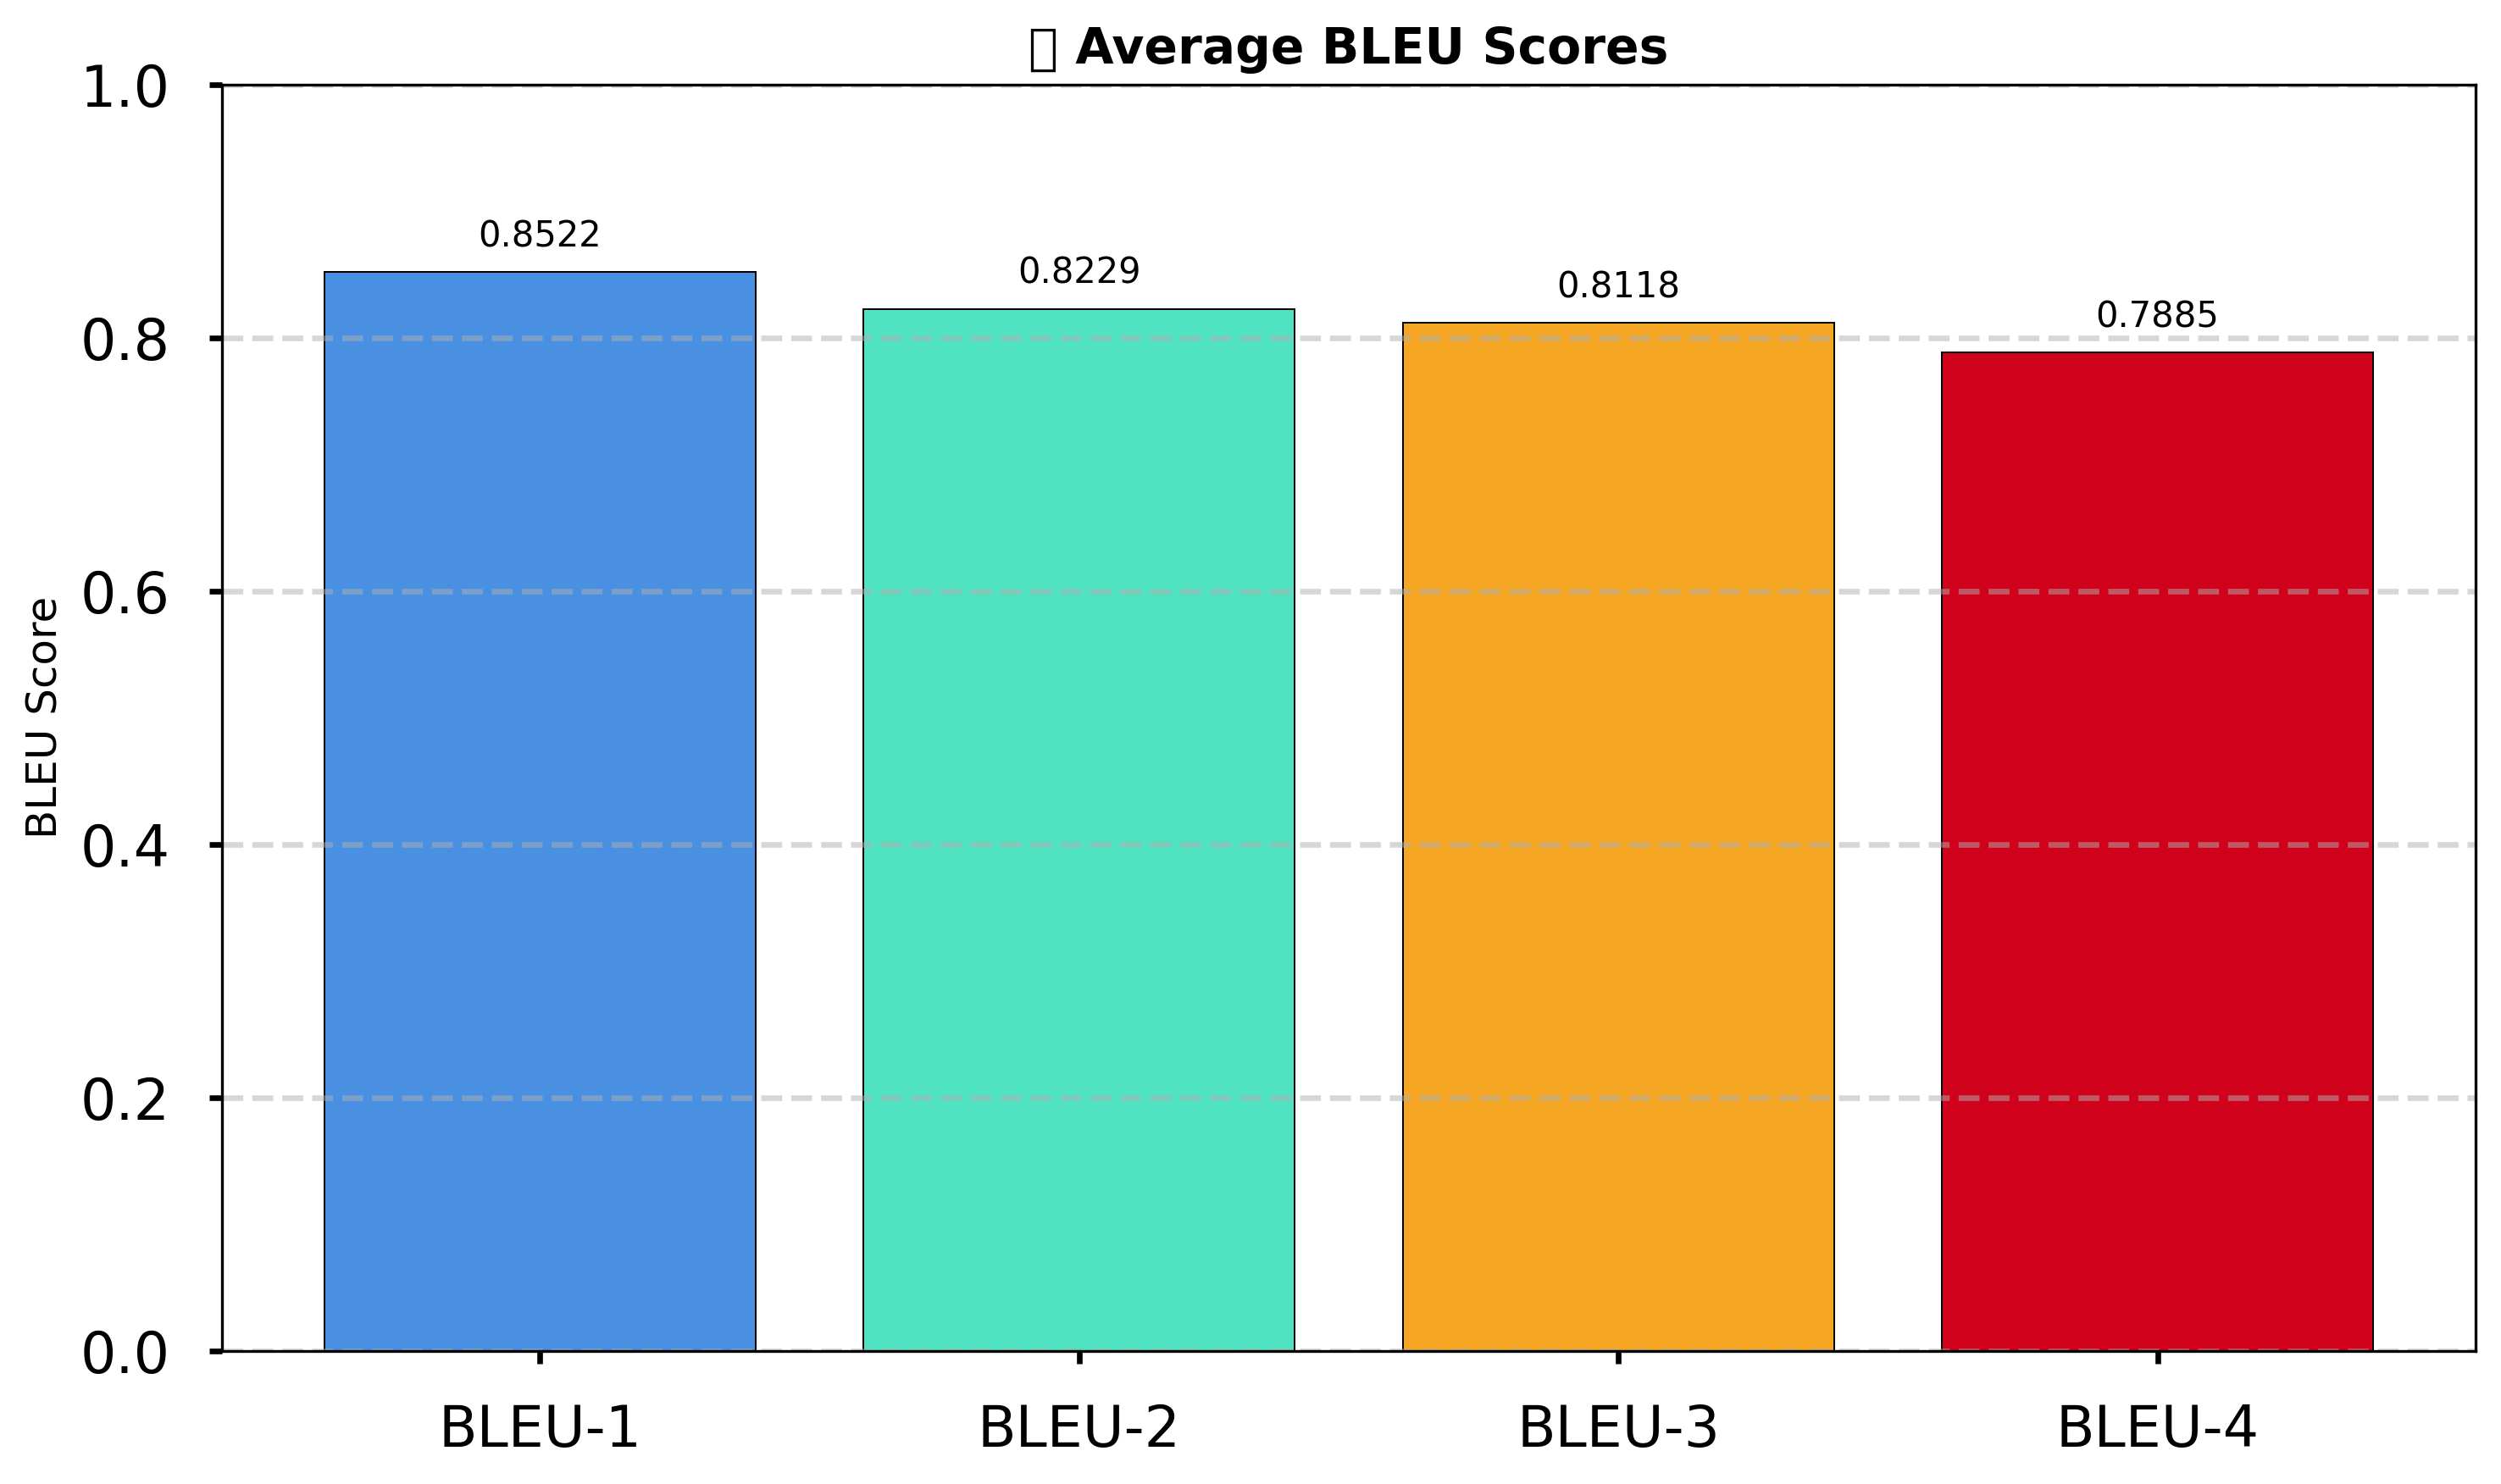

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# میانگین‌ها
bleu_averages = [
    np.mean(bleu_score_1),
    np.mean(bleu_score_2),
    np.mean(bleu_score_3),
    np.mean(bleu_score_4),
]

labels = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']
colors = ['#4A90E2', '#50E3C2', '#F5A623', '#D0021B']

plt.figure(figsize=(10, 6), dpi=300)  # افزایش وضوح (dpi بالا)
bars = plt.bar(labels, bleu_averages, color=colors, edgecolor='black')

# افزودن مقادیر عددی روی ستون‌ها
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02,
             f"{height:.4f}", ha='center', fontsize=10)

# تنظیمات ظاهری
plt.title('📊 Average BLEU Scores', fontsize=14, weight='bold')
plt.ylabel('BLEU Score', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# نمایش نمودار
plt.show()

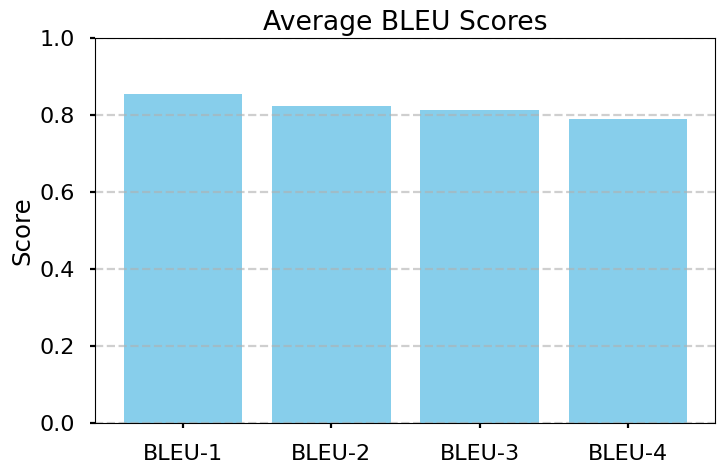

In [93]:
import matplotlib.pyplot as plt

bleu_averages = [
    np.mean(bleu_score_1),
    np.mean(bleu_score_2),
    np.mean(bleu_score_3),
    np.mean(bleu_score_4),
]

plt.figure(figsize=(8, 5))
plt.bar(['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'], bleu_averages, color='skyblue')
plt.title('Average BLEU Scores')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [94]:
# پیدا کردن بدترین‌ها (مثلاً برای BLEU-4)
worst_idxs = np.argsort(bleu_score_4)[:5]
for i in worst_idxs:
    print("Predicted:", fr_preds[i])
    print("Reference:", references[i])
    print("BLEU-4:", bleu_score_4[i])
    print("-" * 50)


Predicted: قرص پنتوپرازول میلی‌گرم هر صبح ناشتا یک عدد قرص ستیریزین هر شب یک عدد مصرف کنید در صورت عدم بهبود به پزشک مراجعه کنید
Reference: قطعا سر سوزن قبلی استفاده نمی‌شه نگران نباشید
BLEU-4: 0
--------------------------------------------------
Predicted: به متخصص مغز و اعصاب مراجعه فرمایید
Reference: لیزر بسیار موثر است ولی در صورت برطرف نشدن اختلال هورمونی برگشت خواهد داشت ممکنه قرص‌های ضد بارداری کمی کمک‌کننده باشد
BLEU-4: 0
--------------------------------------------------
Predicted: به اورولوژیست برای معاینه و جواب مراحعه کنید
Reference: خیر بیماری شما بر اساس نوار قلب ولف پارکینسون وایت است من هم توصیه می‌کنم تحت نظر یک فوق متخصص آریتمی راه فرعی سوزانده شود
BLEU-4: 0
--------------------------------------------------
Predicted: واگیر ندارد با مراجعه به متخصص داخلی باید ازمایش‌های دیگری نظیر پروپرانولول مطرح است
Reference: در حال حاضر روزانه از چه دوز و چه تعداد قرص لووتیروکسین استفاده می‌کنید
BLEU-4: 0
--------------------------------------------------
Predicted: با توجه به نت

🔹 BLEU-1 Average: 0.8521690866896383
🔹 BLEU-2 Average: 0.8229106090080109
🔹 BLEU-3 Average: 0.811752099765398
🔹 BLEU-4 Average: 0.7884728369923325


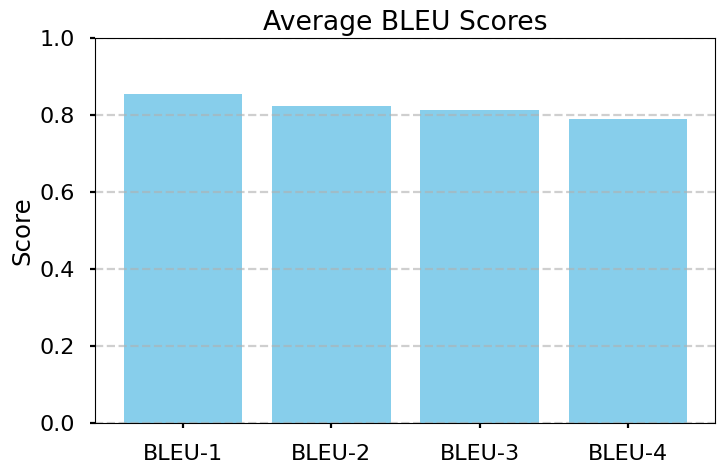


📉 بدترین پیش‌بینی‌ها (BLEU-4 پایین‌تر):

🔻 Predicted: قرص پنتوپرازول میلی‌گرم هر صبح ناشتا یک عدد قرص ستیریزین هر شب یک عدد مصرف کنید در صورت عدم بهبود به پزشک مراجعه کنید
✅ Reference: قطعا سر سوزن قبلی استفاده نمی‌شه نگران نباشید
📊 BLEU-4: 0.0000
--------------------------------------------------
🔻 Predicted: به متخصص مغز و اعصاب مراجعه فرمایید
✅ Reference: لیزر بسیار موثر است ولی در صورت برطرف نشدن اختلال هورمونی برگشت خواهد داشت ممکنه قرص‌های ضد بارداری کمی کمک‌کننده باشد
📊 BLEU-4: 0.0000
--------------------------------------------------
🔻 Predicted: به اورولوژیست برای معاینه و جواب مراحعه کنید
✅ Reference: خیر بیماری شما بر اساس نوار قلب ولف پارکینسون وایت است من هم توصیه می‌کنم تحت نظر یک فوق متخصص آریتمی راه فرعی سوزانده شود
📊 BLEU-4: 0.0000
--------------------------------------------------
🔻 Predicted: واگیر ندارد با مراجعه به متخصص داخلی باید ازمایش‌های دیگری نظیر پروپرانولول مطرح است
✅ Reference: در حال حاضر روزانه از چه دوز و چه تعداد قرص لووتیروکسین استفاده می‌کنید
📊 BLEU

In [95]:
import numpy as np
import matplotlib.pyplot as plt

# ۱. میانگین نمره‌ها
bleu_averages = [
    np.mean(bleu_score_1),
    np.mean(bleu_score_2),
    np.mean(bleu_score_3),
    np.mean(bleu_score_4),
]

print("🔹 BLEU-1 Average:", bleu_averages[0])
print("🔹 BLEU-2 Average:", bleu_averages[1])
print("🔹 BLEU-3 Average:", bleu_averages[2])
print("🔹 BLEU-4 Average:", bleu_averages[3])

# ۲. نمودار میانگین نمره‌ها
plt.figure(figsize=(8, 5))
plt.bar(['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'], bleu_averages, color='skyblue')
plt.title('Average BLEU Scores')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# ۳. بدترین پیش‌بینی‌ها بر اساس BLEU-4
print("\n📉 بدترین پیش‌بینی‌ها (BLEU-4 پایین‌تر):\n")

worst_idxs = np.argsort(bleu_score_4)[:5]  # ضعیف‌ترین ۵ مورد

for i in worst_idxs:
    print(f"🔻 Predicted: {fr_preds[i]}")
    print(f"✅ Reference: {references[i]}")
    print(f"📊 BLEU-4: {bleu_score_4[i]:.4f}")
    print("-" * 50)


In [101]:
best_idxs = np.argsort(bleu_score_4)[-5:]

In [102]:
print("\n🌟 بهترین پیش‌بینی‌ها (BLEU-4 بالاترین):\n")

for i in best_idxs:
    print(f"🔹 Predicted: {fr_preds[i]}")
    print(f"✅ Reference: {references[i]}")
    print(f"📊 BLEU-4: {bleu_score_4[i]:.4f}")
    print("-" * 50)


🌟 بهترین پیش‌بینی‌ها (BLEU-4 بالاترین):

🔹 Predicted: استفاده از برخی ویتامینها وآرامبخشها همچنین محدودیت مصرف نمک توصیه می‌شود این علایم قبل از پریود ودرد هنگام پریود تا حدودی طبیعی است پیاده‌روی منظم استفاده از غذاهای سالم وسرگرمیهای مناسب توصیه می‌شود
✅ Reference: استفاده از برخی ویتامینها وآرامبخشها همچنین محدودیت مصرف نمک توصیه می‌شود این علایم قبل از پریود ودرد هنگام پریود تا حدودی طبیعی است پیاده‌روی منظم استفاده از غذاهای سالم وسرگرمیهای مناسب توصیه می‌شود
📊 BLEU-4: 1.0000
--------------------------------------------------
🔹 Predicted: بعد از چهار روز امکان جلوگیری کم می‌شود ولی می‌توانید از قرص اورژانسی که در داروخانه هست هر چه سریع‌تر استفاده کنید
✅ Reference: بعد از چهار روز امکان جلوگیری کم می‌شود ولی می‌توانید از قرص اورژانسی که در داروخانه هست هر چه سریع‌تر استفاده کنید
📊 BLEU-4: 1.0000
--------------------------------------------------
🔹 Predicted: باید جهت معاینه گوش به متخصص گوش و حلق و بینی مراجعه کنید
✅ Reference: باید جهت معاینه گوش به متخصص گوش و حلق و بینی مراجعه

In [96]:
import re
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import precision_score, recall_score
import tqdm
import numpy as np

# تابع تمیز کردن متن
def clean_text(text):
    text = text.lower()
    text = text.strip().replace("ي", "ی").replace("ك", "ک")
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

# محاسبه BLEU
bleu_score_1 = []
bleu_score_2 = []
bleu_score_3 = []
bleu_score_4 = []

# محاسبه F1 توکنی
token_f1_scores = []

for i in tqdm.tqdm(range(len(fr_preds))):
    pred = clean_text(fr_preds[i])
    reference = clean_text(references[i])

    # BLEU
    score_1 = sentence_bleu([reference.split()], pred.split(), weights=(1, 0, 0, 0))
    score_2 = sentence_bleu([reference.split()], pred.split(), weights=(0, 1, 0, 0))
    score_3 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 1, 0))
    score_4 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 0, 1))

    bleu_score_1.append(score_1)
    bleu_score_2.append(score_2)
    bleu_score_3.append(score_3)
    bleu_score_4.append(score_4)

    # F1 توکنی
    ref_tokens = set(reference.split())
    pred_tokens = set(pred.split())

    tp = len(ref_tokens & pred_tokens)
    fp = len(pred_tokens - ref_tokens)
    fn = len(ref_tokens - pred_tokens)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8) if (precision + recall) > 0 else 0

    token_f1_scores.append(f1)

# میانگین F1 و BLEUها
avg_f1 = np.mean(token_f1_scores)
avg_bleu1 = np.mean(bleu_score_1)
avg_bleu2 = np.mean(bleu_score_2)
avg_bleu3 = np.mean(bleu_score_3)
avg_bleu4 = np.mean(bleu_score_4)

# نمایش نتایج
print("📊 نتایج نهایی:")
print(f"✅ BLEU-1: {avg_bleu1:.4f}")
print(f"✅ BLEU-2: {avg_bleu2:.4f}")
print(f"✅ BLEU-3: {avg_bleu3:.4f}")
print(f"✅ BLEU-4: {avg_bleu4:.4f}")
print(f"📐 F1-Token-Based: {avg_f1:.4f}")

print("\n📊 📋 **گزارش نهایی ارزیابی مدل**")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print(f"🔹 BLEU-1 (unigram):     {avg_bleu1:.4f}")
print(f"🔹 BLEU-2 (bigram):      {avg_bleu2:.4f}")
print(f"🔹 BLEU-3 (trigram):     {avg_bleu3:.4f}")
print(f"🔹 BLEU-4 (4-gram):      {avg_bleu4:.4f}")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print(f"🔸 Token-Level F1-Score: {avg_f1:.4f}")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")

100%|████████████████████████████████████████████████████████████████████████████| 1541/1541 [00:00<00:00, 1700.88it/s]


📊 نتایج نهایی:
✅ BLEU-1: 0.8522
✅ BLEU-2: 0.8229
✅ BLEU-3: 0.8118
✅ BLEU-4: 0.7885
📐 F1-Token-Based: 0.8618

📊 📋 **گزارش نهایی ارزیابی مدل**
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔹 BLEU-1 (unigram):     0.8522
🔹 BLEU-2 (bigram):      0.8229
🔹 BLEU-3 (trigram):     0.8118
🔹 BLEU-4 (4-gram):      0.7885
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔸 Token-Level F1-Score: 0.8618
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [97]:
from sklearn.metrics import f1_score
import numpy as np

# نرمال‌سازی متون (اگر قبلاً تعریف نشده)
def clean_text(text):
    import re
    text = text.lower().strip().replace("ي", "ی").replace("ك", "ک")
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r"\s+", " ", text)
    return text

# نرمال‌سازی پیش‌بینی‌ها و رفرنس‌ها
y_pred = [clean_text(p) for p in fr_preds]
y_true = [clean_text(references[i]) for i in range(len(references))]

# چون F1 برای classification طراحی شده، باید تبدیل به لیبل باینری کنیم (match or not)
# بنابراین به صورت مقایسه دقیق جمله به جمله:
labels_true = [1] * len(y_true)
labels_pred = [1 if p == t else 0 for p, t in zip(y_pred, y_true)]

# محاسبه F1-Score
f1 = f1_score(labels_true, labels_pred, average='binary')
accuracy = np.mean([p == t for p, t in zip(y_pred, y_true)])

print("🎯 ارزیابی سطح جمله:")
print(f"✅ Accuracy (Exact Match): {accuracy:.4f}")
print(f"📐 F1-Score (Exact Match): {f1:.4f}")

print("\n📊  گزارش نهایی ارزیابی مدل (Exact Match سطح جمله)")
print("══════════════════════════════════════════════")
print(f"🔹 دقت (Accuracy):          {accuracy:.4f}")
print(f"🔸 F1-Score (Exact Match):  {f1:.4f}")
print("══════════════════════════════════════════════")


🎯 ارزیابی سطح جمله:
✅ Accuracy (Exact Match): 0.8151
📐 F1-Score (Exact Match): 0.8981

📊  گزارش نهایی ارزیابی مدل (Exact Match سطح جمله)
══════════════════════════════════════════════
🔹 دقت (Accuracy):          0.8151
🔸 F1-Score (Exact Match):  0.8981
══════════════════════════════════════════════


In [98]:
import re
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import tqdm

# تابع پاک‌سازی متن
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text.strip()

# اطمینان از اینکه references لیست باشه
if hasattr(references, 'tolist'):
    references = references.tolist()

# محاسبه BLEU
from nltk.translate.bleu_score import sentence_bleu

bleu_score_1 = []
bleu_score_2 = []
bleu_score_3 = []
bleu_score_4 = []

for i in tqdm.tqdm(range(len(fr_preds))):
    pred = clean_text(fr_preds[i])
    reference = clean_text(references[i])

    score_1 = sentence_bleu([reference.split()], pred.split(), weights=(1, 0, 0, 0))
    score_2 = sentence_bleu([reference.split()], pred.split(), weights=(0, 1, 0, 0))
    score_3 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 1, 0))
    score_4 = sentence_bleu([reference.split()], pred.split(), weights=(0, 0, 0, 1))

    bleu_score_1.append(score_1)
    bleu_score_2.append(score_2)
    bleu_score_3.append(score_3)
    bleu_score_4.append(score_4)

# محاسبه F1 و Accuracy
y_true = [clean_text(r) for r in references]
y_pred = [clean_text(p) for p in fr_preds]

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='micro')
exact_match = all([t == p for t, p in zip(y_true, y_pred)])

# نمایش نتایج
print("\n📊 نتایج نهایی مدل:")
print(f"✅ Accuracy:     {accuracy:.4f}")
print(f"📐 F1-Score:     {f1:.4f}")
print(f"🎯 Exact Match:  {'✅' if exact_match else '❌'}")
print("📏 BLEU Scores:")
print(f"   BLEU-1:       {np.mean(bleu_score_1):.4f}")
print(f"   BLEU-2:       {np.mean(bleu_score_2):.4f}")
print(f"   BLEU-3:       {np.mean(bleu_score_3):.4f}")
print(f"   BLEU-4:       {np.mean(bleu_score_4):.4f}")

print("\n📊 نتایج نهایی ارزیابی مدل")
print("════════════════════════════════════")
print(f"🎯 Exact Match:        {'✅ بله' if exact_match else '❌ خیر'}")
print(f"✅ Accuracy:           {accuracy:.4f}")
print(f"📐 F1-Score:           {f1:.4f}")
print("📏 BLEU Scores:")
print(f"   🔹 BLEU-1:          {np.mean(bleu_score_1):.4f}")
print(f"   🔹 BLEU-2:          {np.mean(bleu_score_2):.4f}")
print(f"   🔹 BLEU-3:          {np.mean(bleu_score_3):.4f}")
print(f"   🔹 BLEU-4:          {np.mean(bleu_score_4):.4f}")
print("════════════════════════════════════")

D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning:    | 0/1541 [00:00<?, ?it/s]
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or u


📊 نتایج نهایی مدل:
✅ Accuracy:     0.8151
📐 F1-Score:     0.8151
🎯 Exact Match:  ❌
📏 BLEU Scores:
   BLEU-1:       0.8522
   BLEU-2:       0.8229
   BLEU-3:       0.8118
   BLEU-4:       0.7885

📊 نتایج نهایی ارزیابی مدل
════════════════════════════════════
🎯 Exact Match:        ❌ خیر
✅ Accuracy:           0.8151
📐 F1-Score:           0.8151
📏 BLEU Scores:
   🔹 BLEU-1:          0.8522
   🔹 BLEU-2:          0.8229
   🔹 BLEU-3:          0.8118
   🔹 BLEU-4:          0.7885
════════════════════════════════════


In [99]:
def clean_text(text):
    import re
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# نرمال‌سازی پاسخ‌ها
preds_clean = [clean_text(p) for p in fr_preds]
refs_clean = [clean_text(r) for r in references]

# محاسبه Exact Match
exact_matches = [p == r for p, r in zip(preds_clean, refs_clean)]
exact_match_score = sum(exact_matches) / len(exact_matches)

# چاپ حرفه‌ای
print("📌 ارزیابی Exact Match")
print("═══════════════════════════════")
print(f"🎯 تعداد جملات تطابق کامل:  {sum(exact_matches)} / {len(exact_matches)}")
print(f"✅ درصد تطابق کامل:         {exact_match_score:.4f}")
print("═══════════════════════════════")

📌 ارزیابی Exact Match
═══════════════════════════════
🎯 تعداد جملات تطابق کامل:  1256 / 1541
✅ درصد تطابق کامل:         0.8151
═══════════════════════════════


In [100]:
def clean_text(text):
    import re
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# نرمال‌سازی پاسخ‌ها
preds_clean = [clean_text(p) for p in fr_preds]
refs_clean = [clean_text(r) for r in references]  # مطمئن شو references یه لیسته، نه Series

# محاسبه Exact Match
exact_matches = [p == r for p, r in zip(preds_clean, refs_clean)]
exact_match_score = sum(exact_matches) / len(exact_matches)

print(f"🎯 Exact Match Score: {exact_match_score:.4f}")

🎯 Exact Match Score: 0.8151


In [103]:
exact_matches = [t == p for t, p in zip(y_true, y_pred)]
exact_match_ratio = sum(exact_matches) / len(exact_matches)

print(f"🎯 Exact Match Score: {exact_match_ratio:.4f}")

🎯 Exact Match Score: 0.8151


D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning:    | 0/1541 [00:00<?, ?it/s]
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or u

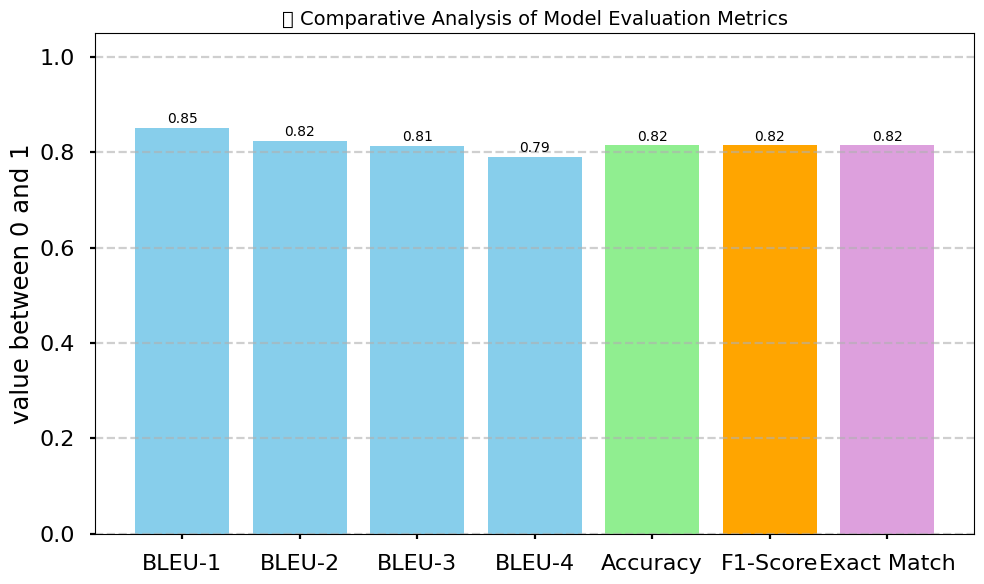

In [104]:
import re
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import accuracy_score, f1_score

# تابع پاک‌سازی متن
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text.strip()

# اطمینان از اینکه references لیست باشه
if hasattr(references, 'tolist'):
    references = references.tolist()

# محاسبه BLEU
bleu_score_1 = []
bleu_score_2 = []
bleu_score_3 = []
bleu_score_4 = []

for i in tqdm.tqdm(range(len(fr_preds))):
    pred = clean_text(fr_preds[i])
    reference = clean_text(references[i])

    score_1 = sentence_bleu([reference.split()], pred.split(), weights=(1, 0, 0, 0))
    score_2 = sentence_bleu([reference.split()], pred.split(), weights=(0.5, 0.5, 0, 0))
    score_3 = sentence_bleu([reference.split()], pred.split(), weights=(0.34, 0.33, 0.33, 0.))
    score_4 = sentence_bleu([reference.split()], pred.split(), weights=(0.25, 0.25, 0.25, 0.25))

    bleu_score_1.append(score_1)
    bleu_score_2.append(score_2)
    bleu_score_3.append(score_3)
    bleu_score_4.append(score_4)

# دقت، F1 و Exact Match
y_true = [clean_text(r) for r in references]
y_pred = [clean_text(p) for p in fr_preds]

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='micro')
exact_matches = [t == p for t, p in zip(y_true, y_pred)]
exact_match_ratio = sum(exact_matches) / len(exact_matches)

# میانگین BLEUها
bleu_means = [
    np.mean(bleu_score_1),
    np.mean(bleu_score_2),
    np.mean(bleu_score_3),
    np.mean(bleu_score_4),
]

# ترسیم نمودار
plt.figure(figsize=(10, 6))
metrics = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'Accuracy', 'F1-Score', 'Exact Match']
values = bleu_means + [accuracy, f1, exact_match_ratio]

bars = plt.bar(metrics, values, color=['skyblue']*4 + ['lightgreen', 'orange', 'plum'])
plt.ylim(0, 1.05)
plt.title("📊 Comparative Analysis of Model Evaluation Metrics", fontsize=14 )#fonsizeو مقایسه‌ی شاخص‌های ارزیابی مدل", )
plt.ylabel("value between 0 and 1")#("مقدار (۰ تا ۱)")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# افزودن مقادیر روی هر ستون
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning:    | 0/1541 [00:00<?, ?it/s]
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
D:\Chatbot-by-sia\SHAHBOT\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or u

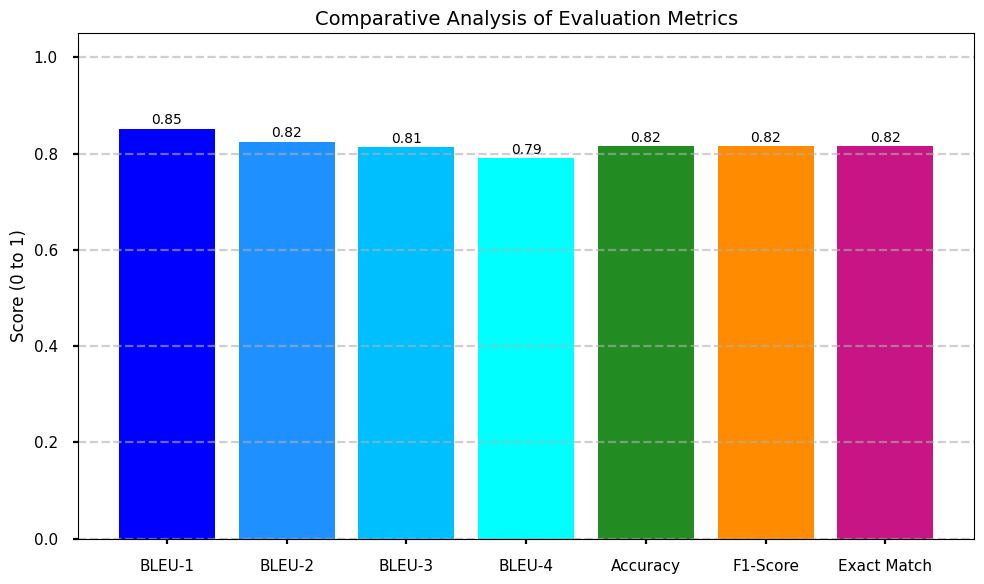

In [105]:
import re
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import accuracy_score, f1_score

# پاک‌سازی متن
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text.strip()

# اطمینان از لیست بودن references
if hasattr(references, 'tolist'):
    references = references.tolist()

# محاسبه BLEU
bleu_score_1, bleu_score_2, bleu_score_3, bleu_score_4 = [], [], [], []

for i in tqdm.tqdm(range(len(fr_preds))):
    pred = clean_text(fr_preds[i])
    reference = clean_text(references[i])
    
    bleu_score_1.append(sentence_bleu([reference.split()], pred.split(), weights=(1, 0, 0, 0)))
    bleu_score_2.append(sentence_bleu([reference.split()], pred.split(), weights=(0.5, 0.5, 0, 0)))
    bleu_score_3.append(sentence_bleu([reference.split()], pred.split(), weights=(0.34, 0.33, 0.33, 0.)))
    bleu_score_4.append(sentence_bleu([reference.split()], pred.split(), weights=(0.25, 0.25, 0.25, 0.25)))

# محاسبه دقت، F1 و Exact Match
y_true = [clean_text(r) for r in references]
y_pred = [clean_text(p) for p in fr_preds]

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='micro')
exact_match_ratio = np.mean([t == p for t, p in zip(y_true, y_pred)])

# میانگین BLEUها
bleu_means = [
    np.mean(bleu_score_1),
    np.mean(bleu_score_2),
    np.mean(bleu_score_3),
    np.mean(bleu_score_4),
]

# رسم نمودار
plt.figure(figsize=(10, 6))
metrics = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'Accuracy', 'F1-Score', 'Exact Match']
values = bleu_means + [accuracy, f1, exact_match_ratio]

# رنگ‌های یک‌دست و مناسب مقاله
colors = ['blue', 'dodgerblue', 'deepskyblue', 'cyan', 'forestgreen', 'darkorange', 'mediumvioletred']
bars = plt.bar(metrics, values, color=colors)

plt.ylim(0, 1.05)
plt.title("Comparative Analysis of Evaluation Metrics", fontsize=14)
plt.ylabel("Score (0 to 1)", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# نمایش مقدار دقیق بالای هر ستون
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', fontsize=10)

plt.tight_layout()

# 📁 ذخیره‌ی خروجی برای مقاله
plt.savefig("evaluation_metrics_bar_chart.png", dpi=400, bbox_inches='tight')
plt.savefig("evaluation_metrics_bar_chart.pdf", dpi=400, bbox_inches='tight')

plt.show()


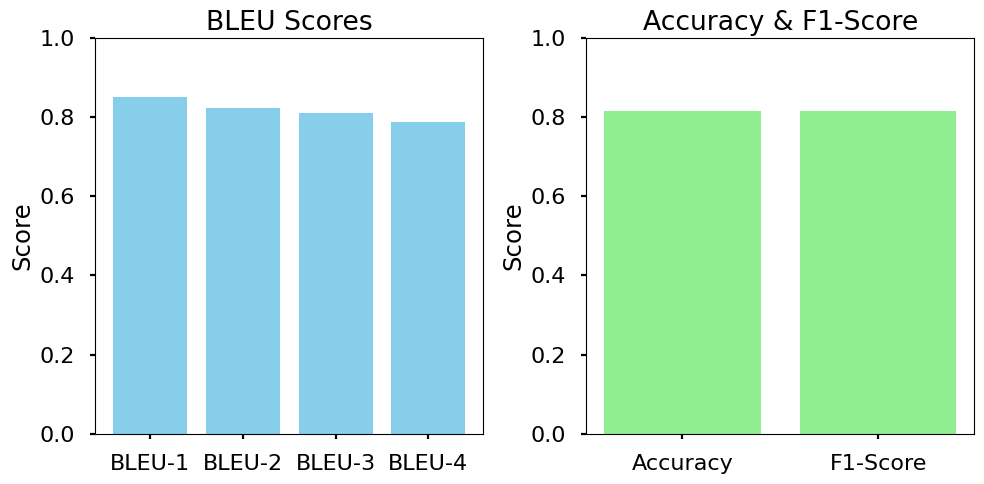

In [106]:
import matplotlib.pyplot as plt

# نمرات BLEU
bleu_scores = {
    "BLEU-1": 0.8522,
    "BLEU-2": 0.8229,
    "BLEU-3": 0.8118,
    "BLEU-4": 0.7885
}

# دقت و F1
metrics = {
    "Accuracy": 0.8151,
    "F1-Score": 0.8151
}

# تنظیم سایز نمودار
plt.figure(figsize=(10, 5))

# نمودار BLEU
plt.subplot(1, 2, 1)
plt.bar(bleu_scores.keys(), bleu_scores.values(), color='skyblue')
plt.ylim(0, 1)
plt.title('BLEU Scores')
plt.ylabel('Score')

# نمودار Accuracy و F1
plt.subplot(1, 2, 2)
plt.bar(metrics.keys(), metrics.values(), color='lightgreen')
plt.ylim(0, 1)
plt.title('Accuracy & F1-Score')
plt.ylabel('Score')

# مرتب‌سازی فاصله‌ها
plt.tight_layout()

# نمایش نمودار
plt.show()


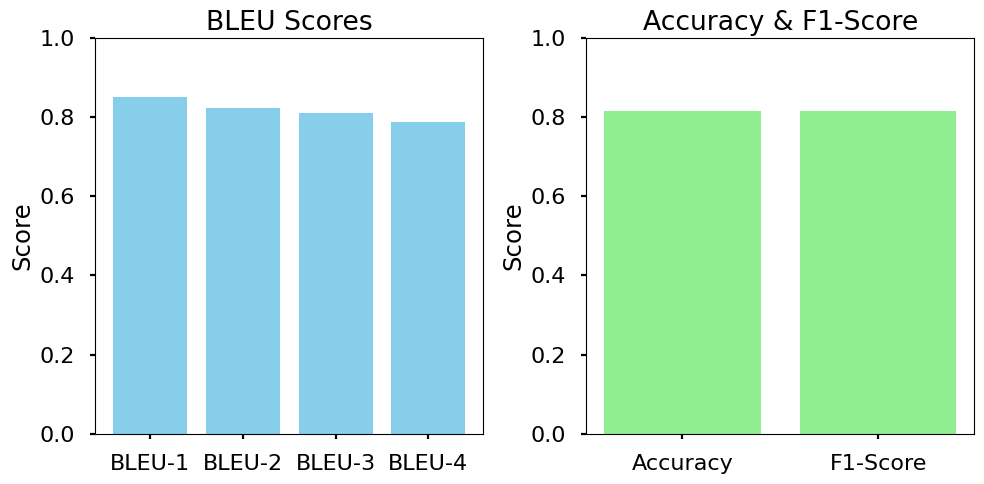

In [107]:
import matplotlib.pyplot as plt

# نمرات BLEU
bleu_scores = {
    "BLEU-1": 0.8522,
    "BLEU-2": 0.8229,
    "BLEU-3": 0.8118,
    "BLEU-4": 0.7885
}

# دقت و F1
metrics = {
    "Accuracy": 0.8151,
    "F1-Score": 0.8151
}

# تنظیم سایز نمودار
plt.figure(figsize=(10, 5))

# نمودار BLEU
plt.subplot(1, 2, 1)
plt.bar(bleu_scores.keys(), bleu_scores.values(), color='skyblue')
plt.ylim(0, 1)
plt.title('BLEU Scores')
plt.ylabel('Score')

# نمودار Accuracy و F1
plt.subplot(1, 2, 2)
plt.bar(metrics.keys(), metrics.values(), color='lightgreen')
plt.ylim(0, 1)
plt.title('Accuracy & F1-Score')
plt.ylabel('Score')

# مرتب‌سازی فاصله‌ها
plt.tight_layout()

# ذخیره نمودار به عنوان فایل PNG
plt.savefig("evaluation_metrics_1.png", dpi=300, bbox_inches='tight')

# نمایش نمودار
plt.show()


In [108]:
plt.savefig("evaluation_metrics_1.pdf")

<Figure size 1280x880 with 0 Axes>

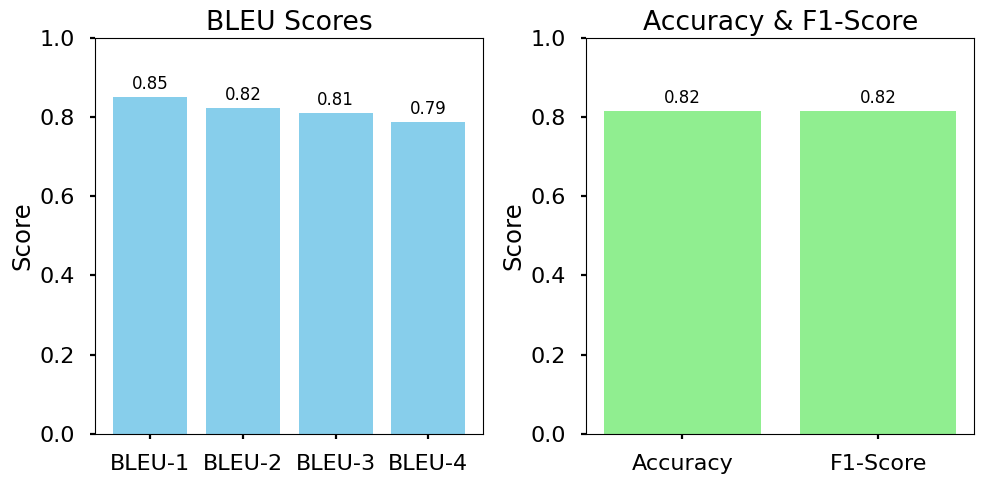

In [109]:
import matplotlib.pyplot as plt

# نمرات BLEU
bleu_scores = {
    "BLEU-1": 0.8522,
    "BLEU-2": 0.8229,
    "BLEU-3": 0.8118,
    "BLEU-4": 0.7885
}

# دقت و F1
metrics = {
    "Accuracy": 0.8151,
    "F1-Score": 0.8151
}

# تنظیم سایز نمودار
plt.figure(figsize=(10, 5))

# ---- نمودار BLEU ----
plt.subplot(1, 2, 1)
bars1 = plt.bar(bleu_scores.keys(), bleu_scores.values(), color='skyblue')
plt.ylim(0, 1)
plt.title('BLEU Scores')
plt.ylabel('Score')

# نمایش مقدار هر ستون
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f"{height:.2f}", ha='center', va='bottom')

# ---- نمودار Accuracy و F1 ----
plt.subplot(1, 2, 2)
bars2 = plt.bar(metrics.keys(), metrics.values(), color='lightgreen')
plt.ylim(0, 1)
plt.title('Accuracy & F1-Score')
plt.ylabel('Score')

# نمایش مقدار هر ستون
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f"{height:.2f}", ha='center', va='bottom')

# مرتب‌سازی فاصله‌ها
plt.tight_layout()

# ذخیره نمودار به عنوان فایل
plt.savefig("evaluation_metrics_with_labels.png", dpi=300, bbox_inches='tight')

# نمایش نمودار
plt.show()


In [111]:
plt.savefig("evaluation_metrics_with_labels.pdf")
plt.show()

<Figure size 1280x880 with 0 Axes>

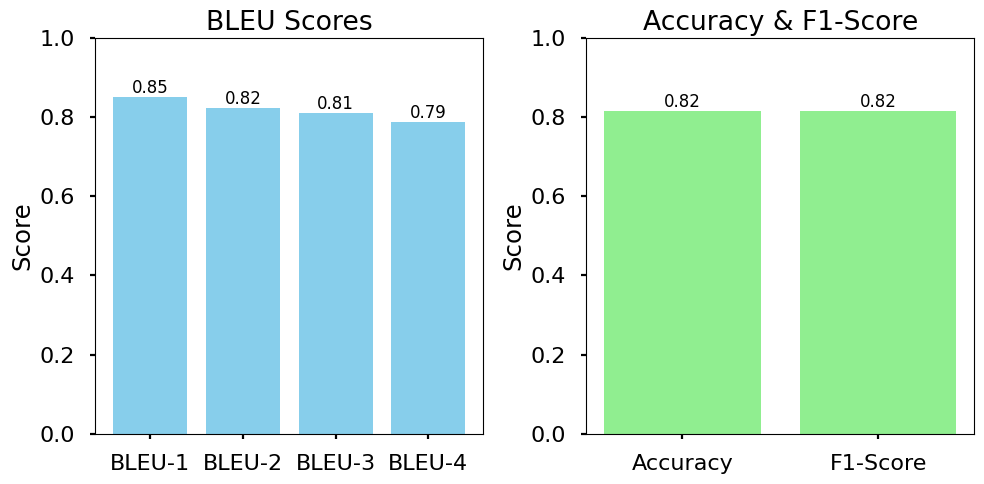

In [112]:
import matplotlib.pyplot as plt

# نمرات BLEU
bleu_scores = {
    "BLEU-1": 0.8522,
    "BLEU-2": 0.8229,
    "BLEU-3": 0.8118,
    "BLEU-4": 0.7885
}

# دقت و F1
metrics = {
    "Accuracy": 0.8151,
    "F1-Score": 0.8151
}

# ایجاد Figure و Axes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# --- BLEU نمودار ---
bars1 = axs[0].bar(bleu_scores.keys(), bleu_scores.values(), color='skyblue')
axs[0].set_ylim(0, 1)
axs[0].set_title('BLEU Scores')
axs[0].set_ylabel('Score')

# اضافه کردن مقادیر
for bar in bars1:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f"{height:.2f}", ha='center')

# --- Accuracy و F1 نمودار ---
bars2 = axs[1].bar(metrics.keys(), metrics.values(), color='lightgreen')
axs[1].set_ylim(0, 1)
axs[1].set_title('Accuracy & F1-Score')
axs[1].set_ylabel('Score')

for bar in bars2:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f"{height:.2f}", ha='center')

# تنظیم فاصله‌ها
plt.tight_layout()

# ذخیره فایل PDF قبل از نمایش
fig.savefig("evaluation_metrics_with_labels_finals.pdf", dpi=300, bbox_inches='tight')

# نمایش در Jupyter
plt.show()
